In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

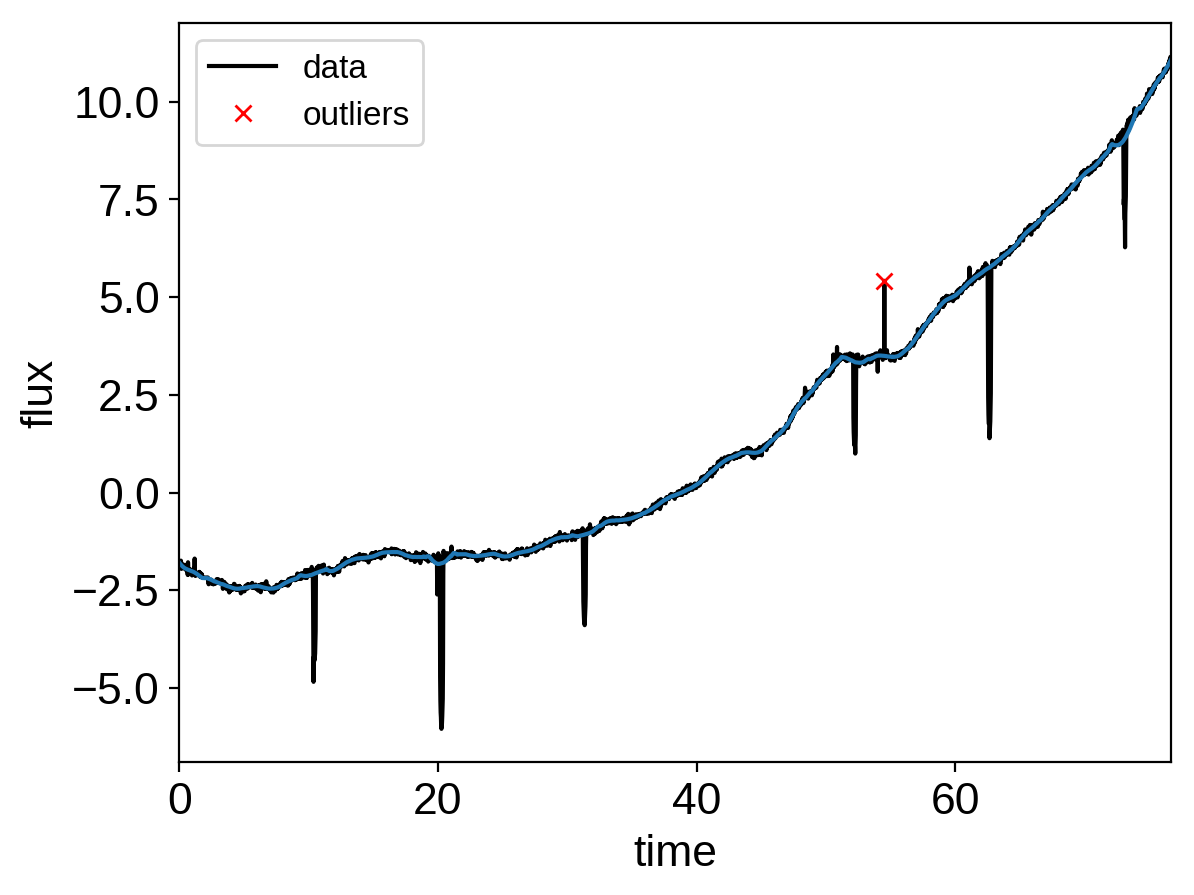

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

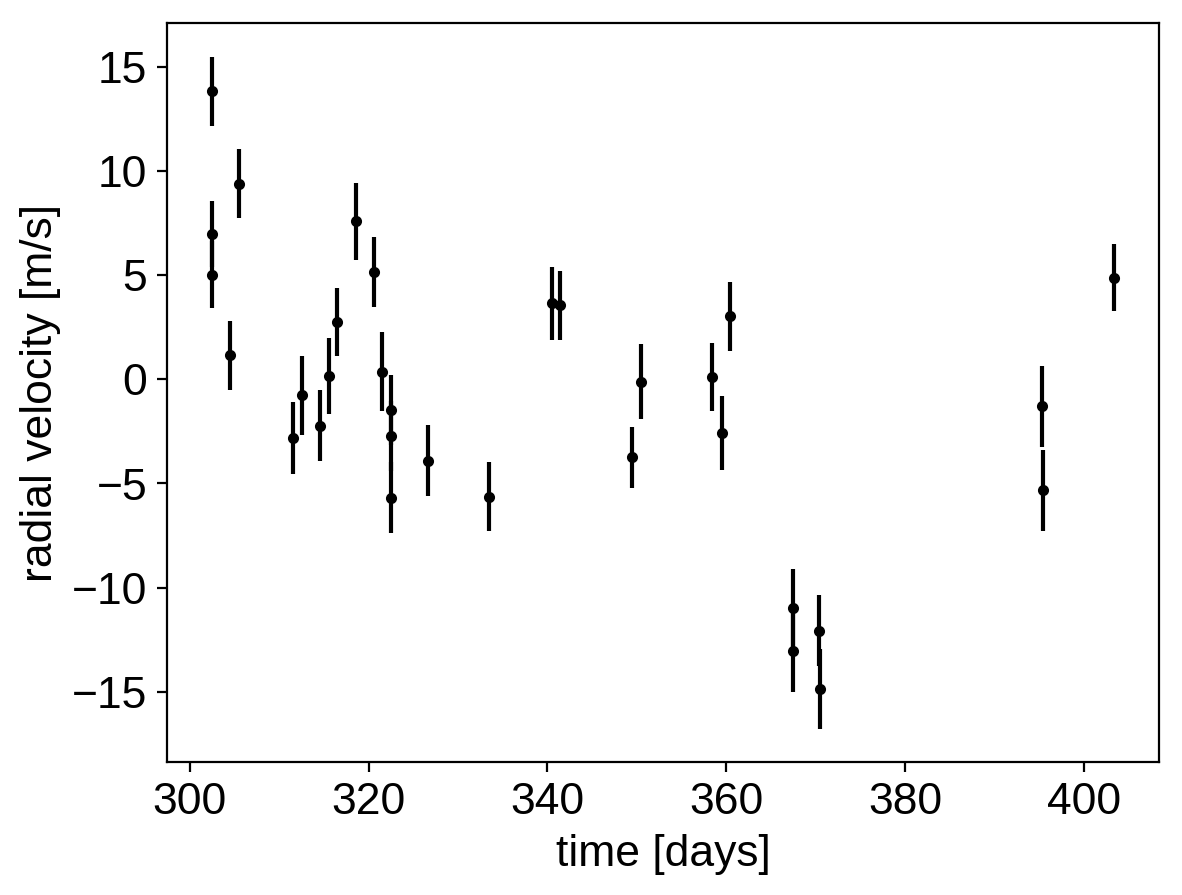

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

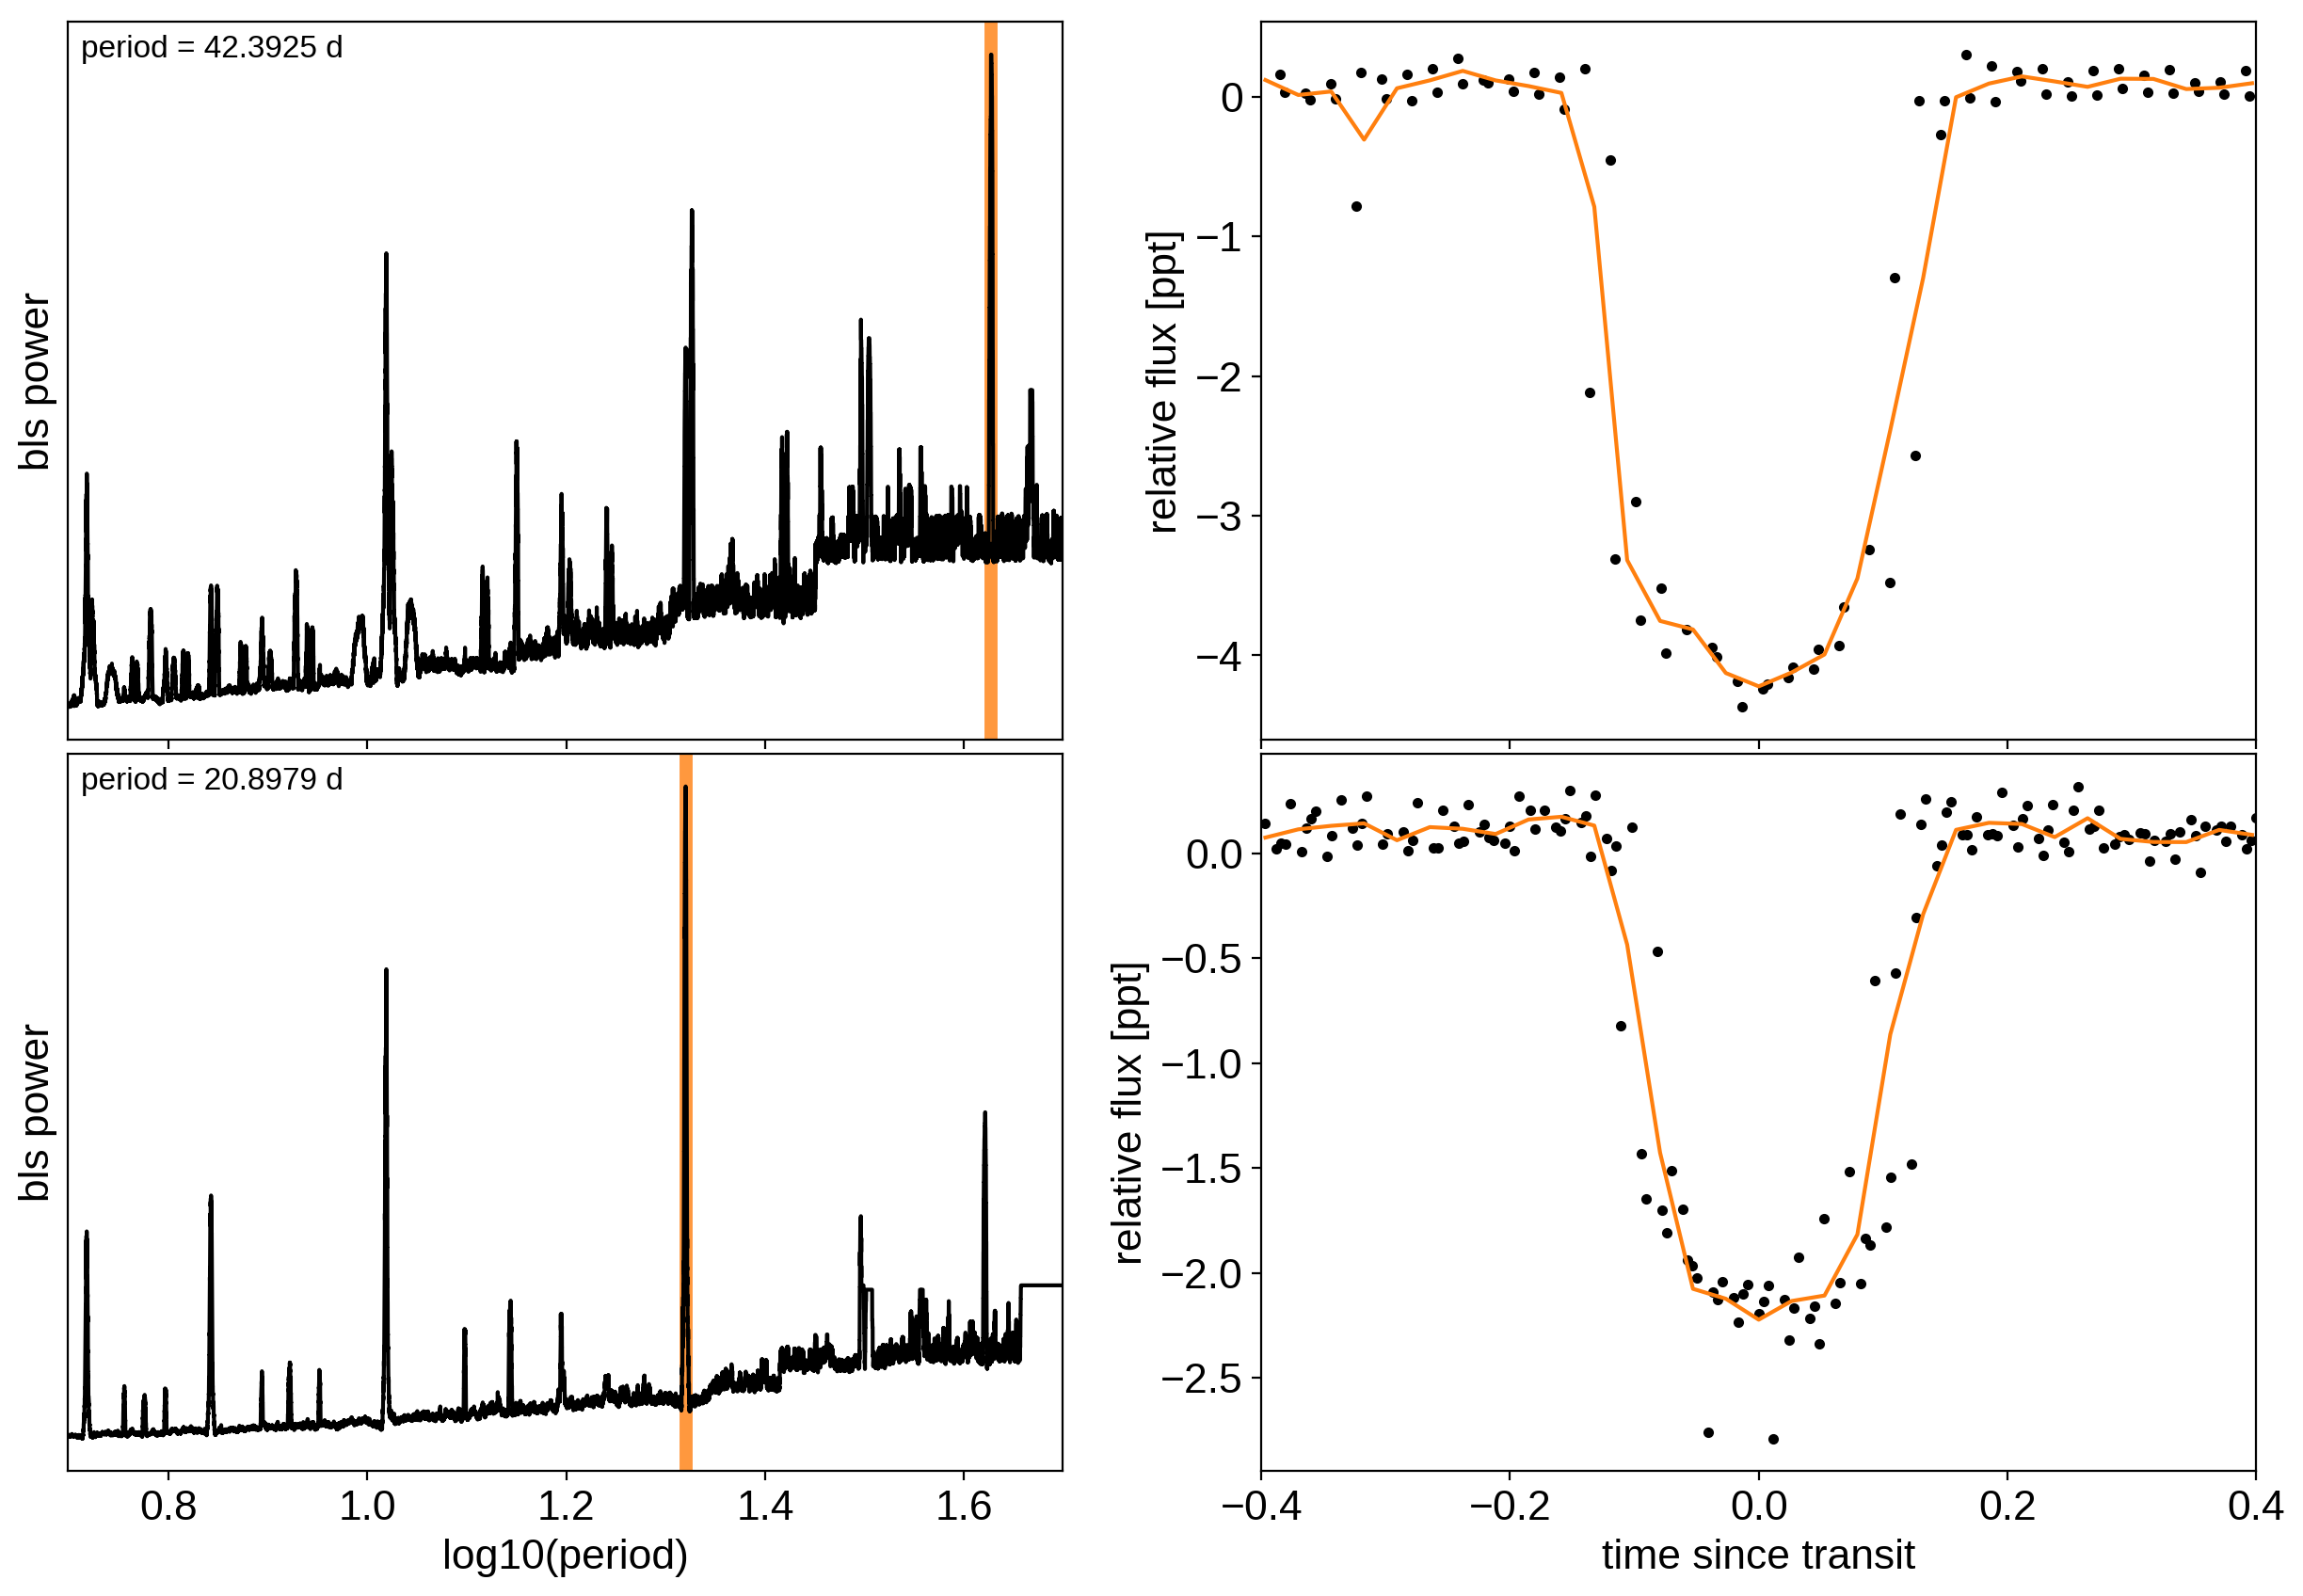

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Uniform("b", lower=0, upper=1, shape=2, testval=0.5+np.zeros(2))
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.57231984769 -> -8233.97212654762


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8233.97212654762 -> 1985.1953832396869


optimizing logp for variables: ['b_interval__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 1985.1953832396869 -> 2679.6982115955066


optimizing logp for variables: ['t0', 'logP']


message: Optimization terminated successfully.
logp: 2679.6982115955066 -> 3334.211963608997


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3334.211963608997 -> 4291.602783390095


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4291.602783390095 -> 4365.554869809015


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.554869809015 -> 4777.103510779189


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Optimization terminated successfully.
logp: 4777.103510779189 -> 4777.103510779189


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4777.103510779189 -> 4777.1035107791895


Now let's plot the map radial velocity model.

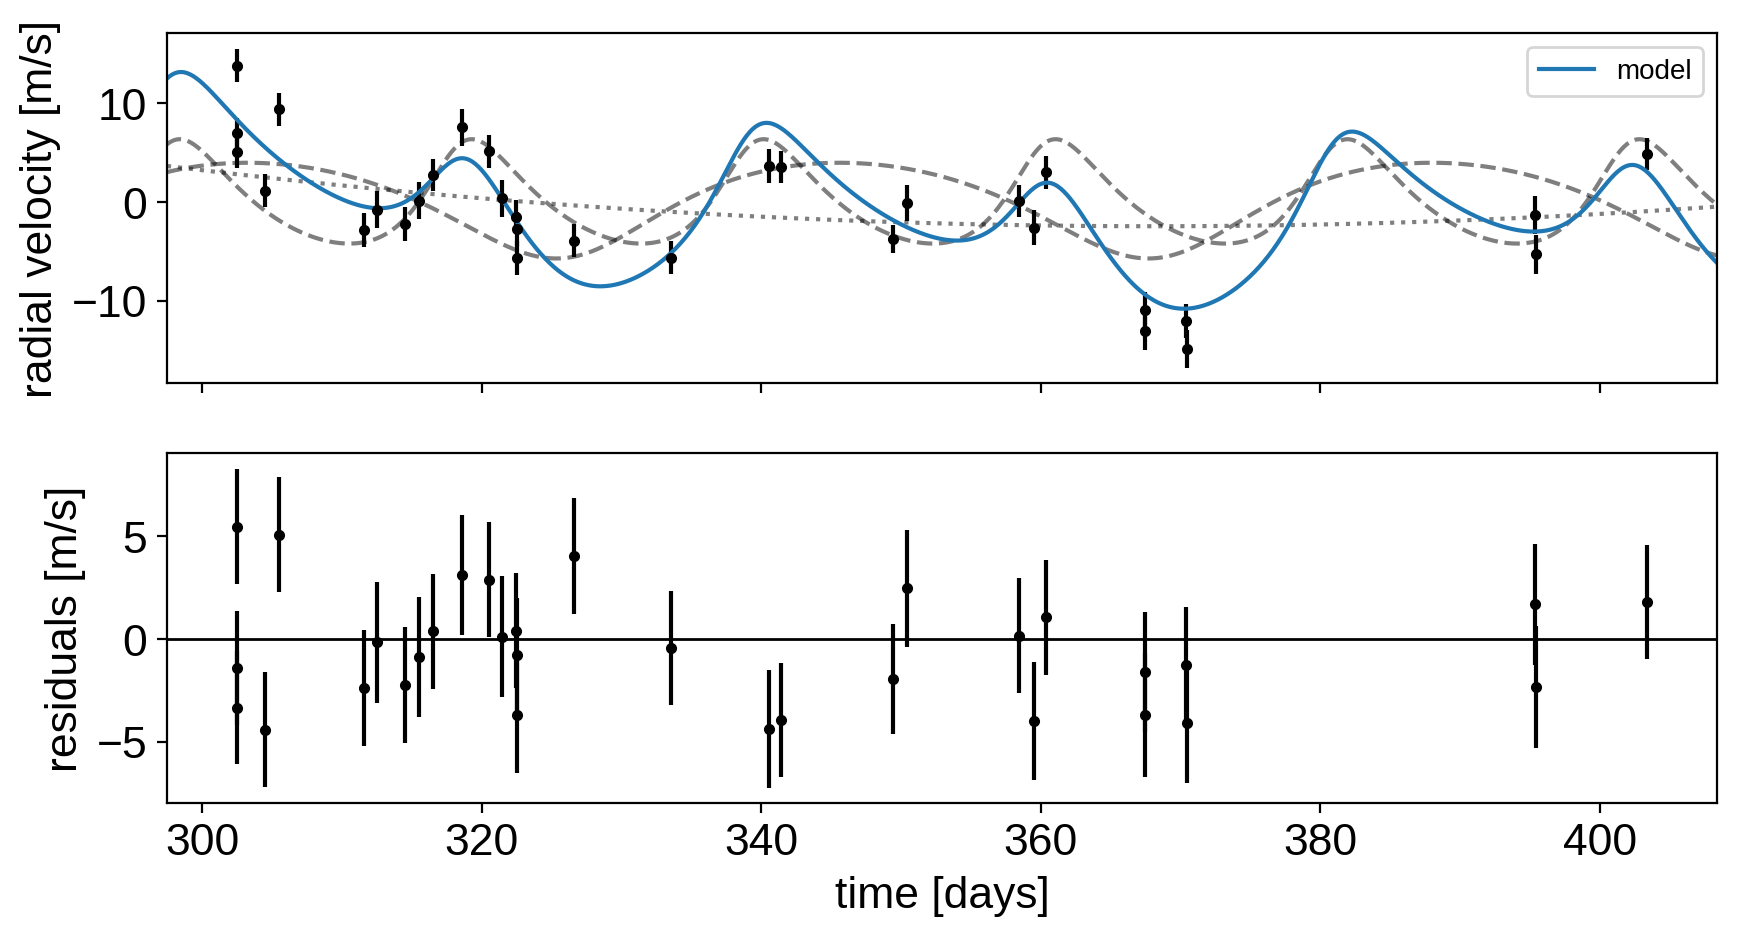

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

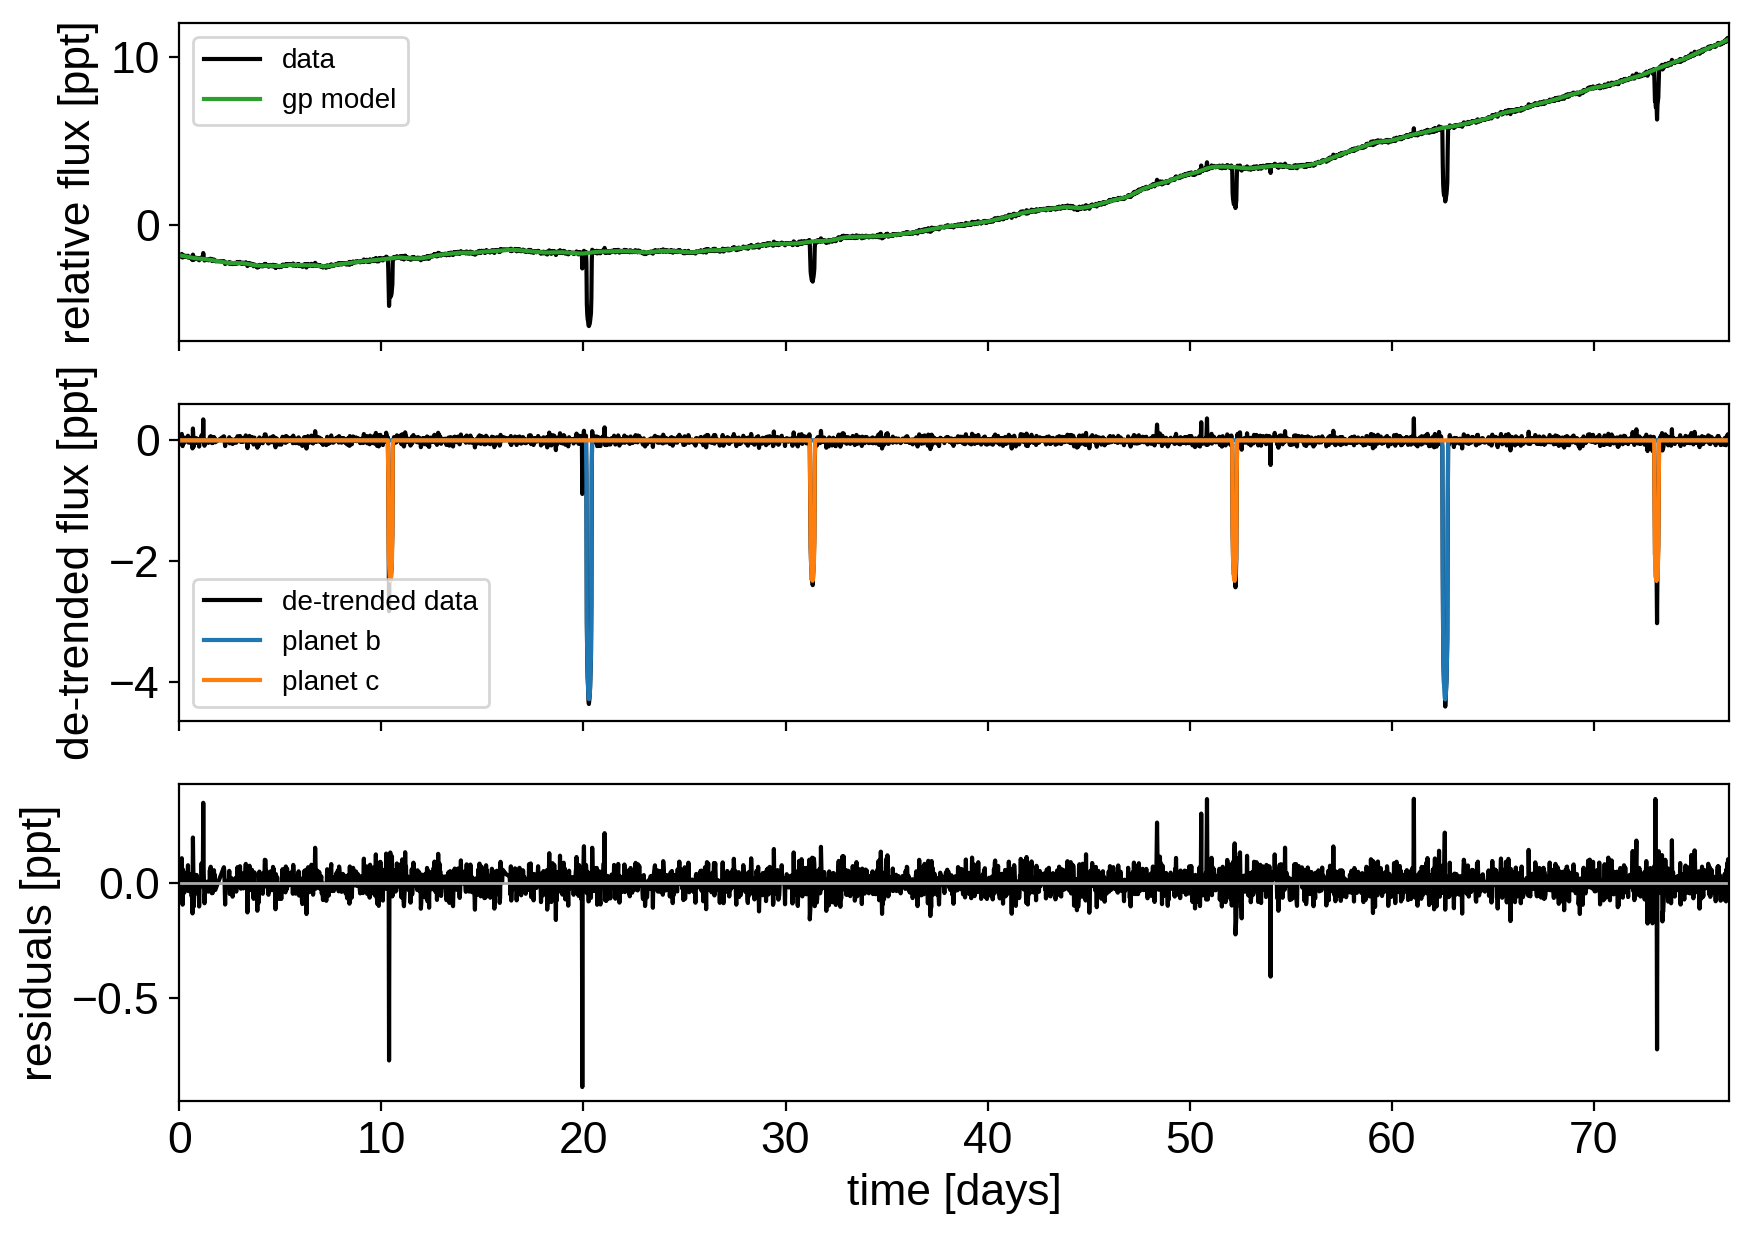

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

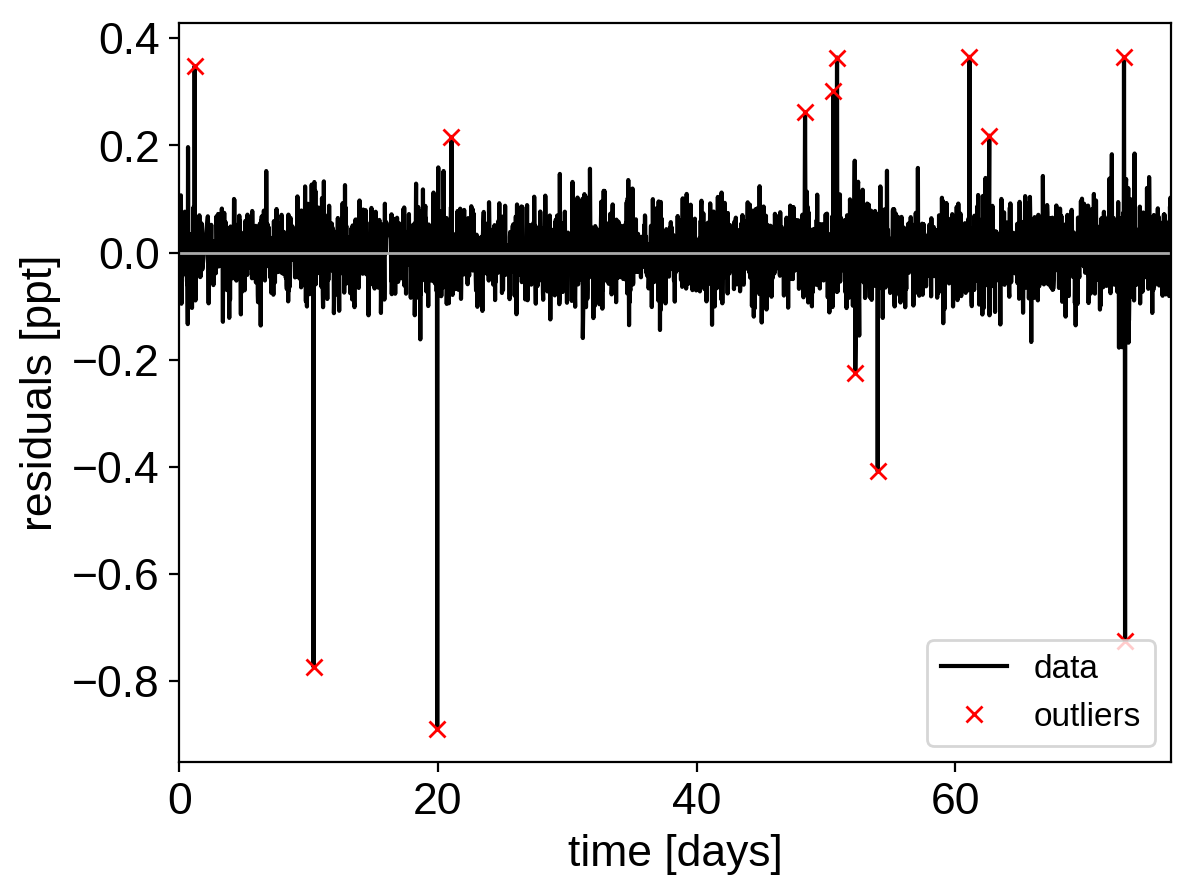

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.116862592586 -> 5227.116862592586


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: 5227.116862592586 -> 5309.223919615405


optimizing logp for variables: ['b_interval__', 'logr']


message: Optimization terminated successfully.
logp: 5309.223919615405 -> 5320.26140238702


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.26140238702 -> 5321.717936341929


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.717936341929 -> 5322.452126818443


optimizing logp for variables: ['logw0']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.452126818443 -> 5322.486377065833


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.486377065802 -> 5324.3056735787795


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Optimization terminated successfully.
logp: 5324.3056735787795 -> 5324.3056735787795


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_interval__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.3056735787795 -> 5324.3056735787795


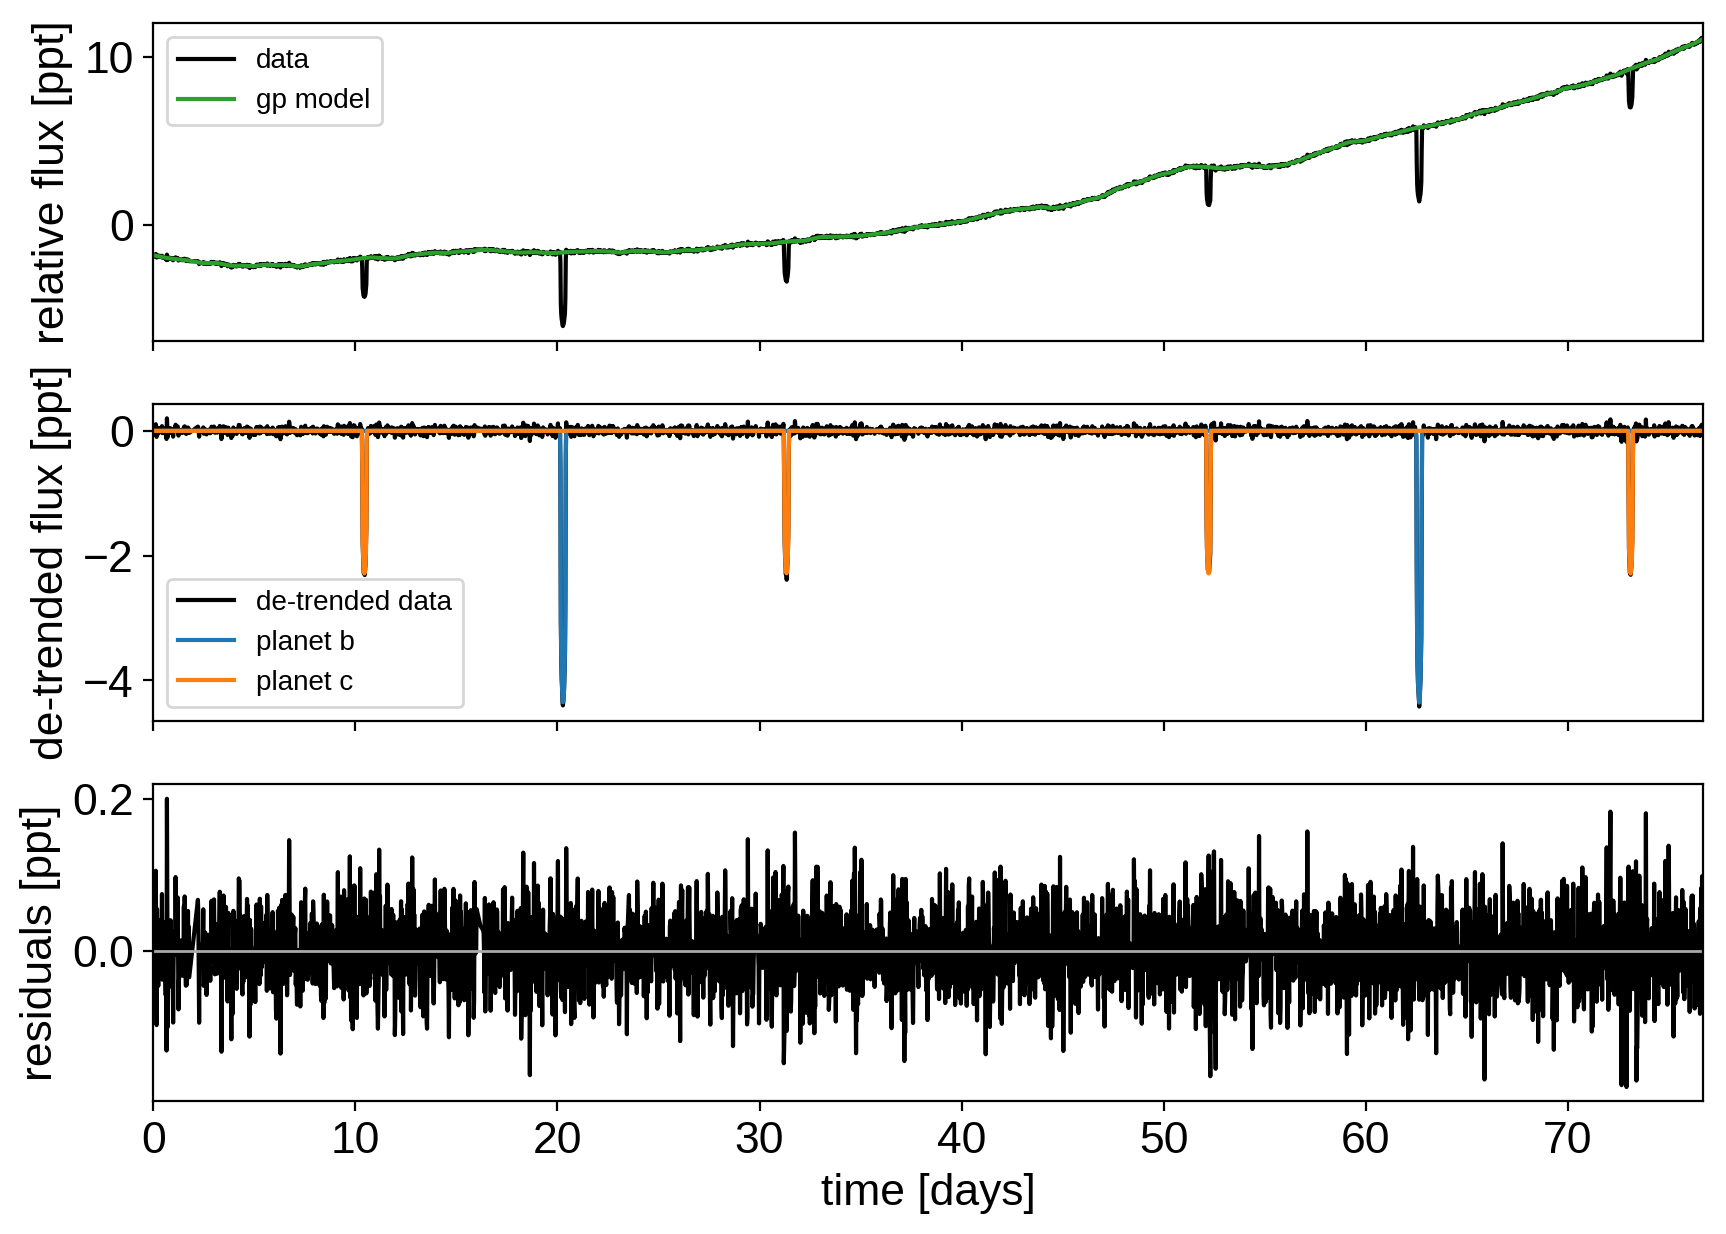

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:24, 32.04draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:01<00:52, 14.81draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:01<00:48, 15.98draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:01<01:32,  8.41draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:02<01:17, 10.07draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:02<01:52,  6.91draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:02<01:30,  8.54draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:03<02:06,  6.09draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:03<02:09,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:03<01:45,  7.22draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:04<02:09,  5.88draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:04<01:48,  7.02draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:04<02:07,  5.97draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:05<01:45,  7.18draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:05<02:04,  6.05draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:05<01:43,  7.25draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:06<02:03,  6.09draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:06<01:58,  6.32draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:06<01:36,  7.75draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:06<02:01,  6.16draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:07<01:39,  7.50draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:07<02:03,  5.99draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:07<01:38,  7.48draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:08<02:03,  5.99draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:08<01:41,  7.25draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:08<02:01,  6.05draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:08<01:43,  7.10draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:09<02:46,  4.39draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:09<02:08,  5.66draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:09<02:19,  5.21draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:10<01:56,  6.21draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:10<02:49,  4.27draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:10<02:12,  5.43draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:11<02:58,  4.03draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:11<02:19,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:11<03:02,  3.91draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:11<02:18,  5.15draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:12<02:33,  4.63draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:12<02:02,  5.76draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:13<02:12,  5.34draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:13<01:56,  6.06draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:13<02:36,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:13<02:07,  5.48draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:14<02:44,  4.26draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:14<02:11,  5.31draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:14<02:46,  4.17draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:14<02:06,  5.46draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:15<02:20,  4.93draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:15<01:50,  6.23draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:16<02:06,  5.44draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:16<01:51,  6.14draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:16<01:35,  7.20draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:16<02:15,  5.03draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:16<01:55,  5.88draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:16<01:44,  6.50draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:17<02:11,  5.18draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:17<01:46,  6.35draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:17<01:49,  6.17draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:17<02:21,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:18<01:53,  5.95draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:18<01:49,  6.11draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:18<02:23,  4.68draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:18<01:53,  5.90draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:18<01:49,  6.07draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:19<02:20,  4.74draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:19<01:53,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:19<01:53,  5.87draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:19<02:14,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:19<01:55,  5.72draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:20<01:45,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:20<02:02,  5.36draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:20<01:51,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:20<01:41,  6.44draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:20<02:01,  5.38draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:21<01:44,  6.24draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:21<01:40,  6.50draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:21<01:54,  5.68draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:21<01:37,  6.63draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:21<01:46,  6.09draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:22<02:04,  5.21draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:22<01:47,  6.03draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:22<01:40,  6.40draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:22<02:00,  5.33draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:23<01:47,  5.96draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:23<01:53,  5.62draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:23<01:38,  6.45draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:24<01:48,  5.86draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:24<01:34,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:24<01:45,  5.99draws/s]

Sampling 4 chains:  22%|██▏       | 179/808 [00:24<01:35,  6.58draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:25<01:41,  6.19draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:25<01:33,  6.70draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:25<01:38,  6.31draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:26<01:33,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:26<01:37,  6.38draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:26<01:32,  6.67draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:27<01:37,  6.32draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:27<01:31,  6.73draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:27<01:37,  6.29draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:28<01:31,  6.69draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:28<01:34,  6.41draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:28<01:34,  6.42draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:28<01:34,  6.40draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:29<01:32,  6.50draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:29<01:31,  6.56draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:29<01:27,  6.82draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:29<01:31,  6.52draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:30<01:30,  6.61draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:30<01:31,  6.48draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:30<01:34,  6.31draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:30<01:29,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:30<01:37,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:31<01:31,  6.43draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:31<01:23,  7.08draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:31<01:31,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:31<01:43,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:31<01:30,  6.48draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:32<01:37,  5.95draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:32<01:43,  5.62draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:32<01:34,  6.12draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:32<01:32,  6.28draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:32<01:39,  5.78draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:32<01:30,  6.36draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:33<01:26,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:33<01:37,  5.90draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:33<01:33,  6.15draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:33<01:29,  6.37draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:34<01:31,  6.24draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:34<01:32,  6.12draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:34<01:26,  6.52draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:34<01:30,  6.29draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:34<01:35,  5.94draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:35<01:26,  6.49draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:35<01:28,  6.33draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:35<01:34,  5.91draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:35<01:31,  6.12draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:35<01:21,  6.84draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:36<01:30,  6.17draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:36<01:29,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:36<01:27,  6.29draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:37<01:25,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:37<01:28,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:37<01:23,  6.56draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:37<01:27,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:38<01:21,  6.67draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:38<01:25,  6.30draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:38<01:22,  6.57draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:39<01:26,  6.18draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:39<01:19,  6.71draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:39<01:24,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:40<01:19,  6.71draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:40<01:23,  6.34draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:40<01:22,  6.41draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:41<01:20,  6.50draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:41<01:23,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:41<01:18,  6.64draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:42<01:22,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:42<01:18,  6.60draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:42<01:21,  6.30draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:42<01:19,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:43<01:19,  6.42draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:43<01:17,  6.60draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:43<01:18,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:43<01:10,  7.15draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:44<01:16,  6.60draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:44<01:17,  6.53draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:44<01:15,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:44<01:15,  6.62draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:44<01:09,  7.21draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:45<01:17,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:45<01:20,  6.15draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:45<01:14,  6.66draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:45<01:08,  7.29draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:45<01:18,  6.33draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:45<01:24,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:46<01:13,  6.73draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:46<01:26,  5.70draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:46<01:29,  5.48draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:46<01:14,  6.55draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:46<01:29,  5.45draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:47<01:32,  5.28draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:47<01:14,  6.49draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:47<01:28,  5.48draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:47<01:32,  5.22draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:47<01:14,  6.44draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:48<01:28,  5.44draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:48<01:32,  5.18draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:48<01:16,  6.22draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:48<01:28,  5.39draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:48<01:33,  5.09draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:49<01:15,  6.23draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:49<01:29,  5.27draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:49<01:33,  5.01draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:49<01:14,  6.31draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:50<01:33,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:50<01:30,  5.14draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:50<01:12,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:50<01:32,  5.03draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:50<01:27,  5.26draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:51<01:16,  6.02draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:51<01:24,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:51<01:22,  5.54draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:51<01:14,  6.11draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:51<01:19,  5.73draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:52<01:17,  5.86draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:52<01:11,  6.34draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:52<01:18,  5.73draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:52<01:12,  6.18draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:52<01:10,  6.37draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:53<01:14,  5.96draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:53<01:09,  6.38draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:53<01:06,  6.73draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:53<01:06,  6.68draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:53<01:13,  6.02draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:53<01:09,  6.32draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:53<01:06,  6.66draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:54<01:03,  6.96draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:54<01:13,  5.98draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:54<01:08,  6.42draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:54<01:11,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [00:55<01:12,  5.96draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:55<01:06,  6.47draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:55<01:00,  7.16draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:55<01:18,  5.51draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:55<01:08,  6.28draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:55<01:02,  6.84draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:56<01:22,  5.16draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:56<01:09,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:56<01:03,  6.66draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:56<01:26,  4.91draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:57<01:10,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:57<01:04,  6.54draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:57<01:24,  4.98draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:57<01:09,  6.03draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:57<01:06,  6.29draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:58<01:22,  5.04draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:58<01:08,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [00:58<01:07,  6.13draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:58<01:19,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:58<01:07,  6.03draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:59<01:06,  6.18draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:59<01:16,  5.33draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:59<01:05,  6.16draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:59<01:03,  6.39draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:59<01:16,  5.25draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [01:00<01:06,  6.04draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:00<01:07,  5.95draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:00<01:12,  5.51draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:00<01:08,  5.85draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:00<01:01,  6.41draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [01:01<01:19,  4.99draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [01:01<01:02,  6.33draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:01<01:06,  5.88draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:01<01:22,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:01<01:05,  5.97draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:02<01:11,  5.39draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:02<01:17,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:02<01:03,  6.06draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:02<01:09,  5.55draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:03<01:14,  5.16draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [01:03<01:05,  5.86draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:03<01:02,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:03<01:12,  5.20draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:03<01:01,  6.11draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [01:04<01:00,  6.20draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:04<01:14,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:04<01:00,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:04<01:04,  5.81draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [01:04<01:12,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:05<00:59,  6.16draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:05<01:01,  6.01draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:05<01:12,  5.03draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:05<01:00,  5.99draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:05<00:57,  6.29draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:06<01:13,  4.96draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:06<01:00,  5.99draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:06<00:57,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:06<01:11,  5.03draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:06<00:58,  6.10draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:07<00:56,  6.25draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:07<01:11,  4.96draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:07<00:59,  5.96draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:07<00:55,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:08<01:10,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:08<00:57,  6.02draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [01:08<00:54,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:08<01:08,  5.04draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:08<00:59,  5.83draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:09<01:01,  5.62draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:09<00:54,  6.24draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:09<00:56,  5.99draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:10<00:51,  6.58draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:10<00:55,  6.07draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:10<00:50,  6.58draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:11<00:54,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:11<00:48,  6.73draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [01:11<00:46,  7.06draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:11<00:58,  5.63draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:11<00:52,  6.20draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [01:12<00:47,  6.85draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:12<00:56,  5.67draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:12<00:53,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [01:12<00:46,  6.83draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:12<00:53,  5.99draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:13<00:50,  6.23draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:13<00:47,  6.65draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:13<00:50,  6.25draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:13<00:49,  6.37draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:13<00:45,  6.88draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:14<00:48,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [01:14<00:44,  6.96draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:14<00:49,  6.29draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:14<00:48,  6.37draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:14<00:46,  6.60draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [01:14<00:44,  6.90draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:15<00:48,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:15<00:50,  5.99draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [01:15<00:47,  6.39draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:15<00:52,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:15<00:50,  5.97draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:16<00:45,  6.58draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:16<00:51,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:16<00:51,  5.75draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:16<00:44,  6.58draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:16<00:50,  5.78draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:17<00:50,  5.74draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:17<00:44,  6.49draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [01:17<00:41,  6.96draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:17<00:46,  6.27draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:17<00:47,  6.08draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:17<00:42,  6.80draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [01:17<00:41,  6.92draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:18<00:47,  6.06draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:18<00:44,  6.36draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:18<00:41,  6.75draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [01:18<00:39,  7.16draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:18<00:47,  5.90draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:18<00:44,  6.29draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:19<00:43,  6.37draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:19<00:43,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:19<00:44,  6.19draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:19<00:40,  6.84draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [01:19<00:38,  7.19draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:19<00:42,  6.37draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:20<00:45,  5.98draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:20<00:42,  6.44draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [01:20<00:38,  6.97draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:20<00:40,  6.57draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [01:20<00:48,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [01:20<00:40,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:21<00:43,  6.10draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:21<00:49,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [01:21<00:41,  6.39draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:21<00:47,  5.48draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [01:22<00:49,  5.27draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:22<00:41,  6.20draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:22<00:44,  5.80draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:22<00:47,  5.41draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:22<00:42,  6.03draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:23<00:42,  5.95draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:23<00:49,  5.12draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:23<00:40,  6.20draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:23<00:42,  5.88draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:23<00:47,  5.17draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:24<00:39,  6.27draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:24<00:43,  5.57draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:24<00:46,  5.27draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [01:24<00:38,  6.22draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:24<00:43,  5.54draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:25<00:45,  5.32draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:25<00:39,  6.07draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [01:25<00:34,  6.86draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:25<00:36,  6.48draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:25<00:42,  5.61draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:25<00:37,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:26<00:34,  6.73draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:26<00:41,  5.62draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:26<00:37,  6.16draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:26<00:35,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:26<00:38,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:27<00:37,  6.09draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:27<00:34,  6.58draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:27<00:37,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:27<00:36,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:27<00:34,  6.46draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [01:28<00:36,  6.11draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:28<00:34,  6.35draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:28<00:32,  6.62draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:28<00:35,  6.16draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:28<00:35,  6.02draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:29<00:32,  6.54draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:29<00:35,  6.05draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:29<00:36,  5.82draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:29<00:33,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:29<00:31,  6.51draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:30<00:36,  5.72draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:30<00:33,  6.10draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:30<00:30,  6.66draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:30<00:35,  5.64draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:31<00:32,  6.21draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [01:31<00:30,  6.48draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:31<00:34,  5.77draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:31<00:31,  6.19draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:31<00:33,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:32<00:32,  6.04draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:32<00:31,  6.12draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:32<00:30,  6.22draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:32<00:29,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:32<00:29,  6.51draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:33<00:31,  6.05draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:33<00:28,  6.64draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [01:33<00:25,  7.36draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:33<00:27,  6.61draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:33<00:30,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:33<00:27,  6.59draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:34<00:26,  6.78draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:34<00:26,  6.84draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:34<00:28,  6.22draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:34<00:29,  6.09draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:34<00:26,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:35<00:30,  5.71draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:35<00:31,  5.63draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:35<00:26,  6.50draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:35<00:30,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [01:35<00:31,  5.47draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:35<00:26,  6.49draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:36<00:30,  5.56draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [01:36<00:31,  5.31draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:36<00:25,  6.45draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:36<00:29,  5.56draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:37<00:33,  4.88draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:37<00:28,  5.60draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:37<00:33,  4.80draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:38<00:27,  5.61draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:38<00:32,  4.84draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:38<00:27,  5.59draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:38<00:31,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:39<00:24,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:39<00:27,  5.35draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:39<00:29,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:39<00:23,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:39<00:26,  5.42draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:40<00:28,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:40<00:22,  6.16draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:40<00:25,  5.52draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:40<00:27,  5.03draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:40<00:21,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:41<00:24,  5.50draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:41<00:27,  4.97draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:41<00:21,  6.30draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:41<00:24,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:41<00:26,  4.94draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:42<00:20,  6.32draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:42<00:23,  5.45draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [01:42<00:20,  6.16draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:43<00:20,  6.13draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:43<00:19,  6.25draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [01:43<00:18,  6.75draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:43<00:18,  6.53draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:43<00:19,  6.15draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [01:43<00:17,  6.72draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:44<00:17,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:44<00:18,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [01:44<00:17,  6.51draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:44<00:16,  6.61draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:45<00:18,  6.02draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [01:45<00:16,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:45<00:16,  6.42draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:45<00:17,  6.28draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [01:45<00:15,  6.95draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:46<00:15,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:46<00:16,  6.42draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [01:46<00:14,  6.99draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:46<00:14,  6.75draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:46<00:15,  6.21draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:47<00:12,  7.74draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:47<00:19,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:47<00:17,  5.54draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:47<00:13,  7.04draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:48<00:16,  5.51draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:48<00:14,  5.95draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:48<00:15,  5.57draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:49<00:14,  5.97draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:49<00:14,  5.72draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:49<00:13,  6.07draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:50<00:14,  5.51draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:50<00:12,  6.04draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:50<00:14,  5.26draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:51<00:12,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:51<00:13,  5.21draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:51<00:11,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [01:51<00:12,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [01:52<00:11,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:52<00:11,  5.35draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [01:52<00:10,  5.92draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:53<00:10,  5.48draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:53<00:09,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:53<00:09,  6.08draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [01:53<00:06,  7.67draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [01:54<00:08,  6.04draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [01:54<00:06,  7.56draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:54<00:07,  6.05draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [01:55<00:07,  6.42draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [01:55<00:06,  6.34draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:55<00:06,  6.45draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [01:55<00:06,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:56<00:06,  6.14draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [01:56<00:05,  6.55draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:56<00:05,  6.12draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [01:56<00:05,  6.73draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [01:57<00:05,  6.18draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [01:57<00:04,  6.75draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [01:57<00:04,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [01:57<00:03,  6.93draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [01:58<00:03,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [01:58<00:03,  6.34draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [01:58<00:03,  6.72draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [01:58<00:02,  8.10draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:59<00:03,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [01:59<00:03,  5.83draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [01:59<00:02,  6.93draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:59<00:03,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [01:59<00:02,  5.80draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:00<00:02,  5.40draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:00<00:01,  6.23draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:00<00:01,  6.93draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:01<00:01,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:02<00:04,  1.45draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:03<00:02,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:03<00:01,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:05<00:02,  1.16draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:05<00:01,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:05<00:00,  1.78draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:05<00:00,  2.31draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:12, 31.61draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:01<00:25, 14.84draws/s]

Sampling 4 chains:   7%|▋         | 28/408 [00:01<00:21, 17.37draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:01<00:45,  8.27draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:02<00:53,  6.99draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:02<00:42,  8.75draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:03<00:57,  6.45draws/s]

Sampling 4 chains:  10%|▉         | 40/408 [00:03<00:46,  7.94draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:03<00:59,  6.15draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:03<00:48,  7.52draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:04<01:01,  5.92draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:04<00:48,  7.50draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:04<00:59,  6.04draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:05<00:45,  7.84draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:05<00:59,  5.89draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:06<01:02,  5.62draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:06<00:55,  6.23draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:07<00:54,  6.27draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:08<00:47,  6.98draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:08<00:48,  6.87draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:09<00:48,  6.77draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:09<00:37,  8.65draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:09<00:50,  6.37draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:10<00:49,  6.46draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:10<00:37,  8.42draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:11<00:49,  6.29draws/s]

Sampling 4 chains:  24%|██▍       | 98/408 [00:11<00:39,  7.76draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:11<00:47,  6.45draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:11<00:41,  7.39draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:12<00:48,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:12<00:39,  7.56draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:12<00:47,  6.26draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:13<00:40,  7.41draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:13<00:47,  6.15draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:13<00:37,  7.72draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:14<00:50,  5.80draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:14<00:49,  5.82draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:14<00:40,  7.08draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:15<00:41,  6.85draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:15<00:34,  8.01draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:16<00:44,  6.31draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:16<00:39,  7.10draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:16<00:29,  9.13draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:16<00:41,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:17<00:41,  6.43draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:17<00:40,  6.63draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:17<00:32,  8.25draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:17<00:42,  6.25draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:18<00:34,  7.69draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:18<00:43,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:18<00:34,  7.57draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:19<00:42,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:19<00:34,  7.38draws/s]

Sampling 4 chains:  38%|███▊      | 156/408 [00:19<00:43,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:20<00:42,  5.89draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:20<00:39,  6.27draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:20<00:38,  6.30draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:21<00:37,  6.53draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:21<00:36,  6.52draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:21<00:38,  6.19draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:22<00:34,  6.82draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:22<00:35,  6.64draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:22<00:35,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:22<00:34,  6.63draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:23<00:34,  6.58draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:23<00:33,  6.72draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:24<00:34,  6.49draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:24<00:32,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:24<00:34,  6.41draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:24<00:26,  8.10draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:25<00:36,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:25<00:37,  5.70draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:26<00:28,  7.46draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:26<00:35,  5.78draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:27<00:34,  5.99draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:27<00:32,  6.27draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:27<00:24,  8.20draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:27<00:31,  6.24draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:27<00:25,  7.78draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:28<00:31,  6.13draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:28<00:25,  7.56draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:29<00:31,  5.96draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:29<00:24,  7.54draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:29<00:31,  5.94draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:29<00:24,  7.51draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:30<00:30,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:30<00:24,  7.32draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:30<00:26,  6.64draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:31<00:25,  7.04draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:31<00:27,  6.36draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:31<00:25,  6.71draws/s]

Sampling 4 chains:  58%|█████▊    | 237/408 [00:31<00:22,  7.76draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:32<00:31,  5.41draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:32<00:29,  5.80draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:32<00:23,  7.04draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:32<00:34,  4.82draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:32<00:30,  5.36draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:33<00:26,  6.12draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:33<00:25,  6.30draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:33<00:24,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:33<00:22,  7.10draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:33<00:22,  7.00draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:34<00:18,  8.24draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:34<00:27,  5.48draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:34<00:25,  5.87draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:34<00:21,  6.97draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:34<00:29,  5.12draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:35<00:25,  5.74draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:35<00:23,  6.15draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:35<00:23,  6.08draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:35<00:22,  6.53draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:35<00:20,  6.87draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:36<00:19,  7.23draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:36<00:18,  7.69draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:36<00:18,  7.37draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:36<00:20,  6.72draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:36<00:16,  8.27draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:37<00:15,  8.74draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:37<00:18,  6.99draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:37<00:17,  7.39draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:38<00:19,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:38<00:19,  6.51draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:38<00:15,  7.97draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:38<00:19,  6.12draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:38<00:15,  7.72draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:39<00:16,  7.19draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:39<00:16,  7.13draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:39<00:16,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:40<00:18,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:40<00:14,  7.82draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:40<00:17,  6.33draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:40<00:15,  6.95draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:41<00:14,  7.05draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:41<00:18,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:41<00:16,  6.40draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:41<00:14,  6.93draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:41<00:14,  7.00draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:41<00:13,  7.40draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:42<00:13,  7.45draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:42<00:14,  6.57draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:42<00:13,  7.09draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:42<00:12,  7.71draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:43<00:13,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:43<00:13,  6.77draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:43<00:10,  8.26draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:43<00:13,  6.28draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:43<00:10,  7.86draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:44<00:13,  6.10draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:44<00:10,  7.66draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:44<00:13,  6.04draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:45<00:11,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:45<00:11,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:45<00:10,  7.15draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:46<00:10,  6.77draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:46<00:08,  8.32draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:46<00:10,  6.24draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:46<00:08,  7.85draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:47<00:10,  6.08draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:47<00:08,  7.59draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:48<00:09,  6.01draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:48<00:07,  7.32draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:48<00:09,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:48<00:08,  6.74draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:49<00:08,  6.29draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:49<00:05,  8.00draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:49<00:07,  6.09draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:50<00:06,  7.05draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:50<00:06,  6.03draws/s]

Sampling 4 chains:  90%|█████████ | 369/408 [00:50<00:05,  7.50draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:51<00:06,  6.07draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:51<00:04,  7.51draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:51<00:05,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:51<00:04,  7.37draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:52<00:05,  5.79draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:52<00:03,  7.11draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:53<00:04,  5.87draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:53<00:03,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:53<00:03,  5.98draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:53<00:02,  7.00draws/s]

Sampling 4 chains:  96%|█████████▌| 390/408 [00:54<00:03,  5.31draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:54<00:03,  5.61draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:54<00:02,  6.74draws/s]

Sampling 4 chains:  97%|█████████▋| 394/408 [00:54<00:02,  5.20draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:54<00:02,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:55<00:01,  6.65draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:55<00:01,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:55<00:01,  5.41draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:55<00:01,  6.14draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:55<00:00,  6.21draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:56<00:00,  5.88draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:56<00:00,  6.41draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:58<00:02,  1.39draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:58<00:00,  1.83draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:58<00:00,  2.30draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<08:51,  1.52draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<06:18,  2.11draws/s]

Sampling 4 chains:   1%|          | 8/808 [00:01<06:02,  2.21draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:01<04:33,  2.91draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:01<04:37,  2.87draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:02<03:26,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:02<03:25,  3.85draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:02<02:49,  4.65draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:03<03:12,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:03<02:39,  4.91draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:03<03:11,  4.10draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:04<02:36,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:04<03:06,  4.18draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:04<02:33,  5.06draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:05<03:02,  4.25draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:05<02:23,  5.40draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:05<02:21,  5.44draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:05<02:57,  4.35draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:05<02:21,  5.44draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:06<02:18,  5.57draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:06<02:51,  4.47draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:06<02:19,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:06<02:08,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:07<02:53,  4.42draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:07<02:22,  5.34draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:07<02:29,  5.07draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:07<02:12,  5.70draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:08<02:23,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:08<02:06,  5.97draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:09<02:15,  5.55draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:09<01:58,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:09<02:09,  5.76draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:09<01:55,  6.48draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:10<02:11,  5.65draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:10<01:54,  6.47draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:11<02:08,  5.77draws/s]

Sampling 4 chains:   9%|▊         | 70/808 [00:11<01:56,  6.33draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:11<02:05,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:11<01:56,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:12<02:01,  6.02draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:12<01:55,  6.34draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:12<01:58,  6.12draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:13<01:54,  6.35draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:13<01:56,  6.20draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:13<01:53,  6.40draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:13<02:01,  5.96draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:14<01:55,  6.22draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:14<02:01,  5.90draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:14<02:01,  5.92draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:14<01:53,  6.31draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:15<02:08,  5.58draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:15<02:04,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:15<01:55,  6.15draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:15<02:18,  5.14draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:15<01:58,  5.98draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:16<01:58,  5.98draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:16<02:08,  5.51draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:16<01:42,  6.87draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:16<02:21,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:17<02:29,  4.69draws/s]

Sampling 4 chains:  13%|█▎        | 108/808 [00:17<02:13,  5.26draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:17<02:29,  4.67draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:18<02:10,  5.34draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:18<02:28,  4.68draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:18<02:08,  5.38draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:19<02:40,  4.31draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:19<02:11,  5.23draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:19<02:46,  4.14draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:20<02:13,  5.12draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:20<02:53,  3.93draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:20<02:16,  4.97draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:21<02:59,  3.78draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:21<02:20,  4.80draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:21<03:04,  3.66draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:21<02:22,  4.72draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:22<03:06,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:22<02:22,  4.68draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:22<03:10,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:23<02:23,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:23<02:30,  4.40draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:23<01:57,  5.62draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:24<02:10,  5.06draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:24<01:45,  6.21draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:24<02:00,  5.46draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:24<01:47,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:25<01:47,  6.06draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:25<01:48,  6.00draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:26<01:44,  6.16draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:26<01:50,  5.83draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:26<01:27,  7.36draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:26<01:55,  5.57draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:27<01:32,  6.91draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:27<01:54,  5.55draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:27<01:33,  6.79draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:28<01:51,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:28<01:38,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:28<01:58,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:28<01:50,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:29<01:44,  6.01draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:29<01:50,  5.66draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:29<01:45,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:29<01:44,  5.99draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:29<01:44,  5.96draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:30<01:41,  6.14draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:30<01:42,  6.05draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:30<01:40,  6.15draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:30<01:35,  6.50draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:30<01:28,  6.99draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:31<01:51,  5.53draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:31<01:45,  5.86draws/s]

Sampling 4 chains:  24%|██▍       | 194/808 [00:31<01:35,  6.46draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:31<01:27,  7.04draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:31<01:51,  5.49draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:31<01:44,  5.85draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:32<01:34,  6.49draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:32<01:28,  6.89draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:32<01:46,  5.71draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:32<01:40,  6.06draws/s]

Sampling 4 chains:  25%|██▌       | 202/808 [00:32<01:34,  6.45draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:32<01:25,  7.07draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:33<01:46,  5.70draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:33<01:44,  5.76draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:33<01:38,  6.13draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:33<01:31,  6.60draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:33<01:42,  5.85draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:33<01:39,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:34<01:37,  6.13draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:34<01:28,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:34<01:39,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:34<01:38,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:34<01:38,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:34<01:37,  6.11draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:34<01:32,  6.37draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:35<01:39,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:35<01:33,  6.33draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:35<01:46,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:35<01:40,  5.85draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:35<01:34,  6.22draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:36<01:44,  5.57draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:36<01:39,  5.86draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:36<01:38,  5.91draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:36<01:48,  5.37draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:37<01:37,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:37<01:37,  5.95draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:37<01:45,  5.46draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:37<01:37,  5.89draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:37<01:34,  6.06draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:38<01:48,  5.26draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:38<01:36,  5.95draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:38<01:33,  6.07draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:38<01:50,  5.15draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:39<01:38,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:39<01:40,  5.65draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:39<01:46,  5.29draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:39<01:31,  6.14draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:39<01:30,  6.24draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:39<01:30,  6.24draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:40<01:42,  5.49draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:40<01:35,  5.84draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:40<01:27,  6.35draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:40<01:40,  5.55draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:41<01:33,  5.92draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:41<01:29,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:41<01:35,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:41<01:32,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:41<01:25,  6.47draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:42<01:33,  5.85draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:42<01:29,  6.11draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:42<01:22,  6.62draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:42<01:37,  5.58draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:43<01:32,  5.90draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:43<01:22,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:43<01:38,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:43<01:31,  5.91draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:44<01:33,  5.76draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:44<01:25,  6.23draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:44<01:24,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:44<01:41,  5.26draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:44<01:27,  6.07draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:45<01:31,  5.78draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:45<01:43,  5.11draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:45<01:30,  5.81draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:45<01:28,  5.92draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:46<01:42,  5.12draws/s]

Sampling 4 chains:  35%|███▌      | 285/808 [00:46<01:29,  5.82draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:46<01:30,  5.79draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:46<01:45,  4.92draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:46<01:29,  5.80draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:47<01:37,  5.33draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:47<01:40,  5.16draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:47<01:28,  5.79draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:47<01:36,  5.34draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:47<01:31,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:48<01:24,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:48<01:21,  6.25draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:48<01:29,  5.73draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:48<01:27,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:48<01:25,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:48<01:16,  6.61draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:49<01:27,  5.80draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:49<01:26,  5.82draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:49<01:20,  6.25draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:49<01:14,  6.73draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:49<01:28,  5.68draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:49<01:23,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:50<01:17,  6.44draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:50<01:18,  6.35draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:50<01:30,  5.50draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:50<01:20,  6.20draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:50<01:15,  6.57draws/s]

Sampling 4 chains:  39%|███▊      | 313/808 [00:50<01:18,  6.32draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:51<01:30,  5.49draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:51<01:21,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:51<01:14,  6.63draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:51<01:15,  6.51draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:51<01:28,  5.54draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:51<01:22,  5.91draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:52<01:12,  6.70draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:52<01:18,  6.18draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:52<01:24,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:52<01:18,  6.20draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:52<01:10,  6.90draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:52<01:22,  5.89draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:53<01:20,  5.98draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:53<01:15,  6.35draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:53<01:09,  6.92draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:53<01:23,  5.71draws/s]

Sampling 4 chains:  41%|████      | 330/808 [00:53<01:19,  5.98draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:53<01:11,  6.66draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:53<01:12,  6.60draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:54<01:22,  5.77draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:54<01:18,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:54<01:14,  6.30draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:54<01:21,  5.76draws/s]

Sampling 4 chains:  42%|████▏     | 338/808 [00:54<01:21,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:55<01:17,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:55<01:21,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:55<01:16,  6.08draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:55<01:15,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:56<01:24,  5.51draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:56<01:15,  6.13draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:56<01:14,  6.20draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:56<01:22,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:56<01:16,  5.99draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:57<01:13,  6.18draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:57<01:26,  5.25draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:57<01:15,  5.99draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:57<01:12,  6.28draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:58<01:26,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:58<01:17,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:58<01:10,  6.35draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:58<01:26,  5.15draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:58<01:17,  5.75draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:59<01:08,  6.44draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:59<01:28,  5.00draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:59<01:19,  5.58draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:59<01:08,  6.46draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [01:00<01:31,  4.82draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [01:00<01:18,  5.61draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [01:00<01:08,  6.36draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [01:00<01:30,  4.82draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [01:00<01:18,  5.55draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:01<01:07,  6.42draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [01:01<01:28,  4.85draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:01<01:18,  5.47draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [01:01<01:06,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [01:02<01:28,  4.80draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [01:02<01:19,  5.39draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:02<01:05,  6.46draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [01:02<01:29,  4.75draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:02<01:25,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [01:03<01:06,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:03<01:29,  4.69draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:03<01:28,  4.72draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [01:04<01:20,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:04<01:20,  5.12draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:04<01:14,  5.50draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:04<01:20,  5.07draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:05<01:13,  5.55draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:05<01:18,  5.15draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [01:05<01:13,  5.51draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:06<01:14,  5.43draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:06<01:10,  5.67draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [01:06<01:09,  5.72draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [01:07<01:07,  5.82draws/s]

Sampling 4 chains:  51%|█████     | 414/808 [01:07<01:06,  5.94draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:07<01:06,  5.90draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [01:08<01:04,  6.01draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:08<01:04,  6.00draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [01:08<01:01,  6.25draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:09<01:02,  6.09draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:09<00:59,  6.43draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [01:09<01:01,  6.15draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:10<00:50,  7.53draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:10<01:05,  5.72draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [01:10<00:49,  7.53draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:11<01:07,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 440/808 [01:11<00:53,  6.82draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:12<01:05,  5.58draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [01:12<00:54,  6.69draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:12<01:06,  5.46draws/s]

Sampling 4 chains:  55%|█████▌    | 448/808 [01:12<00:51,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [01:13<01:04,  5.56draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [01:13<00:51,  6.90draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [01:13<01:03,  5.54draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:14<00:49,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:14<01:02,  5.60draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:15<01:02,  5.56draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:15<00:54,  6.37draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:15<00:56,  6.07draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:15<00:50,  6.81draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:16<00:45,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:16<00:54,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [01:16<00:47,  7.05draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:17<00:55,  6.09draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:17<00:50,  6.56draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [01:17<00:45,  7.26draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [01:17<00:53,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:17<00:50,  6.54draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:18<00:52,  6.19draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:18<00:45,  7.12draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [01:19<00:55,  5.84draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:19<00:45,  7.02draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:19<00:55,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:19<00:45,  6.98draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:20<00:42,  7.38draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:20<01:07,  4.67draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:20<00:53,  5.86draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:20<00:52,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:21<01:08,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:21<00:53,  5.76draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:21<00:53,  5.72draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:21<01:09,  4.41draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:21<00:53,  5.68draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:21<00:53,  5.64draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:22<01:07,  4.51draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:22<00:53,  5.67draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:22<00:54,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [01:22<01:06,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:23<00:52,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:23<00:53,  5.55draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [01:23<01:03,  4.61draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:23<00:51,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [01:23<00:52,  5.53draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:24<01:01,  4.76draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:24<00:49,  5.86draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:24<00:51,  5.62draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:24<01:00,  4.73draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:25<00:49,  5.75draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:25<00:51,  5.55draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:25<01:01,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:25<00:48,  5.82draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:25<00:49,  5.69draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:26<01:05,  4.29draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:26<00:53,  5.19draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:26<01:07,  4.09draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:27<00:54,  5.01draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:27<01:08,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [01:27<00:54,  4.89draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:28<01:06,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:28<00:54,  4.87draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:28<01:03,  4.14draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:28<00:49,  5.31draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [01:29<00:52,  4.92draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:29<00:57,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:29<00:45,  5.64draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:29<00:50,  5.03draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:30<00:55,  4.62draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:30<00:43,  5.78draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [01:30<00:50,  4.99draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:30<00:52,  4.74draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:30<00:42,  5.86draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [01:31<00:49,  5.00draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:31<00:50,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [01:31<00:41,  5.93draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:31<00:49,  4.95draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:32<00:50,  4.85draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [01:32<00:39,  6.08draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:32<00:50,  4.80draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:32<00:51,  4.65draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:33<00:44,  5.25draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:33<00:49,  4.79draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:33<00:43,  5.39draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:33<00:46,  4.99draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:34<00:41,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:34<00:43,  5.23draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [01:34<00:37,  6.05draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [01:35<00:37,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [01:35<00:38,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:35<00:34,  6.42draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [01:35<00:35,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [01:35<00:34,  6.30draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [01:35<00:31,  7.00draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:36<00:34,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [01:36<00:33,  6.34draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:36<00:29,  7.11draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:37<00:39,  5.33draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:37<00:39,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:37<00:33,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:37<00:39,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:37<00:39,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:38<00:33,  6.07draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:38<00:38,  5.29draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:38<00:38,  5.28draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [01:38<00:33,  6.10draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:38<00:29,  6.83draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [01:38<00:35,  5.69draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:39<00:38,  5.15draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:39<00:31,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [01:39<00:35,  5.52draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:39<00:40,  4.76draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:40<00:32,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [01:40<00:37,  5.06draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:40<00:39,  4.86draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:40<00:32,  5.90draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [01:40<00:37,  5.07draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:41<00:36,  5.14draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [01:41<00:30,  6.01draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:41<00:36,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:41<00:33,  5.47draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [01:42<00:30,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:42<00:32,  5.46draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:42<00:29,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [01:42<00:28,  6.16draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:42<00:30,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:42<00:26,  6.56draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [01:43<00:27,  6.28draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:43<00:30,  5.70draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:43<00:25,  6.68draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [01:43<00:30,  5.56draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:44<00:32,  5.21draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:44<00:26,  6.28draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:44<00:32,  5.14draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [01:44<00:33,  4.85draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [01:44<00:26,  6.14draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [01:45<00:31,  5.05draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:45<00:33,  4.72draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [01:45<00:25,  6.09draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:46<00:30,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [01:46<00:23,  6.57draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:46<00:27,  5.48draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:46<00:23,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:47<00:24,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:47<00:25,  5.88draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:47<00:23,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:47<00:23,  6.25draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:48<00:23,  6.11draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:48<00:23,  6.09draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:48<00:22,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:48<00:23,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:48<00:23,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:49<00:22,  5.98draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:49<00:21,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:49<00:23,  5.86draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:49<00:22,  5.89draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:49<00:19,  6.70draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:50<00:22,  5.78draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:50<00:21,  5.88draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:50<00:20,  6.38draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:50<00:21,  5.81draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:51<00:20,  5.97draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:51<00:20,  6.07draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:51<00:20,  6.00draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:51<00:19,  6.14draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:51<00:20,  5.84draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:52<00:18,  6.27draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:52<00:18,  6.32draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:52<00:20,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:52<00:18,  6.18draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:53<00:17,  6.43draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:53<00:20,  5.49draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:53<00:18,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:53<00:16,  6.46draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:53<00:19,  5.53draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:54<00:17,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:54<00:16,  6.29draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:54<00:18,  5.52draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:54<00:17,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:54<00:16,  6.30draws/s]

Sampling 4 chains:  88%|████████▊ | 708/808 [01:55<00:17,  5.62draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:55<00:16,  6.14draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [01:55<00:15,  6.53draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:55<00:14,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:55<00:17,  5.60draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:55<00:15,  6.28draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [01:56<00:14,  6.66draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:56<00:14,  6.58draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:56<00:16,  5.65draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:56<00:15,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [01:56<00:13,  6.82draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:56<00:13,  6.41draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [01:57<00:15,  5.70draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:57<00:14,  6.20draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [01:57<00:12,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:57<00:12,  6.66draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:57<00:15,  5.38draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:57<00:13,  6.19draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [01:58<00:12,  6.40draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:58<00:11,  7.01draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:58<00:15,  5.31draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [01:58<00:13,  5.63draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [01:59<00:13,  5.76draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [01:59<00:12,  5.87draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:59<00:12,  5.87draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [02:00<00:11,  6.10draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [02:00<00:11,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [02:00<00:10,  6.10draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [02:01<00:10,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [02:01<00:10,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [02:01<00:09,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [02:02<00:09,  5.88draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [02:02<00:08,  6.43draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [02:02<00:09,  5.76draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [02:02<00:07,  6.57draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [02:03<00:08,  5.81draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [02:03<00:07,  6.63draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [02:03<00:06,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [02:04<00:09,  5.04draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [02:04<00:07,  5.91draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [02:04<00:07,  5.48draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [02:04<00:06,  6.44draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [02:04<00:05,  6.77draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [02:05<00:07,  5.11draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [02:05<00:06,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [02:05<00:05,  6.30draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [02:05<00:06,  5.11draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [02:06<00:05,  5.90draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:06<00:04,  6.39draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [02:06<00:05,  5.20draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [02:06<00:04,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:06<00:04,  6.52draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [02:07<00:04,  5.39draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [02:07<00:04,  6.10draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [02:07<00:03,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:07<00:03,  6.03draws/s]

Sampling 4 chains:  97%|█████████▋| 787/808 [02:07<00:03,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:08<00:03,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:08<00:02,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:08<00:03,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [02:08<00:02,  6.49draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:09<00:02,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [02:09<00:02,  4.65draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:09<00:01,  5.96draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:09<00:02,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:10<00:02,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:10<00:02,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:11<00:03,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:11<00:02,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:12<00:02,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:13<00:02,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:14<00:01,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:14<00:01,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:15<00:00,  1.46draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:15<00:00,  1.72draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/1608 [00:00<00:52, 30.69draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<02:28, 10.76draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:00<02:17, 11.65draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:01<05:01,  5.29draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:01<04:02,  6.57draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<06:20,  4.18draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:02<04:55,  5.38draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:02<05:18,  4.97draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:02<04:19,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:03<06:47,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 28/1608 [00:03<05:11,  5.07draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:03<05:36,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:04<04:25,  5.94draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:04<04:17,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:04<04:26,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:04<03:36,  7.27draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:04<03:24,  7.66draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:05<03:29,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:05<02:44,  9.51draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:05<02:18, 11.26draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:05<02:11, 11.83draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:05<02:19, 11.16draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:06<02:23, 10.86draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:06<02:37,  9.87draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:06<03:10,  8.13draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:06<02:57,  8.74draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:06<03:01,  8.54draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:07<03:39,  7.04draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:07<03:31,  7.29draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:07<03:12,  8.03draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:07<03:21,  7.66draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:07<03:42,  6.94draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:07<03:46,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:08<03:24,  7.52draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:08<03:37,  7.04draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:08<03:19,  7.69draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:09<03:32,  7.19draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:09<02:45,  9.24draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:09<02:43,  9.35draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:09<02:29, 10.19draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:09<02:19, 10.88draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:10<02:56,  8.58draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:10<02:43,  9.29draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:10<02:59,  8.43draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:10<03:02,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:10<02:49,  8.90draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:11<02:22, 10.57draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:11<02:51,  8.80draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:11<02:36,  9.60draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:11<02:25, 10.32draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:11<02:19, 10.72draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:12<01:59, 12.54draws/s]

Sampling 4 chains:   7%|▋         | 113/1608 [00:12<01:51, 13.42draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:12<02:30,  9.91draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:12<02:24, 10.28draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:13<02:37,  9.46draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:13<02:34,  9.63draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:13<02:29,  9.95draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:13<02:43,  9.08draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:13<02:32,  9.71draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:14<02:28,  9.94draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:14<02:56,  8.38draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:14<02:48,  8.73draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:14<03:21,  7.33draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:14<02:47,  8.80draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:14<02:45,  8.91draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:15<03:07,  7.83draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:15<03:17,  7.43draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:15<02:53,  8.43draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:16<04:19,  5.63draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:16<03:26,  7.06draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:16<03:04,  7.89draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:16<03:22,  7.18draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:17<03:04,  7.88draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:17<02:50,  8.52draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:17<02:51,  8.42draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:18<02:58,  8.10draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:18<02:52,  8.38draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:18<02:24,  9.97draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:18<02:46,  8.63draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:19<02:40,  8.94draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:19<02:47,  8.59draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:19<03:09,  7.57draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:19<02:47,  8.55draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:19<03:01,  7.86draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:20<03:15,  7.30draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:20<03:26,  6.91draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:20<02:52,  8.28draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:20<02:48,  8.44draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:20<03:03,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:20<02:49,  8.38draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:21<03:51,  6.14draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:21<03:43,  6.34draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:21<03:28,  6.78draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:21<03:10,  7.42draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:21<02:56,  8.01draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:21<02:49,  8.32draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:22<03:01,  7.78draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:22<02:31,  9.28draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:22<02:32,  9.21draws/s]

Sampling 4 chains:  13%|█▎        | 204/1608 [00:22<02:40,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 207/1608 [00:23<02:14, 10.40draws/s]

Sampling 4 chains:  13%|█▎        | 209/1608 [00:23<02:16, 10.22draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:23<02:35,  8.97draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:23<02:31,  9.19draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:23<02:18, 10.05draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:24<02:16, 10.19draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:24<02:37,  8.80draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:24<02:56,  7.88draws/s]

Sampling 4 chains:  14%|█▍        | 223/1608 [00:24<02:37,  8.78draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:24<02:21,  9.79draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:25<02:43,  8.47draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:25<02:33,  8.99draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:25<03:21,  6.84draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:26<03:15,  7.04draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:26<02:44,  8.34draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:26<03:02,  7.50draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:26<03:59,  5.74draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:26<03:30,  6.51draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:27<03:19,  6.86draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:27<03:34,  6.36draws/s]

Sampling 4 chains:  15%|█▌        | 243/1608 [00:27<03:44,  6.08draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:27<03:20,  6.79draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:28<03:25,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:28<03:09,  7.16draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:28<02:39,  8.51draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:28<02:16,  9.91draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:28<02:13, 10.12draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:29<02:03, 10.91draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:29<01:56, 11.56draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:29<01:59, 11.25draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:29<02:11, 10.19draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:30<02:03, 10.85draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:30<01:51, 11.99draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:30<01:38, 13.54draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:30<02:42,  8.20draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:31<02:22,  9.34draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:31<02:40,  8.25draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:31<02:22,  9.33draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:31<02:13,  9.94draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:31<02:34,  8.56draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:32<02:17,  9.58draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:32<02:08, 10.28draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:32<01:57, 11.17draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:32<02:07, 10.28draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:32<01:46, 12.35draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:33<02:41,  8.10draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:33<02:16,  9.57draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:33<02:03, 10.52draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:33<02:47,  7.78draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:34<02:43,  7.95draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:34<03:15,  6.65draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:34<02:58,  7.25draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:34<02:28,  8.70draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:35<02:45,  7.82draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:35<03:13,  6.65draws/s]

Sampling 4 chains:  20%|█▉        | 320/1608 [00:35<02:37,  8.20draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:35<02:50,  7.54draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:36<03:26,  6.23draws/s]

Sampling 4 chains:  20%|██        | 325/1608 [00:36<02:47,  7.68draws/s]

Sampling 4 chains:  20%|██        | 327/1608 [00:36<02:49,  7.56draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:36<03:54,  5.45draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [00:37<03:48,  5.58draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:37<03:20,  6.35draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:37<03:00,  7.03draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:38<03:05,  6.83draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:38<02:47,  7.59draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:38<02:43,  7.75draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:38<02:20,  8.98draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:38<02:10,  9.70draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:39<02:19,  9.05draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:39<02:20,  8.97draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:39<02:28,  8.45draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:39<03:10,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:40<02:57,  7.07draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:40<02:41,  7.72draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:40<02:52,  7.24draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:40<02:37,  7.92draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:40<02:27,  8.43draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:41<02:48,  7.36draws/s]

Sampling 4 chains:  23%|██▎       | 365/1608 [00:41<02:44,  7.56draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:41<02:20,  8.82draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:41<02:50,  7.26draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:42<02:28,  8.29draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:42<03:46,  5.44draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:42<02:53,  7.09draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:42<02:36,  7.84draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:43<02:54,  7.01draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:43<02:38,  7.70draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:43<02:28,  8.20draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:43<02:05,  9.73draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [00:43<02:10,  9.35draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:44<02:04,  9.75draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:44<02:01,  9.97draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [00:44<01:48, 11.14draws/s]

Sampling 4 chains:  25%|██▍       | 398/1608 [00:44<01:49, 11.02draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [00:44<02:12,  9.10draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:45<02:13,  9.04draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:45<01:52, 10.68draws/s]

Sampling 4 chains:  25%|██▌       | 406/1608 [00:45<02:21,  8.48draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [00:45<02:06,  9.50draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:46<02:26,  8.18draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:46<02:34,  7.74draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:46<02:18,  8.63draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:46<01:55, 10.34draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:46<02:11,  9.02draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [00:47<02:24,  8.21draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:47<02:36,  7.56draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:47<02:44,  7.18draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:47<02:14,  8.79draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:48<02:20,  8.39draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:48<01:59,  9.89draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:48<01:47, 10.99draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:48<02:06,  9.29draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:48<02:15,  8.66draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:49<01:55, 10.11draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:49<02:01,  9.65draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:49<02:07,  9.17draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:49<02:02,  9.54draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:49<02:03,  9.43draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [00:50<02:08,  9.02draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:50<01:57,  9.83draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [00:50<01:57,  9.84draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:50<02:09,  8.93draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [00:51<02:21,  8.17draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:51<02:44,  6.99draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:51<02:44,  6.98draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:51<02:19,  8.26draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [00:51<02:47,  6.86draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [00:51<02:18,  8.26draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [00:52<02:25,  7.87draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:52<02:23,  7.98draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [00:52<02:29,  7.64draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:52<02:21,  8.03draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:52<02:33,  7.43draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [00:53<02:28,  7.63draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:53<03:03,  6.19draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:53<03:12,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [00:53<02:36,  7.25draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:53<02:26,  7.70draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:53<02:35,  7.28draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:54<02:16,  8.26draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:54<02:14,  8.38draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:54<01:57,  9.53draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [00:54<02:14,  8.33draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [00:54<01:45, 10.58draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:55<02:15,  8.21draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:55<02:15,  8.22draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [00:55<02:14,  8.29draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [00:56<02:16,  8.15draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [00:56<02:03,  8.99draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:56<02:03,  8.91draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:57<01:51,  9.81draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [00:57<02:18,  7.92draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:57<02:18,  7.90draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:58<02:18,  7.87draws/s]

Sampling 4 chains:  32%|███▏      | 518/1608 [00:58<02:14,  8.11draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:58<02:09,  8.41draws/s]

Sampling 4 chains:  33%|███▎      | 523/1608 [00:58<02:19,  7.76draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [00:59<02:14,  8.05draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:59<02:00,  8.95draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:59<01:57,  9.18draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [01:00<01:54,  9.34draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [01:00<01:46, 10.05draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [01:00<01:46,  9.98draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [01:00<01:31, 11.65draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [01:01<01:25, 12.36draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [01:01<01:25, 12.40draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [01:01<01:37, 10.86draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [01:01<01:19, 13.28draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [01:01<01:22, 12.75draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [01:01<01:15, 13.95draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [01:02<01:17, 13.49draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [01:02<01:18, 13.26draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [01:02<01:19, 13.10draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [01:02<01:28, 11.75draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [01:02<01:45,  9.89draws/s]

Sampling 4 chains:  36%|███▌      | 571/1608 [01:03<01:31, 11.33draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [01:03<01:44,  9.90draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [01:03<01:25, 12.08draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [01:03<01:45,  9.77draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:03<01:32, 11.08draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [01:03<01:22, 12.37draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [01:04<01:19, 12.95draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [01:04<01:19, 12.80draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [01:04<01:15, 13.53draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [01:04<01:21, 12.49draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [01:04<01:34, 10.76draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [01:04<01:23, 12.08draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [01:05<01:38, 10.31draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [01:05<01:31, 11.00draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [01:05<01:19, 12.60draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [01:05<01:33, 10.70draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [01:05<01:27, 11.52draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [01:06<01:26, 11.56draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [01:06<01:18, 12.73draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:06<01:15, 13.21draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [01:06<01:18, 12.64draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [01:06<01:10, 14.17draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [01:07<01:17, 12.76draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:07<01:35, 10.33draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [01:07<01:53,  8.65draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [01:07<01:41,  9.65draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [01:07<01:26, 11.38draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [01:08<01:31, 10.68draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [01:08<01:52,  8.69draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [01:08<01:44,  9.34draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [01:08<01:31, 10.55draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [01:09<01:39,  9.70draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [01:09<01:53,  8.54draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [01:09<01:50,  8.75draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [01:09<01:32, 10.33draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [01:10<01:27, 10.93draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [01:10<01:16, 12.56draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [01:10<01:17, 12.34draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [01:10<01:23, 11.39draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [01:10<01:15, 12.50draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [01:10<01:20, 11.75draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [01:11<01:15, 12.58draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [01:11<01:41,  9.33draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [01:11<01:38,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [01:12<01:52,  8.36draws/s]

Sampling 4 chains:  42%|████▏     | 672/1608 [01:12<01:39,  9.38draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [01:12<01:24, 11.10draws/s]

Sampling 4 chains:  42%|████▏     | 677/1608 [01:12<01:20, 11.61draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [01:12<01:09, 13.28draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [01:12<01:11, 13.06draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [01:13<01:11, 12.95draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [01:13<01:20, 11.49draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [01:13<01:30, 10.14draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [01:13<01:24, 10.91draws/s]

Sampling 4 chains:  43%|████▎     | 693/1608 [01:13<01:20, 11.35draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [01:14<01:10, 12.95draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [01:14<01:09, 13.06draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [01:14<01:05, 13.77draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [01:14<01:12, 12.49draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [01:14<01:11, 12.58draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [01:14<01:06, 13.56draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [01:15<01:11, 12.56draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [01:15<01:11, 12.52draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [01:15<01:11, 12.47draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [01:15<01:11, 12.59draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [01:15<01:11, 12.46draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [01:15<01:11, 12.48draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [01:16<01:32,  9.59draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [01:16<01:42,  8.66draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [01:16<01:32,  9.56draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [01:16<01:33,  9.46draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [01:17<01:39,  8.89draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [01:17<01:29,  9.76draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [01:17<01:22, 10.55draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [01:17<01:21, 10.76draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [01:17<01:26, 10.11draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [01:18<01:32,  9.40draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [01:18<01:25, 10.16draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [01:18<01:48,  7.98draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [01:18<01:50,  7.82draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [01:19<01:32,  9.33draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [01:19<01:24, 10.12draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [01:19<01:36,  8.89draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [01:19<01:32,  9.24draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [01:19<01:18, 10.84draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [01:19<01:20, 10.58draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [01:20<01:30,  9.37draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [01:20<01:22, 10.25draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [01:20<01:10, 12.01draws/s]

Sampling 4 chains:  48%|████▊     | 768/1608 [01:21<01:52,  7.46draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [01:21<01:34,  8.84draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [01:21<01:37,  8.54draws/s]

Sampling 4 chains:  48%|████▊     | 776/1608 [01:21<01:17, 10.69draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [01:21<01:21, 10.14draws/s]

Sampling 4 chains:  49%|████▊     | 780/1608 [01:22<01:18, 10.54draws/s]

Sampling 4 chains:  49%|████▊     | 782/1608 [01:22<01:52,  7.34draws/s]

Sampling 4 chains:  49%|████▉     | 784/1608 [01:22<01:33,  8.78draws/s]

Sampling 4 chains:  49%|████▉     | 786/1608 [01:22<01:24,  9.69draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [01:23<01:18, 10.44draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [01:23<01:20, 10.20draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [01:23<01:18, 10.45draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [01:23<01:34,  8.63draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [01:23<01:15, 10.76draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [01:24<01:13, 11.04draws/s]

Sampling 4 chains:  50%|████▉     | 802/1608 [01:24<01:16, 10.51draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [01:24<01:11, 11.21draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [01:25<01:59,  6.69draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [01:25<01:36,  8.27draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [01:25<01:25,  9.32draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [01:25<01:37,  8.19draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [01:25<01:29,  8.91draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [01:26<01:39,  7.92draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [01:26<01:39,  7.90draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [01:26<01:42,  7.68draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [01:26<01:25,  9.23draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [01:26<01:35,  8.18draws/s]

Sampling 4 chains:  51%|█████▏    | 825/1608 [01:27<02:00,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [01:27<01:43,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [01:27<01:21,  9.45draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [01:27<01:18,  9.83draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [01:27<01:13, 10.47draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [01:28<01:29,  8.58draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:28<01:20,  9.58draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:28<01:14, 10.23draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [01:28<01:09, 10.94draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [01:29<01:22,  9.28draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [01:29<01:13, 10.37draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [01:29<01:06, 11.31draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [01:29<01:06, 11.26draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [01:29<01:25,  8.79draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [01:30<01:11, 10.55draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [01:30<01:13, 10.21draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [01:30<01:32,  8.04draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [01:30<01:22,  8.97draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:31<01:45,  7.06draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [01:31<01:57,  6.29draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [01:31<01:45,  7.01draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [01:31<01:58,  6.22draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [01:31<01:47,  6.85draws/s]

Sampling 4 chains:  54%|█████▍    | 872/1608 [01:31<01:27,  8.40draws/s]

Sampling 4 chains:  54%|█████▍    | 874/1608 [01:32<01:22,  8.92draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [01:32<01:31,  8.02draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [01:32<01:29,  8.15draws/s]

Sampling 4 chains:  55%|█████▍    | 880/1608 [01:32<01:19,  9.20draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [01:33<02:02,  5.92draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [01:33<01:46,  6.79draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [01:33<01:48,  6.69draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [01:33<01:28,  8.12draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [01:34<01:22,  8.76draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [01:34<01:44,  6.84draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:35<02:10,  5.47draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [01:35<01:56,  6.14draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:35<01:45,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [01:35<01:56,  6.11draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [01:35<01:43,  6.84draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [01:35<01:56,  6.08draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [01:36<01:48,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [01:36<01:30,  7.77draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [01:36<01:44,  6.72draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [01:36<01:39,  7.09draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [01:36<01:22,  8.43draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [01:37<01:11,  9.81draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:37<01:08, 10.09draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [01:37<01:04, 10.79draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [01:37<01:04, 10.63draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [01:38<01:18,  8.72draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [01:38<01:10,  9.65draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:38<01:05, 10.38draws/s]

Sampling 4 chains:  58%|█████▊    | 931/1608 [01:38<01:06, 10.12draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [01:39<01:07,  9.93draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [01:39<01:12,  9.32draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [01:40<01:17,  8.58draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [01:40<01:14,  8.93draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [01:40<01:03, 10.43draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [01:40<01:17,  8.53draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:40<01:42,  6.47draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:41<01:26,  7.65draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [01:41<01:27,  7.50draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:41<01:34,  6.95draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:41<01:21,  8.06draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:41<01:27,  7.47draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [01:42<01:25,  7.60draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [01:42<01:39,  6.51draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:42<01:29,  7.22draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [01:42<02:05,  5.14draws/s]

Sampling 4 chains:  60%|█████▉    | 963/1608 [01:43<01:58,  5.47draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [01:43<02:01,  5.29draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [01:43<01:48,  5.90draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:44<01:41,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [01:44<01:53,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [01:44<01:38,  6.41draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [01:44<01:48,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [01:45<01:35,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [01:45<01:26,  7.27draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [01:45<01:34,  6.67draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [01:45<01:20,  7.77draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [01:45<01:17,  8.04draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:46<01:26,  7.26draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [01:46<01:20,  7.72draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:46<01:07,  9.20draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [01:46<01:05,  9.48draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [01:46<00:56, 10.91draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:47<00:59, 10.32draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [01:47<01:22,  7.36draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [01:47<01:30,  6.74draws/s]

Sampling 4 chains:  62%|██████▏   | 1001/1608 [01:48<01:33,  6.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:48<01:13,  8.21draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:48<01:18,  7.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [01:48<01:20,  7.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [01:49<01:28,  6.73draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:49<01:34,  6.29draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [01:49<01:17,  7.64draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:49<01:12,  8.16draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [01:49<01:15,  7.85draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [01:49<01:23,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [01:50<01:08,  8.63draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:50<01:05,  9.01draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [01:50<01:14,  7.89draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [01:50<01:02,  9.28draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [01:51<01:06,  8.70draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [01:51<01:07,  8.62draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [01:51<00:58,  9.83draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [01:51<01:03,  9.04draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [01:52<01:06,  8.66draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [01:52<01:27,  6.50draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [01:52<01:16,  7.42draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [01:52<01:04,  8.76draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [01:52<01:12,  7.82draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [01:53<01:06,  8.41draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [01:53<00:57,  9.83draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [01:53<00:57,  9.78draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [01:53<00:51, 10.86draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [01:53<00:50, 10.98draws/s]

Sampling 4 chains:  66%|██████▌   | 1055/1608 [01:54<01:00,  9.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [01:54<01:08,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [01:54<01:11,  7.75draws/s]

Sampling 4 chains:  66%|██████▌   | 1059/1608 [01:54<01:46,  5.17draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:54<01:32,  5.95draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:55<01:22,  6.65draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [01:55<01:02,  8.65draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [01:55<01:08,  7.89draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:55<01:13,  7.32draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [01:56<01:09,  7.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [01:56<01:06,  8.07draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [01:56<01:07,  7.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [01:56<01:02,  8.53draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [01:56<00:50, 10.56draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [01:57<01:01,  8.59draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [01:57<01:01,  8.56draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [01:57<01:07,  7.74draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:57<01:00,  8.56draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [01:58<01:01,  8.46draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [01:58<00:51,  9.99draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [01:58<00:44, 11.59draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [01:58<00:47, 10.88draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:58<00:43, 11.86draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:58<00:44, 11.52draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [01:59<00:41, 12.08draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [01:59<00:42, 11.86draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [01:59<00:40, 12.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [01:59<00:46, 10.84draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [01:59<00:44, 11.29draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [01:59<00:47, 10.38draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [02:00<00:49, 10.05draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [02:00<00:41, 11.76draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [02:00<00:47, 10.40draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [02:00<00:55,  8.86draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [02:00<00:46, 10.37draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [02:01<00:47, 10.25draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [02:01<00:56,  8.62draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [02:01<00:59,  8.09draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [02:01<00:52,  9.11draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [02:01<00:52,  9.07draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [02:02<00:59,  7.99draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [02:02<01:04,  7.37draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [02:02<01:06,  7.06draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [02:03<01:08,  6.90draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [02:03<00:55,  8.39draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [02:03<00:55,  8.45draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [02:03<01:08,  6.80draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [02:04<01:02,  7.40draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [02:04<01:04,  7.07draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [02:04<00:52,  8.68draws/s]

Sampling 4 chains:  72%|███████▏  | 1153/1608 [02:04<00:54,  8.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [02:05<01:00,  7.48draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [02:05<00:53,  8.43draws/s]

Sampling 4 chains:  72%|███████▏  | 1161/1608 [02:05<00:41, 10.66draws/s]

Sampling 4 chains:  72%|███████▏  | 1163/1608 [02:05<00:48,  9.11draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [02:06<01:38,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 1167/1608 [02:07<01:45,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [02:08<01:56,  3.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [02:08<02:04,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [02:09<01:46,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [02:09<01:27,  4.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [02:10<01:25,  4.98draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [02:10<01:10,  6.07draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [02:10<01:30,  4.71draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [02:10<01:09,  6.04draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [02:11<01:09,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [02:11<01:13,  5.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [02:11<01:06,  6.33draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [02:11<00:53,  7.72draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [02:11<00:56,  7.29draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [02:11<00:54,  7.54draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [02:12<00:49,  8.24draws/s]

Sampling 4 chains:  75%|███████▍  | 1199/1608 [02:12<00:49,  8.29draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [02:12<00:47,  8.59draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [02:12<00:45,  8.91draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [02:12<00:42,  9.48draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [02:12<00:40, 10.00draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [02:13<00:46,  8.56draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [02:13<00:39, 10.06draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [02:13<00:36, 10.88draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [02:13<00:35, 11.09draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [02:13<00:34, 11.39draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [02:14<00:39,  9.89draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [02:14<00:34, 11.11draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [02:14<00:44,  8.69draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [02:14<00:39,  9.58draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [02:14<00:34, 11.01draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [02:15<00:41,  9.17draws/s]

Sampling 4 chains:  77%|███████▋  | 1232/1608 [02:15<00:40,  9.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1234/1608 [02:15<00:33, 11.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [02:15<00:38,  9.68draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [02:16<00:51,  7.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [02:16<00:58,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [02:16<00:47,  7.71draws/s]

Sampling 4 chains:  77%|███████▋  | 1244/1608 [02:16<00:40,  8.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [02:17<00:44,  8.11draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [02:17<00:40,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [02:17<00:39,  9.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [02:17<00:44,  8.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [02:18<00:45,  7.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [02:18<00:38,  9.14draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [02:18<00:36,  9.60draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [02:18<00:33, 10.31draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [02:18<00:31, 10.92draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [02:18<00:30, 11.15draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [02:19<00:33, 10.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [02:19<00:36,  9.23draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [02:19<00:33, 10.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [02:19<00:33,  9.95draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [02:20<00:38,  8.63draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [02:20<00:34,  9.72draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [02:20<00:32, 10.03draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [02:20<00:30, 10.72draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [02:20<00:29, 10.94draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [02:20<00:29, 10.93draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [02:21<00:34,  9.38draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [02:21<00:42,  7.53draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [02:21<00:45,  7.07draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [02:21<00:39,  8.14draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [02:21<00:33,  9.49draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [02:22<00:47,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [02:22<00:38,  8.18draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [02:22<00:36,  8.57draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [02:22<00:34,  8.95draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [02:23<00:34,  8.82draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [02:23<00:33,  9.06draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [02:23<00:30,  9.93draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [02:23<00:28, 10.35draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [02:23<00:26, 11.28draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [02:23<00:24, 11.88draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [02:24<00:32,  9.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [02:24<00:28, 10.30draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [02:24<00:31,  9.08draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [02:25<00:35,  8.11draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [02:25<00:38,  7.52draws/s]

Sampling 4 chains:  82%|████████▏ | 1325/1608 [02:25<00:30,  9.23draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [02:25<00:34,  8.21draws/s]

Sampling 4 chains:  83%|████████▎ | 1329/1608 [02:25<00:32,  8.59draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [02:26<00:30,  9.16draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [02:26<00:28,  9.70draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [02:26<00:31,  8.72draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [02:26<00:34,  7.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [02:26<00:36,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [02:27<00:45,  5.86draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [02:27<00:36,  7.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [02:27<00:40,  6.51draws/s]

Sampling 4 chains:  84%|████████▎ | 1343/1608 [02:27<00:41,  6.45draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [02:28<00:42,  6.15draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [02:28<00:44,  5.94draws/s]

Sampling 4 chains:  84%|████████▍ | 1348/1608 [02:28<00:36,  7.13draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [02:28<00:49,  5.23draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [02:29<00:43,  5.97draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [02:29<00:39,  6.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [02:29<00:52,  4.89draws/s]

Sampling 4 chains:  84%|████████▍ | 1354/1608 [02:29<00:44,  5.68draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [02:30<00:43,  5.77draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [02:30<00:36,  6.83draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [02:30<00:31,  7.77draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [02:30<00:29,  8.24draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [02:30<00:29,  8.18draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [02:30<00:28,  8.55draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [02:31<00:27,  8.79draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [02:31<00:27,  8.82draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [02:31<00:30,  7.91draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [02:31<00:28,  8.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [02:32<00:25,  9.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [02:32<00:25,  8.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [02:32<00:28,  7.98draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [02:32<00:26,  8.40draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [02:33<00:29,  7.68draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [02:33<00:24,  9.20draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [02:33<00:23,  9.47draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [02:33<00:24,  8.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [02:33<00:21,  9.93draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [02:34<00:20, 10.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [02:34<00:18, 11.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [02:34<00:22,  9.34draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [02:34<00:21,  9.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [02:35<00:24,  8.31draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [02:35<00:27,  7.48draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [02:35<00:26,  7.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [02:35<00:23,  8.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [02:35<00:25,  7.86draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [02:36<00:19,  9.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [02:36<00:20,  9.43draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [02:36<00:19,  9.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [02:36<00:20,  9.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [02:37<00:20,  9.21draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [02:37<00:16, 10.99draws/s]

Sampling 4 chains:  89%|████████▊ | 1427/1608 [02:37<00:17, 10.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [02:37<00:16, 10.95draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [02:37<00:16, 10.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [02:37<00:14, 11.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [02:38<00:17,  9.88draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [02:38<00:18,  9.18draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [02:38<00:19,  8.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [02:38<00:17,  9.81draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [02:39<00:16, 10.18draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [02:39<00:14, 11.18draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [02:39<00:13, 11.57draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [02:39<00:13, 11.85draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [02:39<00:13, 11.65draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [02:39<00:13, 11.17draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [02:40<00:15, 10.19draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [02:40<00:14, 10.20draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [02:40<00:13, 10.91draws/s]

Sampling 4 chains:  91%|█████████ | 1461/1608 [02:40<00:13, 11.25draws/s]

Sampling 4 chains:  91%|█████████ | 1463/1608 [02:41<00:19,  7.29draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [02:41<00:20,  7.14draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [02:41<00:20,  7.09draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [02:41<00:17,  7.96draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [02:41<00:15,  9.07draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [02:41<00:12, 10.97draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [02:42<00:17,  7.63draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [02:42<00:14,  8.96draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [02:42<00:13,  9.60draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [02:43<00:13,  9.07draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [02:43<00:12,  9.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [02:43<00:13,  8.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [02:43<00:10, 11.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [02:44<00:16,  6.91draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:44<00:13,  8.59draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [02:44<00:12,  8.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [02:44<00:12,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [02:45<00:13,  7.71draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [02:45<00:14,  7.32draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [02:45<00:11,  8.41draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:46<00:11,  8.73draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [02:46<00:09, 10.43draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [02:46<00:08, 10.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [02:46<00:10,  8.40draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [02:47<00:09,  8.72draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [02:47<00:08, 10.36draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [02:47<00:08,  9.34draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [02:47<00:09,  8.81draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [02:47<00:08,  9.79draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [02:48<00:08,  9.49draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [02:48<00:09,  8.21draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [02:48<00:08,  8.39draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [02:48<00:12,  5.67draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [02:49<00:10,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [02:49<00:10,  6.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [02:49<00:08,  7.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [02:49<00:08,  7.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [02:49<00:07,  8.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [02:49<00:09,  6.72draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [02:50<00:10,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:50<00:11,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [02:50<00:12,  4.99draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [02:50<00:11,  5.32draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [02:50<00:09,  6.36draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [02:51<00:10,  5.61draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [02:51<00:09,  5.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [02:51<00:09,  6.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [02:51<00:08,  6.11draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [02:52<00:10,  4.78draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:52<00:08,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [02:52<00:08,  5.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [02:53<00:10,  4.66draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:53<00:11,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [02:53<00:11,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:53<00:09,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [02:54<00:09,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [02:54<00:07,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [02:54<00:11,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [02:55<00:11,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [02:55<00:09,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [02:55<00:10,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [02:55<00:07,  4.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [02:55<00:06,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [02:56<00:06,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [02:56<00:07,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [02:56<00:06,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [02:56<00:05,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [02:57<00:05,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [02:57<00:05,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [02:57<00:04,  5.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [02:57<00:05,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [02:57<00:05,  4.22draws/s]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [02:58<00:04,  5.16draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [02:58<00:03,  5.74draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [02:58<00:03,  5.65draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [02:58<00:04,  4.61draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [02:58<00:03,  5.17draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [02:59<00:03,  5.34draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [02:59<00:02,  5.75draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [02:59<00:02,  5.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [02:59<00:03,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [03:00<00:03,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [03:00<00:03,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [03:00<00:02,  4.49draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [03:00<00:02,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [03:01<00:02,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [03:01<00:02,  3.59draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [03:02<00:04,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [03:03<00:05,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [03:04<00:04,  1.41draws/s]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [03:05<00:03,  1.48draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [03:05<00:02,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [03:06<00:02,  1.22draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [03:07<00:01,  1.33draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [03:07<00:00,  1.62draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [03:08<00:00,  1.62draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<02:06, 25.28draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<04:14, 12.55draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<05:13, 10.20draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:01<06:34,  8.09draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<07:06,  7.48draws/s]

Sampling 4 chains:   1%|          | 19/3208 [00:01<07:36,  6.99draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:02<07:33,  7.03draws/s]

Sampling 4 chains:   1%|          | 23/3208 [00:02<07:59,  6.64draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:02<07:55,  6.69draws/s]

Sampling 4 chains:   1%|          | 27/3208 [00:03<08:12,  6.46draws/s]

Sampling 4 chains:   1%|          | 29/3208 [00:03<08:16,  6.40draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:03<08:18,  6.37draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:04<08:25,  6.28draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:04<08:12,  6.45draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:04<08:34,  6.17draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:05<08:03,  6.55draws/s]

Sampling 4 chains:   1%|▏         | 42/3208 [00:05<07:17,  7.24draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:05<05:56,  8.86draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:05<05:50,  9.01draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:06<06:33,  8.04draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:06<05:46,  9.10draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:06<07:56,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:06<06:37,  7.93draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:07<08:40,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:07<06:57,  7.54draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:08<08:57,  5.86draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:08<07:20,  7.14draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:08<07:02,  7.44draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:08<07:25,  7.06draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:08<07:36,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:08<06:19,  8.26draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:09<06:53,  7.59draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:09<06:36,  7.91draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:09<05:43,  9.11draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:09<07:11,  7.26draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:10<07:10,  7.27draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:10<08:29,  6.14draws/s]

Sampling 4 chains:   3%|▎         | 83/3208 [00:10<07:44,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:10<06:11,  8.40draws/s]

Sampling 4 chains:   3%|▎         | 89/3208 [00:11<06:52,  7.56draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:11<06:57,  7.47draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:11<05:47,  8.96draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:12<07:13,  7.19draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:12<06:22,  8.13draws/s]

Sampling 4 chains:   3%|▎         | 101/3208 [00:12<06:38,  7.81draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:12<05:29,  9.42draws/s]

Sampling 4 chains:   3%|▎         | 105/3208 [00:13<05:47,  8.93draws/s]

Sampling 4 chains:   3%|▎         | 107/3208 [00:13<06:21,  8.14draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:13<06:01,  8.57draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:13<07:47,  6.63draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:13<09:48,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:14<07:54,  6.52draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:14<08:48,  5.86draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:14<08:00,  6.43draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:14<08:03,  6.39draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:14<06:49,  7.55draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:14<07:30,  6.86draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:15<06:23,  8.06draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:15<06:21,  8.09draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:15<05:52,  8.74draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:15<07:18,  7.04draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:15<08:49,  5.83draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:15<07:45,  6.61draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:16<06:41,  7.67draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:16<08:42,  5.89draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:16<07:50,  6.53draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:16<07:02,  7.27draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:16<06:14,  8.20draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:17<06:34,  7.79draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:17<06:01,  8.49draws/s]

Sampling 4 chains:   4%|▍         | 140/3208 [00:17<05:56,  8.61draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:17<07:57,  6.42draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:17<07:57,  6.42draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:18<07:28,  6.84draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:18<08:42,  5.86draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:18<09:24,  5.43draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:18<08:06,  6.29draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:18<08:03,  6.33draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:19<08:07,  6.27draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:19<08:07,  6.26draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:19<08:16,  6.15draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:20<08:20,  6.09draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:20<07:20,  6.92draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:20<07:42,  6.59draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:21<06:23,  7.94draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:21<06:59,  7.25draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:21<06:13,  8.14draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:21<06:20,  7.99draws/s]

Sampling 4 chains:   5%|▌         | 172/3208 [00:21<05:19,  9.51draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:22<05:12,  9.72draws/s]

Sampling 4 chains:   5%|▌         | 176/3208 [00:22<05:59,  8.43draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:22<05:37,  8.98draws/s]

Sampling 4 chains:   6%|▌         | 180/3208 [00:22<06:22,  7.92draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:22<06:41,  7.55draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:23<06:02,  8.35draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:23<05:14,  9.61draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:23<05:57,  8.44draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:23<05:09,  9.74draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:23<04:31, 11.09draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:24<04:50, 10.38draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:24<05:40,  8.86draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:24<06:18,  7.96draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:24<06:14,  8.03draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:25<05:57,  8.42draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:25<05:53,  8.51draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:25<05:31,  9.07draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:25<05:48,  8.61draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:25<06:18,  7.93draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:26<07:09,  6.99draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:26<07:05,  7.04draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:26<06:56,  7.19draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:26<07:34,  6.59draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:27<07:26,  6.71draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:27<07:25,  6.71draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:27<07:53,  6.32draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:27<07:19,  6.80draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:27<06:15,  7.96draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:27<06:21,  7.82draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:28<07:10,  6.94draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:28<06:56,  7.15draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:28<06:43,  7.39draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:28<06:25,  7.74draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:28<06:02,  8.23draws/s]

Sampling 4 chains:   7%|▋         | 230/3208 [00:29<07:03,  7.04draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:29<06:40,  7.43draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:29<07:41,  6.45draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:29<08:36,  5.76draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:29<07:44,  6.40draws/s]

Sampling 4 chains:   7%|▋         | 238/3208 [00:30<06:59,  7.08draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:30<07:12,  6.86draws/s]

Sampling 4 chains:   8%|▊         | 241/3208 [00:30<06:20,  7.80draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:30<05:58,  8.26draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:30<04:56, 10.01draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:31<05:04,  9.73draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:31<05:24,  9.10draws/s]

Sampling 4 chains:   8%|▊         | 253/3208 [00:31<04:44, 10.37draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:31<04:40, 10.54draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:32<05:31,  8.91draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:32<06:09,  7.99draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:32<06:34,  7.47draws/s]

Sampling 4 chains:   8%|▊         | 264/3208 [00:32<05:23,  9.09draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:33<06:09,  7.96draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:33<06:28,  7.57draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:33<05:35,  8.75draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:33<04:52, 10.03draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:33<04:55,  9.92draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:34<04:46, 10.25draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:34<04:59,  9.77draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:34<04:58,  9.81draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:35<05:05,  9.56draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:35<04:42, 10.35draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:35<04:39, 10.43draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:35<05:08,  9.45draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:36<04:47, 10.14draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:36<05:49,  8.32draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:36<06:39,  7.28draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:37<08:25,  5.75draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:37<07:48,  6.19draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:37<09:03,  5.34draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:38<08:05,  5.97draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:38<07:59,  6.05draws/s]

Sampling 4 chains:  10%|▉         | 312/3208 [00:38<07:54,  6.10draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:39<07:49,  6.16draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:39<08:03,  5.98draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:39<07:36,  6.33draws/s]

Sampling 4 chains:  10%|▉         | 320/3208 [00:40<07:44,  6.22draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:40<07:06,  6.76draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:40<07:21,  6.53draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:41<07:19,  6.56draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [00:41<07:21,  6.52draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:41<07:22,  6.50draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:42<06:49,  7.02draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:42<08:46,  5.46draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:42<06:52,  6.96draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:42<06:43,  7.11draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:42<08:43,  5.48draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:43<08:27,  5.65draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:43<08:11,  5.82draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:43<07:59,  5.97draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:44<07:07,  6.68draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:44<06:22,  7.48draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:44<06:06,  7.78draws/s]

Sampling 4 chains:  11%|█         | 358/3208 [00:45<05:39,  8.39draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:45<06:08,  7.73draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:45<05:26,  8.70draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:46<08:52,  5.34draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:46<07:34,  6.25draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [00:46<10:11,  4.64draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:46<07:58,  5.93draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:47<08:02,  5.87draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:47<10:40,  4.43draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [00:47<08:35,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [00:48<08:10,  5.76draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:48<07:15,  6.50draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [00:48<09:34,  4.92draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [00:49<08:12,  5.73draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:49<10:27,  4.49draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:49<08:41,  5.41draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [00:49<10:30,  4.47draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:50<08:30,  5.51draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [00:50<08:19,  5.63draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [00:50<07:20,  6.37draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [00:51<06:38,  7.04draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:51<06:13,  7.51draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [00:51<06:23,  7.29draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:52<06:01,  7.73draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [00:52<08:22,  5.56draws/s]

Sampling 4 chains:  13%|█▎        | 415/3208 [00:52<07:36,  6.12draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:53<06:35,  7.05draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:53<05:12,  8.91draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:53<04:46,  9.72draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:53<05:58,  7.76draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:54<06:00,  7.72draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:54<06:31,  7.11draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:54<05:32,  8.36draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:54<06:07,  7.56draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:55<05:42,  8.10draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [00:55<05:34,  8.28draws/s]

Sampling 4 chains:  14%|█▎        | 437/3208 [00:55<07:41,  6.00draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:55<07:18,  6.32draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:55<06:20,  7.28draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:56<07:35,  6.07draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:56<06:42,  6.86draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:56<07:38,  6.02draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [00:57<06:47,  6.78draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:57<06:59,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [00:57<06:02,  7.61draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [00:57<05:44,  8.00draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [00:58<08:16,  5.55draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:58<07:11,  6.38draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [00:58<06:28,  7.08draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:58<05:48,  7.89draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [00:58<07:38,  6.00draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [00:59<08:24,  5.44draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [00:59<06:54,  6.62draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [00:59<08:26,  5.42draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [00:59<08:52,  5.15draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [00:59<07:14,  6.31draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [01:00<08:51,  5.15draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:00<09:27,  4.82draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [01:00<07:18,  6.24draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:01<08:50,  5.16draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [01:01<07:35,  5.99draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:01<07:27,  6.10draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:02<06:37,  6.85draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [01:02<05:41,  7.97draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:02<05:02,  8.99draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [01:02<05:40,  7.97draws/s]

Sampling 4 chains:  15%|█▌        | 492/3208 [01:02<05:33,  8.14draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:03<05:13,  8.67draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [01:03<05:50,  7.74draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [01:03<06:06,  7.41draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:03<05:19,  8.47draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:03<05:55,  7.62draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [01:04<06:03,  7.45draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [01:04<05:22,  8.38draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [01:04<04:47,  9.41draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [01:04<04:23, 10.24draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [01:04<04:26, 10.11draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [01:04<03:57, 11.36draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [01:05<04:44,  9.46draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [01:05<04:52,  9.21draws/s]

Sampling 4 chains:  16%|█▌        | 517/3208 [01:05<04:22, 10.27draws/s]

Sampling 4 chains:  16%|█▌        | 519/3208 [01:05<04:57,  9.04draws/s]

Sampling 4 chains:  16%|█▌        | 521/3208 [01:06<04:41,  9.53draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [01:06<04:07, 10.84draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:06<03:27, 12.89draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [01:06<04:35,  9.71draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:06<04:43,  9.44draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:07<06:06,  7.30draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:07<05:44,  7.77draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [01:07<07:37,  5.85draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [01:07<07:15,  6.14draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:08<07:13,  6.15draws/s]

Sampling 4 chains:  17%|█▋        | 540/3208 [01:08<07:19,  6.07draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:08<05:56,  7.48draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:08<06:03,  7.32draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:09<06:37,  6.70draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:09<06:25,  6.90draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:09<06:46,  6.54draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [01:09<06:13,  7.12draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:10<05:14,  8.45draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:10<06:16,  7.05draws/s]

Sampling 4 chains:  17%|█▋        | 555/3208 [01:10<07:12,  6.14draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:10<06:30,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [01:10<05:34,  7.92draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:11<05:23,  8.18draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [01:11<06:49,  6.47draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [01:11<07:10,  6.15draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:11<06:53,  6.39draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:11<06:52,  6.40draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [01:12<07:08,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [01:12<07:16,  6.05draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:12<06:08,  7.16draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [01:12<05:38,  7.79draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [01:12<07:56,  5.53draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [01:13<06:42,  6.54draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [01:13<06:20,  6.92draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [01:13<05:51,  7.49draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [01:13<05:48,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [01:13<05:37,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [01:14<05:29,  7.98draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:14<05:34,  7.85draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [01:14<05:20,  8.18draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [01:14<05:44,  7.59draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [01:14<05:27,  7.99draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:14<05:57,  7.33draws/s]

Sampling 4 chains:  18%|█▊        | 592/3208 [01:15<05:40,  7.69draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [01:15<05:35,  7.80draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:15<05:20,  8.16draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [01:15<05:02,  8.63draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:15<04:20, 10.04draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [01:15<04:54,  8.85draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [01:16<04:13, 10.28draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [01:16<04:30,  9.62draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:16<05:04,  8.55draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [01:16<04:12, 10.29draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [01:16<04:33,  9.50draws/s]

Sampling 4 chains:  19%|█▉        | 611/3208 [01:17<05:40,  7.63draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:17<05:08,  8.40draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [01:17<05:07,  8.44draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:18<04:59,  8.65draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:18<06:01,  7.17draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [01:18<05:32,  7.78draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [01:18<05:38,  7.64draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [01:18<06:44,  6.39draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [01:19<05:11,  8.28draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [01:19<06:56,  6.20draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [01:19<06:16,  6.84draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [01:20<06:12,  6.91draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [01:20<06:34,  6.52draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [01:20<05:38,  7.61draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [01:20<06:04,  7.05draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [01:20<05:12,  8.21draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [01:20<06:05,  7.03draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [01:21<07:59,  5.36draws/s]

Sampling 4 chains:  20%|██        | 645/3208 [01:21<06:38,  6.44draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [01:21<06:35,  6.47draws/s]

Sampling 4 chains:  20%|██        | 647/3208 [01:21<06:27,  6.60draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [01:21<05:13,  8.16draws/s]

Sampling 4 chains:  20%|██        | 652/3208 [01:22<04:37,  9.20draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [01:22<05:22,  7.92draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [01:22<04:52,  8.72draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [01:22<04:23,  9.67draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [01:23<04:54,  8.64draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [01:23<05:41,  7.45draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [01:23<06:12,  6.84draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [01:23<07:27,  5.69draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [01:23<05:51,  7.23draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [01:24<06:03,  6.99draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [01:24<06:58,  6.07draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [01:24<05:30,  7.67draws/s]

Sampling 4 chains:  21%|██        | 672/3208 [01:24<06:24,  6.60draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [01:24<05:56,  7.10draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [01:25<05:12,  8.10draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [01:25<06:10,  6.83draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [01:25<05:12,  8.10draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [01:25<04:46,  8.81draws/s]

Sampling 4 chains:  21%|██▏       | 683/3208 [01:26<05:56,  7.07draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [01:26<05:40,  7.40draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [01:26<07:19,  5.74draws/s]

Sampling 4 chains:  21%|██▏       | 688/3208 [01:26<06:08,  6.84draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [01:27<06:16,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 692/3208 [01:27<06:30,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [01:27<05:08,  8.14draws/s]

Sampling 4 chains:  22%|██▏       | 697/3208 [01:28<06:30,  6.43draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [01:28<05:40,  7.35draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [01:28<07:10,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [01:29<06:16,  6.64draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [01:29<07:21,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [01:29<05:41,  7.31draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [01:29<05:57,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 714/3208 [01:30<05:47,  7.17draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [01:30<05:21,  7.76draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [01:30<04:49,  8.58draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [01:30<03:59, 10.39draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [01:31<04:17,  9.65draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [01:31<04:45,  8.70draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [01:31<05:39,  7.30draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [01:31<05:27,  7.56draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [01:32<05:39,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [01:32<05:27,  7.54draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [01:32<05:04,  8.13draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [01:32<04:54,  8.39draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [01:32<06:02,  6.82draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [01:33<05:00,  8.21draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [01:33<04:43,  8.69draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [01:33<05:10,  7.95draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [01:33<05:09,  7.95draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [01:33<05:53,  6.96draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [01:34<05:58,  6.86draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [01:34<05:51,  6.99draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [01:34<06:22,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [01:34<05:14,  7.82draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [01:34<06:03,  6.76draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [01:35<06:19,  6.46draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [01:35<05:44,  7.13draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [01:35<06:24,  6.37draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [01:35<06:31,  6.26draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [01:35<05:10,  7.88draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [01:36<05:04,  8.04draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [01:36<05:38,  7.22draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [01:36<05:49,  6.97draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [01:37<06:00,  6.77draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [01:37<06:05,  6.67draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [01:37<05:32,  7.32draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [01:38<06:01,  6.73draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [01:38<05:21,  7.56draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [01:38<05:11,  7.78draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [01:38<04:46,  8.44draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [01:39<04:08,  9.74draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [01:39<03:56, 10.22draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [01:39<04:17,  9.37draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [01:39<04:18,  9.35draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [01:39<04:18,  9.34draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [01:40<05:06,  7.85draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [01:40<04:51,  8.26draws/s]

Sampling 4 chains:  25%|██▌       | 802/3208 [01:40<04:51,  8.26draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [01:41<05:29,  7.31draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [01:41<04:41,  8.54draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [01:41<05:52,  6.82draws/s]

Sampling 4 chains:  25%|██▌       | 807/3208 [01:41<05:33,  7.20draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [01:41<05:54,  6.77draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [01:42<07:47,  5.13draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [01:42<06:23,  6.26draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [01:42<07:03,  5.66draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [01:42<06:26,  6.20draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [01:42<05:43,  6.97draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [01:43<05:59,  6.64draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [01:43<05:58,  6.66draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [01:43<05:35,  7.12draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [01:43<05:04,  7.85draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [01:43<05:02,  7.89draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [01:43<04:15,  9.32draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [01:43<03:59,  9.95draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [01:44<03:59,  9.93draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [01:44<03:29, 11.35draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [01:44<03:36, 11.00draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [01:44<04:20,  9.12draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [01:44<03:43, 10.58draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [01:45<04:42,  8.39draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [01:45<04:26,  8.89draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [01:45<03:50, 10.27draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [01:46<05:52,  6.70draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [01:46<05:19,  7.38draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [01:46<04:59,  7.88draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [01:46<05:16,  7.46draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [01:46<06:58,  5.63draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [01:47<06:19,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [01:47<09:02,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [01:47<07:43,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 857/3208 [01:47<07:06,  5.51draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [01:48<06:55,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [01:48<05:25,  7.20draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [01:48<05:48,  6.74draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [01:48<06:15,  6.24draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [01:48<05:53,  6.64draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [01:49<06:17,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [01:49<05:57,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [01:49<05:14,  7.43draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [01:49<07:23,  5.28draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:49<06:38,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:50<06:00,  6.48draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [01:50<08:09,  4.77draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:50<06:57,  5.59draws/s]

Sampling 4 chains:  27%|██▋       | 877/3208 [01:51<08:35,  4.52draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [01:51<06:33,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [01:51<07:45,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [01:52<07:40,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [01:52<06:56,  5.58draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [01:52<09:15,  4.18draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [01:52<07:40,  5.04draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [01:53<06:49,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [01:53<08:18,  4.65draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [01:53<08:00,  4.82draws/s]

Sampling 4 chains:  28%|██▊       | 894/3208 [01:53<06:28,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [01:54<07:45,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [01:54<06:31,  5.90draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [01:54<06:37,  5.81draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [01:54<07:39,  5.03draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [01:54<06:28,  5.94draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [01:54<05:13,  7.35draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [01:55<05:41,  6.75draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [01:55<05:52,  6.54draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [01:55<05:44,  6.67draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [01:55<07:49,  4.90draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [01:56<06:21,  6.03draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [01:56<07:08,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [01:56<07:21,  5.20draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [01:57<10:00,  3.82draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [01:57<08:08,  4.69draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [01:57<08:01,  4.75draws/s]

Sampling 4 chains:  29%|██▊       | 919/3208 [01:58<08:06,  4.71draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [01:58<07:58,  4.78draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [01:58<06:54,  5.52draws/s]

Sampling 4 chains:  29%|██▉       | 923/3208 [01:58<06:02,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [01:59<08:17,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [01:59<06:58,  5.45draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [01:59<05:34,  6.82draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [01:59<05:10,  7.33draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [01:59<05:10,  7.33draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [02:00<04:57,  7.64draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [02:00<05:02,  7.51draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:00<04:48,  7.86draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [02:01<04:54,  7.68draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [02:01<04:47,  7.87draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [02:01<06:14,  6.03draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:02<06:25,  5.86draws/s]

Sampling 4 chains:  30%|██▉       | 951/3208 [02:02<05:55,  6.35draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [02:02<05:58,  6.28draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [02:02<04:51,  7.72draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [02:03<05:22,  6.99draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:03<05:36,  6.69draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [02:03<04:47,  7.81draws/s]

Sampling 4 chains:  30%|██▉       | 961/3208 [02:03<04:49,  7.75draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [02:03<07:06,  5.27draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [02:04<06:00,  6.22draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [02:04<05:50,  6.39draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [02:04<05:52,  6.36draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [02:04<08:02,  4.65draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [02:05<09:24,  3.97draws/s]

Sampling 4 chains:  30%|███       | 969/3208 [02:05<08:16,  4.51draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [02:05<06:36,  5.65draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [02:05<09:02,  4.12draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [02:05<07:36,  4.90draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [02:06<10:39,  3.49draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [02:06<08:27,  4.40draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [02:07<10:41,  3.48draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [02:07<12:14,  3.03draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [02:08<11:48,  3.14draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [02:08<09:50,  3.77draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [02:09<09:31,  3.89draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [02:09<08:44,  4.24draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [02:09<08:43,  4.25draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [02:09<10:26,  3.54draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [02:10<09:43,  3.80draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [02:10<08:45,  4.22draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [02:10<08:38,  4.27draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [02:11<10:17,  3.59draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [02:11<08:29,  4.35draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [02:11<10:02,  3.67draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [02:11<08:26,  4.37draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [02:11<07:14,  5.09draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [02:11<06:59,  5.28draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [02:12<08:25,  4.37draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [02:12<07:32,  4.89draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [02:12<06:58,  5.28draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [02:12<06:53,  5.34draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [02:12<06:14,  5.89draws/s]

Sampling 4 chains:  31%|███▏      | 1003/3208 [02:13<06:12,  5.93draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [02:13<05:58,  6.15draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [02:13<06:13,  5.90draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [02:13<05:46,  6.35draws/s]

Sampling 4 chains:  31%|███▏      | 1007/3208 [02:13<07:25,  4.94draws/s]

Sampling 4 chains:  31%|███▏      | 1009/3208 [02:14<06:20,  5.78draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [02:14<04:59,  7.34draws/s]

Sampling 4 chains:  32%|███▏      | 1013/3208 [02:14<05:16,  6.94draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [02:14<04:59,  7.32draws/s]

Sampling 4 chains:  32%|███▏      | 1017/3208 [02:15<05:12,  7.01draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [02:15<05:01,  7.27draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [02:15<05:52,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [02:15<05:20,  6.82draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [02:16<04:52,  7.45draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [02:16<07:04,  5.14draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [02:16<05:58,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [02:16<06:01,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [02:17<05:01,  7.21draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [02:17<05:21,  6.76draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [02:17<04:31,  7.99draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [02:17<06:34,  5.50draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [02:17<05:27,  6.62draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [02:18<04:31,  7.97draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [02:18<04:50,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [02:18<04:31,  7.96draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [02:18<03:46,  9.56draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [02:18<03:44,  9.63draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [02:19<04:21,  8.25draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [02:19<03:58,  9.04draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [02:19<04:04,  8.82draws/s]

Sampling 4 chains:  33%|███▎      | 1055/3208 [02:19<05:50,  6.14draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [02:20<05:10,  6.91draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [02:20<05:19,  6.72draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [02:20<04:33,  7.83draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [02:21<04:51,  7.34draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [02:21<04:13,  8.45draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [02:21<05:11,  6.87draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [02:21<04:54,  7.24draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [02:21<04:09,  8.56draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [02:22<03:33,  9.98draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [02:22<03:44,  9.47draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [02:22<03:12, 11.06draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [02:22<03:47,  9.35draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [02:22<04:09,  8.50draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [02:23<04:37,  7.63draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [02:23<04:19,  8.16draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [02:23<05:02,  7.01draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [02:24<04:58,  7.09draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [02:24<05:28,  6.44draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [02:24<05:12,  6.76draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [02:25<05:35,  6.28draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [02:25<05:21,  6.54draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [02:25<05:27,  6.42draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [02:25<04:26,  7.89draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [02:26<05:14,  6.69draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [02:26<05:32,  6.32draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [02:26<04:26,  7.87draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [02:27<06:06,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [02:27<06:23,  5.45draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [02:27<05:06,  6.83draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [02:28<06:10,  5.63draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [02:28<05:42,  6.10draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [02:29<08:24,  4.13draws/s]

Sampling 4 chains:  35%|███▌      | 1126/3208 [02:29<06:35,  5.27draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [02:29<09:21,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [02:29<08:44,  3.97draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [02:30<10:11,  3.40draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [02:30<07:42,  4.48draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [02:31<09:48,  3.53draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [02:31<07:53,  4.38draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [02:31<09:54,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [02:31<08:02,  4.28draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [02:32<08:54,  3.87draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [02:32<07:59,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [02:32<09:35,  3.59draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [02:33<07:15,  4.74draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [02:33<06:34,  5.22draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [02:33<08:26,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [02:33<06:58,  4.92draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [02:33<07:13,  4.76draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [02:34<08:06,  4.23draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [02:34<09:18,  3.68draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [02:34<09:27,  3.62draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [02:34<07:41,  4.45draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [02:35<07:57,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [02:35<08:27,  4.04draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [02:35<07:24,  4.62draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [02:35<06:03,  5.65draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [02:35<04:57,  6.88draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [02:36<05:46,  5.90draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [02:36<05:20,  6.38draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [02:36<04:56,  6.90draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [02:36<06:15,  5.43draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [02:36<05:32,  6.14draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [02:37<06:10,  5.51draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [02:37<07:17,  4.66draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [02:37<06:32,  5.20draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [02:37<06:27,  5.26draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [02:38<07:38,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [02:38<06:49,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 1174/3208 [02:38<05:38,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [02:38<07:05,  4.78draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [02:38<06:42,  5.05draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [02:38<06:14,  5.43draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [02:39<08:53,  3.80draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [02:39<07:13,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [02:39<07:53,  4.28draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [02:40<07:50,  4.30draws/s]

Sampling 4 chains:  37%|███▋      | 1183/3208 [02:40<06:54,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [02:40<09:14,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [02:40<07:39,  4.40draws/s]

Sampling 4 chains:  37%|███▋      | 1187/3208 [02:41<06:46,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 1189/3208 [02:41<07:13,  4.66draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [02:41<06:34,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [02:41<05:46,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [02:41<05:04,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [02:42<04:40,  7.18draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [02:42<04:47,  7.00draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [02:42<06:07,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [02:42<06:04,  5.51draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [02:43<05:37,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [02:43<05:13,  6.41draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [02:43<04:53,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [02:43<04:29,  7.45draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [02:43<04:29,  7.42draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [02:43<04:43,  7.06draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [02:44<05:19,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [02:44<04:52,  6.83draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [02:44<04:59,  6.67draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [02:44<05:03,  6.59draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [02:44<05:09,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [02:44<04:21,  7.64draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [02:45<04:52,  6.82draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [02:45<07:04,  4.70draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [02:45<05:56,  5.59draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [02:45<05:42,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [02:45<06:05,  5.44draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [02:46<06:18,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [02:46<05:25,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [02:46<07:02,  4.70draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [02:46<06:13,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [02:46<05:14,  6.30draws/s]

Sampling 4 chains:  38%|███▊      | 1225/3208 [02:47<05:32,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [02:47<05:08,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [02:47<05:07,  6.45draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [02:47<04:22,  7.53draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [02:47<06:12,  5.31draws/s]

Sampling 4 chains:  38%|███▊      | 1231/3208 [02:48<06:02,  5.46draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [02:48<04:53,  6.72draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [02:48<05:04,  6.48draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [02:48<05:03,  6.51draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [02:48<05:02,  6.52draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [02:48<04:18,  7.62draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [02:49<06:02,  5.43draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [02:49<05:42,  5.74draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [02:49<05:35,  5.86draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [02:49<05:26,  6.01draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [02:49<05:09,  6.34draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [02:49<04:12,  7.77draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [02:50<05:34,  5.86draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [02:50<05:18,  6.15draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [02:50<05:02,  6.46draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [02:50<05:13,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [02:51<05:36,  5.80draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [02:51<05:34,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [02:51<06:42,  4.84draws/s]

Sampling 4 chains:  39%|███▉      | 1259/3208 [02:52<05:40,  5.73draws/s]

Sampling 4 chains:  39%|███▉      | 1261/3208 [02:52<05:39,  5.74draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [02:52<05:31,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [02:53<06:43,  4.82draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [02:53<06:19,  5.11draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [02:53<06:06,  5.29draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [02:54<05:14,  6.17draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [02:54<05:13,  6.18draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [02:54<05:21,  6.02draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [02:55<05:14,  6.14draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [02:55<06:51,  4.70draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [02:55<05:41,  5.64draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [02:56<07:33,  4.25draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [02:56<06:11,  5.18draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [02:56<07:42,  4.16draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [02:56<06:14,  5.12draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [02:57<07:22,  4.33draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [02:57<05:42,  5.59draws/s]

Sampling 4 chains:  40%|████      | 1294/3208 [02:57<06:25,  4.96draws/s]

Sampling 4 chains:  40%|████      | 1296/3208 [02:57<05:01,  6.34draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [02:58<04:27,  7.14draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [02:58<04:40,  6.80draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [02:58<04:15,  7.47draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [02:58<04:01,  7.90draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [02:58<04:16,  7.43draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [02:59<04:29,  7.07draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [02:59<03:37,  8.75draws/s]

Sampling 4 chains:  41%|████      | 1310/3208 [02:59<04:04,  7.75draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [02:59<04:27,  7.09draws/s]

Sampling 4 chains:  41%|████      | 1313/3208 [02:59<03:51,  8.18draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [03:00<04:08,  7.64draws/s]

Sampling 4 chains:  41%|████      | 1315/3208 [03:00<04:29,  7.03draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [03:00<04:32,  6.95draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [03:00<04:47,  6.56draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [03:01<04:23,  7.17draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [03:01<04:42,  6.67draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [03:01<04:29,  7.00draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [03:02<04:21,  7.19draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [03:02<04:05,  7.65draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [03:02<04:05,  7.64draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [03:02<03:22,  9.28draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [03:02<04:11,  7.44draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [03:03<05:02,  6.20draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [03:03<04:33,  6.85draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [03:03<06:04,  5.13draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [03:04<05:17,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [03:04<05:03,  6.14draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [03:04<04:20,  7.14draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [03:04<04:26,  6.97draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [03:05<04:33,  6.78draws/s]

Sampling 4 chains:  42%|████▏     | 1357/3208 [03:06<04:07,  7.48draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [03:06<04:43,  6.54draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [03:06<03:51,  7.99draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [03:06<05:02,  6.11draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [03:06<04:32,  6.78draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [03:07<04:36,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [03:07<04:06,  7.46draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [03:07<03:56,  7.78draws/s]

Sampling 4 chains:  43%|████▎     | 1371/3208 [03:07<03:54,  7.83draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [03:08<03:56,  7.77draws/s]

Sampling 4 chains:  43%|████▎     | 1373/3208 [03:08<04:08,  7.38draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [03:08<05:10,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [03:08<04:16,  7.15draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [03:09<05:10,  5.89draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [03:09<04:26,  6.86draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [03:10<05:30,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [03:10<04:52,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [03:10<04:22,  6.94draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [03:10<05:26,  5.59draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [03:10<04:35,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 1390/3208 [03:11<07:35,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 1392/3208 [03:11<05:56,  5.10draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [03:11<06:12,  4.87draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [03:11<05:32,  5.46draws/s]

Sampling 4 chains:  44%|████▎     | 1398/3208 [03:12<04:18,  7.00draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [03:12<05:48,  5.19draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [03:13<06:19,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [03:13<04:57,  6.06draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [03:13<05:48,  5.17draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [03:13<04:37,  6.50draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [03:14<05:29,  5.45draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [03:14<04:24,  6.78draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [03:14<04:06,  7.29draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [03:15<04:49,  6.20draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [03:15<05:11,  5.74draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [03:15<06:07,  4.88draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [03:15<05:09,  5.78draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [03:16<05:05,  5.85draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [03:16<06:03,  4.91draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [03:16<05:54,  5.03draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [03:16<04:52,  6.09draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [03:17<06:32,  4.54draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [03:17<05:29,  5.41draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [03:17<05:36,  5.29draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [03:17<06:05,  4.87draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [03:17<06:24,  4.63draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [03:18<06:15,  4.74draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [03:18<05:08,  5.74draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [03:18<06:52,  4.29draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [03:19<05:34,  5.30draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [03:19<07:24,  3.98draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [03:19<05:48,  5.07draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [03:20<06:52,  4.28draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [03:20<06:02,  4.86draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [03:20<05:41,  5.16draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [03:20<06:39,  4.41draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [03:20<05:41,  5.16draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [03:21<05:34,  5.26draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [03:21<04:20,  6.73draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [03:21<04:00,  7.29draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [03:21<03:43,  7.85draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [03:22<03:51,  7.56draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [03:22<03:04,  9.49draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [03:22<03:32,  8.20draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [03:22<03:45,  7.72draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [03:22<03:33,  8.15draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [03:23<03:33,  8.17draws/s]

Sampling 4 chains:  46%|████▌     | 1469/3208 [03:23<04:43,  6.14draws/s]

Sampling 4 chains:  46%|████▌     | 1472/3208 [03:23<04:01,  7.18draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [03:23<03:54,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [03:24<03:54,  7.39draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [03:24<03:52,  7.44draws/s]

Sampling 4 chains:  46%|████▌     | 1479/3208 [03:24<03:36,  7.97draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [03:24<03:55,  7.33draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [03:25<04:14,  6.79draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [03:25<03:34,  8.03draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [03:25<03:47,  7.58draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [03:25<04:10,  6.86draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [03:25<03:41,  7.77draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [03:25<03:28,  8.26draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [03:26<03:19,  8.58draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [03:26<03:55,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [03:26<03:27,  8.25draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [03:26<03:43,  7.67draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [03:26<03:22,  8.44draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [03:27<05:14,  5.44draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [03:27<04:20,  6.55draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [03:27<04:26,  6.40draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [03:27<05:00,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [03:27<03:56,  7.19draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [03:28<04:01,  7.05draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [03:28<04:47,  5.92draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [03:28<03:54,  7.23draws/s]

Sampling 4 chains:  47%|████▋     | 1512/3208 [03:28<03:47,  7.46draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [03:28<04:46,  5.92draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [03:29<04:02,  6.99draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [03:29<03:34,  7.89draws/s]

Sampling 4 chains:  47%|████▋     | 1518/3208 [03:29<05:13,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [03:29<04:12,  6.70draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [03:29<03:43,  7.56draws/s]

Sampling 4 chains:  48%|████▊     | 1524/3208 [03:30<03:53,  7.20draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [03:30<03:19,  8.45draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [03:30<03:04,  9.09draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [03:30<02:59,  9.33draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [03:31<02:58,  9.38draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [03:31<02:55,  9.53draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [03:31<02:27, 11.30draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [03:31<02:43, 10.19draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [03:32<03:12,  8.66draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [03:32<03:26,  8.06draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [03:32<02:56,  9.40draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [03:32<03:16,  8.46draws/s]

Sampling 4 chains:  48%|████▊     | 1550/3208 [03:33<04:30,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [03:33<04:05,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [03:33<04:13,  6.53draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [03:34<04:19,  6.36draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [03:34<05:32,  4.96draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [03:34<05:20,  5.14draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [03:35<05:01,  5.46draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [03:35<04:23,  6.24draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [03:35<04:02,  6.77draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [03:36<05:08,  5.31draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [03:36<04:14,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 1574/3208 [03:36<05:31,  4.93draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [03:36<04:08,  6.57draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [03:37<03:48,  7.13draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [03:37<04:26,  6.10draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [03:37<04:50,  5.59draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [03:38<05:59,  4.52draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [03:38<04:28,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [03:38<05:48,  4.64draws/s]

Sampling 4 chains:  50%|████▉     | 1590/3208 [03:39<06:38,  4.06draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [03:39<05:31,  4.87draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [03:39<05:15,  5.11draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [03:40<04:59,  5.38draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [03:40<07:11,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [03:40<06:09,  4.36draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [03:41<05:39,  4.74draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [03:41<04:52,  5.50draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [03:41<04:46,  5.61draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [03:41<04:21,  6.12draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [03:42<04:23,  6.07draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [03:42<04:17,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [03:43<04:16,  6.23draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [03:43<04:24,  6.03draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [03:43<04:16,  6.20draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [03:43<04:42,  5.64draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [03:44<04:09,  6.37draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [03:44<03:56,  6.70draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [03:44<04:06,  6.44draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [03:44<03:49,  6.89draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [03:45<03:39,  7.20draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [03:45<03:39,  7.19draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [03:45<03:35,  7.33draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [03:45<03:41,  7.11draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [03:45<03:13,  8.13draws/s]

Sampling 4 chains:  51%|█████     | 1634/3208 [03:46<05:15,  4.99draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [03:46<04:22,  6.00draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [03:46<03:40,  7.12draws/s]

Sampling 4 chains:  51%|█████     | 1639/3208 [03:46<03:47,  6.90draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [03:46<03:14,  8.05draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [03:47<02:54,  8.95draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [03:47<02:49,  9.24draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [03:47<02:41,  9.64draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [03:47<03:21,  7.75draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [03:48<04:09,  6.25draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [03:48<04:03,  6.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [03:48<03:55,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [03:48<03:11,  8.10draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [03:49<04:10,  6.20draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [03:49<03:30,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [03:49<03:04,  8.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [03:49<03:19,  7.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [03:49<02:56,  8.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [03:50<03:48,  6.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [03:50<03:19,  7.71draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [03:50<03:32,  7.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [03:51<03:28,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [03:51<03:05,  8.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [03:51<02:37,  9.73draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [03:51<03:05,  8.23draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [03:51<03:44,  6.81draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [03:52<03:07,  8.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [03:52<03:18,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1684/3208 [03:52<03:41,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [03:52<03:15,  7.81draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [03:52<03:30,  7.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [03:52<03:15,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [03:53<03:55,  6.46draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [03:53<04:01,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [03:53<04:08,  6.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [03:53<03:23,  7.45draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [03:54<03:45,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [03:54<04:59,  5.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [03:54<04:18,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [03:55<04:13,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [03:55<03:18,  7.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [03:55<02:50,  8.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [03:55<02:59,  8.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [03:56<03:13,  7.74draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [03:56<03:28,  7.18draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [03:56<02:49,  8.81draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [03:56<02:41,  9.24draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [03:57<03:11,  7.76draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [03:57<02:47,  8.85draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [03:57<03:39,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [03:57<03:12,  7.67draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [03:58<03:26,  7.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [03:58<04:31,  5.45draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [03:58<03:27,  7.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1734/3208 [03:59<04:20,  5.66draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [03:59<03:18,  7.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [03:59<04:09,  5.88draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [03:59<03:17,  7.42draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [04:00<03:59,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [04:00<03:35,  6.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [04:00<04:03,  6.00draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [04:01<03:23,  7.16draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [04:01<02:45,  8.80draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [04:01<03:52,  6.25draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [04:02<03:43,  6.49draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [04:02<04:04,  5.94draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [04:02<03:14,  7.45draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [04:03<04:07,  5.84draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [04:03<03:24,  7.06draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [04:03<04:07,  5.82draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [04:03<03:35,  6.67draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [04:03<03:23,  7.05draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [04:04<03:46,  6.34draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [04:04<04:16,  5.59draws/s]

Sampling 4 chains:  55%|█████▌    | 1774/3208 [04:04<03:42,  6.46draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [04:04<03:33,  6.70draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [04:05<03:38,  6.55draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [04:05<02:57,  8.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [04:05<03:53,  6.12draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [04:05<03:16,  7.23draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [04:06<03:12,  7.41draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [04:06<03:25,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [04:06<03:00,  7.86draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [04:06<03:06,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [04:06<02:47,  8.46draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [04:06<03:01,  7.82draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [04:07<03:18,  7.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [04:07<02:56,  8.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [04:07<02:47,  8.39draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [04:07<03:46,  6.23draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [04:08<03:39,  6.42draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [04:08<04:29,  5.21draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [04:08<03:50,  6.10draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [04:08<03:54,  5.99draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [04:09<03:39,  6.37draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [04:09<03:51,  6.05draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [04:09<03:20,  6.95draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [04:10<04:38,  5.00draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [04:10<03:55,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [04:10<03:57,  5.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [04:10<03:41,  6.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [04:11<03:44,  6.18draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [04:11<03:20,  6.89draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [04:11<03:32,  6.51draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [04:12<03:30,  6.56draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [04:12<03:22,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [04:12<02:47,  8.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [04:12<03:34,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 1836/3208 [04:13<03:45,  6.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [04:13<03:13,  7.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [04:13<03:01,  7.54draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [04:13<03:59,  5.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [04:14<04:34,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [04:14<04:01,  5.66draws/s]

Sampling 4 chains:  57%|█████▋    | 1844/3208 [04:14<03:31,  6.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [04:14<04:36,  4.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1846/3208 [04:14<04:07,  5.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [04:15<03:50,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [04:15<03:24,  6.65draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [04:15<03:53,  5.80draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [04:15<04:19,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [04:15<04:16,  5.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [04:16<04:28,  5.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [04:16<04:28,  5.03draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [04:16<04:36,  4.88draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [04:16<04:44,  4.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [04:16<04:31,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [04:17<04:01,  5.58draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [04:17<04:05,  5.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [04:17<04:19,  5.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [04:17<03:45,  5.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [04:18<05:24,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [04:18<04:14,  5.27draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [04:18<04:06,  5.43draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [04:18<04:49,  4.63draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [04:19<03:43,  5.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [04:19<03:45,  5.91draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [04:19<04:31,  4.91draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [04:19<03:45,  5.92draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [04:19<03:52,  5.71draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [04:20<04:22,  5.07draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [04:20<03:28,  6.37draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [04:20<03:50,  5.75draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [04:20<03:22,  6.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [04:20<02:45,  7.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [04:21<02:55,  7.52draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [04:21<03:05,  7.12draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [04:21<02:36,  8.40draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [04:22<02:51,  7.64draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [04:22<02:51,  7.66draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [04:22<02:24,  9.05draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [04:22<02:46,  7.85draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [04:22<02:38,  8.25draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [04:22<02:08, 10.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [04:23<02:20,  9.26draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [04:23<02:32,  8.50draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [04:23<02:39,  8.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [04:24<02:29,  8.66draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [04:24<02:39,  8.10draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [04:24<02:40,  8.04draws/s]

Sampling 4 chains:  60%|█████▉    | 1922/3208 [04:25<03:42,  5.77draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [04:25<03:45,  5.70draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [04:25<03:26,  6.19draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [04:26<03:37,  5.87draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [04:26<04:11,  5.10draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [04:26<05:22,  3.97draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [04:26<04:29,  4.74draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [04:27<04:10,  5.09draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [04:27<03:27,  6.13draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [04:27<03:19,  6.39draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [04:28<04:43,  4.48draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [04:28<04:16,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [04:28<03:19,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 1943/3208 [04:28<04:04,  5.16draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [04:28<03:05,  6.80draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [04:29<03:53,  5.40draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [04:30<03:57,  5.29draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [04:30<03:05,  6.75draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [04:30<03:40,  5.68draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [04:30<02:52,  7.24draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [04:31<03:30,  5.92draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [04:31<02:44,  7.54draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [04:32<03:45,  5.51draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [04:32<04:34,  4.52draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [04:33<05:04,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [04:33<04:53,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [04:34<04:23,  4.67draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [04:35<05:02,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [04:35<03:43,  5.47draws/s]

Sampling 4 chains:  62%|██████▏   | 1984/3208 [04:35<04:26,  4.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [04:36<04:03,  5.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [04:36<04:14,  4.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [04:36<03:45,  5.40draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [04:37<04:05,  4.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [04:37<03:18,  6.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [04:37<03:55,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [04:37<04:12,  4.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [04:38<03:55,  5.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [04:38<04:37,  4.36draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [04:38<03:51,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [04:38<03:10,  6.34draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [04:39<02:48,  7.15draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [04:39<02:18,  8.69draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [04:39<03:08,  6.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [04:39<02:36,  7.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [04:40<02:53,  6.89draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [04:40<03:01,  6.56draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [04:40<02:29,  7.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [04:41<03:22,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [04:41<02:59,  6.64draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [04:41<04:00,  4.94draws/s]

Sampling 4 chains:  63%|██████▎   | 2022/3208 [04:41<03:17,  6.00draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [04:42<03:42,  5.31draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [04:42<03:12,  6.14draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [04:42<02:52,  6.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [04:42<03:51,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [04:42<03:40,  5.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [04:43<03:14,  6.06draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [04:43<02:42,  7.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [04:43<02:47,  6.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [04:43<03:00,  6.50draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [04:44<02:54,  6.69draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [04:44<03:09,  6.17draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [04:44<02:57,  6.57draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [04:45<02:57,  6.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [04:45<04:13,  4.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2048/3208 [04:45<03:43,  5.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [04:45<03:22,  5.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [04:46<03:29,  5.52draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [04:46<03:01,  6.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [04:46<03:59,  4.82draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [04:47<03:41,  5.20draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [04:47<03:00,  6.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [04:47<03:07,  6.13draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [04:47<04:02,  4.73draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [04:48<04:41,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [04:48<03:45,  5.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2065/3208 [04:48<03:25,  5.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [04:48<02:51,  6.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [04:48<03:06,  6.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [04:49<03:51,  4.91draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [04:49<03:10,  5.97draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [04:49<03:08,  6.04draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [04:49<03:04,  6.16draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [04:49<03:03,  6.18draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [04:50<02:57,  6.37draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [04:50<02:39,  7.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [04:50<03:00,  6.26draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [04:50<02:40,  7.05draws/s]

Sampling 4 chains:  65%|██████▍   | 2081/3208 [04:50<02:31,  7.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [04:50<02:31,  7.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [04:51<02:47,  6.73draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [04:51<02:32,  7.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [04:51<02:24,  7.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [04:51<02:40,  6.99draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [04:51<02:37,  7.12draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [04:51<02:25,  7.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [04:51<02:15,  8.23draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [04:52<02:50,  6.53draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [04:52<02:33,  7.27draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [04:52<02:39,  6.97draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [04:52<03:13,  5.74draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [04:53<02:40,  6.91draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [04:53<02:40,  6.93draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [04:53<02:51,  6.45draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [04:53<02:23,  7.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [04:53<02:06,  8.73draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [04:54<02:22,  7.73draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [04:54<02:20,  7.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [04:54<02:22,  7.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [04:55<02:20,  7.81draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [04:55<02:42,  6.71draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [04:55<02:31,  7.19draws/s]

Sampling 4 chains:  66%|██████▌   | 2121/3208 [04:56<02:30,  7.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [04:56<02:26,  7.39draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [04:56<02:21,  7.66draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [04:57<03:21,  5.38draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [04:57<02:54,  6.19draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [04:57<02:51,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [04:57<02:24,  7.40draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [04:58<03:22,  5.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [04:58<02:47,  6.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [04:58<03:33,  4.98draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [04:59<03:18,  5.35draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [05:00<03:08,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [05:00<02:42,  6.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [05:00<03:10,  5.54draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [05:01<02:43,  6.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2160/3208 [05:01<03:16,  5.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [05:01<02:51,  6.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [05:02<02:35,  6.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [05:02<02:21,  7.37draws/s]

Sampling 4 chains:  68%|██████▊   | 2172/3208 [05:02<02:12,  7.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [05:03<02:20,  7.37draws/s]

Sampling 4 chains:  68%|██████▊   | 2177/3208 [05:03<02:11,  7.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [05:03<01:57,  8.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [05:03<02:06,  8.09draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [05:04<01:47,  9.52draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [05:04<01:47,  9.49draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [05:04<01:30, 11.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [05:04<01:35, 10.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [05:05<01:33, 10.86draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [05:05<01:31, 10.99draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [05:05<01:30, 11.12draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [05:05<01:32, 10.86draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [05:05<01:19, 12.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [05:06<01:21, 12.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [05:06<01:38, 10.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [05:06<01:32, 10.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [05:06<01:19, 12.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [05:06<01:24, 11.64draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [05:07<01:15, 13.00draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [05:07<01:25, 11.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [05:07<01:44,  9.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [05:07<01:29, 10.95draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [05:07<01:31, 10.71draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [05:08<01:48,  8.97draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [05:08<01:34, 10.30draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [05:08<01:31, 10.66draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [05:08<01:51,  8.71draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [05:09<01:52,  8.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [05:09<01:35, 10.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2245/3208 [05:09<02:11,  7.34draws/s]

Sampling 4 chains:  70%|███████   | 2247/3208 [05:09<01:50,  8.70draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [05:10<01:52,  8.49draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [05:10<01:58,  8.07draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [05:10<01:39,  9.55draws/s]

Sampling 4 chains:  70%|███████   | 2255/3208 [05:10<01:43,  9.22draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [05:11<01:55,  8.27draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [05:11<01:40,  9.42draws/s]

Sampling 4 chains:  70%|███████   | 2261/3208 [05:11<01:29, 10.53draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [05:11<01:28, 10.67draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [05:11<01:21, 11.61draws/s]

Sampling 4 chains:  71%|███████   | 2267/3208 [05:11<01:28, 10.69draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [05:12<01:21, 11.57draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [05:12<01:25, 11.01draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [05:12<01:19, 11.75draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [05:12<01:27, 10.61draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [05:12<01:37,  9.58draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [05:13<01:51,  8.32draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [05:13<02:01,  7.61draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [05:13<01:49,  8.46draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [05:14<01:56,  7.93draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [05:14<01:50,  8.31draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [05:14<01:49,  8.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [05:15<01:46,  8.58draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [05:15<01:44,  8.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2300/3208 [05:15<01:28, 10.29draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [05:15<02:09,  7.01draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [05:16<02:10,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [05:16<01:54,  7.85draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [05:16<01:56,  7.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2310/3208 [05:16<01:45,  8.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [05:17<01:50,  8.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [05:17<01:43,  8.62draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [05:17<01:26, 10.28draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [05:17<01:30,  9.80draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [05:17<01:43,  8.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [05:17<01:24, 10.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [05:18<01:38,  8.95draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [05:18<01:31,  9.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [05:18<01:23, 10.44draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [05:19<01:39,  8.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [05:19<01:18, 11.08draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [05:19<01:35,  9.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [05:19<01:35,  9.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [05:20<01:35,  9.02draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [05:20<01:48,  8.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [05:20<01:45,  8.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [05:20<01:43,  8.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [05:20<01:33,  9.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2351/3208 [05:21<01:46,  8.07draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [05:21<01:33,  9.15draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [05:21<01:28,  9.60draws/s]

Sampling 4 chains:  73%|███████▎  | 2357/3208 [05:21<01:41,  8.34draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [05:21<01:50,  7.68draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [05:22<01:57,  7.23draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [05:22<02:03,  6.88draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [05:22<01:44,  8.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [05:22<01:54,  7.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [05:23<01:58,  7.08draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [05:23<02:02,  6.84draws/s]

Sampling 4 chains:  74%|███████▍  | 2370/3208 [05:23<02:05,  6.67draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [05:23<01:57,  7.12draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [05:23<02:09,  6.46draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [05:24<01:55,  7.19draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [05:24<02:01,  6.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [05:24<01:42,  8.09draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [05:24<01:50,  7.51draws/s]

Sampling 4 chains:  74%|███████▍  | 2381/3208 [05:25<02:00,  6.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [05:25<01:40,  8.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [05:25<01:48,  7.61draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [05:25<02:05,  6.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [05:25<01:41,  8.07draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [05:26<01:40,  8.17draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [05:26<01:42,  7.95draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [05:26<01:36,  8.41draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [05:26<02:15,  6.02draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [05:26<02:03,  6.55draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [05:27<02:07,  6.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [05:27<02:24,  5.60draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [05:27<02:12,  6.12draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [05:27<02:06,  6.38draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [05:27<02:23,  5.61draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [05:28<02:20,  5.72draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [05:28<02:56,  4.54draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [05:28<02:34,  5.17draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [05:29<02:05,  6.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [05:29<02:24,  5.52draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [05:29<01:54,  6.96draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [05:29<01:57,  6.78draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [05:29<01:53,  7.00draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [05:30<02:47,  4.72draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [05:30<02:27,  5.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2421/3208 [05:30<02:10,  6.05draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [05:31<01:50,  7.11draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [05:31<01:44,  7.50draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [05:31<01:48,  7.22draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [05:31<01:54,  6.83draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [05:31<01:42,  7.60draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [05:31<01:41,  7.70draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [05:31<01:55,  6.71draws/s]

Sampling 4 chains:  76%|███████▌  | 2431/3208 [05:32<01:49,  7.07draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [05:32<02:07,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [05:32<01:52,  6.90draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [05:32<02:01,  6.37draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [05:32<02:00,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2437/3208 [05:33<02:01,  6.37draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [05:33<02:00,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [05:33<01:46,  7.20draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [05:33<02:18,  5.53draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [05:33<02:14,  5.68draws/s]

Sampling 4 chains:  76%|███████▌  | 2443/3208 [05:33<02:09,  5.92draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [05:34<02:06,  6.04draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [05:34<02:00,  6.33draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [05:34<01:47,  7.06draws/s]

Sampling 4 chains:  76%|███████▋  | 2449/3208 [05:35<02:44,  4.61draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [05:35<02:22,  5.34draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [05:35<01:52,  6.73draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [05:35<02:01,  6.20draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [05:35<02:14,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [05:35<01:58,  6.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [05:36<02:04,  6.06draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [05:36<02:18,  5.42draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [05:36<01:57,  6.36draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [05:36<01:44,  7.15draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [05:36<02:05,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [05:37<01:55,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [05:37<02:05,  5.89draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [05:37<01:53,  6.49draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [05:38<02:08,  5.75draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [05:38<02:09,  5.70draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [05:38<01:45,  6.94draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [05:39<02:53,  4.23draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [05:39<02:15,  5.40draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [05:39<02:16,  5.32draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [05:39<02:01,  5.98draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [05:39<01:52,  6.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [05:40<02:46,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [05:40<02:09,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [05:40<02:00,  6.00draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [05:40<02:57,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [05:41<02:25,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [05:41<02:17,  5.23draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [05:41<02:33,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [05:41<02:08,  5.58draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [05:41<02:11,  5.44draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [05:42<02:28,  4.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [05:42<01:57,  6.06draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [05:42<02:29,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [05:42<02:12,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [05:43<02:24,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [05:43<02:11,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2504/3208 [05:43<01:44,  6.75draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [05:44<02:31,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [05:44<02:10,  5.38draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [05:44<01:42,  6.84draws/s]

Sampling 4 chains:  78%|███████▊  | 2510/3208 [05:44<02:06,  5.50draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [05:44<01:51,  6.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [05:45<01:42,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2514/3208 [05:45<02:07,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 2515/3208 [05:45<02:00,  5.73draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [05:45<01:46,  6.51draws/s]

Sampling 4 chains:  78%|███████▊  | 2518/3208 [05:45<02:05,  5.50draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [05:46<02:01,  5.69draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [05:46<01:46,  6.45draws/s]

Sampling 4 chains:  79%|███████▊  | 2522/3208 [05:46<02:03,  5.53draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [05:46<02:05,  5.47draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [05:46<01:47,  6.36draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [05:47<01:46,  6.42draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [05:47<01:45,  6.46draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [05:47<01:45,  6.44draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [05:48<01:46,  6.32draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [05:48<01:30,  7.43draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [05:48<01:50,  6.09draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [05:48<02:10,  5.15draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [05:48<01:40,  6.64draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [05:49<01:57,  5.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [05:49<01:32,  7.14draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [05:49<01:29,  7.39draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [05:50<01:25,  7.70draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [05:50<02:18,  4.75draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [05:50<01:56,  5.62draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [05:50<01:41,  6.45draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [05:51<02:05,  5.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [05:51<02:02,  5.34draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [05:51<02:11,  4.95draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [05:51<02:14,  4.86draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [05:51<02:09,  5.04draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [05:52<01:56,  5.57draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [05:52<02:01,  5.31draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [05:52<01:54,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [05:52<01:46,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 2565/3208 [05:53<01:53,  5.64draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [05:53<02:02,  5.25draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [05:53<02:06,  5.09draws/s]

Sampling 4 chains:  80%|████████  | 2569/3208 [05:53<01:49,  5.86draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [05:53<01:52,  5.66draws/s]

Sampling 4 chains:  80%|████████  | 2571/3208 [05:54<02:07,  4.99draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [05:54<02:07,  4.99draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [05:54<01:54,  5.53draws/s]

Sampling 4 chains:  80%|████████  | 2575/3208 [05:54<01:38,  6.43draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [05:54<01:21,  7.74draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [05:54<01:36,  6.55draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [05:55<01:18,  7.99draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [05:55<01:43,  6.06draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [05:55<01:34,  6.59draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [05:56<01:32,  6.73draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [05:56<01:36,  6.42draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [05:56<01:33,  6.61draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [05:57<01:26,  7.12draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [05:57<01:17,  7.88draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [05:57<01:24,  7.17draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [05:58<01:17,  7.83draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [05:58<01:26,  6.95draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [05:58<01:23,  7.17draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [05:58<01:14,  8.10draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [05:59<01:18,  7.59draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [05:59<01:24,  7.07draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [05:59<01:25,  6.96draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [05:59<01:31,  6.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [06:00<01:31,  6.46draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [06:00<01:18,  7.54draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [06:00<01:28,  6.69draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [06:00<01:49,  5.39draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [06:00<01:33,  6.31draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [06:01<01:35,  6.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2624/3208 [06:01<01:20,  7.29draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [06:01<01:14,  7.83draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [06:01<01:58,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [06:01<01:38,  5.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [06:02<01:55,  5.02draws/s]

Sampling 4 chains:  82%|████████▏ | 2631/3208 [06:02<01:38,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [06:02<01:47,  5.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [06:03<01:30,  6.30draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [06:03<01:39,  5.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [06:03<01:18,  7.24draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [06:04<01:38,  5.74draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [06:04<01:17,  7.25draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [06:04<01:36,  5.82draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [06:04<01:25,  6.58draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [06:05<01:09,  8.01draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [06:05<01:21,  6.82draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [06:05<01:15,  7.42draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [06:05<01:03,  8.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [06:06<01:17,  7.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [06:06<01:04,  8.57draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [06:06<00:53, 10.20draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [06:06<00:53, 10.18draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [06:06<01:00,  8.96draws/s]

Sampling 4 chains:  83%|████████▎ | 2666/3208 [06:07<00:59,  9.14draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [06:07<01:06,  8.13draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [06:07<01:00,  8.83draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [06:07<00:50, 10.56draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [06:08<00:59,  8.87draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [06:08<00:58,  9.03draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [06:08<01:29,  5.89draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [06:09<01:20,  6.55draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [06:09<01:12,  7.21draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [06:09<01:27,  5.99draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [06:09<01:25,  6.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [06:10<01:25,  6.05draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [06:10<01:24,  6.14draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [06:10<01:15,  6.82draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [06:11<02:00,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [06:11<01:38,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 2697/3208 [06:11<01:38,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [06:11<01:48,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [06:12<01:29,  5.66draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [06:12<01:23,  6.04draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [06:12<01:15,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [06:12<01:38,  5.10draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [06:13<01:24,  5.89draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [06:13<01:48,  4.59draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [06:13<01:28,  5.59draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [06:14<01:44,  4.72draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [06:14<01:31,  5.37draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [06:14<01:24,  5.80draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [06:14<01:15,  6.51draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [06:15<01:16,  6.34draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [06:15<01:15,  6.44draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [06:15<01:14,  6.46draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [06:16<01:16,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [06:16<00:59,  8.03draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [06:16<01:18,  6.03draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [06:16<01:03,  7.46draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [06:17<01:21,  5.78draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [06:17<01:08,  6.85draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [06:18<01:41,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 2743/3208 [06:18<01:24,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [06:18<01:44,  4.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [06:18<01:20,  5.77draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [06:19<01:36,  4.75draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [06:19<01:48,  4.22draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [06:20<01:22,  5.50draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [06:20<01:35,  4.76draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [06:21<01:35,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [06:21<01:13,  6.08draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [06:21<01:26,  5.19draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [06:22<01:10,  6.34draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [06:22<01:09,  6.34draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [06:22<01:10,  6.24draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [06:22<01:00,  7.31draws/s]

Sampling 4 chains:  86%|████████▋ | 2769/3208 [06:22<01:04,  6.79draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [06:23<00:55,  7.94draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [06:23<00:56,  7.75draws/s]

Sampling 4 chains:  86%|████████▋ | 2774/3208 [06:23<01:02,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [06:23<01:06,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [06:23<00:54,  7.93draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [06:24<00:56,  7.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [06:24<01:10,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 2781/3208 [06:24<01:39,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [06:24<01:24,  5.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [06:25<01:22,  5.11draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [06:25<01:13,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [06:25<01:06,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [06:25<01:17,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [06:26<01:00,  6.87draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [06:26<01:02,  6.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [06:26<01:02,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [06:26<01:14,  5.59draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [06:26<01:22,  5.00draws/s]

Sampling 4 chains:  87%|████████▋ | 2796/3208 [06:27<01:16,  5.36draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [06:27<01:18,  5.22draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [06:27<01:11,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [06:27<01:11,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [06:27<01:10,  5.79draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [06:28<01:22,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [06:28<01:09,  5.81draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [06:28<01:21,  4.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [06:28<01:17,  5.19draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [06:28<01:04,  6.19draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [06:29<01:20,  4.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [06:29<01:06,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [06:29<01:06,  5.96draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [06:29<01:06,  5.94draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [06:30<01:02,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [06:30<01:21,  4.80draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [06:30<01:16,  5.10draws/s]

Sampling 4 chains:  88%|████████▊ | 2819/3208 [06:30<01:02,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [06:31<01:22,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [06:31<01:14,  5.21draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [06:31<01:00,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [06:31<01:01,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [06:31<01:05,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [06:31<00:58,  6.49draws/s]

Sampling 4 chains:  88%|████████▊ | 2827/3208 [06:31<00:59,  6.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [06:32<00:59,  6.43draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [06:32<01:04,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [06:32<00:57,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [06:32<00:49,  7.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [06:32<01:14,  5.01draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [06:33<01:01,  6.09draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [06:33<01:00,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [06:33<01:16,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [06:33<01:04,  5.72draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [06:33<00:58,  6.32draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [06:34<01:11,  5.11draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [06:34<01:08,  5.30draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [06:34<01:37,  3.76draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [06:34<01:22,  4.39draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [06:35<01:11,  5.04draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [06:35<01:33,  3.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2849/3208 [06:35<01:18,  4.57draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [06:36<01:14,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [06:36<01:12,  4.95draws/s]

Sampling 4 chains:  89%|████████▉ | 2853/3208 [06:36<01:04,  5.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [06:36<01:05,  5.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [06:36<01:04,  5.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [06:37<00:58,  6.05draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [06:37<00:56,  6.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [06:37<00:51,  6.75draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [06:37<01:03,  5.44draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [06:37<00:59,  5.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [06:38<01:05,  5.25draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [06:38<01:15,  4.57draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [06:38<01:05,  5.20draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [06:38<01:08,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [06:39<01:17,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [06:39<01:06,  5.11draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [06:39<00:57,  5.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2871/3208 [06:39<01:11,  4.69draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [06:39<00:55,  6.04draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [06:40<01:02,  5.38draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [06:40<01:15,  4.40draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [06:40<01:03,  5.22draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [06:41<01:00,  5.45draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [06:41<00:54,  6.02draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [06:41<01:01,  5.25draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [06:41<00:55,  5.76draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [06:42<00:47,  6.77draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [06:42<00:46,  6.86draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [06:42<00:38,  8.31draws/s]

Sampling 4 chains:  90%|█████████ | 2893/3208 [06:42<00:39,  7.88draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [06:42<00:53,  5.85draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [06:43<00:40,  7.62draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [06:43<00:53,  5.79draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [06:44<00:51,  5.95draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [06:44<00:39,  7.69draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [06:44<00:53,  5.63draws/s]

Sampling 4 chains:  91%|█████████ | 2911/3208 [06:45<00:52,  5.66draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [06:45<00:46,  6.30draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [06:46<00:51,  5.74draws/s]

Sampling 4 chains:  91%|█████████ | 2918/3208 [06:46<00:50,  5.73draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [06:46<00:48,  5.93draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [06:47<00:59,  4.84draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [06:47<00:55,  5.14draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [06:48<00:55,  5.09draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [06:48<00:51,  5.41draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [06:48<01:03,  4.40draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [06:49<01:10,  3.98draws/s]

Sampling 4 chains:  91%|█████████▏| 2930/3208 [06:49<01:01,  4.56draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [06:49<00:56,  4.88draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [06:49<00:44,  6.21draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [06:50<01:13,  3.74draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [06:50<00:55,  4.86draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [06:50<00:56,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [06:50<00:53,  5.02draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [06:50<00:49,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [06:50<00:46,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [06:51<00:45,  5.86draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [06:51<00:56,  4.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [06:51<00:46,  5.69draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [06:51<00:42,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [06:51<00:53,  4.86draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [06:52<00:50,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [06:52<00:55,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [06:52<00:43,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [06:52<00:44,  5.79draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [06:53<00:54,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [06:53<00:44,  5.67draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [06:53<00:41,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [06:53<00:52,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [06:54<00:41,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [06:54<00:37,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 2964/3208 [06:54<00:40,  6.04draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [06:54<00:39,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [06:55<00:43,  5.54draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [06:55<00:39,  6.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [06:55<00:35,  6.68draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [06:55<00:43,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [06:56<00:45,  5.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [06:56<00:36,  6.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [06:56<00:43,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [06:56<00:37,  6.16draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [06:56<00:35,  6.44draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [06:57<00:44,  5.18draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [06:57<00:37,  5.99draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [06:57<00:31,  7.19draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [06:57<00:42,  5.24draws/s]

Sampling 4 chains:  93%|█████████▎| 2985/3208 [06:57<00:40,  5.48draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [06:58<00:33,  6.56draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [06:58<00:44,  5.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [06:58<00:41,  5.29draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [06:58<00:34,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [06:59<00:44,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 2994/3208 [06:59<00:37,  5.78draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [06:59<00:29,  7.14draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [06:59<00:30,  6.86draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [06:59<00:26,  7.84draws/s]

Sampling 4 chains:  94%|█████████▎| 3002/3208 [06:59<00:23,  8.95draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [07:00<00:31,  6.54draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [07:00<00:26,  7.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [07:00<00:22,  8.76draws/s]

Sampling 4 chains:  94%|█████████▍| 3010/3208 [07:00<00:20,  9.46draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [07:01<00:23,  8.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3014/3208 [07:01<00:23,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [07:01<00:24,  7.98draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [07:01<00:22,  8.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [07:02<00:24,  7.58draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [07:02<00:28,  6.61draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [07:02<00:27,  6.86draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [07:02<00:27,  6.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [07:03<00:32,  5.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [07:03<00:34,  5.23draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [07:04<00:29,  6.01draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [07:04<00:37,  4.69draws/s]

Sampling 4 chains:  95%|█████████▍| 3033/3208 [07:04<00:34,  5.01draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [07:05<00:31,  5.47draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [07:05<00:38,  4.49draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [07:05<00:36,  4.57draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [07:06<00:35,  4.68draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [07:07<00:34,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [07:07<00:26,  6.02draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [07:07<00:42,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 3050/3208 [07:07<00:32,  4.92draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [07:08<00:47,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 3053/3208 [07:08<00:35,  4.39draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [07:09<00:37,  4.07draws/s]

Sampling 4 chains:  95%|█████████▌| 3057/3208 [07:09<00:31,  4.80draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [07:09<00:40,  3.75draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [07:10<00:34,  4.35draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [07:10<00:39,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [07:10<00:32,  4.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [07:11<00:36,  3.96draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [07:11<00:28,  4.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [07:11<00:39,  3.57draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [07:11<00:30,  4.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [07:12<00:31,  4.44draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [07:12<00:26,  5.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3073/3208 [07:12<00:35,  3.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3075/3208 [07:12<00:29,  4.49draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [07:13<00:26,  4.91draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [07:13<00:25,  5.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [07:13<00:28,  4.54draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [07:14<00:23,  5.42draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [07:14<00:24,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [07:14<00:20,  5.95draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [07:15<00:31,  3.83draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [07:15<00:24,  4.90draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [07:15<00:34,  3.46draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [07:15<00:25,  4.51draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [07:16<00:27,  4.25draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [07:16<00:27,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [07:16<00:26,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [07:17<00:21,  5.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [07:17<00:25,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [07:17<00:27,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [07:18<00:28,  3.66draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [07:18<00:24,  4.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [07:18<00:26,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [07:18<00:19,  5.14draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [07:19<00:21,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [07:19<00:23,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [07:19<00:18,  5.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [07:20<00:19,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [07:20<00:18,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [07:20<00:15,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [07:20<00:18,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [07:21<00:17,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [07:21<00:15,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [07:21<00:15,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [07:22<00:14,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [07:22<00:14,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [07:22<00:16,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [07:23<00:20,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [07:23<00:19,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [07:23<00:19,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [07:23<00:21,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [07:24<00:20,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [07:24<00:17,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [07:24<00:15,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [07:25<00:16,  4.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [07:25<00:18,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [07:26<00:19,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [07:26<00:17,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [07:26<00:14,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [07:26<00:16,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [07:27<00:25,  2.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [07:28<00:27,  2.22draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [07:28<00:30,  2.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [07:29<00:26,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [07:29<00:19,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [07:29<00:17,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [07:30<00:17,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [07:30<00:17,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [07:31<00:16,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [07:31<00:13,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [07:32<00:18,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [07:32<00:14,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [07:32<00:12,  3.66draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [07:33<00:14,  3.09draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [07:33<00:13,  3.32draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [07:33<00:14,  3.11draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [07:33<00:12,  3.32draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [07:34<00:16,  2.52draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [07:35<00:19,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [07:35<00:17,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [07:35<00:14,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [07:36<00:23,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [07:38<00:29,  1.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [07:39<00:33,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [07:40<00:29,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [07:40<00:26,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [07:41<00:23,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [07:41<00:22,  1.45draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [07:42<00:20,  1.50draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [07:43<00:19,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [07:43<00:18,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [07:44<00:17,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [07:44<00:16,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [07:45<00:16,  1.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [07:46<00:15,  1.61draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [07:46<00:14,  1.62draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [07:47<00:14,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [07:48<00:13,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [07:48<00:10,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [07:48<00:10,  1.84draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [07:49<00:10,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [07:50<00:10,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [07:50<00:08,  2.03draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [07:51<00:08,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [07:51<00:08,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [07:52<00:07,  1.76draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [07:52<00:07,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [07:53<00:07,  1.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [07:54<00:06,  1.67draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [07:54<00:06,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [07:55<00:05,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [07:55<00:04,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [07:56<00:04,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [07:57<00:03,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [07:57<00:03,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [07:58<00:02,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [07:58<00:01,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [07:59<00:01,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [07:59<00:00,  2.13draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [08:00<00:00,  1.95draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11208 [00:00<07:34, 24.65draws/s]

Sampling 4 chains:   0%|          | 10/11208 [00:00<23:55,  7.80draws/s]

Sampling 4 chains:   0%|          | 13/11208 [00:01<22:47,  8.19draws/s]

Sampling 4 chains:   0%|          | 14/11208 [00:01<34:15,  5.44draws/s]

Sampling 4 chains:   0%|          | 17/11208 [00:01<30:12,  6.17draws/s]

Sampling 4 chains:   0%|          | 18/11208 [00:01<37:08,  5.02draws/s]

Sampling 4 chains:   0%|          | 21/11208 [00:02<32:22,  5.76draws/s]

Sampling 4 chains:   0%|          | 22/11208 [00:02<38:56,  4.79draws/s]

Sampling 4 chains:   0%|          | 23/11208 [00:02<32:56,  5.66draws/s]

Sampling 4 chains:   0%|          | 25/11208 [00:02<29:57,  6.22draws/s]

Sampling 4 chains:   0%|          | 26/11208 [00:03<39:10,  4.76draws/s]

Sampling 4 chains:   0%|          | 28/11208 [00:03<31:19,  5.95draws/s]

Sampling 4 chains:   0%|          | 29/11208 [00:03<32:01,  5.82draws/s]

Sampling 4 chains:   0%|          | 30/11208 [00:03<40:12,  4.63draws/s]

Sampling 4 chains:   0%|          | 32/11208 [00:04<32:43,  5.69draws/s]

Sampling 4 chains:   0%|          | 33/11208 [00:04<31:02,  6.00draws/s]

Sampling 4 chains:   0%|          | 35/11208 [00:04<30:37,  6.08draws/s]

Sampling 4 chains:   0%|          | 37/11208 [00:04<25:53,  7.19draws/s]

Sampling 4 chains:   0%|          | 38/11208 [00:04<27:12,  6.84draws/s]

Sampling 4 chains:   0%|          | 41/11208 [00:05<25:07,  7.41draws/s]

Sampling 4 chains:   0%|          | 43/11208 [00:05<22:04,  8.43draws/s]

Sampling 4 chains:   0%|          | 44/11208 [00:05<24:00,  7.75draws/s]

Sampling 4 chains:   0%|          | 47/11208 [00:05<19:21,  9.61draws/s]

Sampling 4 chains:   0%|          | 49/11208 [00:06<28:03,  6.63draws/s]

Sampling 4 chains:   0%|          | 52/11208 [00:06<21:41,  8.57draws/s]

Sampling 4 chains:   0%|          | 54/11208 [00:06<29:47,  6.24draws/s]

Sampling 4 chains:   0%|          | 56/11208 [00:06<24:16,  7.66draws/s]

Sampling 4 chains:   1%|          | 58/11208 [00:07<30:58,  6.00draws/s]

Sampling 4 chains:   1%|          | 60/11208 [00:07<26:31,  7.01draws/s]

Sampling 4 chains:   1%|          | 62/11208 [00:07<22:39,  8.20draws/s]

Sampling 4 chains:   1%|          | 64/11208 [00:08<25:27,  7.30draws/s]

Sampling 4 chains:   1%|          | 66/11208 [00:08<22:11,  8.37draws/s]

Sampling 4 chains:   1%|          | 68/11208 [00:08<27:50,  6.67draws/s]

Sampling 4 chains:   1%|          | 71/11208 [00:08<23:41,  7.83draws/s]

Sampling 4 chains:   1%|          | 73/11208 [00:09<28:55,  6.42draws/s]

Sampling 4 chains:   1%|          | 76/11208 [00:09<23:59,  7.73draws/s]

Sampling 4 chains:   1%|          | 78/11208 [00:09<29:01,  6.39draws/s]

Sampling 4 chains:   1%|          | 82/11208 [00:10<23:24,  7.92draws/s]

Sampling 4 chains:   1%|          | 84/11208 [00:10<21:57,  8.45draws/s]

Sampling 4 chains:   1%|          | 86/11208 [00:10<24:31,  7.56draws/s]

Sampling 4 chains:   1%|          | 87/11208 [00:10<23:35,  7.85draws/s]

Sampling 4 chains:   1%|          | 89/11208 [00:11<20:58,  8.83draws/s]

Sampling 4 chains:   1%|          | 92/11208 [00:11<18:44,  9.88draws/s]

Sampling 4 chains:   1%|          | 94/11208 [00:11<21:52,  8.47draws/s]

Sampling 4 chains:   1%|          | 95/11208 [00:11<21:13,  8.73draws/s]

Sampling 4 chains:   1%|          | 97/11208 [00:11<20:35,  8.99draws/s]

Sampling 4 chains:   1%|          | 99/11208 [00:11<17:31, 10.56draws/s]

Sampling 4 chains:   1%|          | 101/11208 [00:12<18:04, 10.24draws/s]

Sampling 4 chains:   1%|          | 103/11208 [00:12<16:50, 10.99draws/s]

Sampling 4 chains:   1%|          | 105/11208 [00:12<20:02,  9.23draws/s]

Sampling 4 chains:   1%|          | 107/11208 [00:12<23:00,  8.04draws/s]

Sampling 4 chains:   1%|          | 109/11208 [00:13<21:44,  8.51draws/s]

Sampling 4 chains:   1%|          | 110/11208 [00:13<21:57,  8.42draws/s]

Sampling 4 chains:   1%|          | 112/11208 [00:13<20:28,  9.03draws/s]

Sampling 4 chains:   1%|          | 113/11208 [00:13<22:49,  8.10draws/s]

Sampling 4 chains:   1%|          | 115/11208 [00:13<21:32,  8.58draws/s]

Sampling 4 chains:   1%|          | 116/11208 [00:13<20:52,  8.85draws/s]

Sampling 4 chains:   1%|          | 117/11208 [00:14<24:07,  7.66draws/s]

Sampling 4 chains:   1%|          | 118/11208 [00:14<25:35,  7.22draws/s]

Sampling 4 chains:   1%|          | 120/11208 [00:14<23:24,  7.89draws/s]

Sampling 4 chains:   1%|          | 121/11208 [00:14<32:54,  5.62draws/s]

Sampling 4 chains:   1%|          | 122/11208 [00:14<29:34,  6.25draws/s]

Sampling 4 chains:   1%|          | 124/11208 [00:15<27:06,  6.82draws/s]

Sampling 4 chains:   1%|          | 126/11208 [00:15<26:59,  6.84draws/s]

Sampling 4 chains:   1%|          | 128/11208 [00:15<22:08,  8.34draws/s]

Sampling 4 chains:   1%|          | 130/11208 [00:16<30:09,  6.12draws/s]

Sampling 4 chains:   1%|          | 132/11208 [00:16<24:04,  7.67draws/s]

Sampling 4 chains:   1%|          | 134/11208 [00:16<20:46,  8.89draws/s]

Sampling 4 chains:   1%|          | 136/11208 [00:16<19:23,  9.51draws/s]

Sampling 4 chains:   1%|          | 138/11208 [00:16<17:32, 10.52draws/s]

Sampling 4 chains:   1%|          | 140/11208 [00:16<17:02, 10.83draws/s]

Sampling 4 chains:   1%|▏         | 142/11208 [00:17<20:35,  8.95draws/s]

Sampling 4 chains:   1%|▏         | 144/11208 [00:17<18:19, 10.06draws/s]

Sampling 4 chains:   1%|▏         | 146/11208 [00:17<17:38, 10.45draws/s]

Sampling 4 chains:   1%|▏         | 148/11208 [00:17<23:50,  7.73draws/s]

Sampling 4 chains:   1%|▏         | 151/11208 [00:18<20:08,  9.15draws/s]

Sampling 4 chains:   1%|▏         | 153/11208 [00:18<17:34, 10.49draws/s]

Sampling 4 chains:   1%|▏         | 155/11208 [00:18<24:38,  7.47draws/s]

Sampling 4 chains:   1%|▏         | 158/11208 [00:18<20:50,  8.84draws/s]

Sampling 4 chains:   1%|▏         | 160/11208 [00:19<27:39,  6.66draws/s]

Sampling 4 chains:   1%|▏         | 163/11208 [00:19<23:01,  8.00draws/s]

Sampling 4 chains:   1%|▏         | 165/11208 [00:19<20:40,  8.90draws/s]

Sampling 4 chains:   1%|▏         | 167/11208 [00:19<23:10,  7.94draws/s]

Sampling 4 chains:   1%|▏         | 168/11208 [00:20<28:03,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 170/11208 [00:20<30:29,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 172/11208 [00:20<28:37,  6.43draws/s]

Sampling 4 chains:   2%|▏         | 175/11208 [00:21<27:17,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 177/11208 [00:21<26:27,  6.95draws/s]

Sampling 4 chains:   2%|▏         | 180/11208 [00:21<20:30,  8.96draws/s]

Sampling 4 chains:   2%|▏         | 182/11208 [00:21<23:31,  7.81draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:22<23:12,  7.91draws/s]

Sampling 4 chains:   2%|▏         | 186/11208 [00:22<24:59,  7.35draws/s]

Sampling 4 chains:   2%|▏         | 189/11208 [00:22<23:24,  7.84draws/s]

Sampling 4 chains:   2%|▏         | 193/11208 [00:23<20:47,  8.83draws/s]

Sampling 4 chains:   2%|▏         | 195/11208 [00:23<23:26,  7.83draws/s]

Sampling 4 chains:   2%|▏         | 198/11208 [00:23<21:44,  8.44draws/s]

Sampling 4 chains:   2%|▏         | 200/11208 [00:24<24:36,  7.46draws/s]

Sampling 4 chains:   2%|▏         | 204/11208 [00:24<21:35,  8.49draws/s]

Sampling 4 chains:   2%|▏         | 205/11208 [00:24<32:24,  5.66draws/s]

Sampling 4 chains:   2%|▏         | 209/11208 [00:25<27:09,  6.75draws/s]

Sampling 4 chains:   2%|▏         | 211/11208 [00:25<27:54,  6.57draws/s]

Sampling 4 chains:   2%|▏         | 214/11208 [00:25<25:26,  7.20draws/s]

Sampling 4 chains:   2%|▏         | 216/11208 [00:25<23:02,  7.95draws/s]

Sampling 4 chains:   2%|▏         | 217/11208 [00:25<22:38,  8.09draws/s]

Sampling 4 chains:   2%|▏         | 220/11208 [00:26<22:39,  8.08draws/s]

Sampling 4 chains:   2%|▏         | 221/11208 [00:26<22:07,  8.28draws/s]

Sampling 4 chains:   2%|▏         | 223/11208 [00:26<20:36,  8.88draws/s]

Sampling 4 chains:   2%|▏         | 225/11208 [00:27<26:42,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 227/11208 [00:27<24:07,  7.59draws/s]

Sampling 4 chains:   2%|▏         | 229/11208 [00:27<29:12,  6.27draws/s]

Sampling 4 chains:   2%|▏         | 231/11208 [00:27<26:54,  6.80draws/s]

Sampling 4 chains:   2%|▏         | 233/11208 [00:28<27:40,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 235/11208 [00:28<22:17,  8.20draws/s]

Sampling 4 chains:   2%|▏         | 237/11208 [00:28<21:57,  8.33draws/s]

Sampling 4 chains:   2%|▏         | 239/11208 [00:29<25:09,  7.27draws/s]

Sampling 4 chains:   2%|▏         | 242/11208 [00:29<22:53,  7.98draws/s]

Sampling 4 chains:   2%|▏         | 243/11208 [00:29<33:02,  5.53draws/s]

Sampling 4 chains:   2%|▏         | 245/11208 [00:29<26:37,  6.86draws/s]

Sampling 4 chains:   2%|▏         | 248/11208 [00:30<25:26,  7.18draws/s]

Sampling 4 chains:   2%|▏         | 250/11208 [00:30<22:27,  8.13draws/s]

Sampling 4 chains:   2%|▏         | 252/11208 [00:30<20:08,  9.07draws/s]

Sampling 4 chains:   2%|▏         | 254/11208 [00:30<22:58,  7.94draws/s]

Sampling 4 chains:   2%|▏         | 256/11208 [00:30<20:20,  8.97draws/s]

Sampling 4 chains:   2%|▏         | 258/11208 [00:31<18:54,  9.65draws/s]

Sampling 4 chains:   2%|▏         | 260/11208 [00:31<23:25,  7.79draws/s]

Sampling 4 chains:   2%|▏         | 262/11208 [00:31<22:01,  8.28draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [00:31<21:56,  8.31draws/s]

Sampling 4 chains:   2%|▏         | 265/11208 [00:32<24:21,  7.49draws/s]

Sampling 4 chains:   2%|▏         | 267/11208 [00:32<22:10,  8.22draws/s]

Sampling 4 chains:   2%|▏         | 268/11208 [00:32<26:15,  6.94draws/s]

Sampling 4 chains:   2%|▏         | 270/11208 [00:32<21:41,  8.41draws/s]

Sampling 4 chains:   2%|▏         | 272/11208 [00:32<21:04,  8.65draws/s]

Sampling 4 chains:   2%|▏         | 274/11208 [00:33<22:50,  7.98draws/s]

Sampling 4 chains:   2%|▏         | 275/11208 [00:33<23:48,  7.65draws/s]

Sampling 4 chains:   2%|▏         | 276/11208 [00:33<26:56,  6.76draws/s]

Sampling 4 chains:   2%|▏         | 278/11208 [00:33<26:37,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 279/11208 [00:33<29:18,  6.21draws/s]

Sampling 4 chains:   2%|▏         | 280/11208 [00:34<27:12,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 283/11208 [00:34<22:56,  7.94draws/s]

Sampling 4 chains:   3%|▎         | 285/11208 [00:34<20:50,  8.73draws/s]

Sampling 4 chains:   3%|▎         | 286/11208 [00:34<22:09,  8.21draws/s]

Sampling 4 chains:   3%|▎         | 288/11208 [00:34<20:23,  8.92draws/s]

Sampling 4 chains:   3%|▎         | 291/11208 [00:34<16:37, 10.95draws/s]

Sampling 4 chains:   3%|▎         | 293/11208 [00:35<17:25, 10.44draws/s]

Sampling 4 chains:   3%|▎         | 295/11208 [00:35<24:19,  7.48draws/s]

Sampling 4 chains:   3%|▎         | 297/11208 [00:35<22:12,  8.19draws/s]

Sampling 4 chains:   3%|▎         | 299/11208 [00:36<23:50,  7.63draws/s]

Sampling 4 chains:   3%|▎         | 301/11208 [00:36<20:46,  8.75draws/s]

Sampling 4 chains:   3%|▎         | 303/11208 [00:36<19:26,  9.35draws/s]

Sampling 4 chains:   3%|▎         | 305/11208 [00:36<22:17,  8.15draws/s]

Sampling 4 chains:   3%|▎         | 307/11208 [00:36<19:48,  9.17draws/s]

Sampling 4 chains:   3%|▎         | 309/11208 [00:37<19:03,  9.53draws/s]

Sampling 4 chains:   3%|▎         | 311/11208 [00:37<21:53,  8.29draws/s]

Sampling 4 chains:   3%|▎         | 312/11208 [00:37<24:59,  7.27draws/s]

Sampling 4 chains:   3%|▎         | 313/11208 [00:37<25:20,  7.17draws/s]

Sampling 4 chains:   3%|▎         | 315/11208 [00:37<20:43,  8.76draws/s]

Sampling 4 chains:   3%|▎         | 317/11208 [00:38<25:21,  7.16draws/s]

Sampling 4 chains:   3%|▎         | 318/11208 [00:38<25:52,  7.02draws/s]

Sampling 4 chains:   3%|▎         | 320/11208 [00:38<27:18,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 321/11208 [00:38<27:25,  6.62draws/s]

Sampling 4 chains:   3%|▎         | 322/11208 [00:39<30:45,  5.90draws/s]

Sampling 4 chains:   3%|▎         | 324/11208 [00:39<30:26,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 325/11208 [00:39<27:39,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 326/11208 [00:39<30:55,  5.87draws/s]

Sampling 4 chains:   3%|▎         | 328/11208 [00:40<30:23,  5.96draws/s]

Sampling 4 chains:   3%|▎         | 329/11208 [00:40<29:44,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 330/11208 [00:40<29:42,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 332/11208 [00:40<30:01,  6.04draws/s]

Sampling 4 chains:   3%|▎         | 333/11208 [00:40<30:29,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 334/11208 [00:41<29:19,  6.18draws/s]

Sampling 4 chains:   3%|▎         | 336/11208 [00:41<29:33,  6.13draws/s]

Sampling 4 chains:   3%|▎         | 337/11208 [00:41<30:41,  5.90draws/s]

Sampling 4 chains:   3%|▎         | 338/11208 [00:41<28:49,  6.28draws/s]

Sampling 4 chains:   3%|▎         | 340/11208 [00:41<28:58,  6.25draws/s]

Sampling 4 chains:   3%|▎         | 342/11208 [00:42<25:04,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 343/11208 [00:42<25:54,  6.99draws/s]

Sampling 4 chains:   3%|▎         | 345/11208 [00:42<27:29,  6.58draws/s]

Sampling 4 chains:   3%|▎         | 347/11208 [00:42<22:51,  7.92draws/s]

Sampling 4 chains:   3%|▎         | 348/11208 [00:42<24:32,  7.38draws/s]

Sampling 4 chains:   3%|▎         | 350/11208 [00:43<27:45,  6.52draws/s]

Sampling 4 chains:   3%|▎         | 353/11208 [00:43<23:59,  7.54draws/s]

Sampling 4 chains:   3%|▎         | 355/11208 [00:43<20:32,  8.80draws/s]

Sampling 4 chains:   3%|▎         | 357/11208 [00:43<21:06,  8.57draws/s]

Sampling 4 chains:   3%|▎         | 360/11208 [00:44<19:09,  9.44draws/s]

Sampling 4 chains:   3%|▎         | 362/11208 [00:44<21:11,  8.53draws/s]

Sampling 4 chains:   3%|▎         | 365/11208 [00:44<16:51, 10.72draws/s]

Sampling 4 chains:   3%|▎         | 367/11208 [00:44<19:59,  9.04draws/s]

Sampling 4 chains:   3%|▎         | 369/11208 [00:45<19:51,  9.09draws/s]

Sampling 4 chains:   3%|▎         | 371/11208 [00:45<24:07,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 374/11208 [00:45<21:24,  8.43draws/s]

Sampling 4 chains:   3%|▎         | 376/11208 [00:46<25:39,  7.03draws/s]

Sampling 4 chains:   3%|▎         | 379/11208 [00:46<21:59,  8.20draws/s]

Sampling 4 chains:   3%|▎         | 381/11208 [00:46<20:02,  9.01draws/s]

Sampling 4 chains:   3%|▎         | 383/11208 [00:46<21:11,  8.51draws/s]

Sampling 4 chains:   3%|▎         | 384/11208 [00:47<26:40,  6.76draws/s]

Sampling 4 chains:   3%|▎         | 386/11208 [00:47<27:29,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 388/11208 [00:47<22:22,  8.06draws/s]

Sampling 4 chains:   3%|▎         | 390/11208 [00:48<30:05,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 392/11208 [00:48<24:02,  7.50draws/s]

Sampling 4 chains:   4%|▎         | 394/11208 [00:48<22:48,  7.90draws/s]

Sampling 4 chains:   4%|▎         | 396/11208 [00:48<28:04,  6.42draws/s]

Sampling 4 chains:   4%|▎         | 397/11208 [00:48<29:46,  6.05draws/s]

Sampling 4 chains:   4%|▎         | 399/11208 [00:49<26:56,  6.69draws/s]

Sampling 4 chains:   4%|▎         | 400/11208 [00:49<30:11,  5.97draws/s]

Sampling 4 chains:   4%|▎         | 401/11208 [00:49<31:52,  5.65draws/s]

Sampling 4 chains:   4%|▎         | 404/11208 [00:49<27:52,  6.46draws/s]

Sampling 4 chains:   4%|▎         | 405/11208 [00:50<27:41,  6.50draws/s]

Sampling 4 chains:   4%|▎         | 406/11208 [00:50<29:34,  6.09draws/s]

Sampling 4 chains:   4%|▎         | 408/11208 [00:50<29:14,  6.16draws/s]

Sampling 4 chains:   4%|▎         | 409/11208 [00:50<27:10,  6.62draws/s]

Sampling 4 chains:   4%|▎         | 410/11208 [00:50<29:17,  6.15draws/s]

Sampling 4 chains:   4%|▎         | 412/11208 [00:51<30:47,  5.84draws/s]

Sampling 4 chains:   4%|▎         | 414/11208 [00:51<28:12,  6.38draws/s]

Sampling 4 chains:   4%|▎         | 417/11208 [00:51<21:38,  8.31draws/s]

Sampling 4 chains:   4%|▎         | 419/11208 [00:52<30:01,  5.99draws/s]

Sampling 4 chains:   4%|▍         | 422/11208 [00:52<22:49,  7.87draws/s]

Sampling 4 chains:   4%|▍         | 424/11208 [00:52<31:38,  5.68draws/s]

Sampling 4 chains:   4%|▍         | 428/11208 [00:53<27:00,  6.65draws/s]

Sampling 4 chains:   4%|▍         | 430/11208 [00:53<26:44,  6.72draws/s]

Sampling 4 chains:   4%|▍         | 432/11208 [00:53<27:48,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [00:54<27:30,  6.53draws/s]

Sampling 4 chains:   4%|▍         | 436/11208 [00:54<28:25,  6.31draws/s]

Sampling 4 chains:   4%|▍         | 439/11208 [00:54<25:14,  7.11draws/s]

Sampling 4 chains:   4%|▍         | 441/11208 [00:55<27:07,  6.62draws/s]

Sampling 4 chains:   4%|▍         | 444/11208 [00:55<24:33,  7.30draws/s]

Sampling 4 chains:   4%|▍         | 446/11208 [00:55<25:47,  6.95draws/s]

Sampling 4 chains:   4%|▍         | 449/11208 [00:55<19:56,  8.99draws/s]

Sampling 4 chains:   4%|▍         | 451/11208 [00:56<19:58,  8.97draws/s]

Sampling 4 chains:   4%|▍         | 453/11208 [00:56<22:23,  8.00draws/s]

Sampling 4 chains:   4%|▍         | 456/11208 [00:56<17:50, 10.04draws/s]

Sampling 4 chains:   4%|▍         | 458/11208 [00:56<19:01,  9.41draws/s]

Sampling 4 chains:   4%|▍         | 460/11208 [00:57<19:39,  9.12draws/s]

Sampling 4 chains:   4%|▍         | 462/11208 [00:57<17:06, 10.47draws/s]

Sampling 4 chains:   4%|▍         | 464/11208 [00:57<17:36, 10.17draws/s]

Sampling 4 chains:   4%|▍         | 466/11208 [00:57<15:27, 11.58draws/s]

Sampling 4 chains:   4%|▍         | 470/11208 [00:57<16:02, 11.16draws/s]

Sampling 4 chains:   4%|▍         | 472/11208 [00:58<18:54,  9.47draws/s]

Sampling 4 chains:   4%|▍         | 474/11208 [00:58<16:16, 10.99draws/s]

Sampling 4 chains:   4%|▍         | 476/11208 [00:58<17:59,  9.94draws/s]

Sampling 4 chains:   4%|▍         | 478/11208 [00:58<21:20,  8.38draws/s]

Sampling 4 chains:   4%|▍         | 480/11208 [00:59<22:42,  7.87draws/s]

Sampling 4 chains:   4%|▍         | 481/11208 [00:59<21:58,  8.14draws/s]

Sampling 4 chains:   4%|▍         | 482/11208 [00:59<28:58,  6.17draws/s]

Sampling 4 chains:   4%|▍         | 484/11208 [00:59<27:09,  6.58draws/s]

Sampling 4 chains:   4%|▍         | 485/11208 [00:59<25:32,  7.00draws/s]

Sampling 4 chains:   4%|▍         | 486/11208 [01:00<32:34,  5.49draws/s]

Sampling 4 chains:   4%|▍         | 489/11208 [01:00<26:54,  6.64draws/s]

Sampling 4 chains:   4%|▍         | 490/11208 [01:00<26:34,  6.72draws/s]

Sampling 4 chains:   4%|▍         | 491/11208 [01:00<33:19,  5.36draws/s]

Sampling 4 chains:   4%|▍         | 494/11208 [01:00<26:07,  6.83draws/s]

Sampling 4 chains:   4%|▍         | 496/11208 [01:01<26:33,  6.72draws/s]

Sampling 4 chains:   4%|▍         | 497/11208 [01:01<28:47,  6.20draws/s]

Sampling 4 chains:   4%|▍         | 499/11208 [01:01<23:22,  7.64draws/s]

Sampling 4 chains:   4%|▍         | 501/11208 [01:01<25:18,  7.05draws/s]

Sampling 4 chains:   4%|▍         | 502/11208 [01:02<27:12,  6.56draws/s]

Sampling 4 chains:   5%|▍         | 505/11208 [01:02<21:37,  8.25draws/s]

Sampling 4 chains:   5%|▍         | 507/11208 [01:02<26:00,  6.86draws/s]

Sampling 4 chains:   5%|▍         | 509/11208 [01:02<22:11,  8.03draws/s]

Sampling 4 chains:   5%|▍         | 511/11208 [01:03<28:25,  6.27draws/s]

Sampling 4 chains:   5%|▍         | 513/11208 [01:03<22:53,  7.79draws/s]

Sampling 4 chains:   5%|▍         | 515/11208 [01:03<30:20,  5.87draws/s]

Sampling 4 chains:   5%|▍         | 517/11208 [01:04<24:20,  7.32draws/s]

Sampling 4 chains:   5%|▍         | 519/11208 [01:04<28:58,  6.15draws/s]

Sampling 4 chains:   5%|▍         | 520/11208 [01:04<26:53,  6.62draws/s]

Sampling 4 chains:   5%|▍         | 523/11208 [01:04<22:14,  8.01draws/s]

Sampling 4 chains:   5%|▍         | 525/11208 [01:05<24:11,  7.36draws/s]

Sampling 4 chains:   5%|▍         | 526/11208 [01:05<25:48,  6.90draws/s]

Sampling 4 chains:   5%|▍         | 528/11208 [01:05<22:19,  7.97draws/s]

Sampling 4 chains:   5%|▍         | 529/11208 [01:05<23:58,  7.42draws/s]

Sampling 4 chains:   5%|▍         | 531/11208 [01:05<21:56,  8.11draws/s]

Sampling 4 chains:   5%|▍         | 532/11208 [01:05<22:18,  7.97draws/s]

Sampling 4 chains:   5%|▍         | 535/11208 [01:06<19:01,  9.35draws/s]

Sampling 4 chains:   5%|▍         | 537/11208 [01:06<21:57,  8.10draws/s]

Sampling 4 chains:   5%|▍         | 538/11208 [01:06<22:33,  7.89draws/s]

Sampling 4 chains:   5%|▍         | 540/11208 [01:06<20:46,  8.56draws/s]

Sampling 4 chains:   5%|▍         | 541/11208 [01:06<22:12,  8.01draws/s]

Sampling 4 chains:   5%|▍         | 542/11208 [01:07<33:23,  5.32draws/s]

Sampling 4 chains:   5%|▍         | 544/11208 [01:07<27:54,  6.37draws/s]

Sampling 4 chains:   5%|▍         | 545/11208 [01:07<26:01,  6.83draws/s]

Sampling 4 chains:   5%|▍         | 546/11208 [01:07<38:10,  4.66draws/s]

Sampling 4 chains:   5%|▍         | 548/11208 [01:08<30:42,  5.79draws/s]

Sampling 4 chains:   5%|▍         | 550/11208 [01:08<34:50,  5.10draws/s]

Sampling 4 chains:   5%|▍         | 552/11208 [01:08<28:25,  6.25draws/s]

Sampling 4 chains:   5%|▍         | 554/11208 [01:08<22:47,  7.79draws/s]

Sampling 4 chains:   5%|▍         | 556/11208 [01:09<22:29,  7.89draws/s]

Sampling 4 chains:   5%|▍         | 558/11208 [01:09<20:21,  8.72draws/s]

Sampling 4 chains:   5%|▍         | 560/11208 [01:09<19:14,  9.22draws/s]

Sampling 4 chains:   5%|▌         | 562/11208 [01:09<25:20,  7.00draws/s]

Sampling 4 chains:   5%|▌         | 564/11208 [01:10<22:36,  7.85draws/s]

Sampling 4 chains:   5%|▌         | 565/11208 [01:10<21:41,  8.18draws/s]

Sampling 4 chains:   5%|▌         | 566/11208 [01:10<33:23,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 569/11208 [01:10<26:16,  6.75draws/s]

Sampling 4 chains:   5%|▌         | 571/11208 [01:11<31:08,  5.69draws/s]

Sampling 4 chains:   5%|▌         | 573/11208 [01:11<25:20,  7.00draws/s]

Sampling 4 chains:   5%|▌         | 575/11208 [01:11<31:20,  5.65draws/s]

Sampling 4 chains:   5%|▌         | 578/11208 [01:12<27:42,  6.39draws/s]

Sampling 4 chains:   5%|▌         | 579/11208 [01:12<35:12,  5.03draws/s]

Sampling 4 chains:   5%|▌         | 583/11208 [01:12<26:23,  6.71draws/s]

Sampling 4 chains:   5%|▌         | 585/11208 [01:13<31:56,  5.54draws/s]

Sampling 4 chains:   5%|▌         | 588/11208 [01:13<24:42,  7.16draws/s]

Sampling 4 chains:   5%|▌         | 590/11208 [01:13<25:36,  6.91draws/s]

Sampling 4 chains:   5%|▌         | 592/11208 [01:13<24:30,  7.22draws/s]

Sampling 4 chains:   5%|▌         | 594/11208 [01:14<24:17,  7.28draws/s]

Sampling 4 chains:   5%|▌         | 596/11208 [01:14<19:47,  8.94draws/s]

Sampling 4 chains:   5%|▌         | 598/11208 [01:14<21:22,  8.27draws/s]

Sampling 4 chains:   5%|▌         | 600/11208 [01:14<22:12,  7.96draws/s]

Sampling 4 chains:   5%|▌         | 602/11208 [01:14<22:47,  7.75draws/s]

Sampling 4 chains:   5%|▌         | 603/11208 [01:15<22:38,  7.81draws/s]

Sampling 4 chains:   5%|▌         | 605/11208 [01:15<22:43,  7.77draws/s]

Sampling 4 chains:   5%|▌         | 607/11208 [01:15<22:43,  7.77draws/s]

Sampling 4 chains:   5%|▌         | 609/11208 [01:15<20:08,  8.77draws/s]

Sampling 4 chains:   5%|▌         | 610/11208 [01:15<26:17,  6.72draws/s]

Sampling 4 chains:   5%|▌         | 612/11208 [01:16<24:52,  7.10draws/s]

Sampling 4 chains:   5%|▌         | 614/11208 [01:16<22:57,  7.69draws/s]

Sampling 4 chains:   5%|▌         | 615/11208 [01:16<22:48,  7.74draws/s]

Sampling 4 chains:   5%|▌         | 616/11208 [01:16<25:31,  6.92draws/s]

Sampling 4 chains:   6%|▌         | 617/11208 [01:16<23:41,  7.45draws/s]

Sampling 4 chains:   6%|▌         | 619/11208 [01:17<22:48,  7.74draws/s]

Sampling 4 chains:   6%|▌         | 621/11208 [01:17<25:23,  6.95draws/s]

Sampling 4 chains:   6%|▌         | 624/11208 [01:17<22:57,  7.68draws/s]

Sampling 4 chains:   6%|▌         | 626/11208 [01:18<24:51,  7.09draws/s]

Sampling 4 chains:   6%|▌         | 629/11208 [01:18<22:53,  7.70draws/s]

Sampling 4 chains:   6%|▌         | 631/11208 [01:18<25:07,  7.01draws/s]

Sampling 4 chains:   6%|▌         | 633/11208 [01:18<20:53,  8.44draws/s]

Sampling 4 chains:   6%|▌         | 635/11208 [01:19<27:41,  6.37draws/s]

Sampling 4 chains:   6%|▌         | 638/11208 [01:19<22:14,  7.92draws/s]

Sampling 4 chains:   6%|▌         | 640/11208 [01:19<20:24,  8.63draws/s]

Sampling 4 chains:   6%|▌         | 642/11208 [01:20<25:26,  6.92draws/s]

Sampling 4 chains:   6%|▌         | 644/11208 [01:20<22:53,  7.69draws/s]

Sampling 4 chains:   6%|▌         | 646/11208 [01:20<25:20,  6.95draws/s]

Sampling 4 chains:   6%|▌         | 647/11208 [01:20<23:41,  7.43draws/s]

Sampling 4 chains:   6%|▌         | 649/11208 [01:20<21:06,  8.34draws/s]

Sampling 4 chains:   6%|▌         | 650/11208 [01:21<31:23,  5.61draws/s]

Sampling 4 chains:   6%|▌         | 652/11208 [01:21<25:33,  6.88draws/s]

Sampling 4 chains:   6%|▌         | 654/11208 [01:21<22:34,  7.79draws/s]

Sampling 4 chains:   6%|▌         | 656/11208 [01:21<26:05,  6.74draws/s]

Sampling 4 chains:   6%|▌         | 658/11208 [01:22<21:56,  8.01draws/s]

Sampling 4 chains:   6%|▌         | 660/11208 [01:22<21:15,  8.27draws/s]

Sampling 4 chains:   6%|▌         | 661/11208 [01:22<28:46,  6.11draws/s]

Sampling 4 chains:   6%|▌         | 663/11208 [01:22<25:28,  6.90draws/s]

Sampling 4 chains:   6%|▌         | 665/11208 [01:22<22:23,  7.85draws/s]

Sampling 4 chains:   6%|▌         | 666/11208 [01:23<32:07,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 667/11208 [01:23<30:36,  5.74draws/s]

Sampling 4 chains:   6%|▌         | 669/11208 [01:23<25:41,  6.84draws/s]

Sampling 4 chains:   6%|▌         | 671/11208 [01:23<27:05,  6.48draws/s]

Sampling 4 chains:   6%|▌         | 672/11208 [01:24<27:06,  6.48draws/s]

Sampling 4 chains:   6%|▌         | 674/11208 [01:24<23:00,  7.63draws/s]

Sampling 4 chains:   6%|▌         | 676/11208 [01:24<20:01,  8.77draws/s]

Sampling 4 chains:   6%|▌         | 678/11208 [01:24<22:58,  7.64draws/s]

Sampling 4 chains:   6%|▌         | 680/11208 [01:24<20:37,  8.51draws/s]

Sampling 4 chains:   6%|▌         | 681/11208 [01:25<29:51,  5.87draws/s]

Sampling 4 chains:   6%|▌         | 682/11208 [01:25<30:35,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 684/11208 [01:25<25:03,  7.00draws/s]

Sampling 4 chains:   6%|▌         | 686/11208 [01:25<25:51,  6.78draws/s]

Sampling 4 chains:   6%|▌         | 687/11208 [01:26<28:49,  6.08draws/s]

Sampling 4 chains:   6%|▌         | 689/11208 [01:26<23:09,  7.57draws/s]

Sampling 4 chains:   6%|▌         | 691/11208 [01:26<24:29,  7.16draws/s]

Sampling 4 chains:   6%|▌         | 693/11208 [01:26<23:42,  7.39draws/s]

Sampling 4 chains:   6%|▌         | 694/11208 [01:26<22:54,  7.65draws/s]

Sampling 4 chains:   6%|▌         | 696/11208 [01:27<24:56,  7.03draws/s]

Sampling 4 chains:   6%|▌         | 698/11208 [01:27<22:02,  7.94draws/s]

Sampling 4 chains:   6%|▌         | 699/11208 [01:27<21:48,  8.03draws/s]

Sampling 4 chains:   6%|▋         | 702/11208 [01:27<21:19,  8.21draws/s]

Sampling 4 chains:   6%|▋         | 703/11208 [01:28<25:08,  6.96draws/s]

Sampling 4 chains:   6%|▋         | 704/11208 [01:28<24:12,  7.23draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [01:28<22:30,  7.78draws/s]

Sampling 4 chains:   6%|▋         | 709/11208 [01:28<22:08,  7.90draws/s]

Sampling 4 chains:   6%|▋         | 712/11208 [01:28<17:18, 10.11draws/s]

Sampling 4 chains:   6%|▋         | 714/11208 [01:29<19:51,  8.81draws/s]

Sampling 4 chains:   6%|▋         | 716/11208 [01:29<22:40,  7.71draws/s]

Sampling 4 chains:   6%|▋         | 719/11208 [01:29<19:18,  9.05draws/s]

Sampling 4 chains:   6%|▋         | 721/11208 [01:30<25:06,  6.96draws/s]

Sampling 4 chains:   6%|▋         | 724/11208 [01:30<20:52,  8.37draws/s]

Sampling 4 chains:   6%|▋         | 726/11208 [01:30<20:48,  8.39draws/s]

Sampling 4 chains:   6%|▋         | 728/11208 [01:30<21:29,  8.13draws/s]

Sampling 4 chains:   7%|▋         | 729/11208 [01:30<22:14,  7.85draws/s]

Sampling 4 chains:   7%|▋         | 730/11208 [01:31<23:05,  7.56draws/s]

Sampling 4 chains:   7%|▋         | 731/11208 [01:31<24:14,  7.20draws/s]

Sampling 4 chains:   7%|▋         | 733/11208 [01:31<21:59,  7.94draws/s]

Sampling 4 chains:   7%|▋         | 735/11208 [01:31<19:01,  9.18draws/s]

Sampling 4 chains:   7%|▋         | 737/11208 [01:31<20:04,  8.69draws/s]

Sampling 4 chains:   7%|▋         | 739/11208 [01:32<19:59,  8.73draws/s]

Sampling 4 chains:   7%|▋         | 740/11208 [01:32<19:19,  9.03draws/s]

Sampling 4 chains:   7%|▋         | 742/11208 [01:32<19:31,  8.94draws/s]

Sampling 4 chains:   7%|▋         | 743/11208 [01:32<19:08,  9.11draws/s]

Sampling 4 chains:   7%|▋         | 746/11208 [01:32<16:48, 10.37draws/s]

Sampling 4 chains:   7%|▋         | 748/11208 [01:32<15:13, 11.45draws/s]

Sampling 4 chains:   7%|▋         | 750/11208 [01:33<16:34, 10.52draws/s]

Sampling 4 chains:   7%|▋         | 752/11208 [01:33<20:49,  8.37draws/s]

Sampling 4 chains:   7%|▋         | 754/11208 [01:33<17:17, 10.07draws/s]

Sampling 4 chains:   7%|▋         | 756/11208 [01:33<24:05,  7.23draws/s]

Sampling 4 chains:   7%|▋         | 758/11208 [01:34<21:00,  8.29draws/s]

Sampling 4 chains:   7%|▋         | 760/11208 [01:34<20:10,  8.63draws/s]

Sampling 4 chains:   7%|▋         | 762/11208 [01:34<22:05,  7.88draws/s]

Sampling 4 chains:   7%|▋         | 763/11208 [01:34<22:45,  7.65draws/s]

Sampling 4 chains:   7%|▋         | 765/11208 [01:34<20:14,  8.60draws/s]

Sampling 4 chains:   7%|▋         | 766/11208 [01:35<30:27,  5.71draws/s]

Sampling 4 chains:   7%|▋         | 767/11208 [01:35<30:20,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 769/11208 [01:35<26:02,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 770/11208 [01:35<32:10,  5.41draws/s]

Sampling 4 chains:   7%|▋         | 771/11208 [01:36<32:54,  5.29draws/s]

Sampling 4 chains:   7%|▋         | 774/11208 [01:36<26:07,  6.66draws/s]

Sampling 4 chains:   7%|▋         | 775/11208 [01:36<30:37,  5.68draws/s]

Sampling 4 chains:   7%|▋         | 776/11208 [01:36<33:35,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 778/11208 [01:36<27:57,  6.22draws/s]

Sampling 4 chains:   7%|▋         | 780/11208 [01:37<23:47,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 781/11208 [01:37<25:59,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 782/11208 [01:37<24:08,  7.20draws/s]

Sampling 4 chains:   7%|▋         | 785/11208 [01:37<20:21,  8.53draws/s]

Sampling 4 chains:   7%|▋         | 788/11208 [01:37<19:33,  8.88draws/s]

Sampling 4 chains:   7%|▋         | 790/11208 [01:38<21:49,  7.95draws/s]

Sampling 4 chains:   7%|▋         | 791/11208 [01:38<32:55,  5.27draws/s]

Sampling 4 chains:   7%|▋         | 792/11208 [01:38<31:10,  5.57draws/s]

Sampling 4 chains:   7%|▋         | 794/11208 [01:38<26:44,  6.49draws/s]

Sampling 4 chains:   7%|▋         | 796/11208 [01:39<27:42,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 797/11208 [01:39<24:47,  7.00draws/s]

Sampling 4 chains:   7%|▋         | 799/11208 [01:39<23:18,  7.44draws/s]

Sampling 4 chains:   7%|▋         | 800/11208 [01:39<32:53,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 802/11208 [01:39<26:56,  6.44draws/s]

Sampling 4 chains:   7%|▋         | 803/11208 [01:40<25:59,  6.67draws/s]

Sampling 4 chains:   7%|▋         | 806/11208 [01:40<23:44,  7.30draws/s]

Sampling 4 chains:   7%|▋         | 808/11208 [01:40<21:55,  7.91draws/s]

Sampling 4 chains:   7%|▋         | 809/11208 [01:40<24:58,  6.94draws/s]

Sampling 4 chains:   7%|▋         | 810/11208 [01:41<29:57,  5.79draws/s]

Sampling 4 chains:   7%|▋         | 811/11208 [01:41<34:20,  5.05draws/s]

Sampling 4 chains:   7%|▋         | 812/11208 [01:41<32:12,  5.38draws/s]

Sampling 4 chains:   7%|▋         | 814/11208 [01:41<28:09,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 815/11208 [01:41<35:26,  4.89draws/s]

Sampling 4 chains:   7%|▋         | 817/11208 [01:42<28:19,  6.11draws/s]

Sampling 4 chains:   7%|▋         | 818/11208 [01:42<46:19,  3.74draws/s]

Sampling 4 chains:   7%|▋         | 820/11208 [01:42<36:07,  4.79draws/s]

Sampling 4 chains:   7%|▋         | 822/11208 [01:43<38:52,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 823/11208 [01:43<34:45,  4.98draws/s]

Sampling 4 chains:   7%|▋         | 824/11208 [01:43<32:51,  5.27draws/s]

Sampling 4 chains:   7%|▋         | 826/11208 [01:43<32:28,  5.33draws/s]

Sampling 4 chains:   7%|▋         | 827/11208 [01:44<28:58,  5.97draws/s]

Sampling 4 chains:   7%|▋         | 828/11208 [01:44<27:31,  6.29draws/s]

Sampling 4 chains:   7%|▋         | 831/11208 [01:44<26:20,  6.57draws/s]

Sampling 4 chains:   7%|▋         | 832/11208 [01:44<29:34,  5.85draws/s]

Sampling 4 chains:   7%|▋         | 834/11208 [01:45<32:32,  5.31draws/s]

Sampling 4 chains:   7%|▋         | 836/11208 [01:45<28:09,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 837/11208 [01:45<43:08,  4.01draws/s]

Sampling 4 chains:   7%|▋         | 838/11208 [01:46<39:14,  4.40draws/s]

Sampling 4 chains:   7%|▋         | 840/11208 [01:46<40:17,  4.29draws/s]

Sampling 4 chains:   8%|▊         | 842/11208 [01:46<31:45,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 843/11208 [01:47<48:57,  3.53draws/s]

Sampling 4 chains:   8%|▊         | 844/11208 [01:47<40:57,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 846/11208 [01:47<42:51,  4.03draws/s]

Sampling 4 chains:   8%|▊         | 848/11208 [01:48<32:49,  5.26draws/s]

Sampling 4 chains:   8%|▊         | 849/11208 [01:48<50:12,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 850/11208 [01:48<43:05,  4.01draws/s]

Sampling 4 chains:   8%|▊         | 852/11208 [01:48<34:44,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 853/11208 [01:49<41:50,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 855/11208 [01:49<32:10,  5.36draws/s]

Sampling 4 chains:   8%|▊         | 857/11208 [01:49<36:09,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 858/11208 [01:50<30:46,  5.61draws/s]

Sampling 4 chains:   8%|▊         | 859/11208 [01:50<28:32,  6.04draws/s]

Sampling 4 chains:   8%|▊         | 860/11208 [01:50<25:48,  6.68draws/s]

Sampling 4 chains:   8%|▊         | 862/11208 [01:50<26:07,  6.60draws/s]

Sampling 4 chains:   8%|▊         | 864/11208 [01:50<23:56,  7.20draws/s]

Sampling 4 chains:   8%|▊         | 865/11208 [01:50<26:14,  6.57draws/s]

Sampling 4 chains:   8%|▊         | 866/11208 [01:51<33:46,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 868/11208 [01:51<27:55,  6.17draws/s]

Sampling 4 chains:   8%|▊         | 869/11208 [01:51<27:07,  6.35draws/s]

Sampling 4 chains:   8%|▊         | 871/11208 [01:51<24:36,  7.00draws/s]

Sampling 4 chains:   8%|▊         | 873/11208 [01:51<20:32,  8.39draws/s]

Sampling 4 chains:   8%|▊         | 875/11208 [01:52<27:29,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 877/11208 [01:52<22:13,  7.75draws/s]

Sampling 4 chains:   8%|▊         | 879/11208 [01:53<28:26,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 880/11208 [01:53<26:04,  6.60draws/s]

Sampling 4 chains:   8%|▊         | 882/11208 [01:53<22:15,  7.73draws/s]

Sampling 4 chains:   8%|▊         | 884/11208 [01:53<19:41,  8.74draws/s]

Sampling 4 chains:   8%|▊         | 886/11208 [01:54<28:37,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 888/11208 [01:54<30:32,  5.63draws/s]

Sampling 4 chains:   8%|▊         | 889/11208 [01:54<32:30,  5.29draws/s]

Sampling 4 chains:   8%|▊         | 891/11208 [01:55<34:02,  5.05draws/s]

Sampling 4 chains:   8%|▊         | 892/11208 [01:55<36:48,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 894/11208 [01:55<34:40,  4.96draws/s]

Sampling 4 chains:   8%|▊         | 896/11208 [01:55<31:19,  5.49draws/s]

Sampling 4 chains:   8%|▊         | 897/11208 [01:56<41:09,  4.18draws/s]

Sampling 4 chains:   8%|▊         | 899/11208 [01:56<35:36,  4.82draws/s]

Sampling 4 chains:   8%|▊         | 902/11208 [01:56<27:39,  6.21draws/s]

Sampling 4 chains:   8%|▊         | 903/11208 [01:57<44:20,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 906/11208 [01:57<42:00,  4.09draws/s]

Sampling 4 chains:   8%|▊         | 909/11208 [01:58<33:25,  5.14draws/s]

Sampling 4 chains:   8%|▊         | 910/11208 [01:58<44:10,  3.88draws/s]

Sampling 4 chains:   8%|▊         | 911/11208 [01:59<1:04:25,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 913/11208 [01:59<48:14,  3.56draws/s]  

Sampling 4 chains:   8%|▊         | 914/11208 [01:59<40:52,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 916/11208 [01:59<38:48,  4.42draws/s]

Sampling 4 chains:   8%|▊         | 918/11208 [01:59<30:04,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 920/11208 [02:00<30:08,  5.69draws/s]

Sampling 4 chains:   8%|▊         | 921/11208 [02:00<30:48,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 923/11208 [02:00<27:39,  6.20draws/s]

Sampling 4 chains:   8%|▊         | 925/11208 [02:01<31:27,  5.45draws/s]

Sampling 4 chains:   8%|▊         | 926/11208 [02:01<30:04,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 928/11208 [02:01<28:31,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 929/11208 [02:01<31:15,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 930/11208 [02:02<28:35,  5.99draws/s]

Sampling 4 chains:   8%|▊         | 932/11208 [02:02<29:15,  5.85draws/s]

Sampling 4 chains:   8%|▊         | 933/11208 [02:02<28:17,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 934/11208 [02:02<25:32,  6.70draws/s]

Sampling 4 chains:   8%|▊         | 936/11208 [02:02<23:44,  7.21draws/s]

Sampling 4 chains:   8%|▊         | 938/11208 [02:03<19:59,  8.56draws/s]

Sampling 4 chains:   8%|▊         | 939/11208 [02:03<24:04,  7.11draws/s]

Sampling 4 chains:   8%|▊         | 941/11208 [02:03<19:41,  8.69draws/s]

Sampling 4 chains:   8%|▊         | 943/11208 [02:03<27:43,  6.17draws/s]

Sampling 4 chains:   8%|▊         | 946/11208 [02:04<25:27,  6.72draws/s]

Sampling 4 chains:   8%|▊         | 948/11208 [02:04<25:48,  6.63draws/s]

Sampling 4 chains:   8%|▊         | 951/11208 [02:04<24:26,  6.99draws/s]

Sampling 4 chains:   9%|▊         | 953/11208 [02:05<23:37,  7.24draws/s]

Sampling 4 chains:   9%|▊         | 956/11208 [02:05<23:18,  7.33draws/s]

Sampling 4 chains:   9%|▊         | 958/11208 [02:05<22:18,  7.66draws/s]

Sampling 4 chains:   9%|▊         | 960/11208 [02:05<18:40,  9.15draws/s]

Sampling 4 chains:   9%|▊         | 962/11208 [02:06<20:55,  8.16draws/s]

Sampling 4 chains:   9%|▊         | 963/11208 [02:06<32:14,  5.29draws/s]

Sampling 4 chains:   9%|▊         | 964/11208 [02:06<37:42,  4.53draws/s]

Sampling 4 chains:   9%|▊         | 966/11208 [02:07<32:17,  5.29draws/s]

Sampling 4 chains:   9%|▊         | 967/11208 [02:07<28:44,  5.94draws/s]

Sampling 4 chains:   9%|▊         | 968/11208 [02:07<34:29,  4.95draws/s]

Sampling 4 chains:   9%|▊         | 970/11208 [02:07<30:10,  5.65draws/s]

Sampling 4 chains:   9%|▊         | 971/11208 [02:08<41:37,  4.10draws/s]

Sampling 4 chains:   9%|▊         | 972/11208 [02:08<35:09,  4.85draws/s]

Sampling 4 chains:   9%|▊         | 973/11208 [02:08<30:52,  5.52draws/s]

Sampling 4 chains:   9%|▊         | 974/11208 [02:08<28:56,  5.89draws/s]

Sampling 4 chains:   9%|▊         | 975/11208 [02:08<35:20,  4.83draws/s]

Sampling 4 chains:   9%|▊         | 976/11208 [02:08<30:14,  5.64draws/s]

Sampling 4 chains:   9%|▊         | 978/11208 [02:09<26:57,  6.32draws/s]

Sampling 4 chains:   9%|▊         | 979/11208 [02:09<35:31,  4.80draws/s]

Sampling 4 chains:   9%|▊         | 980/11208 [02:09<30:20,  5.62draws/s]

Sampling 4 chains:   9%|▉         | 982/11208 [02:09<26:17,  6.48draws/s]

Sampling 4 chains:   9%|▉         | 984/11208 [02:10<30:06,  5.66draws/s]

Sampling 4 chains:   9%|▉         | 986/11208 [02:10<25:29,  6.69draws/s]

Sampling 4 chains:   9%|▉         | 988/11208 [02:10<21:43,  7.84draws/s]

Sampling 4 chains:   9%|▉         | 989/11208 [02:10<25:31,  6.67draws/s]

Sampling 4 chains:   9%|▉         | 990/11208 [02:10<23:50,  7.14draws/s]

Sampling 4 chains:   9%|▉         | 991/11208 [02:10<22:19,  7.63draws/s]

Sampling 4 chains:   9%|▉         | 993/11208 [02:11<18:17,  9.31draws/s]

Sampling 4 chains:   9%|▉         | 995/11208 [02:11<18:18,  9.30draws/s]

Sampling 4 chains:   9%|▉         | 997/11208 [02:11<18:05,  9.41draws/s]

Sampling 4 chains:   9%|▉         | 999/11208 [02:11<23:54,  7.11draws/s]

Sampling 4 chains:   9%|▉         | 1000/11208 [02:12<25:09,  6.76draws/s]

Sampling 4 chains:   9%|▉         | 1002/11208 [02:12<22:28,  7.57draws/s]

Sampling 4 chains:   9%|▉         | 1003/11208 [02:12<23:17,  7.30draws/s]

Sampling 4 chains:   9%|▉         | 1004/11208 [02:12<23:58,  7.09draws/s]

Sampling 4 chains:   9%|▉         | 1005/11208 [02:12<25:00,  6.80draws/s]

Sampling 4 chains:   9%|▉         | 1006/11208 [02:12<26:05,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 1007/11208 [02:13<26:05,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 1008/11208 [02:13<28:01,  6.06draws/s]

Sampling 4 chains:   9%|▉         | 1009/11208 [02:13<24:55,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 1011/11208 [02:13<22:09,  7.67draws/s]

Sampling 4 chains:   9%|▉         | 1013/11208 [02:13<19:59,  8.50draws/s]

Sampling 4 chains:   9%|▉         | 1014/11208 [02:13<22:02,  7.71draws/s]

Sampling 4 chains:   9%|▉         | 1015/11208 [02:14<22:09,  7.66draws/s]

Sampling 4 chains:   9%|▉         | 1016/11208 [02:14<24:51,  6.83draws/s]

Sampling 4 chains:   9%|▉         | 1018/11208 [02:14<25:50,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 1020/11208 [02:14<25:34,  6.64draws/s]

Sampling 4 chains:   9%|▉         | 1022/11208 [02:15<26:58,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 1024/11208 [02:15<22:12,  7.64draws/s]

Sampling 4 chains:   9%|▉         | 1025/11208 [02:15<23:42,  7.16draws/s]

Sampling 4 chains:   9%|▉         | 1027/11208 [02:15<25:57,  6.54draws/s]

Sampling 4 chains:   9%|▉         | 1029/11208 [02:15<21:19,  7.96draws/s]

Sampling 4 chains:   9%|▉         | 1031/11208 [02:16<18:49,  9.01draws/s]

Sampling 4 chains:   9%|▉         | 1033/11208 [02:16<22:38,  7.49draws/s]

Sampling 4 chains:   9%|▉         | 1035/11208 [02:16<23:24,  7.25draws/s]

Sampling 4 chains:   9%|▉         | 1038/11208 [02:17<22:10,  7.64draws/s]

Sampling 4 chains:   9%|▉         | 1040/11208 [02:17<18:45,  9.03draws/s]

Sampling 4 chains:   9%|▉         | 1042/11208 [02:17<18:00,  9.41draws/s]

Sampling 4 chains:   9%|▉         | 1044/11208 [02:17<20:47,  8.15draws/s]

Sampling 4 chains:   9%|▉         | 1046/11208 [02:17<18:24,  9.20draws/s]

Sampling 4 chains:   9%|▉         | 1048/11208 [02:18<17:19,  9.78draws/s]

Sampling 4 chains:   9%|▉         | 1050/11208 [02:18<22:24,  7.56draws/s]

Sampling 4 chains:   9%|▉         | 1052/11208 [02:18<21:39,  7.82draws/s]

Sampling 4 chains:   9%|▉         | 1055/11208 [02:19<21:44,  7.79draws/s]

Sampling 4 chains:   9%|▉         | 1056/11208 [02:19<24:20,  6.95draws/s]

Sampling 4 chains:   9%|▉         | 1058/11208 [02:19<20:17,  8.34draws/s]

Sampling 4 chains:   9%|▉         | 1060/11208 [02:19<28:02,  6.03draws/s]

Sampling 4 chains:   9%|▉         | 1064/11208 [02:20<24:03,  7.03draws/s]

Sampling 4 chains:  10%|▉         | 1066/11208 [02:20<24:48,  6.81draws/s]

Sampling 4 chains:  10%|▉         | 1068/11208 [02:20<20:16,  8.34draws/s]

Sampling 4 chains:  10%|▉         | 1070/11208 [02:21<20:27,  8.26draws/s]

Sampling 4 chains:  10%|▉         | 1072/11208 [02:21<22:34,  7.48draws/s]

Sampling 4 chains:  10%|▉         | 1074/11208 [02:21<22:10,  7.62draws/s]

Sampling 4 chains:  10%|▉         | 1076/11208 [02:21<22:01,  7.67draws/s]

Sampling 4 chains:  10%|▉         | 1077/11208 [02:22<24:36,  6.86draws/s]

Sampling 4 chains:  10%|▉         | 1078/11208 [02:22<25:21,  6.66draws/s]

Sampling 4 chains:  10%|▉         | 1080/11208 [02:22<25:16,  6.68draws/s]

Sampling 4 chains:  10%|▉         | 1081/11208 [02:22<23:25,  7.21draws/s]

Sampling 4 chains:  10%|▉         | 1084/11208 [02:22<19:47,  8.52draws/s]

Sampling 4 chains:  10%|▉         | 1085/11208 [02:22<19:05,  8.84draws/s]

Sampling 4 chains:  10%|▉         | 1086/11208 [02:23<24:01,  7.02draws/s]

Sampling 4 chains:  10%|▉         | 1088/11208 [02:23<21:19,  7.91draws/s]

Sampling 4 chains:  10%|▉         | 1089/11208 [02:23<21:54,  7.70draws/s]

Sampling 4 chains:  10%|▉         | 1092/11208 [02:23<22:07,  7.62draws/s]

Sampling 4 chains:  10%|▉         | 1095/11208 [02:24<21:17,  7.91draws/s]

Sampling 4 chains:  10%|▉         | 1097/11208 [02:24<22:37,  7.45draws/s]

Sampling 4 chains:  10%|▉         | 1100/11208 [02:24<21:12,  7.94draws/s]

Sampling 4 chains:  10%|▉         | 1102/11208 [02:25<22:56,  7.34draws/s]

Sampling 4 chains:  10%|▉         | 1103/11208 [02:25<32:01,  5.26draws/s]

Sampling 4 chains:  10%|▉         | 1106/11208 [02:25<27:41,  6.08draws/s]

Sampling 4 chains:  10%|▉         | 1108/11208 [02:26<27:37,  6.09draws/s]

Sampling 4 chains:  10%|▉         | 1111/11208 [02:26<25:12,  6.68draws/s]

Sampling 4 chains:  10%|▉         | 1113/11208 [02:26<25:35,  6.58draws/s]

Sampling 4 chains:  10%|▉         | 1116/11208 [02:27<24:02,  7.00draws/s]

Sampling 4 chains:  10%|▉         | 1118/11208 [02:27<22:19,  7.53draws/s]

Sampling 4 chains:  10%|▉         | 1120/11208 [02:27<18:59,  8.85draws/s]

Sampling 4 chains:  10%|█         | 1122/11208 [02:27<21:20,  7.88draws/s]

Sampling 4 chains:  10%|█         | 1124/11208 [02:27<19:41,  8.54draws/s]

Sampling 4 chains:  10%|█         | 1127/11208 [02:28<19:10,  8.76draws/s]

Sampling 4 chains:  10%|█         | 1129/11208 [02:28<17:47,  9.44draws/s]

Sampling 4 chains:  10%|█         | 1131/11208 [02:28<17:02,  9.86draws/s]

Sampling 4 chains:  10%|█         | 1133/11208 [02:29<23:32,  7.13draws/s]

Sampling 4 chains:  10%|█         | 1134/11208 [02:29<26:03,  6.44draws/s]

Sampling 4 chains:  10%|█         | 1137/11208 [02:29<24:38,  6.81draws/s]

Sampling 4 chains:  10%|█         | 1140/11208 [02:29<22:08,  7.58draws/s]

Sampling 4 chains:  10%|█         | 1142/11208 [02:30<25:28,  6.59draws/s]

Sampling 4 chains:  10%|█         | 1144/11208 [02:30<23:50,  7.03draws/s]

Sampling 4 chains:  10%|█         | 1145/11208 [02:30<22:01,  7.61draws/s]

Sampling 4 chains:  10%|█         | 1147/11208 [02:30<20:50,  8.05draws/s]

Sampling 4 chains:  10%|█         | 1148/11208 [02:31<20:49,  8.05draws/s]

Sampling 4 chains:  10%|█         | 1151/11208 [02:31<18:00,  9.31draws/s]

Sampling 4 chains:  10%|█         | 1153/11208 [02:31<16:02, 10.44draws/s]

Sampling 4 chains:  10%|█         | 1155/11208 [02:31<18:46,  8.92draws/s]

Sampling 4 chains:  10%|█         | 1157/11208 [02:31<18:34,  9.02draws/s]

Sampling 4 chains:  10%|█         | 1158/11208 [02:32<19:14,  8.71draws/s]

Sampling 4 chains:  10%|█         | 1160/11208 [02:32<19:41,  8.50draws/s]

Sampling 4 chains:  10%|█         | 1161/11208 [02:32<29:42,  5.64draws/s]

Sampling 4 chains:  10%|█         | 1163/11208 [02:32<24:12,  6.91draws/s]

Sampling 4 chains:  10%|█         | 1164/11208 [02:33<30:47,  5.44draws/s]

Sampling 4 chains:  10%|█         | 1165/11208 [02:33<33:07,  5.05draws/s]

Sampling 4 chains:  10%|█         | 1166/11208 [02:33<28:23,  5.89draws/s]

Sampling 4 chains:  10%|█         | 1168/11208 [02:33<33:52,  4.94draws/s]

Sampling 4 chains:  10%|█         | 1169/11208 [02:34<29:58,  5.58draws/s]

Sampling 4 chains:  10%|█         | 1170/11208 [02:34<35:53,  4.66draws/s]

Sampling 4 chains:  10%|█         | 1171/11208 [02:34<38:00,  4.40draws/s]

Sampling 4 chains:  10%|█         | 1174/11208 [02:34<33:24,  5.01draws/s]

Sampling 4 chains:  10%|█         | 1175/11208 [02:35<36:26,  4.59draws/s]

Sampling 4 chains:  11%|█         | 1178/11208 [02:35<31:05,  5.38draws/s]

Sampling 4 chains:  11%|█         | 1179/11208 [02:35<37:14,  4.49draws/s]

Sampling 4 chains:  11%|█         | 1182/11208 [02:36<32:07,  5.20draws/s]

Sampling 4 chains:  11%|█         | 1183/11208 [02:36<37:07,  4.50draws/s]

Sampling 4 chains:  11%|█         | 1185/11208 [02:36<33:41,  4.96draws/s]

Sampling 4 chains:  11%|█         | 1187/11208 [02:37<32:16,  5.17draws/s]

Sampling 4 chains:  11%|█         | 1189/11208 [02:37<31:09,  5.36draws/s]

Sampling 4 chains:  11%|█         | 1192/11208 [02:37<26:50,  6.22draws/s]

Sampling 4 chains:  11%|█         | 1193/11208 [02:38<36:11,  4.61draws/s]

Sampling 4 chains:  11%|█         | 1196/11208 [02:38<30:16,  5.51draws/s]

Sampling 4 chains:  11%|█         | 1197/11208 [02:38<38:41,  4.31draws/s]

Sampling 4 chains:  11%|█         | 1199/11208 [02:39<34:25,  4.85draws/s]

Sampling 4 chains:  11%|█         | 1200/11208 [02:39<29:23,  5.67draws/s]

Sampling 4 chains:  11%|█         | 1201/11208 [02:39<34:03,  4.90draws/s]

Sampling 4 chains:  11%|█         | 1204/11208 [02:39<28:13,  5.91draws/s]

Sampling 4 chains:  11%|█         | 1205/11208 [02:39<27:52,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1206/11208 [02:40<31:32,  5.29draws/s]

Sampling 4 chains:  11%|█         | 1208/11208 [02:40<27:46,  6.00draws/s]

Sampling 4 chains:  11%|█         | 1209/11208 [02:40<28:59,  5.75draws/s]

Sampling 4 chains:  11%|█         | 1210/11208 [02:40<33:21,  5.00draws/s]

Sampling 4 chains:  11%|█         | 1212/11208 [02:41<28:24,  5.86draws/s]

Sampling 4 chains:  11%|█         | 1213/11208 [02:41<30:21,  5.49draws/s]

Sampling 4 chains:  11%|█         | 1214/11208 [02:41<33:49,  4.92draws/s]

Sampling 4 chains:  11%|█         | 1216/11208 [02:41<28:03,  5.94draws/s]

Sampling 4 chains:  11%|█         | 1217/11208 [02:41<32:39,  5.10draws/s]

Sampling 4 chains:  11%|█         | 1219/11208 [02:42<28:33,  5.83draws/s]

Sampling 4 chains:  11%|█         | 1221/11208 [02:42<23:26,  7.10draws/s]

Sampling 4 chains:  11%|█         | 1222/11208 [02:42<29:58,  5.55draws/s]

Sampling 4 chains:  11%|█         | 1224/11208 [02:42<26:29,  6.28draws/s]

Sampling 4 chains:  11%|█         | 1225/11208 [02:42<27:28,  6.06draws/s]

Sampling 4 chains:  11%|█         | 1226/11208 [02:43<31:53,  5.22draws/s]

Sampling 4 chains:  11%|█         | 1228/11208 [02:43<27:44,  5.99draws/s]

Sampling 4 chains:  11%|█         | 1230/11208 [02:43<22:16,  7.47draws/s]

Sampling 4 chains:  11%|█         | 1232/11208 [02:43<25:11,  6.60draws/s]

Sampling 4 chains:  11%|█         | 1233/11208 [02:44<23:56,  6.94draws/s]

Sampling 4 chains:  11%|█         | 1234/11208 [02:44<23:06,  7.19draws/s]

Sampling 4 chains:  11%|█         | 1236/11208 [02:44<25:35,  6.49draws/s]

Sampling 4 chains:  11%|█         | 1237/11208 [02:44<24:08,  6.88draws/s]

Sampling 4 chains:  11%|█         | 1239/11208 [02:44<20:59,  7.92draws/s]

Sampling 4 chains:  11%|█         | 1241/11208 [02:45<18:32,  8.96draws/s]

Sampling 4 chains:  11%|█         | 1243/11208 [02:45<25:28,  6.52draws/s]

Sampling 4 chains:  11%|█         | 1244/11208 [02:45<24:11,  6.86draws/s]

Sampling 4 chains:  11%|█         | 1245/11208 [02:45<32:47,  5.06draws/s]

Sampling 4 chains:  11%|█         | 1246/11208 [02:46<29:09,  5.69draws/s]

Sampling 4 chains:  11%|█         | 1249/11208 [02:46<23:34,  7.04draws/s]

Sampling 4 chains:  11%|█         | 1250/11208 [02:46<39:41,  4.18draws/s]

Sampling 4 chains:  11%|█         | 1253/11208 [02:46<30:27,  5.45draws/s]

Sampling 4 chains:  11%|█         | 1255/11208 [02:47<29:04,  5.70draws/s]

Sampling 4 chains:  11%|█         | 1256/11208 [02:47<29:41,  5.59draws/s]

Sampling 4 chains:  11%|█         | 1258/11208 [02:47<24:07,  6.87draws/s]

Sampling 4 chains:  11%|█         | 1260/11208 [02:47<25:33,  6.49draws/s]

Sampling 4 chains:  11%|█▏        | 1261/11208 [02:48<26:20,  6.29draws/s]

Sampling 4 chains:  11%|█▏        | 1263/11208 [02:48<21:55,  7.56draws/s]

Sampling 4 chains:  11%|█▏        | 1264/11208 [02:48<20:39,  8.02draws/s]

Sampling 4 chains:  11%|█▏        | 1266/11208 [02:48<20:10,  8.21draws/s]

Sampling 4 chains:  11%|█▏        | 1267/11208 [02:48<21:53,  7.57draws/s]

Sampling 4 chains:  11%|█▏        | 1268/11208 [02:48<24:25,  6.78draws/s]

Sampling 4 chains:  11%|█▏        | 1270/11208 [02:49<19:56,  8.31draws/s]

Sampling 4 chains:  11%|█▏        | 1272/11208 [02:49<21:57,  7.54draws/s]

Sampling 4 chains:  11%|█▏        | 1274/11208 [02:49<20:16,  8.17draws/s]

Sampling 4 chains:  11%|█▏        | 1275/11208 [02:49<20:58,  7.89draws/s]

Sampling 4 chains:  11%|█▏        | 1276/11208 [02:49<24:58,  6.63draws/s]

Sampling 4 chains:  11%|█▏        | 1277/11208 [02:49<22:49,  7.25draws/s]

Sampling 4 chains:  11%|█▏        | 1279/11208 [02:50<21:13,  7.79draws/s]

Sampling 4 chains:  11%|█▏        | 1280/11208 [02:50<20:09,  8.21draws/s]

Sampling 4 chains:  11%|█▏        | 1282/11208 [02:50<19:12,  8.62draws/s]

Sampling 4 chains:  11%|█▏        | 1283/11208 [02:50<18:53,  8.76draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11208 [02:50<18:31,  8.93draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11208 [02:50<18:47,  8.80draws/s]

Sampling 4 chains:  11%|█▏        | 1288/11208 [02:51<18:18,  9.03draws/s]

Sampling 4 chains:  12%|█▏        | 1289/11208 [02:51<19:17,  8.57draws/s]

Sampling 4 chains:  12%|█▏        | 1291/11208 [02:51<18:07,  9.12draws/s]

Sampling 4 chains:  12%|█▏        | 1292/11208 [02:51<19:30,  8.47draws/s]

Sampling 4 chains:  12%|█▏        | 1294/11208 [02:51<18:30,  8.93draws/s]

Sampling 4 chains:  12%|█▏        | 1295/11208 [02:51<19:09,  8.62draws/s]

Sampling 4 chains:  12%|█▏        | 1297/11208 [02:52<18:26,  8.96draws/s]

Sampling 4 chains:  12%|█▏        | 1299/11208 [02:52<17:24,  9.48draws/s]

Sampling 4 chains:  12%|█▏        | 1300/11208 [02:52<19:13,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 1302/11208 [02:52<17:33,  9.40draws/s]

Sampling 4 chains:  12%|█▏        | 1303/11208 [02:52<19:45,  8.36draws/s]

Sampling 4 chains:  12%|█▏        | 1304/11208 [02:52<23:19,  7.08draws/s]

Sampling 4 chains:  12%|█▏        | 1306/11208 [02:53<21:17,  7.75draws/s]

Sampling 4 chains:  12%|█▏        | 1307/11208 [02:53<26:17,  6.28draws/s]

Sampling 4 chains:  12%|█▏        | 1309/11208 [02:53<23:14,  7.10draws/s]

Sampling 4 chains:  12%|█▏        | 1311/11208 [02:53<21:59,  7.50draws/s]

Sampling 4 chains:  12%|█▏        | 1312/11208 [02:54<26:50,  6.14draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11208 [02:54<23:05,  7.14draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11208 [02:54<21:36,  7.63draws/s]

Sampling 4 chains:  12%|█▏        | 1317/11208 [02:54<26:25,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 1319/11208 [02:54<23:18,  7.07draws/s]

Sampling 4 chains:  12%|█▏        | 1321/11208 [02:55<21:22,  7.71draws/s]

Sampling 4 chains:  12%|█▏        | 1322/11208 [02:55<27:26,  6.00draws/s]

Sampling 4 chains:  12%|█▏        | 1324/11208 [02:55<24:17,  6.78draws/s]

Sampling 4 chains:  12%|█▏        | 1326/11208 [02:55<21:08,  7.79draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11208 [02:55<22:43,  7.25draws/s]

Sampling 4 chains:  12%|█▏        | 1329/11208 [02:55<18:38,  8.83draws/s]

Sampling 4 chains:  12%|█▏        | 1331/11208 [02:56<19:10,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 1333/11208 [02:56<20:47,  7.91draws/s]

Sampling 4 chains:  12%|█▏        | 1334/11208 [02:56<19:33,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 1335/11208 [02:56<23:34,  6.98draws/s]

Sampling 4 chains:  12%|█▏        | 1337/11208 [02:56<19:38,  8.37draws/s]

Sampling 4 chains:  12%|█▏        | 1339/11208 [02:57<19:08,  8.59draws/s]

Sampling 4 chains:  12%|█▏        | 1341/11208 [02:57<20:35,  7.99draws/s]

Sampling 4 chains:  12%|█▏        | 1343/11208 [02:57<18:08,  9.06draws/s]

Sampling 4 chains:  12%|█▏        | 1345/11208 [02:57<17:21,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 1347/11208 [02:57<15:50, 10.37draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11208 [02:58<19:04,  8.61draws/s]

Sampling 4 chains:  12%|█▏        | 1351/11208 [02:58<17:35,  9.34draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [02:58<16:29,  9.96draws/s]

Sampling 4 chains:  12%|█▏        | 1355/11208 [02:58<15:54, 10.32draws/s]

Sampling 4 chains:  12%|█▏        | 1357/11208 [02:58<15:02, 10.92draws/s]

Sampling 4 chains:  12%|█▏        | 1359/11208 [02:59<14:24, 11.39draws/s]

Sampling 4 chains:  12%|█▏        | 1361/11208 [02:59<14:30, 11.31draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11208 [02:59<20:44,  7.91draws/s]

Sampling 4 chains:  12%|█▏        | 1365/11208 [02:59<19:47,  8.29draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11208 [03:00<17:19,  9.47draws/s]

Sampling 4 chains:  12%|█▏        | 1369/11208 [03:00<19:02,  8.62draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11208 [03:00<24:32,  6.68draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [03:00<20:34,  7.97draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11208 [03:00<19:11,  8.54draws/s]

Sampling 4 chains:  12%|█▏        | 1376/11208 [03:01<16:35,  9.88draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11208 [03:01<18:07,  9.04draws/s]

Sampling 4 chains:  12%|█▏        | 1380/11208 [03:01<18:51,  8.68draws/s]

Sampling 4 chains:  12%|█▏        | 1381/11208 [03:01<20:15,  8.08draws/s]

Sampling 4 chains:  12%|█▏        | 1383/11208 [03:01<18:33,  8.82draws/s]

Sampling 4 chains:  12%|█▏        | 1385/11208 [03:02<17:02,  9.61draws/s]

Sampling 4 chains:  12%|█▏        | 1387/11208 [03:02<19:26,  8.42draws/s]

Sampling 4 chains:  12%|█▏        | 1388/11208 [03:02<21:16,  7.69draws/s]

Sampling 4 chains:  12%|█▏        | 1390/11208 [03:02<19:21,  8.45draws/s]

Sampling 4 chains:  12%|█▏        | 1391/11208 [03:02<19:55,  8.21draws/s]

Sampling 4 chains:  12%|█▏        | 1393/11208 [03:03<18:34,  8.81draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11208 [03:03<15:38, 10.46draws/s]

Sampling 4 chains:  12%|█▏        | 1398/11208 [03:03<18:35,  8.80draws/s]

Sampling 4 chains:  12%|█▏        | 1400/11208 [03:03<16:36,  9.84draws/s]

Sampling 4 chains:  13%|█▎        | 1402/11208 [03:03<15:35, 10.48draws/s]

Sampling 4 chains:  13%|█▎        | 1404/11208 [03:04<18:42,  8.73draws/s]

Sampling 4 chains:  13%|█▎        | 1406/11208 [03:04<16:22,  9.98draws/s]

Sampling 4 chains:  13%|█▎        | 1408/11208 [03:04<15:51, 10.30draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [03:04<18:43,  8.72draws/s]

Sampling 4 chains:  13%|█▎        | 1412/11208 [03:04<16:17, 10.02draws/s]

Sampling 4 chains:  13%|█▎        | 1414/11208 [03:05<16:06, 10.14draws/s]

Sampling 4 chains:  13%|█▎        | 1416/11208 [03:05<19:26,  8.39draws/s]

Sampling 4 chains:  13%|█▎        | 1418/11208 [03:05<16:32,  9.86draws/s]

Sampling 4 chains:  13%|█▎        | 1420/11208 [03:05<20:28,  7.97draws/s]

Sampling 4 chains:  13%|█▎        | 1421/11208 [03:06<20:43,  7.87draws/s]

Sampling 4 chains:  13%|█▎        | 1423/11208 [03:06<17:52,  9.12draws/s]

Sampling 4 chains:  13%|█▎        | 1425/11208 [03:06<22:10,  7.35draws/s]

Sampling 4 chains:  13%|█▎        | 1426/11208 [03:06<21:18,  7.65draws/s]

Sampling 4 chains:  13%|█▎        | 1428/11208 [03:06<17:44,  9.19draws/s]

Sampling 4 chains:  13%|█▎        | 1430/11208 [03:07<20:40,  7.88draws/s]

Sampling 4 chains:  13%|█▎        | 1432/11208 [03:07<21:33,  7.56draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11208 [03:07<19:18,  8.44draws/s]

Sampling 4 chains:  13%|█▎        | 1435/11208 [03:07<26:04,  6.25draws/s]

Sampling 4 chains:  13%|█▎        | 1436/11208 [03:08<28:50,  5.65draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11208 [03:08<24:48,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 1439/11208 [03:08<25:09,  6.47draws/s]

Sampling 4 chains:  13%|█▎        | 1442/11208 [03:08<23:19,  6.98draws/s]

Sampling 4 chains:  13%|█▎        | 1443/11208 [03:08<22:43,  7.16draws/s]

Sampling 4 chains:  13%|█▎        | 1444/11208 [03:09<25:22,  6.41draws/s]

Sampling 4 chains:  13%|█▎        | 1447/11208 [03:09<22:54,  7.10draws/s]

Sampling 4 chains:  13%|█▎        | 1449/11208 [03:09<19:36,  8.29draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11208 [03:09<22:08,  7.34draws/s]

Sampling 4 chains:  13%|█▎        | 1453/11208 [03:10<20:39,  7.87draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11208 [03:10<17:30,  9.28draws/s]

Sampling 4 chains:  13%|█▎        | 1458/11208 [03:10<15:21, 10.58draws/s]

Sampling 4 chains:  13%|█▎        | 1460/11208 [03:10<14:36, 11.12draws/s]

Sampling 4 chains:  13%|█▎        | 1463/11208 [03:10<14:07, 11.50draws/s]

Sampling 4 chains:  13%|█▎        | 1465/11208 [03:10<13:26, 12.08draws/s]

Sampling 4 chains:  13%|█▎        | 1467/11208 [03:11<16:15,  9.98draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11208 [03:11<16:25,  9.88draws/s]

Sampling 4 chains:  13%|█▎        | 1472/11208 [03:11<17:54,  9.06draws/s]

Sampling 4 chains:  13%|█▎        | 1475/11208 [03:11<14:13, 11.41draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11208 [03:12<17:57,  9.03draws/s]

Sampling 4 chains:  13%|█▎        | 1479/11208 [03:12<19:03,  8.51draws/s]

Sampling 4 chains:  13%|█▎        | 1482/11208 [03:12<19:35,  8.28draws/s]

Sampling 4 chains:  13%|█▎        | 1484/11208 [03:13<19:32,  8.29draws/s]

Sampling 4 chains:  13%|█▎        | 1487/11208 [03:13<17:57,  9.02draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11208 [03:13<20:36,  7.86draws/s]

Sampling 4 chains:  13%|█▎        | 1490/11208 [03:13<19:28,  8.32draws/s]

Sampling 4 chains:  13%|█▎        | 1492/11208 [03:13<18:47,  8.62draws/s]

Sampling 4 chains:  13%|█▎        | 1494/11208 [03:14<17:00,  9.52draws/s]

Sampling 4 chains:  13%|█▎        | 1496/11208 [03:14<18:21,  8.82draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11208 [03:14<22:44,  7.12draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11208 [03:14<20:25,  7.92draws/s]

Sampling 4 chains:  13%|█▎        | 1500/11208 [03:14<21:19,  7.59draws/s]

Sampling 4 chains:  13%|█▎        | 1503/11208 [03:15<20:01,  8.08draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11208 [03:15<17:41,  9.14draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11208 [03:15<17:26,  9.27draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11208 [03:15<19:36,  8.24draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11208 [03:16<16:45,  9.65draws/s]

Sampling 4 chains:  13%|█▎        | 1513/11208 [03:16<17:07,  9.43draws/s]

Sampling 4 chains:  14%|█▎        | 1515/11208 [03:16<19:19,  8.36draws/s]

Sampling 4 chains:  14%|█▎        | 1517/11208 [03:16<16:59,  9.51draws/s]

Sampling 4 chains:  14%|█▎        | 1519/11208 [03:16<16:48,  9.61draws/s]

Sampling 4 chains:  14%|█▎        | 1521/11208 [03:17<19:04,  8.47draws/s]

Sampling 4 chains:  14%|█▎        | 1523/11208 [03:17<17:05,  9.44draws/s]

Sampling 4 chains:  14%|█▎        | 1525/11208 [03:17<20:33,  7.85draws/s]

Sampling 4 chains:  14%|█▎        | 1526/11208 [03:17<20:40,  7.80draws/s]

Sampling 4 chains:  14%|█▎        | 1527/11208 [03:17<20:29,  7.88draws/s]

Sampling 4 chains:  14%|█▎        | 1529/11208 [03:18<19:03,  8.46draws/s]

Sampling 4 chains:  14%|█▎        | 1531/11208 [03:18<17:50,  9.04draws/s]

Sampling 4 chains:  14%|█▎        | 1532/11208 [03:18<18:47,  8.58draws/s]

Sampling 4 chains:  14%|█▎        | 1533/11208 [03:18<21:21,  7.55draws/s]

Sampling 4 chains:  14%|█▎        | 1534/11208 [03:18<22:15,  7.24draws/s]

Sampling 4 chains:  14%|█▎        | 1537/11208 [03:18<18:11,  8.86draws/s]

Sampling 4 chains:  14%|█▎        | 1539/11208 [03:19<20:40,  7.79draws/s]

Sampling 4 chains:  14%|█▎        | 1540/11208 [03:19<24:30,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 1542/11208 [03:19<19:46,  8.15draws/s]

Sampling 4 chains:  14%|█▍        | 1544/11208 [03:19<21:25,  7.52draws/s]

Sampling 4 chains:  14%|█▍        | 1546/11208 [03:20<20:38,  7.80draws/s]

Sampling 4 chains:  14%|█▍        | 1549/11208 [03:20<20:26,  7.87draws/s]

Sampling 4 chains:  14%|█▍        | 1552/11208 [03:20<19:24,  8.29draws/s]

Sampling 4 chains:  14%|█▍        | 1555/11208 [03:21<18:50,  8.54draws/s]

Sampling 4 chains:  14%|█▍        | 1557/11208 [03:21<15:42, 10.24draws/s]

Sampling 4 chains:  14%|█▍        | 1559/11208 [03:21<16:15,  9.89draws/s]

Sampling 4 chains:  14%|█▍        | 1561/11208 [03:21<19:00,  8.46draws/s]

Sampling 4 chains:  14%|█▍        | 1562/11208 [03:21<18:19,  8.77draws/s]

Sampling 4 chains:  14%|█▍        | 1563/11208 [03:22<23:07,  6.95draws/s]

Sampling 4 chains:  14%|█▍        | 1566/11208 [03:22<22:14,  7.23draws/s]

Sampling 4 chains:  14%|█▍        | 1568/11208 [03:22<21:59,  7.31draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11208 [03:23<20:42,  7.75draws/s]

Sampling 4 chains:  14%|█▍        | 1574/11208 [03:23<18:49,  8.53draws/s]

Sampling 4 chains:  14%|█▍        | 1576/11208 [03:23<20:37,  7.78draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11208 [03:23<21:29,  7.47draws/s]

Sampling 4 chains:  14%|█▍        | 1579/11208 [03:24<20:25,  7.85draws/s]

Sampling 4 chains:  14%|█▍        | 1580/11208 [03:24<26:36,  6.03draws/s]

Sampling 4 chains:  14%|█▍        | 1581/11208 [03:24<25:10,  6.37draws/s]

Sampling 4 chains:  14%|█▍        | 1583/11208 [03:24<21:46,  7.37draws/s]

Sampling 4 chains:  14%|█▍        | 1585/11208 [03:25<25:56,  6.18draws/s]

Sampling 4 chains:  14%|█▍        | 1587/11208 [03:25<22:30,  7.13draws/s]

Sampling 4 chains:  14%|█▍        | 1588/11208 [03:25<20:34,  7.79draws/s]

Sampling 4 chains:  14%|█▍        | 1589/11208 [03:25<25:33,  6.27draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11208 [03:25<20:31,  7.81draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11208 [03:25<19:51,  8.07draws/s]

Sampling 4 chains:  14%|█▍        | 1595/11208 [03:26<18:24,  8.70draws/s]

Sampling 4 chains:  14%|█▍        | 1597/11208 [03:26<17:54,  8.94draws/s]

Sampling 4 chains:  14%|█▍        | 1599/11208 [03:26<15:25, 10.38draws/s]

Sampling 4 chains:  14%|█▍        | 1601/11208 [03:26<16:26,  9.74draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11208 [03:26<14:39, 10.93draws/s]

Sampling 4 chains:  14%|█▍        | 1605/11208 [03:27<15:00, 10.67draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11208 [03:27<14:25, 11.10draws/s]

Sampling 4 chains:  14%|█▍        | 1609/11208 [03:27<21:18,  7.51draws/s]

Sampling 4 chains:  14%|█▍        | 1611/11208 [03:27<18:22,  8.70draws/s]

Sampling 4 chains:  14%|█▍        | 1613/11208 [03:28<18:02,  8.87draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11208 [03:28<16:41,  9.58draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11208 [03:28<15:30, 10.31draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11208 [03:28<17:54,  8.93draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11208 [03:28<15:56, 10.02draws/s]

Sampling 4 chains:  14%|█▍        | 1623/11208 [03:29<19:50,  8.05draws/s]

Sampling 4 chains:  14%|█▍        | 1624/11208 [03:29<20:05,  7.95draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11208 [03:29<24:05,  6.63draws/s]

Sampling 4 chains:  15%|█▍        | 1626/11208 [03:29<22:36,  7.07draws/s]

Sampling 4 chains:  15%|█▍        | 1628/11208 [03:29<20:07,  7.94draws/s]

Sampling 4 chains:  15%|█▍        | 1629/11208 [03:29<20:35,  7.75draws/s]

Sampling 4 chains:  15%|█▍        | 1630/11208 [03:30<27:18,  5.84draws/s]

Sampling 4 chains:  15%|█▍        | 1632/11208 [03:30<21:36,  7.39draws/s]

Sampling 4 chains:  15%|█▍        | 1634/11208 [03:30<21:26,  7.44draws/s]

Sampling 4 chains:  15%|█▍        | 1635/11208 [03:30<24:11,  6.60draws/s]

Sampling 4 chains:  15%|█▍        | 1636/11208 [03:30<22:26,  7.11draws/s]

Sampling 4 chains:  15%|█▍        | 1638/11208 [03:30<18:28,  8.63draws/s]

Sampling 4 chains:  15%|█▍        | 1640/11208 [03:31<17:50,  8.94draws/s]

Sampling 4 chains:  15%|█▍        | 1642/11208 [03:31<20:01,  7.96draws/s]

Sampling 4 chains:  15%|█▍        | 1645/11208 [03:31<16:17,  9.78draws/s]

Sampling 4 chains:  15%|█▍        | 1647/11208 [03:31<16:59,  9.38draws/s]

Sampling 4 chains:  15%|█▍        | 1649/11208 [03:32<18:54,  8.43draws/s]

Sampling 4 chains:  15%|█▍        | 1651/11208 [03:32<16:30,  9.65draws/s]

Sampling 4 chains:  15%|█▍        | 1653/11208 [03:32<16:24,  9.70draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11208 [03:32<19:02,  8.36draws/s]

Sampling 4 chains:  15%|█▍        | 1656/11208 [03:32<19:52,  8.01draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11208 [03:33<19:07,  8.32draws/s]

Sampling 4 chains:  15%|█▍        | 1662/11208 [03:33<16:09,  9.85draws/s]

Sampling 4 chains:  15%|█▍        | 1664/11208 [03:33<15:39, 10.16draws/s]

Sampling 4 chains:  15%|█▍        | 1666/11208 [03:33<17:52,  8.90draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11208 [03:34<20:40,  7.69draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11208 [03:34<18:36,  8.54draws/s]

Sampling 4 chains:  15%|█▍        | 1670/11208 [03:34<26:53,  5.91draws/s]

Sampling 4 chains:  15%|█▍        | 1671/11208 [03:34<27:59,  5.68draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11208 [03:34<23:05,  6.88draws/s]

Sampling 4 chains:  15%|█▍        | 1675/11208 [03:35<23:40,  6.71draws/s]

Sampling 4 chains:  15%|█▍        | 1677/11208 [03:35<21:48,  7.28draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11208 [03:35<19:45,  8.03draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11208 [03:35<24:14,  6.55draws/s]

Sampling 4 chains:  15%|█▌        | 1682/11208 [03:36<22:26,  7.07draws/s]

Sampling 4 chains:  15%|█▌        | 1684/11208 [03:36<19:53,  7.98draws/s]

Sampling 4 chains:  15%|█▌        | 1685/11208 [03:36<24:24,  6.50draws/s]

Sampling 4 chains:  15%|█▌        | 1687/11208 [03:36<24:00,  6.61draws/s]

Sampling 4 chains:  15%|█▌        | 1689/11208 [03:36<20:36,  7.70draws/s]

Sampling 4 chains:  15%|█▌        | 1690/11208 [03:37<21:25,  7.40draws/s]

Sampling 4 chains:  15%|█▌        | 1691/11208 [03:37<23:20,  6.80draws/s]

Sampling 4 chains:  15%|█▌        | 1693/11208 [03:37<21:23,  7.42draws/s]

Sampling 4 chains:  15%|█▌        | 1694/11208 [03:37<26:36,  5.96draws/s]

Sampling 4 chains:  15%|█▌        | 1695/11208 [03:37<27:27,  5.77draws/s]

Sampling 4 chains:  15%|█▌        | 1697/11208 [03:38<22:22,  7.08draws/s]

Sampling 4 chains:  15%|█▌        | 1698/11208 [03:38<21:29,  7.38draws/s]

Sampling 4 chains:  15%|█▌        | 1699/11208 [03:38<24:17,  6.52draws/s]

Sampling 4 chains:  15%|█▌        | 1700/11208 [03:38<26:11,  6.05draws/s]

Sampling 4 chains:  15%|█▌        | 1702/11208 [03:38<21:20,  7.43draws/s]

Sampling 4 chains:  15%|█▌        | 1703/11208 [03:38<23:53,  6.63draws/s]

Sampling 4 chains:  15%|█▌        | 1705/11208 [03:38<19:45,  8.02draws/s]

Sampling 4 chains:  15%|█▌        | 1707/11208 [03:39<19:26,  8.14draws/s]

Sampling 4 chains:  15%|█▌        | 1709/11208 [03:39<20:09,  7.86draws/s]

Sampling 4 chains:  15%|█▌        | 1710/11208 [03:39<19:00,  8.33draws/s]

Sampling 4 chains:  15%|█▌        | 1712/11208 [03:39<19:57,  7.93draws/s]

Sampling 4 chains:  15%|█▌        | 1714/11208 [03:40<19:58,  7.92draws/s]

Sampling 4 chains:  15%|█▌        | 1715/11208 [03:40<20:06,  7.87draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11208 [03:40<23:14,  6.81draws/s]

Sampling 4 chains:  15%|█▌        | 1717/11208 [03:40<21:59,  7.19draws/s]

Sampling 4 chains:  15%|█▌        | 1718/11208 [03:40<24:34,  6.44draws/s]

Sampling 4 chains:  15%|█▌        | 1719/11208 [03:40<25:15,  6.26draws/s]

Sampling 4 chains:  15%|█▌        | 1720/11208 [03:41<30:36,  5.17draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11208 [03:41<25:55,  6.10draws/s]

Sampling 4 chains:  15%|█▌        | 1723/11208 [03:41<27:00,  5.85draws/s]

Sampling 4 chains:  15%|█▌        | 1724/11208 [03:41<31:25,  5.03draws/s]

Sampling 4 chains:  15%|█▌        | 1726/11208 [03:42<37:19,  4.23draws/s]

Sampling 4 chains:  15%|█▌        | 1728/11208 [03:42<31:17,  5.05draws/s]

Sampling 4 chains:  15%|█▌        | 1729/11208 [03:42<27:59,  5.64draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11208 [03:43<32:38,  4.84draws/s]

Sampling 4 chains:  15%|█▌        | 1732/11208 [03:43<37:39,  4.19draws/s]

Sampling 4 chains:  15%|█▌        | 1734/11208 [03:44<32:11,  4.91draws/s]

Sampling 4 chains:  15%|█▌        | 1735/11208 [03:44<27:31,  5.74draws/s]

Sampling 4 chains:  15%|█▌        | 1736/11208 [03:44<32:16,  4.89draws/s]

Sampling 4 chains:  15%|█▌        | 1737/11208 [03:44<28:03,  5.63draws/s]

Sampling 4 chains:  16%|█▌        | 1738/11208 [03:44<25:40,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1739/11208 [03:44<26:52,  5.87draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [03:45<27:46,  5.68draws/s]

Sampling 4 chains:  16%|█▌        | 1741/11208 [03:45<31:01,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1742/11208 [03:45<28:08,  5.61draws/s]

Sampling 4 chains:  16%|█▌        | 1744/11208 [03:45<26:30,  5.95draws/s]

Sampling 4 chains:  16%|█▌        | 1745/11208 [03:45<28:04,  5.62draws/s]

Sampling 4 chains:  16%|█▌        | 1746/11208 [03:46<29:38,  5.32draws/s]

Sampling 4 chains:  16%|█▌        | 1747/11208 [03:46<31:36,  4.99draws/s]

Sampling 4 chains:  16%|█▌        | 1749/11208 [03:46<27:01,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1750/11208 [03:46<27:22,  5.76draws/s]

Sampling 4 chains:  16%|█▌        | 1752/11208 [03:46<23:39,  6.66draws/s]

Sampling 4 chains:  16%|█▌        | 1754/11208 [03:47<23:15,  6.77draws/s]

Sampling 4 chains:  16%|█▌        | 1756/11208 [03:47<24:42,  6.38draws/s]

Sampling 4 chains:  16%|█▌        | 1757/11208 [03:47<22:57,  6.86draws/s]

Sampling 4 chains:  16%|█▌        | 1758/11208 [03:47<23:42,  6.64draws/s]

Sampling 4 chains:  16%|█▌        | 1760/11208 [03:48<21:18,  7.39draws/s]

Sampling 4 chains:  16%|█▌        | 1761/11208 [03:48<21:53,  7.19draws/s]

Sampling 4 chains:  16%|█▌        | 1762/11208 [03:48<23:17,  6.76draws/s]

Sampling 4 chains:  16%|█▌        | 1763/11208 [03:48<23:27,  6.71draws/s]

Sampling 4 chains:  16%|█▌        | 1765/11208 [03:48<21:54,  7.18draws/s]

Sampling 4 chains:  16%|█▌        | 1767/11208 [03:48<21:41,  7.25draws/s]

Sampling 4 chains:  16%|█▌        | 1768/11208 [03:49<21:10,  7.43draws/s]

Sampling 4 chains:  16%|█▌        | 1770/11208 [03:49<22:14,  7.07draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11208 [03:49<20:46,  7.57draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11208 [03:49<29:10,  5.39draws/s]

Sampling 4 chains:  16%|█▌        | 1775/11208 [03:50<24:36,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11208 [03:50<23:46,  6.61draws/s]

Sampling 4 chains:  16%|█▌        | 1778/11208 [03:50<23:59,  6.55draws/s]

Sampling 4 chains:  16%|█▌        | 1779/11208 [03:50<21:43,  7.23draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11208 [03:50<21:09,  7.43draws/s]

Sampling 4 chains:  16%|█▌        | 1782/11208 [03:51<22:47,  6.89draws/s]

Sampling 4 chains:  16%|█▌        | 1783/11208 [03:51<20:50,  7.54draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11208 [03:51<22:55,  6.85draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11208 [03:51<21:25,  7.33draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11208 [03:51<20:45,  7.56draws/s]

Sampling 4 chains:  16%|█▌        | 1789/11208 [03:52<22:09,  7.08draws/s]

Sampling 4 chains:  16%|█▌        | 1790/11208 [03:52<30:18,  5.18draws/s]

Sampling 4 chains:  16%|█▌        | 1792/11208 [03:52<24:54,  6.30draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11208 [03:52<26:23,  5.95draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11208 [03:52<32:28,  4.83draws/s]

Sampling 4 chains:  16%|█▌        | 1796/11208 [03:53<25:56,  6.05draws/s]

Sampling 4 chains:  16%|█▌        | 1797/11208 [03:53<29:16,  5.36draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11208 [03:53<31:58,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11208 [03:53<24:58,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11208 [03:53<24:23,  6.43draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11208 [03:54<32:59,  4.75draws/s]

Sampling 4 chains:  16%|█▌        | 1805/11208 [03:54<26:34,  5.90draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11208 [03:54<26:02,  6.02draws/s]

Sampling 4 chains:  16%|█▌        | 1807/11208 [03:54<33:46,  4.64draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11208 [03:55<30:18,  5.17draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11208 [03:55<25:20,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [03:55<24:57,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 1812/11208 [03:55<25:27,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11208 [03:55<25:16,  6.20draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11208 [03:55<25:34,  6.12draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11208 [03:55<24:09,  6.48draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11208 [03:56<24:45,  6.32draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11208 [03:56<24:28,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11208 [03:56<24:26,  6.40draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [03:56<25:25,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11208 [03:56<24:46,  6.31draws/s]

Sampling 4 chains:  16%|█▋        | 1822/11208 [03:57<24:54,  6.28draws/s]

Sampling 4 chains:  16%|█▋        | 1823/11208 [03:57<24:15,  6.45draws/s]

Sampling 4 chains:  16%|█▋        | 1824/11208 [03:57<27:00,  5.79draws/s]

Sampling 4 chains:  16%|█▋        | 1825/11208 [03:57<23:40,  6.60draws/s]

Sampling 4 chains:  16%|█▋        | 1827/11208 [03:57<20:45,  7.53draws/s]

Sampling 4 chains:  16%|█▋        | 1828/11208 [03:57<21:31,  7.27draws/s]

Sampling 4 chains:  16%|█▋        | 1829/11208 [03:58<24:02,  6.50draws/s]

Sampling 4 chains:  16%|█▋        | 1831/11208 [03:58<19:35,  7.98draws/s]

Sampling 4 chains:  16%|█▋        | 1833/11208 [03:58<21:32,  7.25draws/s]

Sampling 4 chains:  16%|█▋        | 1834/11208 [03:58<25:48,  6.05draws/s]

Sampling 4 chains:  16%|█▋        | 1836/11208 [03:59<26:16,  5.94draws/s]

Sampling 4 chains:  16%|█▋        | 1839/11208 [03:59<23:31,  6.64draws/s]

Sampling 4 chains:  16%|█▋        | 1843/11208 [03:59<20:20,  7.67draws/s]

Sampling 4 chains:  16%|█▋        | 1846/11208 [04:00<19:17,  8.09draws/s]

Sampling 4 chains:  16%|█▋        | 1849/11208 [04:00<18:58,  8.22draws/s]

Sampling 4 chains:  17%|█▋        | 1852/11208 [04:00<17:54,  8.70draws/s]

Sampling 4 chains:  17%|█▋        | 1856/11208 [04:01<16:24,  9.50draws/s]

Sampling 4 chains:  17%|█▋        | 1858/11208 [04:01<19:32,  7.98draws/s]

Sampling 4 chains:  17%|█▋        | 1861/11208 [04:01<18:32,  8.40draws/s]

Sampling 4 chains:  17%|█▋        | 1863/11208 [04:02<20:52,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 1867/11208 [04:02<18:15,  8.52draws/s]

Sampling 4 chains:  17%|█▋        | 1868/11208 [04:02<27:26,  5.67draws/s]

Sampling 4 chains:  17%|█▋        | 1872/11208 [04:02<21:02,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 1874/11208 [04:03<22:00,  7.07draws/s]

Sampling 4 chains:  17%|█▋        | 1876/11208 [04:03<19:52,  7.83draws/s]

Sampling 4 chains:  17%|█▋        | 1878/11208 [04:03<16:53,  9.21draws/s]

Sampling 4 chains:  17%|█▋        | 1880/11208 [04:03<19:13,  8.09draws/s]

Sampling 4 chains:  17%|█▋        | 1882/11208 [04:04<17:54,  8.68draws/s]

Sampling 4 chains:  17%|█▋        | 1884/11208 [04:04<16:04,  9.66draws/s]

Sampling 4 chains:  17%|█▋        | 1886/11208 [04:04<17:56,  8.66draws/s]

Sampling 4 chains:  17%|█▋        | 1888/11208 [04:04<16:53,  9.20draws/s]

Sampling 4 chains:  17%|█▋        | 1890/11208 [04:04<16:00,  9.70draws/s]

Sampling 4 chains:  17%|█▋        | 1892/11208 [04:05<17:20,  8.95draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11208 [04:05<21:36,  7.19draws/s]

Sampling 4 chains:  17%|█▋        | 1894/11208 [04:05<23:09,  6.70draws/s]

Sampling 4 chains:  17%|█▋        | 1895/11208 [04:05<22:37,  6.86draws/s]

Sampling 4 chains:  17%|█▋        | 1896/11208 [04:05<21:49,  7.11draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11208 [04:05<24:54,  6.23draws/s]

Sampling 4 chains:  17%|█▋        | 1898/11208 [04:06<25:29,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 1899/11208 [04:06<23:11,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 1901/11208 [04:06<19:21,  8.01draws/s]

Sampling 4 chains:  17%|█▋        | 1902/11208 [04:06<21:58,  7.06draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11208 [04:06<19:54,  7.79draws/s]

Sampling 4 chains:  17%|█▋        | 1905/11208 [04:06<24:06,  6.43draws/s]

Sampling 4 chains:  17%|█▋        | 1907/11208 [04:07<21:52,  7.09draws/s]

Sampling 4 chains:  17%|█▋        | 1909/11208 [04:07<18:49,  8.23draws/s]

Sampling 4 chains:  17%|█▋        | 1910/11208 [04:07<20:52,  7.43draws/s]

Sampling 4 chains:  17%|█▋        | 1912/11208 [04:07<18:11,  8.51draws/s]

Sampling 4 chains:  17%|█▋        | 1913/11208 [04:07<20:06,  7.70draws/s]

Sampling 4 chains:  17%|█▋        | 1914/11208 [04:07<18:57,  8.17draws/s]

Sampling 4 chains:  17%|█▋        | 1916/11208 [04:08<17:14,  8.98draws/s]

Sampling 4 chains:  17%|█▋        | 1918/11208 [04:08<15:57,  9.70draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11208 [04:08<15:48,  9.79draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11208 [04:08<15:41,  9.87draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11208 [04:08<13:36, 11.36draws/s]

Sampling 4 chains:  17%|█▋        | 1926/11208 [04:09<16:50,  9.18draws/s]

Sampling 4 chains:  17%|█▋        | 1928/11208 [04:09<16:33,  9.34draws/s]

Sampling 4 chains:  17%|█▋        | 1930/11208 [04:09<15:36,  9.91draws/s]

Sampling 4 chains:  17%|█▋        | 1932/11208 [04:09<16:44,  9.24draws/s]

Sampling 4 chains:  17%|█▋        | 1933/11208 [04:09<18:45,  8.24draws/s]

Sampling 4 chains:  17%|█▋        | 1935/11208 [04:10<16:58,  9.10draws/s]

Sampling 4 chains:  17%|█▋        | 1937/11208 [04:10<14:57, 10.33draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11208 [04:10<15:56,  9.69draws/s]

Sampling 4 chains:  17%|█▋        | 1941/11208 [04:10<18:20,  8.42draws/s]

Sampling 4 chains:  17%|█▋        | 1944/11208 [04:11<17:43,  8.71draws/s]

Sampling 4 chains:  17%|█▋        | 1946/11208 [04:11<19:41,  7.84draws/s]

Sampling 4 chains:  17%|█▋        | 1947/11208 [04:11<19:11,  8.04draws/s]

Sampling 4 chains:  17%|█▋        | 1949/11208 [04:11<20:47,  7.42draws/s]

Sampling 4 chains:  17%|█▋        | 1950/11208 [04:11<23:29,  6.57draws/s]

Sampling 4 chains:  17%|█▋        | 1951/11208 [04:12<26:01,  5.93draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11208 [04:12<25:35,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 1954/11208 [04:12<24:09,  6.38draws/s]

Sampling 4 chains:  17%|█▋        | 1955/11208 [04:12<22:28,  6.86draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11208 [04:12<21:24,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 1957/11208 [04:13<23:41,  6.51draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11208 [04:13<22:32,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11208 [04:13<19:50,  7.77draws/s]

Sampling 4 chains:  17%|█▋        | 1961/11208 [04:13<26:02,  5.92draws/s]

Sampling 4 chains:  18%|█▊        | 1962/11208 [04:13<28:02,  5.50draws/s]

Sampling 4 chains:  18%|█▊        | 1964/11208 [04:13<22:51,  6.74draws/s]

Sampling 4 chains:  18%|█▊        | 1965/11208 [04:14<24:49,  6.21draws/s]

Sampling 4 chains:  18%|█▊        | 1966/11208 [04:14<22:59,  6.70draws/s]

Sampling 4 chains:  18%|█▊        | 1967/11208 [04:14<27:00,  5.70draws/s]

Sampling 4 chains:  18%|█▊        | 1969/11208 [04:14<26:04,  5.91draws/s]

Sampling 4 chains:  18%|█▊        | 1972/11208 [04:15<23:05,  6.67draws/s]

Sampling 4 chains:  18%|█▊        | 1975/11208 [04:15<20:54,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 1977/11208 [04:15<21:57,  7.00draws/s]

Sampling 4 chains:  18%|█▊        | 1980/11208 [04:16<20:16,  7.59draws/s]

Sampling 4 chains:  18%|█▊        | 1983/11208 [04:16<15:47,  9.74draws/s]

Sampling 4 chains:  18%|█▊        | 1985/11208 [04:16<16:32,  9.29draws/s]

Sampling 4 chains:  18%|█▊        | 1987/11208 [04:16<17:51,  8.61draws/s]

Sampling 4 chains:  18%|█▊        | 1989/11208 [04:16<19:46,  7.77draws/s]

Sampling 4 chains:  18%|█▊        | 1991/11208 [04:17<17:40,  8.69draws/s]

Sampling 4 chains:  18%|█▊        | 1993/11208 [04:17<18:14,  8.42draws/s]

Sampling 4 chains:  18%|█▊        | 1995/11208 [04:17<19:49,  7.74draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11208 [04:18<18:50,  8.14draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11208 [04:18<18:57,  8.09draws/s]

Sampling 4 chains:  18%|█▊        | 2003/11208 [04:18<19:15,  7.97draws/s]

Sampling 4 chains:  18%|█▊        | 2006/11208 [04:18<15:32,  9.87draws/s]

Sampling 4 chains:  18%|█▊        | 2008/11208 [04:19<16:46,  9.14draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11208 [04:19<15:42,  9.76draws/s]

Sampling 4 chains:  18%|█▊        | 2013/11208 [04:19<14:27, 10.59draws/s]

Sampling 4 chains:  18%|█▊        | 2015/11208 [04:19<20:06,  7.62draws/s]

Sampling 4 chains:  18%|█▊        | 2017/11208 [04:20<19:18,  7.94draws/s]

Sampling 4 chains:  18%|█▊        | 2018/11208 [04:20<19:05,  8.03draws/s]

Sampling 4 chains:  18%|█▊        | 2019/11208 [04:20<23:17,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 2021/11208 [04:20<18:44,  8.17draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11208 [04:20<20:31,  7.46draws/s]

Sampling 4 chains:  18%|█▊        | 2024/11208 [04:21<25:13,  6.07draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11208 [04:21<22:57,  6.66draws/s]

Sampling 4 chains:  18%|█▊        | 2028/11208 [04:21<31:28,  4.86draws/s]

Sampling 4 chains:  18%|█▊        | 2032/11208 [04:22<25:45,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 2033/11208 [04:22<32:48,  4.66draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11208 [04:22<26:36,  5.74draws/s]

Sampling 4 chains:  18%|█▊        | 2038/11208 [04:23<33:06,  4.62draws/s]

Sampling 4 chains:  18%|█▊        | 2041/11208 [04:23<24:43,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 2043/11208 [04:23<24:33,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 2045/11208 [04:23<24:24,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11208 [04:24<28:12,  5.41draws/s]

Sampling 4 chains:  18%|█▊        | 2047/11208 [04:24<35:27,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 2049/11208 [04:24<29:27,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11208 [04:24<25:05,  6.08draws/s]

Sampling 4 chains:  18%|█▊        | 2052/11208 [04:25<28:22,  5.38draws/s]

Sampling 4 chains:  18%|█▊        | 2053/11208 [04:25<24:28,  6.23draws/s]

Sampling 4 chains:  18%|█▊        | 2054/11208 [04:25<22:16,  6.85draws/s]

Sampling 4 chains:  18%|█▊        | 2055/11208 [04:25<20:42,  7.37draws/s]

Sampling 4 chains:  18%|█▊        | 2056/11208 [04:25<29:27,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 2058/11208 [04:25<25:34,  5.96draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11208 [04:26<25:10,  6.06draws/s]

Sampling 4 chains:  18%|█▊        | 2062/11208 [04:26<22:34,  6.75draws/s]

Sampling 4 chains:  18%|█▊        | 2063/11208 [04:26<24:26,  6.24draws/s]

Sampling 4 chains:  18%|█▊        | 2065/11208 [04:26<23:07,  6.59draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11208 [04:27<24:29,  6.22draws/s]

Sampling 4 chains:  18%|█▊        | 2070/11208 [04:27<21:55,  6.94draws/s]

Sampling 4 chains:  18%|█▊        | 2072/11208 [04:27<22:38,  6.73draws/s]

Sampling 4 chains:  19%|█▊        | 2075/11208 [04:28<17:25,  8.74draws/s]

Sampling 4 chains:  19%|█▊        | 2077/11208 [04:28<24:23,  6.24draws/s]

Sampling 4 chains:  19%|█▊        | 2079/11208 [04:28<19:53,  7.65draws/s]

Sampling 4 chains:  19%|█▊        | 2081/11208 [04:28<20:18,  7.49draws/s]

Sampling 4 chains:  19%|█▊        | 2083/11208 [04:29<20:28,  7.43draws/s]

Sampling 4 chains:  19%|█▊        | 2085/11208 [04:29<22:47,  6.67draws/s]

Sampling 4 chains:  19%|█▊        | 2087/11208 [04:29<22:08,  6.87draws/s]

Sampling 4 chains:  19%|█▊        | 2091/11208 [04:30<19:32,  7.78draws/s]

Sampling 4 chains:  19%|█▊        | 2094/11208 [04:30<17:36,  8.62draws/s]

Sampling 4 chains:  19%|█▊        | 2098/11208 [04:30<15:47,  9.62draws/s]

Sampling 4 chains:  19%|█▊        | 2100/11208 [04:30<14:12, 10.68draws/s]

Sampling 4 chains:  19%|█▉        | 2102/11208 [04:31<15:22,  9.87draws/s]

Sampling 4 chains:  19%|█▉        | 2104/11208 [04:31<18:48,  8.07draws/s]

Sampling 4 chains:  19%|█▉        | 2106/11208 [04:31<18:38,  8.14draws/s]

Sampling 4 chains:  19%|█▉        | 2109/11208 [04:32<17:49,  8.51draws/s]

Sampling 4 chains:  19%|█▉        | 2111/11208 [04:32<16:43,  9.06draws/s]

Sampling 4 chains:  19%|█▉        | 2112/11208 [04:32<19:19,  7.84draws/s]

Sampling 4 chains:  19%|█▉        | 2115/11208 [04:32<15:47,  9.60draws/s]

Sampling 4 chains:  19%|█▉        | 2117/11208 [04:33<22:03,  6.87draws/s]

Sampling 4 chains:  19%|█▉        | 2120/11208 [04:33<17:57,  8.43draws/s]

Sampling 4 chains:  19%|█▉        | 2122/11208 [04:33<19:54,  7.60draws/s]

Sampling 4 chains:  19%|█▉        | 2124/11208 [04:33<17:39,  8.58draws/s]

Sampling 4 chains:  19%|█▉        | 2126/11208 [04:33<15:43,  9.63draws/s]

Sampling 4 chains:  19%|█▉        | 2128/11208 [04:34<18:05,  8.36draws/s]

Sampling 4 chains:  19%|█▉        | 2130/11208 [04:34<16:31,  9.16draws/s]

Sampling 4 chains:  19%|█▉        | 2132/11208 [04:34<14:42, 10.29draws/s]

Sampling 4 chains:  19%|█▉        | 2134/11208 [04:34<14:19, 10.56draws/s]

Sampling 4 chains:  19%|█▉        | 2136/11208 [04:34<13:12, 11.45draws/s]

Sampling 4 chains:  19%|█▉        | 2138/11208 [04:35<15:05, 10.01draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11208 [04:35<14:48, 10.21draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11208 [04:35<13:13, 11.43draws/s]

Sampling 4 chains:  19%|█▉        | 2144/11208 [04:35<14:57, 10.10draws/s]

Sampling 4 chains:  19%|█▉        | 2146/11208 [04:35<14:58, 10.09draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11208 [04:35<13:10, 11.46draws/s]

Sampling 4 chains:  19%|█▉        | 2150/11208 [04:36<13:52, 10.87draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11208 [04:36<17:14,  8.75draws/s]

Sampling 4 chains:  19%|█▉        | 2154/11208 [04:36<14:46, 10.22draws/s]

Sampling 4 chains:  19%|█▉        | 2156/11208 [04:36<15:00, 10.05draws/s]

Sampling 4 chains:  19%|█▉        | 2158/11208 [04:36<13:17, 11.34draws/s]

Sampling 4 chains:  19%|█▉        | 2160/11208 [04:37<13:55, 10.83draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11208 [04:37<12:23, 12.17draws/s]

Sampling 4 chains:  19%|█▉        | 2164/11208 [04:37<13:48, 10.91draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11208 [04:37<14:29, 10.40draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11208 [04:38<13:47, 10.92draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11208 [04:38<14:26, 10.43draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11208 [04:38<12:39, 11.88draws/s]

Sampling 4 chains:  19%|█▉        | 2181/11208 [04:38<13:39, 11.01draws/s]

Sampling 4 chains:  19%|█▉        | 2183/11208 [04:39<11:57, 12.58draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11208 [04:39<15:05,  9.96draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [04:39<15:01, 10.01draws/s]

Sampling 4 chains:  20%|█▉        | 2189/11208 [04:39<13:46, 10.91draws/s]

Sampling 4 chains:  20%|█▉        | 2191/11208 [04:40<16:25,  9.15draws/s]

Sampling 4 chains:  20%|█▉        | 2193/11208 [04:40<16:08,  9.31draws/s]

Sampling 4 chains:  20%|█▉        | 2195/11208 [04:40<20:31,  7.32draws/s]

Sampling 4 chains:  20%|█▉        | 2198/11208 [04:40<17:38,  8.51draws/s]

Sampling 4 chains:  20%|█▉        | 2200/11208 [04:41<15:56,  9.42draws/s]

Sampling 4 chains:  20%|█▉        | 2202/11208 [04:41<17:39,  8.50draws/s]

Sampling 4 chains:  20%|█▉        | 2204/11208 [04:41<16:02,  9.35draws/s]

Sampling 4 chains:  20%|█▉        | 2206/11208 [04:41<18:06,  8.28draws/s]

Sampling 4 chains:  20%|█▉        | 2207/11208 [04:41<20:39,  7.26draws/s]

Sampling 4 chains:  20%|█▉        | 2209/11208 [04:42<17:37,  8.51draws/s]

Sampling 4 chains:  20%|█▉        | 2211/11208 [04:42<18:39,  8.04draws/s]

Sampling 4 chains:  20%|█▉        | 2212/11208 [04:42<21:56,  6.83draws/s]

Sampling 4 chains:  20%|█▉        | 2214/11208 [04:42<18:14,  8.22draws/s]

Sampling 4 chains:  20%|█▉        | 2216/11208 [04:42<17:01,  8.81draws/s]

Sampling 4 chains:  20%|█▉        | 2218/11208 [04:43<14:55, 10.04draws/s]

Sampling 4 chains:  20%|█▉        | 2220/11208 [04:43<17:15,  8.68draws/s]

Sampling 4 chains:  20%|█▉        | 2222/11208 [04:43<16:30,  9.07draws/s]

Sampling 4 chains:  20%|█▉        | 2224/11208 [04:43<15:17,  9.79draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11208 [04:44<18:03,  8.29draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11208 [04:44<19:12,  7.79draws/s]

Sampling 4 chains:  20%|█▉        | 2228/11208 [04:44<20:58,  7.13draws/s]

Sampling 4 chains:  20%|█▉        | 2229/11208 [04:44<26:11,  5.71draws/s]

Sampling 4 chains:  20%|█▉        | 2231/11208 [04:44<23:15,  6.43draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11208 [04:44<20:46,  7.20draws/s]

Sampling 4 chains:  20%|█▉        | 2234/11208 [04:45<22:41,  6.59draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11208 [04:45<20:14,  7.39draws/s]

Sampling 4 chains:  20%|█▉        | 2238/11208 [04:45<17:55,  8.34draws/s]

Sampling 4 chains:  20%|█▉        | 2239/11208 [04:45<26:28,  5.65draws/s]

Sampling 4 chains:  20%|█▉        | 2241/11208 [04:46<22:24,  6.67draws/s]

Sampling 4 chains:  20%|██        | 2243/11208 [04:46<19:07,  7.81draws/s]

Sampling 4 chains:  20%|██        | 2245/11208 [04:46<20:31,  7.28draws/s]

Sampling 4 chains:  20%|██        | 2247/11208 [04:46<18:39,  8.00draws/s]

Sampling 4 chains:  20%|██        | 2249/11208 [04:46<15:57,  9.36draws/s]

Sampling 4 chains:  20%|██        | 2251/11208 [04:47<19:24,  7.69draws/s]

Sampling 4 chains:  20%|██        | 2252/11208 [04:47<20:43,  7.20draws/s]

Sampling 4 chains:  20%|██        | 2254/11208 [04:47<17:40,  8.45draws/s]

Sampling 4 chains:  20%|██        | 2256/11208 [04:47<20:00,  7.46draws/s]

Sampling 4 chains:  20%|██        | 2258/11208 [04:48<17:30,  8.52draws/s]

Sampling 4 chains:  20%|██        | 2260/11208 [04:48<15:49,  9.43draws/s]

Sampling 4 chains:  20%|██        | 2262/11208 [04:48<16:48,  8.87draws/s]

Sampling 4 chains:  20%|██        | 2265/11208 [04:48<15:01,  9.92draws/s]

Sampling 4 chains:  20%|██        | 2267/11208 [04:49<17:40,  8.43draws/s]

Sampling 4 chains:  20%|██        | 2269/11208 [04:49<16:22,  9.09draws/s]

Sampling 4 chains:  20%|██        | 2271/11208 [04:49<14:36, 10.19draws/s]

Sampling 4 chains:  20%|██        | 2273/11208 [04:49<16:49,  8.85draws/s]

Sampling 4 chains:  20%|██        | 2275/11208 [04:49<14:32, 10.24draws/s]

Sampling 4 chains:  20%|██        | 2277/11208 [04:49<14:47, 10.06draws/s]

Sampling 4 chains:  20%|██        | 2279/11208 [04:50<12:59, 11.46draws/s]

Sampling 4 chains:  20%|██        | 2281/11208 [04:50<18:11,  8.18draws/s]

Sampling 4 chains:  20%|██        | 2283/11208 [04:50<16:07,  9.23draws/s]

Sampling 4 chains:  20%|██        | 2285/11208 [04:51<18:52,  7.88draws/s]

Sampling 4 chains:  20%|██        | 2287/11208 [04:51<15:50,  9.39draws/s]

Sampling 4 chains:  20%|██        | 2290/11208 [04:51<13:12, 11.25draws/s]

Sampling 4 chains:  20%|██        | 2292/11208 [04:51<20:20,  7.30draws/s]

Sampling 4 chains:  20%|██        | 2295/11208 [04:51<16:43,  8.88draws/s]

Sampling 4 chains:  20%|██        | 2297/11208 [04:52<22:07,  6.71draws/s]

Sampling 4 chains:  21%|██        | 2300/11208 [04:52<18:27,  8.04draws/s]

Sampling 4 chains:  21%|██        | 2302/11208 [04:53<22:09,  6.70draws/s]

Sampling 4 chains:  21%|██        | 2304/11208 [04:53<18:49,  7.88draws/s]

Sampling 4 chains:  21%|██        | 2306/11208 [04:53<25:52,  5.73draws/s]

Sampling 4 chains:  21%|██        | 2309/11208 [04:53<20:46,  7.14draws/s]

Sampling 4 chains:  21%|██        | 2311/11208 [04:54<24:32,  6.04draws/s]

Sampling 4 chains:  21%|██        | 2314/11208 [04:54<20:17,  7.31draws/s]

Sampling 4 chains:  21%|██        | 2316/11208 [04:55<23:36,  6.28draws/s]

Sampling 4 chains:  21%|██        | 2318/11208 [04:55<22:32,  6.57draws/s]

Sampling 4 chains:  21%|██        | 2319/11208 [04:55<32:19,  4.58draws/s]

Sampling 4 chains:  21%|██        | 2320/11208 [04:55<27:18,  5.42draws/s]

Sampling 4 chains:  21%|██        | 2321/11208 [04:55<24:40,  6.00draws/s]

Sampling 4 chains:  21%|██        | 2323/11208 [04:56<29:18,  5.05draws/s]

Sampling 4 chains:  21%|██        | 2324/11208 [04:56<27:41,  5.35draws/s]

Sampling 4 chains:  21%|██        | 2325/11208 [04:56<34:23,  4.31draws/s]

Sampling 4 chains:  21%|██        | 2326/11208 [04:57<31:23,  4.72draws/s]

Sampling 4 chains:  21%|██        | 2327/11208 [04:57<26:42,  5.54draws/s]

Sampling 4 chains:  21%|██        | 2329/11208 [04:57<23:21,  6.34draws/s]

Sampling 4 chains:  21%|██        | 2330/11208 [04:57<35:28,  4.17draws/s]

Sampling 4 chains:  21%|██        | 2331/11208 [04:58<34:49,  4.25draws/s]

Sampling 4 chains:  21%|██        | 2332/11208 [04:58<30:43,  4.81draws/s]

Sampling 4 chains:  21%|██        | 2333/11208 [04:58<34:31,  4.29draws/s]

Sampling 4 chains:  21%|██        | 2335/11208 [04:58<28:59,  5.10draws/s]

Sampling 4 chains:  21%|██        | 2336/11208 [04:58<26:02,  5.68draws/s]

Sampling 4 chains:  21%|██        | 2337/11208 [04:59<26:38,  5.55draws/s]

Sampling 4 chains:  21%|██        | 2338/11208 [04:59<24:30,  6.03draws/s]

Sampling 4 chains:  21%|██        | 2339/11208 [04:59<25:33,  5.78draws/s]

Sampling 4 chains:  21%|██        | 2340/11208 [04:59<32:10,  4.59draws/s]

Sampling 4 chains:  21%|██        | 2342/11208 [04:59<25:56,  5.70draws/s]

Sampling 4 chains:  21%|██        | 2343/11208 [04:59<25:24,  5.82draws/s]

Sampling 4 chains:  21%|██        | 2344/11208 [05:00<24:42,  5.98draws/s]

Sampling 4 chains:  21%|██        | 2345/11208 [05:00<24:50,  5.95draws/s]

Sampling 4 chains:  21%|██        | 2346/11208 [05:00<24:13,  6.10draws/s]

Sampling 4 chains:  21%|██        | 2347/11208 [05:00<25:00,  5.91draws/s]

Sampling 4 chains:  21%|██        | 2348/11208 [05:00<24:59,  5.91draws/s]

Sampling 4 chains:  21%|██        | 2349/11208 [05:00<24:09,  6.11draws/s]

Sampling 4 chains:  21%|██        | 2351/11208 [05:01<20:12,  7.31draws/s]

Sampling 4 chains:  21%|██        | 2352/11208 [05:01<21:31,  6.86draws/s]

Sampling 4 chains:  21%|██        | 2353/11208 [05:01<22:25,  6.58draws/s]

Sampling 4 chains:  21%|██        | 2355/11208 [05:01<19:25,  7.59draws/s]

Sampling 4 chains:  21%|██        | 2357/11208 [05:01<16:49,  8.77draws/s]

Sampling 4 chains:  21%|██        | 2359/11208 [05:02<20:16,  7.27draws/s]

Sampling 4 chains:  21%|██        | 2360/11208 [05:02<19:37,  7.51draws/s]

Sampling 4 chains:  21%|██        | 2362/11208 [05:02<16:31,  8.92draws/s]

Sampling 4 chains:  21%|██        | 2364/11208 [05:02<19:24,  7.60draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [05:02<17:39,  8.34draws/s]

Sampling 4 chains:  21%|██        | 2367/11208 [05:03<17:00,  8.67draws/s]

Sampling 4 chains:  21%|██        | 2369/11208 [05:03<20:21,  7.24draws/s]

Sampling 4 chains:  21%|██        | 2371/11208 [05:03<17:46,  8.28draws/s]

Sampling 4 chains:  21%|██        | 2373/11208 [05:03<18:06,  8.13draws/s]

Sampling 4 chains:  21%|██        | 2374/11208 [05:04<22:22,  6.58draws/s]

Sampling 4 chains:  21%|██        | 2375/11208 [05:04<20:22,  7.23draws/s]

Sampling 4 chains:  21%|██        | 2377/11208 [05:04<22:52,  6.44draws/s]

Sampling 4 chains:  21%|██        | 2378/11208 [05:04<22:04,  6.66draws/s]

Sampling 4 chains:  21%|██        | 2379/11208 [05:04<21:35,  6.81draws/s]

Sampling 4 chains:  21%|██        | 2380/11208 [05:04<20:27,  7.19draws/s]

Sampling 4 chains:  21%|██        | 2381/11208 [05:05<25:59,  5.66draws/s]

Sampling 4 chains:  21%|██▏       | 2382/11208 [05:05<22:58,  6.40draws/s]

Sampling 4 chains:  21%|██▏       | 2383/11208 [05:05<22:36,  6.51draws/s]

Sampling 4 chains:  21%|██▏       | 2385/11208 [05:05<22:32,  6.52draws/s]

Sampling 4 chains:  21%|██▏       | 2387/11208 [05:05<20:25,  7.20draws/s]

Sampling 4 chains:  21%|██▏       | 2388/11208 [05:06<19:04,  7.71draws/s]

Sampling 4 chains:  21%|██▏       | 2390/11208 [05:06<16:46,  8.76draws/s]

Sampling 4 chains:  21%|██▏       | 2391/11208 [05:06<20:01,  7.34draws/s]

Sampling 4 chains:  21%|██▏       | 2393/11208 [05:06<18:08,  8.10draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [05:06<18:33,  7.91draws/s]

Sampling 4 chains:  21%|██▏       | 2396/11208 [05:06<16:15,  9.03draws/s]

Sampling 4 chains:  21%|██▏       | 2398/11208 [05:07<16:07,  9.11draws/s]

Sampling 4 chains:  21%|██▏       | 2399/11208 [05:07<17:16,  8.50draws/s]

Sampling 4 chains:  21%|██▏       | 2400/11208 [05:07<19:47,  7.42draws/s]

Sampling 4 chains:  21%|██▏       | 2402/11208 [05:07<20:57,  7.00draws/s]

Sampling 4 chains:  21%|██▏       | 2404/11208 [05:07<17:22,  8.45draws/s]

Sampling 4 chains:  21%|██▏       | 2406/11208 [05:08<18:45,  7.82draws/s]

Sampling 4 chains:  21%|██▏       | 2407/11208 [05:08<23:08,  6.34draws/s]

Sampling 4 chains:  21%|██▏       | 2409/11208 [05:08<18:24,  7.97draws/s]

Sampling 4 chains:  22%|██▏       | 2411/11208 [05:08<19:50,  7.39draws/s]

Sampling 4 chains:  22%|██▏       | 2412/11208 [05:09<23:40,  6.19draws/s]

Sampling 4 chains:  22%|██▏       | 2414/11208 [05:09<24:40,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 2418/11208 [05:09<20:55,  7.00draws/s]

Sampling 4 chains:  22%|██▏       | 2420/11208 [05:10<21:43,  6.74draws/s]

Sampling 4 chains:  22%|██▏       | 2424/11208 [05:10<18:54,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 2426/11208 [05:10<18:40,  7.84draws/s]

Sampling 4 chains:  22%|██▏       | 2429/11208 [05:10<14:38, 10.00draws/s]

Sampling 4 chains:  22%|██▏       | 2431/11208 [05:11<16:41,  8.77draws/s]

Sampling 4 chains:  22%|██▏       | 2433/11208 [05:11<16:53,  8.66draws/s]

Sampling 4 chains:  22%|██▏       | 2435/11208 [05:11<15:18,  9.55draws/s]

Sampling 4 chains:  22%|██▏       | 2437/11208 [05:11<16:17,  8.97draws/s]

Sampling 4 chains:  22%|██▏       | 2439/11208 [05:11<16:11,  9.02draws/s]

Sampling 4 chains:  22%|██▏       | 2441/11208 [05:12<15:26,  9.46draws/s]

Sampling 4 chains:  22%|██▏       | 2443/11208 [05:12<13:32, 10.78draws/s]

Sampling 4 chains:  22%|██▏       | 2445/11208 [05:12<15:22,  9.50draws/s]

Sampling 4 chains:  22%|██▏       | 2447/11208 [05:12<13:31, 10.79draws/s]

Sampling 4 chains:  22%|██▏       | 2449/11208 [05:12<12:19, 11.85draws/s]

Sampling 4 chains:  22%|██▏       | 2451/11208 [05:12<13:11, 11.06draws/s]

Sampling 4 chains:  22%|██▏       | 2453/11208 [05:13<16:01,  9.11draws/s]

Sampling 4 chains:  22%|██▏       | 2456/11208 [05:13<14:19, 10.18draws/s]

Sampling 4 chains:  22%|██▏       | 2458/11208 [05:13<19:00,  7.67draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11208 [05:14<18:27,  7.90draws/s]

Sampling 4 chains:  22%|██▏       | 2461/11208 [05:14<26:55,  5.41draws/s]

Sampling 4 chains:  22%|██▏       | 2463/11208 [05:14<22:30,  6.48draws/s]

Sampling 4 chains:  22%|██▏       | 2465/11208 [05:14<18:49,  7.74draws/s]

Sampling 4 chains:  22%|██▏       | 2467/11208 [05:15<21:23,  6.81draws/s]

Sampling 4 chains:  22%|██▏       | 2468/11208 [05:15<20:50,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2469/11208 [05:15<21:31,  6.77draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11208 [05:15<29:54,  4.87draws/s]

Sampling 4 chains:  22%|██▏       | 2472/11208 [05:15<24:32,  5.93draws/s]

Sampling 4 chains:  22%|██▏       | 2474/11208 [05:16<20:47,  7.00draws/s]

Sampling 4 chains:  22%|██▏       | 2475/11208 [05:16<28:31,  5.10draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11208 [05:16<23:15,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11208 [05:16<23:39,  6.15draws/s]

Sampling 4 chains:  22%|██▏       | 2479/11208 [05:17<30:18,  4.80draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11208 [05:17<25:08,  5.79draws/s]

Sampling 4 chains:  22%|██▏       | 2483/11208 [05:17<21:17,  6.83draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11208 [05:17<27:37,  5.26draws/s]

Sampling 4 chains:  22%|██▏       | 2486/11208 [05:18<27:16,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 2487/11208 [05:18<31:29,  4.61draws/s]

Sampling 4 chains:  22%|██▏       | 2489/11208 [05:18<26:12,  5.55draws/s]

Sampling 4 chains:  22%|██▏       | 2490/11208 [05:18<23:15,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 2492/11208 [05:19<24:44,  5.87draws/s]

Sampling 4 chains:  22%|██▏       | 2494/11208 [05:19<19:57,  7.27draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11208 [05:19<19:19,  7.52draws/s]

Sampling 4 chains:  22%|██▏       | 2496/11208 [05:19<20:45,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2497/11208 [05:19<25:14,  5.75draws/s]

Sampling 4 chains:  22%|██▏       | 2499/11208 [05:19<20:25,  7.11draws/s]

Sampling 4 chains:  22%|██▏       | 2501/11208 [05:20<20:19,  7.14draws/s]

Sampling 4 chains:  22%|██▏       | 2502/11208 [05:20<23:42,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 2503/11208 [05:20<22:34,  6.43draws/s]

Sampling 4 chains:  22%|██▏       | 2504/11208 [05:20<20:27,  7.09draws/s]

Sampling 4 chains:  22%|██▏       | 2505/11208 [05:20<23:40,  6.13draws/s]

Sampling 4 chains:  22%|██▏       | 2506/11208 [05:20<24:03,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 2507/11208 [05:21<22:58,  6.31draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11208 [05:21<18:15,  7.94draws/s]

Sampling 4 chains:  22%|██▏       | 2511/11208 [05:21<21:06,  6.87draws/s]

Sampling 4 chains:  22%|██▏       | 2512/11208 [05:21<21:37,  6.70draws/s]

Sampling 4 chains:  22%|██▏       | 2515/11208 [05:22<19:37,  7.38draws/s]

Sampling 4 chains:  22%|██▏       | 2516/11208 [05:22<21:34,  6.71draws/s]

Sampling 4 chains:  22%|██▏       | 2517/11208 [05:22<22:50,  6.34draws/s]

Sampling 4 chains:  22%|██▏       | 2519/11208 [05:22<21:47,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11208 [05:22<20:31,  7.06draws/s]

Sampling 4 chains:  23%|██▎       | 2522/11208 [05:23<19:32,  7.41draws/s]

Sampling 4 chains:  23%|██▎       | 2523/11208 [05:23<20:17,  7.14draws/s]

Sampling 4 chains:  23%|██▎       | 2524/11208 [05:23<20:20,  7.12draws/s]

Sampling 4 chains:  23%|██▎       | 2525/11208 [05:23<21:11,  6.83draws/s]

Sampling 4 chains:  23%|██▎       | 2526/11208 [05:23<22:40,  6.38draws/s]

Sampling 4 chains:  23%|██▎       | 2527/11208 [05:23<23:34,  6.14draws/s]

Sampling 4 chains:  23%|██▎       | 2528/11208 [05:23<21:15,  6.80draws/s]

Sampling 4 chains:  23%|██▎       | 2530/11208 [05:24<18:40,  7.74draws/s]

Sampling 4 chains:  23%|██▎       | 2531/11208 [05:24<20:38,  7.01draws/s]

Sampling 4 chains:  23%|██▎       | 2532/11208 [05:24<22:27,  6.44draws/s]

Sampling 4 chains:  23%|██▎       | 2534/11208 [05:24<21:55,  6.60draws/s]

Sampling 4 chains:  23%|██▎       | 2536/11208 [05:24<18:25,  7.85draws/s]

Sampling 4 chains:  23%|██▎       | 2538/11208 [05:25<18:10,  7.95draws/s]

Sampling 4 chains:  23%|██▎       | 2539/11208 [05:25<24:58,  5.79draws/s]

Sampling 4 chains:  23%|██▎       | 2541/11208 [05:25<20:16,  7.12draws/s]

Sampling 4 chains:  23%|██▎       | 2543/11208 [05:25<22:07,  6.53draws/s]

Sampling 4 chains:  23%|██▎       | 2545/11208 [05:26<19:07,  7.55draws/s]

Sampling 4 chains:  23%|██▎       | 2546/11208 [05:26<18:39,  7.74draws/s]

Sampling 4 chains:  23%|██▎       | 2549/11208 [05:26<16:13,  8.89draws/s]

Sampling 4 chains:  23%|██▎       | 2551/11208 [05:26<17:48,  8.10draws/s]

Sampling 4 chains:  23%|██▎       | 2552/11208 [05:26<19:21,  7.45draws/s]

Sampling 4 chains:  23%|██▎       | 2554/11208 [05:27<17:52,  8.07draws/s]

Sampling 4 chains:  23%|██▎       | 2555/11208 [05:27<20:04,  7.18draws/s]

Sampling 4 chains:  23%|██▎       | 2556/11208 [05:27<18:51,  7.65draws/s]

Sampling 4 chains:  23%|██▎       | 2557/11208 [05:27<22:12,  6.49draws/s]

Sampling 4 chains:  23%|██▎       | 2559/11208 [05:27<18:30,  7.79draws/s]

Sampling 4 chains:  23%|██▎       | 2560/11208 [05:27<20:42,  6.96draws/s]

Sampling 4 chains:  23%|██▎       | 2561/11208 [05:28<19:23,  7.43draws/s]

Sampling 4 chains:  23%|██▎       | 2563/11208 [05:28<18:18,  7.87draws/s]

Sampling 4 chains:  23%|██▎       | 2565/11208 [05:28<15:39,  9.20draws/s]

Sampling 4 chains:  23%|██▎       | 2567/11208 [05:28<17:26,  8.25draws/s]

Sampling 4 chains:  23%|██▎       | 2570/11208 [05:28<15:53,  9.06draws/s]

Sampling 4 chains:  23%|██▎       | 2572/11208 [05:29<13:53, 10.36draws/s]

Sampling 4 chains:  23%|██▎       | 2574/11208 [05:29<16:02,  8.97draws/s]

Sampling 4 chains:  23%|██▎       | 2576/11208 [05:29<15:48,  9.10draws/s]

Sampling 4 chains:  23%|██▎       | 2578/11208 [05:29<13:39, 10.53draws/s]

Sampling 4 chains:  23%|██▎       | 2580/11208 [05:30<16:21,  8.79draws/s]

Sampling 4 chains:  23%|██▎       | 2582/11208 [05:30<17:32,  8.20draws/s]

Sampling 4 chains:  23%|██▎       | 2585/11208 [05:30<15:44,  9.13draws/s]

Sampling 4 chains:  23%|██▎       | 2587/11208 [05:30<18:05,  7.94draws/s]

Sampling 4 chains:  23%|██▎       | 2589/11208 [05:30<14:57,  9.61draws/s]

Sampling 4 chains:  23%|██▎       | 2591/11208 [05:31<15:00,  9.57draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11208 [05:31<17:10,  8.36draws/s]

Sampling 4 chains:  23%|██▎       | 2595/11208 [05:31<14:50,  9.67draws/s]

Sampling 4 chains:  23%|██▎       | 2597/11208 [05:31<16:51,  8.51draws/s]

Sampling 4 chains:  23%|██▎       | 2598/11208 [05:32<20:33,  6.98draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11208 [05:32<21:03,  6.81draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11208 [05:32<19:15,  7.45draws/s]

Sampling 4 chains:  23%|██▎       | 2605/11208 [05:33<20:27,  7.01draws/s]

Sampling 4 chains:  23%|██▎       | 2608/11208 [05:33<19:01,  7.53draws/s]

Sampling 4 chains:  23%|██▎       | 2609/11208 [05:33<26:11,  5.47draws/s]

Sampling 4 chains:  23%|██▎       | 2611/11208 [05:34<25:17,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11208 [05:34<20:17,  7.06draws/s]

Sampling 4 chains:  23%|██▎       | 2614/11208 [05:34<22:24,  6.39draws/s]

Sampling 4 chains:  23%|██▎       | 2616/11208 [05:34<22:39,  6.32draws/s]

Sampling 4 chains:  23%|██▎       | 2618/11208 [05:34<18:38,  7.68draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [05:34<20:49,  6.87draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11208 [05:35<21:29,  6.66draws/s]

Sampling 4 chains:  23%|██▎       | 2623/11208 [05:35<21:57,  6.52draws/s]

Sampling 4 chains:  23%|██▎       | 2625/11208 [05:35<22:19,  6.41draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11208 [05:36<18:25,  7.77draws/s]

Sampling 4 chains:  23%|██▎       | 2628/11208 [05:36<21:24,  6.68draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11208 [05:36<21:08,  6.76draws/s]

Sampling 4 chains:  23%|██▎       | 2633/11208 [05:36<18:03,  7.92draws/s]

Sampling 4 chains:  24%|██▎       | 2636/11208 [05:37<17:23,  8.21draws/s]

Sampling 4 chains:  24%|██▎       | 2637/11208 [05:37<19:43,  7.24draws/s]

Sampling 4 chains:  24%|██▎       | 2639/11208 [05:37<17:11,  8.30draws/s]

Sampling 4 chains:  24%|██▎       | 2640/11208 [05:37<19:40,  7.26draws/s]

Sampling 4 chains:  24%|██▎       | 2642/11208 [05:37<16:40,  8.56draws/s]

Sampling 4 chains:  24%|██▎       | 2644/11208 [05:37<14:42,  9.70draws/s]

Sampling 4 chains:  24%|██▎       | 2646/11208 [05:38<16:14,  8.79draws/s]

Sampling 4 chains:  24%|██▎       | 2648/11208 [05:38<19:47,  7.21draws/s]

Sampling 4 chains:  24%|██▎       | 2650/11208 [05:38<19:45,  7.22draws/s]

Sampling 4 chains:  24%|██▎       | 2653/11208 [05:39<17:18,  8.24draws/s]

Sampling 4 chains:  24%|██▎       | 2654/11208 [05:39<17:28,  8.16draws/s]

Sampling 4 chains:  24%|██▎       | 2656/11208 [05:39<18:09,  7.85draws/s]

Sampling 4 chains:  24%|██▎       | 2657/11208 [05:39<17:52,  7.97draws/s]

Sampling 4 chains:  24%|██▎       | 2658/11208 [05:39<17:39,  8.07draws/s]

Sampling 4 chains:  24%|██▎       | 2660/11208 [05:39<15:00,  9.49draws/s]

Sampling 4 chains:  24%|██▍       | 2662/11208 [05:40<14:38,  9.73draws/s]

Sampling 4 chains:  24%|██▍       | 2664/11208 [05:40<16:57,  8.40draws/s]

Sampling 4 chains:  24%|██▍       | 2666/11208 [05:40<14:57,  9.52draws/s]

Sampling 4 chains:  24%|██▍       | 2668/11208 [05:40<13:58, 10.18draws/s]

Sampling 4 chains:  24%|██▍       | 2670/11208 [05:41<16:29,  8.63draws/s]

Sampling 4 chains:  24%|██▍       | 2671/11208 [05:41<16:30,  8.62draws/s]

Sampling 4 chains:  24%|██▍       | 2673/11208 [05:41<13:54, 10.23draws/s]

Sampling 4 chains:  24%|██▍       | 2675/11208 [05:41<16:26,  8.65draws/s]

Sampling 4 chains:  24%|██▍       | 2677/11208 [05:41<16:29,  8.62draws/s]

Sampling 4 chains:  24%|██▍       | 2681/11208 [05:42<15:11,  9.36draws/s]

Sampling 4 chains:  24%|██▍       | 2683/11208 [05:42<16:45,  8.48draws/s]

Sampling 4 chains:  24%|██▍       | 2687/11208 [05:42<15:03,  9.43draws/s]

Sampling 4 chains:  24%|██▍       | 2691/11208 [05:43<13:53, 10.22draws/s]

Sampling 4 chains:  24%|██▍       | 2694/11208 [05:43<11:16, 12.59draws/s]

Sampling 4 chains:  24%|██▍       | 2696/11208 [05:43<13:00, 10.91draws/s]

Sampling 4 chains:  24%|██▍       | 2699/11208 [05:43<13:30, 10.50draws/s]

Sampling 4 chains:  24%|██▍       | 2702/11208 [05:44<13:45, 10.31draws/s]

Sampling 4 chains:  24%|██▍       | 2705/11208 [05:44<11:37, 12.19draws/s]

Sampling 4 chains:  24%|██▍       | 2707/11208 [05:44<12:40, 11.18draws/s]

Sampling 4 chains:  24%|██▍       | 2709/11208 [05:44<15:50,  8.94draws/s]

Sampling 4 chains:  24%|██▍       | 2711/11208 [05:44<13:56, 10.16draws/s]

Sampling 4 chains:  24%|██▍       | 2713/11208 [05:45<13:59, 10.12draws/s]

Sampling 4 chains:  24%|██▍       | 2715/11208 [05:45<16:08,  8.77draws/s]

Sampling 4 chains:  24%|██▍       | 2717/11208 [05:45<14:40,  9.65draws/s]

Sampling 4 chains:  24%|██▍       | 2719/11208 [05:45<19:50,  7.13draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11208 [05:46<16:38,  8.50draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11208 [05:46<20:08,  7.02draws/s]

Sampling 4 chains:  24%|██▍       | 2726/11208 [05:46<16:29,  8.57draws/s]

Sampling 4 chains:  24%|██▍       | 2728/11208 [05:46<15:48,  8.94draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11208 [05:46<14:06, 10.01draws/s]

Sampling 4 chains:  24%|██▍       | 2732/11208 [05:47<16:33,  8.53draws/s]

Sampling 4 chains:  24%|██▍       | 2734/11208 [05:47<15:06,  9.34draws/s]

Sampling 4 chains:  24%|██▍       | 2736/11208 [05:47<17:13,  8.20draws/s]

Sampling 4 chains:  24%|██▍       | 2737/11208 [05:47<19:24,  7.28draws/s]

Sampling 4 chains:  24%|██▍       | 2738/11208 [05:48<19:21,  7.29draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11208 [05:48<18:11,  7.76draws/s]

Sampling 4 chains:  24%|██▍       | 2743/11208 [05:48<16:35,  8.50draws/s]

Sampling 4 chains:  24%|██▍       | 2744/11208 [05:48<17:23,  8.11draws/s]

Sampling 4 chains:  25%|██▍       | 2747/11208 [05:48<14:54,  9.46draws/s]

Sampling 4 chains:  25%|██▍       | 2749/11208 [05:49<13:51, 10.17draws/s]

Sampling 4 chains:  25%|██▍       | 2751/11208 [05:49<16:22,  8.61draws/s]

Sampling 4 chains:  25%|██▍       | 2754/11208 [05:49<13:28, 10.46draws/s]

Sampling 4 chains:  25%|██▍       | 2756/11208 [05:49<13:43, 10.26draws/s]

Sampling 4 chains:  25%|██▍       | 2758/11208 [05:50<16:15,  8.67draws/s]

Sampling 4 chains:  25%|██▍       | 2761/11208 [05:50<13:03, 10.78draws/s]

Sampling 4 chains:  25%|██▍       | 2763/11208 [05:50<13:18, 10.58draws/s]

Sampling 4 chains:  25%|██▍       | 2765/11208 [05:50<16:00,  8.79draws/s]

Sampling 4 chains:  25%|██▍       | 2767/11208 [05:50<13:49, 10.18draws/s]

Sampling 4 chains:  25%|██▍       | 2769/11208 [05:51<13:42, 10.26draws/s]

Sampling 4 chains:  25%|██▍       | 2771/11208 [05:51<16:16,  8.64draws/s]

Sampling 4 chains:  25%|██▍       | 2773/11208 [05:51<13:44, 10.23draws/s]

Sampling 4 chains:  25%|██▍       | 2775/11208 [05:51<13:54, 10.11draws/s]

Sampling 4 chains:  25%|██▍       | 2777/11208 [05:51<16:17,  8.63draws/s]

Sampling 4 chains:  25%|██▍       | 2779/11208 [05:52<14:23,  9.76draws/s]

Sampling 4 chains:  25%|██▍       | 2781/11208 [05:52<16:10,  8.68draws/s]

Sampling 4 chains:  25%|██▍       | 2783/11208 [05:52<17:20,  8.10draws/s]

Sampling 4 chains:  25%|██▍       | 2785/11208 [05:52<14:58,  9.38draws/s]

Sampling 4 chains:  25%|██▍       | 2787/11208 [05:53<15:24,  9.11draws/s]

Sampling 4 chains:  25%|██▍       | 2790/11208 [05:53<14:31,  9.66draws/s]

Sampling 4 chains:  25%|██▍       | 2792/11208 [05:53<13:16, 10.56draws/s]

Sampling 4 chains:  25%|██▍       | 2794/11208 [05:53<13:31, 10.37draws/s]

Sampling 4 chains:  25%|██▍       | 2796/11208 [05:53<12:15, 11.44draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11208 [05:53<12:35, 11.14draws/s]

Sampling 4 chains:  25%|██▍       | 2800/11208 [05:54<14:32,  9.64draws/s]

Sampling 4 chains:  25%|██▌       | 2802/11208 [05:54<14:39,  9.56draws/s]

Sampling 4 chains:  25%|██▌       | 2804/11208 [05:54<16:28,  8.50draws/s]

Sampling 4 chains:  25%|██▌       | 2805/11208 [05:54<17:08,  8.17draws/s]

Sampling 4 chains:  25%|██▌       | 2807/11208 [05:55<16:01,  8.74draws/s]

Sampling 4 chains:  25%|██▌       | 2808/11208 [05:55<17:20,  8.07draws/s]

Sampling 4 chains:  25%|██▌       | 2809/11208 [05:55<18:03,  7.75draws/s]

Sampling 4 chains:  25%|██▌       | 2812/11208 [05:55<15:31,  9.02draws/s]

Sampling 4 chains:  25%|██▌       | 2814/11208 [05:55<14:05,  9.92draws/s]

Sampling 4 chains:  25%|██▌       | 2816/11208 [05:55<14:36,  9.58draws/s]

Sampling 4 chains:  25%|██▌       | 2818/11208 [05:56<15:54,  8.79draws/s]

Sampling 4 chains:  25%|██▌       | 2820/11208 [05:56<14:25,  9.70draws/s]

Sampling 4 chains:  25%|██▌       | 2822/11208 [05:56<16:51,  8.29draws/s]

Sampling 4 chains:  25%|██▌       | 2823/11208 [05:56<19:06,  7.31draws/s]

Sampling 4 chains:  25%|██▌       | 2824/11208 [05:57<19:37,  7.12draws/s]

Sampling 4 chains:  25%|██▌       | 2826/11208 [05:57<17:21,  8.05draws/s]

Sampling 4 chains:  25%|██▌       | 2827/11208 [05:57<19:21,  7.22draws/s]

Sampling 4 chains:  25%|██▌       | 2828/11208 [05:57<20:35,  6.78draws/s]

Sampling 4 chains:  25%|██▌       | 2830/11208 [05:57<17:34,  7.94draws/s]

Sampling 4 chains:  25%|██▌       | 2832/11208 [05:57<16:00,  8.72draws/s]

Sampling 4 chains:  25%|██▌       | 2833/11208 [05:58<17:12,  8.11draws/s]

Sampling 4 chains:  25%|██▌       | 2835/11208 [05:58<14:43,  9.47draws/s]

Sampling 4 chains:  25%|██▌       | 2838/11208 [05:58<13:28, 10.36draws/s]

Sampling 4 chains:  25%|██▌       | 2840/11208 [05:58<19:40,  7.09draws/s]

Sampling 4 chains:  25%|██▌       | 2842/11208 [05:59<17:00,  8.20draws/s]

Sampling 4 chains:  25%|██▌       | 2844/11208 [05:59<15:33,  8.96draws/s]

Sampling 4 chains:  25%|██▌       | 2846/11208 [05:59<17:06,  8.15draws/s]

Sampling 4 chains:  25%|██▌       | 2847/11208 [05:59<19:38,  7.10draws/s]

Sampling 4 chains:  25%|██▌       | 2848/11208 [05:59<20:34,  6.77draws/s]

Sampling 4 chains:  25%|██▌       | 2850/11208 [06:00<20:22,  6.84draws/s]

Sampling 4 chains:  25%|██▌       | 2852/11208 [06:00<21:42,  6.42draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11208 [06:00<19:01,  7.32draws/s]

Sampling 4 chains:  25%|██▌       | 2857/11208 [06:00<18:07,  7.68draws/s]

Sampling 4 chains:  25%|██▌       | 2858/11208 [06:01<17:56,  7.76draws/s]

Sampling 4 chains:  26%|██▌       | 2862/11208 [06:01<16:03,  8.66draws/s]

Sampling 4 chains:  26%|██▌       | 2863/11208 [06:01<17:58,  7.74draws/s]

Sampling 4 chains:  26%|██▌       | 2864/11208 [06:01<21:06,  6.59draws/s]

Sampling 4 chains:  26%|██▌       | 2865/11208 [06:02<26:03,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 2866/11208 [06:02<24:16,  5.73draws/s]

Sampling 4 chains:  26%|██▌       | 2867/11208 [06:02<25:09,  5.52draws/s]

Sampling 4 chains:  26%|██▌       | 2869/11208 [06:02<19:59,  6.95draws/s]

Sampling 4 chains:  26%|██▌       | 2870/11208 [06:03<35:08,  3.95draws/s]

Sampling 4 chains:  26%|██▌       | 2872/11208 [06:03<26:42,  5.20draws/s]

Sampling 4 chains:  26%|██▌       | 2874/11208 [06:03<29:37,  4.69draws/s]

Sampling 4 chains:  26%|██▌       | 2876/11208 [06:04<27:37,  5.03draws/s]

Sampling 4 chains:  26%|██▌       | 2877/11208 [06:04<31:46,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 2878/11208 [06:04<26:26,  5.25draws/s]

Sampling 4 chains:  26%|██▌       | 2880/11208 [06:04<23:33,  5.89draws/s]

Sampling 4 chains:  26%|██▌       | 2881/11208 [06:04<28:33,  4.86draws/s]

Sampling 4 chains:  26%|██▌       | 2883/11208 [06:05<27:44,  5.00draws/s]

Sampling 4 chains:  26%|██▌       | 2884/11208 [06:05<29:53,  4.64draws/s]

Sampling 4 chains:  26%|██▌       | 2885/11208 [06:05<26:51,  5.16draws/s]

Sampling 4 chains:  26%|██▌       | 2887/11208 [06:05<24:30,  5.66draws/s]

Sampling 4 chains:  26%|██▌       | 2888/11208 [06:06<26:08,  5.30draws/s]

Sampling 4 chains:  26%|██▌       | 2889/11208 [06:06<24:07,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 2891/11208 [06:06<23:50,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 2892/11208 [06:06<23:28,  5.91draws/s]

Sampling 4 chains:  26%|██▌       | 2893/11208 [06:07<25:15,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 2895/11208 [06:07<23:21,  5.93draws/s]

Sampling 4 chains:  26%|██▌       | 2896/11208 [06:07<22:31,  6.15draws/s]

Sampling 4 chains:  26%|██▌       | 2897/11208 [06:07<25:52,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 2899/11208 [06:08<23:55,  5.79draws/s]

Sampling 4 chains:  26%|██▌       | 2900/11208 [06:08<22:43,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 2901/11208 [06:08<25:06,  5.51draws/s]

Sampling 4 chains:  26%|██▌       | 2902/11208 [06:08<30:05,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [06:08<27:26,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 2904/11208 [06:09<27:20,  5.06draws/s]

Sampling 4 chains:  26%|██▌       | 2906/11208 [06:09<25:49,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 2907/11208 [06:09<23:00,  6.01draws/s]

Sampling 4 chains:  26%|██▌       | 2908/11208 [06:09<38:05,  3.63draws/s]

Sampling 4 chains:  26%|██▌       | 2909/11208 [06:10<31:53,  4.34draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11208 [06:10<32:10,  4.30draws/s]

Sampling 4 chains:  26%|██▌       | 2911/11208 [06:10<33:13,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11208 [06:10<29:06,  4.75draws/s]

Sampling 4 chains:  26%|██▌       | 2913/11208 [06:10<30:04,  4.60draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11208 [06:11<31:22,  4.41draws/s]

Sampling 4 chains:  26%|██▌       | 2916/11208 [06:11<24:54,  5.55draws/s]

Sampling 4 chains:  26%|██▌       | 2917/11208 [06:11<28:23,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11208 [06:11<28:58,  4.77draws/s]

Sampling 4 chains:  26%|██▌       | 2920/11208 [06:12<23:12,  5.95draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11208 [06:12<36:28,  3.79draws/s]

Sampling 4 chains:  26%|██▌       | 2923/11208 [06:12<29:30,  4.68draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11208 [06:12<26:32,  5.20draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11208 [06:13<22:12,  6.21draws/s]

Sampling 4 chains:  26%|██▌       | 2927/11208 [06:13<22:53,  6.03draws/s]

Sampling 4 chains:  26%|██▌       | 2928/11208 [06:13<21:47,  6.33draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11208 [06:13<21:24,  6.45draws/s]

Sampling 4 chains:  26%|██▌       | 2930/11208 [06:13<19:22,  7.12draws/s]

Sampling 4 chains:  26%|██▌       | 2931/11208 [06:13<22:08,  6.23draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11208 [06:13<17:41,  7.79draws/s]

Sampling 4 chains:  26%|██▌       | 2935/11208 [06:14<23:07,  5.96draws/s]

Sampling 4 chains:  26%|██▌       | 2937/11208 [06:14<18:37,  7.40draws/s]

Sampling 4 chains:  26%|██▌       | 2939/11208 [06:15<24:22,  5.65draws/s]

Sampling 4 chains:  26%|██▌       | 2940/11208 [06:15<35:23,  3.89draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11208 [06:15<32:27,  4.24draws/s]

Sampling 4 chains:  26%|██▋       | 2943/11208 [06:16<32:46,  4.20draws/s]

Sampling 4 chains:  26%|██▋       | 2944/11208 [06:16<28:54,  4.76draws/s]

Sampling 4 chains:  26%|██▋       | 2946/11208 [06:16<30:15,  4.55draws/s]

Sampling 4 chains:  26%|██▋       | 2948/11208 [06:16<24:49,  5.54draws/s]

Sampling 4 chains:  26%|██▋       | 2950/11208 [06:17<20:30,  6.71draws/s]

Sampling 4 chains:  26%|██▋       | 2951/11208 [06:17<36:13,  3.80draws/s]

Sampling 4 chains:  26%|██▋       | 2953/11208 [06:17<27:41,  4.97draws/s]

Sampling 4 chains:  26%|██▋       | 2955/11208 [06:18<33:02,  4.16draws/s]

Sampling 4 chains:  26%|██▋       | 2956/11208 [06:18<43:42,  3.15draws/s]

Sampling 4 chains:  26%|██▋       | 2958/11208 [06:19<33:33,  4.10draws/s]

Sampling 4 chains:  26%|██▋       | 2959/11208 [06:19<35:49,  3.84draws/s]

Sampling 4 chains:  26%|██▋       | 2960/11208 [06:19<32:47,  4.19draws/s]

Sampling 4 chains:  26%|██▋       | 2961/11208 [06:19<31:37,  4.35draws/s]

Sampling 4 chains:  26%|██▋       | 2962/11208 [06:20<32:33,  4.22draws/s]

Sampling 4 chains:  26%|██▋       | 2963/11208 [06:20<30:15,  4.54draws/s]

Sampling 4 chains:  26%|██▋       | 2965/11208 [06:20<25:21,  5.42draws/s]

Sampling 4 chains:  26%|██▋       | 2966/11208 [06:20<35:12,  3.90draws/s]

Sampling 4 chains:  26%|██▋       | 2968/11208 [06:21<28:51,  4.76draws/s]

Sampling 4 chains:  26%|██▋       | 2969/11208 [06:21<31:16,  4.39draws/s]

Sampling 4 chains:  26%|██▋       | 2970/11208 [06:21<28:13,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 2972/11208 [06:21<24:02,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 2973/11208 [06:22<34:38,  3.96draws/s]

Sampling 4 chains:  27%|██▋       | 2975/11208 [06:22<31:29,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 2976/11208 [06:22<29:36,  4.63draws/s]

Sampling 4 chains:  27%|██▋       | 2978/11208 [06:22<26:14,  5.23draws/s]

Sampling 4 chains:  27%|██▋       | 2979/11208 [06:23<25:38,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 2980/11208 [06:23<26:16,  5.22draws/s]

Sampling 4 chains:  27%|██▋       | 2982/11208 [06:23<23:10,  5.91draws/s]

Sampling 4 chains:  27%|██▋       | 2983/11208 [06:23<24:48,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 2984/11208 [06:23<25:17,  5.42draws/s]

Sampling 4 chains:  27%|██▋       | 2986/11208 [06:24<26:52,  5.10draws/s]

Sampling 4 chains:  27%|██▋       | 2987/11208 [06:24<27:51,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 2989/11208 [06:24<24:28,  5.60draws/s]

Sampling 4 chains:  27%|██▋       | 2990/11208 [06:25<24:58,  5.48draws/s]

Sampling 4 chains:  27%|██▋       | 2991/11208 [06:25<26:30,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 2993/11208 [06:25<20:47,  6.59draws/s]

Sampling 4 chains:  27%|██▋       | 2994/11208 [06:25<35:56,  3.81draws/s]

Sampling 4 chains:  27%|██▋       | 2996/11208 [06:26<27:41,  4.94draws/s]

Sampling 4 chains:  27%|██▋       | 2997/11208 [06:26<25:16,  5.42draws/s]

Sampling 4 chains:  27%|██▋       | 2998/11208 [06:26<34:44,  3.94draws/s]

Sampling 4 chains:  27%|██▋       | 3000/11208 [06:26<29:45,  4.60draws/s]

Sampling 4 chains:  27%|██▋       | 3001/11208 [06:27<36:48,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 3004/11208 [06:27<29:15,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 3006/11208 [06:27<30:08,  4.54draws/s]

Sampling 4 chains:  27%|██▋       | 3007/11208 [06:28<28:15,  4.84draws/s]

Sampling 4 chains:  27%|██▋       | 3008/11208 [06:28<39:20,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 3009/11208 [06:28<34:25,  3.97draws/s]

Sampling 4 chains:  27%|██▋       | 3011/11208 [06:29<34:39,  3.94draws/s]

Sampling 4 chains:  27%|██▋       | 3012/11208 [06:29<28:34,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 3014/11208 [06:29<30:42,  4.45draws/s]

Sampling 4 chains:  27%|██▋       | 3015/11208 [06:30<25:41,  5.31draws/s]

Sampling 4 chains:  27%|██▋       | 3017/11208 [06:30<28:59,  4.71draws/s]

Sampling 4 chains:  27%|██▋       | 3019/11208 [06:31<33:05,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 3020/11208 [06:31<27:29,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 3022/11208 [06:31<30:28,  4.48draws/s]

Sampling 4 chains:  27%|██▋       | 3024/11208 [06:31<24:00,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3025/11208 [06:32<36:06,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 3027/11208 [06:32<27:28,  4.96draws/s]

Sampling 4 chains:  27%|██▋       | 3029/11208 [06:33<29:46,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 3030/11208 [06:33<26:44,  5.10draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11208 [06:33<34:08,  3.99draws/s]

Sampling 4 chains:  27%|██▋       | 3032/11208 [06:33<28:11,  4.83draws/s]

Sampling 4 chains:  27%|██▋       | 3034/11208 [06:33<23:25,  5.82draws/s]

Sampling 4 chains:  27%|██▋       | 3035/11208 [06:34<31:27,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11208 [06:34<25:23,  5.36draws/s]

Sampling 4 chains:  27%|██▋       | 3038/11208 [06:34<22:17,  6.11draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11208 [06:34<32:03,  4.25draws/s]

Sampling 4 chains:  27%|██▋       | 3040/11208 [06:35<27:39,  4.92draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11208 [06:35<24:28,  5.56draws/s]

Sampling 4 chains:  27%|██▋       | 3042/11208 [06:35<32:45,  4.15draws/s]

Sampling 4 chains:  27%|██▋       | 3044/11208 [06:35<25:50,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11208 [06:35<23:06,  5.89draws/s]

Sampling 4 chains:  27%|██▋       | 3046/11208 [06:36<30:09,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 3049/11208 [06:36<23:49,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 3050/11208 [06:36<21:55,  6.20draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11208 [06:36<22:07,  6.14draws/s]

Sampling 4 chains:  27%|██▋       | 3054/11208 [06:36<18:49,  7.22draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11208 [06:37<19:30,  6.96draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11208 [06:37<23:23,  5.81draws/s]

Sampling 4 chains:  27%|██▋       | 3057/11208 [06:37<24:22,  5.57draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11208 [06:37<19:37,  6.92draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11208 [06:37<19:45,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 3061/11208 [06:38<21:08,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11208 [06:38<22:36,  6.01draws/s]

Sampling 4 chains:  27%|██▋       | 3064/11208 [06:38<18:44,  7.24draws/s]

Sampling 4 chains:  27%|██▋       | 3066/11208 [06:38<16:43,  8.11draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11208 [06:38<17:43,  7.66draws/s]

Sampling 4 chains:  27%|██▋       | 3068/11208 [06:38<19:21,  7.01draws/s]

Sampling 4 chains:  27%|██▋       | 3071/11208 [06:39<15:48,  8.58draws/s]

Sampling 4 chains:  27%|██▋       | 3073/11208 [06:39<20:22,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11208 [06:39<21:02,  6.44draws/s]

Sampling 4 chains:  27%|██▋       | 3077/11208 [06:40<20:21,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 3080/11208 [06:40<21:12,  6.39draws/s]

Sampling 4 chains:  27%|██▋       | 3082/11208 [06:40<17:47,  7.61draws/s]

Sampling 4 chains:  28%|██▊       | 3084/11208 [06:41<18:48,  7.20draws/s]

Sampling 4 chains:  28%|██▊       | 3086/11208 [06:41<16:30,  8.20draws/s]

Sampling 4 chains:  28%|██▊       | 3089/11208 [06:41<15:49,  8.55draws/s]

Sampling 4 chains:  28%|██▊       | 3090/11208 [06:41<17:08,  7.89draws/s]

Sampling 4 chains:  28%|██▊       | 3091/11208 [06:41<19:00,  7.12draws/s]

Sampling 4 chains:  28%|██▊       | 3094/11208 [06:42<15:17,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 3096/11208 [06:42<17:10,  7.87draws/s]

Sampling 4 chains:  28%|██▊       | 3097/11208 [06:42<18:56,  7.14draws/s]

Sampling 4 chains:  28%|██▊       | 3100/11208 [06:42<15:12,  8.89draws/s]

Sampling 4 chains:  28%|██▊       | 3102/11208 [06:43<21:23,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 3105/11208 [06:43<19:38,  6.87draws/s]

Sampling 4 chains:  28%|██▊       | 3107/11208 [06:43<18:55,  7.13draws/s]

Sampling 4 chains:  28%|██▊       | 3109/11208 [06:43<15:44,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 3111/11208 [06:44<17:23,  7.76draws/s]

Sampling 4 chains:  28%|██▊       | 3112/11208 [06:44<19:47,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 3113/11208 [06:44<17:55,  7.53draws/s]

Sampling 4 chains:  28%|██▊       | 3116/11208 [06:44<17:09,  7.86draws/s]

Sampling 4 chains:  28%|██▊       | 3118/11208 [06:45<16:00,  8.42draws/s]

Sampling 4 chains:  28%|██▊       | 3119/11208 [06:45<16:03,  8.40draws/s]

Sampling 4 chains:  28%|██▊       | 3122/11208 [06:45<15:41,  8.59draws/s]

Sampling 4 chains:  28%|██▊       | 3124/11208 [06:45<14:36,  9.23draws/s]

Sampling 4 chains:  28%|██▊       | 3125/11208 [06:45<16:21,  8.24draws/s]

Sampling 4 chains:  28%|██▊       | 3127/11208 [06:46<15:23,  8.75draws/s]

Sampling 4 chains:  28%|██▊       | 3128/11208 [06:46<15:52,  8.49draws/s]

Sampling 4 chains:  28%|██▊       | 3131/11208 [06:46<15:23,  8.74draws/s]

Sampling 4 chains:  28%|██▊       | 3134/11208 [06:46<13:21, 10.07draws/s]

Sampling 4 chains:  28%|██▊       | 3136/11208 [06:46<13:00, 10.35draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11208 [06:47<15:06,  8.90draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11208 [06:47<13:18, 10.11draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11208 [06:47<13:23, 10.04draws/s]

Sampling 4 chains:  28%|██▊       | 3144/11208 [06:47<14:51,  9.05draws/s]

Sampling 4 chains:  28%|██▊       | 3146/11208 [06:47<12:36, 10.65draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11208 [06:48<13:30,  9.94draws/s]

Sampling 4 chains:  28%|██▊       | 3151/11208 [06:48<13:59,  9.60draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11208 [06:48<11:11, 11.99draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11208 [06:48<12:19, 10.88draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11208 [06:49<15:09,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 3161/11208 [06:49<14:55,  8.99draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11208 [06:49<13:36,  9.86draws/s]

Sampling 4 chains:  28%|██▊       | 3168/11208 [06:50<13:37,  9.83draws/s]

Sampling 4 chains:  28%|██▊       | 3172/11208 [06:50<12:38, 10.59draws/s]

Sampling 4 chains:  28%|██▊       | 3174/11208 [06:50<10:58, 12.21draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11208 [06:50<11:49, 11.32draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11208 [06:50<10:52, 12.31draws/s]

Sampling 4 chains:  28%|██▊       | 3180/11208 [06:51<13:53,  9.63draws/s]

Sampling 4 chains:  28%|██▊       | 3182/11208 [06:51<13:08, 10.17draws/s]

Sampling 4 chains:  28%|██▊       | 3184/11208 [06:51<11:41, 11.44draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11208 [06:51<12:30, 10.68draws/s]

Sampling 4 chains:  28%|██▊       | 3190/11208 [06:51<11:42, 11.41draws/s]

Sampling 4 chains:  28%|██▊       | 3192/11208 [06:52<11:27, 11.65draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11208 [06:52<13:21,  9.99draws/s]

Sampling 4 chains:  29%|██▊       | 3196/11208 [06:52<15:48,  8.45draws/s]

Sampling 4 chains:  29%|██▊       | 3198/11208 [06:53<17:15,  7.74draws/s]

Sampling 4 chains:  29%|██▊       | 3201/11208 [06:53<15:18,  8.72draws/s]

Sampling 4 chains:  29%|██▊       | 3203/11208 [06:53<12:47, 10.43draws/s]

Sampling 4 chains:  29%|██▊       | 3205/11208 [06:53<14:07,  9.44draws/s]

Sampling 4 chains:  29%|██▊       | 3207/11208 [06:53<14:10,  9.41draws/s]

Sampling 4 chains:  29%|██▊       | 3209/11208 [06:54<16:13,  8.22draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [06:54<16:15,  8.20draws/s]

Sampling 4 chains:  29%|██▊       | 3212/11208 [06:54<15:17,  8.72draws/s]

Sampling 4 chains:  29%|██▊       | 3213/11208 [06:54<15:29,  8.60draws/s]

Sampling 4 chains:  29%|██▊       | 3214/11208 [06:54<18:56,  7.03draws/s]

Sampling 4 chains:  29%|██▊       | 3215/11208 [06:54<20:02,  6.65draws/s]

Sampling 4 chains:  29%|██▊       | 3217/11208 [06:55<17:03,  7.81draws/s]

Sampling 4 chains:  29%|██▊       | 3218/11208 [06:55<17:52,  7.45draws/s]

Sampling 4 chains:  29%|██▊       | 3219/11208 [06:55<19:27,  6.84draws/s]

Sampling 4 chains:  29%|██▊       | 3220/11208 [06:55<21:44,  6.12draws/s]

Sampling 4 chains:  29%|██▊       | 3222/11208 [06:55<17:53,  7.44draws/s]

Sampling 4 chains:  29%|██▉       | 3223/11208 [06:55<17:48,  7.47draws/s]

Sampling 4 chains:  29%|██▉       | 3224/11208 [06:56<19:57,  6.67draws/s]

Sampling 4 chains:  29%|██▉       | 3225/11208 [06:56<21:26,  6.20draws/s]

Sampling 4 chains:  29%|██▉       | 3227/11208 [06:56<17:39,  7.53draws/s]

Sampling 4 chains:  29%|██▉       | 3228/11208 [06:56<18:34,  7.16draws/s]

Sampling 4 chains:  29%|██▉       | 3230/11208 [06:56<16:19,  8.14draws/s]

Sampling 4 chains:  29%|██▉       | 3231/11208 [06:56<19:15,  6.90draws/s]

Sampling 4 chains:  29%|██▉       | 3232/11208 [06:57<18:34,  7.15draws/s]

Sampling 4 chains:  29%|██▉       | 3233/11208 [06:57<18:54,  7.03draws/s]

Sampling 4 chains:  29%|██▉       | 3235/11208 [06:57<16:29,  8.06draws/s]

Sampling 4 chains:  29%|██▉       | 3236/11208 [06:57<18:54,  7.03draws/s]

Sampling 4 chains:  29%|██▉       | 3238/11208 [06:57<15:59,  8.31draws/s]

Sampling 4 chains:  29%|██▉       | 3239/11208 [06:57<17:56,  7.40draws/s]

Sampling 4 chains:  29%|██▉       | 3240/11208 [06:58<18:06,  7.33draws/s]

Sampling 4 chains:  29%|██▉       | 3241/11208 [06:58<19:42,  6.74draws/s]

Sampling 4 chains:  29%|██▉       | 3242/11208 [06:58<25:11,  5.27draws/s]

Sampling 4 chains:  29%|██▉       | 3244/11208 [06:58<21:00,  6.32draws/s]

Sampling 4 chains:  29%|██▉       | 3246/11208 [06:58<18:09,  7.31draws/s]

Sampling 4 chains:  29%|██▉       | 3248/11208 [06:59<17:18,  7.66draws/s]

Sampling 4 chains:  29%|██▉       | 3250/11208 [06:59<20:06,  6.60draws/s]

Sampling 4 chains:  29%|██▉       | 3251/11208 [06:59<23:47,  5.57draws/s]

Sampling 4 chains:  29%|██▉       | 3253/11208 [07:00<23:23,  5.67draws/s]

Sampling 4 chains:  29%|██▉       | 3254/11208 [07:00<22:52,  5.79draws/s]

Sampling 4 chains:  29%|██▉       | 3255/11208 [07:00<23:06,  5.74draws/s]

Sampling 4 chains:  29%|██▉       | 3256/11208 [07:01<41:14,  3.21draws/s]

Sampling 4 chains:  29%|██▉       | 3258/11208 [07:01<34:29,  3.84draws/s]

Sampling 4 chains:  29%|██▉       | 3259/11208 [07:01<34:17,  3.86draws/s]

Sampling 4 chains:  29%|██▉       | 3261/11208 [07:01<31:13,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 3262/11208 [07:02<35:39,  3.71draws/s]

Sampling 4 chains:  29%|██▉       | 3264/11208 [07:02<28:08,  4.70draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [07:02<25:03,  5.28draws/s]

Sampling 4 chains:  29%|██▉       | 3266/11208 [07:02<29:48,  4.44draws/s]

Sampling 4 chains:  29%|██▉       | 3267/11208 [07:03<29:05,  4.55draws/s]

Sampling 4 chains:  29%|██▉       | 3268/11208 [07:03<41:44,  3.17draws/s]

Sampling 4 chains:  29%|██▉       | 3269/11208 [07:03<33:19,  3.97draws/s]

Sampling 4 chains:  29%|██▉       | 3270/11208 [07:03<30:20,  4.36draws/s]

Sampling 4 chains:  29%|██▉       | 3271/11208 [07:04<33:24,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 3273/11208 [07:04<26:20,  5.02draws/s]

Sampling 4 chains:  29%|██▉       | 3274/11208 [07:04<40:00,  3.31draws/s]

Sampling 4 chains:  29%|██▉       | 3277/11208 [07:05<36:28,  3.62draws/s]

Sampling 4 chains:  29%|██▉       | 3280/11208 [07:06<33:57,  3.89draws/s]

Sampling 4 chains:  29%|██▉       | 3282/11208 [07:06<26:12,  5.04draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11208 [07:06<39:20,  3.36draws/s]

Sampling 4 chains:  29%|██▉       | 3286/11208 [07:07<35:42,  3.70draws/s]

Sampling 4 chains:  29%|██▉       | 3287/11208 [07:07<29:27,  4.48draws/s]

Sampling 4 chains:  29%|██▉       | 3288/11208 [07:08<41:30,  3.18draws/s]

Sampling 4 chains:  29%|██▉       | 3290/11208 [07:08<31:09,  4.24draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11208 [07:08<46:42,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 3292/11208 [07:09<54:07,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 3296/11208 [07:09<44:08,  2.99draws/s]

Sampling 4 chains:  29%|██▉       | 3300/11208 [07:10<34:49,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 3301/11208 [07:10<33:33,  3.93draws/s]

Sampling 4 chains:  29%|██▉       | 3305/11208 [07:11<29:45,  4.43draws/s]

Sampling 4 chains:  30%|██▉       | 3307/11208 [07:11<23:07,  5.69draws/s]

Sampling 4 chains:  30%|██▉       | 3308/11208 [07:11<37:29,  3.51draws/s]

Sampling 4 chains:  30%|██▉       | 3311/11208 [07:12<27:33,  4.78draws/s]

Sampling 4 chains:  30%|██▉       | 3313/11208 [07:12<29:56,  4.39draws/s]

Sampling 4 chains:  30%|██▉       | 3316/11208 [07:12<22:36,  5.82draws/s]

Sampling 4 chains:  30%|██▉       | 3318/11208 [07:13<27:23,  4.80draws/s]

Sampling 4 chains:  30%|██▉       | 3320/11208 [07:13<31:51,  4.13draws/s]

Sampling 4 chains:  30%|██▉       | 3324/11208 [07:14<28:44,  4.57draws/s]

Sampling 4 chains:  30%|██▉       | 3327/11208 [07:15<28:16,  4.65draws/s]

Sampling 4 chains:  30%|██▉       | 3331/11208 [07:15<25:55,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 3334/11208 [07:16<26:31,  4.95draws/s]

Sampling 4 chains:  30%|██▉       | 3338/11208 [07:16<22:13,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 3339/11208 [07:17<25:41,  5.10draws/s]

Sampling 4 chains:  30%|██▉       | 3342/11208 [07:17<23:00,  5.70draws/s]

Sampling 4 chains:  30%|██▉       | 3343/11208 [07:17<26:10,  5.01draws/s]

Sampling 4 chains:  30%|██▉       | 3346/11208 [07:18<26:36,  4.92draws/s]

Sampling 4 chains:  30%|██▉       | 3348/11208 [07:18<20:39,  6.34draws/s]

Sampling 4 chains:  30%|██▉       | 3349/11208 [07:18<25:54,  5.06draws/s]

Sampling 4 chains:  30%|██▉       | 3351/11208 [07:18<22:57,  5.70draws/s]

Sampling 4 chains:  30%|██▉       | 3353/11208 [07:19<18:07,  7.23draws/s]

Sampling 4 chains:  30%|██▉       | 3355/11208 [07:19<23:52,  5.48draws/s]

Sampling 4 chains:  30%|██▉       | 3358/11208 [07:19<20:06,  6.51draws/s]

Sampling 4 chains:  30%|██▉       | 3359/11208 [07:20<20:14,  6.46draws/s]

Sampling 4 chains:  30%|██▉       | 3360/11208 [07:20<21:01,  6.22draws/s]

Sampling 4 chains:  30%|███       | 3363/11208 [07:20<16:43,  7.82draws/s]

Sampling 4 chains:  30%|███       | 3365/11208 [07:20<19:35,  6.67draws/s]

Sampling 4 chains:  30%|███       | 3366/11208 [07:21<25:25,  5.14draws/s]

Sampling 4 chains:  30%|███       | 3367/11208 [07:21<30:48,  4.24draws/s]

Sampling 4 chains:  30%|███       | 3368/11208 [07:21<26:28,  4.93draws/s]

Sampling 4 chains:  30%|███       | 3369/11208 [07:21<25:39,  5.09draws/s]

Sampling 4 chains:  30%|███       | 3371/11208 [07:21<20:58,  6.23draws/s]

Sampling 4 chains:  30%|███       | 3373/11208 [07:22<21:20,  6.12draws/s]

Sampling 4 chains:  30%|███       | 3374/11208 [07:22<20:36,  6.34draws/s]

Sampling 4 chains:  30%|███       | 3376/11208 [07:22<17:51,  7.31draws/s]

Sampling 4 chains:  30%|███       | 3378/11208 [07:22<17:44,  7.35draws/s]

Sampling 4 chains:  30%|███       | 3379/11208 [07:23<20:40,  6.31draws/s]

Sampling 4 chains:  30%|███       | 3381/11208 [07:23<17:29,  7.46draws/s]

Sampling 4 chains:  30%|███       | 3383/11208 [07:23<18:44,  6.96draws/s]

Sampling 4 chains:  30%|███       | 3384/11208 [07:23<18:57,  6.88draws/s]

Sampling 4 chains:  30%|███       | 3387/11208 [07:23<16:08,  8.07draws/s]

Sampling 4 chains:  30%|███       | 3388/11208 [07:24<18:18,  7.12draws/s]

Sampling 4 chains:  30%|███       | 3389/11208 [07:24<17:57,  7.26draws/s]

Sampling 4 chains:  30%|███       | 3390/11208 [07:24<16:36,  7.85draws/s]

Sampling 4 chains:  30%|███       | 3392/11208 [07:24<16:20,  7.97draws/s]

Sampling 4 chains:  30%|███       | 3393/11208 [07:24<17:56,  7.26draws/s]

Sampling 4 chains:  30%|███       | 3395/11208 [07:24<15:19,  8.50draws/s]

Sampling 4 chains:  30%|███       | 3397/11208 [07:25<17:16,  7.54draws/s]

Sampling 4 chains:  30%|███       | 3398/11208 [07:25<21:27,  6.07draws/s]

Sampling 4 chains:  30%|███       | 3400/11208 [07:25<18:45,  6.94draws/s]

Sampling 4 chains:  30%|███       | 3401/11208 [07:25<21:40,  6.00draws/s]

Sampling 4 chains:  30%|███       | 3402/11208 [07:26<26:53,  4.84draws/s]

Sampling 4 chains:  30%|███       | 3404/11208 [07:26<21:02,  6.18draws/s]

Sampling 4 chains:  30%|███       | 3405/11208 [07:26<22:38,  5.74draws/s]

Sampling 4 chains:  30%|███       | 3406/11208 [07:26<28:27,  4.57draws/s]

Sampling 4 chains:  30%|███       | 3408/11208 [07:26<21:55,  5.93draws/s]

Sampling 4 chains:  30%|███       | 3410/11208 [07:27<20:31,  6.33draws/s]

Sampling 4 chains:  30%|███       | 3411/11208 [07:27<24:31,  5.30draws/s]

Sampling 4 chains:  30%|███       | 3413/11208 [07:27<19:15,  6.74draws/s]

Sampling 4 chains:  30%|███       | 3415/11208 [07:28<23:33,  5.51draws/s]

Sampling 4 chains:  30%|███       | 3418/11208 [07:28<17:54,  7.25draws/s]

Sampling 4 chains:  31%|███       | 3420/11208 [07:28<23:08,  5.61draws/s]

Sampling 4 chains:  31%|███       | 3423/11208 [07:29<20:21,  6.37draws/s]

Sampling 4 chains:  31%|███       | 3425/11208 [07:29<20:40,  6.28draws/s]

Sampling 4 chains:  31%|███       | 3428/11208 [07:29<18:50,  6.88draws/s]

Sampling 4 chains:  31%|███       | 3430/11208 [07:30<19:19,  6.71draws/s]

Sampling 4 chains:  31%|███       | 3433/11208 [07:30<14:53,  8.71draws/s]

Sampling 4 chains:  31%|███       | 3435/11208 [07:30<14:58,  8.65draws/s]

Sampling 4 chains:  31%|███       | 3437/11208 [07:30<16:03,  8.07draws/s]

Sampling 4 chains:  31%|███       | 3439/11208 [07:30<14:35,  8.87draws/s]

Sampling 4 chains:  31%|███       | 3441/11208 [07:30<13:45,  9.41draws/s]

Sampling 4 chains:  31%|███       | 3443/11208 [07:31<14:57,  8.65draws/s]

Sampling 4 chains:  31%|███       | 3444/11208 [07:31<14:25,  8.97draws/s]

Sampling 4 chains:  31%|███       | 3445/11208 [07:31<14:16,  9.07draws/s]

Sampling 4 chains:  31%|███       | 3446/11208 [07:31<13:57,  9.27draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [07:31<12:06, 10.68draws/s]

Sampling 4 chains:  31%|███       | 3450/11208 [07:32<14:40,  8.81draws/s]

Sampling 4 chains:  31%|███       | 3452/11208 [07:32<14:23,  8.98draws/s]

Sampling 4 chains:  31%|███       | 3454/11208 [07:32<12:23, 10.43draws/s]

Sampling 4 chains:  31%|███       | 3456/11208 [07:32<14:59,  8.61draws/s]

Sampling 4 chains:  31%|███       | 3458/11208 [07:32<14:09,  9.13draws/s]

Sampling 4 chains:  31%|███       | 3460/11208 [07:33<12:38, 10.21draws/s]

Sampling 4 chains:  31%|███       | 3462/11208 [07:33<14:19,  9.01draws/s]

Sampling 4 chains:  31%|███       | 3464/11208 [07:33<12:23, 10.42draws/s]

Sampling 4 chains:  31%|███       | 3466/11208 [07:33<14:53,  8.67draws/s]

Sampling 4 chains:  31%|███       | 3468/11208 [07:33<15:27,  8.35draws/s]

Sampling 4 chains:  31%|███       | 3469/11208 [07:34<16:37,  7.75draws/s]

Sampling 4 chains:  31%|███       | 3471/11208 [07:34<14:55,  8.64draws/s]

Sampling 4 chains:  31%|███       | 3473/11208 [07:34<13:42,  9.41draws/s]

Sampling 4 chains:  31%|███       | 3475/11208 [07:34<15:32,  8.29draws/s]

Sampling 4 chains:  31%|███       | 3476/11208 [07:34<16:55,  7.61draws/s]

Sampling 4 chains:  31%|███       | 3478/11208 [07:35<15:08,  8.51draws/s]

Sampling 4 chains:  31%|███       | 3479/11208 [07:35<16:05,  8.01draws/s]

Sampling 4 chains:  31%|███       | 3480/11208 [07:35<17:18,  7.44draws/s]

Sampling 4 chains:  31%|███       | 3481/11208 [07:35<18:14,  7.06draws/s]

Sampling 4 chains:  31%|███       | 3482/11208 [07:35<16:45,  7.68draws/s]

Sampling 4 chains:  31%|███       | 3486/11208 [07:36<15:17,  8.42draws/s]

Sampling 4 chains:  31%|███       | 3487/11208 [07:36<22:28,  5.73draws/s]

Sampling 4 chains:  31%|███       | 3491/11208 [07:36<18:20,  7.01draws/s]

Sampling 4 chains:  31%|███       | 3492/11208 [07:36<25:01,  5.14draws/s]

Sampling 4 chains:  31%|███       | 3496/11208 [07:37<20:30,  6.27draws/s]

Sampling 4 chains:  31%|███       | 3498/11208 [07:37<20:28,  6.27draws/s]

Sampling 4 chains:  31%|███       | 3502/11208 [07:37<17:34,  7.31draws/s]

Sampling 4 chains:  31%|███▏      | 3504/11208 [07:38<18:25,  6.97draws/s]

Sampling 4 chains:  31%|███▏      | 3507/11208 [07:38<16:58,  7.56draws/s]

Sampling 4 chains:  31%|███▏      | 3509/11208 [07:38<18:24,  6.97draws/s]

Sampling 4 chains:  31%|███▏      | 3511/11208 [07:39<18:55,  6.78draws/s]

Sampling 4 chains:  31%|███▏      | 3513/11208 [07:39<19:30,  6.57draws/s]

Sampling 4 chains:  31%|███▏      | 3516/11208 [07:39<15:29,  8.28draws/s]

Sampling 4 chains:  31%|███▏      | 3518/11208 [07:39<14:38,  8.76draws/s]

Sampling 4 chains:  31%|███▏      | 3520/11208 [07:40<18:12,  7.04draws/s]

Sampling 4 chains:  31%|███▏      | 3521/11208 [07:40<20:43,  6.18draws/s]

Sampling 4 chains:  31%|███▏      | 3523/11208 [07:40<16:34,  7.73draws/s]

Sampling 4 chains:  31%|███▏      | 3525/11208 [07:41<22:21,  5.73draws/s]

Sampling 4 chains:  31%|███▏      | 3527/11208 [07:41<23:12,  5.52draws/s]

Sampling 4 chains:  31%|███▏      | 3528/11208 [07:41<26:21,  4.86draws/s]

Sampling 4 chains:  31%|███▏      | 3529/11208 [07:42<26:00,  4.92draws/s]

Sampling 4 chains:  31%|███▏      | 3530/11208 [07:42<24:51,  5.15draws/s]

Sampling 4 chains:  32%|███▏      | 3531/11208 [07:42<28:48,  4.44draws/s]

Sampling 4 chains:  32%|███▏      | 3533/11208 [07:42<23:53,  5.35draws/s]

Sampling 4 chains:  32%|███▏      | 3534/11208 [07:43<33:01,  3.87draws/s]

Sampling 4 chains:  32%|███▏      | 3536/11208 [07:43<27:22,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 3537/11208 [07:43<24:57,  5.12draws/s]

Sampling 4 chains:  32%|███▏      | 3538/11208 [07:43<27:01,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 3539/11208 [07:43<23:17,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 3540/11208 [07:43<22:07,  5.78draws/s]

Sampling 4 chains:  32%|███▏      | 3541/11208 [07:44<20:32,  6.22draws/s]

Sampling 4 chains:  32%|███▏      | 3542/11208 [07:44<23:31,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 3544/11208 [07:44<18:52,  6.77draws/s]

Sampling 4 chains:  32%|███▏      | 3545/11208 [07:44<18:59,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 3546/11208 [07:44<19:32,  6.53draws/s]

Sampling 4 chains:  32%|███▏      | 3547/11208 [07:45<22:27,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 3550/11208 [07:45<18:55,  6.75draws/s]

Sampling 4 chains:  32%|███▏      | 3551/11208 [07:45<27:14,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 3554/11208 [07:45<22:00,  5.80draws/s]

Sampling 4 chains:  32%|███▏      | 3556/11208 [07:45<17:48,  7.16draws/s]

Sampling 4 chains:  32%|███▏      | 3558/11208 [07:46<17:18,  7.37draws/s]

Sampling 4 chains:  32%|███▏      | 3560/11208 [07:46<17:02,  7.48draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [07:46<14:12,  8.97draws/s]

Sampling 4 chains:  32%|███▏      | 3564/11208 [07:46<16:29,  7.73draws/s]

Sampling 4 chains:  32%|███▏      | 3565/11208 [07:47<17:36,  7.23draws/s]

Sampling 4 chains:  32%|███▏      | 3567/11208 [07:47<14:48,  8.60draws/s]

Sampling 4 chains:  32%|███▏      | 3569/11208 [07:47<13:59,  9.10draws/s]

Sampling 4 chains:  32%|███▏      | 3571/11208 [07:47<16:40,  7.63draws/s]

Sampling 4 chains:  32%|███▏      | 3573/11208 [07:47<14:30,  8.77draws/s]

Sampling 4 chains:  32%|███▏      | 3575/11208 [07:48<14:10,  8.98draws/s]

Sampling 4 chains:  32%|███▏      | 3577/11208 [07:48<16:07,  7.89draws/s]

Sampling 4 chains:  32%|███▏      | 3578/11208 [07:48<15:57,  7.97draws/s]

Sampling 4 chains:  32%|███▏      | 3579/11208 [07:48<15:51,  8.01draws/s]

Sampling 4 chains:  32%|███▏      | 3580/11208 [07:48<15:57,  7.96draws/s]

Sampling 4 chains:  32%|███▏      | 3582/11208 [07:49<14:50,  8.57draws/s]

Sampling 4 chains:  32%|███▏      | 3584/11208 [07:49<19:23,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 3586/11208 [07:49<17:17,  7.35draws/s]

Sampling 4 chains:  32%|███▏      | 3588/11208 [07:49<14:30,  8.75draws/s]

Sampling 4 chains:  32%|███▏      | 3590/11208 [07:50<16:11,  7.84draws/s]

Sampling 4 chains:  32%|███▏      | 3593/11208 [07:50<15:52,  7.99draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11208 [07:50<18:28,  6.87draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [07:50<16:46,  7.56draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11208 [07:51<14:34,  8.70draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11208 [07:51<14:08,  8.97draws/s]

Sampling 4 chains:  32%|███▏      | 3600/11208 [07:51<18:21,  6.90draws/s]

Sampling 4 chains:  32%|███▏      | 3603/11208 [07:51<15:23,  8.24draws/s]

Sampling 4 chains:  32%|███▏      | 3605/11208 [07:51<14:32,  8.72draws/s]

Sampling 4 chains:  32%|███▏      | 3607/11208 [07:52<16:17,  7.78draws/s]

Sampling 4 chains:  32%|███▏      | 3609/11208 [07:52<13:34,  9.33draws/s]

Sampling 4 chains:  32%|███▏      | 3611/11208 [07:52<13:16,  9.53draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11208 [07:52<17:39,  7.17draws/s]

Sampling 4 chains:  32%|███▏      | 3615/11208 [07:53<16:01,  7.90draws/s]

Sampling 4 chains:  32%|███▏      | 3617/11208 [07:53<15:16,  8.28draws/s]

Sampling 4 chains:  32%|███▏      | 3619/11208 [07:53<14:57,  8.46draws/s]

Sampling 4 chains:  32%|███▏      | 3620/11208 [07:53<17:13,  7.34draws/s]

Sampling 4 chains:  32%|███▏      | 3622/11208 [07:53<16:33,  7.64draws/s]

Sampling 4 chains:  32%|███▏      | 3624/11208 [07:54<16:01,  7.89draws/s]

Sampling 4 chains:  32%|███▏      | 3625/11208 [07:54<22:09,  5.71draws/s]

Sampling 4 chains:  32%|███▏      | 3626/11208 [07:54<20:07,  6.28draws/s]

Sampling 4 chains:  32%|███▏      | 3628/11208 [07:54<18:55,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11208 [07:54<17:45,  7.11draws/s]

Sampling 4 chains:  32%|███▏      | 3630/11208 [07:55<17:08,  7.37draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11208 [07:55<16:47,  7.52draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11208 [07:55<22:49,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11208 [07:55<19:51,  6.36draws/s]

Sampling 4 chains:  32%|███▏      | 3634/11208 [07:55<18:46,  6.72draws/s]

Sampling 4 chains:  32%|███▏      | 3636/11208 [07:55<16:37,  7.59draws/s]

Sampling 4 chains:  32%|███▏      | 3637/11208 [07:56<19:51,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 3638/11208 [07:56<17:44,  7.11draws/s]

Sampling 4 chains:  32%|███▏      | 3639/11208 [07:56<17:25,  7.24draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11208 [07:56<16:59,  7.42draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11208 [07:56<16:53,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 3643/11208 [07:56<18:29,  6.82draws/s]

Sampling 4 chains:  33%|███▎      | 3645/11208 [07:57<17:22,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 3646/11208 [07:57<21:56,  5.74draws/s]

Sampling 4 chains:  33%|███▎      | 3648/11208 [07:57<18:00,  7.00draws/s]

Sampling 4 chains:  33%|███▎      | 3650/11208 [07:58<22:24,  5.62draws/s]

Sampling 4 chains:  33%|███▎      | 3652/11208 [07:58<17:56,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 3654/11208 [07:58<22:29,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 3656/11208 [07:58<17:56,  7.01draws/s]

Sampling 4 chains:  33%|███▎      | 3658/11208 [07:59<23:22,  5.38draws/s]

Sampling 4 chains:  33%|███▎      | 3660/11208 [07:59<18:25,  6.83draws/s]

Sampling 4 chains:  33%|███▎      | 3662/11208 [08:00<23:30,  5.35draws/s]

Sampling 4 chains:  33%|███▎      | 3665/11208 [08:00<18:47,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 3667/11208 [08:00<16:08,  7.79draws/s]

Sampling 4 chains:  33%|███▎      | 3669/11208 [08:00<20:32,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 3671/11208 [08:01<17:17,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 3673/11208 [08:01<21:24,  5.86draws/s]

Sampling 4 chains:  33%|███▎      | 3675/11208 [08:01<17:44,  7.08draws/s]

Sampling 4 chains:  33%|███▎      | 3677/11208 [08:02<21:26,  5.85draws/s]

Sampling 4 chains:  33%|███▎      | 3679/11208 [08:02<17:54,  7.00draws/s]

Sampling 4 chains:  33%|███▎      | 3680/11208 [08:02<20:09,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 3683/11208 [08:02<18:00,  6.96draws/s]

Sampling 4 chains:  33%|███▎      | 3685/11208 [08:03<18:37,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 3688/11208 [08:03<17:05,  7.33draws/s]

Sampling 4 chains:  33%|███▎      | 3691/11208 [08:03<15:51,  7.90draws/s]

Sampling 4 chains:  33%|███▎      | 3694/11208 [08:04<15:06,  8.29draws/s]

Sampling 4 chains:  33%|███▎      | 3697/11208 [08:04<14:35,  8.58draws/s]

Sampling 4 chains:  33%|███▎      | 3701/11208 [08:04<13:11,  9.49draws/s]

Sampling 4 chains:  33%|███▎      | 3703/11208 [08:05<16:56,  7.39draws/s]

Sampling 4 chains:  33%|███▎      | 3704/11208 [08:05<21:04,  5.93draws/s]

Sampling 4 chains:  33%|███▎      | 3707/11208 [08:05<18:49,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 3711/11208 [08:06<16:12,  7.71draws/s]

Sampling 4 chains:  33%|███▎      | 3713/11208 [08:06<18:39,  6.70draws/s]

Sampling 4 chains:  33%|███▎      | 3714/11208 [08:06<23:03,  5.42draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11208 [08:07<22:37,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11208 [08:07<18:44,  6.66draws/s]

Sampling 4 chains:  33%|███▎      | 3719/11208 [08:07<20:03,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 3720/11208 [08:07<25:36,  4.87draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11208 [08:07<20:01,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 3724/11208 [08:08<31:50,  3.92draws/s]

Sampling 4 chains:  33%|███▎      | 3726/11208 [08:08<25:59,  4.80draws/s]

Sampling 4 chains:  33%|███▎      | 3727/11208 [08:09<35:26,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11208 [08:09<27:02,  4.61draws/s]

Sampling 4 chains:  33%|███▎      | 3731/11208 [08:09<36:39,  3.40draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11208 [08:09<33:01,  3.77draws/s]

Sampling 4 chains:  33%|███▎      | 3733/11208 [08:09<27:41,  4.50draws/s]

Sampling 4 chains:  33%|███▎      | 3734/11208 [08:10<32:02,  3.89draws/s]

Sampling 4 chains:  33%|███▎      | 3736/11208 [08:10<25:07,  4.96draws/s]

Sampling 4 chains:  33%|███▎      | 3737/11208 [08:10<24:05,  5.17draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11208 [08:10<28:10,  4.42draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11208 [08:11<22:28,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11208 [08:11<22:24,  5.55draws/s]

Sampling 4 chains:  33%|███▎      | 3742/11208 [08:11<20:52,  5.96draws/s]

Sampling 4 chains:  33%|███▎      | 3743/11208 [08:11<19:57,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11208 [08:11<20:59,  5.93draws/s]

Sampling 4 chains:  33%|███▎      | 3746/11208 [08:12<18:44,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11208 [08:12<18:29,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 3748/11208 [08:12<17:05,  7.28draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11208 [08:12<22:34,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11208 [08:12<20:23,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11208 [08:13<29:17,  4.24draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11208 [08:13<27:00,  4.60draws/s]

Sampling 4 chains:  34%|███▎      | 3756/11208 [08:13<24:26,  5.08draws/s]

Sampling 4 chains:  34%|███▎      | 3759/11208 [08:14<21:42,  5.72draws/s]

Sampling 4 chains:  34%|███▎      | 3761/11208 [08:14<19:53,  6.24draws/s]

Sampling 4 chains:  34%|███▎      | 3763/11208 [08:14<16:21,  7.58draws/s]

Sampling 4 chains:  34%|███▎      | 3764/11208 [08:14<22:07,  5.61draws/s]

Sampling 4 chains:  34%|███▎      | 3766/11208 [08:15<19:22,  6.40draws/s]

Sampling 4 chains:  34%|███▎      | 3767/11208 [08:15<18:15,  6.80draws/s]

Sampling 4 chains:  34%|███▎      | 3769/11208 [08:15<15:40,  7.91draws/s]

Sampling 4 chains:  34%|███▎      | 3770/11208 [08:15<17:57,  6.90draws/s]

Sampling 4 chains:  34%|███▎      | 3771/11208 [08:15<17:43,  6.99draws/s]

Sampling 4 chains:  34%|███▎      | 3773/11208 [08:15<15:45,  7.86draws/s]

Sampling 4 chains:  34%|███▎      | 3774/11208 [08:16<23:15,  5.33draws/s]

Sampling 4 chains:  34%|███▎      | 3775/11208 [08:16<22:44,  5.45draws/s]

Sampling 4 chains:  34%|███▎      | 3776/11208 [08:16<21:44,  5.70draws/s]

Sampling 4 chains:  34%|███▎      | 3777/11208 [08:16<29:14,  4.24draws/s]

Sampling 4 chains:  34%|███▎      | 3779/11208 [08:17<25:27,  4.86draws/s]

Sampling 4 chains:  34%|███▎      | 3780/11208 [08:17<32:01,  3.87draws/s]

Sampling 4 chains:  34%|███▍      | 3783/11208 [08:17<25:47,  4.80draws/s]

Sampling 4 chains:  34%|███▍      | 3784/11208 [08:18<31:53,  3.88draws/s]

Sampling 4 chains:  34%|███▍      | 3787/11208 [08:18<25:51,  4.78draws/s]

Sampling 4 chains:  34%|███▍      | 3788/11208 [08:18<31:47,  3.89draws/s]

Sampling 4 chains:  34%|███▍      | 3791/11208 [08:19<25:30,  4.85draws/s]

Sampling 4 chains:  34%|███▍      | 3793/11208 [08:19<25:57,  4.76draws/s]

Sampling 4 chains:  34%|███▍      | 3795/11208 [08:19<22:24,  5.51draws/s]

Sampling 4 chains:  34%|███▍      | 3797/11208 [08:20<22:22,  5.52draws/s]

Sampling 4 chains:  34%|███▍      | 3800/11208 [08:20<19:28,  6.34draws/s]

Sampling 4 chains:  34%|███▍      | 3802/11208 [08:20<20:04,  6.15draws/s]

Sampling 4 chains:  34%|███▍      | 3805/11208 [08:21<17:42,  6.97draws/s]

Sampling 4 chains:  34%|███▍      | 3806/11208 [08:21<24:34,  5.02draws/s]

Sampling 4 chains:  34%|███▍      | 3808/11208 [08:21<23:15,  5.30draws/s]

Sampling 4 chains:  34%|███▍      | 3810/11208 [08:22<21:45,  5.67draws/s]

Sampling 4 chains:  34%|███▍      | 3813/11208 [08:22<19:05,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 3815/11208 [08:22<15:20,  8.03draws/s]

Sampling 4 chains:  34%|███▍      | 3817/11208 [08:22<17:05,  7.21draws/s]

Sampling 4 chains:  34%|███▍      | 3818/11208 [08:23<18:31,  6.65draws/s]

Sampling 4 chains:  34%|███▍      | 3820/11208 [08:23<15:45,  7.81draws/s]

Sampling 4 chains:  34%|███▍      | 3821/11208 [08:23<16:25,  7.49draws/s]

Sampling 4 chains:  34%|███▍      | 3823/11208 [08:23<14:50,  8.29draws/s]

Sampling 4 chains:  34%|███▍      | 3824/11208 [08:23<16:22,  7.52draws/s]

Sampling 4 chains:  34%|███▍      | 3825/11208 [08:23<15:58,  7.70draws/s]

Sampling 4 chains:  34%|███▍      | 3827/11208 [08:23<14:13,  8.65draws/s]

Sampling 4 chains:  34%|███▍      | 3829/11208 [08:24<13:56,  8.82draws/s]

Sampling 4 chains:  34%|███▍      | 3831/11208 [08:24<14:30,  8.47draws/s]

Sampling 4 chains:  34%|███▍      | 3833/11208 [08:24<13:00,  9.45draws/s]

Sampling 4 chains:  34%|███▍      | 3835/11208 [08:24<13:54,  8.84draws/s]

Sampling 4 chains:  34%|███▍      | 3836/11208 [08:25<18:00,  6.82draws/s]

Sampling 4 chains:  34%|███▍      | 3837/11208 [08:25<16:22,  7.50draws/s]

Sampling 4 chains:  34%|███▍      | 3839/11208 [08:25<13:48,  8.90draws/s]

Sampling 4 chains:  34%|███▍      | 3841/11208 [08:25<14:02,  8.75draws/s]

Sampling 4 chains:  34%|███▍      | 3843/11208 [08:25<13:05,  9.38draws/s]

Sampling 4 chains:  34%|███▍      | 3845/11208 [08:25<11:44, 10.45draws/s]

Sampling 4 chains:  34%|███▍      | 3847/11208 [08:26<13:34,  9.04draws/s]

Sampling 4 chains:  34%|███▍      | 3849/11208 [08:26<13:22,  9.17draws/s]

Sampling 4 chains:  34%|███▍      | 3850/11208 [08:26<13:35,  9.02draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11208 [08:26<12:35,  9.73draws/s]

Sampling 4 chains:  34%|███▍      | 3854/11208 [08:26<14:48,  8.28draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11208 [08:27<13:38,  8.98draws/s]

Sampling 4 chains:  34%|███▍      | 3857/11208 [08:27<15:30,  7.90draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11208 [08:27<21:27,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 3861/11208 [08:27<17:35,  6.96draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11208 [08:27<17:48,  6.88draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11208 [08:28<22:59,  5.32draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11208 [08:28<18:51,  6.49draws/s]

Sampling 4 chains:  35%|███▍      | 3867/11208 [08:28<19:25,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 3869/11208 [08:28<19:00,  6.44draws/s]

Sampling 4 chains:  35%|███▍      | 3872/11208 [08:29<15:12,  8.04draws/s]

Sampling 4 chains:  35%|███▍      | 3874/11208 [08:29<15:11,  8.04draws/s]

Sampling 4 chains:  35%|███▍      | 3876/11208 [08:29<15:35,  7.84draws/s]

Sampling 4 chains:  35%|███▍      | 3879/11208 [08:29<14:56,  8.17draws/s]

Sampling 4 chains:  35%|███▍      | 3881/11208 [08:30<16:13,  7.53draws/s]

Sampling 4 chains:  35%|███▍      | 3885/11208 [08:30<13:22,  9.13draws/s]

Sampling 4 chains:  35%|███▍      | 3887/11208 [08:30<16:45,  7.28draws/s]

Sampling 4 chains:  35%|███▍      | 3890/11208 [08:31<14:34,  8.37draws/s]

Sampling 4 chains:  35%|███▍      | 3893/11208 [08:31<11:56, 10.21draws/s]

Sampling 4 chains:  35%|███▍      | 3895/11208 [08:31<12:56,  9.42draws/s]

Sampling 4 chains:  35%|███▍      | 3897/11208 [08:31<14:25,  8.44draws/s]

Sampling 4 chains:  35%|███▍      | 3899/11208 [08:32<15:37,  7.80draws/s]

Sampling 4 chains:  35%|███▍      | 3901/11208 [08:32<12:48,  9.51draws/s]

Sampling 4 chains:  35%|███▍      | 3903/11208 [08:32<13:14,  9.20draws/s]

Sampling 4 chains:  35%|███▍      | 3905/11208 [08:32<15:04,  8.07draws/s]

Sampling 4 chains:  35%|███▍      | 3908/11208 [08:33<13:33,  8.98draws/s]

Sampling 4 chains:  35%|███▍      | 3910/11208 [08:33<14:09,  8.59draws/s]

Sampling 4 chains:  35%|███▍      | 3911/11208 [08:33<17:15,  7.04draws/s]

Sampling 4 chains:  35%|███▍      | 3912/11208 [08:33<16:39,  7.30draws/s]

Sampling 4 chains:  35%|███▍      | 3914/11208 [08:33<16:04,  7.56draws/s]

Sampling 4 chains:  35%|███▍      | 3916/11208 [08:34<16:35,  7.33draws/s]

Sampling 4 chains:  35%|███▍      | 3917/11208 [08:34<16:28,  7.38draws/s]

Sampling 4 chains:  35%|███▍      | 3918/11208 [08:34<22:56,  5.30draws/s]

Sampling 4 chains:  35%|███▍      | 3920/11208 [08:34<19:33,  6.21draws/s]

Sampling 4 chains:  35%|███▍      | 3921/11208 [08:34<17:26,  6.96draws/s]

Sampling 4 chains:  35%|███▌      | 3923/11208 [08:35<18:08,  6.69draws/s]

Sampling 4 chains:  35%|███▌      | 3926/11208 [08:35<15:44,  7.71draws/s]

Sampling 4 chains:  35%|███▌      | 3928/11208 [08:35<17:25,  6.96draws/s]

Sampling 4 chains:  35%|███▌      | 3931/11208 [08:36<16:05,  7.54draws/s]

Sampling 4 chains:  35%|███▌      | 3934/11208 [08:36<14:56,  8.12draws/s]

Sampling 4 chains:  35%|███▌      | 3936/11208 [08:36<12:32,  9.67draws/s]

Sampling 4 chains:  35%|███▌      | 3938/11208 [08:36<13:40,  8.86draws/s]

Sampling 4 chains:  35%|███▌      | 3940/11208 [08:37<14:19,  8.46draws/s]

Sampling 4 chains:  35%|███▌      | 3942/11208 [08:37<12:19,  9.82draws/s]

Sampling 4 chains:  35%|███▌      | 3944/11208 [08:37<13:14,  9.14draws/s]

Sampling 4 chains:  35%|███▌      | 3946/11208 [08:37<14:14,  8.49draws/s]

Sampling 4 chains:  35%|███▌      | 3947/11208 [08:37<13:57,  8.67draws/s]

Sampling 4 chains:  35%|███▌      | 3948/11208 [08:38<19:28,  6.21draws/s]

Sampling 4 chains:  35%|███▌      | 3951/11208 [08:38<17:01,  7.11draws/s]

Sampling 4 chains:  35%|███▌      | 3954/11208 [08:38<15:38,  7.73draws/s]

Sampling 4 chains:  35%|███▌      | 3957/11208 [08:38<13:42,  8.82draws/s]

Sampling 4 chains:  35%|███▌      | 3959/11208 [08:39<12:23,  9.75draws/s]

Sampling 4 chains:  35%|███▌      | 3961/11208 [08:39<13:16,  9.10draws/s]

Sampling 4 chains:  35%|███▌      | 3964/11208 [08:39<13:06,  9.21draws/s]

Sampling 4 chains:  35%|███▌      | 3966/11208 [08:39<11:59, 10.06draws/s]

Sampling 4 chains:  35%|███▌      | 3968/11208 [08:40<12:21,  9.76draws/s]

Sampling 4 chains:  35%|███▌      | 3971/11208 [08:40<11:50, 10.19draws/s]

Sampling 4 chains:  35%|███▌      | 3973/11208 [08:40<10:54, 11.05draws/s]

Sampling 4 chains:  35%|███▌      | 3975/11208 [08:40<12:19,  9.78draws/s]

Sampling 4 chains:  35%|███▌      | 3977/11208 [08:41<14:11,  8.50draws/s]

Sampling 4 chains:  36%|███▌      | 3979/11208 [08:41<11:46, 10.23draws/s]

Sampling 4 chains:  36%|███▌      | 3981/11208 [08:41<12:27,  9.66draws/s]

Sampling 4 chains:  36%|███▌      | 3983/11208 [08:41<14:38,  8.22draws/s]

Sampling 4 chains:  36%|███▌      | 3985/11208 [08:41<15:55,  7.56draws/s]

Sampling 4 chains:  36%|███▌      | 3987/11208 [08:42<15:17,  7.87draws/s]

Sampling 4 chains:  36%|███▌      | 3989/11208 [08:42<14:32,  8.27draws/s]

Sampling 4 chains:  36%|███▌      | 3990/11208 [08:42<14:12,  8.47draws/s]

Sampling 4 chains:  36%|███▌      | 3992/11208 [08:42<16:11,  7.42draws/s]

Sampling 4 chains:  36%|███▌      | 3994/11208 [08:43<17:08,  7.02draws/s]

Sampling 4 chains:  36%|███▌      | 3997/11208 [08:43<15:50,  7.59draws/s]

Sampling 4 chains:  36%|███▌      | 3999/11208 [08:43<14:34,  8.25draws/s]

Sampling 4 chains:  36%|███▌      | 4000/11208 [08:43<14:51,  8.08draws/s]

Sampling 4 chains:  36%|███▌      | 4003/11208 [08:44<14:11,  8.46draws/s]

Sampling 4 chains:  36%|███▌      | 4004/11208 [08:44<13:44,  8.74draws/s]

Sampling 4 chains:  36%|███▌      | 4005/11208 [08:44<17:44,  6.77draws/s]

Sampling 4 chains:  36%|███▌      | 4008/11208 [08:44<13:36,  8.82draws/s]

Sampling 4 chains:  36%|███▌      | 4010/11208 [08:44<15:23,  7.80draws/s]

Sampling 4 chains:  36%|███▌      | 4012/11208 [08:45<16:03,  7.47draws/s]

Sampling 4 chains:  36%|███▌      | 4014/11208 [08:45<15:04,  7.95draws/s]

Sampling 4 chains:  36%|███▌      | 4016/11208 [08:45<16:49,  7.12draws/s]

Sampling 4 chains:  36%|███▌      | 4019/11208 [08:45<13:21,  8.97draws/s]

Sampling 4 chains:  36%|███▌      | 4021/11208 [08:46<15:03,  7.95draws/s]

Sampling 4 chains:  36%|███▌      | 4023/11208 [08:46<14:55,  8.02draws/s]

Sampling 4 chains:  36%|███▌      | 4025/11208 [08:46<15:11,  7.88draws/s]

Sampling 4 chains:  36%|███▌      | 4027/11208 [08:47<16:11,  7.39draws/s]

Sampling 4 chains:  36%|███▌      | 4029/11208 [08:47<17:08,  6.98draws/s]

Sampling 4 chains:  36%|███▌      | 4031/11208 [08:47<13:55,  8.59draws/s]

Sampling 4 chains:  36%|███▌      | 4033/11208 [08:47<14:45,  8.10draws/s]

Sampling 4 chains:  36%|███▌      | 4036/11208 [08:48<14:14,  8.39draws/s]

Sampling 4 chains:  36%|███▌      | 4039/11208 [08:48<12:20,  9.68draws/s]

Sampling 4 chains:  36%|███▌      | 4041/11208 [08:48<10:45, 11.10draws/s]

Sampling 4 chains:  36%|███▌      | 4045/11208 [08:48<09:20, 12.78draws/s]

Sampling 4 chains:  36%|███▌      | 4047/11208 [08:49<14:26,  8.26draws/s]

Sampling 4 chains:  36%|███▌      | 4050/11208 [08:49<12:25,  9.60draws/s]

Sampling 4 chains:  36%|███▌      | 4052/11208 [08:49<16:45,  7.12draws/s]

Sampling 4 chains:  36%|███▌      | 4055/11208 [08:49<13:57,  8.54draws/s]

Sampling 4 chains:  36%|███▌      | 4057/11208 [08:50<17:53,  6.66draws/s]

Sampling 4 chains:  36%|███▌      | 4060/11208 [08:50<14:46,  8.06draws/s]

Sampling 4 chains:  36%|███▌      | 4062/11208 [08:50<17:59,  6.62draws/s]

Sampling 4 chains:  36%|███▋      | 4064/11208 [08:51<14:37,  8.15draws/s]

Sampling 4 chains:  36%|███▋      | 4066/11208 [08:51<17:14,  6.90draws/s]

Sampling 4 chains:  36%|███▋      | 4067/11208 [08:51<16:47,  7.09draws/s]

Sampling 4 chains:  36%|███▋      | 4069/11208 [08:51<15:11,  7.83draws/s]

Sampling 4 chains:  36%|███▋      | 4070/11208 [08:52<21:51,  5.44draws/s]

Sampling 4 chains:  36%|███▋      | 4071/11208 [08:52<19:40,  6.05draws/s]

Sampling 4 chains:  36%|███▋      | 4072/11208 [08:52<20:28,  5.81draws/s]

Sampling 4 chains:  36%|███▋      | 4073/11208 [08:52<26:45,  4.44draws/s]

Sampling 4 chains:  36%|███▋      | 4075/11208 [08:52<20:47,  5.72draws/s]

Sampling 4 chains:  36%|███▋      | 4076/11208 [08:53<21:20,  5.57draws/s]

Sampling 4 chains:  36%|███▋      | 4078/11208 [08:53<20:51,  5.70draws/s]

Sampling 4 chains:  36%|███▋      | 4079/11208 [08:53<18:56,  6.27draws/s]

Sampling 4 chains:  36%|███▋      | 4081/11208 [08:53<16:48,  7.07draws/s]

Sampling 4 chains:  36%|███▋      | 4083/11208 [08:54<17:28,  6.80draws/s]

Sampling 4 chains:  36%|███▋      | 4084/11208 [08:54<16:32,  7.18draws/s]

Sampling 4 chains:  36%|███▋      | 4085/11208 [08:54<18:40,  6.36draws/s]

Sampling 4 chains:  36%|███▋      | 4087/11208 [08:54<18:59,  6.25draws/s]

Sampling 4 chains:  36%|███▋      | 4089/11208 [08:54<16:15,  7.30draws/s]

Sampling 4 chains:  36%|███▋      | 4090/11208 [08:55<17:07,  6.93draws/s]

Sampling 4 chains:  37%|███▋      | 4092/11208 [08:55<16:07,  7.35draws/s]

Sampling 4 chains:  37%|███▋      | 4093/11208 [08:55<18:13,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 4095/11208 [08:55<14:57,  7.93draws/s]

Sampling 4 chains:  37%|███▋      | 4096/11208 [08:55<14:21,  8.25draws/s]

Sampling 4 chains:  37%|███▋      | 4097/11208 [08:55<21:24,  5.54draws/s]

Sampling 4 chains:  37%|███▋      | 4098/11208 [08:56<19:52,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 4100/11208 [08:56<17:57,  6.60draws/s]

Sampling 4 chains:  37%|███▋      | 4101/11208 [08:56<22:13,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 4102/11208 [08:56<21:51,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4105/11208 [08:57<20:37,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 4106/11208 [08:57<21:44,  5.45draws/s]

Sampling 4 chains:  37%|███▋      | 4109/11208 [08:57<16:32,  7.15draws/s]

Sampling 4 chains:  37%|███▋      | 4111/11208 [08:57<17:04,  6.93draws/s]

Sampling 4 chains:  37%|███▋      | 4113/11208 [08:58<16:28,  7.18draws/s]

Sampling 4 chains:  37%|███▋      | 4116/11208 [08:58<14:45,  8.01draws/s]

Sampling 4 chains:  37%|███▋      | 4119/11208 [08:58<14:18,  8.26draws/s]

Sampling 4 chains:  37%|███▋      | 4121/11208 [08:59<15:55,  7.42draws/s]

Sampling 4 chains:  37%|███▋      | 4125/11208 [08:59<13:10,  8.96draws/s]

Sampling 4 chains:  37%|███▋      | 4127/11208 [08:59<11:11, 10.55draws/s]

Sampling 4 chains:  37%|███▋      | 4130/11208 [08:59<11:33, 10.21draws/s]

Sampling 4 chains:  37%|███▋      | 4133/11208 [09:00<11:51,  9.94draws/s]

Sampling 4 chains:  37%|███▋      | 4135/11208 [09:00<14:07,  8.35draws/s]

Sampling 4 chains:  37%|███▋      | 4138/11208 [09:00<14:30,  8.13draws/s]

Sampling 4 chains:  37%|███▋      | 4139/11208 [09:01<17:42,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 4141/11208 [09:01<18:39,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4143/11208 [09:01<18:06,  6.50draws/s]

Sampling 4 chains:  37%|███▋      | 4144/11208 [09:01<16:16,  7.23draws/s]

Sampling 4 chains:  37%|███▋      | 4145/11208 [09:01<19:50,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 4148/11208 [09:02<17:28,  6.73draws/s]

Sampling 4 chains:  37%|███▋      | 4150/11208 [09:02<18:01,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4152/11208 [09:02<14:43,  7.99draws/s]

Sampling 4 chains:  37%|███▋      | 4154/11208 [09:03<15:04,  7.80draws/s]

Sampling 4 chains:  37%|███▋      | 4156/11208 [09:03<14:50,  7.92draws/s]

Sampling 4 chains:  37%|███▋      | 4158/11208 [09:03<13:12,  8.90draws/s]

Sampling 4 chains:  37%|███▋      | 4160/11208 [09:03<12:02,  9.76draws/s]

Sampling 4 chains:  37%|███▋      | 4162/11208 [09:03<15:32,  7.56draws/s]

Sampling 4 chains:  37%|███▋      | 4164/11208 [09:04<15:22,  7.64draws/s]

Sampling 4 chains:  37%|███▋      | 4165/11208 [09:04<21:37,  5.43draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11208 [09:04<18:01,  6.51draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11208 [09:04<20:20,  5.77draws/s]

Sampling 4 chains:  37%|███▋      | 4170/11208 [09:05<21:31,  5.45draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11208 [09:05<24:34,  4.77draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11208 [09:05<20:23,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 4175/11208 [09:05<17:26,  6.72draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11208 [09:06<22:29,  5.21draws/s]

Sampling 4 chains:  37%|███▋      | 4178/11208 [09:06<21:44,  5.39draws/s]

Sampling 4 chains:  37%|███▋      | 4180/11208 [09:06<20:25,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11208 [09:07<19:09,  6.11draws/s]

Sampling 4 chains:  37%|███▋      | 4185/11208 [09:07<17:47,  6.58draws/s]

Sampling 4 chains:  37%|███▋      | 4187/11208 [09:07<18:26,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11208 [09:08<17:31,  6.67draws/s]

Sampling 4 chains:  37%|███▋      | 4191/11208 [09:08<18:58,  6.16draws/s]

Sampling 4 chains:  37%|███▋      | 4194/11208 [09:08<16:06,  7.25draws/s]

Sampling 4 chains:  37%|███▋      | 4197/11208 [09:09<16:00,  7.30draws/s]

Sampling 4 chains:  37%|███▋      | 4198/11208 [09:09<19:04,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 4200/11208 [09:09<15:15,  7.66draws/s]

Sampling 4 chains:  37%|███▋      | 4202/11208 [09:09<15:53,  7.35draws/s]

Sampling 4 chains:  38%|███▊      | 4205/11208 [09:10<15:36,  7.47draws/s]

Sampling 4 chains:  38%|███▊      | 4206/11208 [09:10<19:11,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4208/11208 [09:10<19:03,  6.12draws/s]

Sampling 4 chains:  38%|███▊      | 4209/11208 [09:10<17:45,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 4210/11208 [09:11<18:41,  6.24draws/s]

Sampling 4 chains:  38%|███▊      | 4212/11208 [09:11<15:27,  7.54draws/s]

Sampling 4 chains:  38%|███▊      | 4213/11208 [09:11<17:21,  6.72draws/s]

Sampling 4 chains:  38%|███▊      | 4214/11208 [09:11<21:54,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 4216/11208 [09:11<20:48,  5.60draws/s]

Sampling 4 chains:  38%|███▊      | 4218/11208 [09:12<20:50,  5.59draws/s]

Sampling 4 chains:  38%|███▊      | 4221/11208 [09:12<17:44,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 4223/11208 [09:12<18:10,  6.40draws/s]

Sampling 4 chains:  38%|███▊      | 4226/11208 [09:13<18:54,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 4227/11208 [09:13<20:21,  5.71draws/s]

Sampling 4 chains:  38%|███▊      | 4228/11208 [09:13<23:48,  4.89draws/s]

Sampling 4 chains:  38%|███▊      | 4229/11208 [09:14<27:04,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [09:14<24:41,  4.71draws/s]

Sampling 4 chains:  38%|███▊      | 4232/11208 [09:14<24:23,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 4233/11208 [09:14<21:39,  5.37draws/s]

Sampling 4 chains:  38%|███▊      | 4234/11208 [09:15<37:12,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 4235/11208 [09:15<38:12,  3.04draws/s]

Sampling 4 chains:  38%|███▊      | 4236/11208 [09:16<33:18,  3.49draws/s]

Sampling 4 chains:  38%|███▊      | 4237/11208 [09:16<30:16,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 4238/11208 [09:16<30:44,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4239/11208 [09:16<30:56,  3.75draws/s]

Sampling 4 chains:  38%|███▊      | 4241/11208 [09:17<32:02,  3.62draws/s]

Sampling 4 chains:  38%|███▊      | 4243/11208 [09:17<25:21,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 4244/11208 [09:18<33:33,  3.46draws/s]

Sampling 4 chains:  38%|███▊      | 4246/11208 [09:18<26:35,  4.36draws/s]

Sampling 4 chains:  38%|███▊      | 4247/11208 [09:18<29:55,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 4248/11208 [09:18<26:36,  4.36draws/s]

Sampling 4 chains:  38%|███▊      | 4249/11208 [09:18<24:07,  4.81draws/s]

Sampling 4 chains:  38%|███▊      | 4250/11208 [09:19<28:04,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4251/11208 [09:19<25:36,  4.53draws/s]

Sampling 4 chains:  38%|███▊      | 4253/11208 [09:19<20:46,  5.58draws/s]

Sampling 4 chains:  38%|███▊      | 4254/11208 [09:20<30:59,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 4256/11208 [09:20<24:16,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 4258/11208 [09:20<23:39,  4.90draws/s]

Sampling 4 chains:  38%|███▊      | 4259/11208 [09:20<20:23,  5.68draws/s]

Sampling 4 chains:  38%|███▊      | 4261/11208 [09:20<16:40,  6.95draws/s]

Sampling 4 chains:  38%|███▊      | 4263/11208 [09:21<18:48,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 4264/11208 [09:21<16:57,  6.83draws/s]

Sampling 4 chains:  38%|███▊      | 4265/11208 [09:21<15:54,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 4266/11208 [09:21<25:55,  4.46draws/s]

Sampling 4 chains:  38%|███▊      | 4268/11208 [09:21<19:53,  5.82draws/s]

Sampling 4 chains:  38%|███▊      | 4270/11208 [09:22<17:35,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 4272/11208 [09:22<20:01,  5.77draws/s]

Sampling 4 chains:  38%|███▊      | 4274/11208 [09:22<17:16,  6.69draws/s]

Sampling 4 chains:  38%|███▊      | 4275/11208 [09:23<24:35,  4.70draws/s]

Sampling 4 chains:  38%|███▊      | 4277/11208 [09:23<20:52,  5.53draws/s]

Sampling 4 chains:  38%|███▊      | 4279/11208 [09:23<22:00,  5.25draws/s]

Sampling 4 chains:  38%|███▊      | 4280/11208 [09:23<18:55,  6.10draws/s]

Sampling 4 chains:  38%|███▊      | 4281/11208 [09:24<17:23,  6.64draws/s]

Sampling 4 chains:  38%|███▊      | 4283/11208 [09:24<19:23,  5.95draws/s]

Sampling 4 chains:  38%|███▊      | 4284/11208 [09:24<21:57,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11208 [09:25<24:25,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 4287/11208 [09:25<21:05,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11208 [09:25<22:52,  5.04draws/s]

Sampling 4 chains:  38%|███▊      | 4291/11208 [09:25<18:47,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 4293/11208 [09:26<19:14,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11208 [09:26<20:37,  5.59draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11208 [09:26<18:02,  6.38draws/s]

Sampling 4 chains:  38%|███▊      | 4296/11208 [09:26<23:54,  4.82draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11208 [09:27<20:42,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 4300/11208 [09:27<16:47,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11208 [09:27<28:10,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 4303/11208 [09:27<23:13,  4.96draws/s]

Sampling 4 chains:  38%|███▊      | 4304/11208 [09:28<27:18,  4.21draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11208 [09:28<23:01,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 4308/11208 [09:28<18:20,  6.27draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11208 [09:28<23:41,  4.85draws/s]

Sampling 4 chains:  38%|███▊      | 4310/11208 [09:28<20:53,  5.50draws/s]

Sampling 4 chains:  38%|███▊      | 4313/11208 [09:29<20:19,  5.65draws/s]

Sampling 4 chains:  38%|███▊      | 4314/11208 [09:29<18:42,  6.14draws/s]

Sampling 4 chains:  39%|███▊      | 4316/11208 [09:29<14:49,  7.74draws/s]

Sampling 4 chains:  39%|███▊      | 4318/11208 [09:30<17:10,  6.68draws/s]

Sampling 4 chains:  39%|███▊      | 4319/11208 [09:30<16:34,  6.93draws/s]

Sampling 4 chains:  39%|███▊      | 4321/11208 [09:30<13:29,  8.51draws/s]

Sampling 4 chains:  39%|███▊      | 4323/11208 [09:30<15:58,  7.18draws/s]

Sampling 4 chains:  39%|███▊      | 4324/11208 [09:30<17:09,  6.69draws/s]

Sampling 4 chains:  39%|███▊      | 4327/11208 [09:31<13:36,  8.43draws/s]

Sampling 4 chains:  39%|███▊      | 4329/11208 [09:31<19:12,  5.97draws/s]

Sampling 4 chains:  39%|███▊      | 4331/11208 [09:32<20:15,  5.66draws/s]

Sampling 4 chains:  39%|███▊      | 4332/11208 [09:32<19:05,  6.00draws/s]

Sampling 4 chains:  39%|███▊      | 4333/11208 [09:32<17:27,  6.56draws/s]

Sampling 4 chains:  39%|███▊      | 4336/11208 [09:32<16:02,  7.14draws/s]

Sampling 4 chains:  39%|███▊      | 4338/11208 [09:32<14:32,  7.87draws/s]

Sampling 4 chains:  39%|███▊      | 4339/11208 [09:32<15:12,  7.53draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [09:33<15:33,  7.36draws/s]

Sampling 4 chains:  39%|███▊      | 4343/11208 [09:33<14:29,  7.90draws/s]

Sampling 4 chains:  39%|███▉      | 4344/11208 [09:33<15:23,  7.43draws/s]

Sampling 4 chains:  39%|███▉      | 4346/11208 [09:33<16:54,  6.76draws/s]

Sampling 4 chains:  39%|███▉      | 4347/11208 [09:34<16:43,  6.84draws/s]

Sampling 4 chains:  39%|███▉      | 4348/11208 [09:34<17:00,  6.72draws/s]

Sampling 4 chains:  39%|███▉      | 4350/11208 [09:34<18:00,  6.35draws/s]

Sampling 4 chains:  39%|███▉      | 4351/11208 [09:34<16:28,  6.93draws/s]

Sampling 4 chains:  39%|███▉      | 4352/11208 [09:34<18:36,  6.14draws/s]

Sampling 4 chains:  39%|███▉      | 4355/11208 [09:35<14:20,  7.97draws/s]

Sampling 4 chains:  39%|███▉      | 4357/11208 [09:35<14:46,  7.73draws/s]

Sampling 4 chains:  39%|███▉      | 4359/11208 [09:35<15:35,  7.32draws/s]

Sampling 4 chains:  39%|███▉      | 4362/11208 [09:35<13:19,  8.57draws/s]

Sampling 4 chains:  39%|███▉      | 4364/11208 [09:36<17:35,  6.48draws/s]

Sampling 4 chains:  39%|███▉      | 4366/11208 [09:36<14:48,  7.70draws/s]

Sampling 4 chains:  39%|███▉      | 4368/11208 [09:36<14:33,  7.83draws/s]

Sampling 4 chains:  39%|███▉      | 4369/11208 [09:37<21:09,  5.39draws/s]

Sampling 4 chains:  39%|███▉      | 4371/11208 [09:37<19:09,  5.95draws/s]

Sampling 4 chains:  39%|███▉      | 4374/11208 [09:37<17:08,  6.64draws/s]

Sampling 4 chains:  39%|███▉      | 4375/11208 [09:37<15:47,  7.21draws/s]

Sampling 4 chains:  39%|███▉      | 4377/11208 [09:37<15:15,  7.47draws/s]

Sampling 4 chains:  39%|███▉      | 4379/11208 [09:38<16:18,  6.98draws/s]

Sampling 4 chains:  39%|███▉      | 4382/11208 [09:38<12:33,  9.06draws/s]

Sampling 4 chains:  39%|███▉      | 4384/11208 [09:38<14:31,  7.83draws/s]

Sampling 4 chains:  39%|███▉      | 4386/11208 [09:38<14:05,  8.07draws/s]

Sampling 4 chains:  39%|███▉      | 4388/11208 [09:39<15:22,  7.40draws/s]

Sampling 4 chains:  39%|███▉      | 4390/11208 [09:39<14:32,  7.81draws/s]

Sampling 4 chains:  39%|███▉      | 4393/11208 [09:40<15:47,  7.19draws/s]

Sampling 4 chains:  39%|███▉      | 4394/11208 [09:40<16:25,  6.91draws/s]

Sampling 4 chains:  39%|███▉      | 4397/11208 [09:40<13:17,  8.54draws/s]

Sampling 4 chains:  39%|███▉      | 4399/11208 [09:40<18:20,  6.19draws/s]

Sampling 4 chains:  39%|███▉      | 4401/11208 [09:40<15:14,  7.45draws/s]

Sampling 4 chains:  39%|███▉      | 4403/11208 [09:41<14:13,  7.97draws/s]

Sampling 4 chains:  39%|███▉      | 4405/11208 [09:41<11:46,  9.62draws/s]

Sampling 4 chains:  39%|███▉      | 4407/11208 [09:41<11:51,  9.56draws/s]

Sampling 4 chains:  39%|███▉      | 4409/11208 [09:41<13:42,  8.26draws/s]

Sampling 4 chains:  39%|███▉      | 4411/11208 [09:41<11:59,  9.45draws/s]

Sampling 4 chains:  39%|███▉      | 4413/11208 [09:42<10:12, 11.10draws/s]

Sampling 4 chains:  39%|███▉      | 4415/11208 [09:42<13:43,  8.24draws/s]

Sampling 4 chains:  39%|███▉      | 4417/11208 [09:42<14:12,  7.97draws/s]

Sampling 4 chains:  39%|███▉      | 4418/11208 [09:43<22:14,  5.09draws/s]

Sampling 4 chains:  39%|███▉      | 4419/11208 [09:43<23:14,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4421/11208 [09:43<23:19,  4.85draws/s]

Sampling 4 chains:  39%|███▉      | 4422/11208 [09:44<24:43,  4.57draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11208 [09:44<23:59,  4.71draws/s]

Sampling 4 chains:  39%|███▉      | 4426/11208 [09:44<20:48,  5.43draws/s]

Sampling 4 chains:  40%|███▉      | 4428/11208 [09:44<20:22,  5.55draws/s]

Sampling 4 chains:  40%|███▉      | 4430/11208 [09:45<19:38,  5.75draws/s]

Sampling 4 chains:  40%|███▉      | 4432/11208 [09:45<19:23,  5.82draws/s]

Sampling 4 chains:  40%|███▉      | 4435/11208 [09:46<20:45,  5.44draws/s]

Sampling 4 chains:  40%|███▉      | 4438/11208 [09:46<18:51,  5.98draws/s]

Sampling 4 chains:  40%|███▉      | 4439/11208 [09:46<22:43,  4.97draws/s]

Sampling 4 chains:  40%|███▉      | 4443/11208 [09:47<18:58,  5.94draws/s]

Sampling 4 chains:  40%|███▉      | 4445/11208 [09:47<17:50,  6.32draws/s]

Sampling 4 chains:  40%|███▉      | 4448/11208 [09:47<17:07,  6.58draws/s]

Sampling 4 chains:  40%|███▉      | 4449/11208 [09:48<21:56,  5.13draws/s]

Sampling 4 chains:  40%|███▉      | 4451/11208 [09:48<21:08,  5.33draws/s]

Sampling 4 chains:  40%|███▉      | 4452/11208 [09:48<25:01,  4.50draws/s]

Sampling 4 chains:  40%|███▉      | 4454/11208 [09:49<22:47,  4.94draws/s]

Sampling 4 chains:  40%|███▉      | 4456/11208 [09:49<22:38,  4.97draws/s]

Sampling 4 chains:  40%|███▉      | 4457/11208 [09:49<24:01,  4.68draws/s]

Sampling 4 chains:  40%|███▉      | 4460/11208 [09:50<19:23,  5.80draws/s]

Sampling 4 chains:  40%|███▉      | 4462/11208 [09:50<20:12,  5.57draws/s]

Sampling 4 chains:  40%|███▉      | 4463/11208 [09:50<17:52,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 4465/11208 [09:50<18:15,  6.16draws/s]

Sampling 4 chains:  40%|███▉      | 4466/11208 [09:51<18:35,  6.04draws/s]

Sampling 4 chains:  40%|███▉      | 4467/11208 [09:51<17:23,  6.46draws/s]

Sampling 4 chains:  40%|███▉      | 4469/11208 [09:51<14:56,  7.52draws/s]

Sampling 4 chains:  40%|███▉      | 4470/11208 [09:51<16:40,  6.74draws/s]

Sampling 4 chains:  40%|███▉      | 4471/11208 [09:51<16:27,  6.82draws/s]

Sampling 4 chains:  40%|███▉      | 4472/11208 [09:51<17:02,  6.59draws/s]

Sampling 4 chains:  40%|███▉      | 4474/11208 [09:52<17:23,  6.45draws/s]

Sampling 4 chains:  40%|███▉      | 4475/11208 [09:52<17:22,  6.46draws/s]

Sampling 4 chains:  40%|███▉      | 4476/11208 [09:52<17:26,  6.43draws/s]

Sampling 4 chains:  40%|███▉      | 4477/11208 [09:52<17:51,  6.28draws/s]

Sampling 4 chains:  40%|███▉      | 4479/11208 [09:52<14:51,  7.54draws/s]

Sampling 4 chains:  40%|███▉      | 4481/11208 [09:53<19:11,  5.84draws/s]

Sampling 4 chains:  40%|███▉      | 4482/11208 [09:53<16:50,  6.65draws/s]

Sampling 4 chains:  40%|████      | 4484/11208 [09:53<15:45,  7.11draws/s]

Sampling 4 chains:  40%|████      | 4485/11208 [09:53<16:45,  6.68draws/s]

Sampling 4 chains:  40%|████      | 4486/11208 [09:54<17:41,  6.33draws/s]

Sampling 4 chains:  40%|████      | 4488/11208 [09:54<17:11,  6.52draws/s]

Sampling 4 chains:  40%|████      | 4490/11208 [09:54<17:19,  6.46draws/s]

Sampling 4 chains:  40%|████      | 4492/11208 [09:54<14:39,  7.64draws/s]

Sampling 4 chains:  40%|████      | 4493/11208 [09:54<14:28,  7.74draws/s]

Sampling 4 chains:  40%|████      | 4495/11208 [09:55<15:27,  7.24draws/s]

Sampling 4 chains:  40%|████      | 4497/11208 [09:55<12:36,  8.87draws/s]

Sampling 4 chains:  40%|████      | 4499/11208 [09:55<17:42,  6.32draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [09:56<17:16,  6.47draws/s]

Sampling 4 chains:  40%|████      | 4504/11208 [09:56<17:05,  6.54draws/s]

Sampling 4 chains:  40%|████      | 4506/11208 [09:56<15:56,  7.01draws/s]

Sampling 4 chains:  40%|████      | 4507/11208 [09:57<25:34,  4.37draws/s]

Sampling 4 chains:  40%|████      | 4508/11208 [09:57<24:07,  4.63draws/s]

Sampling 4 chains:  40%|████      | 4510/11208 [09:57<22:41,  4.92draws/s]

Sampling 4 chains:  40%|████      | 4511/11208 [09:57<19:30,  5.72draws/s]

Sampling 4 chains:  40%|████      | 4513/11208 [09:58<22:50,  4.88draws/s]

Sampling 4 chains:  40%|████      | 4516/11208 [09:58<18:54,  5.90draws/s]

Sampling 4 chains:  40%|████      | 4517/11208 [09:59<26:21,  4.23draws/s]

Sampling 4 chains:  40%|████      | 4519/11208 [09:59<22:09,  5.03draws/s]

Sampling 4 chains:  40%|████      | 4520/11208 [09:59<30:23,  3.67draws/s]

Sampling 4 chains:  40%|████      | 4523/11208 [10:00<23:30,  4.74draws/s]

Sampling 4 chains:  40%|████      | 4524/11208 [10:00<31:16,  3.56draws/s]

Sampling 4 chains:  40%|████      | 4527/11208 [10:00<24:14,  4.59draws/s]

Sampling 4 chains:  40%|████      | 4528/11208 [10:00<20:39,  5.39draws/s]

Sampling 4 chains:  40%|████      | 4529/11208 [10:01<27:05,  4.11draws/s]

Sampling 4 chains:  40%|████      | 4530/11208 [10:01<24:25,  4.56draws/s]

Sampling 4 chains:  40%|████      | 4531/11208 [10:01<20:47,  5.35draws/s]

Sampling 4 chains:  40%|████      | 4532/11208 [10:01<23:55,  4.65draws/s]

Sampling 4 chains:  40%|████      | 4533/11208 [10:01<20:16,  5.49draws/s]

Sampling 4 chains:  40%|████      | 4534/11208 [10:01<18:47,  5.92draws/s]

Sampling 4 chains:  40%|████      | 4535/11208 [10:02<17:04,  6.51draws/s]

Sampling 4 chains:  40%|████      | 4536/11208 [10:02<21:59,  5.06draws/s]

Sampling 4 chains:  40%|████      | 4538/11208 [10:02<19:11,  5.79draws/s]

Sampling 4 chains:  40%|████      | 4539/11208 [10:03<27:05,  4.10draws/s]

Sampling 4 chains:  41%|████      | 4540/11208 [10:03<22:39,  4.90draws/s]

Sampling 4 chains:  41%|████      | 4541/11208 [10:03<19:54,  5.58draws/s]

Sampling 4 chains:  41%|████      | 4542/11208 [10:03<19:22,  5.73draws/s]

Sampling 4 chains:  41%|████      | 4543/11208 [10:03<22:16,  4.99draws/s]

Sampling 4 chains:  41%|████      | 4544/11208 [10:03<18:58,  5.85draws/s]

Sampling 4 chains:  41%|████      | 4545/11208 [10:03<17:15,  6.44draws/s]

Sampling 4 chains:  41%|████      | 4546/11208 [10:04<26:28,  4.19draws/s]

Sampling 4 chains:  41%|████      | 4547/11208 [10:04<25:44,  4.31draws/s]

Sampling 4 chains:  41%|████      | 4548/11208 [10:04<24:12,  4.59draws/s]

Sampling 4 chains:  41%|████      | 4549/11208 [10:04<25:24,  4.37draws/s]

Sampling 4 chains:  41%|████      | 4550/11208 [10:05<22:37,  4.91draws/s]

Sampling 4 chains:  41%|████      | 4552/11208 [10:05<19:50,  5.59draws/s]

Sampling 4 chains:  41%|████      | 4553/11208 [10:05<22:51,  4.85draws/s]

Sampling 4 chains:  41%|████      | 4554/11208 [10:05<20:49,  5.33draws/s]

Sampling 4 chains:  41%|████      | 4556/11208 [10:06<23:17,  4.76draws/s]

Sampling 4 chains:  41%|████      | 4557/11208 [10:06<20:52,  5.31draws/s]

Sampling 4 chains:  41%|████      | 4559/11208 [10:06<17:39,  6.28draws/s]

Sampling 4 chains:  41%|████      | 4560/11208 [10:06<23:04,  4.80draws/s]

Sampling 4 chains:  41%|████      | 4561/11208 [10:07<21:56,  5.05draws/s]

Sampling 4 chains:  41%|████      | 4563/11208 [10:07<17:41,  6.26draws/s]

Sampling 4 chains:  41%|████      | 4564/11208 [10:07<23:35,  4.69draws/s]

Sampling 4 chains:  41%|████      | 4565/11208 [10:07<23:09,  4.78draws/s]

Sampling 4 chains:  41%|████      | 4567/11208 [10:07<17:55,  6.18draws/s]

Sampling 4 chains:  41%|████      | 4569/11208 [10:08<18:01,  6.14draws/s]

Sampling 4 chains:  41%|████      | 4570/11208 [10:08<20:20,  5.44draws/s]

Sampling 4 chains:  41%|████      | 4572/11208 [10:08<16:02,  6.89draws/s]

Sampling 4 chains:  41%|████      | 4574/11208 [10:08<15:59,  6.92draws/s]

Sampling 4 chains:  41%|████      | 4575/11208 [10:09<19:58,  5.53draws/s]

Sampling 4 chains:  41%|████      | 4578/11208 [10:09<18:16,  6.05draws/s]

Sampling 4 chains:  41%|████      | 4579/11208 [10:09<21:53,  5.05draws/s]

Sampling 4 chains:  41%|████      | 4582/11208 [10:10<19:31,  5.66draws/s]

Sampling 4 chains:  41%|████      | 4583/11208 [10:10<21:50,  5.05draws/s]

Sampling 4 chains:  41%|████      | 4586/11208 [10:10<19:31,  5.65draws/s]

Sampling 4 chains:  41%|████      | 4587/11208 [10:11<21:39,  5.09draws/s]

Sampling 4 chains:  41%|████      | 4590/11208 [10:11<19:26,  5.67draws/s]

Sampling 4 chains:  41%|████      | 4591/11208 [10:11<21:46,  5.07draws/s]

Sampling 4 chains:  41%|████      | 4595/11208 [10:12<20:37,  5.34draws/s]

Sampling 4 chains:  41%|████      | 4599/11208 [10:12<17:17,  6.37draws/s]

Sampling 4 chains:  41%|████      | 4600/11208 [10:12<22:37,  4.87draws/s]

Sampling 4 chains:  41%|████      | 4604/11208 [10:13<21:00,  5.24draws/s]

Sampling 4 chains:  41%|████      | 4608/11208 [10:14<18:21,  5.99draws/s]

Sampling 4 chains:  41%|████      | 4609/11208 [10:14<21:19,  5.16draws/s]

Sampling 4 chains:  41%|████      | 4613/11208 [10:14<20:06,  5.47draws/s]

Sampling 4 chains:  41%|████      | 4617/11208 [10:15<17:15,  6.37draws/s]

Sampling 4 chains:  41%|████      | 4618/11208 [10:15<19:49,  5.54draws/s]

Sampling 4 chains:  41%|████      | 4621/11208 [10:15<14:58,  7.33draws/s]

Sampling 4 chains:  41%|████      | 4623/11208 [10:16<20:50,  5.27draws/s]

Sampling 4 chains:  41%|████▏     | 4626/11208 [10:16<16:54,  6.49draws/s]

Sampling 4 chains:  41%|████▏     | 4628/11208 [10:16<18:46,  5.84draws/s]

Sampling 4 chains:  41%|████▏     | 4631/11208 [10:17<15:50,  6.92draws/s]

Sampling 4 chains:  41%|████▏     | 4633/11208 [10:17<16:22,  6.69draws/s]

Sampling 4 chains:  41%|████▏     | 4635/11208 [10:17<13:37,  8.04draws/s]

Sampling 4 chains:  41%|████▏     | 4637/11208 [10:17<14:20,  7.64draws/s]

Sampling 4 chains:  41%|████▏     | 4638/11208 [10:18<16:23,  6.68draws/s]

Sampling 4 chains:  41%|████▏     | 4640/11208 [10:18<13:43,  7.98draws/s]

Sampling 4 chains:  41%|████▏     | 4642/11208 [10:18<13:05,  8.36draws/s]

Sampling 4 chains:  41%|████▏     | 4643/11208 [10:18<13:09,  8.31draws/s]

Sampling 4 chains:  41%|████▏     | 4644/11208 [10:18<15:26,  7.09draws/s]

Sampling 4 chains:  41%|████▏     | 4646/11208 [10:18<12:33,  8.70draws/s]

Sampling 4 chains:  41%|████▏     | 4648/11208 [10:19<12:49,  8.52draws/s]

Sampling 4 chains:  41%|████▏     | 4650/11208 [10:19<13:52,  7.88draws/s]

Sampling 4 chains:  42%|████▏     | 4652/11208 [10:19<15:00,  7.28draws/s]

Sampling 4 chains:  42%|████▏     | 4653/11208 [10:19<14:37,  7.47draws/s]

Sampling 4 chains:  42%|████▏     | 4654/11208 [10:20<16:40,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 4657/11208 [10:20<13:09,  8.30draws/s]

Sampling 4 chains:  42%|████▏     | 4659/11208 [10:20<12:21,  8.83draws/s]

Sampling 4 chains:  42%|████▏     | 4661/11208 [10:20<13:44,  7.94draws/s]

Sampling 4 chains:  42%|████▏     | 4663/11208 [10:20<12:28,  8.75draws/s]

Sampling 4 chains:  42%|████▏     | 4665/11208 [10:21<10:57,  9.96draws/s]

Sampling 4 chains:  42%|████▏     | 4667/11208 [10:21<12:58,  8.40draws/s]

Sampling 4 chains:  42%|████▏     | 4669/11208 [10:21<11:50,  9.20draws/s]

Sampling 4 chains:  42%|████▏     | 4671/11208 [10:21<10:51, 10.03draws/s]

Sampling 4 chains:  42%|████▏     | 4673/11208 [10:22<13:47,  7.89draws/s]

Sampling 4 chains:  42%|████▏     | 4674/11208 [10:22<12:58,  8.39draws/s]

Sampling 4 chains:  42%|████▏     | 4675/11208 [10:22<14:28,  7.52draws/s]

Sampling 4 chains:  42%|████▏     | 4679/11208 [10:22<13:03,  8.33draws/s]

Sampling 4 chains:  42%|████▏     | 4681/11208 [10:22<13:53,  7.83draws/s]

Sampling 4 chains:  42%|████▏     | 4683/11208 [10:23<15:38,  6.95draws/s]

Sampling 4 chains:  42%|████▏     | 4685/11208 [10:23<13:34,  8.01draws/s]

Sampling 4 chains:  42%|████▏     | 4687/11208 [10:23<12:06,  8.98draws/s]

Sampling 4 chains:  42%|████▏     | 4689/11208 [10:24<17:39,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 4691/11208 [10:24<16:33,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 4692/11208 [10:24<16:35,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 4694/11208 [10:24<16:13,  6.69draws/s]

Sampling 4 chains:  42%|████▏     | 4695/11208 [10:25<18:42,  5.80draws/s]

Sampling 4 chains:  42%|████▏     | 4696/11208 [10:25<17:22,  6.25draws/s]

Sampling 4 chains:  42%|████▏     | 4698/11208 [10:25<15:24,  7.04draws/s]

Sampling 4 chains:  42%|████▏     | 4699/11208 [10:25<14:26,  7.52draws/s]

Sampling 4 chains:  42%|████▏     | 4701/11208 [10:26<18:25,  5.89draws/s]

Sampling 4 chains:  42%|████▏     | 4702/11208 [10:26<16:25,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 4704/11208 [10:26<14:52,  7.29draws/s]

Sampling 4 chains:  42%|████▏     | 4706/11208 [10:26<13:39,  7.94draws/s]

Sampling 4 chains:  42%|████▏     | 4707/11208 [10:26<13:48,  7.85draws/s]

Sampling 4 chains:  42%|████▏     | 4708/11208 [10:26<13:59,  7.74draws/s]

Sampling 4 chains:  42%|████▏     | 4709/11208 [10:27<15:44,  6.88draws/s]

Sampling 4 chains:  42%|████▏     | 4710/11208 [10:27<14:55,  7.25draws/s]

Sampling 4 chains:  42%|████▏     | 4712/11208 [10:27<13:40,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 4713/11208 [10:27<13:29,  8.03draws/s]

Sampling 4 chains:  42%|████▏     | 4714/11208 [10:27<16:24,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 4715/11208 [10:27<14:44,  7.34draws/s]

Sampling 4 chains:  42%|████▏     | 4718/11208 [10:28<12:39,  8.54draws/s]

Sampling 4 chains:  42%|████▏     | 4720/11208 [10:28<15:30,  6.97draws/s]

Sampling 4 chains:  42%|████▏     | 4722/11208 [10:28<14:31,  7.44draws/s]

Sampling 4 chains:  42%|████▏     | 4724/11208 [10:28<15:16,  7.07draws/s]

Sampling 4 chains:  42%|████▏     | 4725/11208 [10:29<14:25,  7.49draws/s]

Sampling 4 chains:  42%|████▏     | 4728/11208 [10:29<12:16,  8.80draws/s]

Sampling 4 chains:  42%|████▏     | 4730/11208 [10:29<14:04,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 4732/11208 [10:29<12:35,  8.57draws/s]

Sampling 4 chains:  42%|████▏     | 4733/11208 [10:29<13:44,  7.86draws/s]

Sampling 4 chains:  42%|████▏     | 4734/11208 [10:30<13:02,  8.27draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11208 [10:30<16:07,  6.69draws/s]

Sampling 4 chains:  42%|████▏     | 4736/11208 [10:30<14:42,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 4739/11208 [10:30<12:55,  8.34draws/s]

Sampling 4 chains:  42%|████▏     | 4741/11208 [10:30<14:10,  7.60draws/s]

Sampling 4 chains:  42%|████▏     | 4743/11208 [10:31<12:19,  8.74draws/s]

Sampling 4 chains:  42%|████▏     | 4745/11208 [10:31<11:43,  9.19draws/s]

Sampling 4 chains:  42%|████▏     | 4747/11208 [10:31<13:22,  8.05draws/s]

Sampling 4 chains:  42%|████▏     | 4749/11208 [10:31<11:53,  9.06draws/s]

Sampling 4 chains:  42%|████▏     | 4751/11208 [10:31<11:16,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 4753/11208 [10:32<13:23,  8.03draws/s]

Sampling 4 chains:  42%|████▏     | 4755/11208 [10:32<11:16,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 4758/11208 [10:32<10:06, 10.63draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11208 [10:32<09:44, 11.03draws/s]

Sampling 4 chains:  42%|████▏     | 4762/11208 [10:33<11:40,  9.21draws/s]

Sampling 4 chains:  43%|████▎     | 4764/11208 [10:33<10:02, 10.69draws/s]

Sampling 4 chains:  43%|████▎     | 4766/11208 [10:33<12:13,  8.78draws/s]

Sampling 4 chains:  43%|████▎     | 4768/11208 [10:33<12:38,  8.49draws/s]

Sampling 4 chains:  43%|████▎     | 4769/11208 [10:34<17:22,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 4772/11208 [10:34<14:26,  7.43draws/s]

Sampling 4 chains:  43%|████▎     | 4773/11208 [10:34<13:58,  7.67draws/s]

Sampling 4 chains:  43%|████▎     | 4775/11208 [10:34<13:04,  8.20draws/s]

Sampling 4 chains:  43%|████▎     | 4776/11208 [10:34<12:44,  8.41draws/s]

Sampling 4 chains:  43%|████▎     | 4778/11208 [10:34<12:16,  8.73draws/s]

Sampling 4 chains:  43%|████▎     | 4779/11208 [10:35<12:50,  8.34draws/s]

Sampling 4 chains:  43%|████▎     | 4781/11208 [10:35<12:13,  8.76draws/s]

Sampling 4 chains:  43%|████▎     | 4783/11208 [10:35<10:38, 10.06draws/s]

Sampling 4 chains:  43%|████▎     | 4785/11208 [10:35<12:29,  8.57draws/s]

Sampling 4 chains:  43%|████▎     | 4786/11208 [10:35<15:10,  7.05draws/s]

Sampling 4 chains:  43%|████▎     | 4787/11208 [10:35<13:57,  7.67draws/s]

Sampling 4 chains:  43%|████▎     | 4789/11208 [10:36<13:30,  7.92draws/s]

Sampling 4 chains:  43%|████▎     | 4791/11208 [10:36<14:38,  7.31draws/s]

Sampling 4 chains:  43%|████▎     | 4793/11208 [10:36<12:08,  8.81draws/s]

Sampling 4 chains:  43%|████▎     | 4795/11208 [10:36<13:30,  7.91draws/s]

Sampling 4 chains:  43%|████▎     | 4797/11208 [10:37<13:11,  8.10draws/s]

Sampling 4 chains:  43%|████▎     | 4799/11208 [10:37<14:17,  7.47draws/s]

Sampling 4 chains:  43%|████▎     | 4802/11208 [10:37<11:46,  9.07draws/s]

Sampling 4 chains:  43%|████▎     | 4804/11208 [10:37<12:07,  8.80draws/s]

Sampling 4 chains:  43%|████▎     | 4806/11208 [10:38<13:20,  7.99draws/s]

Sampling 4 chains:  43%|████▎     | 4808/11208 [10:38<12:33,  8.49draws/s]

Sampling 4 chains:  43%|████▎     | 4809/11208 [10:38<12:06,  8.80draws/s]

Sampling 4 chains:  43%|████▎     | 4811/11208 [10:38<12:06,  8.80draws/s]

Sampling 4 chains:  43%|████▎     | 4812/11208 [10:38<11:52,  8.97draws/s]

Sampling 4 chains:  43%|████▎     | 4813/11208 [10:39<15:47,  6.75draws/s]

Sampling 4 chains:  43%|████▎     | 4814/11208 [10:39<14:23,  7.40draws/s]

Sampling 4 chains:  43%|████▎     | 4816/11208 [10:39<13:31,  7.88draws/s]

Sampling 4 chains:  43%|████▎     | 4818/11208 [10:39<11:42,  9.10draws/s]

Sampling 4 chains:  43%|████▎     | 4820/11208 [10:39<13:26,  7.92draws/s]

Sampling 4 chains:  43%|████▎     | 4822/11208 [10:40<12:07,  8.78draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [10:40<10:58,  9.70draws/s]

Sampling 4 chains:  43%|████▎     | 4826/11208 [10:40<12:49,  8.29draws/s]

Sampling 4 chains:  43%|████▎     | 4829/11208 [10:40<10:49,  9.82draws/s]

Sampling 4 chains:  43%|████▎     | 4831/11208 [10:41<12:45,  8.33draws/s]

Sampling 4 chains:  43%|████▎     | 4833/11208 [10:41<12:40,  8.38draws/s]

Sampling 4 chains:  43%|████▎     | 4834/11208 [10:41<12:12,  8.70draws/s]

Sampling 4 chains:  43%|████▎     | 4836/11208 [10:41<13:35,  7.81draws/s]

Sampling 4 chains:  43%|████▎     | 4837/11208 [10:41<15:54,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 4839/11208 [10:42<13:02,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 4841/11208 [10:42<11:18,  9.39draws/s]

Sampling 4 chains:  43%|████▎     | 4843/11208 [10:42<15:39,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 4844/11208 [10:42<15:02,  7.06draws/s]

Sampling 4 chains:  43%|████▎     | 4846/11208 [10:42<13:49,  7.67draws/s]

Sampling 4 chains:  43%|████▎     | 4847/11208 [10:43<13:42,  7.73draws/s]

Sampling 4 chains:  43%|████▎     | 4848/11208 [10:43<15:59,  6.63draws/s]

Sampling 4 chains:  43%|████▎     | 4849/11208 [10:43<15:00,  7.06draws/s]

Sampling 4 chains:  43%|████▎     | 4851/11208 [10:43<13:29,  7.85draws/s]

Sampling 4 chains:  43%|████▎     | 4852/11208 [10:43<14:36,  7.25draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11208 [10:43<15:40,  6.76draws/s]

Sampling 4 chains:  43%|████▎     | 4854/11208 [10:44<15:04,  7.02draws/s]

Sampling 4 chains:  43%|████▎     | 4855/11208 [10:44<16:01,  6.60draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11208 [10:44<14:03,  7.53draws/s]

Sampling 4 chains:  43%|████▎     | 4858/11208 [10:44<14:58,  7.07draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11208 [10:44<15:58,  6.63draws/s]

Sampling 4 chains:  43%|████▎     | 4861/11208 [10:44<13:34,  7.79draws/s]

Sampling 4 chains:  43%|████▎     | 4862/11208 [10:45<21:11,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 4864/11208 [10:45<16:53,  6.26draws/s]

Sampling 4 chains:  43%|████▎     | 4865/11208 [10:45<21:51,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 4866/11208 [10:45<22:49,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 4869/11208 [10:46<18:06,  5.84draws/s]

Sampling 4 chains:  43%|████▎     | 4870/11208 [10:46<17:16,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11208 [10:46<16:07,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11208 [10:46<13:18,  7.94draws/s]

Sampling 4 chains:  44%|████▎     | 4876/11208 [10:47<18:09,  5.81draws/s]

Sampling 4 chains:  44%|████▎     | 4878/11208 [10:47<15:39,  6.74draws/s]

Sampling 4 chains:  44%|████▎     | 4880/11208 [10:47<17:52,  5.90draws/s]

Sampling 4 chains:  44%|████▎     | 4882/11208 [10:48<17:01,  6.19draws/s]

Sampling 4 chains:  44%|████▎     | 4883/11208 [10:48<23:38,  4.46draws/s]

Sampling 4 chains:  44%|████▎     | 4885/11208 [10:48<19:56,  5.28draws/s]

Sampling 4 chains:  44%|████▎     | 4887/11208 [10:49<20:18,  5.19draws/s]

Sampling 4 chains:  44%|████▎     | 4888/11208 [10:49<18:28,  5.70draws/s]

Sampling 4 chains:  44%|████▎     | 4889/11208 [10:49<18:13,  5.78draws/s]

Sampling 4 chains:  44%|████▎     | 4890/11208 [10:49<23:23,  4.50draws/s]

Sampling 4 chains:  44%|████▎     | 4891/11208 [10:49<22:23,  4.70draws/s]

Sampling 4 chains:  44%|████▎     | 4892/11208 [10:50<19:20,  5.44draws/s]

Sampling 4 chains:  44%|████▎     | 4894/11208 [10:50<18:56,  5.55draws/s]

Sampling 4 chains:  44%|████▎     | 4895/11208 [10:50<19:21,  5.43draws/s]

Sampling 4 chains:  44%|████▎     | 4896/11208 [10:50<17:17,  6.08draws/s]

Sampling 4 chains:  44%|████▎     | 4899/11208 [10:51<15:54,  6.61draws/s]

Sampling 4 chains:  44%|████▎     | 4900/11208 [10:51<16:34,  6.34draws/s]

Sampling 4 chains:  44%|████▎     | 4901/11208 [10:51<16:05,  6.53draws/s]

Sampling 4 chains:  44%|████▎     | 4903/11208 [10:51<19:25,  5.41draws/s]

Sampling 4 chains:  44%|████▍     | 4904/11208 [10:52<17:53,  5.87draws/s]

Sampling 4 chains:  44%|████▍     | 4907/11208 [10:52<18:04,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 4908/11208 [10:52<16:11,  6.49draws/s]

Sampling 4 chains:  44%|████▍     | 4911/11208 [10:53<14:54,  7.04draws/s]

Sampling 4 chains:  44%|████▍     | 4912/11208 [10:53<16:12,  6.47draws/s]

Sampling 4 chains:  44%|████▍     | 4913/11208 [10:53<15:30,  6.77draws/s]

Sampling 4 chains:  44%|████▍     | 4915/11208 [10:53<13:50,  7.58draws/s]

Sampling 4 chains:  44%|████▍     | 4916/11208 [10:53<14:53,  7.04draws/s]

Sampling 4 chains:  44%|████▍     | 4917/11208 [10:53<15:14,  6.88draws/s]

Sampling 4 chains:  44%|████▍     | 4918/11208 [10:54<14:58,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 4920/11208 [10:54<13:22,  7.84draws/s]

Sampling 4 chains:  44%|████▍     | 4921/11208 [10:54<16:24,  6.38draws/s]

Sampling 4 chains:  44%|████▍     | 4922/11208 [10:54<18:40,  5.61draws/s]

Sampling 4 chains:  44%|████▍     | 4925/11208 [10:54<15:02,  6.96draws/s]

Sampling 4 chains:  44%|████▍     | 4926/11208 [10:55<18:00,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 4927/11208 [10:55<18:53,  5.54draws/s]

Sampling 4 chains:  44%|████▍     | 4929/11208 [10:55<15:07,  6.92draws/s]

Sampling 4 chains:  44%|████▍     | 4931/11208 [10:55<15:32,  6.73draws/s]

Sampling 4 chains:  44%|████▍     | 4932/11208 [10:55<16:31,  6.33draws/s]

Sampling 4 chains:  44%|████▍     | 4933/11208 [10:56<14:54,  7.02draws/s]

Sampling 4 chains:  44%|████▍     | 4936/11208 [10:56<14:18,  7.31draws/s]

Sampling 4 chains:  44%|████▍     | 4937/11208 [10:56<14:32,  7.19draws/s]

Sampling 4 chains:  44%|████▍     | 4939/11208 [10:56<11:52,  8.80draws/s]

Sampling 4 chains:  44%|████▍     | 4941/11208 [10:56<12:01,  8.69draws/s]

Sampling 4 chains:  44%|████▍     | 4943/11208 [10:57<13:00,  8.03draws/s]

Sampling 4 chains:  44%|████▍     | 4945/11208 [10:57<14:52,  7.02draws/s]

Sampling 4 chains:  44%|████▍     | 4946/11208 [10:57<18:42,  5.58draws/s]

Sampling 4 chains:  44%|████▍     | 4950/11208 [10:58<16:14,  6.42draws/s]

Sampling 4 chains:  44%|████▍     | 4951/11208 [10:58<17:51,  5.84draws/s]

Sampling 4 chains:  44%|████▍     | 4953/11208 [10:58<14:24,  7.24draws/s]

Sampling 4 chains:  44%|████▍     | 4954/11208 [10:58<20:15,  5.14draws/s]

Sampling 4 chains:  44%|████▍     | 4955/11208 [10:59<20:21,  5.12draws/s]

Sampling 4 chains:  44%|████▍     | 4957/11208 [10:59<16:19,  6.38draws/s]

Sampling 4 chains:  44%|████▍     | 4959/11208 [10:59<16:29,  6.32draws/s]

Sampling 4 chains:  44%|████▍     | 4960/11208 [10:59<16:52,  6.17draws/s]

Sampling 4 chains:  44%|████▍     | 4962/11208 [10:59<14:08,  7.36draws/s]

Sampling 4 chains:  44%|████▍     | 4964/11208 [11:00<15:04,  6.91draws/s]

Sampling 4 chains:  44%|████▍     | 4965/11208 [11:00<15:55,  6.53draws/s]

Sampling 4 chains:  44%|████▍     | 4967/11208 [11:00<13:31,  7.69draws/s]

Sampling 4 chains:  44%|████▍     | 4969/11208 [11:00<14:42,  7.07draws/s]

Sampling 4 chains:  44%|████▍     | 4970/11208 [11:00<14:21,  7.24draws/s]

Sampling 4 chains:  44%|████▍     | 4972/11208 [11:01<12:55,  8.04draws/s]

Sampling 4 chains:  44%|████▍     | 4974/11208 [11:01<12:26,  8.35draws/s]

Sampling 4 chains:  44%|████▍     | 4975/11208 [11:01<12:17,  8.45draws/s]

Sampling 4 chains:  44%|████▍     | 4976/11208 [11:01<11:56,  8.70draws/s]

Sampling 4 chains:  44%|████▍     | 4977/11208 [11:01<14:50,  7.00draws/s]

Sampling 4 chains:  44%|████▍     | 4979/11208 [11:02<14:06,  7.36draws/s]

Sampling 4 chains:  44%|████▍     | 4981/11208 [11:02<12:41,  8.18draws/s]

Sampling 4 chains:  44%|████▍     | 4982/11208 [11:02<15:47,  6.57draws/s]

Sampling 4 chains:  44%|████▍     | 4984/11208 [11:02<15:09,  6.84draws/s]

Sampling 4 chains:  44%|████▍     | 4986/11208 [11:02<13:07,  7.90draws/s]

Sampling 4 chains:  44%|████▍     | 4987/11208 [11:03<15:58,  6.49draws/s]

Sampling 4 chains:  45%|████▍     | 4988/11208 [11:03<14:36,  7.10draws/s]

Sampling 4 chains:  45%|████▍     | 4989/11208 [11:03<16:39,  6.22draws/s]

Sampling 4 chains:  45%|████▍     | 4992/11208 [11:03<15:00,  6.90draws/s]

Sampling 4 chains:  45%|████▍     | 4994/11208 [11:03<12:23,  8.36draws/s]

Sampling 4 chains:  45%|████▍     | 4996/11208 [11:04<11:44,  8.81draws/s]

Sampling 4 chains:  45%|████▍     | 4998/11208 [11:04<12:09,  8.51draws/s]

Sampling 4 chains:  45%|████▍     | 5000/11208 [11:04<10:37,  9.74draws/s]

Sampling 4 chains:  45%|████▍     | 5002/11208 [11:04<12:16,  8.43draws/s]

Sampling 4 chains:  45%|████▍     | 5003/11208 [11:04<14:25,  7.17draws/s]

Sampling 4 chains:  45%|████▍     | 5005/11208 [11:05<11:56,  8.65draws/s]

Sampling 4 chains:  45%|████▍     | 5007/11208 [11:05<13:09,  7.85draws/s]

Sampling 4 chains:  45%|████▍     | 5009/11208 [11:05<12:41,  8.14draws/s]

Sampling 4 chains:  45%|████▍     | 5012/11208 [11:05<13:01,  7.93draws/s]

Sampling 4 chains:  45%|████▍     | 5013/11208 [11:06<12:15,  8.42draws/s]

Sampling 4 chains:  45%|████▍     | 5014/11208 [11:06<12:30,  8.25draws/s]

Sampling 4 chains:  45%|████▍     | 5016/11208 [11:06<10:38,  9.70draws/s]

Sampling 4 chains:  45%|████▍     | 5018/11208 [11:06<13:29,  7.65draws/s]

Sampling 4 chains:  45%|████▍     | 5019/11208 [11:06<13:16,  7.77draws/s]

Sampling 4 chains:  45%|████▍     | 5021/11208 [11:07<17:34,  5.87draws/s]

Sampling 4 chains:  45%|████▍     | 5023/11208 [11:07<14:39,  7.04draws/s]

Sampling 4 chains:  45%|████▍     | 5025/11208 [11:07<12:49,  8.04draws/s]

Sampling 4 chains:  45%|████▍     | 5026/11208 [11:07<16:11,  6.37draws/s]

Sampling 4 chains:  45%|████▍     | 5027/11208 [11:08<16:02,  6.42draws/s]

Sampling 4 chains:  45%|████▍     | 5029/11208 [11:08<13:57,  7.37draws/s]

Sampling 4 chains:  45%|████▍     | 5030/11208 [11:08<13:01,  7.90draws/s]

Sampling 4 chains:  45%|████▍     | 5031/11208 [11:08<20:54,  4.92draws/s]

Sampling 4 chains:  45%|████▍     | 5033/11208 [11:08<17:21,  5.93draws/s]

Sampling 4 chains:  45%|████▍     | 5034/11208 [11:09<15:16,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 5035/11208 [11:09<21:43,  4.74draws/s]

Sampling 4 chains:  45%|████▍     | 5036/11208 [11:09<21:07,  4.87draws/s]

Sampling 4 chains:  45%|████▍     | 5037/11208 [11:09<18:06,  5.68draws/s]

Sampling 4 chains:  45%|████▍     | 5039/11208 [11:10<17:42,  5.80draws/s]

Sampling 4 chains:  45%|████▍     | 5041/11208 [11:10<15:39,  6.57draws/s]

Sampling 4 chains:  45%|████▍     | 5042/11208 [11:10<15:05,  6.81draws/s]

Sampling 4 chains:  45%|████▍     | 5043/11208 [11:10<16:28,  6.24draws/s]

Sampling 4 chains:  45%|████▌     | 5045/11208 [11:10<13:59,  7.34draws/s]

Sampling 4 chains:  45%|████▌     | 5046/11208 [11:11<20:06,  5.11draws/s]

Sampling 4 chains:  45%|████▌     | 5047/11208 [11:11<18:56,  5.42draws/s]

Sampling 4 chains:  45%|████▌     | 5049/11208 [11:11<15:26,  6.65draws/s]

Sampling 4 chains:  45%|████▌     | 5050/11208 [11:11<18:14,  5.63draws/s]

Sampling 4 chains:  45%|████▌     | 5051/11208 [11:11<17:35,  5.84draws/s]

Sampling 4 chains:  45%|████▌     | 5052/11208 [11:11<15:35,  6.58draws/s]

Sampling 4 chains:  45%|████▌     | 5053/11208 [11:11<15:02,  6.82draws/s]

Sampling 4 chains:  45%|████▌     | 5054/11208 [11:12<17:27,  5.87draws/s]

Sampling 4 chains:  45%|████▌     | 5055/11208 [11:12<18:09,  5.65draws/s]

Sampling 4 chains:  45%|████▌     | 5056/11208 [11:12<15:57,  6.42draws/s]

Sampling 4 chains:  45%|████▌     | 5057/11208 [11:12<16:00,  6.40draws/s]

Sampling 4 chains:  45%|████▌     | 5058/11208 [11:12<16:38,  6.16draws/s]

Sampling 4 chains:  45%|████▌     | 5059/11208 [11:13<19:54,  5.15draws/s]

Sampling 4 chains:  45%|████▌     | 5060/11208 [11:13<20:15,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 5061/11208 [11:13<19:37,  5.22draws/s]

Sampling 4 chains:  45%|████▌     | 5062/11208 [11:13<22:14,  4.60draws/s]

Sampling 4 chains:  45%|████▌     | 5063/11208 [11:13<21:00,  4.88draws/s]

Sampling 4 chains:  45%|████▌     | 5064/11208 [11:14<19:41,  5.20draws/s]

Sampling 4 chains:  45%|████▌     | 5065/11208 [11:14<19:13,  5.33draws/s]

Sampling 4 chains:  45%|████▌     | 5066/11208 [11:14<17:48,  5.75draws/s]

Sampling 4 chains:  45%|████▌     | 5068/11208 [11:14<17:02,  6.01draws/s]

Sampling 4 chains:  45%|████▌     | 5069/11208 [11:14<18:44,  5.46draws/s]

Sampling 4 chains:  45%|████▌     | 5070/11208 [11:15<16:36,  6.16draws/s]

Sampling 4 chains:  45%|████▌     | 5072/11208 [11:15<14:46,  6.92draws/s]

Sampling 4 chains:  45%|████▌     | 5074/11208 [11:15<17:06,  5.97draws/s]

Sampling 4 chains:  45%|████▌     | 5076/11208 [11:15<14:47,  6.91draws/s]

Sampling 4 chains:  45%|████▌     | 5078/11208 [11:16<15:28,  6.60draws/s]

Sampling 4 chains:  45%|████▌     | 5079/11208 [11:16<14:39,  6.97draws/s]

Sampling 4 chains:  45%|████▌     | 5081/11208 [11:16<13:12,  7.73draws/s]

Sampling 4 chains:  45%|████▌     | 5083/11208 [11:16<14:02,  7.27draws/s]

Sampling 4 chains:  45%|████▌     | 5084/11208 [11:17<14:01,  7.28draws/s]

Sampling 4 chains:  45%|████▌     | 5085/11208 [11:17<15:41,  6.51draws/s]

Sampling 4 chains:  45%|████▌     | 5087/11208 [11:17<12:52,  7.93draws/s]

Sampling 4 chains:  45%|████▌     | 5088/11208 [11:17<17:21,  5.88draws/s]

Sampling 4 chains:  45%|████▌     | 5089/11208 [11:17<19:03,  5.35draws/s]

Sampling 4 chains:  45%|████▌     | 5090/11208 [11:17<17:03,  5.98draws/s]

Sampling 4 chains:  45%|████▌     | 5092/11208 [11:18<16:04,  6.34draws/s]

Sampling 4 chains:  45%|████▌     | 5093/11208 [11:18<14:31,  7.01draws/s]

Sampling 4 chains:  45%|████▌     | 5094/11208 [11:18<14:22,  7.09draws/s]

Sampling 4 chains:  45%|████▌     | 5096/11208 [11:18<12:23,  8.22draws/s]

Sampling 4 chains:  45%|████▌     | 5097/11208 [11:18<13:49,  7.37draws/s]

Sampling 4 chains:  46%|████▌     | 5100/11208 [11:19<13:37,  7.48draws/s]

Sampling 4 chains:  46%|████▌     | 5102/11208 [11:19<13:18,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 5105/11208 [11:19<13:47,  7.37draws/s]

Sampling 4 chains:  46%|████▌     | 5107/11208 [11:20<12:35,  8.08draws/s]

Sampling 4 chains:  46%|████▌     | 5109/11208 [11:20<16:46,  6.06draws/s]

Sampling 4 chains:  46%|████▌     | 5110/11208 [11:20<15:31,  6.55draws/s]

Sampling 4 chains:  46%|████▌     | 5112/11208 [11:20<13:16,  7.65draws/s]

Sampling 4 chains:  46%|████▌     | 5113/11208 [11:21<14:13,  7.14draws/s]

Sampling 4 chains:  46%|████▌     | 5114/11208 [11:21<15:28,  6.56draws/s]

Sampling 4 chains:  46%|████▌     | 5116/11208 [11:21<12:53,  7.88draws/s]

Sampling 4 chains:  46%|████▌     | 5118/11208 [11:21<17:20,  5.85draws/s]

Sampling 4 chains:  46%|████▌     | 5121/11208 [11:22<13:27,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 5123/11208 [11:22<17:27,  5.81draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [11:22<13:18,  7.61draws/s]

Sampling 4 chains:  46%|████▌     | 5128/11208 [11:23<18:09,  5.58draws/s]

Sampling 4 chains:  46%|████▌     | 5132/11208 [11:23<15:31,  6.52draws/s]

Sampling 4 chains:  46%|████▌     | 5134/11208 [11:23<15:05,  6.71draws/s]

Sampling 4 chains:  46%|████▌     | 5137/11208 [11:24<14:28,  6.99draws/s]

Sampling 4 chains:  46%|████▌     | 5138/11208 [11:24<16:45,  6.04draws/s]

Sampling 4 chains:  46%|████▌     | 5141/11208 [11:24<13:03,  7.75draws/s]

Sampling 4 chains:  46%|████▌     | 5143/11208 [11:25<16:44,  6.04draws/s]

Sampling 4 chains:  46%|████▌     | 5145/11208 [11:25<16:53,  5.98draws/s]

Sampling 4 chains:  46%|████▌     | 5147/11208 [11:25<16:07,  6.26draws/s]

Sampling 4 chains:  46%|████▌     | 5149/11208 [11:25<13:16,  7.60draws/s]

Sampling 4 chains:  46%|████▌     | 5151/11208 [11:26<16:55,  5.97draws/s]

Sampling 4 chains:  46%|████▌     | 5153/11208 [11:26<13:40,  7.38draws/s]

Sampling 4 chains:  46%|████▌     | 5155/11208 [11:26<14:33,  6.93draws/s]

Sampling 4 chains:  46%|████▌     | 5156/11208 [11:27<16:19,  6.18draws/s]

Sampling 4 chains:  46%|████▌     | 5158/11208 [11:27<13:25,  7.51draws/s]

Sampling 4 chains:  46%|████▌     | 5160/11208 [11:27<12:29,  8.07draws/s]

Sampling 4 chains:  46%|████▌     | 5162/11208 [11:27<13:26,  7.50draws/s]

Sampling 4 chains:  46%|████▌     | 5163/11208 [11:27<14:00,  7.19draws/s]

Sampling 4 chains:  46%|████▌     | 5164/11208 [11:27<14:26,  6.98draws/s]

Sampling 4 chains:  46%|████▌     | 5166/11208 [11:28<12:07,  8.31draws/s]

Sampling 4 chains:  46%|████▌     | 5167/11208 [11:28<14:12,  7.09draws/s]

Sampling 4 chains:  46%|████▌     | 5168/11208 [11:28<15:31,  6.48draws/s]

Sampling 4 chains:  46%|████▌     | 5169/11208 [11:28<14:43,  6.84draws/s]

Sampling 4 chains:  46%|████▌     | 5170/11208 [11:28<15:49,  6.36draws/s]

Sampling 4 chains:  46%|████▌     | 5172/11208 [11:28<13:05,  7.69draws/s]

Sampling 4 chains:  46%|████▌     | 5174/11208 [11:29<12:11,  8.24draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [11:29<17:56,  5.60draws/s]

Sampling 4 chains:  46%|████▌     | 5177/11208 [11:29<14:22,  6.99draws/s]

Sampling 4 chains:  46%|████▌     | 5179/11208 [11:29<13:21,  7.52draws/s]

Sampling 4 chains:  46%|████▌     | 5181/11208 [11:30<14:07,  7.11draws/s]

Sampling 4 chains:  46%|████▋     | 5184/11208 [11:30<12:03,  8.33draws/s]

Sampling 4 chains:  46%|████▋     | 5186/11208 [11:30<14:47,  6.79draws/s]

Sampling 4 chains:  46%|████▋     | 5189/11208 [11:30<12:33,  7.98draws/s]

Sampling 4 chains:  46%|████▋     | 5191/11208 [11:31<14:57,  6.71draws/s]

Sampling 4 chains:  46%|████▋     | 5193/11208 [11:31<12:14,  8.19draws/s]

Sampling 4 chains:  46%|████▋     | 5195/11208 [11:31<11:43,  8.54draws/s]

Sampling 4 chains:  46%|████▋     | 5197/11208 [11:32<13:01,  7.70draws/s]

Sampling 4 chains:  46%|████▋     | 5199/11208 [11:32<10:42,  9.36draws/s]

Sampling 4 chains:  46%|████▋     | 5201/11208 [11:32<10:40,  9.38draws/s]

Sampling 4 chains:  46%|████▋     | 5203/11208 [11:32<09:02, 11.06draws/s]

Sampling 4 chains:  46%|████▋     | 5205/11208 [11:32<14:17,  7.00draws/s]

Sampling 4 chains:  46%|████▋     | 5208/11208 [11:33<12:48,  7.81draws/s]

Sampling 4 chains:  46%|████▋     | 5210/11208 [11:33<10:40,  9.36draws/s]

Sampling 4 chains:  47%|████▋     | 5212/11208 [11:33<10:58,  9.10draws/s]

Sampling 4 chains:  47%|████▋     | 5214/11208 [11:33<12:15,  8.15draws/s]

Sampling 4 chains:  47%|████▋     | 5216/11208 [11:34<10:13,  9.77draws/s]

Sampling 4 chains:  47%|████▋     | 5218/11208 [11:34<14:59,  6.66draws/s]

Sampling 4 chains:  47%|████▋     | 5220/11208 [11:34<12:26,  8.02draws/s]

Sampling 4 chains:  47%|████▋     | 5222/11208 [11:34<11:38,  8.58draws/s]

Sampling 4 chains:  47%|████▋     | 5224/11208 [11:35<12:37,  7.90draws/s]

Sampling 4 chains:  47%|████▋     | 5225/11208 [11:35<12:56,  7.71draws/s]

Sampling 4 chains:  47%|████▋     | 5226/11208 [11:35<14:19,  6.96draws/s]

Sampling 4 chains:  47%|████▋     | 5228/11208 [11:35<12:09,  8.20draws/s]

Sampling 4 chains:  47%|████▋     | 5230/11208 [11:35<11:05,  8.99draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [11:36<13:02,  7.64draws/s]

Sampling 4 chains:  47%|████▋     | 5233/11208 [11:36<17:30,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 5235/11208 [11:36<14:18,  6.95draws/s]

Sampling 4 chains:  47%|████▋     | 5236/11208 [11:36<15:12,  6.55draws/s]

Sampling 4 chains:  47%|████▋     | 5237/11208 [11:37<20:28,  4.86draws/s]

Sampling 4 chains:  47%|████▋     | 5239/11208 [11:37<16:09,  6.16draws/s]

Sampling 4 chains:  47%|████▋     | 5240/11208 [11:37<17:23,  5.72draws/s]

Sampling 4 chains:  47%|████▋     | 5242/11208 [11:37<15:24,  6.46draws/s]

Sampling 4 chains:  47%|████▋     | 5243/11208 [11:37<14:24,  6.90draws/s]

Sampling 4 chains:  47%|████▋     | 5247/11208 [11:37<11:43,  8.48draws/s]

Sampling 4 chains:  47%|████▋     | 5249/11208 [11:38<14:56,  6.65draws/s]

Sampling 4 chains:  47%|████▋     | 5252/11208 [11:38<12:21,  8.04draws/s]

Sampling 4 chains:  47%|████▋     | 5254/11208 [11:38<11:18,  8.78draws/s]

Sampling 4 chains:  47%|████▋     | 5256/11208 [11:39<14:59,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 5258/11208 [11:39<13:10,  7.53draws/s]

Sampling 4 chains:  47%|████▋     | 5259/11208 [11:39<14:16,  6.95draws/s]

Sampling 4 chains:  47%|████▋     | 5260/11208 [11:40<24:12,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 5261/11208 [11:40<22:28,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 5262/11208 [11:40<19:34,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5264/11208 [11:40<18:42,  5.29draws/s]

Sampling 4 chains:  47%|████▋     | 5265/11208 [11:41<21:54,  4.52draws/s]

Sampling 4 chains:  47%|████▋     | 5266/11208 [11:41<25:12,  3.93draws/s]

Sampling 4 chains:  47%|████▋     | 5267/11208 [11:41<26:41,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 5268/11208 [11:41<22:10,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 5269/11208 [11:41<18:31,  5.35draws/s]

Sampling 4 chains:  47%|████▋     | 5270/11208 [11:42<17:22,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 5271/11208 [11:42<19:57,  4.96draws/s]

Sampling 4 chains:  47%|████▋     | 5273/11208 [11:42<15:49,  6.25draws/s]

Sampling 4 chains:  47%|████▋     | 5274/11208 [11:42<19:36,  5.05draws/s]

Sampling 4 chains:  47%|████▋     | 5275/11208 [11:42<20:52,  4.74draws/s]

Sampling 4 chains:  47%|████▋     | 5276/11208 [11:43<17:36,  5.61draws/s]

Sampling 4 chains:  47%|████▋     | 5278/11208 [11:43<17:00,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 5279/11208 [11:43<18:45,  5.27draws/s]

Sampling 4 chains:  47%|████▋     | 5282/11208 [11:44<19:31,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5284/11208 [11:44<15:12,  6.49draws/s]

Sampling 4 chains:  47%|████▋     | 5286/11208 [11:44<18:40,  5.28draws/s]

Sampling 4 chains:  47%|████▋     | 5289/11208 [11:45<19:29,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5292/11208 [11:46<19:50,  4.97draws/s]

Sampling 4 chains:  47%|████▋     | 5295/11208 [11:46<15:46,  6.25draws/s]

Sampling 4 chains:  47%|████▋     | 5296/11208 [11:46<14:35,  6.75draws/s]

Sampling 4 chains:  47%|████▋     | 5298/11208 [11:46<15:11,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 5300/11208 [11:47<13:19,  7.39draws/s]

Sampling 4 chains:  47%|████▋     | 5301/11208 [11:47<13:07,  7.50draws/s]

Sampling 4 chains:  47%|████▋     | 5303/11208 [11:47<14:21,  6.85draws/s]

Sampling 4 chains:  47%|████▋     | 5305/11208 [11:47<12:44,  7.72draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11208 [11:47<12:05,  8.14draws/s]

Sampling 4 chains:  47%|████▋     | 5308/11208 [11:47<11:32,  8.52draws/s]

Sampling 4 chains:  47%|████▋     | 5309/11208 [11:48<11:46,  8.35draws/s]

Sampling 4 chains:  47%|████▋     | 5311/11208 [11:48<12:50,  7.65draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11208 [11:48<11:50,  8.30draws/s]

Sampling 4 chains:  47%|████▋     | 5314/11208 [11:48<12:06,  8.11draws/s]

Sampling 4 chains:  47%|████▋     | 5316/11208 [11:48<10:17,  9.53draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11208 [11:49<11:02,  8.89draws/s]

Sampling 4 chains:  47%|████▋     | 5319/11208 [11:49<12:03,  8.14draws/s]

Sampling 4 chains:  47%|████▋     | 5320/11208 [11:49<12:08,  8.09draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11208 [11:49<11:29,  8.54draws/s]

Sampling 4 chains:  47%|████▋     | 5322/11208 [11:49<14:20,  6.84draws/s]

Sampling 4 chains:  48%|████▊     | 5324/11208 [11:49<13:20,  7.35draws/s]

Sampling 4 chains:  48%|████▊     | 5326/11208 [11:50<11:34,  8.47draws/s]

Sampling 4 chains:  48%|████▊     | 5328/11208 [11:50<10:40,  9.18draws/s]

Sampling 4 chains:  48%|████▊     | 5330/11208 [11:50<13:31,  7.24draws/s]

Sampling 4 chains:  48%|████▊     | 5332/11208 [11:50<11:04,  8.85draws/s]

Sampling 4 chains:  48%|████▊     | 5334/11208 [11:51<11:07,  8.80draws/s]

Sampling 4 chains:  48%|████▊     | 5337/11208 [11:51<10:27,  9.36draws/s]

Sampling 4 chains:  48%|████▊     | 5340/11208 [11:51<08:37, 11.35draws/s]

Sampling 4 chains:  48%|████▊     | 5342/11208 [11:51<13:36,  7.18draws/s]

Sampling 4 chains:  48%|████▊     | 5345/11208 [11:52<10:33,  9.26draws/s]

Sampling 4 chains:  48%|████▊     | 5347/11208 [11:52<11:34,  8.44draws/s]

Sampling 4 chains:  48%|████▊     | 5349/11208 [11:52<12:48,  7.62draws/s]

Sampling 4 chains:  48%|████▊     | 5352/11208 [11:52<11:28,  8.50draws/s]

Sampling 4 chains:  48%|████▊     | 5355/11208 [11:53<09:12, 10.59draws/s]

Sampling 4 chains:  48%|████▊     | 5357/11208 [11:53<11:04,  8.80draws/s]

Sampling 4 chains:  48%|████▊     | 5359/11208 [11:53<11:46,  8.28draws/s]

Sampling 4 chains:  48%|████▊     | 5362/11208 [11:53<11:17,  8.63draws/s]

Sampling 4 chains:  48%|████▊     | 5365/11208 [11:54<10:55,  8.91draws/s]

Sampling 4 chains:  48%|████▊     | 5368/11208 [11:54<10:21,  9.40draws/s]

Sampling 4 chains:  48%|████▊     | 5371/11208 [11:54<08:26, 11.53draws/s]

Sampling 4 chains:  48%|████▊     | 5373/11208 [11:54<10:28,  9.29draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [11:55<11:05,  8.77draws/s]

Sampling 4 chains:  48%|████▊     | 5377/11208 [11:55<16:22,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5381/11208 [11:56<14:19,  6.78draws/s]

Sampling 4 chains:  48%|████▊     | 5382/11208 [11:56<16:40,  5.82draws/s]

Sampling 4 chains:  48%|████▊     | 5385/11208 [11:56<13:57,  6.96draws/s]

Sampling 4 chains:  48%|████▊     | 5386/11208 [11:56<15:13,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 5387/11208 [11:56<14:18,  6.78draws/s]

Sampling 4 chains:  48%|████▊     | 5389/11208 [11:57<11:39,  8.32draws/s]

Sampling 4 chains:  48%|████▊     | 5391/11208 [11:57<11:07,  8.71draws/s]

Sampling 4 chains:  48%|████▊     | 5393/11208 [11:57<10:36,  9.13draws/s]

Sampling 4 chains:  48%|████▊     | 5395/11208 [11:57<11:15,  8.61draws/s]

Sampling 4 chains:  48%|████▊     | 5397/11208 [11:57<10:46,  8.98draws/s]

Sampling 4 chains:  48%|████▊     | 5398/11208 [11:58<10:37,  9.12draws/s]

Sampling 4 chains:  48%|████▊     | 5400/11208 [11:58<08:55, 10.84draws/s]

Sampling 4 chains:  48%|████▊     | 5402/11208 [11:58<09:32, 10.15draws/s]

Sampling 4 chains:  48%|████▊     | 5404/11208 [11:58<09:57,  9.72draws/s]

Sampling 4 chains:  48%|████▊     | 5406/11208 [11:58<11:39,  8.29draws/s]

Sampling 4 chains:  48%|████▊     | 5408/11208 [11:59<10:13,  9.46draws/s]

Sampling 4 chains:  48%|████▊     | 5410/11208 [11:59<09:42,  9.95draws/s]

Sampling 4 chains:  48%|████▊     | 5412/11208 [11:59<11:27,  8.43draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [11:59<10:40,  9.04draws/s]

Sampling 4 chains:  48%|████▊     | 5416/11208 [11:59<09:34, 10.07draws/s]

Sampling 4 chains:  48%|████▊     | 5418/11208 [12:00<11:23,  8.47draws/s]

Sampling 4 chains:  48%|████▊     | 5420/11208 [12:00<10:21,  9.31draws/s]

Sampling 4 chains:  48%|████▊     | 5422/11208 [12:00<09:42,  9.94draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11208 [12:00<10:00,  9.63draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11208 [12:00<08:57, 10.76draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11208 [12:01<08:58, 10.74draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11208 [12:01<10:18,  9.35draws/s]

Sampling 4 chains:  48%|████▊     | 5432/11208 [12:01<09:18, 10.34draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11208 [12:01<08:59, 10.70draws/s]

Sampling 4 chains:  49%|████▊     | 5436/11208 [12:01<08:33, 11.23draws/s]

Sampling 4 chains:  49%|████▊     | 5438/11208 [12:02<09:43,  9.89draws/s]

Sampling 4 chains:  49%|████▊     | 5440/11208 [12:02<09:49,  9.79draws/s]

Sampling 4 chains:  49%|████▊     | 5442/11208 [12:02<09:18, 10.33draws/s]

Sampling 4 chains:  49%|████▊     | 5444/11208 [12:02<11:08,  8.63draws/s]

Sampling 4 chains:  49%|████▊     | 5446/11208 [12:02<10:09,  9.46draws/s]

Sampling 4 chains:  49%|████▊     | 5448/11208 [12:03<13:30,  7.11draws/s]

Sampling 4 chains:  49%|████▊     | 5451/11208 [12:03<10:37,  9.03draws/s]

Sampling 4 chains:  49%|████▊     | 5453/11208 [12:03<11:18,  8.48draws/s]

Sampling 4 chains:  49%|████▊     | 5455/11208 [12:04<12:27,  7.70draws/s]

Sampling 4 chains:  49%|████▊     | 5458/11208 [12:04<11:42,  8.18draws/s]

Sampling 4 chains:  49%|████▊     | 5460/11208 [12:04<09:47,  9.79draws/s]

Sampling 4 chains:  49%|████▊     | 5462/11208 [12:04<11:22,  8.42draws/s]

Sampling 4 chains:  49%|████▉     | 5464/11208 [12:05<11:45,  8.14draws/s]

Sampling 4 chains:  49%|████▉     | 5465/11208 [12:05<14:51,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 5467/11208 [12:05<12:50,  7.45draws/s]

Sampling 4 chains:  49%|████▉     | 5468/11208 [12:05<14:47,  6.47draws/s]

Sampling 4 chains:  49%|████▉     | 5470/11208 [12:06<14:03,  6.80draws/s]

Sampling 4 chains:  49%|████▉     | 5473/11208 [12:06<15:58,  5.98draws/s]

Sampling 4 chains:  49%|████▉     | 5475/11208 [12:06<14:20,  6.66draws/s]

Sampling 4 chains:  49%|████▉     | 5476/11208 [12:07<15:09,  6.30draws/s]

Sampling 4 chains:  49%|████▉     | 5477/11208 [12:07<17:26,  5.47draws/s]

Sampling 4 chains:  49%|████▉     | 5480/11208 [12:07<14:33,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 5481/11208 [12:07<22:11,  4.30draws/s]

Sampling 4 chains:  49%|████▉     | 5484/11208 [12:08<17:35,  5.42draws/s]

Sampling 4 chains:  49%|████▉     | 5485/11208 [12:08<24:38,  3.87draws/s]

Sampling 4 chains:  49%|████▉     | 5487/11208 [12:08<18:56,  5.04draws/s]

Sampling 4 chains:  49%|████▉     | 5488/11208 [12:09<28:26,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 5490/11208 [12:09<21:26,  4.44draws/s]

Sampling 4 chains:  49%|████▉     | 5492/11208 [12:09<17:56,  5.31draws/s]

Sampling 4 chains:  49%|████▉     | 5494/11208 [12:10<18:42,  5.09draws/s]

Sampling 4 chains:  49%|████▉     | 5496/11208 [12:10<14:36,  6.52draws/s]

Sampling 4 chains:  49%|████▉     | 5498/11208 [12:10<13:19,  7.14draws/s]

Sampling 4 chains:  49%|████▉     | 5500/11208 [12:10<15:00,  6.34draws/s]

Sampling 4 chains:  49%|████▉     | 5501/11208 [12:10<14:54,  6.38draws/s]

Sampling 4 chains:  49%|████▉     | 5502/11208 [12:10<13:29,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 5504/11208 [12:11<12:23,  7.67draws/s]

Sampling 4 chains:  49%|████▉     | 5505/11208 [12:11<17:53,  5.31draws/s]

Sampling 4 chains:  49%|████▉     | 5506/11208 [12:11<16:55,  5.62draws/s]

Sampling 4 chains:  49%|████▉     | 5507/11208 [12:11<16:39,  5.71draws/s]

Sampling 4 chains:  49%|████▉     | 5508/11208 [12:11<15:19,  6.20draws/s]

Sampling 4 chains:  49%|████▉     | 5510/11208 [12:12<13:31,  7.02draws/s]

Sampling 4 chains:  49%|████▉     | 5511/11208 [12:12<14:37,  6.49draws/s]

Sampling 4 chains:  49%|████▉     | 5512/11208 [12:12<14:09,  6.71draws/s]

Sampling 4 chains:  49%|████▉     | 5513/11208 [12:12<14:14,  6.67draws/s]

Sampling 4 chains:  49%|████▉     | 5515/11208 [12:12<12:23,  7.66draws/s]

Sampling 4 chains:  49%|████▉     | 5516/11208 [12:13<14:18,  6.63draws/s]

Sampling 4 chains:  49%|████▉     | 5517/11208 [12:13<13:27,  7.05draws/s]

Sampling 4 chains:  49%|████▉     | 5518/11208 [12:13<14:28,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 5520/11208 [12:13<12:05,  7.84draws/s]

Sampling 4 chains:  49%|████▉     | 5521/11208 [12:13<14:54,  6.36draws/s]

Sampling 4 chains:  49%|████▉     | 5523/11208 [12:13<14:20,  6.61draws/s]

Sampling 4 chains:  49%|████▉     | 5525/11208 [12:14<11:48,  8.02draws/s]

Sampling 4 chains:  49%|████▉     | 5527/11208 [12:14<11:43,  8.07draws/s]

Sampling 4 chains:  49%|████▉     | 5529/11208 [12:14<13:19,  7.11draws/s]

Sampling 4 chains:  49%|████▉     | 5531/11208 [12:14<12:20,  7.66draws/s]

Sampling 4 chains:  49%|████▉     | 5533/11208 [12:15<10:18,  9.18draws/s]

Sampling 4 chains:  49%|████▉     | 5535/11208 [12:15<11:41,  8.08draws/s]

Sampling 4 chains:  49%|████▉     | 5536/11208 [12:15<15:16,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5539/11208 [12:15<13:50,  6.82draws/s]

Sampling 4 chains:  49%|████▉     | 5542/11208 [12:16<12:38,  7.47draws/s]

Sampling 4 chains:  49%|████▉     | 5545/11208 [12:16<11:48,  7.99draws/s]

Sampling 4 chains:  50%|████▉     | 5548/11208 [12:16<11:26,  8.25draws/s]

Sampling 4 chains:  50%|████▉     | 5550/11208 [12:17<12:23,  7.61draws/s]

Sampling 4 chains:  50%|████▉     | 5553/11208 [12:17<11:36,  8.12draws/s]

Sampling 4 chains:  50%|████▉     | 5555/11208 [12:17<12:31,  7.52draws/s]

Sampling 4 chains:  50%|████▉     | 5559/11208 [12:18<10:55,  8.62draws/s]

Sampling 4 chains:  50%|████▉     | 5561/11208 [12:18<12:00,  7.83draws/s]

Sampling 4 chains:  50%|████▉     | 5563/11208 [12:18<10:23,  9.06draws/s]

Sampling 4 chains:  50%|████▉     | 5565/11208 [12:18<11:11,  8.40draws/s]

Sampling 4 chains:  50%|████▉     | 5567/11208 [12:19<10:52,  8.65draws/s]

Sampling 4 chains:  50%|████▉     | 5568/11208 [12:19<10:45,  8.74draws/s]

Sampling 4 chains:  50%|████▉     | 5570/11208 [12:19<10:29,  8.95draws/s]

Sampling 4 chains:  50%|████▉     | 5572/11208 [12:19<09:36,  9.78draws/s]

Sampling 4 chains:  50%|████▉     | 5574/11208 [12:19<11:10,  8.40draws/s]

Sampling 4 chains:  50%|████▉     | 5577/11208 [12:20<09:16, 10.11draws/s]

Sampling 4 chains:  50%|████▉     | 5579/11208 [12:20<09:31,  9.85draws/s]

Sampling 4 chains:  50%|████▉     | 5581/11208 [12:20<10:34,  8.87draws/s]

Sampling 4 chains:  50%|████▉     | 5583/11208 [12:20<09:41,  9.68draws/s]

Sampling 4 chains:  50%|████▉     | 5585/11208 [12:20<10:03,  9.31draws/s]

Sampling 4 chains:  50%|████▉     | 5587/11208 [12:21<11:38,  8.05draws/s]

Sampling 4 chains:  50%|████▉     | 5589/11208 [12:21<10:01,  9.35draws/s]

Sampling 4 chains:  50%|████▉     | 5591/11208 [12:21<13:33,  6.90draws/s]

Sampling 4 chains:  50%|████▉     | 5593/11208 [12:21<11:36,  8.06draws/s]

Sampling 4 chains:  50%|████▉     | 5595/11208 [12:22<11:21,  8.23draws/s]

Sampling 4 chains:  50%|████▉     | 5596/11208 [12:22<15:09,  6.17draws/s]

Sampling 4 chains:  50%|████▉     | 5598/11208 [12:22<12:41,  7.37draws/s]

Sampling 4 chains:  50%|████▉     | 5600/11208 [12:22<12:14,  7.63draws/s]

Sampling 4 chains:  50%|████▉     | 5601/11208 [12:23<15:14,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5603/11208 [12:23<13:05,  7.13draws/s]

Sampling 4 chains:  50%|█████     | 5605/11208 [12:23<12:53,  7.24draws/s]

Sampling 4 chains:  50%|█████     | 5606/11208 [12:23<14:11,  6.58draws/s]

Sampling 4 chains:  50%|█████     | 5607/11208 [12:23<13:58,  6.68draws/s]

Sampling 4 chains:  50%|█████     | 5608/11208 [12:23<13:15,  7.04draws/s]

Sampling 4 chains:  50%|█████     | 5609/11208 [12:24<19:33,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 5610/11208 [12:24<17:18,  5.39draws/s]

Sampling 4 chains:  50%|█████     | 5611/11208 [12:24<16:01,  5.82draws/s]

Sampling 4 chains:  50%|█████     | 5613/11208 [12:24<13:38,  6.84draws/s]

Sampling 4 chains:  50%|█████     | 5614/11208 [12:25<15:34,  5.98draws/s]

Sampling 4 chains:  50%|█████     | 5615/11208 [12:25<13:46,  6.77draws/s]

Sampling 4 chains:  50%|█████     | 5616/11208 [12:25<13:19,  7.00draws/s]

Sampling 4 chains:  50%|█████     | 5618/11208 [12:25<12:21,  7.54draws/s]

Sampling 4 chains:  50%|█████     | 5619/11208 [12:25<13:29,  6.90draws/s]

Sampling 4 chains:  50%|█████     | 5620/11208 [12:25<13:23,  6.95draws/s]

Sampling 4 chains:  50%|█████     | 5621/11208 [12:25<12:21,  7.54draws/s]

Sampling 4 chains:  50%|█████     | 5624/11208 [12:26<10:36,  8.78draws/s]

Sampling 4 chains:  50%|█████     | 5625/11208 [12:26<11:30,  8.08draws/s]

Sampling 4 chains:  50%|█████     | 5626/11208 [12:26<15:33,  5.98draws/s]

Sampling 4 chains:  50%|█████     | 5630/11208 [12:26<12:03,  7.71draws/s]

Sampling 4 chains:  50%|█████     | 5632/11208 [12:27<14:45,  6.30draws/s]

Sampling 4 chains:  50%|█████     | 5635/11208 [12:27<11:18,  8.22draws/s]

Sampling 4 chains:  50%|█████     | 5637/11208 [12:27<15:09,  6.13draws/s]

Sampling 4 chains:  50%|█████     | 5640/11208 [12:27<11:54,  7.79draws/s]

Sampling 4 chains:  50%|█████     | 5642/11208 [12:28<12:13,  7.58draws/s]

Sampling 4 chains:  50%|█████     | 5644/11208 [12:28<11:37,  7.98draws/s]

Sampling 4 chains:  50%|█████     | 5646/11208 [12:28<12:25,  7.46draws/s]

Sampling 4 chains:  50%|█████     | 5647/11208 [12:28<11:51,  7.82draws/s]

Sampling 4 chains:  50%|█████     | 5648/11208 [12:29<14:12,  6.52draws/s]

Sampling 4 chains:  50%|█████     | 5650/11208 [12:29<11:47,  7.86draws/s]

Sampling 4 chains:  50%|█████     | 5652/11208 [12:29<11:00,  8.42draws/s]

Sampling 4 chains:  50%|█████     | 5654/11208 [12:29<12:17,  7.53draws/s]

Sampling 4 chains:  50%|█████     | 5655/11208 [12:29<14:00,  6.60draws/s]

Sampling 4 chains:  50%|█████     | 5656/11208 [12:29<12:56,  7.15draws/s]

Sampling 4 chains:  50%|█████     | 5658/11208 [12:30<10:57,  8.45draws/s]

Sampling 4 chains:  50%|█████     | 5660/11208 [12:30<13:30,  6.84draws/s]

Sampling 4 chains:  51%|█████     | 5661/11208 [12:30<12:47,  7.23draws/s]

Sampling 4 chains:  51%|█████     | 5663/11208 [12:30<13:22,  6.91draws/s]

Sampling 4 chains:  51%|█████     | 5665/11208 [12:31<12:10,  7.59draws/s]

Sampling 4 chains:  51%|█████     | 5666/11208 [12:31<12:22,  7.46draws/s]

Sampling 4 chains:  51%|█████     | 5669/11208 [12:31<11:55,  7.74draws/s]

Sampling 4 chains:  51%|█████     | 5670/11208 [12:31<12:42,  7.26draws/s]

Sampling 4 chains:  51%|█████     | 5671/11208 [12:32<13:23,  6.89draws/s]

Sampling 4 chains:  51%|█████     | 5674/11208 [12:32<12:18,  7.50draws/s]

Sampling 4 chains:  51%|█████     | 5675/11208 [12:32<13:46,  6.69draws/s]

Sampling 4 chains:  51%|█████     | 5676/11208 [12:32<13:41,  6.73draws/s]

Sampling 4 chains:  51%|█████     | 5679/11208 [12:32<11:29,  8.02draws/s]

Sampling 4 chains:  51%|█████     | 5680/11208 [12:33<12:45,  7.22draws/s]

Sampling 4 chains:  51%|█████     | 5681/11208 [12:33<13:12,  6.97draws/s]

Sampling 4 chains:  51%|█████     | 5683/11208 [12:33<10:43,  8.59draws/s]

Sampling 4 chains:  51%|█████     | 5685/11208 [12:33<11:54,  7.73draws/s]

Sampling 4 chains:  51%|█████     | 5686/11208 [12:33<14:00,  6.57draws/s]

Sampling 4 chains:  51%|█████     | 5687/11208 [12:33<13:08,  7.00draws/s]

Sampling 4 chains:  51%|█████     | 5690/11208 [12:34<12:08,  7.57draws/s]

Sampling 4 chains:  51%|█████     | 5692/11208 [12:34<11:00,  8.36draws/s]

Sampling 4 chains:  51%|█████     | 5693/11208 [12:34<11:52,  7.74draws/s]

Sampling 4 chains:  51%|█████     | 5695/11208 [12:34<12:18,  7.47draws/s]

Sampling 4 chains:  51%|█████     | 5697/11208 [12:35<11:05,  8.28draws/s]

Sampling 4 chains:  51%|█████     | 5698/11208 [12:35<11:44,  7.83draws/s]

Sampling 4 chains:  51%|█████     | 5700/11208 [12:35<12:51,  7.14draws/s]

Sampling 4 chains:  51%|█████     | 5701/11208 [12:35<12:45,  7.19draws/s]

Sampling 4 chains:  51%|█████     | 5702/11208 [12:35<13:09,  6.98draws/s]

Sampling 4 chains:  51%|█████     | 5704/11208 [12:36<13:15,  6.92draws/s]

Sampling 4 chains:  51%|█████     | 5706/11208 [12:36<11:58,  7.65draws/s]

Sampling 4 chains:  51%|█████     | 5707/11208 [12:36<11:37,  7.89draws/s]

Sampling 4 chains:  51%|█████     | 5708/11208 [12:36<12:04,  7.59draws/s]

Sampling 4 chains:  51%|█████     | 5710/11208 [12:36<10:44,  8.53draws/s]

Sampling 4 chains:  51%|█████     | 5712/11208 [12:36<10:28,  8.74draws/s]

Sampling 4 chains:  51%|█████     | 5713/11208 [12:37<10:13,  8.96draws/s]

Sampling 4 chains:  51%|█████     | 5714/11208 [12:37<15:53,  5.76draws/s]

Sampling 4 chains:  51%|█████     | 5716/11208 [12:37<14:10,  6.46draws/s]

Sampling 4 chains:  51%|█████     | 5717/11208 [12:37<13:09,  6.95draws/s]

Sampling 4 chains:  51%|█████     | 5718/11208 [12:37<14:41,  6.23draws/s]

Sampling 4 chains:  51%|█████     | 5719/11208 [12:38<13:39,  6.70draws/s]

Sampling 4 chains:  51%|█████     | 5721/11208 [12:38<12:25,  7.36draws/s]

Sampling 4 chains:  51%|█████     | 5722/11208 [12:38<11:53,  7.69draws/s]

Sampling 4 chains:  51%|█████     | 5723/11208 [12:38<13:29,  6.78draws/s]

Sampling 4 chains:  51%|█████     | 5724/11208 [12:38<12:59,  7.04draws/s]

Sampling 4 chains:  51%|█████     | 5726/11208 [12:39<13:25,  6.81draws/s]

Sampling 4 chains:  51%|█████     | 5727/11208 [12:39<14:05,  6.48draws/s]

Sampling 4 chains:  51%|█████     | 5729/11208 [12:39<11:48,  7.73draws/s]

Sampling 4 chains:  51%|█████     | 5731/11208 [12:39<12:43,  7.18draws/s]

Sampling 4 chains:  51%|█████     | 5733/11208 [12:39<11:01,  8.28draws/s]

Sampling 4 chains:  51%|█████     | 5734/11208 [12:39<12:40,  7.20draws/s]

Sampling 4 chains:  51%|█████     | 5735/11208 [12:40<18:07,  5.03draws/s]

Sampling 4 chains:  51%|█████     | 5737/11208 [12:40<15:08,  6.02draws/s]

Sampling 4 chains:  51%|█████     | 5739/11208 [12:40<12:34,  7.25draws/s]

Sampling 4 chains:  51%|█████     | 5741/11208 [12:41<15:39,  5.82draws/s]

Sampling 4 chains:  51%|█████     | 5742/11208 [12:41<15:36,  5.84draws/s]

Sampling 4 chains:  51%|█████     | 5744/11208 [12:41<13:27,  6.77draws/s]

Sampling 4 chains:  51%|█████▏    | 5745/11208 [12:41<17:49,  5.11draws/s]

Sampling 4 chains:  51%|█████▏    | 5747/11208 [12:41<14:22,  6.33draws/s]

Sampling 4 chains:  51%|█████▏    | 5749/11208 [12:42<14:44,  6.17draws/s]

Sampling 4 chains:  51%|█████▏    | 5750/11208 [12:42<15:57,  5.70draws/s]

Sampling 4 chains:  51%|█████▏    | 5752/11208 [12:42<13:25,  6.77draws/s]

Sampling 4 chains:  51%|█████▏    | 5753/11208 [12:42<15:29,  5.87draws/s]

Sampling 4 chains:  51%|█████▏    | 5754/11208 [12:43<13:47,  6.59draws/s]

Sampling 4 chains:  51%|█████▏    | 5755/11208 [12:43<12:58,  7.01draws/s]

Sampling 4 chains:  51%|█████▏    | 5758/11208 [12:43<11:05,  8.19draws/s]

Sampling 4 chains:  51%|█████▏    | 5759/11208 [12:43<12:50,  7.07draws/s]

Sampling 4 chains:  51%|█████▏    | 5760/11208 [12:43<13:24,  6.77draws/s]

Sampling 4 chains:  51%|█████▏    | 5763/11208 [12:43<10:45,  8.43draws/s]

Sampling 4 chains:  51%|█████▏    | 5765/11208 [12:44<10:18,  8.80draws/s]

Sampling 4 chains:  51%|█████▏    | 5767/11208 [12:44<11:50,  7.65draws/s]

Sampling 4 chains:  51%|█████▏    | 5769/11208 [12:44<12:07,  7.48draws/s]

Sampling 4 chains:  51%|█████▏    | 5771/11208 [12:44<09:53,  9.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5773/11208 [12:45<10:07,  8.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5775/11208 [12:45<11:15,  8.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5778/11208 [12:45<11:07,  8.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5780/11208 [12:45<11:46,  7.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5783/11208 [12:46<11:07,  8.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5786/11208 [12:46<10:48,  8.36draws/s]

Sampling 4 chains:  52%|█████▏    | 5789/11208 [12:46<10:23,  8.69draws/s]

Sampling 4 chains:  52%|█████▏    | 5792/11208 [12:47<10:21,  8.71draws/s]

Sampling 4 chains:  52%|█████▏    | 5793/11208 [12:47<15:22,  5.87draws/s]

Sampling 4 chains:  52%|█████▏    | 5795/11208 [12:47<15:17,  5.90draws/s]

Sampling 4 chains:  52%|█████▏    | 5797/11208 [12:48<15:02,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 5800/11208 [12:48<13:23,  6.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5801/11208 [12:48<17:58,  5.01draws/s]

Sampling 4 chains:  52%|█████▏    | 5805/11208 [12:49<14:43,  6.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5808/11208 [12:49<12:59,  6.92draws/s]

Sampling 4 chains:  52%|█████▏    | 5811/11208 [12:49<12:30,  7.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5813/11208 [12:50<12:12,  7.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5816/11208 [12:50<09:27,  9.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5818/11208 [12:50<10:57,  8.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5820/11208 [12:50<11:45,  7.63draws/s]

Sampling 4 chains:  52%|█████▏    | 5822/11208 [12:51<12:25,  7.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5824/11208 [12:51<11:54,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5826/11208 [12:51<10:02,  8.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5828/11208 [12:51<10:53,  8.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5829/11208 [12:52<13:46,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 5830/11208 [12:52<13:27,  6.66draws/s]

Sampling 4 chains:  52%|█████▏    | 5831/11208 [12:52<16:22,  5.47draws/s]

Sampling 4 chains:  52%|█████▏    | 5834/11208 [12:52<14:37,  6.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5836/11208 [12:53<13:57,  6.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5838/11208 [12:53<14:42,  6.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5840/11208 [12:53<13:35,  6.59draws/s]

Sampling 4 chains:  52%|█████▏    | 5842/11208 [12:53<10:58,  8.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5844/11208 [12:54<14:46,  6.05draws/s]

Sampling 4 chains:  52%|█████▏    | 5846/11208 [12:54<11:51,  7.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5848/11208 [12:54<12:43,  7.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5849/11208 [12:54<14:25,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5851/11208 [12:55<15:43,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5852/11208 [12:55<17:02,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5854/11208 [12:55<16:09,  5.52draws/s]

Sampling 4 chains:  52%|█████▏    | 5857/11208 [12:56<12:51,  6.94draws/s]

Sampling 4 chains:  52%|█████▏    | 5858/11208 [12:56<13:15,  6.73draws/s]

Sampling 4 chains:  52%|█████▏    | 5860/11208 [12:56<13:27,  6.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5863/11208 [12:56<12:50,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5864/11208 [12:57<15:30,  5.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5866/11208 [12:57<12:16,  7.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5868/11208 [12:57<16:02,  5.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5871/11208 [12:58<14:56,  5.95draws/s]

Sampling 4 chains:  52%|█████▏    | 5872/11208 [12:58<16:24,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5874/11208 [12:58<14:21,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5876/11208 [12:58<12:39,  7.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5878/11208 [12:59<13:08,  6.76draws/s]

Sampling 4 chains:  52%|█████▏    | 5880/11208 [12:59<11:31,  7.71draws/s]

Sampling 4 chains:  52%|█████▏    | 5881/11208 [12:59<11:45,  7.55draws/s]

Sampling 4 chains:  52%|█████▏    | 5883/11208 [12:59<10:41,  8.30draws/s]

Sampling 4 chains:  52%|█████▏    | 5884/11208 [13:00<13:42,  6.48draws/s]

Sampling 4 chains:  53%|█████▎    | 5886/11208 [13:00<12:30,  7.09draws/s]

Sampling 4 chains:  53%|█████▎    | 5887/11208 [13:00<11:30,  7.71draws/s]

Sampling 4 chains:  53%|█████▎    | 5888/11208 [13:00<13:42,  6.47draws/s]

Sampling 4 chains:  53%|█████▎    | 5889/11208 [13:00<12:29,  7.09draws/s]

Sampling 4 chains:  53%|█████▎    | 5891/11208 [13:00<11:30,  7.70draws/s]

Sampling 4 chains:  53%|█████▎    | 5892/11208 [13:00<11:20,  7.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5893/11208 [13:01<11:38,  7.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5895/11208 [13:01<11:38,  7.60draws/s]

Sampling 4 chains:  53%|█████▎    | 5898/11208 [13:01<11:05,  7.97draws/s]

Sampling 4 chains:  53%|█████▎    | 5899/11208 [13:01<11:31,  7.68draws/s]

Sampling 4 chains:  53%|█████▎    | 5900/11208 [13:02<12:45,  6.93draws/s]

Sampling 4 chains:  53%|█████▎    | 5903/11208 [13:02<11:43,  7.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5904/11208 [13:02<12:17,  7.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5905/11208 [13:02<13:03,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 5907/11208 [13:02<11:18,  7.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5908/11208 [13:02<11:52,  7.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5909/11208 [13:03<16:46,  5.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5912/11208 [13:03<13:29,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5913/11208 [13:03<12:32,  7.04draws/s]

Sampling 4 chains:  53%|█████▎    | 5915/11208 [13:03<12:55,  6.83draws/s]

Sampling 4 chains:  53%|█████▎    | 5916/11208 [13:04<14:14,  6.19draws/s]

Sampling 4 chains:  53%|█████▎    | 5917/11208 [13:04<12:56,  6.81draws/s]

Sampling 4 chains:  53%|█████▎    | 5919/11208 [13:04<13:14,  6.66draws/s]

Sampling 4 chains:  53%|█████▎    | 5921/11208 [13:04<11:47,  7.48draws/s]

Sampling 4 chains:  53%|█████▎    | 5922/11208 [13:04<11:55,  7.39draws/s]

Sampling 4 chains:  53%|█████▎    | 5924/11208 [13:05<12:30,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 5925/11208 [13:05<13:18,  6.61draws/s]

Sampling 4 chains:  53%|█████▎    | 5926/11208 [13:05<13:05,  6.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5928/11208 [13:05<13:17,  6.62draws/s]

Sampling 4 chains:  53%|█████▎    | 5929/11208 [13:06<14:27,  6.08draws/s]

Sampling 4 chains:  53%|█████▎    | 5930/11208 [13:06<13:44,  6.40draws/s]

Sampling 4 chains:  53%|█████▎    | 5932/11208 [13:06<11:41,  7.52draws/s]

Sampling 4 chains:  53%|█████▎    | 5933/11208 [13:06<16:28,  5.34draws/s]

Sampling 4 chains:  53%|█████▎    | 5935/11208 [13:06<14:50,  5.92draws/s]

Sampling 4 chains:  53%|█████▎    | 5938/11208 [13:07<12:10,  7.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5939/11208 [13:07<13:21,  6.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5940/11208 [13:07<15:33,  5.64draws/s]

Sampling 4 chains:  53%|█████▎    | 5942/11208 [13:07<12:34,  6.98draws/s]

Sampling 4 chains:  53%|█████▎    | 5944/11208 [13:07<12:06,  7.25draws/s]

Sampling 4 chains:  53%|█████▎    | 5945/11208 [13:08<15:51,  5.53draws/s]

Sampling 4 chains:  53%|█████▎    | 5947/11208 [13:08<12:33,  6.99draws/s]

Sampling 4 chains:  53%|█████▎    | 5949/11208 [13:08<13:00,  6.73draws/s]

Sampling 4 chains:  53%|█████▎    | 5950/11208 [13:08<12:27,  7.03draws/s]

Sampling 4 chains:  53%|█████▎    | 5952/11208 [13:08<11:14,  7.79draws/s]

Sampling 4 chains:  53%|█████▎    | 5953/11208 [13:09<10:56,  8.00draws/s]

Sampling 4 chains:  53%|█████▎    | 5955/11208 [13:09<12:07,  7.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5958/11208 [13:09<11:12,  7.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5961/11208 [13:10<10:35,  8.26draws/s]

Sampling 4 chains:  53%|█████▎    | 5963/11208 [13:10<08:47,  9.94draws/s]

Sampling 4 chains:  53%|█████▎    | 5965/11208 [13:10<09:18,  9.40draws/s]

Sampling 4 chains:  53%|█████▎    | 5967/11208 [13:10<11:39,  7.50draws/s]

Sampling 4 chains:  53%|█████▎    | 5968/11208 [13:10<14:35,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 5971/11208 [13:11<13:06,  6.65draws/s]

Sampling 4 chains:  53%|█████▎    | 5974/11208 [13:11<11:56,  7.30draws/s]

Sampling 4 chains:  53%|█████▎    | 5976/11208 [13:11<12:49,  6.80draws/s]

Sampling 4 chains:  53%|█████▎    | 5979/11208 [13:12<11:37,  7.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5981/11208 [13:12<09:31,  9.15draws/s]

Sampling 4 chains:  53%|█████▎    | 5983/11208 [13:12<10:15,  8.49draws/s]

Sampling 4 chains:  53%|█████▎    | 5985/11208 [13:12<10:39,  8.17draws/s]

Sampling 4 chains:  53%|█████▎    | 5986/11208 [13:13<10:48,  8.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5987/11208 [13:13<13:34,  6.41draws/s]

Sampling 4 chains:  53%|█████▎    | 5990/11208 [13:13<10:28,  8.30draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11208 [13:13<11:28,  7.57draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11208 [13:13<10:47,  8.06draws/s]

Sampling 4 chains:  53%|█████▎    | 5996/11208 [13:14<08:54,  9.76draws/s]

Sampling 4 chains:  54%|█████▎    | 5998/11208 [13:14<10:21,  8.39draws/s]

Sampling 4 chains:  54%|█████▎    | 6000/11208 [13:14<09:47,  8.86draws/s]

Sampling 4 chains:  54%|█████▎    | 6002/11208 [13:14<08:25, 10.31draws/s]

Sampling 4 chains:  54%|█████▎    | 6004/11208 [13:15<12:21,  7.02draws/s]

Sampling 4 chains:  54%|█████▎    | 6006/11208 [13:15<10:32,  8.22draws/s]

Sampling 4 chains:  54%|█████▎    | 6008/11208 [13:15<08:44,  9.92draws/s]

Sampling 4 chains:  54%|█████▎    | 6010/11208 [13:15<11:17,  7.68draws/s]

Sampling 4 chains:  54%|█████▎    | 6012/11208 [13:16<10:48,  8.01draws/s]

Sampling 4 chains:  54%|█████▎    | 6014/11208 [13:16<11:38,  7.44draws/s]

Sampling 4 chains:  54%|█████▎    | 6016/11208 [13:16<11:36,  7.46draws/s]

Sampling 4 chains:  54%|█████▎    | 6019/11208 [13:17<11:23,  7.59draws/s]

Sampling 4 chains:  54%|█████▎    | 6021/11208 [13:17<11:17,  7.65draws/s]

Sampling 4 chains:  54%|█████▎    | 6023/11208 [13:17<09:28,  9.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6025/11208 [13:17<10:43,  8.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6026/11208 [13:17<12:52,  6.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6028/11208 [13:18<10:42,  8.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6030/11208 [13:18<10:16,  8.40draws/s]

Sampling 4 chains:  54%|█████▍    | 6031/11208 [13:18<15:16,  5.65draws/s]

Sampling 4 chains:  54%|█████▍    | 6033/11208 [13:18<12:05,  7.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6035/11208 [13:18<11:13,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6037/11208 [13:19<12:02,  7.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6038/11208 [13:19<11:09,  7.72draws/s]

Sampling 4 chains:  54%|█████▍    | 6040/11208 [13:19<10:28,  8.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6041/11208 [13:19<16:23,  5.25draws/s]

Sampling 4 chains:  54%|█████▍    | 6042/11208 [13:19<14:36,  5.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6044/11208 [13:20<12:24,  6.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6045/11208 [13:20<17:43,  4.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6047/11208 [13:20<13:56,  6.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6049/11208 [13:20<12:44,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6050/11208 [13:21<17:50,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6052/11208 [13:21<14:36,  5.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6053/11208 [13:21<14:12,  6.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6055/11208 [13:22<16:41,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6056/11208 [13:22<15:02,  5.71draws/s]

Sampling 4 chains:  54%|█████▍    | 6058/11208 [13:22<14:33,  5.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6060/11208 [13:22<12:54,  6.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6061/11208 [13:22<12:25,  6.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6063/11208 [13:23<12:19,  6.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6065/11208 [13:23<11:56,  7.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6066/11208 [13:23<10:58,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6068/11208 [13:23<11:11,  7.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6070/11208 [13:24<11:32,  7.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6072/11208 [13:24<09:38,  8.88draws/s]

Sampling 4 chains:  54%|█████▍    | 6074/11208 [13:24<10:49,  7.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [13:24<13:09,  6.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6077/11208 [13:24<10:37,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6079/11208 [13:25<11:31,  7.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6080/11208 [13:25<13:47,  6.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6082/11208 [13:25<11:00,  7.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6084/11208 [13:25<11:58,  7.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6085/11208 [13:25<13:29,  6.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6087/11208 [13:26<11:29,  7.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6088/11208 [13:26<12:28,  6.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6090/11208 [13:26<10:36,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6091/11208 [13:26<11:41,  7.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6092/11208 [13:26<12:00,  7.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6093/11208 [13:26<12:30,  6.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6096/11208 [13:27<10:04,  8.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6098/11208 [13:27<11:06,  7.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6099/11208 [13:27<12:11,  6.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6101/11208 [13:27<10:22,  8.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6103/11208 [13:28<11:22,  7.48draws/s]

Sampling 4 chains:  54%|█████▍    | 6104/11208 [13:28<12:59,  6.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6106/11208 [13:28<10:59,  7.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6107/11208 [13:28<11:49,  7.19draws/s]

Sampling 4 chains:  54%|█████▍    | 6108/11208 [13:28<12:17,  6.92draws/s]

Sampling 4 chains:  55%|█████▍    | 6109/11208 [13:28<13:09,  6.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6111/11208 [13:29<13:14,  6.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6112/11208 [13:29<13:05,  6.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6113/11208 [13:29<13:47,  6.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6115/11208 [13:29<11:55,  7.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6116/11208 [13:29<11:40,  7.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6117/11208 [13:30<13:18,  6.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6118/11208 [13:30<13:00,  6.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6121/11208 [13:30<10:02,  8.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6123/11208 [13:30<11:08,  7.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6125/11208 [13:30<11:05,  7.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6127/11208 [13:31<11:06,  7.62draws/s]

Sampling 4 chains:  55%|█████▍    | 6128/11208 [13:31<11:30,  7.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6129/11208 [13:31<12:26,  6.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6131/11208 [13:31<10:02,  8.43draws/s]

Sampling 4 chains:  55%|█████▍    | 6133/11208 [13:32<13:53,  6.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6135/11208 [13:32<11:24,  7.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6137/11208 [13:32<12:03,  7.01draws/s]

Sampling 4 chains:  55%|█████▍    | 6138/11208 [13:32<12:34,  6.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6140/11208 [13:32<10:44,  7.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6141/11208 [13:33<15:22,  5.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6143/11208 [13:33<13:26,  6.28draws/s]

Sampling 4 chains:  55%|█████▍    | 6145/11208 [13:33<10:50,  7.78draws/s]

Sampling 4 chains:  55%|█████▍    | 6147/11208 [13:34<14:13,  5.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6149/11208 [13:34<11:27,  7.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6151/11208 [13:34<12:16,  6.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6152/11208 [13:34<12:47,  6.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6154/11208 [13:34<10:51,  7.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6156/11208 [13:35<13:42,  6.14draws/s]

Sampling 4 chains:  55%|█████▍    | 6158/11208 [13:35<11:20,  7.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6160/11208 [13:35<12:49,  6.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6162/11208 [13:35<10:20,  8.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6164/11208 [13:36<10:02,  8.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6166/11208 [13:36<11:01,  7.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6169/11208 [13:36<09:57,  8.43draws/s]

Sampling 4 chains:  55%|█████▌    | 6171/11208 [13:36<08:51,  9.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6173/11208 [13:37<09:52,  8.50draws/s]

Sampling 4 chains:  55%|█████▌    | 6175/11208 [13:37<09:34,  8.75draws/s]

Sampling 4 chains:  55%|█████▌    | 6177/11208 [13:37<08:12, 10.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6179/11208 [13:37<10:03,  8.33draws/s]

Sampling 4 chains:  55%|█████▌    | 6180/11208 [13:38<11:22,  7.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6182/11208 [13:38<09:14,  9.07draws/s]

Sampling 4 chains:  55%|█████▌    | 6184/11208 [13:38<09:58,  8.39draws/s]

Sampling 4 chains:  55%|█████▌    | 6187/11208 [13:38<09:04,  9.22draws/s]

Sampling 4 chains:  55%|█████▌    | 6189/11208 [13:38<08:29,  9.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6191/11208 [13:39<08:47,  9.50draws/s]

Sampling 4 chains:  55%|█████▌    | 6194/11208 [13:39<08:23,  9.96draws/s]

Sampling 4 chains:  55%|█████▌    | 6196/11208 [13:39<09:58,  8.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [13:39<10:47,  7.74draws/s]

Sampling 4 chains:  55%|█████▌    | 6198/11208 [13:40<12:34,  6.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6200/11208 [13:40<10:27,  7.98draws/s]

Sampling 4 chains:  55%|█████▌    | 6201/11208 [13:40<12:12,  6.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6204/11208 [13:40<09:33,  8.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6206/11208 [13:40<09:54,  8.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6208/11208 [13:41<11:12,  7.43draws/s]

Sampling 4 chains:  55%|█████▌    | 6211/11208 [13:41<10:30,  7.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6213/11208 [13:41<10:21,  8.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6215/11208 [13:41<08:35,  9.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6217/11208 [13:41<08:41,  9.56draws/s]

Sampling 4 chains:  55%|█████▌    | 6220/11208 [13:42<07:04, 11.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6222/11208 [13:42<08:59,  9.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6224/11208 [13:42<09:02,  9.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6226/11208 [13:42<07:36, 10.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6228/11208 [13:43<09:24,  8.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6230/11208 [13:43<08:58,  9.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6232/11208 [13:43<08:18,  9.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6234/11208 [13:43<11:48,  7.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6235/11208 [13:44<12:29,  6.63draws/s]

Sampling 4 chains:  56%|█████▌    | 6237/11208 [13:44<12:56,  6.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6238/11208 [13:44<12:06,  6.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6240/11208 [13:44<10:54,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6242/11208 [13:44<09:37,  8.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6243/11208 [13:45<10:40,  7.75draws/s]

Sampling 4 chains:  56%|█████▌    | 6245/11208 [13:45<09:14,  8.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6247/11208 [13:45<09:13,  8.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6248/11208 [13:45<09:52,  8.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6249/11208 [13:45<10:18,  8.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6251/11208 [13:45<09:23,  8.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6252/11208 [13:46<09:58,  8.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6254/11208 [13:46<08:57,  9.22draws/s]

Sampling 4 chains:  56%|█████▌    | 6256/11208 [13:46<09:17,  8.89draws/s]

Sampling 4 chains:  56%|█████▌    | 6258/11208 [13:46<09:13,  8.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6259/11208 [13:46<08:59,  9.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6261/11208 [13:47<10:10,  8.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6262/11208 [13:47<09:57,  8.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6264/11208 [13:47<09:22,  8.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6266/11208 [13:47<08:02, 10.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6268/11208 [13:47<08:47,  9.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6270/11208 [13:48<09:58,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6272/11208 [13:48<09:06,  9.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6273/11208 [13:48<09:47,  8.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6274/11208 [13:48<11:30,  7.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6275/11208 [13:48<10:57,  7.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6276/11208 [13:48<10:40,  7.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6278/11208 [13:48<09:49,  8.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6279/11208 [13:49<11:32,  7.11draws/s]

Sampling 4 chains:  56%|█████▌    | 6280/11208 [13:49<11:42,  7.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6281/11208 [13:49<11:15,  7.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6283/11208 [13:49<10:14,  8.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6284/11208 [13:49<12:05,  6.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6285/11208 [13:49<11:17,  7.26draws/s]

Sampling 4 chains:  56%|█████▌    | 6286/11208 [13:50<11:29,  7.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6289/11208 [13:50<09:27,  8.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6291/11208 [13:50<10:31,  7.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6292/11208 [13:50<11:26,  7.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6294/11208 [13:50<09:56,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6295/11208 [13:51<12:11,  6.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6296/11208 [13:51<11:10,  7.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6297/11208 [13:51<11:51,  6.90draws/s]

Sampling 4 chains:  56%|█████▌    | 6300/11208 [13:51<09:40,  8.45draws/s]

Sampling 4 chains:  56%|█████▌    | 6302/11208 [13:51<10:52,  7.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6303/11208 [13:52<10:58,  7.45draws/s]

Sampling 4 chains:  56%|█████▋    | 6305/11208 [13:52<09:06,  8.97draws/s]

Sampling 4 chains:  56%|█████▋    | 6307/11208 [13:52<09:24,  8.68draws/s]

Sampling 4 chains:  56%|█████▋    | 6310/11208 [13:52<09:09,  8.92draws/s]

Sampling 4 chains:  56%|█████▋    | 6312/11208 [13:53<10:13,  7.98draws/s]

Sampling 4 chains:  56%|█████▋    | 6314/11208 [13:53<08:34,  9.52draws/s]

Sampling 4 chains:  56%|█████▋    | 6316/11208 [13:53<10:31,  7.75draws/s]

Sampling 4 chains:  56%|█████▋    | 6317/11208 [13:53<11:01,  7.39draws/s]

Sampling 4 chains:  56%|█████▋    | 6318/11208 [13:53<10:15,  7.94draws/s]

Sampling 4 chains:  56%|█████▋    | 6321/11208 [13:53<08:56,  9.11draws/s]

Sampling 4 chains:  56%|█████▋    | 6323/11208 [13:54<10:32,  7.72draws/s]

Sampling 4 chains:  56%|█████▋    | 6326/11208 [13:54<09:06,  8.93draws/s]

Sampling 4 chains:  56%|█████▋    | 6328/11208 [13:54<10:33,  7.70draws/s]

Sampling 4 chains:  56%|█████▋    | 6330/11208 [13:55<09:23,  8.66draws/s]

Sampling 4 chains:  56%|█████▋    | 6332/11208 [13:55<08:28,  9.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6334/11208 [13:55<11:49,  6.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6336/11208 [13:55<10:25,  7.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6337/11208 [13:56<14:59,  5.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6339/11208 [13:56<12:42,  6.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6341/11208 [13:56<12:25,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6343/11208 [13:56<11:28,  7.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6344/11208 [13:57<11:43,  6.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6345/11208 [13:57<14:13,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6347/11208 [13:57<11:54,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6349/11208 [13:57<11:08,  7.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6350/11208 [13:57<11:07,  7.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6351/11208 [13:57<10:16,  7.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6353/11208 [13:58<09:33,  8.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6354/11208 [13:58<14:31,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6355/11208 [13:58<13:09,  6.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6357/11208 [13:58<11:53,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6358/11208 [13:59<15:01,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6359/11208 [13:59<13:28,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6361/11208 [13:59<11:54,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6364/11208 [13:59<10:09,  7.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6365/11208 [13:59<10:26,  7.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6367/11208 [13:59<09:25,  8.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6368/11208 [14:00<09:51,  8.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6370/11208 [14:00<08:17,  9.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6372/11208 [14:00<08:16,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6374/11208 [14:00<11:23,  7.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6376/11208 [14:00<09:58,  8.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6378/11208 [14:01<09:39,  8.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6379/11208 [14:01<13:17,  6.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6381/11208 [14:01<11:34,  6.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6383/11208 [14:01<10:21,  7.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6384/11208 [14:02<14:33,  5.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6387/11208 [14:02<11:48,  6.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6388/11208 [14:02<11:13,  7.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6391/11208 [14:02<09:12,  8.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6393/11208 [14:02<09:13,  8.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6395/11208 [14:03<07:58, 10.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6397/11208 [14:03<09:18,  8.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6399/11208 [14:03<09:15,  8.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6402/11208 [14:03<08:59,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6404/11208 [14:03<07:42, 10.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6406/11208 [14:04<11:38,  6.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6407/11208 [14:04<11:00,  7.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6409/11208 [14:04<09:32,  8.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6411/11208 [14:05<11:10,  7.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6412/11208 [14:05<10:22,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6414/11208 [14:05<10:10,  7.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6416/11208 [14:05<11:49,  6.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6418/11208 [14:06<11:04,  7.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6420/11208 [14:06<10:50,  7.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6422/11208 [14:06<09:11,  8.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6423/11208 [14:06<11:54,  6.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6426/11208 [14:07<10:18,  7.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6427/11208 [14:07<10:46,  7.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6428/11208 [14:07<13:53,  5.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6431/11208 [14:07<11:22,  7.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6432/11208 [14:07<12:21,  6.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6433/11208 [14:08<14:26,  5.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6436/11208 [14:08<11:43,  6.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6437/11208 [14:08<12:56,  6.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6438/11208 [14:08<15:01,  5.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6441/11208 [14:08<12:10,  6.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6442/11208 [14:09<12:47,  6.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6443/11208 [14:09<15:26,  5.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6446/11208 [14:09<12:09,  6.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6447/11208 [14:09<11:58,  6.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6449/11208 [14:10<12:30,  6.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6451/11208 [14:10<10:31,  7.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6452/11208 [14:10<10:30,  7.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6453/11208 [14:10<09:52,  8.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6454/11208 [14:10<13:13,  5.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6456/11208 [14:10<10:59,  7.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6457/11208 [14:10<10:25,  7.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6458/11208 [14:11<10:34,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6459/11208 [14:11<13:36,  5.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6462/11208 [14:11<10:32,  7.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6464/11208 [14:11<10:29,  7.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6466/11208 [14:12<10:36,  7.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6467/11208 [14:12<10:07,  7.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6469/11208 [14:12<09:33,  8.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6471/11208 [14:12<08:31,  9.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6473/11208 [14:12<09:25,  8.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6475/11208 [14:12<08:46,  8.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6476/11208 [14:13<13:39,  5.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6478/11208 [14:13<11:13,  7.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6480/11208 [14:13<09:59,  7.89draws/s]

Sampling 4 chains:  58%|█████▊    | 6482/11208 [14:13<09:28,  8.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6483/11208 [14:13<09:37,  8.18draws/s]

Sampling 4 chains:  58%|█████▊    | 6485/11208 [14:14<08:09,  9.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6487/11208 [14:14<08:15,  9.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6489/11208 [14:14<10:50,  7.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6491/11208 [14:14<10:10,  7.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6492/11208 [14:15<10:55,  7.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6493/11208 [14:15<11:21,  6.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6495/11208 [14:15<09:13,  8.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6497/11208 [14:15<08:30,  9.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6499/11208 [14:15<08:20,  9.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6501/11208 [14:15<07:42, 10.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6503/11208 [14:16<07:28, 10.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6505/11208 [14:16<08:59,  8.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6506/11208 [14:16<08:51,  8.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6507/11208 [14:16<09:22,  8.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6508/11208 [14:16<10:51,  7.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6509/11208 [14:16<10:24,  7.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6511/11208 [14:17<08:42,  9.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6513/11208 [14:17<08:57,  8.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6514/11208 [14:17<12:06,  6.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6515/11208 [14:17<11:29,  6.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6516/11208 [14:17<12:47,  6.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6518/11208 [14:18<12:30,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6520/11208 [14:18<10:28,  7.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6521/11208 [14:18<11:58,  6.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6523/11208 [14:18<12:11,  6.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6524/11208 [14:18<11:40,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6525/11208 [14:19<12:18,  6.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6527/11208 [14:19<10:09,  7.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6528/11208 [14:19<11:29,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6530/11208 [14:19<09:39,  8.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6532/11208 [14:19<10:36,  7.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6533/11208 [14:20<11:09,  6.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6535/11208 [14:20<11:17,  6.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6536/11208 [14:20<12:16,  6.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6537/11208 [14:20<12:30,  6.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6539/11208 [14:21<11:52,  6.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6541/11208 [14:21<11:10,  6.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6542/11208 [14:21<11:42,  6.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6543/11208 [14:21<13:48,  5.63draws/s]

Sampling 4 chains:  58%|█████▊    | 6545/11208 [14:21<12:47,  6.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6546/11208 [14:22<12:26,  6.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6547/11208 [14:22<12:48,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6549/11208 [14:22<10:28,  7.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6550/11208 [14:22<14:08,  5.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6552/11208 [14:23<13:22,  5.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6554/11208 [14:23<13:50,  5.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6555/11208 [14:23<14:38,  5.30draws/s]

Sampling 4 chains:  59%|█████▊    | 6558/11208 [14:23<13:18,  5.83draws/s]

Sampling 4 chains:  59%|█████▊    | 6560/11208 [14:24<13:06,  5.91draws/s]

Sampling 4 chains:  59%|█████▊    | 6562/11208 [14:24<12:57,  5.98draws/s]

Sampling 4 chains:  59%|█████▊    | 6564/11208 [14:24<12:08,  6.38draws/s]

Sampling 4 chains:  59%|█████▊    | 6566/11208 [14:25<09:49,  7.88draws/s]

Sampling 4 chains:  59%|█████▊    | 6567/11208 [14:25<12:44,  6.07draws/s]

Sampling 4 chains:  59%|█████▊    | 6570/11208 [14:25<11:44,  6.58draws/s]

Sampling 4 chains:  59%|█████▊    | 6572/11208 [14:25<11:12,  6.89draws/s]

Sampling 4 chains:  59%|█████▊    | 6575/11208 [14:26<10:16,  7.51draws/s]

Sampling 4 chains:  59%|█████▊    | 6577/11208 [14:26<10:53,  7.09draws/s]

Sampling 4 chains:  59%|█████▊    | 6580/11208 [14:26<10:02,  7.68draws/s]

Sampling 4 chains:  59%|█████▊    | 6582/11208 [14:27<10:44,  7.17draws/s]

Sampling 4 chains:  59%|█████▊    | 6583/11208 [14:27<09:52,  7.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6585/11208 [14:27<09:30,  8.10draws/s]

Sampling 4 chains:  59%|█████▉    | 6588/11208 [14:27<09:10,  8.39draws/s]

Sampling 4 chains:  59%|█████▉    | 6590/11208 [14:27<08:04,  9.53draws/s]

Sampling 4 chains:  59%|█████▉    | 6592/11208 [14:28<07:50,  9.81draws/s]

Sampling 4 chains:  59%|█████▉    | 6594/11208 [14:28<09:05,  8.46draws/s]

Sampling 4 chains:  59%|█████▉    | 6596/11208 [14:28<07:56,  9.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6598/11208 [14:28<07:48,  9.84draws/s]

Sampling 4 chains:  59%|█████▉    | 6600/11208 [14:28<07:03, 10.89draws/s]

Sampling 4 chains:  59%|█████▉    | 6602/11208 [14:29<08:44,  8.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6604/11208 [14:29<09:56,  7.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6605/11208 [14:29<11:18,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6607/11208 [14:30<10:58,  6.99draws/s]

Sampling 4 chains:  59%|█████▉    | 6608/11208 [14:30<12:36,  6.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6609/11208 [14:30<12:12,  6.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6611/11208 [14:30<11:32,  6.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6612/11208 [14:30<14:35,  5.25draws/s]

Sampling 4 chains:  59%|█████▉    | 6613/11208 [14:31<13:05,  5.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6615/11208 [14:31<11:29,  6.66draws/s]

Sampling 4 chains:  59%|█████▉    | 6617/11208 [14:31<13:14,  5.78draws/s]

Sampling 4 chains:  59%|█████▉    | 6619/11208 [14:31<11:43,  6.52draws/s]

Sampling 4 chains:  59%|█████▉    | 6621/11208 [14:32<12:52,  5.94draws/s]

Sampling 4 chains:  59%|█████▉    | 6623/11208 [14:32<11:41,  6.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6625/11208 [14:33<12:47,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6627/11208 [14:33<12:32,  6.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6629/11208 [14:33<12:25,  6.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6631/11208 [14:33<11:21,  6.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6632/11208 [14:34<11:53,  6.42draws/s]

Sampling 4 chains:  59%|█████▉    | 6633/11208 [14:34<13:09,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 6634/11208 [14:34<11:42,  6.51draws/s]

Sampling 4 chains:  59%|█████▉    | 6636/11208 [14:34<09:40,  7.88draws/s]

Sampling 4 chains:  59%|█████▉    | 6637/11208 [14:34<11:53,  6.41draws/s]

Sampling 4 chains:  59%|█████▉    | 6638/11208 [14:34<12:03,  6.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6639/11208 [14:35<12:14,  6.22draws/s]

Sampling 4 chains:  59%|█████▉    | 6641/11208 [14:35<10:10,  7.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6642/11208 [14:35<11:29,  6.63draws/s]

Sampling 4 chains:  59%|█████▉    | 6643/11208 [14:35<15:33,  4.89draws/s]

Sampling 4 chains:  59%|█████▉    | 6645/11208 [14:35<12:33,  6.06draws/s]

Sampling 4 chains:  59%|█████▉    | 6646/11208 [14:36<12:26,  6.11draws/s]

Sampling 4 chains:  59%|█████▉    | 6647/11208 [14:36<14:57,  5.08draws/s]

Sampling 4 chains:  59%|█████▉    | 6651/11208 [14:36<12:31,  6.06draws/s]

Sampling 4 chains:  59%|█████▉    | 6652/11208 [14:36<14:44,  5.15draws/s]

Sampling 4 chains:  59%|█████▉    | 6655/11208 [14:37<11:17,  6.72draws/s]

Sampling 4 chains:  59%|█████▉    | 6657/11208 [14:37<14:34,  5.20draws/s]

Sampling 4 chains:  59%|█████▉    | 6660/11208 [14:37<11:27,  6.61draws/s]

Sampling 4 chains:  59%|█████▉    | 6662/11208 [14:38<13:21,  5.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6664/11208 [14:38<11:11,  6.77draws/s]

Sampling 4 chains:  59%|█████▉    | 6666/11208 [14:38<09:59,  7.58draws/s]

Sampling 4 chains:  60%|█████▉    | 6669/11208 [14:38<08:58,  8.43draws/s]

Sampling 4 chains:  60%|█████▉    | 6671/11208 [14:39<10:53,  6.94draws/s]

Sampling 4 chains:  60%|█████▉    | 6673/11208 [14:39<10:06,  7.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6675/11208 [14:39<11:22,  6.64draws/s]

Sampling 4 chains:  60%|█████▉    | 6678/11208 [14:40<09:52,  7.64draws/s]

Sampling 4 chains:  60%|█████▉    | 6680/11208 [14:40<11:18,  6.67draws/s]

Sampling 4 chains:  60%|█████▉    | 6682/11208 [14:40<09:08,  8.26draws/s]

Sampling 4 chains:  60%|█████▉    | 6684/11208 [14:40<08:46,  8.59draws/s]

Sampling 4 chains:  60%|█████▉    | 6686/11208 [14:41<09:39,  7.80draws/s]

Sampling 4 chains:  60%|█████▉    | 6688/11208 [14:41<08:06,  9.30draws/s]

Sampling 4 chains:  60%|█████▉    | 6690/11208 [14:41<07:54,  9.53draws/s]

Sampling 4 chains:  60%|█████▉    | 6692/11208 [14:41<09:03,  8.30draws/s]

Sampling 4 chains:  60%|█████▉    | 6694/11208 [14:41<08:13,  9.15draws/s]

Sampling 4 chains:  60%|█████▉    | 6696/11208 [14:42<07:53,  9.52draws/s]

Sampling 4 chains:  60%|█████▉    | 6698/11208 [14:42<10:28,  7.17draws/s]

Sampling 4 chains:  60%|█████▉    | 6699/11208 [14:42<09:42,  7.74draws/s]

Sampling 4 chains:  60%|█████▉    | 6702/11208 [14:43<10:44,  6.99draws/s]

Sampling 4 chains:  60%|█████▉    | 6703/11208 [14:43<11:26,  6.56draws/s]

Sampling 4 chains:  60%|█████▉    | 6706/11208 [14:43<11:25,  6.57draws/s]

Sampling 4 chains:  60%|█████▉    | 6707/11208 [14:44<12:20,  6.08draws/s]

Sampling 4 chains:  60%|█████▉    | 6710/11208 [14:44<11:20,  6.61draws/s]

Sampling 4 chains:  60%|█████▉    | 6712/11208 [14:44<11:03,  6.77draws/s]

Sampling 4 chains:  60%|█████▉    | 6716/11208 [14:44<09:29,  7.89draws/s]

Sampling 4 chains:  60%|█████▉    | 6717/11208 [14:45<09:02,  8.28draws/s]

Sampling 4 chains:  60%|█████▉    | 6719/11208 [14:45<09:16,  8.07draws/s]

Sampling 4 chains:  60%|█████▉    | 6720/11208 [14:45<13:43,  5.45draws/s]

Sampling 4 chains:  60%|█████▉    | 6723/11208 [14:46<11:57,  6.25draws/s]

Sampling 4 chains:  60%|█████▉    | 6724/11208 [14:46<15:48,  4.73draws/s]

Sampling 4 chains:  60%|██████    | 6726/11208 [14:46<12:27,  6.00draws/s]

Sampling 4 chains:  60%|██████    | 6727/11208 [14:46<12:37,  5.91draws/s]

Sampling 4 chains:  60%|██████    | 6728/11208 [14:46<15:53,  4.70draws/s]

Sampling 4 chains:  60%|██████    | 6730/11208 [14:47<12:19,  6.06draws/s]

Sampling 4 chains:  60%|██████    | 6732/11208 [14:47<14:35,  5.12draws/s]

Sampling 4 chains:  60%|██████    | 6734/11208 [14:47<11:30,  6.48draws/s]

Sampling 4 chains:  60%|██████    | 6736/11208 [14:48<15:26,  4.83draws/s]

Sampling 4 chains:  60%|██████    | 6739/11208 [14:48<12:21,  6.03draws/s]

Sampling 4 chains:  60%|██████    | 6741/11208 [14:49<13:58,  5.33draws/s]

Sampling 4 chains:  60%|██████    | 6744/11208 [14:49<10:57,  6.79draws/s]

Sampling 4 chains:  60%|██████    | 6746/11208 [14:49<13:30,  5.51draws/s]

Sampling 4 chains:  60%|██████    | 6748/11208 [14:49<11:15,  6.60draws/s]

Sampling 4 chains:  60%|██████    | 6750/11208 [14:50<12:21,  6.01draws/s]

Sampling 4 chains:  60%|██████    | 6753/11208 [14:50<10:22,  7.16draws/s]

Sampling 4 chains:  60%|██████    | 6754/11208 [14:50<10:50,  6.85draws/s]

Sampling 4 chains:  60%|██████    | 6755/11208 [14:50<12:35,  5.90draws/s]

Sampling 4 chains:  60%|██████    | 6758/11208 [14:51<10:59,  6.75draws/s]

Sampling 4 chains:  60%|██████    | 6759/11208 [14:51<16:59,  4.37draws/s]

Sampling 4 chains:  60%|██████    | 6761/11208 [14:51<14:25,  5.14draws/s]

Sampling 4 chains:  60%|██████    | 6762/11208 [14:52<17:13,  4.30draws/s]

Sampling 4 chains:  60%|██████    | 6764/11208 [14:52<13:26,  5.51draws/s]

Sampling 4 chains:  60%|██████    | 6765/11208 [14:52<13:42,  5.40draws/s]

Sampling 4 chains:  60%|██████    | 6767/11208 [14:52<13:51,  5.34draws/s]

Sampling 4 chains:  60%|██████    | 6769/11208 [14:53<12:33,  5.89draws/s]

Sampling 4 chains:  60%|██████    | 6771/11208 [14:53<10:37,  6.96draws/s]

Sampling 4 chains:  60%|██████    | 6772/11208 [14:53<11:20,  6.52draws/s]

Sampling 4 chains:  60%|██████    | 6774/11208 [14:53<13:04,  5.65draws/s]

Sampling 4 chains:  60%|██████    | 6775/11208 [14:54<13:19,  5.55draws/s]

Sampling 4 chains:  60%|██████    | 6777/11208 [14:54<10:46,  6.85draws/s]

Sampling 4 chains:  60%|██████    | 6778/11208 [14:54<12:29,  5.91draws/s]

Sampling 4 chains:  60%|██████    | 6780/11208 [14:54<10:24,  7.09draws/s]

Sampling 4 chains:  61%|██████    | 6781/11208 [14:54<11:04,  6.67draws/s]

Sampling 4 chains:  61%|██████    | 6783/11208 [14:55<11:16,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 6785/11208 [14:55<12:08,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 6787/11208 [14:55<11:09,  6.60draws/s]

Sampling 4 chains:  61%|██████    | 6788/11208 [14:55<10:09,  7.25draws/s]

Sampling 4 chains:  61%|██████    | 6790/11208 [14:56<09:44,  7.56draws/s]

Sampling 4 chains:  61%|██████    | 6793/11208 [14:56<09:15,  7.94draws/s]

Sampling 4 chains:  61%|██████    | 6795/11208 [14:56<10:18,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 6798/11208 [14:57<09:37,  7.64draws/s]

Sampling 4 chains:  61%|██████    | 6801/11208 [14:57<08:11,  8.96draws/s]

Sampling 4 chains:  61%|██████    | 6803/11208 [14:57<09:16,  7.92draws/s]

Sampling 4 chains:  61%|██████    | 6804/11208 [14:57<10:08,  7.23draws/s]

Sampling 4 chains:  61%|██████    | 6805/11208 [14:57<10:35,  6.93draws/s]

Sampling 4 chains:  61%|██████    | 6807/11208 [14:58<09:02,  8.11draws/s]

Sampling 4 chains:  61%|██████    | 6811/11208 [14:58<08:21,  8.77draws/s]

Sampling 4 chains:  61%|██████    | 6813/11208 [14:58<09:23,  7.80draws/s]

Sampling 4 chains:  61%|██████    | 6816/11208 [14:59<09:17,  7.88draws/s]

Sampling 4 chains:  61%|██████    | 6817/11208 [14:59<12:39,  5.78draws/s]

Sampling 4 chains:  61%|██████    | 6820/11208 [14:59<11:11,  6.54draws/s]

Sampling 4 chains:  61%|██████    | 6822/11208 [15:00<11:06,  6.58draws/s]

Sampling 4 chains:  61%|██████    | 6824/11208 [15:00<11:30,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 6827/11208 [15:00<10:08,  7.21draws/s]

Sampling 4 chains:  61%|██████    | 6828/11208 [15:01<15:14,  4.79draws/s]

Sampling 4 chains:  61%|██████    | 6831/11208 [15:01<12:30,  5.83draws/s]

Sampling 4 chains:  61%|██████    | 6833/11208 [15:01<13:03,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 6836/11208 [15:01<10:58,  6.64draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [15:02<10:40,  6.82draws/s]

Sampling 4 chains:  61%|██████    | 6840/11208 [15:02<12:03,  6.04draws/s]

Sampling 4 chains:  61%|██████    | 6842/11208 [15:02<09:45,  7.45draws/s]

Sampling 4 chains:  61%|██████    | 6843/11208 [15:02<12:44,  5.71draws/s]

Sampling 4 chains:  61%|██████    | 6844/11208 [15:03<14:09,  5.14draws/s]

Sampling 4 chains:  61%|██████    | 6846/11208 [15:03<11:20,  6.41draws/s]

Sampling 4 chains:  61%|██████    | 6847/11208 [15:03<18:44,  3.88draws/s]

Sampling 4 chains:  61%|██████    | 6849/11208 [15:04<15:18,  4.75draws/s]

Sampling 4 chains:  61%|██████    | 6850/11208 [15:04<15:48,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 6852/11208 [15:04<12:13,  5.94draws/s]

Sampling 4 chains:  61%|██████    | 6854/11208 [15:04<14:35,  4.97draws/s]

Sampling 4 chains:  61%|██████    | 6856/11208 [15:05<12:27,  5.83draws/s]

Sampling 4 chains:  61%|██████    | 6857/11208 [15:05<18:26,  3.93draws/s]

Sampling 4 chains:  61%|██████    | 6860/11208 [15:05<14:19,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 6861/11208 [15:06<20:14,  3.58draws/s]

Sampling 4 chains:  61%|██████    | 6864/11208 [15:06<15:21,  4.72draws/s]

Sampling 4 chains:  61%|██████▏   | 6866/11208 [15:06<15:51,  4.56draws/s]

Sampling 4 chains:  61%|██████▏   | 6869/11208 [15:07<12:35,  5.74draws/s]

Sampling 4 chains:  61%|██████▏   | 6871/11208 [15:07<13:30,  5.35draws/s]

Sampling 4 chains:  61%|██████▏   | 6873/11208 [15:07<10:33,  6.85draws/s]

Sampling 4 chains:  61%|██████▏   | 6875/11208 [15:07<09:44,  7.42draws/s]

Sampling 4 chains:  61%|██████▏   | 6877/11208 [15:08<10:56,  6.59draws/s]

Sampling 4 chains:  61%|██████▏   | 6879/11208 [15:08<09:12,  7.84draws/s]

Sampling 4 chains:  61%|██████▏   | 6881/11208 [15:08<11:08,  6.47draws/s]

Sampling 4 chains:  61%|██████▏   | 6883/11208 [15:08<09:29,  7.59draws/s]

Sampling 4 chains:  61%|██████▏   | 6885/11208 [15:09<08:27,  8.52draws/s]

Sampling 4 chains:  61%|██████▏   | 6887/11208 [15:09<09:27,  7.61draws/s]

Sampling 4 chains:  61%|██████▏   | 6888/11208 [15:09<10:16,  7.01draws/s]

Sampling 4 chains:  61%|██████▏   | 6890/11208 [15:09<09:44,  7.38draws/s]

Sampling 4 chains:  61%|██████▏   | 6891/11208 [15:10<11:56,  6.02draws/s]

Sampling 4 chains:  61%|██████▏   | 6892/11208 [15:10<12:17,  5.85draws/s]

Sampling 4 chains:  62%|██████▏   | 6893/11208 [15:10<11:37,  6.18draws/s]

Sampling 4 chains:  62%|██████▏   | 6895/11208 [15:10<11:37,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 6896/11208 [15:10<11:36,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 6898/11208 [15:11<09:44,  7.37draws/s]

Sampling 4 chains:  62%|██████▏   | 6900/11208 [15:11<09:03,  7.93draws/s]

Sampling 4 chains:  62%|██████▏   | 6901/11208 [15:11<12:30,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6902/11208 [15:11<13:28,  5.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6903/11208 [15:11<12:49,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 6905/11208 [15:12<10:58,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 6907/11208 [15:12<10:37,  6.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6909/11208 [15:12<09:12,  7.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6910/11208 [15:12<11:20,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6912/11208 [15:13<10:18,  6.94draws/s]

Sampling 4 chains:  62%|██████▏   | 6913/11208 [15:13<09:46,  7.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6915/11208 [15:13<08:56,  8.01draws/s]

Sampling 4 chains:  62%|██████▏   | 6916/11208 [15:13<08:51,  8.07draws/s]

Sampling 4 chains:  62%|██████▏   | 6919/11208 [15:13<07:39,  9.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6921/11208 [15:13<06:53, 10.37draws/s]

Sampling 4 chains:  62%|██████▏   | 6923/11208 [15:14<08:23,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 6924/11208 [15:14<09:31,  7.50draws/s]

Sampling 4 chains:  62%|██████▏   | 6925/11208 [15:14<09:34,  7.46draws/s]

Sampling 4 chains:  62%|██████▏   | 6927/11208 [15:14<10:06,  7.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6928/11208 [15:14<10:53,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 6929/11208 [15:15<11:14,  6.34draws/s]

Sampling 4 chains:  62%|██████▏   | 6930/11208 [15:15<14:05,  5.06draws/s]

Sampling 4 chains:  62%|██████▏   | 6931/11208 [15:15<13:18,  5.36draws/s]

Sampling 4 chains:  62%|██████▏   | 6932/11208 [15:15<13:25,  5.31draws/s]

Sampling 4 chains:  62%|██████▏   | 6934/11208 [15:16<12:39,  5.63draws/s]

Sampling 4 chains:  62%|██████▏   | 6935/11208 [15:16<11:29,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 6936/11208 [15:16<12:42,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 6937/11208 [15:16<16:09,  4.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6940/11208 [15:17<13:28,  5.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6942/11208 [15:17<13:01,  5.46draws/s]

Sampling 4 chains:  62%|██████▏   | 6944/11208 [15:17<13:13,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 6945/11208 [15:18<14:33,  4.88draws/s]

Sampling 4 chains:  62%|██████▏   | 6947/11208 [15:18<13:34,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 6949/11208 [15:18<10:58,  6.46draws/s]

Sampling 4 chains:  62%|██████▏   | 6950/11208 [15:18<11:38,  6.09draws/s]

Sampling 4 chains:  62%|██████▏   | 6952/11208 [15:19<12:12,  5.81draws/s]

Sampling 4 chains:  62%|██████▏   | 6954/11208 [15:19<11:14,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 6956/11208 [15:19<12:56,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 6957/11208 [15:19<12:27,  5.69draws/s]

Sampling 4 chains:  62%|██████▏   | 6959/11208 [15:20<13:24,  5.28draws/s]

Sampling 4 chains:  62%|██████▏   | 6961/11208 [15:20<11:26,  6.18draws/s]

Sampling 4 chains:  62%|██████▏   | 6963/11208 [15:21<13:02,  5.43draws/s]

Sampling 4 chains:  62%|██████▏   | 6964/11208 [15:21<12:13,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6966/11208 [15:21<11:52,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 6967/11208 [15:21<12:23,  5.70draws/s]

Sampling 4 chains:  62%|██████▏   | 6969/11208 [15:21<10:59,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 6970/11208 [15:22<12:29,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6971/11208 [15:22<12:18,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6973/11208 [15:22<10:13,  6.91draws/s]

Sampling 4 chains:  62%|██████▏   | 6974/11208 [15:22<10:13,  6.90draws/s]

Sampling 4 chains:  62%|██████▏   | 6975/11208 [15:22<14:56,  4.72draws/s]

Sampling 4 chains:  62%|██████▏   | 6976/11208 [15:23<13:16,  5.31draws/s]

Sampling 4 chains:  62%|██████▏   | 6977/11208 [15:23<12:01,  5.86draws/s]

Sampling 4 chains:  62%|██████▏   | 6978/11208 [15:23<15:04,  4.67draws/s]

Sampling 4 chains:  62%|██████▏   | 6980/11208 [15:23<12:36,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 6981/11208 [15:23<11:47,  5.97draws/s]

Sampling 4 chains:  62%|██████▏   | 6982/11208 [15:24<14:45,  4.77draws/s]

Sampling 4 chains:  62%|██████▏   | 6984/11208 [15:24<12:15,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 6985/11208 [15:24<12:10,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 6986/11208 [15:24<14:31,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 6987/11208 [15:24<12:26,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 6988/11208 [15:25<11:03,  6.36draws/s]

Sampling 4 chains:  62%|██████▏   | 6989/11208 [15:25<11:06,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 6990/11208 [15:25<13:22,  5.25draws/s]

Sampling 4 chains:  62%|██████▏   | 6991/11208 [15:25<11:58,  5.87draws/s]

Sampling 4 chains:  62%|██████▏   | 6993/11208 [15:25<11:18,  6.21draws/s]

Sampling 4 chains:  62%|██████▏   | 6994/11208 [15:26<12:58,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 6995/11208 [15:26<11:41,  6.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6996/11208 [15:26<10:52,  6.45draws/s]

Sampling 4 chains:  62%|██████▏   | 6997/11208 [15:26<11:06,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 6998/11208 [15:26<12:49,  5.47draws/s]

Sampling 4 chains:  62%|██████▏   | 6999/11208 [15:26<11:21,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7000/11208 [15:27<10:57,  6.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7001/11208 [15:27<10:48,  6.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7002/11208 [15:27<12:46,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7003/11208 [15:27<11:39,  6.01draws/s]

Sampling 4 chains:  62%|██████▏   | 7004/11208 [15:27<10:38,  6.58draws/s]

Sampling 4 chains:  62%|██████▎   | 7005/11208 [15:27<10:43,  6.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7007/11208 [15:28<09:46,  7.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7009/11208 [15:28<09:47,  7.15draws/s]

Sampling 4 chains:  63%|██████▎   | 7011/11208 [15:28<08:19,  8.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7012/11208 [15:28<10:48,  6.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7014/11208 [15:28<10:20,  6.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7016/11208 [15:29<08:36,  8.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [15:29<11:33,  6.04draws/s]

Sampling 4 chains:  63%|██████▎   | 7020/11208 [15:29<09:14,  7.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7022/11208 [15:30<09:31,  7.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7024/11208 [15:30<07:46,  8.97draws/s]

Sampling 4 chains:  63%|██████▎   | 7026/11208 [15:30<10:06,  6.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7028/11208 [15:30<08:56,  7.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7030/11208 [15:30<08:21,  8.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7032/11208 [15:31<10:44,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7033/11208 [15:31<09:45,  7.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7036/11208 [15:31<08:59,  7.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7037/11208 [15:32<10:30,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7038/11208 [15:32<09:40,  7.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7041/11208 [15:32<11:16,  6.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7043/11208 [15:33<11:00,  6.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7045/11208 [15:33<09:59,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7046/11208 [15:33<10:34,  6.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7047/11208 [15:33<12:28,  5.56draws/s]

Sampling 4 chains:  63%|██████▎   | 7049/11208 [15:33<10:54,  6.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7051/11208 [15:34<09:49,  7.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7052/11208 [15:34<11:46,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7055/11208 [15:34<11:01,  6.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7056/11208 [15:35<13:14,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7059/11208 [15:35<11:00,  6.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7060/11208 [15:35<10:47,  6.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7061/11208 [15:35<13:08,  5.26draws/s]

Sampling 4 chains:  63%|██████▎   | 7064/11208 [15:35<10:38,  6.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7065/11208 [15:36<16:49,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7068/11208 [15:36<14:12,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7069/11208 [15:37<15:55,  4.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7070/11208 [15:37<13:32,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7072/11208 [15:37<11:54,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7073/11208 [15:37<10:50,  6.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7074/11208 [15:37<11:25,  6.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7076/11208 [15:38<11:26,  6.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7077/11208 [15:38<11:22,  6.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7078/11208 [15:38<10:41,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7079/11208 [15:38<10:06,  6.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7080/11208 [15:38<11:16,  6.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7081/11208 [15:38<12:00,  5.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7083/11208 [15:38<09:31,  7.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7084/11208 [15:39<11:17,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7086/11208 [15:39<11:06,  6.19draws/s]

Sampling 4 chains:  63%|██████▎   | 7089/11208 [15:40<12:09,  5.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7092/11208 [15:40<10:40,  6.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7093/11208 [15:40<14:03,  4.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7096/11208 [15:41<12:00,  5.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7098/11208 [15:41<11:42,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7101/11208 [15:41<10:23,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7102/11208 [15:42<13:50,  4.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7105/11208 [15:42<11:49,  5.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7109/11208 [15:42<10:04,  6.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7110/11208 [15:43<12:50,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7113/11208 [15:43<11:10,  6.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7114/11208 [15:43<14:14,  4.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7117/11208 [15:43<10:56,  6.23draws/s]

Sampling 4 chains:  64%|██████▎   | 7119/11208 [15:44<12:34,  5.42draws/s]

Sampling 4 chains:  64%|██████▎   | 7122/11208 [15:44<11:11,  6.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7123/11208 [15:44<13:12,  5.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7125/11208 [15:45<10:37,  6.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7128/11208 [15:45<08:40,  7.84draws/s]

Sampling 4 chains:  64%|██████▎   | 7130/11208 [15:45<11:30,  5.90draws/s]

Sampling 4 chains:  64%|██████▎   | 7132/11208 [15:45<09:34,  7.10draws/s]

Sampling 4 chains:  64%|██████▎   | 7134/11208 [15:46<11:22,  5.97draws/s]

Sampling 4 chains:  64%|██████▎   | 7136/11208 [15:46<09:59,  6.79draws/s]

Sampling 4 chains:  64%|██████▎   | 7137/11208 [15:46<13:32,  5.01draws/s]

Sampling 4 chains:  64%|██████▎   | 7138/11208 [15:47<12:34,  5.39draws/s]

Sampling 4 chains:  64%|██████▎   | 7140/11208 [15:47<14:13,  4.77draws/s]

Sampling 4 chains:  64%|██████▎   | 7142/11208 [15:47<11:10,  6.06draws/s]

Sampling 4 chains:  64%|██████▎   | 7144/11208 [15:47<09:53,  6.85draws/s]

Sampling 4 chains:  64%|██████▎   | 7145/11208 [15:48<09:14,  7.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7146/11208 [15:48<12:01,  5.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7147/11208 [15:48<13:19,  5.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7148/11208 [15:48<11:42,  5.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7149/11208 [15:48<12:12,  5.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7150/11208 [15:48<10:44,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7151/11208 [15:49<11:41,  5.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7152/11208 [15:49<10:21,  6.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7153/11208 [15:49<11:25,  5.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7155/11208 [15:49<09:21,  7.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7156/11208 [15:49<10:07,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7157/11208 [15:49<10:31,  6.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7158/11208 [15:50<10:50,  6.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7160/11208 [15:50<08:57,  7.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7161/11208 [15:50<09:58,  6.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7162/11208 [15:50<09:43,  6.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7163/11208 [15:50<10:32,  6.39draws/s]

Sampling 4 chains:  64%|██████▍   | 7165/11208 [15:50<08:27,  7.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7167/11208 [15:51<09:39,  6.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7168/11208 [15:51<09:48,  6.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7170/11208 [15:51<07:55,  8.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7172/11208 [15:52<10:57,  6.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7174/11208 [15:52<08:48,  7.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7176/11208 [15:52<09:59,  6.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7177/11208 [15:52<10:19,  6.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7179/11208 [15:52<08:16,  8.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7181/11208 [15:53<10:11,  6.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7182/11208 [15:53<09:36,  6.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7183/11208 [15:53<09:17,  7.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7184/11208 [15:53<12:45,  5.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7186/11208 [15:54<11:13,  5.98draws/s]

Sampling 4 chains:  64%|██████▍   | 7188/11208 [15:54<10:38,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7189/11208 [15:54<10:00,  6.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7190/11208 [15:54<09:41,  6.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7191/11208 [15:54<09:25,  7.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7193/11208 [15:54<08:49,  7.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7194/11208 [15:55<11:43,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7195/11208 [15:55<11:30,  5.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7197/11208 [15:55<09:49,  6.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7198/11208 [15:55<13:03,  5.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7199/11208 [15:56<13:00,  5.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7201/11208 [15:56<10:28,  6.38draws/s]

Sampling 4 chains:  64%|██████▍   | 7202/11208 [15:56<13:46,  4.85draws/s]

Sampling 4 chains:  64%|██████▍   | 7203/11208 [15:56<13:08,  5.08draws/s]

Sampling 4 chains:  64%|██████▍   | 7205/11208 [15:56<10:53,  6.13draws/s]

Sampling 4 chains:  64%|██████▍   | 7206/11208 [15:57<14:08,  4.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7208/11208 [15:57<11:18,  5.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7209/11208 [15:57<11:43,  5.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7210/11208 [15:57<14:33,  4.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7211/11208 [15:57<12:46,  5.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7213/11208 [15:58<10:38,  6.25draws/s]

Sampling 4 chains:  64%|██████▍   | 7214/11208 [15:58<13:32,  4.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7216/11208 [15:58<11:02,  6.03draws/s]

Sampling 4 chains:  64%|██████▍   | 7217/11208 [15:58<12:07,  5.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7218/11208 [15:59<13:35,  4.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7219/11208 [15:59<12:44,  5.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7222/11208 [15:59<10:33,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7223/11208 [15:59<15:02,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7226/11208 [16:00<12:13,  5.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7227/11208 [16:00<14:53,  4.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7229/11208 [16:00<11:48,  5.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7231/11208 [16:00<11:17,  5.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [16:01<12:15,  5.40draws/s]

Sampling 4 chains:  65%|██████▍   | 7234/11208 [16:01<09:45,  6.79draws/s]

Sampling 4 chains:  65%|██████▍   | 7236/11208 [16:01<11:31,  5.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7238/11208 [16:01<09:35,  6.90draws/s]

Sampling 4 chains:  65%|██████▍   | 7239/11208 [16:02<11:16,  5.87draws/s]

Sampling 4 chains:  65%|██████▍   | 7241/11208 [16:02<10:38,  6.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7242/11208 [16:02<10:10,  6.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7243/11208 [16:02<12:01,  5.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7245/11208 [16:03<12:06,  5.46draws/s]

Sampling 4 chains:  65%|██████▍   | 7247/11208 [16:03<11:29,  5.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7248/11208 [16:03<13:19,  4.95draws/s]

Sampling 4 chains:  65%|██████▍   | 7251/11208 [16:04<11:44,  5.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7254/11208 [16:04<10:20,  6.37draws/s]

Sampling 4 chains:  65%|██████▍   | 7256/11208 [16:04<10:34,  6.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7258/11208 [16:05<10:33,  6.23draws/s]

Sampling 4 chains:  65%|██████▍   | 7260/11208 [16:05<10:26,  6.30draws/s]

Sampling 4 chains:  65%|██████▍   | 7262/11208 [16:05<10:09,  6.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7266/11208 [16:05<08:45,  7.49draws/s]

Sampling 4 chains:  65%|██████▍   | 7268/11208 [16:06<09:15,  7.09draws/s]

Sampling 4 chains:  65%|██████▍   | 7270/11208 [16:06<09:46,  6.71draws/s]

Sampling 4 chains:  65%|██████▍   | 7272/11208 [16:06<09:28,  6.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7275/11208 [16:07<07:52,  8.33draws/s]

Sampling 4 chains:  65%|██████▍   | 7276/11208 [16:07<09:13,  7.10draws/s]

Sampling 4 chains:  65%|██████▍   | 7277/11208 [16:07<08:54,  7.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7278/11208 [16:07<09:52,  6.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7280/11208 [16:07<08:11,  8.00draws/s]

Sampling 4 chains:  65%|██████▍   | 7281/11208 [16:07<08:17,  7.90draws/s]

Sampling 4 chains:  65%|██████▍   | 7282/11208 [16:07<09:16,  7.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7283/11208 [16:08<09:08,  7.15draws/s]

Sampling 4 chains:  65%|██████▌   | 7286/11208 [16:08<07:32,  8.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7288/11208 [16:08<08:25,  7.75draws/s]

Sampling 4 chains:  65%|██████▌   | 7289/11208 [16:08<08:54,  7.33draws/s]

Sampling 4 chains:  65%|██████▌   | 7291/11208 [16:08<07:58,  8.18draws/s]

Sampling 4 chains:  65%|██████▌   | 7292/11208 [16:09<08:26,  7.73draws/s]

Sampling 4 chains:  65%|██████▌   | 7293/11208 [16:09<09:32,  6.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7294/11208 [16:09<09:20,  6.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7296/11208 [16:09<08:16,  7.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7297/11208 [16:09<08:41,  7.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7298/11208 [16:09<10:10,  6.41draws/s]

Sampling 4 chains:  65%|██████▌   | 7299/11208 [16:10<09:11,  7.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7301/11208 [16:10<08:45,  7.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7304/11208 [16:10<08:29,  7.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7306/11208 [16:10<08:39,  7.52draws/s]

Sampling 4 chains:  65%|██████▌   | 7309/11208 [16:11<08:20,  7.79draws/s]

Sampling 4 chains:  65%|██████▌   | 7311/11208 [16:11<08:45,  7.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7314/11208 [16:11<08:19,  7.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7316/11208 [16:12<09:03,  7.15draws/s]

Sampling 4 chains:  65%|██████▌   | 7319/11208 [16:12<08:19,  7.79draws/s]

Sampling 4 chains:  65%|██████▌   | 7321/11208 [16:12<09:10,  7.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7324/11208 [16:13<08:16,  7.82draws/s]

Sampling 4 chains:  65%|██████▌   | 7325/11208 [16:13<08:23,  7.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7326/11208 [16:13<10:43,  6.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7328/11208 [16:13<09:52,  6.55draws/s]

Sampling 4 chains:  65%|██████▌   | 7329/11208 [16:14<10:24,  6.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7330/11208 [16:14<11:31,  5.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7332/11208 [16:14<09:02,  7.15draws/s]

Sampling 4 chains:  65%|██████▌   | 7334/11208 [16:14<08:38,  7.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7335/11208 [16:14<12:11,  5.30draws/s]

Sampling 4 chains:  65%|██████▌   | 7336/11208 [16:15<11:15,  5.73draws/s]

Sampling 4 chains:  65%|██████▌   | 7337/11208 [16:15<11:14,  5.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7339/11208 [16:15<11:04,  5.83draws/s]

Sampling 4 chains:  65%|██████▌   | 7340/11208 [16:15<11:01,  5.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7342/11208 [16:15<08:52,  7.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7343/11208 [16:16<12:41,  5.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7344/11208 [16:16<12:55,  4.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7347/11208 [16:17<13:13,  4.87draws/s]

Sampling 4 chains:  66%|██████▌   | 7351/11208 [16:17<10:49,  5.94draws/s]

Sampling 4 chains:  66%|██████▌   | 7353/11208 [16:17<10:34,  6.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7355/11208 [16:18<10:54,  5.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7356/11208 [16:18<12:52,  4.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7359/11208 [16:18<11:01,  5.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [16:18<10:53,  5.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7362/11208 [16:19<13:18,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7364/11208 [16:19<12:19,  5.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7367/11208 [16:19<09:54,  6.46draws/s]

Sampling 4 chains:  66%|██████▌   | 7368/11208 [16:19<09:16,  6.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7369/11208 [16:20<13:19,  4.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7371/11208 [16:20<10:45,  5.95draws/s]

Sampling 4 chains:  66%|██████▌   | 7373/11208 [16:20<11:24,  5.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7375/11208 [16:21<10:09,  6.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7376/11208 [16:21<15:07,  4.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7378/11208 [16:21<11:38,  5.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7380/11208 [16:22<13:30,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7381/11208 [16:22<12:50,  4.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7382/11208 [16:22<17:53,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7384/11208 [16:22<14:02,  4.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7385/11208 [16:23<19:18,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7387/11208 [16:23<15:08,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7388/11208 [16:23<14:08,  4.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7389/11208 [16:24<15:42,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7392/11208 [16:24<11:55,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7394/11208 [16:24<13:25,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7396/11208 [16:24<10:28,  6.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7398/11208 [16:25<12:24,  5.12draws/s]

Sampling 4 chains:  66%|██████▌   | 7400/11208 [16:25<09:44,  6.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7402/11208 [16:26<11:52,  5.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7404/11208 [16:26<09:24,  6.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7406/11208 [16:26<11:42,  5.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7408/11208 [16:26<09:09,  6.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7410/11208 [16:27<11:52,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7412/11208 [16:27<09:18,  6.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7414/11208 [16:27<11:27,  5.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7416/11208 [16:28<09:16,  6.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7418/11208 [16:28<10:48,  5.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7421/11208 [16:28<08:36,  7.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7423/11208 [16:29<10:38,  5.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7425/11208 [16:29<08:39,  7.28draws/s]

Sampling 4 chains:  66%|██████▋   | 7427/11208 [16:29<07:59,  7.88draws/s]

Sampling 4 chains:  66%|██████▋   | 7429/11208 [16:29<09:30,  6.62draws/s]

Sampling 4 chains:  66%|██████▋   | 7430/11208 [16:30<09:48,  6.42draws/s]

Sampling 4 chains:  66%|██████▋   | 7432/11208 [16:30<10:08,  6.20draws/s]

Sampling 4 chains:  66%|██████▋   | 7434/11208 [16:30<09:36,  6.55draws/s]

Sampling 4 chains:  66%|██████▋   | 7436/11208 [16:31<11:06,  5.66draws/s]

Sampling 4 chains:  66%|██████▋   | 7437/11208 [16:31<12:40,  4.96draws/s]

Sampling 4 chains:  66%|██████▋   | 7438/11208 [16:31<13:33,  4.63draws/s]

Sampling 4 chains:  66%|██████▋   | 7440/11208 [16:31<11:02,  5.69draws/s]

Sampling 4 chains:  66%|██████▋   | 7442/11208 [16:32<09:46,  6.42draws/s]

Sampling 4 chains:  66%|██████▋   | 7443/11208 [16:32<11:39,  5.38draws/s]

Sampling 4 chains:  66%|██████▋   | 7445/11208 [16:32<10:05,  6.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7447/11208 [16:32<08:07,  7.71draws/s]

Sampling 4 chains:  66%|██████▋   | 7449/11208 [16:32<07:49,  8.00draws/s]

Sampling 4 chains:  66%|██████▋   | 7451/11208 [16:33<08:23,  7.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7454/11208 [16:33<07:53,  7.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7455/11208 [16:33<11:24,  5.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7458/11208 [16:34<10:06,  6.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7459/11208 [16:34<12:42,  4.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7461/11208 [16:34<10:06,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7462/11208 [16:34<10:37,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7464/11208 [16:35<10:47,  5.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7466/11208 [16:35<08:52,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 7467/11208 [16:35<09:55,  6.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7468/11208 [16:35<11:50,  5.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7470/11208 [16:35<09:59,  6.24draws/s]

Sampling 4 chains:  67%|██████▋   | 7471/11208 [16:36<09:48,  6.35draws/s]

Sampling 4 chains:  67%|██████▋   | 7473/11208 [16:36<09:46,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7476/11208 [16:36<07:51,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7478/11208 [16:36<06:57,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 7480/11208 [16:37<07:43,  8.04draws/s]

Sampling 4 chains:  67%|██████▋   | 7481/11208 [16:37<08:20,  7.45draws/s]

Sampling 4 chains:  67%|██████▋   | 7483/11208 [16:37<07:25,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7484/11208 [16:37<08:53,  6.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7485/11208 [16:37<08:25,  7.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7487/11208 [16:37<07:25,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7489/11208 [16:38<06:34,  9.42draws/s]

Sampling 4 chains:  67%|██████▋   | 7491/11208 [16:38<07:33,  8.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7493/11208 [16:38<06:44,  9.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7495/11208 [16:38<09:05,  6.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7497/11208 [16:39<08:00,  7.73draws/s]

Sampling 4 chains:  67%|██████▋   | 7499/11208 [16:39<07:00,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7501/11208 [16:39<08:48,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 7504/11208 [16:39<07:30,  8.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7506/11208 [16:40<09:43,  6.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7507/11208 [16:40<10:03,  6.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7508/11208 [16:40<09:38,  6.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7509/11208 [16:40<10:36,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7511/11208 [16:41<08:29,  7.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7513/11208 [16:41<07:49,  7.87draws/s]

Sampling 4 chains:  67%|██████▋   | 7514/11208 [16:41<07:33,  8.15draws/s]

Sampling 4 chains:  67%|██████▋   | 7515/11208 [16:41<07:25,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7516/11208 [16:41<08:54,  6.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7518/11208 [16:41<07:20,  8.37draws/s]

Sampling 4 chains:  67%|██████▋   | 7520/11208 [16:42<08:28,  7.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7522/11208 [16:42<07:23,  8.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7524/11208 [16:42<07:49,  7.85draws/s]

Sampling 4 chains:  67%|██████▋   | 7526/11208 [16:42<08:16,  7.42draws/s]

Sampling 4 chains:  67%|██████▋   | 7530/11208 [16:43<06:40,  9.18draws/s]

Sampling 4 chains:  67%|██████▋   | 7532/11208 [16:43<07:39,  7.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7534/11208 [16:43<07:03,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7536/11208 [16:43<08:15,  7.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7537/11208 [16:44<07:43,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 7539/11208 [16:44<07:04,  8.64draws/s]

Sampling 4 chains:  67%|██████▋   | 7541/11208 [16:44<08:20,  7.33draws/s]

Sampling 4 chains:  67%|██████▋   | 7543/11208 [16:44<07:32,  8.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7545/11208 [16:44<06:34,  9.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7547/11208 [16:45<08:08,  7.50draws/s]

Sampling 4 chains:  67%|██████▋   | 7549/11208 [16:45<07:22,  8.26draws/s]

Sampling 4 chains:  67%|██████▋   | 7550/11208 [16:45<07:28,  8.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7551/11208 [16:45<08:05,  7.54draws/s]

Sampling 4 chains:  67%|██████▋   | 7552/11208 [16:45<08:36,  7.08draws/s]

Sampling 4 chains:  67%|██████▋   | 7554/11208 [16:46<07:23,  8.24draws/s]

Sampling 4 chains:  67%|██████▋   | 7556/11208 [16:46<06:44,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7558/11208 [16:46<07:27,  8.17draws/s]

Sampling 4 chains:  67%|██████▋   | 7560/11208 [16:46<06:39,  9.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7562/11208 [16:46<06:15,  9.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7564/11208 [16:47<07:20,  8.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7565/11208 [16:47<07:40,  7.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7567/11208 [16:47<07:01,  8.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7568/11208 [16:47<10:34,  5.74draws/s]

Sampling 4 chains:  68%|██████▊   | 7569/11208 [16:48<10:22,  5.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7571/11208 [16:48<08:33,  7.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7572/11208 [16:48<10:17,  5.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7575/11208 [16:48<08:44,  6.92draws/s]

Sampling 4 chains:  68%|██████▊   | 7577/11208 [16:48<07:17,  8.29draws/s]

Sampling 4 chains:  68%|██████▊   | 7579/11208 [16:49<08:02,  7.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7581/11208 [16:49<07:20,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7583/11208 [16:49<06:16,  9.62draws/s]

Sampling 4 chains:  68%|██████▊   | 7585/11208 [16:50<09:21,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7588/11208 [16:50<08:56,  6.75draws/s]

Sampling 4 chains:  68%|██████▊   | 7591/11208 [16:50<07:51,  7.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7594/11208 [16:51<07:45,  7.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7596/11208 [16:51<08:07,  7.42draws/s]

Sampling 4 chains:  68%|██████▊   | 7598/11208 [16:51<08:46,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7599/11208 [16:51<07:58,  7.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7600/11208 [16:52<09:13,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7603/11208 [16:52<07:16,  8.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7605/11208 [16:52<09:57,  6.03draws/s]

Sampling 4 chains:  68%|██████▊   | 7607/11208 [16:52<09:49,  6.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7608/11208 [16:53<08:59,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7609/11208 [16:53<09:54,  6.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7612/11208 [16:53<09:28,  6.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7614/11208 [16:53<08:44,  6.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7616/11208 [16:54<07:12,  8.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7618/11208 [16:54<09:42,  6.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7620/11208 [16:54<08:03,  7.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7622/11208 [16:55<10:11,  5.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7624/11208 [16:55<08:27,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7625/11208 [16:55<09:44,  6.13draws/s]

Sampling 4 chains:  68%|██████▊   | 7626/11208 [16:55<11:43,  5.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7628/11208 [16:56<09:31,  6.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7629/11208 [16:56<10:08,  5.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7631/11208 [16:56<10:27,  5.70draws/s]

Sampling 4 chains:  68%|██████▊   | 7633/11208 [16:56<09:46,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7635/11208 [16:57<09:35,  6.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7637/11208 [16:57<08:12,  7.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7638/11208 [16:57<09:32,  6.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7639/11208 [16:57<11:35,  5.13draws/s]

Sampling 4 chains:  68%|██████▊   | 7641/11208 [16:58<09:37,  6.18draws/s]

Sampling 4 chains:  68%|██████▊   | 7642/11208 [16:58<10:46,  5.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7643/11208 [16:58<11:41,  5.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7645/11208 [16:58<09:56,  5.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7646/11208 [16:58<09:03,  6.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7648/11208 [16:59<08:11,  7.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7649/11208 [16:59<07:42,  7.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7650/11208 [16:59<12:27,  4.76draws/s]

Sampling 4 chains:  68%|██████▊   | 7651/11208 [16:59<11:34,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7652/11208 [16:59<10:30,  5.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [17:00<10:42,  5.53draws/s]

Sampling 4 chains:  68%|██████▊   | 7655/11208 [17:00<10:00,  5.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7656/11208 [17:00<09:23,  6.30draws/s]

Sampling 4 chains:  68%|██████▊   | 7657/11208 [17:00<13:05,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 7658/11208 [17:00<11:36,  5.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7659/11208 [17:01<10:21,  5.71draws/s]

Sampling 4 chains:  68%|██████▊   | 7661/11208 [17:01<08:58,  6.59draws/s]

Sampling 4 chains:  68%|██████▊   | 7662/11208 [17:01<10:23,  5.69draws/s]

Sampling 4 chains:  68%|██████▊   | 7663/11208 [17:01<12:10,  4.85draws/s]

Sampling 4 chains:  68%|██████▊   | 7664/11208 [17:01<10:43,  5.51draws/s]

Sampling 4 chains:  68%|██████▊   | 7665/11208 [17:02<11:00,  5.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7667/11208 [17:02<10:02,  5.87draws/s]

Sampling 4 chains:  68%|██████▊   | 7669/11208 [17:02<08:34,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 7670/11208 [17:02<09:45,  6.04draws/s]

Sampling 4 chains:  68%|██████▊   | 7673/11208 [17:03<10:47,  5.46draws/s]

Sampling 4 chains:  68%|██████▊   | 7676/11208 [17:03<08:29,  6.94draws/s]

Sampling 4 chains:  69%|██████▊   | 7678/11208 [17:03<07:19,  8.04draws/s]

Sampling 4 chains:  69%|██████▊   | 7680/11208 [17:04<09:21,  6.29draws/s]

Sampling 4 chains:  69%|██████▊   | 7682/11208 [17:04<08:16,  7.10draws/s]

Sampling 4 chains:  69%|██████▊   | 7683/11208 [17:04<08:47,  6.68draws/s]

Sampling 4 chains:  69%|██████▊   | 7684/11208 [17:04<08:42,  6.74draws/s]

Sampling 4 chains:  69%|██████▊   | 7685/11208 [17:04<08:16,  7.09draws/s]

Sampling 4 chains:  69%|██████▊   | 7687/11208 [17:05<07:25,  7.89draws/s]

Sampling 4 chains:  69%|██████▊   | 7688/11208 [17:05<08:32,  6.87draws/s]

Sampling 4 chains:  69%|██████▊   | 7689/11208 [17:05<08:04,  7.26draws/s]

Sampling 4 chains:  69%|██████▊   | 7690/11208 [17:05<08:22,  7.00draws/s]

Sampling 4 chains:  69%|██████▊   | 7692/11208 [17:05<07:11,  8.15draws/s]

Sampling 4 chains:  69%|██████▊   | 7693/11208 [17:05<09:19,  6.29draws/s]

Sampling 4 chains:  69%|██████▊   | 7695/11208 [17:06<08:34,  6.83draws/s]

Sampling 4 chains:  69%|██████▊   | 7696/11208 [17:06<08:38,  6.77draws/s]

Sampling 4 chains:  69%|██████▊   | 7697/11208 [17:06<10:32,  5.56draws/s]

Sampling 4 chains:  69%|██████▊   | 7699/11208 [17:06<09:14,  6.33draws/s]

Sampling 4 chains:  69%|██████▊   | 7700/11208 [17:06<09:23,  6.22draws/s]

Sampling 4 chains:  69%|██████▊   | 7701/11208 [17:07<10:59,  5.31draws/s]

Sampling 4 chains:  69%|██████▊   | 7703/11208 [17:07<09:44,  6.00draws/s]

Sampling 4 chains:  69%|██████▊   | 7705/11208 [17:07<08:10,  7.14draws/s]

Sampling 4 chains:  69%|██████▉   | 7706/11208 [17:07<10:07,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 7707/11208 [17:08<11:51,  4.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7708/11208 [17:08<10:27,  5.58draws/s]

Sampling 4 chains:  69%|██████▉   | 7709/11208 [17:08<11:21,  5.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7710/11208 [17:08<12:26,  4.68draws/s]

Sampling 4 chains:  69%|██████▉   | 7712/11208 [17:08<10:02,  5.80draws/s]

Sampling 4 chains:  69%|██████▉   | 7713/11208 [17:09<10:51,  5.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7714/11208 [17:09<13:22,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 7715/11208 [17:09<11:09,  5.21draws/s]

Sampling 4 chains:  69%|██████▉   | 7716/11208 [17:09<11:15,  5.17draws/s]

Sampling 4 chains:  69%|██████▉   | 7717/11208 [17:10<13:40,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 7719/11208 [17:10<10:46,  5.40draws/s]

Sampling 4 chains:  69%|██████▉   | 7720/11208 [17:10<10:19,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7721/11208 [17:10<13:24,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 7723/11208 [17:10<10:39,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7724/11208 [17:10<09:44,  5.96draws/s]

Sampling 4 chains:  69%|██████▉   | 7725/11208 [17:11<13:06,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7727/11208 [17:11<10:25,  5.57draws/s]

Sampling 4 chains:  69%|██████▉   | 7728/11208 [17:11<09:35,  6.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7730/11208 [17:12<10:22,  5.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7732/11208 [17:12<09:14,  6.27draws/s]

Sampling 4 chains:  69%|██████▉   | 7734/11208 [17:12<10:00,  5.79draws/s]

Sampling 4 chains:  69%|██████▉   | 7736/11208 [17:12<09:07,  6.34draws/s]

Sampling 4 chains:  69%|██████▉   | 7738/11208 [17:13<09:36,  6.02draws/s]

Sampling 4 chains:  69%|██████▉   | 7739/11208 [17:13<08:45,  6.61draws/s]

Sampling 4 chains:  69%|██████▉   | 7740/11208 [17:13<08:16,  6.98draws/s]

Sampling 4 chains:  69%|██████▉   | 7742/11208 [17:13<09:01,  6.40draws/s]

Sampling 4 chains:  69%|██████▉   | 7743/11208 [17:14<08:25,  6.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7744/11208 [17:14<07:59,  7.23draws/s]

Sampling 4 chains:  69%|██████▉   | 7746/11208 [17:14<08:55,  6.47draws/s]

Sampling 4 chains:  69%|██████▉   | 7747/11208 [17:14<08:18,  6.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7748/11208 [17:14<08:07,  7.09draws/s]

Sampling 4 chains:  69%|██████▉   | 7750/11208 [17:15<08:58,  6.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7751/11208 [17:15<08:09,  7.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7752/11208 [17:15<08:19,  6.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7753/11208 [17:15<08:13,  7.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7754/11208 [17:15<09:47,  5.88draws/s]

Sampling 4 chains:  69%|██████▉   | 7755/11208 [17:15<08:40,  6.64draws/s]

Sampling 4 chains:  69%|██████▉   | 7756/11208 [17:16<09:07,  6.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7757/11208 [17:16<12:38,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 7758/11208 [17:16<10:55,  5.26draws/s]

Sampling 4 chains:  69%|██████▉   | 7759/11208 [17:16<11:03,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 7760/11208 [17:16<09:42,  5.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7761/11208 [17:17<10:17,  5.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7763/11208 [17:17<08:21,  6.86draws/s]

Sampling 4 chains:  69%|██████▉   | 7764/11208 [17:17<11:43,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7765/11208 [17:17<11:15,  5.10draws/s]

Sampling 4 chains:  69%|██████▉   | 7767/11208 [17:17<09:18,  6.16draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [17:18<11:26,  5.01draws/s]

Sampling 4 chains:  69%|██████▉   | 7769/11208 [17:18<10:50,  5.29draws/s]

Sampling 4 chains:  69%|██████▉   | 7771/11208 [17:18<08:38,  6.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7772/11208 [17:18<12:08,  4.72draws/s]

Sampling 4 chains:  69%|██████▉   | 7773/11208 [17:19<11:24,  5.02draws/s]

Sampling 4 chains:  69%|██████▉   | 7775/11208 [17:19<09:03,  6.31draws/s]

Sampling 4 chains:  69%|██████▉   | 7776/11208 [17:19<12:32,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 7777/11208 [17:19<11:39,  4.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7779/11208 [17:19<09:09,  6.25draws/s]

Sampling 4 chains:  69%|██████▉   | 7781/11208 [17:20<09:24,  6.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7782/11208 [17:20<09:28,  6.03draws/s]

Sampling 4 chains:  69%|██████▉   | 7784/11208 [17:20<09:18,  6.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7785/11208 [17:20<08:57,  6.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7787/11208 [17:21<08:24,  6.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7788/11208 [17:21<10:01,  5.68draws/s]

Sampling 4 chains:  69%|██████▉   | 7789/11208 [17:21<09:39,  5.90draws/s]

Sampling 4 chains:  70%|██████▉   | 7791/11208 [17:21<08:08,  6.99draws/s]

Sampling 4 chains:  70%|██████▉   | 7793/11208 [17:21<09:14,  6.16draws/s]

Sampling 4 chains:  70%|██████▉   | 7795/11208 [17:22<07:21,  7.73draws/s]

Sampling 4 chains:  70%|██████▉   | 7797/11208 [17:22<08:54,  6.38draws/s]

Sampling 4 chains:  70%|██████▉   | 7798/11208 [17:22<08:14,  6.90draws/s]

Sampling 4 chains:  70%|██████▉   | 7800/11208 [17:22<06:39,  8.54draws/s]

Sampling 4 chains:  70%|██████▉   | 7802/11208 [17:23<08:25,  6.74draws/s]

Sampling 4 chains:  70%|██████▉   | 7804/11208 [17:23<07:15,  7.81draws/s]

Sampling 4 chains:  70%|██████▉   | 7806/11208 [17:23<07:30,  7.55draws/s]

Sampling 4 chains:  70%|██████▉   | 7808/11208 [17:23<07:49,  7.23draws/s]

Sampling 4 chains:  70%|██████▉   | 7810/11208 [17:24<06:27,  8.76draws/s]

Sampling 4 chains:  70%|██████▉   | 7812/11208 [17:24<06:54,  8.19draws/s]

Sampling 4 chains:  70%|██████▉   | 7813/11208 [17:24<08:23,  6.75draws/s]

Sampling 4 chains:  70%|██████▉   | 7814/11208 [17:24<07:40,  7.38draws/s]

Sampling 4 chains:  70%|██████▉   | 7816/11208 [17:24<07:45,  7.29draws/s]

Sampling 4 chains:  70%|██████▉   | 7817/11208 [17:25<09:27,  5.98draws/s]

Sampling 4 chains:  70%|██████▉   | 7819/11208 [17:25<07:30,  7.52draws/s]

Sampling 4 chains:  70%|██████▉   | 7821/11208 [17:25<07:10,  7.87draws/s]

Sampling 4 chains:  70%|██████▉   | 7823/11208 [17:25<07:40,  7.35draws/s]

Sampling 4 chains:  70%|██████▉   | 7826/11208 [17:26<06:26,  8.75draws/s]

Sampling 4 chains:  70%|██████▉   | 7828/11208 [17:26<05:32, 10.15draws/s]

Sampling 4 chains:  70%|██████▉   | 7830/11208 [17:26<05:29, 10.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7832/11208 [17:26<06:24,  8.77draws/s]

Sampling 4 chains:  70%|██████▉   | 7834/11208 [17:26<07:29,  7.50draws/s]

Sampling 4 chains:  70%|██████▉   | 7836/11208 [17:27<06:06,  9.21draws/s]

Sampling 4 chains:  70%|██████▉   | 7838/11208 [17:27<08:45,  6.41draws/s]

Sampling 4 chains:  70%|██████▉   | 7841/11208 [17:27<06:53,  8.14draws/s]

Sampling 4 chains:  70%|██████▉   | 7843/11208 [17:27<06:32,  8.57draws/s]

Sampling 4 chains:  70%|██████▉   | 7845/11208 [17:28<07:22,  7.61draws/s]

Sampling 4 chains:  70%|███████   | 7847/11208 [17:28<07:20,  7.63draws/s]

Sampling 4 chains:  70%|███████   | 7850/11208 [17:28<06:03,  9.24draws/s]

Sampling 4 chains:  70%|███████   | 7852/11208 [17:29<08:08,  6.87draws/s]

Sampling 4 chains:  70%|███████   | 7854/11208 [17:29<06:32,  8.54draws/s]

Sampling 4 chains:  70%|███████   | 7856/11208 [17:29<06:22,  8.76draws/s]

Sampling 4 chains:  70%|███████   | 7858/11208 [17:29<08:05,  6.90draws/s]

Sampling 4 chains:  70%|███████   | 7860/11208 [17:30<10:59,  5.08draws/s]

Sampling 4 chains:  70%|███████   | 7862/11208 [17:30<08:37,  6.47draws/s]

Sampling 4 chains:  70%|███████   | 7864/11208 [17:31<11:20,  4.91draws/s]

Sampling 4 chains:  70%|███████   | 7866/11208 [17:31<10:49,  5.15draws/s]

Sampling 4 chains:  70%|███████   | 7867/11208 [17:31<11:02,  5.04draws/s]

Sampling 4 chains:  70%|███████   | 7869/11208 [17:31<08:38,  6.44draws/s]

Sampling 4 chains:  70%|███████   | 7871/11208 [17:32<10:38,  5.22draws/s]

Sampling 4 chains:  70%|███████   | 7874/11208 [17:32<08:03,  6.89draws/s]

Sampling 4 chains:  70%|███████   | 7876/11208 [17:33<10:35,  5.24draws/s]

Sampling 4 chains:  70%|███████   | 7879/11208 [17:33<09:20,  5.94draws/s]

Sampling 4 chains:  70%|███████   | 7881/11208 [17:33<08:38,  6.42draws/s]

Sampling 4 chains:  70%|███████   | 7884/11208 [17:34<08:07,  6.82draws/s]

Sampling 4 chains:  70%|███████   | 7885/11208 [17:34<08:16,  6.70draws/s]

Sampling 4 chains:  70%|███████   | 7886/11208 [17:34<07:32,  7.35draws/s]

Sampling 4 chains:  70%|███████   | 7889/11208 [17:34<06:19,  8.75draws/s]

Sampling 4 chains:  70%|███████   | 7891/11208 [17:35<07:20,  7.52draws/s]

Sampling 4 chains:  70%|███████   | 7893/11208 [17:35<06:14,  8.85draws/s]

Sampling 4 chains:  70%|███████   | 7895/11208 [17:35<07:12,  7.67draws/s]

Sampling 4 chains:  70%|███████   | 7896/11208 [17:35<07:40,  7.19draws/s]

Sampling 4 chains:  70%|███████   | 7898/11208 [17:35<06:48,  8.10draws/s]

Sampling 4 chains:  70%|███████   | 7900/11208 [17:36<08:00,  6.88draws/s]

Sampling 4 chains:  70%|███████   | 7901/11208 [17:36<07:28,  7.38draws/s]

Sampling 4 chains:  71%|███████   | 7903/11208 [17:36<06:14,  8.81draws/s]

Sampling 4 chains:  71%|███████   | 7905/11208 [17:36<07:41,  7.15draws/s]

Sampling 4 chains:  71%|███████   | 7906/11208 [17:37<08:11,  6.72draws/s]

Sampling 4 chains:  71%|███████   | 7909/11208 [17:37<07:43,  7.12draws/s]

Sampling 4 chains:  71%|███████   | 7911/11208 [17:37<07:33,  7.27draws/s]

Sampling 4 chains:  71%|███████   | 7913/11208 [17:37<06:26,  8.52draws/s]

Sampling 4 chains:  71%|███████   | 7914/11208 [17:38<08:38,  6.35draws/s]

Sampling 4 chains:  71%|███████   | 7917/11208 [17:38<07:25,  7.39draws/s]

Sampling 4 chains:  71%|███████   | 7919/11208 [17:38<06:07,  8.95draws/s]

Sampling 4 chains:  71%|███████   | 7921/11208 [17:38<06:29,  8.45draws/s]

Sampling 4 chains:  71%|███████   | 7923/11208 [17:38<07:07,  7.68draws/s]

Sampling 4 chains:  71%|███████   | 7926/11208 [17:39<06:40,  8.19draws/s]

Sampling 4 chains:  71%|███████   | 7928/11208 [17:39<07:13,  7.56draws/s]

Sampling 4 chains:  71%|███████   | 7931/11208 [17:39<06:46,  8.06draws/s]

Sampling 4 chains:  71%|███████   | 7933/11208 [17:40<07:16,  7.50draws/s]

Sampling 4 chains:  71%|███████   | 7936/11208 [17:40<05:41,  9.58draws/s]

Sampling 4 chains:  71%|███████   | 7938/11208 [17:40<08:15,  6.60draws/s]

Sampling 4 chains:  71%|███████   | 7940/11208 [17:40<06:44,  8.07draws/s]

Sampling 4 chains:  71%|███████   | 7942/11208 [17:41<06:20,  8.59draws/s]

Sampling 4 chains:  71%|███████   | 7944/11208 [17:41<08:02,  6.77draws/s]

Sampling 4 chains:  71%|███████   | 7947/11208 [17:41<06:39,  8.16draws/s]

Sampling 4 chains:  71%|███████   | 7949/11208 [17:42<06:08,  8.85draws/s]

Sampling 4 chains:  71%|███████   | 7951/11208 [17:42<06:23,  8.50draws/s]

Sampling 4 chains:  71%|███████   | 7954/11208 [17:42<07:08,  7.60draws/s]

Sampling 4 chains:  71%|███████   | 7955/11208 [17:42<07:23,  7.33draws/s]

Sampling 4 chains:  71%|███████   | 7958/11208 [17:43<07:24,  7.32draws/s]

Sampling 4 chains:  71%|███████   | 7960/11208 [17:43<07:04,  7.66draws/s]

Sampling 4 chains:  71%|███████   | 7962/11208 [17:43<08:21,  6.47draws/s]

Sampling 4 chains:  71%|███████   | 7965/11208 [17:44<07:02,  7.67draws/s]

Sampling 4 chains:  71%|███████   | 7967/11208 [17:44<07:16,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 7969/11208 [17:44<06:17,  8.58draws/s]

Sampling 4 chains:  71%|███████   | 7971/11208 [17:44<05:44,  9.40draws/s]

Sampling 4 chains:  71%|███████   | 7973/11208 [17:45<07:53,  6.84draws/s]

Sampling 4 chains:  71%|███████   | 7975/11208 [17:45<07:11,  7.50draws/s]

Sampling 4 chains:  71%|███████   | 7977/11208 [17:45<07:21,  7.32draws/s]

Sampling 4 chains:  71%|███████   | 7979/11208 [17:46<07:42,  6.99draws/s]

Sampling 4 chains:  71%|███████   | 7981/11208 [17:46<08:32,  6.29draws/s]

Sampling 4 chains:  71%|███████   | 7982/11208 [17:46<08:52,  6.06draws/s]

Sampling 4 chains:  71%|███████   | 7984/11208 [17:46<07:18,  7.36draws/s]

Sampling 4 chains:  71%|███████   | 7985/11208 [17:47<09:51,  5.44draws/s]

Sampling 4 chains:  71%|███████▏  | 7987/11208 [17:47<09:03,  5.93draws/s]

Sampling 4 chains:  71%|███████▏  | 7991/11208 [17:47<07:53,  6.80draws/s]

Sampling 4 chains:  71%|███████▏  | 7993/11208 [17:48<07:37,  7.02draws/s]

Sampling 4 chains:  71%|███████▏  | 7997/11208 [17:48<07:50,  6.83draws/s]

Sampling 4 chains:  71%|███████▏  | 8000/11208 [17:48<06:01,  8.87draws/s]

Sampling 4 chains:  71%|███████▏  | 8002/11208 [17:49<06:53,  7.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8004/11208 [17:49<06:50,  7.80draws/s]

Sampling 4 chains:  71%|███████▏  | 8006/11208 [17:49<08:09,  6.54draws/s]

Sampling 4 chains:  71%|███████▏  | 8007/11208 [17:49<07:58,  6.69draws/s]

Sampling 4 chains:  71%|███████▏  | 8008/11208 [17:49<07:14,  7.36draws/s]

Sampling 4 chains:  71%|███████▏  | 8009/11208 [17:50<10:13,  5.21draws/s]

Sampling 4 chains:  71%|███████▏  | 8010/11208 [17:50<09:09,  5.82draws/s]

Sampling 4 chains:  71%|███████▏  | 8012/11208 [17:50<07:59,  6.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8014/11208 [17:51<09:19,  5.70draws/s]

Sampling 4 chains:  72%|███████▏  | 8016/11208 [17:51<08:11,  6.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8017/11208 [17:51<09:07,  5.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8018/11208 [17:51<09:59,  5.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8021/11208 [17:51<08:14,  6.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8023/11208 [17:52<08:58,  5.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8026/11208 [17:52<07:31,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8028/11208 [17:52<06:46,  7.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8029/11208 [17:53<09:39,  5.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8031/11208 [17:53<07:52,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8032/11208 [17:53<07:09,  7.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8034/11208 [17:53<08:13,  6.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8035/11208 [17:53<08:03,  6.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8037/11208 [17:54<06:57,  7.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8038/11208 [17:54<09:46,  5.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8039/11208 [17:54<09:16,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8041/11208 [17:54<07:44,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8043/11208 [17:54<06:58,  7.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8044/11208 [17:55<07:13,  7.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8045/11208 [17:55<07:24,  7.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8046/11208 [17:55<07:23,  7.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8047/11208 [17:55<08:08,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8048/11208 [17:55<07:38,  6.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8050/11208 [17:55<06:53,  7.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8052/11208 [17:56<07:25,  7.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8054/11208 [17:56<07:35,  6.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8055/11208 [17:56<07:06,  7.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8056/11208 [17:56<06:42,  7.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8057/11208 [17:56<08:01,  6.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8059/11208 [17:57<07:11,  7.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8060/11208 [17:57<06:51,  7.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8061/11208 [17:57<06:47,  7.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8063/11208 [17:57<07:08,  7.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8065/11208 [17:57<05:55,  8.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8067/11208 [17:58<06:06,  8.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8068/11208 [17:58<08:27,  6.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8071/11208 [17:58<06:31,  8.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8073/11208 [17:58<08:44,  5.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8075/11208 [17:59<06:56,  7.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8077/11208 [17:59<08:57,  5.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8079/11208 [17:59<07:04,  7.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8081/11208 [18:00<07:30,  6.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8083/11208 [18:00<07:40,  6.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8085/11208 [18:00<06:46,  7.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8087/11208 [18:00<06:25,  8.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8088/11208 [18:00<08:07,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8090/11208 [18:01<07:23,  7.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8091/11208 [18:01<07:49,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8093/11208 [18:01<07:21,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8095/11208 [18:01<06:55,  7.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8096/11208 [18:01<07:34,  6.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [18:02<06:58,  7.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8099/11208 [18:02<06:59,  7.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8100/11208 [18:02<06:39,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8101/11208 [18:02<07:35,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8103/11208 [18:02<06:47,  7.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8104/11208 [18:02<07:28,  6.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8106/11208 [18:03<06:05,  8.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8108/11208 [18:03<07:07,  7.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8109/11208 [18:03<08:57,  5.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8111/11208 [18:03<07:49,  6.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8112/11208 [18:04<07:15,  7.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8114/11208 [18:04<07:26,  6.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8117/11208 [18:04<06:56,  7.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8119/11208 [18:04<06:59,  7.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8121/11208 [18:05<07:32,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8123/11208 [18:05<07:57,  6.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8124/11208 [18:05<08:40,  5.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8125/11208 [18:06<08:34,  5.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8126/11208 [18:06<08:29,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8128/11208 [18:06<07:01,  7.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8129/11208 [18:06<07:58,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8130/11208 [18:06<07:35,  6.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8131/11208 [18:06<09:03,  5.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8133/11208 [18:07<08:22,  6.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8134/11208 [18:07<08:13,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8135/11208 [18:07<08:47,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8137/11208 [18:07<08:36,  5.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8139/11208 [18:08<07:20,  6.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8140/11208 [18:08<07:33,  6.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8141/11208 [18:08<10:48,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8143/11208 [18:08<08:26,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8144/11208 [18:08<08:19,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8145/11208 [18:09<11:32,  4.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8147/11208 [18:09<09:14,  5.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8148/11208 [18:09<08:10,  6.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8149/11208 [18:09<07:15,  7.03draws/s]

Sampling 4 chains:  73%|███████▎  | 8150/11208 [18:09<06:46,  7.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8152/11208 [18:09<06:06,  8.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8154/11208 [18:10<06:05,  8.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8155/11208 [18:10<08:11,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8157/11208 [18:10<07:54,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8159/11208 [18:10<08:24,  6.05draws/s]

Sampling 4 chains:  73%|███████▎  | 8161/11208 [18:11<08:26,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8162/11208 [18:11<10:40,  4.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8164/11208 [18:11<09:30,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8166/11208 [18:12<09:25,  5.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8168/11208 [18:12<08:36,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8171/11208 [18:12<07:47,  6.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8172/11208 [18:13<10:10,  4.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8175/11208 [18:13<08:42,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8176/11208 [18:13<10:18,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8180/11208 [18:14<08:41,  5.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8181/11208 [18:14<10:24,  4.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8183/11208 [18:14<09:44,  5.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8185/11208 [18:15<08:38,  5.83draws/s]

Sampling 4 chains:  73%|███████▎  | 8187/11208 [18:15<09:14,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8189/11208 [18:15<08:25,  5.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8192/11208 [18:16<07:55,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8194/11208 [18:16<06:37,  7.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8197/11208 [18:16<07:09,  7.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8198/11208 [18:16<07:31,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8201/11208 [18:17<06:02,  8.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8203/11208 [18:17<06:08,  8.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8205/11208 [18:17<05:59,  8.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8207/11208 [18:17<07:13,  6.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8209/11208 [18:18<06:48,  7.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8211/11208 [18:18<05:37,  8.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8213/11208 [18:18<08:26,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8215/11208 [18:19<09:09,  5.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8216/11208 [18:19<08:15,  6.04draws/s]

Sampling 4 chains:  73%|███████▎  | 8218/11208 [18:19<07:09,  6.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8219/11208 [18:19<08:10,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8220/11208 [18:20<08:04,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8222/11208 [18:20<06:50,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8223/11208 [18:20<06:47,  7.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8224/11208 [18:20<07:25,  6.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8225/11208 [18:20<07:20,  6.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8227/11208 [18:20<06:03,  8.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8229/11208 [18:20<05:48,  8.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8230/11208 [18:21<06:17,  7.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8231/11208 [18:21<06:59,  7.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8233/11208 [18:21<05:40,  8.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8235/11208 [18:21<05:45,  8.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8237/11208 [18:21<06:19,  7.83draws/s]

Sampling 4 chains:  74%|███████▎  | 8239/11208 [18:22<06:58,  7.09draws/s]

Sampling 4 chains:  74%|███████▎  | 8241/11208 [18:22<06:58,  7.09draws/s]

Sampling 4 chains:  74%|███████▎  | 8244/11208 [18:22<05:25,  9.09draws/s]

Sampling 4 chains:  74%|███████▎  | 8246/11208 [18:23<07:52,  6.27draws/s]

Sampling 4 chains:  74%|███████▎  | 8249/11208 [18:23<06:00,  8.20draws/s]

Sampling 4 chains:  74%|███████▎  | 8251/11208 [18:23<06:07,  8.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8253/11208 [18:23<06:17,  7.84draws/s]

Sampling 4 chains:  74%|███████▎  | 8255/11208 [18:24<05:48,  8.46draws/s]

Sampling 4 chains:  74%|███████▎  | 8257/11208 [18:24<05:58,  8.24draws/s]

Sampling 4 chains:  74%|███████▎  | 8259/11208 [18:24<06:29,  7.58draws/s]

Sampling 4 chains:  74%|███████▎  | 8260/11208 [18:24<07:43,  6.36draws/s]

Sampling 4 chains:  74%|███████▎  | 8261/11208 [18:24<06:59,  7.02draws/s]

Sampling 4 chains:  74%|███████▎  | 8262/11208 [18:25<07:16,  6.76draws/s]

Sampling 4 chains:  74%|███████▎  | 8263/11208 [18:25<07:22,  6.65draws/s]

Sampling 4 chains:  74%|███████▎  | 8264/11208 [18:25<08:32,  5.75draws/s]

Sampling 4 chains:  74%|███████▎  | 8265/11208 [18:25<07:35,  6.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8266/11208 [18:25<07:16,  6.75draws/s]

Sampling 4 chains:  74%|███████▍  | 8267/11208 [18:25<07:56,  6.18draws/s]

Sampling 4 chains:  74%|███████▍  | 8268/11208 [18:26<07:30,  6.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8270/11208 [18:26<06:34,  7.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8271/11208 [18:26<06:39,  7.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8272/11208 [18:26<07:35,  6.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8273/11208 [18:26<08:55,  5.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8275/11208 [18:27<07:37,  6.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8276/11208 [18:27<09:11,  5.32draws/s]

Sampling 4 chains:  74%|███████▍  | 8277/11208 [18:27<09:29,  5.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8279/11208 [18:27<07:49,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8280/11208 [18:27<09:04,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8282/11208 [18:28<08:24,  5.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8284/11208 [18:28<08:33,  5.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8286/11208 [18:28<08:00,  6.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8288/11208 [18:29<08:10,  5.96draws/s]

Sampling 4 chains:  74%|███████▍  | 8290/11208 [18:29<07:45,  6.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8292/11208 [18:29<07:43,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8294/11208 [18:29<06:14,  7.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8295/11208 [18:30<07:42,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8296/11208 [18:30<09:27,  5.13draws/s]

Sampling 4 chains:  74%|███████▍  | 8298/11208 [18:30<07:48,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8299/11208 [18:30<07:55,  6.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8300/11208 [18:31<10:46,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 8302/11208 [18:31<08:47,  5.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8304/11208 [18:31<07:30,  6.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8305/11208 [18:31<09:13,  5.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8307/11208 [18:31<07:44,  6.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8309/11208 [18:32<06:45,  7.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8310/11208 [18:32<08:54,  5.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8312/11208 [18:32<07:17,  6.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8314/11208 [18:33<08:51,  5.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8316/11208 [18:33<06:58,  6.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8318/11208 [18:33<06:22,  7.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8320/11208 [18:33<07:28,  6.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8321/11208 [18:33<07:28,  6.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8323/11208 [18:34<07:38,  6.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8324/11208 [18:34<07:18,  6.57draws/s]

Sampling 4 chains:  74%|███████▍  | 8326/11208 [18:34<06:51,  7.00draws/s]

Sampling 4 chains:  74%|███████▍  | 8327/11208 [18:34<06:27,  7.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8328/11208 [18:34<06:59,  6.86draws/s]

Sampling 4 chains:  74%|███████▍  | 8329/11208 [18:35<06:25,  7.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8330/11208 [18:35<07:42,  6.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8332/11208 [18:35<06:45,  7.09draws/s]

Sampling 4 chains:  74%|███████▍  | 8333/11208 [18:35<07:05,  6.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8335/11208 [18:35<07:26,  6.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8337/11208 [18:36<06:10,  7.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8338/11208 [18:36<07:55,  6.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8339/11208 [18:36<09:08,  5.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8341/11208 [18:36<07:31,  6.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8342/11208 [18:36<08:27,  5.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8344/11208 [18:37<07:42,  6.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8345/11208 [18:37<08:34,  5.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8348/11208 [18:37<06:58,  6.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8349/11208 [18:37<08:24,  5.67draws/s]

Sampling 4 chains:  75%|███████▍  | 8350/11208 [18:38<08:50,  5.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8352/11208 [18:38<07:21,  6.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8354/11208 [18:38<07:21,  6.46draws/s]

Sampling 4 chains:  75%|███████▍  | 8355/11208 [18:38<07:25,  6.40draws/s]

Sampling 4 chains:  75%|███████▍  | 8357/11208 [18:38<06:20,  7.48draws/s]

Sampling 4 chains:  75%|███████▍  | 8358/11208 [18:39<05:57,  7.98draws/s]

Sampling 4 chains:  75%|███████▍  | 8359/11208 [18:39<07:06,  6.68draws/s]

Sampling 4 chains:  75%|███████▍  | 8360/11208 [18:39<06:43,  7.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8362/11208 [18:39<05:33,  8.52draws/s]

Sampling 4 chains:  75%|███████▍  | 8365/11208 [18:39<05:03,  9.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8367/11208 [18:39<04:38, 10.22draws/s]

Sampling 4 chains:  75%|███████▍  | 8369/11208 [18:40<05:29,  8.61draws/s]

Sampling 4 chains:  75%|███████▍  | 8371/11208 [18:40<05:01,  9.42draws/s]

Sampling 4 chains:  75%|███████▍  | 8373/11208 [18:40<04:42, 10.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8375/11208 [18:40<05:32,  8.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8377/11208 [18:41<04:56,  9.54draws/s]

Sampling 4 chains:  75%|███████▍  | 8379/11208 [18:41<04:35, 10.25draws/s]

Sampling 4 chains:  75%|███████▍  | 8381/11208 [18:41<05:01,  9.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8384/11208 [18:41<04:42, 10.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8386/11208 [18:41<04:26, 10.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8388/11208 [18:42<04:55,  9.53draws/s]

Sampling 4 chains:  75%|███████▍  | 8390/11208 [18:42<05:00,  9.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8391/11208 [18:42<05:10,  9.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8392/11208 [18:42<06:32,  7.17draws/s]

Sampling 4 chains:  75%|███████▍  | 8394/11208 [18:42<05:17,  8.85draws/s]

Sampling 4 chains:  75%|███████▍  | 8396/11208 [18:42<05:16,  8.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8398/11208 [18:43<04:52,  9.62draws/s]

Sampling 4 chains:  75%|███████▍  | 8400/11208 [18:43<05:07,  9.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8402/11208 [18:43<05:50,  7.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8404/11208 [18:44<06:13,  7.50draws/s]

Sampling 4 chains:  75%|███████▌  | 8407/11208 [18:44<06:16,  7.44draws/s]

Sampling 4 chains:  75%|███████▌  | 8408/11208 [18:44<07:41,  6.06draws/s]

Sampling 4 chains:  75%|███████▌  | 8411/11208 [18:44<06:55,  6.74draws/s]

Sampling 4 chains:  75%|███████▌  | 8414/11208 [18:45<06:06,  7.63draws/s]

Sampling 4 chains:  75%|███████▌  | 8416/11208 [18:45<06:48,  6.84draws/s]

Sampling 4 chains:  75%|███████▌  | 8419/11208 [18:45<06:06,  7.61draws/s]

Sampling 4 chains:  75%|███████▌  | 8420/11208 [18:46<09:23,  4.95draws/s]

Sampling 4 chains:  75%|███████▌  | 8421/11208 [18:46<08:02,  5.77draws/s]

Sampling 4 chains:  75%|███████▌  | 8422/11208 [18:46<07:49,  5.93draws/s]

Sampling 4 chains:  75%|███████▌  | 8425/11208 [18:47<07:59,  5.81draws/s]

Sampling 4 chains:  75%|███████▌  | 8427/11208 [18:47<06:30,  7.12draws/s]

Sampling 4 chains:  75%|███████▌  | 8429/11208 [18:47<06:45,  6.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8430/11208 [18:47<07:59,  5.79draws/s]

Sampling 4 chains:  75%|███████▌  | 8433/11208 [18:47<06:04,  7.62draws/s]

Sampling 4 chains:  75%|███████▌  | 8435/11208 [18:48<07:53,  5.85draws/s]

Sampling 4 chains:  75%|███████▌  | 8438/11208 [18:48<07:02,  6.55draws/s]

Sampling 4 chains:  75%|███████▌  | 8440/11208 [18:49<07:30,  6.14draws/s]

Sampling 4 chains:  75%|███████▌  | 8443/11208 [18:49<06:25,  7.17draws/s]

Sampling 4 chains:  75%|███████▌  | 8445/11208 [18:49<05:21,  8.59draws/s]

Sampling 4 chains:  75%|███████▌  | 8447/11208 [18:50<07:43,  5.96draws/s]

Sampling 4 chains:  75%|███████▌  | 8450/11208 [18:50<08:10,  5.62draws/s]

Sampling 4 chains:  75%|███████▌  | 8454/11208 [18:51<07:03,  6.50draws/s]

Sampling 4 chains:  75%|███████▌  | 8455/11208 [18:51<08:37,  5.32draws/s]

Sampling 4 chains:  75%|███████▌  | 8458/11208 [18:51<07:43,  5.93draws/s]

Sampling 4 chains:  75%|███████▌  | 8459/11208 [18:51<09:24,  4.87draws/s]

Sampling 4 chains:  76%|███████▌  | 8463/11208 [18:52<07:44,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 8464/11208 [18:52<09:31,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 8468/11208 [18:52<07:54,  5.78draws/s]

Sampling 4 chains:  76%|███████▌  | 8469/11208 [18:53<09:27,  4.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8473/11208 [18:53<07:58,  5.71draws/s]

Sampling 4 chains:  76%|███████▌  | 8474/11208 [18:53<09:26,  4.83draws/s]

Sampling 4 chains:  76%|███████▌  | 8478/11208 [18:54<07:15,  6.27draws/s]

Sampling 4 chains:  76%|███████▌  | 8480/11208 [18:54<08:08,  5.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8483/11208 [18:54<06:32,  6.94draws/s]

Sampling 4 chains:  76%|███████▌  | 8485/11208 [18:55<07:42,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 8488/11208 [18:55<07:07,  6.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8490/11208 [18:55<06:45,  6.70draws/s]

Sampling 4 chains:  76%|███████▌  | 8492/11208 [18:56<05:49,  7.77draws/s]

Sampling 4 chains:  76%|███████▌  | 8493/11208 [18:56<07:08,  6.33draws/s]

Sampling 4 chains:  76%|███████▌  | 8495/11208 [18:56<06:39,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8497/11208 [18:56<07:24,  6.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8498/11208 [18:57<08:14,  5.48draws/s]

Sampling 4 chains:  76%|███████▌  | 8499/11208 [18:57<07:12,  6.26draws/s]

Sampling 4 chains:  76%|███████▌  | 8501/11208 [18:57<07:09,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8502/11208 [18:57<08:09,  5.53draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [18:58<08:04,  5.58draws/s]

Sampling 4 chains:  76%|███████▌  | 8505/11208 [18:58<07:45,  5.80draws/s]

Sampling 4 chains:  76%|███████▌  | 8506/11208 [18:58<07:08,  6.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8507/11208 [18:58<06:44,  6.68draws/s]

Sampling 4 chains:  76%|███████▌  | 8509/11208 [18:58<05:57,  7.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8511/11208 [18:59<07:35,  5.92draws/s]

Sampling 4 chains:  76%|███████▌  | 8512/11208 [18:59<07:00,  6.41draws/s]

Sampling 4 chains:  76%|███████▌  | 8514/11208 [18:59<07:01,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 8515/11208 [18:59<06:55,  6.48draws/s]

Sampling 4 chains:  76%|███████▌  | 8517/11208 [19:00<06:11,  7.24draws/s]

Sampling 4 chains:  76%|███████▌  | 8518/11208 [19:00<08:17,  5.41draws/s]

Sampling 4 chains:  76%|███████▌  | 8519/11208 [19:00<08:14,  5.44draws/s]

Sampling 4 chains:  76%|███████▌  | 8521/11208 [19:00<06:41,  6.69draws/s]

Sampling 4 chains:  76%|███████▌  | 8523/11208 [19:01<08:57,  5.00draws/s]

Sampling 4 chains:  76%|███████▌  | 8525/11208 [19:01<07:45,  5.76draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [19:01<09:54,  4.51draws/s]

Sampling 4 chains:  76%|███████▌  | 8527/11208 [19:01<08:33,  5.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8529/11208 [19:02<07:14,  6.17draws/s]

Sampling 4 chains:  76%|███████▌  | 8530/11208 [19:02<09:22,  4.76draws/s]

Sampling 4 chains:  76%|███████▌  | 8531/11208 [19:02<08:24,  5.31draws/s]

Sampling 4 chains:  76%|███████▌  | 8533/11208 [19:02<08:01,  5.55draws/s]

Sampling 4 chains:  76%|███████▌  | 8534/11208 [19:03<07:53,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 8536/11208 [19:03<06:44,  6.61draws/s]

Sampling 4 chains:  76%|███████▌  | 8537/11208 [19:03<08:54,  5.00draws/s]

Sampling 4 chains:  76%|███████▌  | 8538/11208 [19:03<08:02,  5.53draws/s]

Sampling 4 chains:  76%|███████▌  | 8540/11208 [19:03<07:04,  6.29draws/s]

Sampling 4 chains:  76%|███████▌  | 8541/11208 [19:04<08:56,  4.97draws/s]

Sampling 4 chains:  76%|███████▌  | 8542/11208 [19:04<07:51,  5.66draws/s]

Sampling 4 chains:  76%|███████▌  | 8543/11208 [19:04<08:33,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8544/11208 [19:04<09:56,  4.47draws/s]

Sampling 4 chains:  76%|███████▌  | 8545/11208 [19:05<08:24,  5.28draws/s]

Sampling 4 chains:  76%|███████▌  | 8546/11208 [19:05<08:59,  4.94draws/s]

Sampling 4 chains:  76%|███████▋  | 8547/11208 [19:05<10:35,  4.19draws/s]

Sampling 4 chains:  76%|███████▋  | 8550/11208 [19:05<08:12,  5.40draws/s]

Sampling 4 chains:  76%|███████▋  | 8551/11208 [19:06<11:59,  3.69draws/s]

Sampling 4 chains:  76%|███████▋  | 8554/11208 [19:06<11:08,  3.97draws/s]

Sampling 4 chains:  76%|███████▋  | 8557/11208 [19:07<08:48,  5.02draws/s]

Sampling 4 chains:  76%|███████▋  | 8559/11208 [19:07<08:41,  5.08draws/s]

Sampling 4 chains:  76%|███████▋  | 8562/11208 [19:07<07:38,  5.77draws/s]

Sampling 4 chains:  76%|███████▋  | 8563/11208 [19:08<09:02,  4.87draws/s]

Sampling 4 chains:  76%|███████▋  | 8566/11208 [19:08<07:34,  5.82draws/s]

Sampling 4 chains:  76%|███████▋  | 8569/11208 [19:08<07:00,  6.28draws/s]

Sampling 4 chains:  76%|███████▋  | 8570/11208 [19:09<08:42,  5.05draws/s]

Sampling 4 chains:  76%|███████▋  | 8573/11208 [19:09<07:21,  5.97draws/s]

Sampling 4 chains:  76%|███████▋  | 8574/11208 [19:09<09:55,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 8578/11208 [19:10<08:11,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8580/11208 [19:10<07:30,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 8581/11208 [19:10<09:22,  4.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8584/11208 [19:11<08:01,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 8587/11208 [19:11<07:01,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8590/11208 [19:11<06:23,  6.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8591/11208 [19:11<08:40,  5.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8593/11208 [19:12<06:56,  6.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8594/11208 [19:12<07:32,  5.78draws/s]

Sampling 4 chains:  77%|███████▋  | 8596/11208 [19:12<07:27,  5.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8598/11208 [19:12<05:55,  7.35draws/s]

Sampling 4 chains:  77%|███████▋  | 8600/11208 [19:13<05:46,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8601/11208 [19:13<08:04,  5.39draws/s]

Sampling 4 chains:  77%|███████▋  | 8603/11208 [19:13<07:44,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 8606/11208 [19:13<06:47,  6.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8607/11208 [19:14<06:05,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8608/11208 [19:14<07:04,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8610/11208 [19:14<06:59,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8611/11208 [19:14<06:50,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 8612/11208 [19:14<07:03,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8615/11208 [19:15<05:35,  7.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8617/11208 [19:15<06:01,  7.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8618/11208 [19:15<06:08,  7.02draws/s]

Sampling 4 chains:  77%|███████▋  | 8620/11208 [19:15<05:24,  7.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8621/11208 [19:15<05:33,  7.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8622/11208 [19:15<05:33,  7.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8623/11208 [19:16<06:10,  6.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8625/11208 [19:16<05:02,  8.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8627/11208 [19:16<04:55,  8.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8629/11208 [19:16<04:25,  9.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8631/11208 [19:16<04:34,  9.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8633/11208 [19:17<04:59,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 8634/11208 [19:17<07:35,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8637/11208 [19:17<05:48,  7.39draws/s]

Sampling 4 chains:  77%|███████▋  | 8639/11208 [19:17<05:33,  7.71draws/s]

Sampling 4 chains:  77%|███████▋  | 8641/11208 [19:18<05:52,  7.28draws/s]

Sampling 4 chains:  77%|███████▋  | 8644/11208 [19:18<04:32,  9.40draws/s]

Sampling 4 chains:  77%|███████▋  | 8646/11208 [19:18<04:40,  9.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8648/11208 [19:18<06:02,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8650/11208 [19:19<05:30,  7.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8652/11208 [19:19<05:52,  7.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8653/11208 [19:19<05:25,  7.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8655/11208 [19:19<04:50,  8.80draws/s]

Sampling 4 chains:  77%|███████▋  | 8657/11208 [19:20<05:33,  7.66draws/s]

Sampling 4 chains:  77%|███████▋  | 8659/11208 [19:20<04:41,  9.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8661/11208 [19:20<04:33,  9.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [19:20<05:12,  8.14draws/s]

Sampling 4 chains:  77%|███████▋  | 8665/11208 [19:21<06:25,  6.60draws/s]

Sampling 4 chains:  77%|███████▋  | 8666/11208 [19:21<07:20,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8668/11208 [19:21<06:03,  6.98draws/s]

Sampling 4 chains:  77%|███████▋  | 8669/11208 [19:21<06:50,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8670/11208 [19:21<08:22,  5.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8672/11208 [19:22<06:54,  6.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8673/11208 [19:22<07:02,  5.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8676/11208 [19:22<06:27,  6.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8677/11208 [19:22<06:09,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 8678/11208 [19:22<06:06,  6.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8680/11208 [19:23<06:45,  6.23draws/s]

Sampling 4 chains:  77%|███████▋  | 8681/11208 [19:23<06:25,  6.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8682/11208 [19:23<06:02,  6.97draws/s]

Sampling 4 chains:  77%|███████▋  | 8684/11208 [19:23<06:10,  6.81draws/s]

Sampling 4 chains:  77%|███████▋  | 8686/11208 [19:24<05:39,  7.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8687/11208 [19:24<05:14,  8.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8689/11208 [19:24<04:29,  9.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8691/11208 [19:24<04:45,  8.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8692/11208 [19:24<05:22,  7.80draws/s]

Sampling 4 chains:  78%|███████▊  | 8693/11208 [19:24<05:08,  8.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8695/11208 [19:25<04:24,  9.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8697/11208 [19:25<04:45,  8.79draws/s]

Sampling 4 chains:  78%|███████▊  | 8698/11208 [19:25<05:07,  8.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8700/11208 [19:25<04:49,  8.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8702/11208 [19:25<04:35,  9.10draws/s]

Sampling 4 chains:  78%|███████▊  | 8703/11208 [19:26<06:34,  6.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8704/11208 [19:26<06:47,  6.15draws/s]

Sampling 4 chains:  78%|███████▊  | 8706/11208 [19:26<06:04,  6.86draws/s]

Sampling 4 chains:  78%|███████▊  | 8707/11208 [19:26<05:30,  7.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8708/11208 [19:26<05:46,  7.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8710/11208 [19:26<05:02,  8.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8712/11208 [19:27<06:42,  6.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8714/11208 [19:27<05:28,  7.59draws/s]

Sampling 4 chains:  78%|███████▊  | 8716/11208 [19:27<05:44,  7.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8717/11208 [19:28<06:31,  6.37draws/s]

Sampling 4 chains:  78%|███████▊  | 8719/11208 [19:28<05:16,  7.86draws/s]

Sampling 4 chains:  78%|███████▊  | 8721/11208 [19:28<05:38,  7.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8722/11208 [19:28<06:33,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8724/11208 [19:28<05:16,  7.85draws/s]

Sampling 4 chains:  78%|███████▊  | 8726/11208 [19:29<05:39,  7.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8727/11208 [19:29<06:31,  6.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8729/11208 [19:29<05:13,  7.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8731/11208 [19:29<05:37,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8732/11208 [19:29<06:40,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8735/11208 [19:30<05:25,  7.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8737/11208 [19:30<06:55,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8739/11208 [19:30<05:51,  7.02draws/s]

Sampling 4 chains:  78%|███████▊  | 8740/11208 [19:31<09:12,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 8741/11208 [19:31<07:59,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8742/11208 [19:31<07:12,  5.70draws/s]

Sampling 4 chains:  78%|███████▊  | 8744/11208 [19:31<08:08,  5.04draws/s]

Sampling 4 chains:  78%|███████▊  | 8746/11208 [19:32<06:25,  6.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8748/11208 [19:32<07:41,  5.33draws/s]

Sampling 4 chains:  78%|███████▊  | 8750/11208 [19:32<06:06,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8752/11208 [19:33<07:56,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8755/11208 [19:33<06:50,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 8756/11208 [19:33<06:02,  6.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8757/11208 [19:33<06:54,  5.91draws/s]

Sampling 4 chains:  78%|███████▊  | 8759/11208 [19:34<06:50,  5.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8760/11208 [19:34<06:05,  6.70draws/s]

Sampling 4 chains:  78%|███████▊  | 8761/11208 [19:34<06:55,  5.89draws/s]

Sampling 4 chains:  78%|███████▊  | 8764/11208 [19:34<05:23,  7.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8766/11208 [19:35<07:00,  5.80draws/s]

Sampling 4 chains:  78%|███████▊  | 8770/11208 [19:35<06:49,  5.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8773/11208 [19:36<06:03,  6.69draws/s]

Sampling 4 chains:  78%|███████▊  | 8775/11208 [19:36<06:08,  6.61draws/s]

Sampling 4 chains:  78%|███████▊  | 8779/11208 [19:36<05:16,  7.66draws/s]

Sampling 4 chains:  78%|███████▊  | 8781/11208 [19:37<05:39,  7.15draws/s]

Sampling 4 chains:  78%|███████▊  | 8785/11208 [19:37<04:57,  8.15draws/s]

Sampling 4 chains:  78%|███████▊  | 8787/11208 [19:37<05:17,  7.62draws/s]

Sampling 4 chains:  78%|███████▊  | 8790/11208 [19:38<05:01,  8.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8791/11208 [19:38<07:12,  5.58draws/s]

Sampling 4 chains:  78%|███████▊  | 8793/11208 [19:38<06:59,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8794/11208 [19:38<06:46,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8795/11208 [19:39<06:28,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8798/11208 [19:39<06:33,  6.12draws/s]

Sampling 4 chains:  79%|███████▊  | 8799/11208 [19:39<06:22,  6.30draws/s]

Sampling 4 chains:  79%|███████▊  | 8802/11208 [19:39<05:08,  7.80draws/s]

Sampling 4 chains:  79%|███████▊  | 8803/11208 [19:40<09:10,  4.37draws/s]

Sampling 4 chains:  79%|███████▊  | 8805/11208 [19:40<07:26,  5.39draws/s]

Sampling 4 chains:  79%|███████▊  | 8806/11208 [19:41<10:39,  3.76draws/s]

Sampling 4 chains:  79%|███████▊  | 8808/11208 [19:41<08:14,  4.85draws/s]

Sampling 4 chains:  79%|███████▊  | 8810/11208 [19:41<08:53,  4.50draws/s]

Sampling 4 chains:  79%|███████▊  | 8812/11208 [19:41<07:02,  5.68draws/s]

Sampling 4 chains:  79%|███████▊  | 8814/11208 [19:42<07:51,  5.07draws/s]

Sampling 4 chains:  79%|███████▊  | 8816/11208 [19:42<06:19,  6.31draws/s]

Sampling 4 chains:  79%|███████▊  | 8818/11208 [19:42<07:21,  5.41draws/s]

Sampling 4 chains:  79%|███████▊  | 8820/11208 [19:43<06:12,  6.41draws/s]

Sampling 4 chains:  79%|███████▊  | 8822/11208 [19:43<06:14,  6.37draws/s]

Sampling 4 chains:  79%|███████▊  | 8823/11208 [19:43<06:11,  6.41draws/s]

Sampling 4 chains:  79%|███████▊  | 8825/11208 [19:43<05:37,  7.05draws/s]

Sampling 4 chains:  79%|███████▊  | 8826/11208 [19:44<07:20,  5.41draws/s]

Sampling 4 chains:  79%|███████▉  | 8827/11208 [19:44<07:05,  5.60draws/s]

Sampling 4 chains:  79%|███████▉  | 8829/11208 [19:44<05:53,  6.73draws/s]

Sampling 4 chains:  79%|███████▉  | 8831/11208 [19:44<07:16,  5.44draws/s]

Sampling 4 chains:  79%|███████▉  | 8833/11208 [19:45<05:46,  6.85draws/s]

Sampling 4 chains:  79%|███████▉  | 8835/11208 [19:45<07:08,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 8837/11208 [19:45<05:38,  7.00draws/s]

Sampling 4 chains:  79%|███████▉  | 8839/11208 [19:46<07:08,  5.52draws/s]

Sampling 4 chains:  79%|███████▉  | 8842/11208 [19:46<05:29,  7.17draws/s]

Sampling 4 chains:  79%|███████▉  | 8844/11208 [19:46<07:10,  5.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8846/11208 [19:46<05:36,  7.01draws/s]

Sampling 4 chains:  79%|███████▉  | 8848/11208 [19:47<07:02,  5.58draws/s]

Sampling 4 chains:  79%|███████▉  | 8850/11208 [19:47<05:49,  6.74draws/s]

Sampling 4 chains:  79%|███████▉  | 8852/11208 [19:48<06:52,  5.71draws/s]

Sampling 4 chains:  79%|███████▉  | 8854/11208 [19:48<05:55,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 8856/11208 [19:48<06:45,  5.80draws/s]

Sampling 4 chains:  79%|███████▉  | 8858/11208 [19:48<05:50,  6.71draws/s]

Sampling 4 chains:  79%|███████▉  | 8860/11208 [19:49<04:49,  8.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8862/11208 [19:49<06:19,  6.18draws/s]

Sampling 4 chains:  79%|███████▉  | 8864/11208 [19:49<05:19,  7.34draws/s]

Sampling 4 chains:  79%|███████▉  | 8866/11208 [19:50<06:35,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 8868/11208 [19:50<05:25,  7.19draws/s]

Sampling 4 chains:  79%|███████▉  | 8870/11208 [19:50<05:59,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8871/11208 [19:50<05:43,  6.81draws/s]

Sampling 4 chains:  79%|███████▉  | 8873/11208 [19:51<06:19,  6.15draws/s]

Sampling 4 chains:  79%|███████▉  | 8874/11208 [19:51<06:25,  6.06draws/s]

Sampling 4 chains:  79%|███████▉  | 8876/11208 [19:51<05:14,  7.42draws/s]

Sampling 4 chains:  79%|███████▉  | 8877/11208 [19:51<05:58,  6.50draws/s]

Sampling 4 chains:  79%|███████▉  | 8878/11208 [19:51<05:57,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 8879/11208 [19:52<06:53,  5.63draws/s]

Sampling 4 chains:  79%|███████▉  | 8881/11208 [19:52<06:18,  6.16draws/s]

Sampling 4 chains:  79%|███████▉  | 8883/11208 [19:52<05:21,  7.24draws/s]

Sampling 4 chains:  79%|███████▉  | 8884/11208 [19:52<07:12,  5.38draws/s]

Sampling 4 chains:  79%|███████▉  | 8885/11208 [19:53<07:19,  5.29draws/s]

Sampling 4 chains:  79%|███████▉  | 8887/11208 [19:53<06:10,  6.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8888/11208 [19:53<07:15,  5.33draws/s]

Sampling 4 chains:  79%|███████▉  | 8889/11208 [19:53<07:55,  4.88draws/s]

Sampling 4 chains:  79%|███████▉  | 8891/11208 [19:53<06:22,  6.05draws/s]

Sampling 4 chains:  79%|███████▉  | 8892/11208 [19:54<07:15,  5.32draws/s]

Sampling 4 chains:  79%|███████▉  | 8893/11208 [19:54<07:58,  4.83draws/s]

Sampling 4 chains:  79%|███████▉  | 8896/11208 [19:54<06:48,  5.66draws/s]

Sampling 4 chains:  79%|███████▉  | 8899/11208 [19:55<06:00,  6.41draws/s]

Sampling 4 chains:  79%|███████▉  | 8900/11208 [19:55<06:31,  5.90draws/s]

Sampling 4 chains:  79%|███████▉  | 8901/11208 [19:55<06:44,  5.70draws/s]

Sampling 4 chains:  79%|███████▉  | 8903/11208 [19:55<06:11,  6.21draws/s]

Sampling 4 chains:  79%|███████▉  | 8906/11208 [19:55<05:04,  7.57draws/s]

Sampling 4 chains:  79%|███████▉  | 8907/11208 [19:56<06:07,  6.26draws/s]

Sampling 4 chains:  79%|███████▉  | 8908/11208 [19:56<07:14,  5.29draws/s]

Sampling 4 chains:  79%|███████▉  | 8910/11208 [19:56<05:39,  6.77draws/s]

Sampling 4 chains:  80%|███████▉  | 8912/11208 [19:56<05:52,  6.51draws/s]

Sampling 4 chains:  80%|███████▉  | 8913/11208 [19:57<06:21,  6.01draws/s]

Sampling 4 chains:  80%|███████▉  | 8915/11208 [19:57<05:11,  7.37draws/s]

Sampling 4 chains:  80%|███████▉  | 8917/11208 [19:57<05:32,  6.89draws/s]

Sampling 4 chains:  80%|███████▉  | 8918/11208 [19:57<05:42,  6.68draws/s]

Sampling 4 chains:  80%|███████▉  | 8920/11208 [19:57<05:07,  7.44draws/s]

Sampling 4 chains:  80%|███████▉  | 8921/11208 [19:57<05:02,  7.55draws/s]

Sampling 4 chains:  80%|███████▉  | 8922/11208 [19:58<05:23,  7.08draws/s]

Sampling 4 chains:  80%|███████▉  | 8923/11208 [19:58<06:05,  6.25draws/s]

Sampling 4 chains:  80%|███████▉  | 8924/11208 [19:58<05:52,  6.47draws/s]

Sampling 4 chains:  80%|███████▉  | 8925/11208 [19:58<05:20,  7.12draws/s]

Sampling 4 chains:  80%|███████▉  | 8927/11208 [19:58<04:47,  7.93draws/s]

Sampling 4 chains:  80%|███████▉  | 8928/11208 [19:58<05:50,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8929/11208 [19:59<05:23,  7.04draws/s]

Sampling 4 chains:  80%|███████▉  | 8930/11208 [19:59<05:10,  7.34draws/s]

Sampling 4 chains:  80%|███████▉  | 8932/11208 [19:59<04:33,  8.33draws/s]

Sampling 4 chains:  80%|███████▉  | 8933/11208 [19:59<06:59,  5.42draws/s]

Sampling 4 chains:  80%|███████▉  | 8934/11208 [19:59<06:41,  5.66draws/s]

Sampling 4 chains:  80%|███████▉  | 8936/11208 [19:59<05:25,  6.98draws/s]

Sampling 4 chains:  80%|███████▉  | 8937/11208 [20:00<07:15,  5.21draws/s]

Sampling 4 chains:  80%|███████▉  | 8939/11208 [20:00<06:15,  6.05draws/s]

Sampling 4 chains:  80%|███████▉  | 8940/11208 [20:00<05:34,  6.78draws/s]

Sampling 4 chains:  80%|███████▉  | 8941/11208 [20:00<08:08,  4.64draws/s]

Sampling 4 chains:  80%|███████▉  | 8942/11208 [20:01<07:40,  4.92draws/s]

Sampling 4 chains:  80%|███████▉  | 8944/11208 [20:01<07:42,  4.89draws/s]

Sampling 4 chains:  80%|███████▉  | 8946/11208 [20:01<06:47,  5.55draws/s]

Sampling 4 chains:  80%|███████▉  | 8948/11208 [20:02<07:04,  5.32draws/s]

Sampling 4 chains:  80%|███████▉  | 8950/11208 [20:02<05:58,  6.30draws/s]

Sampling 4 chains:  80%|███████▉  | 8952/11208 [20:02<04:57,  7.58draws/s]

Sampling 4 chains:  80%|███████▉  | 8953/11208 [20:02<06:23,  5.89draws/s]

Sampling 4 chains:  80%|███████▉  | 8954/11208 [20:02<05:46,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 8956/11208 [20:03<04:48,  7.81draws/s]

Sampling 4 chains:  80%|███████▉  | 8958/11208 [20:03<06:12,  6.04draws/s]

Sampling 4 chains:  80%|███████▉  | 8960/11208 [20:03<05:10,  7.24draws/s]

Sampling 4 chains:  80%|███████▉  | 8963/11208 [20:04<05:03,  7.40draws/s]

Sampling 4 chains:  80%|███████▉  | 8965/11208 [20:04<05:19,  7.01draws/s]

Sampling 4 chains:  80%|████████  | 8968/11208 [20:04<05:11,  7.19draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [20:05<06:35,  5.66draws/s]

Sampling 4 chains:  80%|████████  | 8972/11208 [20:05<06:04,  6.14draws/s]

Sampling 4 chains:  80%|████████  | 8974/11208 [20:05<05:38,  6.60draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [20:06<06:07,  6.07draws/s]

Sampling 4 chains:  80%|████████  | 8978/11208 [20:06<05:41,  6.53draws/s]

Sampling 4 chains:  80%|████████  | 8980/11208 [20:06<04:54,  7.57draws/s]

Sampling 4 chains:  80%|████████  | 8981/11208 [20:06<05:30,  6.74draws/s]

Sampling 4 chains:  80%|████████  | 8983/11208 [20:06<04:34,  8.10draws/s]

Sampling 4 chains:  80%|████████  | 8984/11208 [20:07<04:57,  7.47draws/s]

Sampling 4 chains:  80%|████████  | 8985/11208 [20:07<05:27,  6.79draws/s]

Sampling 4 chains:  80%|████████  | 8986/11208 [20:07<09:02,  4.10draws/s]

Sampling 4 chains:  80%|████████  | 8987/11208 [20:07<08:27,  4.37draws/s]

Sampling 4 chains:  80%|████████  | 8988/11208 [20:08<07:38,  4.84draws/s]

Sampling 4 chains:  80%|████████  | 8990/11208 [20:08<07:15,  5.09draws/s]

Sampling 4 chains:  80%|████████  | 8991/11208 [20:08<06:30,  5.67draws/s]

Sampling 4 chains:  80%|████████  | 8992/11208 [20:08<06:37,  5.58draws/s]

Sampling 4 chains:  80%|████████  | 8993/11208 [20:09<08:49,  4.19draws/s]

Sampling 4 chains:  80%|████████  | 8995/11208 [20:09<07:27,  4.94draws/s]

Sampling 4 chains:  80%|████████  | 8997/11208 [20:09<07:19,  5.03draws/s]

Sampling 4 chains:  80%|████████  | 8998/11208 [20:09<07:59,  4.61draws/s]

Sampling 4 chains:  80%|████████  | 8999/11208 [20:10<09:35,  3.84draws/s]

Sampling 4 chains:  80%|████████  | 9001/11208 [20:10<08:12,  4.48draws/s]

Sampling 4 chains:  80%|████████  | 9003/11208 [20:10<07:42,  4.77draws/s]

Sampling 4 chains:  80%|████████  | 9004/11208 [20:11<06:29,  5.65draws/s]

Sampling 4 chains:  80%|████████  | 9005/11208 [20:11<07:14,  5.07draws/s]

Sampling 4 chains:  80%|████████  | 9006/11208 [20:11<09:35,  3.83draws/s]

Sampling 4 chains:  80%|████████  | 9007/11208 [20:11<08:22,  4.38draws/s]

Sampling 4 chains:  80%|████████  | 9010/11208 [20:12<07:19,  5.01draws/s]

Sampling 4 chains:  80%|████████  | 9012/11208 [20:12<06:25,  5.70draws/s]

Sampling 4 chains:  80%|████████  | 9013/11208 [20:12<09:07,  4.01draws/s]

Sampling 4 chains:  80%|████████  | 9015/11208 [20:13<07:33,  4.83draws/s]

Sampling 4 chains:  80%|████████  | 9017/11208 [20:13<05:54,  6.18draws/s]

Sampling 4 chains:  80%|████████  | 9018/11208 [20:13<06:18,  5.78draws/s]

Sampling 4 chains:  80%|████████  | 9019/11208 [20:13<05:57,  6.13draws/s]

Sampling 4 chains:  80%|████████  | 9021/11208 [20:14<07:00,  5.20draws/s]

Sampling 4 chains:  80%|████████  | 9022/11208 [20:14<06:10,  5.90draws/s]

Sampling 4 chains:  81%|████████  | 9024/11208 [20:14<05:39,  6.43draws/s]

Sampling 4 chains:  81%|████████  | 9025/11208 [20:14<07:43,  4.71draws/s]

Sampling 4 chains:  81%|████████  | 9027/11208 [20:14<06:18,  5.76draws/s]

Sampling 4 chains:  81%|████████  | 9028/11208 [20:15<05:47,  6.27draws/s]

Sampling 4 chains:  81%|████████  | 9029/11208 [20:15<07:59,  4.54draws/s]

Sampling 4 chains:  81%|████████  | 9031/11208 [20:15<06:28,  5.60draws/s]

Sampling 4 chains:  81%|████████  | 9032/11208 [20:15<05:52,  6.17draws/s]

Sampling 4 chains:  81%|████████  | 9033/11208 [20:15<05:39,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 9034/11208 [20:16<06:32,  5.54draws/s]

Sampling 4 chains:  81%|████████  | 9036/11208 [20:16<05:27,  6.63draws/s]

Sampling 4 chains:  81%|████████  | 9037/11208 [20:16<05:08,  7.04draws/s]

Sampling 4 chains:  81%|████████  | 9038/11208 [20:16<05:03,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 9040/11208 [20:16<04:42,  7.67draws/s]

Sampling 4 chains:  81%|████████  | 9041/11208 [20:16<04:31,  7.99draws/s]

Sampling 4 chains:  81%|████████  | 9042/11208 [20:17<05:12,  6.93draws/s]

Sampling 4 chains:  81%|████████  | 9043/11208 [20:17<05:32,  6.52draws/s]

Sampling 4 chains:  81%|████████  | 9044/11208 [20:17<05:32,  6.51draws/s]

Sampling 4 chains:  81%|████████  | 9045/11208 [20:17<05:34,  6.46draws/s]

Sampling 4 chains:  81%|████████  | 9046/11208 [20:17<05:24,  6.67draws/s]

Sampling 4 chains:  81%|████████  | 9047/11208 [20:17<05:41,  6.34draws/s]

Sampling 4 chains:  81%|████████  | 9049/11208 [20:17<04:45,  7.57draws/s]

Sampling 4 chains:  81%|████████  | 9050/11208 [20:18<05:14,  6.87draws/s]

Sampling 4 chains:  81%|████████  | 9051/11208 [20:18<04:58,  7.23draws/s]

Sampling 4 chains:  81%|████████  | 9052/11208 [20:18<05:55,  6.06draws/s]

Sampling 4 chains:  81%|████████  | 9055/11208 [20:18<05:21,  6.69draws/s]

Sampling 4 chains:  81%|████████  | 9057/11208 [20:19<05:36,  6.40draws/s]

Sampling 4 chains:  81%|████████  | 9060/11208 [20:19<05:06,  7.02draws/s]

Sampling 4 chains:  81%|████████  | 9062/11208 [20:19<05:09,  6.93draws/s]

Sampling 4 chains:  81%|████████  | 9065/11208 [20:20<04:43,  7.56draws/s]

Sampling 4 chains:  81%|████████  | 9067/11208 [20:20<04:59,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 9070/11208 [20:20<04:35,  7.75draws/s]

Sampling 4 chains:  81%|████████  | 9072/11208 [20:21<05:17,  6.72draws/s]

Sampling 4 chains:  81%|████████  | 9074/11208 [20:21<04:58,  7.15draws/s]

Sampling 4 chains:  81%|████████  | 9076/11208 [20:21<05:34,  6.38draws/s]

Sampling 4 chains:  81%|████████  | 9078/11208 [20:22<05:20,  6.65draws/s]

Sampling 4 chains:  81%|████████  | 9080/11208 [20:22<05:47,  6.12draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [20:22<05:22,  6.60draws/s]

Sampling 4 chains:  81%|████████  | 9084/11208 [20:23<05:58,  5.92draws/s]

Sampling 4 chains:  81%|████████  | 9086/11208 [20:23<05:29,  6.45draws/s]

Sampling 4 chains:  81%|████████  | 9088/11208 [20:23<05:59,  5.89draws/s]

Sampling 4 chains:  81%|████████  | 9090/11208 [20:24<05:37,  6.27draws/s]

Sampling 4 chains:  81%|████████  | 9092/11208 [20:24<05:54,  5.97draws/s]

Sampling 4 chains:  81%|████████  | 9094/11208 [20:24<05:43,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 9096/11208 [20:25<05:47,  6.08draws/s]

Sampling 4 chains:  81%|████████  | 9098/11208 [20:25<05:35,  6.28draws/s]

Sampling 4 chains:  81%|████████  | 9101/11208 [20:25<05:06,  6.87draws/s]

Sampling 4 chains:  81%|████████  | 9103/11208 [20:25<05:06,  6.86draws/s]

Sampling 4 chains:  81%|████████  | 9106/11208 [20:26<04:57,  7.06draws/s]

Sampling 4 chains:  81%|████████▏ | 9108/11208 [20:26<04:42,  7.43draws/s]

Sampling 4 chains:  81%|████████▏ | 9110/11208 [20:26<03:51,  9.06draws/s]

Sampling 4 chains:  81%|████████▏ | 9112/11208 [20:27<04:27,  7.83draws/s]

Sampling 4 chains:  81%|████████▏ | 9113/11208 [20:27<05:16,  6.62draws/s]

Sampling 4 chains:  81%|████████▏ | 9115/11208 [20:27<04:13,  8.26draws/s]

Sampling 4 chains:  81%|████████▏ | 9117/11208 [20:27<05:45,  6.05draws/s]

Sampling 4 chains:  81%|████████▏ | 9120/11208 [20:28<04:30,  7.71draws/s]

Sampling 4 chains:  81%|████████▏ | 9122/11208 [20:28<04:18,  8.07draws/s]

Sampling 4 chains:  81%|████████▏ | 9124/11208 [20:28<04:26,  7.82draws/s]

Sampling 4 chains:  81%|████████▏ | 9126/11208 [20:28<03:49,  9.08draws/s]

Sampling 4 chains:  81%|████████▏ | 9128/11208 [20:28<03:50,  9.04draws/s]

Sampling 4 chains:  81%|████████▏ | 9130/11208 [20:29<04:11,  8.27draws/s]

Sampling 4 chains:  81%|████████▏ | 9132/11208 [20:29<03:31,  9.79draws/s]

Sampling 4 chains:  81%|████████▏ | 9134/11208 [20:29<03:40,  9.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9136/11208 [20:29<04:16,  8.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9139/11208 [20:30<03:59,  8.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9142/11208 [20:30<03:57,  8.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9143/11208 [20:30<03:50,  8.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9145/11208 [20:30<03:24, 10.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9149/11208 [20:31<03:22, 10.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9151/11208 [20:31<02:56, 11.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9153/11208 [20:31<03:16, 10.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9157/11208 [20:31<02:59, 11.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9159/11208 [20:31<02:42, 12.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9161/11208 [20:32<03:04, 11.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9164/11208 [20:32<03:14, 10.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9166/11208 [20:32<03:55,  8.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9169/11208 [20:33<03:49,  8.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9171/11208 [20:33<04:25,  7.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9173/11208 [20:33<04:42,  7.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9176/11208 [20:34<04:22,  7.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9179/11208 [20:34<04:07,  8.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9182/11208 [20:34<03:37,  9.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9184/11208 [20:34<03:33,  9.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9186/11208 [20:34<03:36,  9.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9188/11208 [20:35<04:04,  8.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9190/11208 [20:35<03:24,  9.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9192/11208 [20:35<03:56,  8.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9194/11208 [20:36<04:20,  7.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9195/11208 [20:36<04:33,  7.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9197/11208 [20:36<04:15,  7.88draws/s]

Sampling 4 chains:  82%|████████▏ | 9198/11208 [20:36<05:59,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9199/11208 [20:36<05:32,  6.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9201/11208 [20:37<04:58,  6.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9202/11208 [20:37<04:56,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9203/11208 [20:37<04:50,  6.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9204/11208 [20:37<04:42,  7.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9206/11208 [20:37<04:35,  7.28draws/s]

Sampling 4 chains:  82%|████████▏ | 9208/11208 [20:37<04:21,  7.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9209/11208 [20:38<04:24,  7.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9210/11208 [20:38<06:38,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9211/11208 [20:38<05:59,  5.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9212/11208 [20:38<05:48,  5.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9213/11208 [20:39<07:31,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9214/11208 [20:39<06:41,  4.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9215/11208 [20:39<06:01,  5.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9217/11208 [20:39<05:03,  6.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9218/11208 [20:39<06:49,  4.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9219/11208 [20:40<06:07,  5.42draws/s]

Sampling 4 chains:  82%|████████▏ | 9221/11208 [20:40<05:08,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9222/11208 [20:40<06:58,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9223/11208 [20:40<06:14,  5.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9225/11208 [20:40<05:04,  6.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9227/11208 [20:40<04:11,  7.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9229/11208 [20:41<05:03,  6.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9230/11208 [20:41<05:36,  5.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9231/11208 [20:41<04:59,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9232/11208 [20:41<05:43,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9235/11208 [20:42<04:55,  6.67draws/s]

Sampling 4 chains:  82%|████████▏ | 9236/11208 [20:42<07:01,  4.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9238/11208 [20:42<05:30,  5.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9239/11208 [20:42<06:48,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9240/11208 [20:43<06:55,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9242/11208 [20:43<05:41,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9243/11208 [20:43<05:19,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9244/11208 [20:43<06:51,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9245/11208 [20:43<05:56,  5.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9247/11208 [20:44<06:39,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9248/11208 [20:44<06:03,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9249/11208 [20:44<05:15,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9250/11208 [20:44<04:55,  6.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9251/11208 [20:45<06:09,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9252/11208 [20:45<05:30,  5.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9253/11208 [20:45<05:04,  6.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9254/11208 [20:45<04:47,  6.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9255/11208 [20:45<05:03,  6.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9256/11208 [20:45<05:41,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9257/11208 [20:46<05:36,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9259/11208 [20:46<05:11,  6.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9261/11208 [20:46<04:44,  6.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9262/11208 [20:46<05:34,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9263/11208 [20:46<05:36,  5.79draws/s]

Sampling 4 chains:  83%|████████▎ | 9265/11208 [20:47<05:09,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9266/11208 [20:47<07:31,  4.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9268/11208 [20:47<06:21,  5.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9269/11208 [20:47<06:14,  5.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9270/11208 [20:48<06:40,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9272/11208 [20:48<05:42,  5.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9273/11208 [20:48<07:55,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9275/11208 [20:49<06:35,  4.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9276/11208 [20:49<06:41,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9277/11208 [20:49<06:30,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9279/11208 [20:49<05:37,  5.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9280/11208 [20:49<06:03,  5.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9281/11208 [20:50<06:27,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9283/11208 [20:50<05:21,  5.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9284/11208 [20:50<06:45,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9285/11208 [20:50<06:11,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9287/11208 [20:51<06:09,  5.20draws/s]

Sampling 4 chains:  83%|████████▎ | 9289/11208 [20:51<05:41,  5.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9291/11208 [20:51<05:29,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9292/11208 [20:51<04:53,  6.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9293/11208 [20:52<05:59,  5.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9294/11208 [20:52<06:41,  4.77draws/s]

Sampling 4 chains:  83%|████████▎ | 9296/11208 [20:52<05:12,  6.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9297/11208 [20:52<06:30,  4.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9298/11208 [20:53<06:45,  4.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9299/11208 [20:53<05:50,  5.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9300/11208 [20:53<06:57,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9301/11208 [20:53<06:56,  4.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9303/11208 [20:53<05:35,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9304/11208 [20:54<06:25,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9306/11208 [20:54<05:10,  6.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9307/11208 [20:54<05:00,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [20:54<05:07,  6.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9311/11208 [20:54<04:20,  7.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9312/11208 [20:55<04:59,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9313/11208 [20:55<06:24,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9315/11208 [20:55<05:09,  6.12draws/s]

Sampling 4 chains:  83%|████████▎ | 9316/11208 [20:55<04:40,  6.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9318/11208 [20:56<05:03,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9320/11208 [20:56<04:17,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9321/11208 [20:56<03:58,  7.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9323/11208 [20:56<04:26,  7.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9324/11208 [20:56<04:57,  6.33draws/s]

Sampling 4 chains:  83%|████████▎ | 9326/11208 [20:56<03:59,  7.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9328/11208 [20:57<04:15,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9329/11208 [20:57<05:28,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9332/11208 [20:57<04:09,  7.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9334/11208 [20:58<05:22,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9336/11208 [20:58<04:27,  6.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9338/11208 [20:58<05:21,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9340/11208 [20:58<04:32,  6.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9342/11208 [20:59<05:17,  5.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9345/11208 [20:59<04:20,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [21:00<05:06,  6.07draws/s]

Sampling 4 chains:  83%|████████▎ | 9350/11208 [21:00<04:12,  7.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9352/11208 [21:00<03:35,  8.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9354/11208 [21:00<03:56,  7.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9356/11208 [21:00<03:35,  8.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9358/11208 [21:01<04:34,  6.73draws/s]

Sampling 4 chains:  84%|████████▎ | 9361/11208 [21:01<03:47,  8.13draws/s]

Sampling 4 chains:  84%|████████▎ | 9363/11208 [21:01<03:26,  8.92draws/s]

Sampling 4 chains:  84%|████████▎ | 9365/11208 [21:02<03:51,  7.96draws/s]

Sampling 4 chains:  84%|████████▎ | 9366/11208 [21:02<04:28,  6.86draws/s]

Sampling 4 chains:  84%|████████▎ | 9367/11208 [21:02<04:16,  7.18draws/s]

Sampling 4 chains:  84%|████████▎ | 9368/11208 [21:02<05:53,  5.20draws/s]

Sampling 4 chains:  84%|████████▎ | 9371/11208 [21:02<04:44,  6.46draws/s]

Sampling 4 chains:  84%|████████▎ | 9372/11208 [21:03<04:26,  6.90draws/s]

Sampling 4 chains:  84%|████████▎ | 9374/11208 [21:03<04:31,  6.75draws/s]

Sampling 4 chains:  84%|████████▎ | 9377/11208 [21:03<03:57,  7.69draws/s]

Sampling 4 chains:  84%|████████▎ | 9379/11208 [21:03<04:26,  6.87draws/s]

Sampling 4 chains:  84%|████████▎ | 9382/11208 [21:04<03:58,  7.65draws/s]

Sampling 4 chains:  84%|████████▎ | 9385/11208 [21:04<03:46,  8.06draws/s]

Sampling 4 chains:  84%|████████▍ | 9389/11208 [21:05<04:06,  7.38draws/s]

Sampling 4 chains:  84%|████████▍ | 9393/11208 [21:05<03:46,  8.03draws/s]

Sampling 4 chains:  84%|████████▍ | 9394/11208 [21:05<04:53,  6.18draws/s]

Sampling 4 chains:  84%|████████▍ | 9397/11208 [21:06<04:33,  6.63draws/s]

Sampling 4 chains:  84%|████████▍ | 9398/11208 [21:06<05:44,  5.25draws/s]

Sampling 4 chains:  84%|████████▍ | 9402/11208 [21:06<04:48,  6.25draws/s]

Sampling 4 chains:  84%|████████▍ | 9404/11208 [21:07<04:39,  6.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9407/11208 [21:07<04:23,  6.84draws/s]

Sampling 4 chains:  84%|████████▍ | 9410/11208 [21:07<03:51,  7.77draws/s]

Sampling 4 chains:  84%|████████▍ | 9412/11208 [21:07<03:10,  9.43draws/s]

Sampling 4 chains:  84%|████████▍ | 9414/11208 [21:08<03:36,  8.29draws/s]

Sampling 4 chains:  84%|████████▍ | 9416/11208 [21:08<03:56,  7.57draws/s]

Sampling 4 chains:  84%|████████▍ | 9417/11208 [21:08<05:07,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 9419/11208 [21:09<04:58,  5.98draws/s]

Sampling 4 chains:  84%|████████▍ | 9422/11208 [21:09<04:24,  6.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9425/11208 [21:09<04:00,  7.42draws/s]

Sampling 4 chains:  84%|████████▍ | 9427/11208 [21:10<04:11,  7.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9431/11208 [21:10<03:37,  8.15draws/s]

Sampling 4 chains:  84%|████████▍ | 9432/11208 [21:10<05:28,  5.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9436/11208 [21:10<04:31,  6.53draws/s]

Sampling 4 chains:  84%|████████▍ | 9437/11208 [21:11<06:27,  4.58draws/s]

Sampling 4 chains:  84%|████████▍ | 9440/11208 [21:11<05:23,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9441/11208 [21:12<06:59,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 9444/11208 [21:12<05:44,  5.12draws/s]

Sampling 4 chains:  84%|████████▍ | 9445/11208 [21:12<07:02,  4.18draws/s]

Sampling 4 chains:  84%|████████▍ | 9447/11208 [21:12<05:35,  5.25draws/s]

Sampling 4 chains:  84%|████████▍ | 9448/11208 [21:12<05:19,  5.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9449/11208 [21:13<06:29,  4.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9452/11208 [21:13<05:17,  5.53draws/s]

Sampling 4 chains:  84%|████████▍ | 9455/11208 [21:13<04:48,  6.08draws/s]

Sampling 4 chains:  84%|████████▍ | 9457/11208 [21:14<03:59,  7.30draws/s]

Sampling 4 chains:  84%|████████▍ | 9458/11208 [21:14<04:19,  6.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9459/11208 [21:14<05:46,  5.04draws/s]

Sampling 4 chains:  84%|████████▍ | 9462/11208 [21:14<05:00,  5.80draws/s]

Sampling 4 chains:  84%|████████▍ | 9463/11208 [21:15<06:11,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 9465/11208 [21:15<05:18,  5.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9466/11208 [21:15<04:35,  6.31draws/s]

Sampling 4 chains:  84%|████████▍ | 9467/11208 [21:15<06:05,  4.77draws/s]

Sampling 4 chains:  84%|████████▍ | 9470/11208 [21:16<04:51,  5.96draws/s]

Sampling 4 chains:  85%|████████▍ | 9471/11208 [21:16<04:29,  6.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9472/11208 [21:16<05:55,  4.88draws/s]

Sampling 4 chains:  85%|████████▍ | 9475/11208 [21:16<04:48,  6.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9477/11208 [21:17<05:03,  5.70draws/s]

Sampling 4 chains:  85%|████████▍ | 9479/11208 [21:17<04:02,  7.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9481/11208 [21:17<04:15,  6.75draws/s]

Sampling 4 chains:  85%|████████▍ | 9482/11208 [21:17<04:54,  5.87draws/s]

Sampling 4 chains:  85%|████████▍ | 9485/11208 [21:18<04:21,  6.59draws/s]

Sampling 4 chains:  85%|████████▍ | 9486/11208 [21:18<03:57,  7.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9487/11208 [21:18<04:40,  6.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9490/11208 [21:18<03:45,  7.62draws/s]

Sampling 4 chains:  85%|████████▍ | 9492/11208 [21:18<03:24,  8.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9494/11208 [21:19<03:46,  7.58draws/s]

Sampling 4 chains:  85%|████████▍ | 9495/11208 [21:19<03:38,  7.85draws/s]

Sampling 4 chains:  85%|████████▍ | 9496/11208 [21:19<04:00,  7.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9498/11208 [21:19<04:01,  7.09draws/s]

Sampling 4 chains:  85%|████████▍ | 9500/11208 [21:19<03:33,  8.02draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [21:20<04:07,  6.90draws/s]

Sampling 4 chains:  85%|████████▍ | 9503/11208 [21:20<03:59,  7.12draws/s]

Sampling 4 chains:  85%|████████▍ | 9505/11208 [21:20<03:40,  7.72draws/s]

Sampling 4 chains:  85%|████████▍ | 9506/11208 [21:20<03:58,  7.13draws/s]

Sampling 4 chains:  85%|████████▍ | 9508/11208 [21:20<03:57,  7.16draws/s]

Sampling 4 chains:  85%|████████▍ | 9509/11208 [21:21<03:51,  7.33draws/s]

Sampling 4 chains:  85%|████████▍ | 9511/11208 [21:21<03:39,  7.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9512/11208 [21:21<03:31,  8.03draws/s]

Sampling 4 chains:  85%|████████▍ | 9513/11208 [21:21<04:04,  6.94draws/s]

Sampling 4 chains:  85%|████████▍ | 9514/11208 [21:21<04:24,  6.39draws/s]

Sampling 4 chains:  85%|████████▍ | 9516/11208 [21:22<03:49,  7.37draws/s]

Sampling 4 chains:  85%|████████▍ | 9518/11208 [21:22<03:11,  8.80draws/s]

Sampling 4 chains:  85%|████████▍ | 9520/11208 [21:22<04:22,  6.44draws/s]

Sampling 4 chains:  85%|████████▍ | 9522/11208 [21:22<03:46,  7.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9523/11208 [21:23<06:09,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 9526/11208 [21:23<04:59,  5.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [21:23<06:04,  4.62draws/s]

Sampling 4 chains:  85%|████████▌ | 9529/11208 [21:23<04:49,  5.80draws/s]

Sampling 4 chains:  85%|████████▌ | 9531/11208 [21:24<05:33,  5.02draws/s]

Sampling 4 chains:  85%|████████▌ | 9533/11208 [21:24<04:36,  6.07draws/s]

Sampling 4 chains:  85%|████████▌ | 9535/11208 [21:25<05:13,  5.33draws/s]

Sampling 4 chains:  85%|████████▌ | 9537/11208 [21:25<04:26,  6.27draws/s]

Sampling 4 chains:  85%|████████▌ | 9539/11208 [21:25<05:13,  5.32draws/s]

Sampling 4 chains:  85%|████████▌ | 9541/11208 [21:25<04:14,  6.56draws/s]

Sampling 4 chains:  85%|████████▌ | 9543/11208 [21:26<05:07,  5.42draws/s]

Sampling 4 chains:  85%|████████▌ | 9546/11208 [21:26<04:03,  6.82draws/s]

Sampling 4 chains:  85%|████████▌ | 9548/11208 [21:27<04:52,  5.67draws/s]

Sampling 4 chains:  85%|████████▌ | 9550/11208 [21:27<04:08,  6.67draws/s]

Sampling 4 chains:  85%|████████▌ | 9551/11208 [21:27<06:39,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 9554/11208 [21:27<05:13,  5.27draws/s]

Sampling 4 chains:  85%|████████▌ | 9555/11208 [21:28<07:11,  3.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9558/11208 [21:28<05:36,  4.90draws/s]

Sampling 4 chains:  85%|████████▌ | 9559/11208 [21:29<07:26,  3.69draws/s]

Sampling 4 chains:  85%|████████▌ | 9562/11208 [21:29<05:46,  4.75draws/s]

Sampling 4 chains:  85%|████████▌ | 9563/11208 [21:29<07:29,  3.66draws/s]

Sampling 4 chains:  85%|████████▌ | 9566/11208 [21:29<05:47,  4.73draws/s]

Sampling 4 chains:  85%|████████▌ | 9567/11208 [21:30<07:34,  3.61draws/s]

Sampling 4 chains:  85%|████████▌ | 9570/11208 [21:30<05:52,  4.65draws/s]

Sampling 4 chains:  85%|████████▌ | 9571/11208 [21:30<05:00,  5.46draws/s]

Sampling 4 chains:  85%|████████▌ | 9572/11208 [21:30<04:37,  5.90draws/s]

Sampling 4 chains:  85%|████████▌ | 9573/11208 [21:30<04:42,  5.78draws/s]

Sampling 4 chains:  85%|████████▌ | 9576/11208 [21:31<03:50,  7.09draws/s]

Sampling 4 chains:  85%|████████▌ | 9577/11208 [21:31<03:39,  7.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9579/11208 [21:31<04:08,  6.55draws/s]

Sampling 4 chains:  85%|████████▌ | 9581/11208 [21:31<04:00,  6.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9583/11208 [21:32<04:03,  6.66draws/s]

Sampling 4 chains:  86%|████████▌ | 9585/11208 [21:32<03:16,  8.24draws/s]

Sampling 4 chains:  86%|████████▌ | 9587/11208 [21:32<03:26,  7.83draws/s]

Sampling 4 chains:  86%|████████▌ | 9588/11208 [21:32<04:23,  6.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9589/11208 [21:32<04:16,  6.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9590/11208 [21:33<04:47,  5.63draws/s]

Sampling 4 chains:  86%|████████▌ | 9592/11208 [21:33<04:37,  5.83draws/s]

Sampling 4 chains:  86%|████████▌ | 9594/11208 [21:33<04:36,  5.84draws/s]

Sampling 4 chains:  86%|████████▌ | 9596/11208 [21:34<04:25,  6.08draws/s]

Sampling 4 chains:  86%|████████▌ | 9597/11208 [21:34<03:58,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 9598/11208 [21:34<04:38,  5.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9599/11208 [21:34<04:16,  6.27draws/s]

Sampling 4 chains:  86%|████████▌ | 9600/11208 [21:34<05:19,  5.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9601/11208 [21:35<06:10,  4.34draws/s]

Sampling 4 chains:  86%|████████▌ | 9604/11208 [21:35<04:56,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 9605/11208 [21:35<06:00,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 9606/11208 [21:35<05:08,  5.20draws/s]

Sampling 4 chains:  86%|████████▌ | 9609/11208 [21:36<05:00,  5.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9610/11208 [21:36<04:26,  5.99draws/s]

Sampling 4 chains:  86%|████████▌ | 9612/11208 [21:36<03:31,  7.53draws/s]

Sampling 4 chains:  86%|████████▌ | 9614/11208 [21:37<04:34,  5.81draws/s]

Sampling 4 chains:  86%|████████▌ | 9617/11208 [21:37<03:43,  7.10draws/s]

Sampling 4 chains:  86%|████████▌ | 9619/11208 [21:37<04:35,  5.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9621/11208 [21:38<03:42,  7.12draws/s]

Sampling 4 chains:  86%|████████▌ | 9623/11208 [21:38<04:35,  5.75draws/s]

Sampling 4 chains:  86%|████████▌ | 9625/11208 [21:38<03:41,  7.14draws/s]

Sampling 4 chains:  86%|████████▌ | 9627/11208 [21:39<04:13,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 9628/11208 [21:39<03:51,  6.83draws/s]

Sampling 4 chains:  86%|████████▌ | 9630/11208 [21:39<04:20,  6.05draws/s]

Sampling 4 chains:  86%|████████▌ | 9631/11208 [21:39<03:49,  6.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9632/11208 [21:39<03:42,  7.07draws/s]

Sampling 4 chains:  86%|████████▌ | 9634/11208 [21:40<03:19,  7.89draws/s]

Sampling 4 chains:  86%|████████▌ | 9635/11208 [21:40<04:40,  5.61draws/s]

Sampling 4 chains:  86%|████████▌ | 9637/11208 [21:40<03:52,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 9640/11208 [21:40<04:01,  6.48draws/s]

Sampling 4 chains:  86%|████████▌ | 9641/11208 [21:41<03:58,  6.58draws/s]

Sampling 4 chains:  86%|████████▌ | 9643/11208 [21:41<03:11,  8.16draws/s]

Sampling 4 chains:  86%|████████▌ | 9645/11208 [21:41<04:19,  6.03draws/s]

Sampling 4 chains:  86%|████████▌ | 9647/11208 [21:41<03:27,  7.54draws/s]

Sampling 4 chains:  86%|████████▌ | 9649/11208 [21:42<04:26,  5.86draws/s]

Sampling 4 chains:  86%|████████▌ | 9651/11208 [21:42<03:37,  7.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9653/11208 [21:43<04:28,  5.79draws/s]

Sampling 4 chains:  86%|████████▌ | 9655/11208 [21:43<03:48,  6.80draws/s]

Sampling 4 chains:  86%|████████▌ | 9656/11208 [21:43<04:20,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 9657/11208 [21:43<05:20,  4.85draws/s]

Sampling 4 chains:  86%|████████▌ | 9660/11208 [21:43<04:11,  6.16draws/s]

Sampling 4 chains:  86%|████████▌ | 9661/11208 [21:44<06:34,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 9664/11208 [21:44<05:04,  5.06draws/s]

Sampling 4 chains:  86%|████████▌ | 9665/11208 [21:44<04:35,  5.60draws/s]

Sampling 4 chains:  86%|████████▌ | 9666/11208 [21:45<05:41,  4.52draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [21:45<04:47,  5.36draws/s]

Sampling 4 chains:  86%|████████▋ | 9668/11208 [21:45<04:26,  5.78draws/s]

Sampling 4 chains:  86%|████████▋ | 9670/11208 [21:45<04:47,  5.35draws/s]

Sampling 4 chains:  86%|████████▋ | 9672/11208 [21:45<04:04,  6.28draws/s]

Sampling 4 chains:  86%|████████▋ | 9673/11208 [21:45<03:41,  6.92draws/s]

Sampling 4 chains:  86%|████████▋ | 9674/11208 [21:46<05:15,  4.86draws/s]

Sampling 4 chains:  86%|████████▋ | 9676/11208 [21:46<04:19,  5.90draws/s]

Sampling 4 chains:  86%|████████▋ | 9677/11208 [21:47<06:52,  3.71draws/s]

Sampling 4 chains:  86%|████████▋ | 9679/11208 [21:47<05:14,  4.86draws/s]

Sampling 4 chains:  86%|████████▋ | 9680/11208 [21:47<04:39,  5.47draws/s]

Sampling 4 chains:  86%|████████▋ | 9682/11208 [21:47<05:04,  5.01draws/s]

Sampling 4 chains:  86%|████████▋ | 9684/11208 [21:47<04:12,  6.03draws/s]

Sampling 4 chains:  86%|████████▋ | 9686/11208 [21:48<04:42,  5.38draws/s]

Sampling 4 chains:  86%|████████▋ | 9688/11208 [21:48<03:56,  6.42draws/s]

Sampling 4 chains:  86%|████████▋ | 9690/11208 [21:48<03:59,  6.35draws/s]

Sampling 4 chains:  86%|████████▋ | 9691/11208 [21:49<03:57,  6.39draws/s]

Sampling 4 chains:  86%|████████▋ | 9693/11208 [21:49<03:27,  7.29draws/s]

Sampling 4 chains:  86%|████████▋ | 9694/11208 [21:49<04:40,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9695/11208 [21:49<04:19,  5.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9697/11208 [21:49<03:43,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9698/11208 [21:50<04:59,  5.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9699/11208 [21:50<05:07,  4.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9700/11208 [21:50<04:23,  5.72draws/s]

Sampling 4 chains:  87%|████████▋ | 9701/11208 [21:50<05:40,  4.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9703/11208 [21:51<04:46,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 9705/11208 [21:51<04:57,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 9706/11208 [21:51<05:05,  4.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9708/11208 [21:52<05:08,  4.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9709/11208 [21:52<04:26,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 9710/11208 [21:52<04:26,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9712/11208 [21:52<04:24,  5.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9713/11208 [21:52<03:54,  6.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9714/11208 [21:53<04:12,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9716/11208 [21:53<04:16,  5.81draws/s]

Sampling 4 chains:  87%|████████▋ | 9718/11208 [21:53<04:10,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 9719/11208 [21:54<05:20,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9721/11208 [21:54<04:10,  5.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9722/11208 [21:54<04:31,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 9724/11208 [21:54<04:16,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9725/11208 [21:54<03:59,  6.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9726/11208 [21:54<04:10,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9728/11208 [21:55<03:18,  7.46draws/s]

Sampling 4 chains:  87%|████████▋ | 9730/11208 [21:55<04:18,  5.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9732/11208 [21:55<03:23,  7.27draws/s]

Sampling 4 chains:  87%|████████▋ | 9734/11208 [21:56<04:25,  5.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9737/11208 [21:56<04:10,  5.87draws/s]

Sampling 4 chains:  87%|████████▋ | 9738/11208 [21:56<04:25,  5.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9741/11208 [21:57<04:04,  6.01draws/s]

Sampling 4 chains:  87%|████████▋ | 9743/11208 [21:57<03:43,  6.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9746/11208 [21:57<03:23,  7.17draws/s]

Sampling 4 chains:  87%|████████▋ | 9747/11208 [21:58<03:24,  7.16draws/s]

Sampling 4 chains:  87%|████████▋ | 9748/11208 [21:58<03:33,  6.83draws/s]

Sampling 4 chains:  87%|████████▋ | 9750/11208 [21:58<03:46,  6.43draws/s]

Sampling 4 chains:  87%|████████▋ | 9752/11208 [21:58<03:00,  8.05draws/s]

Sampling 4 chains:  87%|████████▋ | 9754/11208 [21:58<02:54,  8.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9756/11208 [21:59<03:19,  7.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9758/11208 [21:59<03:09,  7.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9760/11208 [21:59<03:48,  6.33draws/s]

Sampling 4 chains:  87%|████████▋ | 9762/11208 [22:00<03:20,  7.21draws/s]

Sampling 4 chains:  87%|████████▋ | 9763/11208 [22:00<03:26,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 9764/11208 [22:00<05:12,  4.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9766/11208 [22:00<04:27,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 9768/11208 [22:01<04:39,  5.14draws/s]

Sampling 4 chains:  87%|████████▋ | 9770/11208 [22:01<04:07,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9772/11208 [22:01<03:17,  7.26draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [22:02<04:10,  5.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [22:02<03:21,  7.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9778/11208 [22:02<04:11,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9780/11208 [22:02<03:28,  6.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9782/11208 [22:03<03:33,  6.69draws/s]

Sampling 4 chains:  87%|████████▋ | 9783/11208 [22:03<03:56,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9784/11208 [22:03<04:00,  5.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9785/11208 [22:03<03:56,  6.03draws/s]

Sampling 4 chains:  87%|████████▋ | 9786/11208 [22:03<03:32,  6.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9787/11208 [22:04<03:51,  6.13draws/s]

Sampling 4 chains:  87%|████████▋ | 9788/11208 [22:04<03:35,  6.60draws/s]

Sampling 4 chains:  87%|████████▋ | 9790/11208 [22:04<03:20,  7.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9792/11208 [22:04<02:54,  8.09draws/s]

Sampling 4 chains:  87%|████████▋ | 9793/11208 [22:04<03:02,  7.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9794/11208 [22:04<02:50,  8.29draws/s]

Sampling 4 chains:  87%|████████▋ | 9795/11208 [22:05<03:37,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 9797/11208 [22:05<03:14,  7.24draws/s]

Sampling 4 chains:  87%|████████▋ | 9799/11208 [22:05<03:02,  7.74draws/s]

Sampling 4 chains:  87%|████████▋ | 9800/11208 [22:05<03:50,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9802/11208 [22:05<03:18,  7.08draws/s]

Sampling 4 chains:  87%|████████▋ | 9804/11208 [22:06<02:49,  8.30draws/s]

Sampling 4 chains:  87%|████████▋ | 9806/11208 [22:06<03:09,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 9808/11208 [22:06<02:56,  7.95draws/s]

Sampling 4 chains:  88%|████████▊ | 9809/11208 [22:06<02:49,  8.24draws/s]

Sampling 4 chains:  88%|████████▊ | 9810/11208 [22:07<04:05,  5.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9813/11208 [22:07<03:20,  6.96draws/s]

Sampling 4 chains:  88%|████████▊ | 9814/11208 [22:07<03:04,  7.56draws/s]

Sampling 4 chains:  88%|████████▊ | 9815/11208 [22:07<04:17,  5.42draws/s]

Sampling 4 chains:  88%|████████▊ | 9819/11208 [22:08<04:04,  5.69draws/s]

Sampling 4 chains:  88%|████████▊ | 9823/11208 [22:08<03:18,  6.97draws/s]

Sampling 4 chains:  88%|████████▊ | 9824/11208 [22:08<03:06,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 9825/11208 [22:08<03:46,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9828/11208 [22:09<03:21,  6.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9830/11208 [22:09<03:39,  6.27draws/s]

Sampling 4 chains:  88%|████████▊ | 9834/11208 [22:10<03:10,  7.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9836/11208 [22:10<03:09,  7.22draws/s]

Sampling 4 chains:  88%|████████▊ | 9839/11208 [22:10<03:04,  7.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9840/11208 [22:10<03:58,  5.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9843/11208 [22:11<03:39,  6.20draws/s]

Sampling 4 chains:  88%|████████▊ | 9844/11208 [22:11<04:27,  5.09draws/s]

Sampling 4 chains:  88%|████████▊ | 9848/11208 [22:11<03:42,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 9849/11208 [22:12<04:40,  4.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9853/11208 [22:12<03:27,  6.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9855/11208 [22:12<04:09,  5.43draws/s]

Sampling 4 chains:  88%|████████▊ | 9858/11208 [22:13<03:11,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 9860/11208 [22:13<02:59,  7.52draws/s]

Sampling 4 chains:  88%|████████▊ | 9862/11208 [22:13<03:07,  7.18draws/s]

Sampling 4 chains:  88%|████████▊ | 9866/11208 [22:13<02:30,  8.90draws/s]

Sampling 4 chains:  88%|████████▊ | 9868/11208 [22:14<03:21,  6.65draws/s]

Sampling 4 chains:  88%|████████▊ | 9872/11208 [22:14<02:55,  7.63draws/s]

Sampling 4 chains:  88%|████████▊ | 9874/11208 [22:14<02:43,  8.14draws/s]

Sampling 4 chains:  88%|████████▊ | 9876/11208 [22:14<02:18,  9.59draws/s]

Sampling 4 chains:  88%|████████▊ | 9878/11208 [22:15<02:42,  8.19draws/s]

Sampling 4 chains:  88%|████████▊ | 9880/11208 [22:15<02:34,  8.60draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [22:15<03:05,  7.14draws/s]

Sampling 4 chains:  88%|████████▊ | 9883/11208 [22:15<03:13,  6.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9884/11208 [22:16<02:57,  7.46draws/s]

Sampling 4 chains:  88%|████████▊ | 9885/11208 [22:16<04:29,  4.91draws/s]

Sampling 4 chains:  88%|████████▊ | 9887/11208 [22:16<03:46,  5.84draws/s]

Sampling 4 chains:  88%|████████▊ | 9889/11208 [22:17<04:03,  5.42draws/s]

Sampling 4 chains:  88%|████████▊ | 9891/11208 [22:17<03:26,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 9893/11208 [22:17<03:09,  6.94draws/s]

Sampling 4 chains:  88%|████████▊ | 9895/11208 [22:17<02:53,  7.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9896/11208 [22:17<03:22,  6.47draws/s]

Sampling 4 chains:  88%|████████▊ | 9898/11208 [22:18<02:42,  8.07draws/s]

Sampling 4 chains:  88%|████████▊ | 9900/11208 [22:18<03:38,  5.99draws/s]

Sampling 4 chains:  88%|████████▊ | 9903/11208 [22:18<03:15,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 9905/11208 [22:19<03:17,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 9908/11208 [22:19<02:35,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 9910/11208 [22:19<03:25,  6.31draws/s]

Sampling 4 chains:  88%|████████▊ | 9913/11208 [22:19<02:42,  7.97draws/s]

Sampling 4 chains:  88%|████████▊ | 9915/11208 [22:20<03:41,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 9918/11208 [22:20<03:10,  6.77draws/s]

Sampling 4 chains:  89%|████████▊ | 9920/11208 [22:21<03:30,  6.13draws/s]

Sampling 4 chains:  89%|████████▊ | 9922/11208 [22:21<03:18,  6.48draws/s]

Sampling 4 chains:  89%|████████▊ | 9925/11208 [22:21<03:11,  6.71draws/s]

Sampling 4 chains:  89%|████████▊ | 9926/11208 [22:22<03:44,  5.70draws/s]

Sampling 4 chains:  89%|████████▊ | 9930/11208 [22:22<02:56,  7.25draws/s]

Sampling 4 chains:  89%|████████▊ | 9932/11208 [22:22<03:38,  5.85draws/s]

Sampling 4 chains:  89%|████████▊ | 9934/11208 [22:22<02:59,  7.11draws/s]

Sampling 4 chains:  89%|████████▊ | 9936/11208 [22:23<02:42,  7.84draws/s]

Sampling 4 chains:  89%|████████▊ | 9938/11208 [22:23<02:56,  7.18draws/s]

Sampling 4 chains:  89%|████████▊ | 9940/11208 [22:23<02:58,  7.12draws/s]

Sampling 4 chains:  89%|████████▊ | 9942/11208 [22:24<03:05,  6.82draws/s]

Sampling 4 chains:  89%|████████▊ | 9944/11208 [22:24<02:36,  8.10draws/s]

Sampling 4 chains:  89%|████████▊ | 9945/11208 [22:24<02:52,  7.34draws/s]

Sampling 4 chains:  89%|████████▊ | 9946/11208 [22:24<04:01,  5.22draws/s]

Sampling 4 chains:  89%|████████▉ | 9948/11208 [22:24<03:12,  6.56draws/s]

Sampling 4 chains:  89%|████████▉ | 9950/11208 [22:25<03:05,  6.79draws/s]

Sampling 4 chains:  89%|████████▉ | 9951/11208 [22:25<03:42,  5.65draws/s]

Sampling 4 chains:  89%|████████▉ | 9953/11208 [22:25<03:04,  6.82draws/s]

Sampling 4 chains:  89%|████████▉ | 9954/11208 [22:25<03:25,  6.10draws/s]

Sampling 4 chains:  89%|████████▉ | 9956/11208 [22:26<03:23,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 9959/11208 [22:26<02:38,  7.89draws/s]

Sampling 4 chains:  89%|████████▉ | 9961/11208 [22:26<03:27,  6.00draws/s]

Sampling 4 chains:  89%|████████▉ | 9963/11208 [22:26<02:46,  7.46draws/s]

Sampling 4 chains:  89%|████████▉ | 9965/11208 [22:26<02:37,  7.89draws/s]

Sampling 4 chains:  89%|████████▉ | 9967/11208 [22:27<02:58,  6.94draws/s]

Sampling 4 chains:  89%|████████▉ | 9970/11208 [22:27<02:39,  7.76draws/s]

Sampling 4 chains:  89%|████████▉ | 9971/11208 [22:27<02:39,  7.75draws/s]

Sampling 4 chains:  89%|████████▉ | 9972/11208 [22:27<02:58,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 9975/11208 [22:28<02:21,  8.70draws/s]

Sampling 4 chains:  89%|████████▉ | 9977/11208 [22:28<03:11,  6.43draws/s]

Sampling 4 chains:  89%|████████▉ | 9980/11208 [22:28<02:32,  8.06draws/s]

Sampling 4 chains:  89%|████████▉ | 9982/11208 [22:29<02:33,  7.99draws/s]

Sampling 4 chains:  89%|████████▉ | 9984/11208 [22:29<02:30,  8.14draws/s]

Sampling 4 chains:  89%|████████▉ | 9986/11208 [22:29<02:41,  7.57draws/s]

Sampling 4 chains:  89%|████████▉ | 9989/11208 [22:29<02:30,  8.08draws/s]

Sampling 4 chains:  89%|████████▉ | 9991/11208 [22:30<02:43,  7.43draws/s]

Sampling 4 chains:  89%|████████▉ | 9994/11208 [22:30<02:32,  7.98draws/s]

Sampling 4 chains:  89%|████████▉ | 9997/11208 [22:30<02:26,  8.27draws/s]

Sampling 4 chains:  89%|████████▉ | 9999/11208 [22:31<02:38,  7.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10002/11208 [22:31<02:28,  8.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10004/11208 [22:31<02:40,  7.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10008/11208 [22:32<02:22,  8.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10010/11208 [22:32<02:25,  8.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10013/11208 [22:32<01:58, 10.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10015/11208 [22:32<02:17,  8.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10017/11208 [22:33<02:22,  8.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10019/11208 [22:33<02:36,  7.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10021/11208 [22:33<02:38,  7.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10023/11208 [22:33<02:08,  9.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10025/11208 [22:34<02:17,  8.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10027/11208 [22:34<02:25,  8.14draws/s]

Sampling 4 chains:  89%|████████▉ | 10030/11208 [22:34<02:06,  9.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10032/11208 [22:34<02:00,  9.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10034/11208 [22:34<02:09,  9.07draws/s]

Sampling 4 chains:  90%|████████▉ | 10035/11208 [22:35<02:50,  6.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10036/11208 [22:35<02:36,  7.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10038/11208 [22:35<02:26,  8.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10039/11208 [22:35<02:21,  8.25draws/s]

Sampling 4 chains:  90%|████████▉ | 10042/11208 [22:35<02:03,  9.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10044/11208 [22:35<01:53, 10.26draws/s]

Sampling 4 chains:  90%|████████▉ | 10046/11208 [22:36<01:50, 10.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10048/11208 [22:36<01:41, 11.48draws/s]

Sampling 4 chains:  90%|████████▉ | 10050/11208 [22:36<01:51, 10.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10053/11208 [22:36<01:50, 10.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10055/11208 [22:36<01:38, 11.72draws/s]

Sampling 4 chains:  90%|████████▉ | 10057/11208 [22:37<01:57,  9.80draws/s]

Sampling 4 chains:  90%|████████▉ | 10059/11208 [22:37<02:22,  8.08draws/s]

Sampling 4 chains:  90%|████████▉ | 10061/11208 [22:37<02:01,  9.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10063/11208 [22:37<01:59,  9.62draws/s]

Sampling 4 chains:  90%|████████▉ | 10065/11208 [22:38<02:13,  8.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10067/11208 [22:38<01:56,  9.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10069/11208 [22:38<01:59,  9.57draws/s]

Sampling 4 chains:  90%|████████▉ | 10071/11208 [22:38<02:08,  8.82draws/s]

Sampling 4 chains:  90%|████████▉ | 10073/11208 [22:39<02:26,  7.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10076/11208 [22:39<02:20,  8.05draws/s]

Sampling 4 chains:  90%|████████▉ | 10078/11208 [22:39<02:32,  7.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10081/11208 [22:40<02:21,  7.99draws/s]

Sampling 4 chains:  90%|████████▉ | 10084/11208 [22:40<02:09,  8.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10085/11208 [22:40<02:17,  8.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10086/11208 [22:40<02:35,  7.21draws/s]

Sampling 4 chains:  90%|█████████ | 10089/11208 [22:41<02:34,  7.23draws/s]

Sampling 4 chains:  90%|█████████ | 10091/11208 [22:41<02:24,  7.71draws/s]

Sampling 4 chains:  90%|█████████ | 10093/11208 [22:41<02:36,  7.11draws/s]

Sampling 4 chains:  90%|█████████ | 10094/11208 [22:41<02:45,  6.73draws/s]

Sampling 4 chains:  90%|█████████ | 10096/11208 [22:42<02:25,  7.66draws/s]

Sampling 4 chains:  90%|█████████ | 10097/11208 [22:42<03:20,  5.53draws/s]

Sampling 4 chains:  90%|█████████ | 10098/11208 [22:42<03:19,  5.55draws/s]

Sampling 4 chains:  90%|█████████ | 10100/11208 [22:42<02:38,  6.97draws/s]

Sampling 4 chains:  90%|█████████ | 10103/11208 [22:42<02:18,  7.95draws/s]

Sampling 4 chains:  90%|█████████ | 10105/11208 [22:43<02:47,  6.59draws/s]

Sampling 4 chains:  90%|█████████ | 10107/11208 [22:43<02:38,  6.93draws/s]

Sampling 4 chains:  90%|█████████ | 10108/11208 [22:43<03:57,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 10111/11208 [22:44<03:14,  5.63draws/s]

Sampling 4 chains:  90%|█████████ | 10112/11208 [22:44<04:27,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 10115/11208 [22:44<03:34,  5.10draws/s]

Sampling 4 chains:  90%|█████████ | 10116/11208 [22:44<03:08,  5.80draws/s]

Sampling 4 chains:  90%|█████████ | 10117/11208 [22:45<03:32,  5.13draws/s]

Sampling 4 chains:  90%|█████████ | 10119/11208 [22:45<03:15,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 10120/11208 [22:45<03:03,  5.94draws/s]

Sampling 4 chains:  90%|█████████ | 10121/11208 [22:45<03:14,  5.59draws/s]

Sampling 4 chains:  90%|█████████ | 10122/11208 [22:45<03:00,  6.03draws/s]

Sampling 4 chains:  90%|█████████ | 10123/11208 [22:46<02:57,  6.11draws/s]

Sampling 4 chains:  90%|█████████ | 10124/11208 [22:46<02:54,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 10125/11208 [22:46<03:08,  5.76draws/s]

Sampling 4 chains:  90%|█████████ | 10126/11208 [22:46<02:51,  6.30draws/s]

Sampling 4 chains:  90%|█████████ | 10127/11208 [22:46<03:02,  5.94draws/s]

Sampling 4 chains:  90%|█████████ | 10128/11208 [22:46<02:59,  6.01draws/s]

Sampling 4 chains:  90%|█████████ | 10129/11208 [22:47<03:01,  5.93draws/s]

Sampling 4 chains:  90%|█████████ | 10130/11208 [22:47<02:42,  6.63draws/s]

Sampling 4 chains:  90%|█████████ | 10131/11208 [22:47<02:55,  6.13draws/s]

Sampling 4 chains:  90%|█████████ | 10133/11208 [22:47<02:58,  6.01draws/s]

Sampling 4 chains:  90%|█████████ | 10134/11208 [22:48<03:42,  4.83draws/s]

Sampling 4 chains:  90%|█████████ | 10136/11208 [22:48<03:25,  5.22draws/s]

Sampling 4 chains:  90%|█████████ | 10138/11208 [22:48<02:52,  6.21draws/s]

Sampling 4 chains:  90%|█████████ | 10139/11208 [22:48<03:00,  5.93draws/s]

Sampling 4 chains:  90%|█████████ | 10140/11208 [22:49<03:29,  5.11draws/s]

Sampling 4 chains:  90%|█████████ | 10143/11208 [22:49<02:46,  6.40draws/s]

Sampling 4 chains:  91%|█████████ | 10144/11208 [22:49<04:15,  4.17draws/s]

Sampling 4 chains:  91%|█████████ | 10147/11208 [22:49<03:18,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 10148/11208 [22:49<02:57,  5.99draws/s]

Sampling 4 chains:  91%|█████████ | 10149/11208 [22:50<04:02,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 10152/11208 [22:50<03:04,  5.72draws/s]

Sampling 4 chains:  91%|█████████ | 10154/11208 [22:50<03:27,  5.08draws/s]

Sampling 4 chains:  91%|█████████ | 10156/11208 [22:51<02:46,  6.31draws/s]

Sampling 4 chains:  91%|█████████ | 10158/11208 [22:51<03:18,  5.30draws/s]

Sampling 4 chains:  91%|█████████ | 10160/11208 [22:51<02:37,  6.65draws/s]

Sampling 4 chains:  91%|█████████ | 10162/11208 [22:52<03:09,  5.51draws/s]

Sampling 4 chains:  91%|█████████ | 10165/11208 [22:52<02:26,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10167/11208 [22:52<02:13,  7.81draws/s]

Sampling 4 chains:  91%|█████████ | 10169/11208 [22:52<02:24,  7.19draws/s]

Sampling 4 chains:  91%|█████████ | 10171/11208 [22:53<01:59,  8.67draws/s]

Sampling 4 chains:  91%|█████████ | 10173/11208 [22:53<02:46,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 10176/11208 [22:53<02:28,  6.96draws/s]

Sampling 4 chains:  91%|█████████ | 10177/11208 [22:54<03:30,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 10179/11208 [22:54<03:15,  5.27draws/s]

Sampling 4 chains:  91%|█████████ | 10180/11208 [22:54<03:53,  4.40draws/s]

Sampling 4 chains:  91%|█████████ | 10183/11208 [22:54<02:54,  5.87draws/s]

Sampling 4 chains:  91%|█████████ | 10185/11208 [22:55<03:27,  4.94draws/s]

Sampling 4 chains:  91%|█████████ | 10188/11208 [22:55<03:07,  5.45draws/s]

Sampling 4 chains:  91%|█████████ | 10189/11208 [22:56<03:05,  5.51draws/s]

Sampling 4 chains:  91%|█████████ | 10191/11208 [22:56<02:30,  6.77draws/s]

Sampling 4 chains:  91%|█████████ | 10193/11208 [22:56<03:02,  5.56draws/s]

Sampling 4 chains:  91%|█████████ | 10195/11208 [22:56<02:26,  6.90draws/s]

Sampling 4 chains:  91%|█████████ | 10197/11208 [22:57<03:00,  5.60draws/s]

Sampling 4 chains:  91%|█████████ | 10199/11208 [22:57<02:23,  7.01draws/s]

Sampling 4 chains:  91%|█████████ | 10201/11208 [22:57<02:10,  7.69draws/s]

Sampling 4 chains:  91%|█████████ | 10203/11208 [22:58<02:27,  6.79draws/s]

Sampling 4 chains:  91%|█████████ | 10205/11208 [22:58<02:22,  7.04draws/s]

Sampling 4 chains:  91%|█████████ | 10206/11208 [22:58<02:40,  6.23draws/s]

Sampling 4 chains:  91%|█████████ | 10207/11208 [22:58<02:56,  5.67draws/s]

Sampling 4 chains:  91%|█████████ | 10209/11208 [22:58<02:35,  6.44draws/s]

Sampling 4 chains:  91%|█████████ | 10210/11208 [22:59<02:51,  5.81draws/s]

Sampling 4 chains:  91%|█████████ | 10211/11208 [22:59<03:01,  5.49draws/s]

Sampling 4 chains:  91%|█████████ | 10212/11208 [22:59<02:48,  5.91draws/s]

Sampling 4 chains:  91%|█████████ | 10214/11208 [22:59<02:41,  6.14draws/s]

Sampling 4 chains:  91%|█████████ | 10216/11208 [23:00<02:31,  6.56draws/s]

Sampling 4 chains:  91%|█████████ | 10218/11208 [23:00<02:14,  7.38draws/s]

Sampling 4 chains:  91%|█████████ | 10219/11208 [23:00<02:11,  7.54draws/s]

Sampling 4 chains:  91%|█████████ | 10221/11208 [23:00<02:19,  7.06draws/s]

Sampling 4 chains:  91%|█████████ | 10223/11208 [23:00<02:04,  7.89draws/s]

Sampling 4 chains:  91%|█████████ | 10224/11208 [23:01<02:06,  7.79draws/s]

Sampling 4 chains:  91%|█████████ | 10226/11208 [23:01<02:11,  7.48draws/s]

Sampling 4 chains:  91%|█████████▏| 10229/11208 [23:01<02:07,  7.66draws/s]

Sampling 4 chains:  91%|█████████▏| 10231/11208 [23:01<02:05,  7.78draws/s]

Sampling 4 chains:  91%|█████████▏| 10233/11208 [23:02<01:45,  9.26draws/s]

Sampling 4 chains:  91%|█████████▏| 10235/11208 [23:02<02:28,  6.56draws/s]

Sampling 4 chains:  91%|█████████▏| 10237/11208 [23:02<02:01,  7.97draws/s]

Sampling 4 chains:  91%|█████████▏| 10239/11208 [23:03<02:44,  5.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10242/11208 [23:03<02:42,  5.95draws/s]

Sampling 4 chains:  91%|█████████▏| 10243/11208 [23:03<02:42,  5.96draws/s]

Sampling 4 chains:  91%|█████████▏| 10246/11208 [23:04<02:06,  7.58draws/s]

Sampling 4 chains:  91%|█████████▏| 10248/11208 [23:04<02:50,  5.62draws/s]

Sampling 4 chains:  91%|█████████▏| 10250/11208 [23:04<02:14,  7.12draws/s]

Sampling 4 chains:  91%|█████████▏| 10252/11208 [23:05<02:56,  5.42draws/s]

Sampling 4 chains:  91%|█████████▏| 10255/11208 [23:05<02:56,  5.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10257/11208 [23:06<02:21,  6.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10259/11208 [23:06<02:56,  5.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10261/11208 [23:06<02:19,  6.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10263/11208 [23:07<02:52,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10265/11208 [23:07<02:17,  6.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10267/11208 [23:07<02:49,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10269/11208 [23:07<02:19,  6.74draws/s]

Sampling 4 chains:  92%|█████████▏| 10271/11208 [23:08<02:45,  5.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10273/11208 [23:08<02:17,  6.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10275/11208 [23:08<01:59,  7.83draws/s]

Sampling 4 chains:  92%|█████████▏| 10277/11208 [23:09<02:29,  6.22draws/s]

Sampling 4 chains:  92%|█████████▏| 10279/11208 [23:09<02:16,  6.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10280/11208 [23:09<02:45,  5.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10281/11208 [23:09<02:35,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10283/11208 [23:10<02:25,  6.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10284/11208 [23:10<02:42,  5.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10285/11208 [23:10<02:30,  6.12draws/s]

Sampling 4 chains:  92%|█████████▏| 10288/11208 [23:11<02:30,  6.12draws/s]

Sampling 4 chains:  92%|█████████▏| 10289/11208 [23:11<02:20,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10292/11208 [23:11<02:13,  6.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10294/11208 [23:11<01:48,  8.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10296/11208 [23:11<01:40,  9.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10298/11208 [23:12<01:49,  8.31draws/s]

Sampling 4 chains:  92%|█████████▏| 10300/11208 [23:12<02:00,  7.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10301/11208 [23:12<01:59,  7.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10302/11208 [23:12<02:09,  6.97draws/s]

Sampling 4 chains:  92%|█████████▏| 10303/11208 [23:12<02:03,  7.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10304/11208 [23:13<02:18,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10305/11208 [23:13<02:12,  6.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10306/11208 [23:13<02:21,  6.38draws/s]

Sampling 4 chains:  92%|█████████▏| 10307/11208 [23:13<02:12,  6.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10308/11208 [23:13<02:35,  5.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10309/11208 [23:13<02:24,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10310/11208 [23:13<02:20,  6.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10311/11208 [23:14<02:14,  6.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10312/11208 [23:14<02:36,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 10313/11208 [23:14<02:31,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10314/11208 [23:14<02:19,  6.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10315/11208 [23:14<02:20,  6.33draws/s]

Sampling 4 chains:  92%|█████████▏| 10316/11208 [23:15<02:36,  5.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10317/11208 [23:15<02:29,  5.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10318/11208 [23:15<02:16,  6.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10319/11208 [23:15<02:15,  6.55draws/s]

Sampling 4 chains:  92%|█████████▏| 10320/11208 [23:15<02:34,  5.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10321/11208 [23:15<02:28,  5.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10322/11208 [23:15<02:16,  6.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10323/11208 [23:16<02:24,  6.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10324/11208 [23:16<02:27,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10325/11208 [23:16<02:25,  6.08draws/s]

Sampling 4 chains:  92%|█████████▏| 10326/11208 [23:16<02:16,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 10327/11208 [23:16<02:33,  5.73draws/s]

Sampling 4 chains:  92%|█████████▏| 10328/11208 [23:16<02:19,  6.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10329/11208 [23:17<02:20,  6.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10330/11208 [23:17<02:13,  6.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10331/11208 [23:17<02:36,  5.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10333/11208 [23:17<02:25,  6.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10334/11208 [23:17<02:10,  6.71draws/s]

Sampling 4 chains:  92%|█████████▏| 10335/11208 [23:17<01:57,  7.43draws/s]

Sampling 4 chains:  92%|█████████▏| 10336/11208 [23:18<02:22,  6.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10337/11208 [23:18<02:27,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10338/11208 [23:18<02:27,  5.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10340/11208 [23:18<02:17,  6.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10341/11208 [23:19<03:07,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 10342/11208 [23:19<03:00,  4.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10344/11208 [23:19<02:44,  5.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10345/11208 [23:19<02:37,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10346/11208 [23:19<02:35,  5.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10348/11208 [23:20<02:48,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 10349/11208 [23:20<02:47,  5.14draws/s]

Sampling 4 chains:  92%|█████████▏| 10351/11208 [23:20<02:15,  6.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10352/11208 [23:20<02:03,  6.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10353/11208 [23:21<03:08,  4.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10355/11208 [23:21<02:26,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10356/11208 [23:21<02:31,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 10357/11208 [23:21<03:03,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10358/11208 [23:22<02:51,  4.94draws/s]

Sampling 4 chains:  92%|█████████▏| 10360/11208 [23:22<02:57,  4.79draws/s]

Sampling 4 chains:  92%|█████████▏| 10361/11208 [23:22<02:33,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10362/11208 [23:22<02:14,  6.27draws/s]

Sampling 4 chains:  92%|█████████▏| 10365/11208 [23:23<02:27,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 10367/11208 [23:23<02:32,  5.51draws/s]

Sampling 4 chains:  93%|█████████▎| 10368/11208 [23:23<02:17,  6.09draws/s]

Sampling 4 chains:  93%|█████████▎| 10369/11208 [23:24<02:05,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10372/11208 [23:24<02:19,  5.98draws/s]

Sampling 4 chains:  93%|█████████▎| 10375/11208 [23:24<02:03,  6.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10377/11208 [23:25<01:54,  7.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10378/11208 [23:25<01:58,  6.99draws/s]

Sampling 4 chains:  93%|█████████▎| 10380/11208 [23:25<01:57,  7.04draws/s]

Sampling 4 chains:  93%|█████████▎| 10381/11208 [23:25<02:40,  5.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10383/11208 [23:26<02:11,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10384/11208 [23:26<02:04,  6.62draws/s]

Sampling 4 chains:  93%|█████████▎| 10385/11208 [23:26<02:36,  5.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10388/11208 [23:26<01:59,  6.83draws/s]

Sampling 4 chains:  93%|█████████▎| 10390/11208 [23:27<02:25,  5.63draws/s]

Sampling 4 chains:  93%|█████████▎| 10391/11208 [23:27<02:23,  5.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10393/11208 [23:27<01:53,  7.17draws/s]

Sampling 4 chains:  93%|█████████▎| 10395/11208 [23:27<02:31,  5.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10397/11208 [23:28<02:19,  5.83draws/s]

Sampling 4 chains:  93%|█████████▎| 10398/11208 [23:28<02:06,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10399/11208 [23:28<02:07,  6.35draws/s]

Sampling 4 chains:  93%|█████████▎| 10400/11208 [23:28<02:00,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10403/11208 [23:29<01:51,  7.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10404/11208 [23:29<01:42,  7.84draws/s]

Sampling 4 chains:  93%|█████████▎| 10405/11208 [23:29<01:59,  6.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10407/11208 [23:29<01:38,  8.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10409/11208 [23:29<02:09,  6.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10411/11208 [23:30<01:52,  7.07draws/s]

Sampling 4 chains:  93%|█████████▎| 10412/11208 [23:30<01:52,  7.07draws/s]

Sampling 4 chains:  93%|█████████▎| 10413/11208 [23:30<02:03,  6.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10414/11208 [23:30<01:52,  7.03draws/s]

Sampling 4 chains:  93%|█████████▎| 10416/11208 [23:30<01:57,  6.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10418/11208 [23:31<01:46,  7.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10419/11208 [23:31<01:58,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 10420/11208 [23:31<02:18,  5.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10422/11208 [23:31<02:00,  6.50draws/s]

Sampling 4 chains:  93%|█████████▎| 10423/11208 [23:31<02:09,  6.06draws/s]

Sampling 4 chains:  93%|█████████▎| 10424/11208 [23:32<02:25,  5.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10426/11208 [23:32<02:07,  6.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10427/11208 [23:32<02:15,  5.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10428/11208 [23:32<02:01,  6.40draws/s]

Sampling 4 chains:  93%|█████████▎| 10430/11208 [23:32<01:42,  7.62draws/s]

Sampling 4 chains:  93%|█████████▎| 10432/11208 [23:33<01:30,  8.55draws/s]

Sampling 4 chains:  93%|█████████▎| 10433/11208 [23:33<02:16,  5.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10435/11208 [23:33<01:52,  6.86draws/s]

Sampling 4 chains:  93%|█████████▎| 10437/11208 [23:33<02:06,  6.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10439/11208 [23:34<01:49,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 10441/11208 [23:34<01:41,  7.52draws/s]

Sampling 4 chains:  93%|█████████▎| 10442/11208 [23:34<02:03,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10443/11208 [23:34<02:10,  5.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10444/11208 [23:34<01:55,  6.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10446/11208 [23:34<01:36,  7.90draws/s]

Sampling 4 chains:  93%|█████████▎| 10448/11208 [23:35<01:31,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 10450/11208 [23:35<01:40,  7.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10452/11208 [23:35<01:22,  9.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10454/11208 [23:35<01:21,  9.29draws/s]

Sampling 4 chains:  93%|█████████▎| 10456/11208 [23:36<01:33,  8.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10458/11208 [23:36<01:17,  9.73draws/s]

Sampling 4 chains:  93%|█████████▎| 10460/11208 [23:36<01:46,  7.00draws/s]

Sampling 4 chains:  93%|█████████▎| 10462/11208 [23:36<01:31,  8.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10464/11208 [23:36<01:16,  9.67draws/s]

Sampling 4 chains:  93%|█████████▎| 10466/11208 [23:37<01:38,  7.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10468/11208 [23:37<01:34,  7.81draws/s]

Sampling 4 chains:  93%|█████████▎| 10469/11208 [23:37<01:56,  6.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10470/11208 [23:38<01:58,  6.23draws/s]

Sampling 4 chains:  93%|█████████▎| 10472/11208 [23:38<01:49,  6.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10474/11208 [23:38<01:42,  7.13draws/s]

Sampling 4 chains:  93%|█████████▎| 10475/11208 [23:38<02:06,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10476/11208 [23:38<01:58,  6.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10478/11208 [23:39<01:44,  6.95draws/s]

Sampling 4 chains:  94%|█████████▎| 10480/11208 [23:39<01:33,  7.81draws/s]

Sampling 4 chains:  94%|█████████▎| 10481/11208 [23:39<01:30,  8.05draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [23:39<01:34,  7.71draws/s]

Sampling 4 chains:  94%|█████████▎| 10483/11208 [23:39<02:07,  5.67draws/s]

Sampling 4 chains:  94%|█████████▎| 10484/11208 [23:40<02:21,  5.12draws/s]

Sampling 4 chains:  94%|█████████▎| 10486/11208 [23:40<02:03,  5.86draws/s]

Sampling 4 chains:  94%|█████████▎| 10487/11208 [23:40<02:15,  5.32draws/s]

Sampling 4 chains:  94%|█████████▎| 10488/11208 [23:40<01:57,  6.14draws/s]

Sampling 4 chains:  94%|█████████▎| 10490/11208 [23:40<01:41,  7.11draws/s]

Sampling 4 chains:  94%|█████████▎| 10491/11208 [23:41<02:18,  5.17draws/s]

Sampling 4 chains:  94%|█████████▎| 10493/11208 [23:41<01:53,  6.30draws/s]

Sampling 4 chains:  94%|█████████▎| 10495/11208 [23:41<02:09,  5.50draws/s]

Sampling 4 chains:  94%|█████████▎| 10497/11208 [23:41<01:49,  6.48draws/s]

Sampling 4 chains:  94%|█████████▎| 10499/11208 [23:42<02:04,  5.70draws/s]

Sampling 4 chains:  94%|█████████▎| 10501/11208 [23:42<01:45,  6.71draws/s]

Sampling 4 chains:  94%|█████████▎| 10503/11208 [23:42<01:47,  6.55draws/s]

Sampling 4 chains:  94%|█████████▎| 10504/11208 [23:42<01:41,  6.94draws/s]

Sampling 4 chains:  94%|█████████▎| 10506/11208 [23:43<01:37,  7.23draws/s]

Sampling 4 chains:  94%|█████████▎| 10507/11208 [23:43<02:00,  5.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10508/11208 [23:43<01:53,  6.19draws/s]

Sampling 4 chains:  94%|█████████▍| 10510/11208 [23:43<01:47,  6.48draws/s]

Sampling 4 chains:  94%|█████████▍| 10511/11208 [23:44<02:02,  5.67draws/s]

Sampling 4 chains:  94%|█████████▍| 10512/11208 [23:44<01:55,  6.01draws/s]

Sampling 4 chains:  94%|█████████▍| 10513/11208 [23:44<01:52,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10514/11208 [23:44<01:52,  6.18draws/s]

Sampling 4 chains:  94%|█████████▍| 10516/11208 [23:44<01:41,  6.78draws/s]

Sampling 4 chains:  94%|█████████▍| 10517/11208 [23:44<01:32,  7.51draws/s]

Sampling 4 chains:  94%|█████████▍| 10518/11208 [23:45<02:15,  5.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10520/11208 [23:45<01:49,  6.26draws/s]

Sampling 4 chains:  94%|█████████▍| 10521/11208 [23:45<01:46,  6.48draws/s]

Sampling 4 chains:  94%|█████████▍| 10522/11208 [23:45<02:27,  4.66draws/s]

Sampling 4 chains:  94%|█████████▍| 10524/11208 [23:46<01:57,  5.80draws/s]

Sampling 4 chains:  94%|█████████▍| 10525/11208 [23:46<01:47,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10526/11208 [23:46<02:30,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 10527/11208 [23:46<02:14,  5.07draws/s]

Sampling 4 chains:  94%|█████████▍| 10529/11208 [23:46<01:49,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10530/11208 [23:47<02:22,  4.75draws/s]

Sampling 4 chains:  94%|█████████▍| 10531/11208 [23:47<02:15,  4.98draws/s]

Sampling 4 chains:  94%|█████████▍| 10532/11208 [23:47<02:08,  5.25draws/s]

Sampling 4 chains:  94%|█████████▍| 10533/11208 [23:47<02:27,  4.57draws/s]

Sampling 4 chains:  94%|█████████▍| 10535/11208 [23:47<02:03,  5.46draws/s]

Sampling 4 chains:  94%|█████████▍| 10536/11208 [23:48<02:05,  5.37draws/s]

Sampling 4 chains:  94%|█████████▍| 10537/11208 [23:48<02:13,  5.03draws/s]

Sampling 4 chains:  94%|█████████▍| 10538/11208 [23:48<01:56,  5.76draws/s]

Sampling 4 chains:  94%|█████████▍| 10539/11208 [23:48<01:46,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 10540/11208 [23:48<01:52,  5.93draws/s]

Sampling 4 chains:  94%|█████████▍| 10541/11208 [23:49<02:04,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 10542/11208 [23:49<01:50,  6.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10543/11208 [23:49<01:40,  6.64draws/s]

Sampling 4 chains:  94%|█████████▍| 10544/11208 [23:49<01:31,  7.26draws/s]

Sampling 4 chains:  94%|█████████▍| 10546/11208 [23:49<01:43,  6.37draws/s]

Sampling 4 chains:  94%|█████████▍| 10547/11208 [23:49<01:36,  6.82draws/s]

Sampling 4 chains:  94%|█████████▍| 10548/11208 [23:50<01:33,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 10550/11208 [23:50<01:37,  6.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10552/11208 [23:50<01:25,  7.63draws/s]

Sampling 4 chains:  94%|█████████▍| 10553/11208 [23:50<01:33,  6.98draws/s]

Sampling 4 chains:  94%|█████████▍| 10555/11208 [23:51<01:42,  6.38draws/s]

Sampling 4 chains:  94%|█████████▍| 10556/11208 [23:51<01:31,  7.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10557/11208 [23:51<01:42,  6.38draws/s]

Sampling 4 chains:  94%|█████████▍| 10559/11208 [23:51<01:45,  6.12draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [23:51<01:37,  6.62draws/s]

Sampling 4 chains:  94%|█████████▍| 10561/11208 [23:52<01:36,  6.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10563/11208 [23:52<01:37,  6.61draws/s]

Sampling 4 chains:  94%|█████████▍| 10565/11208 [23:52<01:26,  7.42draws/s]

Sampling 4 chains:  94%|█████████▍| 10566/11208 [23:52<01:28,  7.22draws/s]

Sampling 4 chains:  94%|█████████▍| 10568/11208 [23:53<01:36,  6.60draws/s]

Sampling 4 chains:  94%|█████████▍| 10569/11208 [23:53<01:30,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 10570/11208 [23:53<01:30,  7.02draws/s]

Sampling 4 chains:  94%|█████████▍| 10572/11208 [23:53<01:36,  6.62draws/s]

Sampling 4 chains:  94%|█████████▍| 10574/11208 [23:53<01:26,  7.36draws/s]

Sampling 4 chains:  94%|█████████▍| 10575/11208 [23:53<01:22,  7.70draws/s]

Sampling 4 chains:  94%|█████████▍| 10576/11208 [23:54<01:56,  5.41draws/s]

Sampling 4 chains:  94%|█████████▍| 10578/11208 [23:54<01:42,  6.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [23:54<01:36,  6.49draws/s]

Sampling 4 chains:  94%|█████████▍| 10582/11208 [23:55<01:28,  7.04draws/s]

Sampling 4 chains:  94%|█████████▍| 10583/11208 [23:55<01:33,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 10585/11208 [23:55<01:40,  6.18draws/s]

Sampling 4 chains:  94%|█████████▍| 10588/11208 [23:55<01:26,  7.15draws/s]

Sampling 4 chains:  94%|█████████▍| 10590/11208 [23:56<01:16,  8.03draws/s]

Sampling 4 chains:  94%|█████████▍| 10591/11208 [23:56<01:35,  6.47draws/s]

Sampling 4 chains:  95%|█████████▍| 10592/11208 [23:56<01:47,  5.71draws/s]

Sampling 4 chains:  95%|█████████▍| 10593/11208 [23:56<01:39,  6.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10594/11208 [23:56<01:30,  6.75draws/s]

Sampling 4 chains:  95%|█████████▍| 10595/11208 [23:56<01:35,  6.42draws/s]

Sampling 4 chains:  95%|█████████▍| 10597/11208 [23:57<01:25,  7.18draws/s]

Sampling 4 chains:  95%|█████████▍| 10598/11208 [23:57<01:29,  6.84draws/s]

Sampling 4 chains:  95%|█████████▍| 10600/11208 [23:57<01:29,  6.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10602/11208 [23:57<01:16,  7.94draws/s]

Sampling 4 chains:  95%|█████████▍| 10603/11208 [23:57<01:45,  5.76draws/s]

Sampling 4 chains:  95%|█████████▍| 10604/11208 [23:58<01:52,  5.35draws/s]

Sampling 4 chains:  95%|█████████▍| 10606/11208 [23:58<01:30,  6.68draws/s]

Sampling 4 chains:  95%|█████████▍| 10607/11208 [23:58<01:42,  5.87draws/s]

Sampling 4 chains:  95%|█████████▍| 10609/11208 [23:58<01:40,  5.97draws/s]

Sampling 4 chains:  95%|█████████▍| 10611/11208 [23:59<01:20,  7.40draws/s]

Sampling 4 chains:  95%|█████████▍| 10613/11208 [23:59<01:21,  7.34draws/s]

Sampling 4 chains:  95%|█████████▍| 10614/11208 [23:59<01:19,  7.50draws/s]

Sampling 4 chains:  95%|█████████▍| 10615/11208 [23:59<01:17,  7.69draws/s]

Sampling 4 chains:  95%|█████████▍| 10616/11208 [23:59<01:15,  7.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10618/11208 [23:59<01:15,  7.78draws/s]

Sampling 4 chains:  95%|█████████▍| 10619/11208 [24:00<02:02,  4.82draws/s]

Sampling 4 chains:  95%|█████████▍| 10621/11208 [24:00<01:49,  5.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10622/11208 [24:00<01:35,  6.17draws/s]

Sampling 4 chains:  95%|█████████▍| 10624/11208 [24:00<01:24,  6.92draws/s]

Sampling 4 chains:  95%|█████████▍| 10626/11208 [24:00<01:08,  8.50draws/s]

Sampling 4 chains:  95%|█████████▍| 10628/11208 [24:01<01:32,  6.24draws/s]

Sampling 4 chains:  95%|█████████▍| 10629/11208 [24:01<01:25,  6.81draws/s]

Sampling 4 chains:  95%|█████████▍| 10631/11208 [24:02<01:37,  5.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10633/11208 [24:02<01:25,  6.73draws/s]

Sampling 4 chains:  95%|█████████▍| 10635/11208 [24:02<01:35,  5.97draws/s]

Sampling 4 chains:  95%|█████████▍| 10637/11208 [24:02<01:23,  6.82draws/s]

Sampling 4 chains:  95%|█████████▍| 10639/11208 [24:03<01:36,  5.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10640/11208 [24:03<01:29,  6.31draws/s]

Sampling 4 chains:  95%|█████████▍| 10643/11208 [24:03<01:31,  6.19draws/s]

Sampling 4 chains:  95%|█████████▍| 10644/11208 [24:04<01:27,  6.47draws/s]

Sampling 4 chains:  95%|█████████▍| 10646/11208 [24:04<01:09,  8.06draws/s]

Sampling 4 chains:  95%|█████████▌| 10648/11208 [24:04<01:21,  6.86draws/s]

Sampling 4 chains:  95%|█████████▌| 10649/11208 [24:04<01:34,  5.90draws/s]

Sampling 4 chains:  95%|█████████▌| 10651/11208 [24:05<01:24,  6.58draws/s]

Sampling 4 chains:  95%|█████████▌| 10652/11208 [24:05<02:18,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 10654/11208 [24:05<01:48,  5.08draws/s]

Sampling 4 chains:  95%|█████████▌| 10655/11208 [24:05<01:51,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 10656/11208 [24:06<02:00,  4.57draws/s]

Sampling 4 chains:  95%|█████████▌| 10658/11208 [24:06<01:39,  5.52draws/s]

Sampling 4 chains:  95%|█████████▌| 10659/11208 [24:06<01:41,  5.39draws/s]

Sampling 4 chains:  95%|█████████▌| 10660/11208 [24:06<01:54,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10662/11208 [24:06<01:34,  5.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10663/11208 [24:07<01:44,  5.23draws/s]

Sampling 4 chains:  95%|█████████▌| 10664/11208 [24:07<01:49,  4.95draws/s]

Sampling 4 chains:  95%|█████████▌| 10666/11208 [24:07<01:30,  6.01draws/s]

Sampling 4 chains:  95%|█████████▌| 10667/11208 [24:08<02:20,  3.85draws/s]

Sampling 4 chains:  95%|█████████▌| 10668/11208 [24:08<01:55,  4.67draws/s]

Sampling 4 chains:  95%|█████████▌| 10669/11208 [24:08<01:37,  5.50draws/s]

Sampling 4 chains:  95%|█████████▌| 10670/11208 [24:08<01:44,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 10671/11208 [24:08<01:47,  5.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10672/11208 [24:08<01:32,  5.81draws/s]

Sampling 4 chains:  95%|█████████▌| 10674/11208 [24:09<01:24,  6.35draws/s]

Sampling 4 chains:  95%|█████████▌| 10675/11208 [24:09<01:44,  5.11draws/s]

Sampling 4 chains:  95%|█████████▌| 10676/11208 [24:09<02:12,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 10678/11208 [24:09<01:42,  5.18draws/s]

Sampling 4 chains:  95%|█████████▌| 10680/11208 [24:10<01:24,  6.28draws/s]

Sampling 4 chains:  95%|█████████▌| 10681/11208 [24:10<01:38,  5.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10682/11208 [24:10<01:36,  5.43draws/s]

Sampling 4 chains:  95%|█████████▌| 10684/11208 [24:10<01:24,  6.19draws/s]

Sampling 4 chains:  95%|█████████▌| 10685/11208 [24:11<02:07,  4.11draws/s]

Sampling 4 chains:  95%|█████████▌| 10687/11208 [24:11<01:43,  5.04draws/s]

Sampling 4 chains:  95%|█████████▌| 10688/11208 [24:11<01:54,  4.56draws/s]

Sampling 4 chains:  95%|█████████▌| 10689/11208 [24:11<01:51,  4.67draws/s]

Sampling 4 chains:  95%|█████████▌| 10691/11208 [24:11<01:28,  5.81draws/s]

Sampling 4 chains:  95%|█████████▌| 10692/11208 [24:12<01:43,  5.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10693/11208 [24:12<01:47,  4.77draws/s]

Sampling 4 chains:  95%|█████████▌| 10695/11208 [24:12<01:25,  6.03draws/s]

Sampling 4 chains:  95%|█████████▌| 10696/11208 [24:12<01:29,  5.70draws/s]

Sampling 4 chains:  95%|█████████▌| 10698/11208 [24:13<01:28,  5.75draws/s]

Sampling 4 chains:  95%|█████████▌| 10699/11208 [24:13<01:17,  6.58draws/s]

Sampling 4 chains:  95%|█████████▌| 10700/11208 [24:13<01:21,  6.22draws/s]

Sampling 4 chains:  95%|█████████▌| 10701/11208 [24:13<01:12,  7.00draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [24:13<01:35,  5.28draws/s]

Sampling 4 chains:  96%|█████████▌| 10704/11208 [24:14<01:25,  5.91draws/s]

Sampling 4 chains:  96%|█████████▌| 10705/11208 [24:14<01:56,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 10707/11208 [24:14<01:38,  5.08draws/s]

Sampling 4 chains:  96%|█████████▌| 10709/11208 [24:14<01:17,  6.41draws/s]

Sampling 4 chains:  96%|█████████▌| 10710/11208 [24:15<01:36,  5.17draws/s]

Sampling 4 chains:  96%|█████████▌| 10711/11208 [24:15<01:45,  4.70draws/s]

Sampling 4 chains:  96%|█████████▌| 10715/11208 [24:15<01:37,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10718/11208 [24:16<01:39,  4.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10721/11208 [24:16<01:15,  6.48draws/s]

Sampling 4 chains:  96%|█████████▌| 10723/11208 [24:17<01:34,  5.14draws/s]

Sampling 4 chains:  96%|█████████▌| 10726/11208 [24:17<01:35,  5.06draws/s]

Sampling 4 chains:  96%|█████████▌| 10729/11208 [24:18<01:12,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 10731/11208 [24:18<01:29,  5.32draws/s]

Sampling 4 chains:  96%|█████████▌| 10733/11208 [24:18<01:09,  6.82draws/s]

Sampling 4 chains:  96%|█████████▌| 10735/11208 [24:19<01:26,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10737/11208 [24:19<01:09,  6.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10739/11208 [24:19<01:25,  5.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10741/11208 [24:19<01:08,  6.85draws/s]

Sampling 4 chains:  96%|█████████▌| 10743/11208 [24:20<01:22,  5.64draws/s]

Sampling 4 chains:  96%|█████████▌| 10746/11208 [24:20<01:04,  7.22draws/s]

Sampling 4 chains:  96%|█████████▌| 10748/11208 [24:21<01:18,  5.87draws/s]

Sampling 4 chains:  96%|█████████▌| 10751/11208 [24:21<01:01,  7.47draws/s]

Sampling 4 chains:  96%|█████████▌| 10753/11208 [24:21<01:15,  6.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10756/11208 [24:21<00:57,  7.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10758/11208 [24:22<01:19,  5.65draws/s]

Sampling 4 chains:  96%|█████████▌| 10761/11208 [24:22<01:06,  6.71draws/s]

Sampling 4 chains:  96%|█████████▌| 10763/11208 [24:23<01:12,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10766/11208 [24:23<01:14,  5.89draws/s]

Sampling 4 chains:  96%|█████████▌| 10768/11208 [24:23<01:01,  7.14draws/s]

Sampling 4 chains:  96%|█████████▌| 10770/11208 [24:23<00:54,  8.01draws/s]

Sampling 4 chains:  96%|█████████▌| 10772/11208 [24:24<00:48,  8.97draws/s]

Sampling 4 chains:  96%|█████████▌| 10774/11208 [24:24<00:54,  8.03draws/s]

Sampling 4 chains:  96%|█████████▌| 10775/11208 [24:24<01:07,  6.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10777/11208 [24:24<01:07,  6.34draws/s]

Sampling 4 chains:  96%|█████████▌| 10781/11208 [24:25<00:57,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10782/11208 [24:25<00:54,  7.86draws/s]

Sampling 4 chains:  96%|█████████▌| 10783/11208 [24:25<01:06,  6.37draws/s]

Sampling 4 chains:  96%|█████████▌| 10786/11208 [24:25<01:00,  6.96draws/s]

Sampling 4 chains:  96%|█████████▌| 10787/11208 [24:26<01:21,  5.14draws/s]

Sampling 4 chains:  96%|█████████▋| 10790/11208 [24:26<01:01,  6.81draws/s]

Sampling 4 chains:  96%|█████████▋| 10792/11208 [24:26<01:15,  5.50draws/s]

Sampling 4 chains:  96%|█████████▋| 10795/11208 [24:27<00:57,  7.15draws/s]

Sampling 4 chains:  96%|█████████▋| 10797/11208 [24:27<00:59,  6.89draws/s]

Sampling 4 chains:  96%|█████████▋| 10799/11208 [24:27<00:57,  7.06draws/s]

Sampling 4 chains:  96%|█████████▋| 10802/11208 [24:28<00:55,  7.27draws/s]

Sampling 4 chains:  96%|█████████▋| 10803/11208 [24:28<01:08,  5.92draws/s]

Sampling 4 chains:  96%|█████████▋| 10807/11208 [24:28<01:00,  6.68draws/s]

Sampling 4 chains:  96%|█████████▋| 10808/11208 [24:28<01:11,  5.62draws/s]

Sampling 4 chains:  96%|█████████▋| 10811/11208 [24:29<01:02,  6.33draws/s]

Sampling 4 chains:  96%|█████████▋| 10813/11208 [24:29<01:00,  6.49draws/s]

Sampling 4 chains:  96%|█████████▋| 10815/11208 [24:29<00:50,  7.83draws/s]

Sampling 4 chains:  97%|█████████▋| 10816/11208 [24:29<01:04,  6.03draws/s]

Sampling 4 chains:  97%|█████████▋| 10818/11208 [24:30<00:59,  6.55draws/s]

Sampling 4 chains:  97%|█████████▋| 10821/11208 [24:30<00:47,  8.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10823/11208 [24:30<00:53,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10824/11208 [24:30<00:50,  7.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10827/11208 [24:31<00:44,  8.58draws/s]

Sampling 4 chains:  97%|█████████▋| 10829/11208 [24:31<00:37, 10.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10831/11208 [24:31<00:40,  9.22draws/s]

Sampling 4 chains:  97%|█████████▋| 10833/11208 [24:31<00:44,  8.34draws/s]

Sampling 4 chains:  97%|█████████▋| 10835/11208 [24:31<00:42,  8.76draws/s]

Sampling 4 chains:  97%|█████████▋| 10836/11208 [24:32<00:43,  8.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10838/11208 [24:32<00:47,  7.72draws/s]

Sampling 4 chains:  97%|█████████▋| 10840/11208 [24:32<00:45,  8.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10842/11208 [24:32<00:41,  8.86draws/s]

Sampling 4 chains:  97%|█████████▋| 10843/11208 [24:33<00:57,  6.35draws/s]

Sampling 4 chains:  97%|█████████▋| 10844/11208 [24:33<01:01,  5.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10846/11208 [24:33<00:49,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 10848/11208 [24:33<00:51,  6.94draws/s]

Sampling 4 chains:  97%|█████████▋| 10850/11208 [24:33<00:46,  7.78draws/s]

Sampling 4 chains:  97%|█████████▋| 10852/11208 [24:33<00:39,  9.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10854/11208 [24:34<00:49,  7.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10855/11208 [24:34<00:46,  7.67draws/s]

Sampling 4 chains:  97%|█████████▋| 10857/11208 [24:34<00:37,  9.33draws/s]

Sampling 4 chains:  97%|█████████▋| 10859/11208 [24:35<00:53,  6.56draws/s]

Sampling 4 chains:  97%|█████████▋| 10861/11208 [24:35<00:43,  7.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10863/11208 [24:35<00:47,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10864/11208 [24:35<00:48,  7.09draws/s]

Sampling 4 chains:  97%|█████████▋| 10866/11208 [24:36<00:48,  7.10draws/s]

Sampling 4 chains:  97%|█████████▋| 10867/11208 [24:36<00:58,  5.83draws/s]

Sampling 4 chains:  97%|█████████▋| 10869/11208 [24:36<00:45,  7.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10871/11208 [24:36<00:59,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 10875/11208 [24:37<00:47,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10877/11208 [24:37<00:56,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 10880/11208 [24:37<00:44,  7.42draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [24:38<00:46,  7.06draws/s]

Sampling 4 chains:  97%|█████████▋| 10884/11208 [24:38<00:56,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 10886/11208 [24:38<00:55,  5.81draws/s]

Sampling 4 chains:  97%|█████████▋| 10888/11208 [24:39<00:44,  7.12draws/s]

Sampling 4 chains:  97%|█████████▋| 10889/11208 [24:39<00:48,  6.56draws/s]

Sampling 4 chains:  97%|█████████▋| 10890/11208 [24:39<00:49,  6.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10891/11208 [24:39<00:50,  6.26draws/s]

Sampling 4 chains:  97%|█████████▋| 10894/11208 [24:39<00:44,  7.03draws/s]

Sampling 4 chains:  97%|█████████▋| 10896/11208 [24:40<00:49,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 10898/11208 [24:40<00:45,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 10899/11208 [24:40<01:09,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 10901/11208 [24:41<00:57,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 10902/11208 [24:41<00:51,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 10903/11208 [24:41<01:10,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 10904/11208 [24:41<01:03,  4.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10905/11208 [24:41<00:53,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 10907/11208 [24:42<00:54,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 10908/11208 [24:42<00:54,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 10909/11208 [24:42<00:48,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10910/11208 [24:42<01:03,  4.70draws/s]

Sampling 4 chains:  97%|█████████▋| 10912/11208 [24:43<00:53,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 10913/11208 [24:43<00:46,  6.40draws/s]

Sampling 4 chains:  97%|█████████▋| 10914/11208 [24:43<00:47,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10916/11208 [24:43<00:43,  6.69draws/s]

Sampling 4 chains:  97%|█████████▋| 10917/11208 [24:43<00:43,  6.66draws/s]

Sampling 4 chains:  97%|█████████▋| 10919/11208 [24:44<00:41,  7.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10921/11208 [24:44<00:34,  8.21draws/s]

Sampling 4 chains:  97%|█████████▋| 10923/11208 [24:44<00:32,  8.83draws/s]

Sampling 4 chains:  97%|█████████▋| 10925/11208 [24:44<00:27, 10.13draws/s]

Sampling 4 chains:  97%|█████████▋| 10927/11208 [24:45<00:41,  6.71draws/s]

Sampling 4 chains:  98%|█████████▊| 10929/11208 [24:45<00:33,  8.27draws/s]

Sampling 4 chains:  98%|█████████▊| 10931/11208 [24:45<00:41,  6.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10932/11208 [24:45<00:40,  6.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10934/11208 [24:45<00:32,  8.44draws/s]

Sampling 4 chains:  98%|█████████▊| 10936/11208 [24:46<00:38,  7.11draws/s]

Sampling 4 chains:  98%|█████████▊| 10938/11208 [24:46<00:34,  7.85draws/s]

Sampling 4 chains:  98%|█████████▊| 10940/11208 [24:46<00:36,  7.28draws/s]

Sampling 4 chains:  98%|█████████▊| 10941/11208 [24:46<00:34,  7.67draws/s]

Sampling 4 chains:  98%|█████████▊| 10942/11208 [24:46<00:39,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 10943/11208 [24:47<00:37,  7.11draws/s]

Sampling 4 chains:  98%|█████████▊| 10944/11208 [24:47<00:45,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 10946/11208 [24:47<00:42,  6.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10947/11208 [24:47<00:40,  6.43draws/s]

Sampling 4 chains:  98%|█████████▊| 10948/11208 [24:48<00:56,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 10949/11208 [24:48<00:49,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 10950/11208 [24:48<01:10,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 10952/11208 [24:48<00:55,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 10953/11208 [24:49<01:16,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 10955/11208 [24:49<00:58,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10956/11208 [24:50<01:16,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 10958/11208 [24:50<00:59,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10959/11208 [24:50<01:02,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 10960/11208 [24:50<00:56,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 10961/11208 [24:50<00:52,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10962/11208 [24:51<00:59,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10963/11208 [24:51<00:52,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [24:51<00:49,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [24:51<01:01,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 10966/11208 [24:51<00:50,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10967/11208 [24:52<00:46,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 10968/11208 [24:52<01:02,  3.84draws/s]

Sampling 4 chains:  98%|█████████▊| 10969/11208 [24:52<00:58,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 10970/11208 [24:52<00:50,  4.73draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [24:53<01:00,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 10972/11208 [24:53<00:53,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 10973/11208 [24:53<00:48,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 10974/11208 [24:53<00:46,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 10975/11208 [24:53<00:43,  5.40draws/s]

Sampling 4 chains:  98%|█████████▊| 10976/11208 [24:54<00:52,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 10977/11208 [24:54<00:47,  4.91draws/s]

Sampling 4 chains:  98%|█████████▊| 10978/11208 [24:54<00:45,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 10979/11208 [24:54<00:40,  5.60draws/s]

Sampling 4 chains:  98%|█████████▊| 10980/11208 [24:54<00:43,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 10981/11208 [24:55<00:48,  4.70draws/s]

Sampling 4 chains:  98%|█████████▊| 10982/11208 [24:55<00:43,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 10983/11208 [24:55<00:47,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 10984/11208 [24:55<00:47,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 10985/11208 [24:55<00:43,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 10986/11208 [24:56<00:52,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 10987/11208 [24:56<00:45,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 10988/11208 [24:56<00:42,  5.16draws/s]

Sampling 4 chains:  98%|█████████▊| 10989/11208 [24:56<00:50,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 10991/11208 [24:56<00:39,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 10992/11208 [24:57<00:39,  5.47draws/s]

Sampling 4 chains:  98%|█████████▊| 10993/11208 [24:57<00:54,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 10995/11208 [24:57<00:44,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10996/11208 [24:58<00:50,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 10997/11208 [24:58<00:43,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 10999/11208 [24:58<00:35,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11000/11208 [24:58<00:32,  6.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11001/11208 [24:58<00:34,  5.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11002/11208 [24:58<00:39,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11003/11208 [24:59<00:39,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11005/11208 [24:59<00:31,  6.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11006/11208 [24:59<00:31,  6.36draws/s]

Sampling 4 chains:  98%|█████████▊| 11008/11208 [24:59<00:27,  7.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11009/11208 [24:59<00:28,  7.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11010/11208 [25:00<00:31,  6.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11012/11208 [25:00<00:25,  7.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11014/11208 [25:00<00:33,  5.74draws/s]

Sampling 4 chains:  98%|█████████▊| 11017/11208 [25:00<00:26,  7.26draws/s]

Sampling 4 chains:  98%|█████████▊| 11019/11208 [25:01<00:26,  7.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11021/11208 [25:01<00:27,  6.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11022/11208 [25:01<00:32,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11023/11208 [25:01<00:37,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11025/11208 [25:02<00:29,  6.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11026/11208 [25:02<00:48,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11027/11208 [25:02<00:39,  4.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11029/11208 [25:03<00:41,  4.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11030/11208 [25:03<00:34,  5.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11032/11208 [25:03<00:27,  6.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11034/11208 [25:03<00:27,  6.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11035/11208 [25:04<00:31,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11036/11208 [25:04<00:29,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11038/11208 [25:04<00:29,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11039/11208 [25:04<00:27,  6.20draws/s]

Sampling 4 chains:  99%|█████████▊| 11040/11208 [25:04<00:28,  5.88draws/s]

Sampling 4 chains:  99%|█████████▊| 11042/11208 [25:05<00:29,  5.65draws/s]

Sampling 4 chains:  99%|█████████▊| 11044/11208 [25:05<00:26,  6.09draws/s]

Sampling 4 chains:  99%|█████████▊| 11047/11208 [25:05<00:25,  6.38draws/s]

Sampling 4 chains:  99%|█████████▊| 11048/11208 [25:06<00:28,  5.66draws/s]

Sampling 4 chains:  99%|█████████▊| 11050/11208 [25:06<00:22,  7.17draws/s]

Sampling 4 chains:  99%|█████████▊| 11051/11208 [25:06<00:30,  5.14draws/s]

Sampling 4 chains:  99%|█████████▊| 11052/11208 [25:06<00:31,  5.00draws/s]

Sampling 4 chains:  99%|█████████▊| 11054/11208 [25:06<00:24,  6.28draws/s]

Sampling 4 chains:  99%|█████████▊| 11055/11208 [25:07<00:39,  3.84draws/s]

Sampling 4 chains:  99%|█████████▊| 11058/11208 [25:08<00:36,  4.07draws/s]

Sampling 4 chains:  99%|█████████▊| 11061/11208 [25:08<00:34,  4.22draws/s]

Sampling 4 chains:  99%|█████████▊| 11063/11208 [25:08<00:26,  5.38draws/s]

Sampling 4 chains:  99%|█████████▊| 11064/11208 [25:09<00:40,  3.57draws/s]

Sampling 4 chains:  99%|█████████▊| 11066/11208 [25:09<00:31,  4.47draws/s]

Sampling 4 chains:  99%|█████████▊| 11067/11208 [25:09<00:40,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11069/11208 [25:10<00:32,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11070/11208 [25:10<00:40,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11072/11208 [25:10<00:33,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11073/11208 [25:11<00:37,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11075/11208 [25:11<00:32,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11076/11208 [25:11<00:34,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11078/11208 [25:12<00:31,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11079/11208 [25:12<00:30,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11082/11208 [25:13<00:28,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11084/11208 [25:13<00:23,  5.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [25:13<00:28,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11086/11208 [25:13<00:23,  5.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11087/11208 [25:13<00:20,  5.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11088/11208 [25:14<00:25,  4.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11089/11208 [25:14<00:22,  5.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11091/11208 [25:14<00:25,  4.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11092/11208 [25:14<00:21,  5.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11094/11208 [25:15<00:20,  5.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11095/11208 [25:15<00:21,  5.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11096/11208 [25:15<00:18,  6.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11098/11208 [25:15<00:16,  6.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11099/11208 [25:15<00:14,  7.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11100/11208 [25:16<00:18,  5.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11102/11208 [25:16<00:18,  5.88draws/s]

Sampling 4 chains:  99%|█████████▉| 11105/11208 [25:16<00:15,  6.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11106/11208 [25:17<00:19,  5.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11108/11208 [25:17<00:18,  5.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11109/11208 [25:17<00:21,  4.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11111/11208 [25:17<00:16,  5.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11112/11208 [25:18<00:17,  5.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11113/11208 [25:18<00:20,  4.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11115/11208 [25:18<00:15,  5.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11116/11208 [25:18<00:16,  5.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11117/11208 [25:18<00:14,  6.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11118/11208 [25:19<00:15,  5.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11119/11208 [25:19<00:15,  5.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11120/11208 [25:19<00:14,  6.16draws/s]

Sampling 4 chains:  99%|█████████▉| 11122/11208 [25:19<00:11,  7.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11123/11208 [25:19<00:12,  6.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11124/11208 [25:19<00:12,  6.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11125/11208 [25:20<00:16,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11126/11208 [25:20<00:15,  5.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11127/11208 [25:20<00:14,  5.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11128/11208 [25:20<00:18,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11130/11208 [25:20<00:13,  5.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11131/11208 [25:21<00:13,  5.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11133/11208 [25:21<00:13,  5.64draws/s]

Sampling 4 chains:  99%|█████████▉| 11134/11208 [25:21<00:11,  6.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11135/11208 [25:21<00:12,  5.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11137/11208 [25:22<00:11,  6.00draws/s]

Sampling 4 chains:  99%|█████████▉| 11138/11208 [25:22<00:11,  5.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11139/11208 [25:22<00:11,  6.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11140/11208 [25:22<00:13,  4.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11141/11208 [25:22<00:13,  4.85draws/s]

Sampling 4 chains:  99%|█████████▉| 11142/11208 [25:23<00:11,  5.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11144/11208 [25:23<00:12,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11145/11208 [25:23<00:11,  5.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11147/11208 [25:24<00:12,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 11148/11208 [25:24<00:11,  5.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [25:24<00:12,  4.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11151/11208 [25:25<00:11,  5.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11153/11208 [25:25<00:10,  5.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11154/11208 [25:25<00:09,  5.48draws/s]

Sampling 4 chains: 100%|█████████▉| 11155/11208 [25:25<00:08,  5.92draws/s]

Sampling 4 chains: 100%|█████████▉| 11157/11208 [25:25<00:08,  6.05draws/s]

Sampling 4 chains: 100%|█████████▉| 11159/11208 [25:26<00:07,  6.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11160/11208 [25:26<00:06,  7.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11162/11208 [25:26<00:06,  6.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11164/11208 [25:26<00:05,  7.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11165/11208 [25:26<00:05,  7.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11167/11208 [25:27<00:06,  6.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11168/11208 [25:27<00:05,  7.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11169/11208 [25:27<00:05,  7.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11171/11208 [25:27<00:05,  6.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11173/11208 [25:28<00:04,  7.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11174/11208 [25:28<00:04,  7.54draws/s]

Sampling 4 chains: 100%|█████████▉| 11175/11208 [25:28<00:04,  7.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11176/11208 [25:28<00:04,  6.49draws/s]

Sampling 4 chains: 100%|█████████▉| 11177/11208 [25:28<00:04,  6.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11179/11208 [25:29<00:04,  6.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11180/11208 [25:29<00:04,  6.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11181/11208 [25:29<00:05,  5.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11183/11208 [25:29<00:04,  6.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11184/11208 [25:29<00:03,  6.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11185/11208 [25:30<00:04,  5.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11187/11208 [25:30<00:03,  6.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11188/11208 [25:30<00:03,  5.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11189/11208 [25:30<00:03,  5.32draws/s]

Sampling 4 chains: 100%|█████████▉| 11190/11208 [25:30<00:03,  5.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11192/11208 [25:31<00:02,  5.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11193/11208 [25:31<00:02,  5.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11194/11208 [25:31<00:02,  5.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11196/11208 [25:31<00:02,  5.86draws/s]

Sampling 4 chains: 100%|█████████▉| 11197/11208 [25:31<00:01,  6.30draws/s]

Sampling 4 chains: 100%|█████████▉| 11198/11208 [25:32<00:01,  5.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [25:32<00:01,  6.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11201/11208 [25:32<00:01,  6.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11202/11208 [25:32<00:00,  6.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11203/11208 [25:33<00:01,  4.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11204/11208 [25:33<00:00,  4.87draws/s]

Sampling 4 chains: 100%|█████████▉| 11205/11208 [25:33<00:00,  3.69draws/s]

Sampling 4 chains: 100%|█████████▉| 11206/11208 [25:33<00:00,  3.93draws/s]

Sampling 4 chains: 100%|█████████▉| 11207/11208 [25:34<00:00,  2.68draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [25:35<00:00,  2.23draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<01:19, 25.01draws/s]

Sampling 4 chains:   0%|          | 10/2008 [00:00<04:23,  7.58draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<04:02,  8.24draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:01<06:20,  5.24draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<05:24,  6.13draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:02<07:20,  4.52draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:02<06:05,  5.44draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:02<07:53,  4.20draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:02<06:28,  5.10draws/s]

Sampling 4 chains:   1%|▏         | 26/2008 [00:03<08:08,  4.06draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:03<06:35,  5.00draws/s]

Sampling 4 chains:   1%|▏         | 30/2008 [00:03<08:17,  3.98draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:04<06:19,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:04<06:04,  5.43draws/s]

Sampling 4 chains:   2%|▏         | 34/2008 [00:04<07:49,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:04<06:36,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:04<05:24,  6.08draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:05<07:25,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:05<06:21,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:05<05:10,  6.34draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:05<07:18,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 43/2008 [00:05<06:17,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:06<05:05,  6.42draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:06<06:54,  4.73draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:06<05:37,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:07<06:23,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:07<05:11,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:07<04:28,  7.28draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:07<06:13,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:07<05:04,  6.41draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:08<04:31,  7.17draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:08<03:40,  8.85draws/s]

Sampling 4 chains:   3%|▎         | 62/2008 [00:08<03:58,  8.15draws/s]

Sampling 4 chains:   3%|▎         | 64/2008 [00:08<04:04,  7.95draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:08<03:18,  9.78draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:09<03:46,  8.56draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:09<03:47,  8.50draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:09<03:42,  8.69draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:10<04:07,  7.81draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:10<03:54,  8.23draws/s]

Sampling 4 chains:   4%|▍         | 81/2008 [00:10<04:15,  7.54draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:10<04:36,  6.96draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:11<04:42,  6.80draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:11<04:20,  7.37draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:11<04:35,  6.97draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:12<04:00,  7.96draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:12<05:49,  5.47draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:12<04:51,  6.54draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:13<06:28,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:13<05:18,  5.99draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:13<06:49,  4.64draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:14<05:44,  5.51draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:14<07:12,  4.39draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:14<05:47,  5.46draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:15<07:06,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:15<05:43,  5.50draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:15<07:01,  4.48draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:16<05:40,  5.54draws/s]

Sampling 4 chains:   6%|▌         | 124/2008 [00:16<06:58,  4.51draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:17<06:22,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:17<05:11,  6.01draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:17<06:42,  4.66draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:18<05:38,  5.52draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:18<07:01,  4.44draws/s]

Sampling 4 chains:   7%|▋         | 140/2008 [00:18<05:53,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:18<04:59,  6.23draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:19<04:44,  6.55draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:19<03:40,  8.46draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:19<03:48,  8.14draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:19<03:51,  8.02draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:19<03:05, 10.01draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:19<02:41, 11.48draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:20<03:20,  9.22draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:20<03:20,  9.21draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:20<03:58,  7.73draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:20<03:23,  9.08draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:21<03:32,  8.66draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:21<03:59,  7.70draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:21<03:50,  8.00draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:21<03:19,  9.20draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:22<03:30,  8.73draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:22<03:36,  8.46draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:22<03:49,  7.98draws/s]

Sampling 4 chains:   9%|▉         | 177/2008 [00:22<04:12,  7.25draws/s]

Sampling 4 chains:   9%|▉         | 179/2008 [00:22<03:39,  8.34draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:23<04:11,  7.27draws/s]

Sampling 4 chains:   9%|▉         | 181/2008 [00:23<04:10,  7.30draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:23<04:41,  6.49draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:23<03:50,  7.92draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:23<04:29,  6.75draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:23<04:08,  7.34draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:23<04:40,  6.50draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:24<03:51,  7.86draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:24<04:35,  6.59draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:24<04:27,  6.78draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:24<04:24,  6.87draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:24<04:23,  6.89draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:24<04:03,  7.45draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:25<03:45,  8.02draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:25<03:21,  8.97draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:25<03:03,  9.86draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:25<03:10,  9.47draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:25<02:57, 10.17draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:26<02:51, 10.49draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:26<03:15,  9.22draws/s]

Sampling 4 chains:  11%|█         | 211/2008 [00:26<03:03,  9.79draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:26<03:07,  9.56draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:26<03:55,  7.62draws/s]

Sampling 4 chains:  11%|█         | 215/2008 [00:27<03:49,  7.82draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:27<03:34,  8.36draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:27<04:34,  6.51draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:27<05:09,  5.79draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:27<04:03,  7.35draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:28<05:22,  5.53draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:28<04:12,  7.05draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:28<03:55,  7.55draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:29<04:39,  6.36draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:29<04:35,  6.46draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:29<04:03,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:29<03:43,  7.94draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:29<03:50,  7.70draws/s]

Sampling 4 chains:  12%|█▏        | 238/2008 [00:30<04:00,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 240/2008 [00:30<03:40,  8.02draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:30<03:43,  7.91draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:30<03:21,  8.75draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:30<03:06,  9.45draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:31<03:43,  7.88draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:31<03:32,  8.26draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:31<03:17,  8.92draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:31<03:29,  8.39draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:31<04:22,  6.68draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:32<03:54,  7.46draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:32<03:12,  9.08draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:32<03:19,  8.76draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:32<03:44,  7.79draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:33<03:32,  8.20draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:33<03:52,  7.50draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:33<03:45,  7.72draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:34<03:51,  7.50draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:34<04:11,  6.91draws/s]

Sampling 4 chains:  14%|█▎        | 275/2008 [00:34<03:42,  7.80draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:34<03:41,  7.81draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:35<05:25,  5.31draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:35<04:44,  6.07draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:35<03:45,  7.65draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:35<03:56,  7.28draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:35<03:45,  7.62draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:36<03:19,  8.61draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:36<03:18,  8.66draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:36<03:58,  7.21draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:36<03:44,  7.65draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:36<04:23,  6.51draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:37<04:51,  5.87draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:37<04:18,  6.61draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:37<04:44,  6.01draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:37<05:10,  5.50draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:37<04:33,  6.24draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:38<04:48,  5.92draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:38<05:19,  5.35draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:38<04:20,  6.54draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:38<04:35,  6.19draws/s]

Sampling 4 chains:  15%|█▌        | 307/2008 [00:39<05:13,  5.42draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:39<04:15,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:39<06:37,  4.27draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [00:39<05:13,  5.41draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:40<06:19,  4.46draws/s]

Sampling 4 chains:  16%|█▌        | 316/2008 [00:40<05:23,  5.24draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:40<04:15,  6.63draws/s]

Sampling 4 chains:  16%|█▌        | 320/2008 [00:40<04:42,  5.97draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:40<04:16,  6.57draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:41<03:25,  8.19draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:41<04:41,  5.97draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:41<03:43,  7.54draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:42<04:15,  6.57draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:42<03:36,  7.75draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:42<03:52,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [00:42<04:06,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:42<03:48,  7.32draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:43<03:15,  8.55draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:43<03:13,  8.63draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [00:43<03:16,  8.50draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:43<02:48,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:43<03:15,  8.50draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:44<03:58,  6.96draws/s]

Sampling 4 chains:  17%|█▋        | 347/2008 [00:44<03:14,  8.53draws/s]

Sampling 4 chains:  17%|█▋        | 349/2008 [00:44<03:33,  7.78draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:44<04:21,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [00:44<03:57,  6.96draws/s]

Sampling 4 chains:  18%|█▊        | 355/2008 [00:45<04:05,  6.72draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:45<03:45,  7.33draws/s]

Sampling 4 chains:  18%|█▊        | 359/2008 [00:45<05:10,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [00:46<04:36,  5.96draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:46<05:27,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:46<04:49,  5.67draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:47<05:35,  4.89draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:47<04:47,  5.70draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:47<04:10,  6.52draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:48<03:16,  8.32draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:48<04:23,  6.18draws/s]

Sampling 4 chains:  19%|█▉        | 382/2008 [00:48<04:01,  6.74draws/s]

Sampling 4 chains:  19%|█▉        | 384/2008 [00:49<03:41,  7.32draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:49<03:24,  7.92draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:49<03:16,  8.23draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:49<03:15,  8.31draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:49<03:28,  7.76draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:50<03:09,  8.52draws/s]

Sampling 4 chains:  20%|█▉        | 394/2008 [00:50<02:52,  9.38draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [00:50<03:15,  8.23draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:50<03:34,  7.49draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:51<04:20,  6.17draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:51<03:44,  7.15draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:51<03:19,  8.04draws/s]

Sampling 4 chains:  20%|██        | 404/2008 [00:51<04:04,  6.55draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [00:51<03:39,  7.29draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:52<03:24,  7.82draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:52<03:31,  7.57draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:52<03:40,  7.25draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [00:52<03:29,  7.61draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:52<03:22,  7.89draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [00:52<03:26,  7.73draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:53<03:41,  7.18draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:53<03:58,  6.66draws/s]

Sampling 4 chains:  21%|██        | 418/2008 [00:53<03:45,  7.06draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:53<04:00,  6.61draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:54<04:05,  6.47draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:54<03:24,  7.77draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [00:54<04:14,  6.22draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:54<05:07,  5.15draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:54<04:06,  6.41draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [00:54<04:33,  5.77draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:55<05:29,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [00:55<04:11,  6.26draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [00:55<04:12,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:55<04:22,  5.98draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [00:56<04:14,  6.18draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:56<04:19,  6.04draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:56<03:46,  6.92draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:57<03:57,  6.59draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:57<03:31,  7.37draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [00:57<03:44,  6.95draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [00:58<03:48,  6.82draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:58<03:26,  7.53draws/s]

Sampling 4 chains:  23%|██▎       | 454/2008 [00:58<04:05,  6.33draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:58<04:28,  5.79draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:58<03:53,  6.63draws/s]

Sampling 4 chains:  23%|██▎       | 458/2008 [00:59<03:37,  7.13draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [00:59<03:28,  7.42draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [00:59<03:35,  7.18draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [00:59<02:55,  8.82draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [00:59<02:58,  8.64draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:00<03:34,  7.19draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:00<03:22,  7.62draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [01:00<03:26,  7.46draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:00<04:44,  5.40draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [01:00<04:03,  6.32draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [01:01<03:56,  6.48draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:01<05:05,  5.03draws/s]

Sampling 4 chains:  24%|██▍       | 477/2008 [01:01<04:02,  6.33draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:02<06:16,  4.07draws/s]

Sampling 4 chains:  24%|██▍       | 481/2008 [01:02<04:50,  5.25draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:02<05:50,  4.35draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [01:02<05:05,  4.99draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:03<04:50,  5.24draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [01:03<04:23,  5.78draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [01:03<04:21,  5.82draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:03<03:59,  6.33draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [01:04<04:04,  6.19draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:04<03:42,  6.81draws/s]

Sampling 4 chains:  25%|██▍       | 498/2008 [01:04<03:25,  7.36draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:05<03:06,  8.09draws/s]

Sampling 4 chains:  25%|██▍       | 501/2008 [01:05<02:59,  8.41draws/s]

Sampling 4 chains:  25%|██▌       | 503/2008 [01:05<03:19,  7.53draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:05<03:04,  8.14draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:05<02:35,  9.67draws/s]

Sampling 4 chains:  25%|██▌       | 509/2008 [01:06<03:44,  6.69draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:06<03:03,  8.16draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:06<03:19,  7.48draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [01:06<03:50,  6.47draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [01:07<03:06,  7.99draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [01:07<04:09,  5.98draws/s]

Sampling 4 chains:  26%|██▌       | 521/2008 [01:07<03:22,  7.33draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [01:08<03:59,  6.19draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [01:08<03:12,  7.71draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [01:08<03:00,  8.21draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:08<03:22,  7.29draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:09<03:03,  8.07draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [01:09<02:52,  8.53draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:09<02:52,  8.57draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [01:09<02:48,  8.74draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [01:09<02:25, 10.09draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [01:09<02:45,  8.90draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [01:10<02:45,  8.85draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [01:10<02:19, 10.55draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [01:10<02:25, 10.06draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [01:10<02:23, 10.18draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [01:10<02:28,  9.81draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:11<02:36,  9.34draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [01:11<03:01,  8.04draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [01:11<03:16,  7.41draws/s]

Sampling 4 chains:  28%|██▊       | 555/2008 [01:11<02:43,  8.91draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:11<02:42,  8.91draws/s]

Sampling 4 chains:  28%|██▊       | 559/2008 [01:12<02:49,  8.56draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:12<02:29,  9.64draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:12<03:09,  7.61draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [01:13<03:06,  7.72draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:13<03:10,  7.56draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:13<03:08,  7.64draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:13<02:39,  9.02draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [01:13<03:22,  7.07draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:14<02:52,  8.30draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [01:14<03:09,  7.55draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [01:14<02:49,  8.42draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:14<03:01,  7.86draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [01:14<03:04,  7.73draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [01:15<02:47,  8.47draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [01:15<02:26,  9.72draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [01:15<02:57,  7.97draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [01:15<03:07,  7.58draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:15<02:40,  8.80draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:16<03:05,  7.62draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [01:16<03:12,  7.33draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:16<02:35,  9.09draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:16<02:32,  9.26draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:17<02:47,  8.39draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [01:17<02:59,  7.81draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:17<03:16,  7.13draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:17<03:22,  6.92draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:17<02:56,  7.93draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [01:17<03:12,  7.27draws/s]

Sampling 4 chains:  30%|███       | 611/2008 [01:18<03:18,  7.04draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:18<02:43,  8.54draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:18<02:23,  9.73draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [01:18<02:36,  8.89draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [01:19<02:37,  8.79draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [01:19<02:14, 10.27draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [01:19<02:32,  9.08draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [01:19<02:37,  8.76draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [01:19<02:07, 10.82draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [01:20<02:22,  9.66draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [01:20<02:45,  8.31draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [01:20<02:09, 10.56draws/s]

Sampling 4 chains:  32%|███▏      | 638/2008 [01:21<03:17,  6.93draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [01:21<02:38,  8.62draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [01:21<03:26,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [01:21<02:47,  8.14draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [01:22<03:40,  6.17draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [01:22<03:01,  7.50draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [01:22<02:42,  8.35draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [01:22<02:57,  7.64draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [01:23<02:32,  8.85draws/s]

Sampling 4 chains:  33%|███▎      | 657/2008 [01:23<02:20,  9.61draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [01:23<02:49,  7.95draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [01:23<02:46,  8.11draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [01:23<02:25,  9.23draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [01:24<02:55,  7.64draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [01:24<02:51,  7.84draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [01:24<02:26,  9.14draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [01:24<02:57,  7.53draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [01:24<02:54,  7.66draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:25<02:25,  9.16draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [01:25<02:22,  9.39draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [01:25<02:44,  8.10draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [01:25<02:16,  9.73draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [01:26<03:07,  7.07draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [01:26<02:43,  8.11draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:26<02:41,  8.22draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [01:26<03:27,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:27<02:43,  8.05draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [01:27<02:41,  8.15draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [01:27<02:42,  8.08draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [01:27<02:14,  9.78draws/s]

Sampling 4 chains:  35%|███▍      | 698/2008 [01:27<02:16,  9.59draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [01:28<02:25,  8.96draws/s]

Sampling 4 chains:  35%|███▍      | 702/2008 [01:28<02:05, 10.44draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [01:28<02:06, 10.34draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [01:28<01:49, 11.88draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:28<02:04, 10.45draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [01:29<02:03, 10.46draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [01:29<02:07, 10.16draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [01:29<01:43, 12.51draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [01:29<02:22,  9.05draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [01:30<02:22,  9.06draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [01:30<03:00,  7.13draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [01:30<02:45,  7.73draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [01:30<02:17,  9.29draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [01:31<02:43,  7.82draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [01:31<02:34,  8.29draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [01:31<02:37,  8.08draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [01:31<03:00,  7.05draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [01:32<02:30,  8.42draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [01:32<02:20,  9.03draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [01:32<02:03, 10.26draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [01:32<02:25,  8.68draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [01:33<02:41,  7.81draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [01:33<02:27,  8.57draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [01:33<02:07,  9.88draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [01:33<02:46,  7.56draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [01:33<02:27,  8.51draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [01:34<02:11,  9.51draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [01:34<02:47,  7.45draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [01:34<02:21,  8.81draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [01:35<02:54,  7.16draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [01:35<02:35,  8.00draws/s]

Sampling 4 chains:  38%|███▊      | 765/2008 [01:35<02:13,  9.31draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [01:35<02:17,  9.01draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [01:35<02:25,  8.54draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [01:36<02:27,  8.41draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [01:36<02:29,  8.24draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [01:36<02:43,  7.58draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [01:36<02:32,  8.08draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [01:36<04:06,  5.01draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [01:37<03:43,  5.51draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [01:37<03:20,  6.15draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [01:37<03:38,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 779/2008 [01:37<03:37,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [01:37<03:15,  6.27draws/s]

Sampling 4 chains:  39%|███▉      | 781/2008 [01:37<03:02,  6.72draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [01:37<03:19,  6.15draws/s]

Sampling 4 chains:  39%|███▉      | 783/2008 [01:38<03:32,  5.77draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [01:38<03:08,  6.49draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [01:38<02:58,  6.84draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [01:38<03:10,  6.43draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [01:38<03:34,  5.69draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [01:38<03:08,  6.48draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [01:39<02:55,  6.94draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [01:39<03:05,  6.56draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [01:39<03:41,  5.49draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [01:39<03:15,  6.22draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [01:39<03:10,  6.37draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [01:39<03:14,  6.24draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [01:40<02:53,  7.00draws/s]

Sampling 4 chains:  40%|███▉      | 798/2008 [01:40<02:39,  7.58draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [01:40<02:31,  7.98draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [01:40<03:05,  6.53draws/s]

Sampling 4 chains:  40%|███▉      | 802/2008 [01:40<02:38,  7.59draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [01:40<02:55,  6.87draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:41<02:18,  8.70draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [01:41<02:23,  8.39draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [01:41<02:38,  7.57draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [01:41<02:48,  7.09draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:41<02:53,  6.91draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [01:42<02:53,  6.90draws/s]

Sampling 4 chains:  41%|████      | 816/2008 [01:42<02:31,  7.87draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [01:42<02:46,  7.17draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [01:42<02:46,  7.15draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [01:43<02:56,  6.73draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [01:43<03:10,  6.22draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [01:43<03:30,  5.62draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [01:43<03:39,  5.40draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [01:44<03:47,  5.19draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [01:44<03:26,  5.72draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [01:44<04:06,  4.79draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [01:44<04:04,  4.83draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [01:45<03:38,  5.39draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [01:45<03:20,  5.86draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [01:45<02:59,  6.54draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:45<03:24,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [01:45<02:54,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 839/2008 [01:46<02:41,  7.23draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [01:46<02:48,  6.93draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [01:46<02:39,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [01:46<03:13,  6.03draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [01:46<03:08,  6.16draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [01:47<02:52,  6.74draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [01:47<03:26,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [01:47<03:44,  5.18draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [01:47<03:29,  5.54draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [01:48<03:53,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [01:48<03:35,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [01:48<03:07,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [01:48<03:44,  5.14draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:48<03:59,  4.82draws/s]

Sampling 4 chains:  43%|████▎     | 856/2008 [01:49<03:25,  5.60draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [01:49<04:02,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [01:49<03:40,  5.21draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [01:49<03:06,  6.17draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [01:49<03:52,  4.93draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [01:50<03:33,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [01:50<03:40,  5.19draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [01:50<03:12,  5.95draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [01:50<02:40,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [01:51<03:37,  5.24draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [01:51<04:03,  4.67draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [01:51<04:38,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [01:52<03:49,  4.94draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [01:52<03:02,  6.20draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [01:52<03:00,  6.25draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [01:52<02:40,  7.02draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [01:53<04:19,  4.34draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:53<03:34,  5.24draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [01:53<03:06,  6.05draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:53<04:02,  4.63draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [01:53<03:23,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [01:54<04:45,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [01:54<03:53,  4.79draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [01:54<03:02,  6.12draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [01:55<03:32,  5.24draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [01:55<03:08,  5.92draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [01:55<03:54,  4.74draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:55<03:50,  4.83draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [01:55<02:59,  6.17draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [01:56<02:38,  7.01draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [01:56<03:34,  5.16draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [01:56<03:10,  5.80draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [01:56<02:39,  6.94draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [01:57<02:49,  6.50draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [01:57<02:43,  6.74draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [01:57<02:42,  6.77draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [01:57<02:45,  6.63draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [01:57<02:24,  7.57draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:57<02:26,  7.50draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [01:58<02:15,  8.05draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:58<02:22,  7.67draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [01:58<02:30,  7.25draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [01:58<02:24,  7.56draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [01:58<02:14,  8.11draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:58<02:22,  7.60draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [01:59<02:30,  7.21draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [01:59<02:22,  7.61draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [01:59<02:38,  6.84draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [01:59<02:42,  6.65draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [01:59<02:29,  7.21draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [02:00<02:41,  6.67draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [02:00<02:47,  6.45draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [02:00<02:20,  7.66draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [02:00<02:19,  7.71draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [02:00<02:07,  8.38draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [02:01<02:23,  7.46draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [02:01<02:03,  8.66draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [02:01<02:05,  8.53draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [02:01<02:29,  7.12draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [02:01<02:40,  6.63draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [02:01<02:15,  7.88draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [02:02<03:14,  5.48draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [02:02<03:32,  5.00draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [02:02<03:27,  5.12draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [02:02<02:44,  6.45draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [02:02<02:39,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [02:03<02:41,  6.56draws/s]

Sampling 4 chains:  48%|████▊     | 954/2008 [02:03<02:09,  8.11draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [02:03<02:52,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [02:04<03:08,  5.57draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [02:04<03:16,  5.35draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [02:05<03:36,  4.84draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [02:05<03:12,  5.44draws/s]

Sampling 4 chains:  48%|████▊     | 964/2008 [02:05<03:03,  5.68draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [02:05<02:45,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 966/2008 [02:05<02:58,  5.83draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [02:06<02:54,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [02:06<02:51,  6.04draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [02:06<03:39,  4.73draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [02:06<02:49,  6.10draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [02:07<03:13,  5.36draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [02:07<02:53,  5.96draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [02:07<02:52,  5.99draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [02:07<02:38,  6.50draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [02:07<03:37,  4.73draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [02:08<03:23,  5.06draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [02:08<02:55,  5.85draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [02:08<03:07,  5.48draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [02:08<03:49,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [02:08<03:29,  4.90draws/s]

Sampling 4 chains:  49%|████▉     | 985/2008 [02:09<03:11,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [02:09<03:36,  4.71draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [02:09<03:26,  4.93draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [02:09<02:59,  5.66draws/s]

Sampling 4 chains:  49%|████▉     | 992/2008 [02:10<03:10,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [02:10<03:26,  4.90draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [02:11<03:19,  5.08draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [02:11<02:49,  5.98draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [02:11<03:09,  5.33draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [02:11<02:46,  6.03draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [02:12<03:31,  4.75draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [02:12<02:48,  5.95draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [02:13<03:33,  4.70draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [02:13<03:41,  4.51draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [02:13<02:57,  5.64draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [02:14<03:38,  4.56draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [02:14<03:43,  4.46draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [02:14<03:00,  5.51draws/s]

Sampling 4 chains:  51%|█████     | 1017/2008 [02:15<03:07,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [02:15<02:43,  6.04draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [02:15<04:29,  3.67draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [02:15<03:41,  4.47draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [02:15<03:13,  5.10draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [02:16<03:10,  5.17draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [02:16<03:12,  5.12draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [02:16<03:44,  4.38draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [02:16<03:08,  5.23draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [02:17<03:01,  5.41draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [02:17<02:43,  6.00draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [02:17<02:16,  7.16draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [02:17<02:27,  6.61draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [02:17<02:18,  7.04draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [02:18<01:56,  8.37draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [02:18<02:15,  7.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [02:18<02:19,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1039/2008 [02:18<02:25,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [02:18<02:24,  6.69draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [02:19<02:29,  6.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [02:19<02:20,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [02:19<02:05,  7.66draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [02:19<03:38,  4.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [02:19<03:23,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [02:20<03:01,  5.29draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [02:20<03:31,  4.54draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [02:20<02:47,  5.71draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [02:20<02:32,  6.25draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [02:21<03:15,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [02:21<03:14,  4.91draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [02:21<02:48,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [02:21<02:54,  5.45draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [02:21<02:12,  7.17draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [02:21<02:17,  6.91draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [02:22<02:13,  7.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [02:22<02:09,  7.30draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [02:22<01:59,  7.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [02:22<02:23,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [02:23<01:59,  7.84draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [02:23<02:51,  5.44draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [02:23<02:29,  6.23draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [02:24<03:13,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [02:24<02:26,  6.34draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [02:24<02:57,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [02:25<02:30,  6.13draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [02:25<03:18,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [02:25<02:45,  5.57draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [02:25<03:26,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [02:26<02:39,  5.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [02:26<02:20,  6.52draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [02:26<02:20,  6.47draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [02:26<02:06,  7.20draws/s]

Sampling 4 chains:  55%|█████▍    | 1098/2008 [02:26<02:19,  6.51draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [02:27<02:20,  6.45draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [02:27<01:55,  7.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [02:27<02:11,  6.90draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [02:27<02:07,  7.07draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [02:27<02:23,  6.31draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [02:28<03:00,  5.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [02:28<02:17,  6.52draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [02:28<02:02,  7.30draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [02:28<02:05,  7.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [02:28<01:44,  8.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [02:29<01:54,  7.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [02:29<01:48,  8.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [02:29<01:35,  9.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [02:30<02:00,  7.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [02:30<02:01,  7.25draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [02:30<02:18,  6.37draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [02:30<01:56,  7.53draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [02:31<02:37,  5.55draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [02:31<02:09,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [02:31<01:55,  7.56draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [02:31<02:43,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [02:31<02:08,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [02:32<01:56,  7.43draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [02:32<02:11,  6.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [02:32<01:44,  8.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [02:32<01:35,  9.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [02:33<01:41,  8.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [02:33<01:35,  8.99draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [02:33<01:26,  9.83draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [02:33<01:40,  8.49draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [02:34<01:47,  7.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [02:34<02:38,  5.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [02:34<02:17,  6.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [02:34<02:01,  6.97draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [02:34<02:05,  6.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [02:35<01:54,  7.35draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [02:35<01:46,  7.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [02:35<01:27,  9.61draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [02:35<02:06,  6.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1172/2008 [02:36<01:41,  8.21draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [02:36<02:14,  6.19draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [02:36<01:49,  7.60draws/s]

Sampling 4 chains:  59%|█████▊    | 1178/2008 [02:37<02:15,  6.12draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [02:37<01:53,  7.29draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [02:37<02:04,  6.62draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [02:37<01:44,  7.90draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [02:38<02:13,  6.17draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [02:38<01:48,  7.54draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [02:38<02:17,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [02:39<01:50,  7.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [02:39<01:54,  7.12draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [02:39<02:08,  6.35draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [02:39<01:42,  7.89draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [02:39<01:36,  8.42draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [02:40<01:50,  7.28draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [02:40<01:59,  6.77draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [02:40<01:48,  7.39draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [02:40<02:12,  6.08draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [02:41<01:53,  7.08draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [02:41<01:43,  7.74draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [02:41<02:35,  5.15draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [02:41<02:09,  6.17draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [02:41<01:56,  6.83draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [02:41<02:09,  6.12draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [02:42<02:01,  6.53draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [02:42<01:46,  7.42draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [02:42<01:39,  7.98draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [02:42<01:33,  8.41draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [02:42<01:31,  8.57draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [02:42<01:39,  7.88draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [02:43<01:34,  8.27draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [02:43<01:31,  8.54draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [02:43<01:52,  6.93draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [02:43<01:31,  8.55draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [02:43<01:39,  7.83draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [02:44<01:34,  8.20draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [02:44<01:18,  9.87draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [02:44<01:18,  9.79draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [02:44<01:31,  8.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [02:44<01:32,  8.29draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [02:45<01:26,  8.85draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [02:45<01:29,  8.56draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [02:45<01:24,  9.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [02:45<01:12, 10.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [02:45<01:26,  8.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [02:46<01:22,  9.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [02:46<01:12, 10.46draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [02:46<01:23,  8.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [02:46<01:21,  9.26draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [02:46<01:11, 10.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1260/2008 [02:47<01:24,  8.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [02:47<01:16,  9.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [02:47<01:07, 11.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [02:47<01:02, 11.82draws/s]

Sampling 4 chains:  63%|██████▎   | 1269/2008 [02:47<01:19,  9.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [02:48<01:12, 10.21draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [02:48<01:18,  9.36draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [02:48<01:52,  6.53draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [02:48<01:42,  7.11draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [02:49<01:46,  6.87draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [02:49<01:35,  7.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [02:49<01:35,  7.61draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [02:49<02:15,  5.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [02:50<02:13,  5.41draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [02:50<03:08,  3.85draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [02:50<02:33,  4.70draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [02:51<02:55,  4.10draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [02:51<02:26,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [02:51<02:18,  5.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [02:51<02:03,  5.83draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [02:51<02:38,  4.52draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [02:51<02:07,  5.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [02:52<01:55,  6.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [02:52<02:34,  4.62draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [02:52<02:19,  5.09draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [02:52<02:04,  5.73draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [02:52<02:33,  4.63draws/s]

Sampling 4 chains:  65%|██████▍   | 1301/2008 [02:53<01:59,  5.91draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [02:53<01:52,  6.27draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [02:53<02:30,  4.68draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [02:53<02:00,  5.86draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [02:53<02:01,  5.78draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [02:54<02:19,  5.03draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [02:54<01:56,  6.00draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [02:54<02:03,  5.67draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [02:54<02:33,  4.54draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [02:55<02:09,  5.35draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [02:55<02:15,  5.14draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [02:55<02:20,  4.93draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [02:55<01:51,  6.22draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [02:55<02:04,  5.54draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [02:56<01:48,  6.36draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [02:56<01:27,  7.87draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [02:56<01:33,  7.35draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [02:56<01:25,  8.02draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [02:56<01:20,  8.42draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [02:57<01:20,  8.42draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [02:57<01:28,  7.64draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [02:57<01:24,  7.96draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [02:57<01:30,  7.41draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [02:57<01:16,  8.77draws/s]

Sampling 4 chains:  67%|██████▋   | 1339/2008 [02:58<01:06, 10.09draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [02:58<01:16,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [02:58<01:14,  8.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [02:58<01:04, 10.32draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [02:59<00:58, 11.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [02:59<01:11,  9.20draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [02:59<01:00, 10.73draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [02:59<00:58, 11.13draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [02:59<01:10,  9.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [03:00<01:18,  8.21draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [03:00<01:15,  8.59draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [03:00<01:07,  9.49draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [03:00<01:03, 10.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [03:01<01:14,  8.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [03:01<01:18,  8.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [03:01<01:11,  8.87draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [03:01<01:03,  9.99draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [03:02<01:13,  8.55draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [03:02<01:25,  7.38draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [03:02<01:25,  7.33draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [03:02<01:31,  6.87draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [03:02<01:29,  7.02draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [03:02<01:19,  7.87draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [03:02<01:23,  7.46draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [03:03<01:28,  7.02draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [03:03<01:14,  8.40draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [03:03<01:25,  7.24draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [03:03<01:13,  8.39draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [03:03<01:22,  7.53draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [03:03<01:11,  8.66draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [03:04<01:32,  6.63draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [03:04<01:16,  8.04draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [03:04<01:06,  9.19draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [03:05<01:15,  8.07draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [03:05<01:36,  6.29draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [03:05<01:21,  7.43draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [03:05<01:25,  7.07draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [03:06<01:27,  6.85draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [03:06<01:15,  7.96draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [03:06<02:16,  4.36draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [03:06<01:49,  5.43draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [03:07<01:58,  5.00draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [03:07<01:36,  6.10draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [03:08<02:30,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [03:08<02:00,  4.90draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [03:08<02:04,  4.73draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [03:08<01:41,  5.73draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [03:09<01:50,  5.26draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [03:09<01:32,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 1430/2008 [03:09<01:43,  5.57draws/s]

Sampling 4 chains:  71%|███████▏  | 1432/2008 [03:10<01:26,  6.63draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [03:10<01:28,  6.46draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [03:10<01:24,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [03:10<01:12,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [03:11<01:19,  7.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [03:11<01:35,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [03:11<01:14,  7.59draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [03:11<01:23,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [03:11<01:18,  7.20draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [03:12<01:06,  8.47draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [03:12<01:12,  7.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [03:12<01:05,  8.45draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [03:12<01:35,  5.80draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [03:12<01:31,  6.07draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [03:13<01:55,  4.76draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [03:13<01:31,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [03:14<01:35,  5.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [03:14<01:47,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [03:14<01:44,  5.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [03:14<01:56,  4.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [03:15<01:31,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [03:15<02:14,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [03:15<01:50,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [03:15<01:39,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [03:16<01:55,  4.63draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [03:16<01:31,  5.81draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [03:16<01:22,  6.42draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [03:16<01:45,  5.03draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [03:16<01:25,  6.20draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [03:17<01:31,  5.77draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [03:17<01:22,  6.38draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [03:18<01:26,  6.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1489/2008 [03:18<01:14,  6.99draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [03:18<01:32,  5.60draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [03:18<01:12,  7.09draws/s]

Sampling 4 chains:  74%|███████▍  | 1494/2008 [03:19<01:31,  5.65draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [03:19<01:11,  7.18draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [03:19<01:30,  5.65draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [03:20<01:32,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [03:20<01:23,  6.08draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [03:20<01:17,  6.53draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [03:21<01:12,  6.92draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [03:21<01:46,  4.68draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [03:21<01:33,  5.32draws/s]

Sampling 4 chains:  75%|███████▌  | 1513/2008 [03:22<01:23,  5.94draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [03:22<01:20,  6.13draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [03:22<01:15,  6.51draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [03:22<01:01,  7.97draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [03:23<01:23,  5.85draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [03:23<01:20,  6.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [03:23<01:18,  6.15draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [03:24<01:15,  6.40draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [03:24<01:01,  7.78draws/s]

Sampling 4 chains:  76%|███████▌  | 1530/2008 [03:24<01:12,  6.56draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [03:24<01:06,  7.19draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [03:24<01:13,  6.49draws/s]

Sampling 4 chains:  76%|███████▋  | 1534/2008 [03:25<01:14,  6.37draws/s]

Sampling 4 chains:  76%|███████▋  | 1535/2008 [03:25<01:09,  6.81draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [03:25<01:21,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [03:25<01:09,  6.78draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [03:25<01:07,  6.96draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [03:26<01:19,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [03:26<01:07,  6.92draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [03:26<01:07,  6.83draws/s]

Sampling 4 chains:  77%|███████▋  | 1546/2008 [03:26<01:20,  5.77draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [03:27<01:11,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [03:27<01:12,  6.32draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [03:27<01:22,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [03:27<01:13,  6.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1553/2008 [03:27<01:14,  6.10draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [03:28<01:22,  5.47draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [03:28<01:13,  6.19draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [03:28<01:12,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1558/2008 [03:28<01:22,  5.43draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [03:28<01:12,  6.15draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [03:29<01:14,  6.01draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [03:29<01:22,  5.40draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [03:29<01:18,  5.65draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [03:30<01:29,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 1567/2008 [03:30<01:17,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [03:30<01:14,  5.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1571/2008 [03:30<01:12,  5.99draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [03:31<01:11,  6.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [03:31<01:00,  7.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [03:31<01:01,  7.01draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [03:31<01:03,  6.78draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [03:32<01:25,  5.03draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [03:32<01:13,  5.85draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [03:32<01:16,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [03:32<01:02,  6.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [03:32<01:06,  6.35draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [03:32<01:00,  6.97draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [03:33<01:23,  5.04draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [03:33<01:22,  5.11draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [03:33<01:12,  5.78draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [03:33<01:13,  5.72draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [03:34<01:32,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [03:34<01:44,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [03:34<01:42,  4.06draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [03:34<01:28,  4.70draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [03:35<01:28,  4.65draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [03:36<02:00,  3.39draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [03:36<01:42,  3.98draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [03:36<01:50,  3.68draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [03:37<02:18,  2.94draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [03:37<01:43,  3.90draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [03:38<01:48,  3.72draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [03:38<01:48,  3.68draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [03:38<01:20,  4.93draws/s]

Sampling 4 chains:  80%|████████  | 1613/2008 [03:39<01:33,  4.24draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [03:39<02:06,  3.11draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [03:40<01:53,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [03:41<01:42,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [03:41<01:47,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [03:41<01:18,  4.87draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [03:42<01:26,  4.39draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [03:42<01:15,  5.02draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [03:42<01:05,  5.79draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [03:43<01:14,  5.07draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [03:43<01:20,  4.66draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [03:43<01:08,  5.46draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [03:43<01:10,  5.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [03:43<01:00,  6.15draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [03:44<00:54,  6.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [03:44<01:33,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [03:44<01:22,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [03:45<01:01,  5.93draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [03:45<01:10,  5.14draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [03:45<01:07,  5.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [03:46<01:16,  4.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [03:46<01:00,  5.86draws/s]

Sampling 4 chains:  82%|████████▏ | 1652/2008 [03:46<01:05,  5.44draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [03:46<01:03,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [03:47<01:15,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [03:47<01:10,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [03:47<01:04,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1660/2008 [03:48<01:19,  4.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [03:48<01:24,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [03:48<01:14,  4.60draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [03:48<01:00,  5.71draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [03:49<01:01,  5.57draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [03:49<01:11,  4.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [03:49<01:05,  5.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [03:49<01:01,  5.52draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [03:50<00:52,  6.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [03:50<00:54,  6.13draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [03:50<01:02,  5.35draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [03:50<00:54,  6.11draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [03:50<00:52,  6.27draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [03:51<00:49,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [03:51<00:45,  7.18draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [03:51<00:45,  7.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [03:51<00:43,  7.37draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [03:52<00:42,  7.63draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [03:52<00:41,  7.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [03:52<00:40,  7.80draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [03:52<00:53,  5.96draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [03:52<00:48,  6.47draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [03:53<00:45,  6.95draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [03:53<00:56,  5.49draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [03:53<00:45,  6.87draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [03:53<00:55,  5.61draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [03:54<00:43,  6.99draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [03:54<00:54,  5.57draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [03:54<00:48,  6.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [03:55<00:48,  6.28draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [03:55<00:51,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [03:55<00:49,  5.99draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [03:55<00:44,  6.71draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [03:55<00:48,  6.14draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [03:55<00:38,  7.59draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [03:56<00:36,  8.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [03:56<00:37,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [03:56<00:32,  8.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [03:57<00:42,  6.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [03:57<00:42,  6.66draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [03:57<00:37,  7.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [03:57<00:36,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [03:57<00:38,  7.31draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [03:57<00:40,  6.91draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [03:58<00:45,  6.19draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [03:58<00:42,  6.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [03:58<00:39,  7.09draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [03:58<00:36,  7.54draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [03:58<00:38,  7.21draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [03:58<00:36,  7.54draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [03:59<00:34,  7.90draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [03:59<00:34,  7.79draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [03:59<00:28,  9.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [03:59<00:28,  9.42draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [03:59<00:30,  8.77draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [03:59<00:26,  9.87draws/s]

Sampling 4 chains:  87%|████████▋ | 1748/2008 [04:00<00:26,  9.72draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [04:00<00:30,  8.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [04:00<00:29,  8.66draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [04:00<00:32,  7.92draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [04:01<00:34,  7.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [04:01<00:30,  8.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [04:01<00:31,  7.95draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [04:01<00:33,  7.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [04:01<00:37,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [04:01<00:34,  7.26draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [04:02<00:31,  7.78draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [04:02<00:26,  9.29draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [04:02<00:30,  7.79draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [04:02<00:33,  7.20draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [04:02<00:27,  8.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [04:03<00:30,  7.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [04:03<00:34,  6.91draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [04:03<00:27,  8.41draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [04:03<00:30,  7.61draws/s]

Sampling 4 chains:  89%|████████▊ | 1779/2008 [04:04<00:25,  8.91draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [04:04<00:25,  8.80draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [04:04<00:26,  8.35draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [04:04<00:24,  9.25draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [04:05<00:31,  7.02draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [04:05<00:25,  8.47draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [04:05<00:24,  8.73draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [04:05<00:26,  8.14draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [04:05<00:22,  9.41draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [04:06<00:28,  7.27draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [04:06<00:23,  8.81draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [04:06<00:24,  8.38draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [04:07<00:28,  7.21draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [04:07<00:24,  8.12draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [04:07<00:26,  7.60draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [04:07<00:27,  7.18draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [04:07<00:23,  8.34draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [04:08<00:31,  6.23draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [04:08<00:28,  6.75draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [04:08<00:27,  7.14draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [04:08<00:28,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [04:09<00:30,  6.32draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [04:09<00:27,  6.94draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [04:09<00:28,  6.56draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [04:09<00:29,  6.22draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [04:09<00:24,  7.48draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [04:10<00:31,  5.78draws/s]

Sampling 4 chains:  91%|█████████ | 1827/2008 [04:10<00:26,  6.92draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [04:10<00:24,  7.42draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [04:10<00:33,  5.25draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [04:10<00:27,  6.30draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [04:11<00:28,  6.18draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [04:11<00:37,  4.70draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [04:11<00:31,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [04:12<00:36,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [04:12<00:30,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [04:12<00:35,  4.63draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [04:13<00:33,  4.94draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [04:13<00:37,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [04:13<00:30,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [04:13<00:35,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [04:14<00:29,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [04:14<00:28,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [04:14<00:28,  5.42draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [04:14<00:31,  4.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [04:15<00:26,  5.74draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [04:15<00:23,  6.30draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [04:15<00:30,  4.88draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [04:15<00:25,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [04:15<00:25,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [04:16<00:28,  5.04draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [04:16<00:28,  5.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [04:16<00:24,  5.80draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [04:16<00:30,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [04:16<00:29,  4.75draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [04:17<00:25,  5.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1869/2008 [04:17<00:21,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [04:17<00:32,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [04:17<00:30,  4.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [04:18<00:30,  4.37draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [04:18<00:26,  5.02draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [04:18<00:23,  5.63draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [04:18<00:26,  4.98draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [04:19<00:32,  4.01draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [04:19<00:33,  3.89draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [04:19<00:32,  3.93draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [04:20<00:26,  4.63draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [04:20<00:30,  4.10draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [04:20<00:32,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 1886/2008 [04:21<00:33,  3.65draws/s]

Sampling 4 chains:  94%|█████████▍| 1888/2008 [04:21<00:29,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [04:21<00:30,  3.89draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [04:22<00:33,  3.52draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [04:22<00:27,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [04:22<00:25,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [04:22<00:21,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [04:23<00:25,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [04:23<00:19,  5.45draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [04:23<00:23,  4.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [04:23<00:21,  4.95draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [04:24<00:19,  5.27draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [04:24<00:19,  5.22draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [04:24<00:17,  5.78draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [04:24<00:17,  5.63draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [04:24<00:16,  6.17draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [04:25<00:20,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [04:25<00:20,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [04:25<00:17,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [04:25<00:21,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [04:26<00:19,  4.86draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [04:26<00:17,  5.30draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [04:26<00:21,  4.39draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [04:26<00:16,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [04:26<00:16,  5.30draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [04:27<00:19,  4.61draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [04:27<00:16,  5.27draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [04:27<00:17,  4.89draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [04:27<00:19,  4.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [04:27<00:16,  5.21draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [04:28<00:18,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [04:28<00:18,  4.51draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [04:28<00:15,  5.33draws/s]

Sampling 4 chains:  96%|█████████▌| 1927/2008 [04:28<00:18,  4.38draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [04:29<00:17,  4.52draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [04:29<00:16,  4.60draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [04:29<00:16,  4.61draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [04:30<00:15,  4.71draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [04:30<00:15,  4.68draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [04:30<00:13,  5.54draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [04:30<00:15,  4.56draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [04:30<00:15,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [04:31<00:14,  4.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [04:31<00:14,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [04:31<00:13,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [04:32<00:12,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [04:32<00:14,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [04:32<00:12,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [04:33<00:11,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [04:33<00:12,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [04:34<00:13,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [04:34<00:11,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [04:35<00:16,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [04:35<00:13,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [04:35<00:16,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [04:35<00:13,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [04:36<00:16,  2.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [04:36<00:13,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [04:36<00:16,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [04:37<00:13,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [04:37<00:15,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [04:37<00:12,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [04:38<00:11,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [04:38<00:10,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [04:38<00:09,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [04:39<00:10,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [04:39<00:10,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [04:39<00:08,  4.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [04:40<00:07,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [04:40<00:09,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [04:40<00:08,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [04:40<00:06,  4.56draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [04:41<00:06,  4.81draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [04:41<00:08,  3.51draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [04:41<00:06,  4.02draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [04:41<00:05,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [04:42<00:04,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [04:42<00:03,  5.82draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [04:42<00:04,  4.51draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [04:42<00:04,  4.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [04:43<00:03,  5.29draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [04:43<00:04,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [04:43<00:04,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [04:43<00:04,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [04:44<00:04,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [04:44<00:04,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [04:44<00:04,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [04:45<00:03,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [04:45<00:03,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [04:45<00:03,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [04:46<00:03,  3.10draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [04:46<00:02,  3.11draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [04:47<00:03,  2.41draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [04:47<00:03,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [04:48<00:03,  1.90draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [04:49<00:02,  1.80draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [04:49<00:02,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [04:50<00:01,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [04:50<00:01,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [04:51<00:00,  1.64draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [04:52<00:00,  1.61draws/s]

In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<2:10:56,  1.53draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:00<1:33:57,  2.13draws/s]

Sampling 4 chains:   0%|          | 6/12000 [00:01<1:33:57,  2.13draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:01<1:09:13,  2.89draws/s]

Sampling 4 chains:   0%|          | 10/12000 [00:01<1:07:43,  2.95draws/s]

Sampling 4 chains:   0%|          | 11/12000 [00:01<55:39,  3.59draws/s]  

Sampling 4 chains:   0%|          | 14/12000 [00:02<45:22,  4.40draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:02<37:36,  5.31draws/s]

Sampling 4 chains:   0%|          | 17/12000 [00:02<33:51,  5.90draws/s]

Sampling 4 chains:   0%|          | 19/12000 [00:02<34:49,  5.73draws/s]

Sampling 4 chains:   0%|          | 20/12000 [00:03<34:29,  5.79draws/s]

Sampling 4 chains:   0%|          | 21/12000 [00:03<30:55,  6.46draws/s]

Sampling 4 chains:   0%|          | 24/12000 [00:03<28:01,  7.12draws/s]

Sampling 4 chains:   0%|          | 26/12000 [00:03<25:22,  7.87draws/s]

Sampling 4 chains:   0%|          | 27/12000 [00:03<27:38,  7.22draws/s]

Sampling 4 chains:   0%|          | 28/12000 [00:04<37:26,  5.33draws/s]

Sampling 4 chains:   0%|          | 30/12000 [00:04<30:52,  6.46draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:04<32:29,  6.14draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:04<39:47,  5.01draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:04<31:25,  6.35draws/s]

Sampling 4 chains:   0%|          | 36/12000 [00:05<31:32,  6.32draws/s]

Sampling 4 chains:   0%|          | 38/12000 [00:05<29:56,  6.66draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:05<27:04,  7.36draws/s]

Sampling 4 chains:   0%|          | 41/12000 [00:05<32:24,  6.15draws/s]

Sampling 4 chains:   0%|          | 42/12000 [00:06<36:37,  5.44draws/s]

Sampling 4 chains:   0%|          | 45/12000 [00:06<28:48,  6.92draws/s]

Sampling 4 chains:   0%|          | 47/12000 [00:06<35:52,  5.55draws/s]

Sampling 4 chains:   0%|          | 50/12000 [00:07<36:58,  5.39draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:07<29:24,  6.77draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:07<28:54,  6.89draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:07<27:27,  7.25draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:08<22:59,  8.66draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:08<25:41,  7.74draws/s]

Sampling 4 chains:   1%|          | 61/12000 [00:08<29:04,  6.84draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:08<26:36,  7.48draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:09<27:47,  7.16draws/s]

Sampling 4 chains:   1%|          | 65/12000 [00:09<33:27,  5.94draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:09<30:48,  6.45draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:09<27:23,  7.26draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:10<32:18,  6.16draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:10<28:23,  7.00draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:10<23:16,  8.54draws/s]

Sampling 4 chains:   1%|          | 76/12000 [00:10<26:30,  7.49draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:10<32:52,  6.05draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:11<30:47,  6.45draws/s]

Sampling 4 chains:   1%|          | 80/12000 [00:11<29:55,  6.64draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:11<34:11,  5.81draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:11<32:44,  6.07draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:11<29:36,  6.71draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:12<33:52,  5.86draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:12<32:55,  6.03draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:12<26:08,  7.59draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:12<26:29,  7.49draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:13<32:42,  6.07draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:13<29:50,  6.65draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:13<34:53,  5.69draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:13<32:11,  6.16draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:13<26:33,  7.47draws/s]

Sampling 4 chains:   1%|          | 99/12000 [00:14<32:23,  6.12draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:14<30:01,  6.61draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:14<25:25,  7.80draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:14<31:57,  6.20draws/s]

Sampling 4 chains:   1%|          | 107/12000 [00:14<26:55,  7.36draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:15<28:17,  7.01draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:15<26:34,  7.46draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:15<27:40,  7.16draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:15<31:20,  6.32draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:16<28:33,  6.94draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:16<29:09,  6.79draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:16<26:25,  7.49draws/s]

Sampling 4 chains:   1%|          | 119/12000 [00:16<25:04,  7.90draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:17<27:35,  7.18draws/s]

Sampling 4 chains:   1%|          | 123/12000 [00:17<26:41,  7.42draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:17<28:39,  6.90draws/s]

Sampling 4 chains:   1%|          | 127/12000 [00:17<27:32,  7.18draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:18<22:54,  8.64draws/s]

Sampling 4 chains:   1%|          | 132/12000 [00:18<25:02,  7.90draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:18<25:04,  7.89draws/s]

Sampling 4 chains:   1%|          | 135/12000 [00:18<22:53,  8.64draws/s]

Sampling 4 chains:   1%|          | 136/12000 [00:18<23:36,  8.38draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:19<27:17,  7.24draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:19<23:06,  8.56draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:19<23:02,  8.58draws/s]

Sampling 4 chains:   1%|          | 143/12000 [00:19<25:08,  7.86draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:19<20:49,  9.49draws/s]

Sampling 4 chains:   1%|          | 147/12000 [00:20<23:52,  8.27draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:20<25:15,  7.82draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:20<23:53,  8.27draws/s]

Sampling 4 chains:   1%|▏         | 151/12000 [00:20<30:59,  6.37draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:20<27:06,  7.29draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:21<25:30,  7.74draws/s]

Sampling 4 chains:   1%|▏         | 155/12000 [00:21<29:34,  6.68draws/s]

Sampling 4 chains:   1%|▏         | 156/12000 [00:21<28:39,  6.89draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:21<28:50,  6.84draws/s]

Sampling 4 chains:   1%|▏         | 159/12000 [00:21<31:00,  6.36draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:22<30:32,  6.46draws/s]

Sampling 4 chains:   1%|▏         | 162/12000 [00:22<30:13,  6.53draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:22<26:24,  7.47draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:22<27:33,  7.16draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [00:22<28:28,  6.93draws/s]

Sampling 4 chains:   1%|▏         | 167/12000 [00:22<28:38,  6.89draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:23<29:18,  6.73draws/s]

Sampling 4 chains:   1%|▏         | 171/12000 [00:23<25:15,  7.81draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [00:23<29:50,  6.60draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:23<36:45,  5.36draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [00:24<28:38,  6.88draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:24<29:12,  6.74draws/s]

Sampling 4 chains:   1%|▏         | 179/12000 [00:24<30:40,  6.42draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [00:24<31:08,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:24<29:06,  6.77draws/s]

Sampling 4 chains:   2%|▏         | 183/12000 [00:25<29:45,  6.62draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:25<31:05,  6.33draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [00:25<28:45,  6.85draws/s]

Sampling 4 chains:   2%|▏         | 187/12000 [00:25<29:00,  6.79draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:26<30:42,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 190/12000 [00:26<28:45,  6.84draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:26<28:37,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 194/12000 [00:26<27:11,  7.24draws/s]

Sampling 4 chains:   2%|▏         | 195/12000 [00:26<25:43,  7.65draws/s]

Sampling 4 chains:   2%|▏         | 196/12000 [00:27<26:12,  7.51draws/s]

Sampling 4 chains:   2%|▏         | 198/12000 [00:27<29:25,  6.69draws/s]

Sampling 4 chains:   2%|▏         | 199/12000 [00:27<27:31,  7.14draws/s]

Sampling 4 chains:   2%|▏         | 200/12000 [00:27<26:46,  7.35draws/s]

Sampling 4 chains:   2%|▏         | 202/12000 [00:28<30:02,  6.55draws/s]

Sampling 4 chains:   2%|▏         | 203/12000 [00:28<27:29,  7.15draws/s]

Sampling 4 chains:   2%|▏         | 204/12000 [00:28<26:33,  7.40draws/s]

Sampling 4 chains:   2%|▏         | 207/12000 [00:28<26:18,  7.47draws/s]

Sampling 4 chains:   2%|▏         | 208/12000 [00:28<24:53,  7.89draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:28<23:51,  8.24draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:28<23:04,  8.52draws/s]

Sampling 4 chains:   2%|▏         | 212/12000 [00:29<22:02,  8.92draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:29<21:21,  9.20draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:29<21:16,  9.23draws/s]

Sampling 4 chains:   2%|▏         | 215/12000 [00:29<27:39,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 216/12000 [00:29<30:37,  6.41draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [00:29<28:05,  6.99draws/s]

Sampling 4 chains:   2%|▏         | 219/12000 [00:30<29:15,  6.71draws/s]

Sampling 4 chains:   2%|▏         | 220/12000 [00:30<31:13,  6.29draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:30<28:32,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:30<29:09,  6.73draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:31<26:01,  7.54draws/s]

Sampling 4 chains:   2%|▏         | 226/12000 [00:31<25:55,  7.57draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:31<27:46,  7.06draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:31<22:29,  8.72draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:32<29:51,  6.57draws/s]

Sampling 4 chains:   2%|▏         | 236/12000 [00:32<23:49,  8.23draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:32<32:00,  6.12draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:32<25:24,  7.72draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:33<24:50,  7.89draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [00:33<28:28,  6.88draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:33<34:03,  5.75draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [00:34<32:58,  5.94draws/s]

Sampling 4 chains:   2%|▏         | 250/12000 [00:34<29:07,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 253/12000 [00:34<26:45,  7.32draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:34<27:24,  7.14draws/s]

Sampling 4 chains:   2%|▏         | 257/12000 [00:35<29:05,  6.73draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [00:35<28:44,  6.81draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [00:35<26:11,  7.47draws/s]

Sampling 4 chains:   2%|▏         | 265/12000 [00:36<24:26,  8.00draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [00:36<27:57,  6.99draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [00:36<27:04,  7.22draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [00:37<28:12,  6.93draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:37<27:43,  7.05draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [00:37<23:07,  8.45draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [00:38<23:51,  8.19draws/s]

Sampling 4 chains:   2%|▏         | 282/12000 [00:38<23:45,  8.22draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:38<32:42,  5.97draws/s]

Sampling 4 chains:   2%|▏         | 286/12000 [00:39<29:38,  6.59draws/s]

Sampling 4 chains:   2%|▏         | 288/12000 [00:39<28:49,  6.77draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [00:39<26:54,  7.25draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [00:39<27:02,  7.22draws/s]

Sampling 4 chains:   2%|▏         | 296/12000 [00:40<21:17,  9.16draws/s]

Sampling 4 chains:   2%|▏         | 298/12000 [00:40<21:37,  9.02draws/s]

Sampling 4 chains:   2%|▎         | 300/12000 [00:40<25:29,  7.65draws/s]

Sampling 4 chains:   3%|▎         | 302/12000 [00:40<24:42,  7.89draws/s]

Sampling 4 chains:   3%|▎         | 304/12000 [00:41<29:49,  6.54draws/s]

Sampling 4 chains:   3%|▎         | 306/12000 [00:41<26:41,  7.30draws/s]

Sampling 4 chains:   3%|▎         | 308/12000 [00:41<27:52,  6.99draws/s]

Sampling 4 chains:   3%|▎         | 310/12000 [00:41<22:55,  8.50draws/s]

Sampling 4 chains:   3%|▎         | 312/12000 [00:42<21:36,  9.01draws/s]

Sampling 4 chains:   3%|▎         | 314/12000 [00:42<22:37,  8.61draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [00:42<26:29,  7.35draws/s]

Sampling 4 chains:   3%|▎         | 317/12000 [00:42<24:48,  7.85draws/s]

Sampling 4 chains:   3%|▎         | 319/12000 [00:43<24:11,  8.05draws/s]

Sampling 4 chains:   3%|▎         | 320/12000 [00:43<33:14,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [00:43<30:31,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [00:43<27:32,  7.07draws/s]

Sampling 4 chains:   3%|▎         | 327/12000 [00:44<22:55,  8.49draws/s]

Sampling 4 chains:   3%|▎         | 329/12000 [00:44<28:57,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [00:44<23:38,  8.22draws/s]

Sampling 4 chains:   3%|▎         | 334/12000 [00:45<29:59,  6.48draws/s]

Sampling 4 chains:   3%|▎         | 336/12000 [00:45<25:26,  7.64draws/s]

Sampling 4 chains:   3%|▎         | 338/12000 [00:45<24:15,  8.01draws/s]

Sampling 4 chains:   3%|▎         | 340/12000 [00:45<26:32,  7.32draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [00:46<23:25,  8.29draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [00:46<27:55,  6.95draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [00:46<26:26,  7.35draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [00:47<26:58,  7.20draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [00:47<30:09,  6.44draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [00:47<27:14,  7.13draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [00:47<21:11,  9.16draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [00:48<23:45,  8.17draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [00:48<25:54,  7.49draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [00:48<34:21,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [00:48<31:31,  6.15draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [00:49<25:05,  7.73draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [00:49<29:00,  6.68draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [00:49<28:02,  6.91draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [00:49<30:02,  6.45draws/s]

Sampling 4 chains:   3%|▎         | 373/12000 [00:50<25:15,  7.67draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [00:50<25:21,  7.64draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [00:50<37:32,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [00:50<31:03,  6.24draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [00:50<29:18,  6.61draws/s]

Sampling 4 chains:   3%|▎         | 380/12000 [00:50<25:11,  7.69draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [00:51<27:23,  7.07draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [00:51<24:26,  7.92draws/s]

Sampling 4 chains:   3%|▎         | 384/12000 [00:51<29:16,  6.61draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [00:51<28:17,  6.84draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [00:51<28:59,  6.68draws/s]

Sampling 4 chains:   3%|▎         | 388/12000 [00:52<32:25,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [00:52<25:54,  7.47draws/s]

Sampling 4 chains:   3%|▎         | 392/12000 [00:52<22:21,  8.65draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [00:52<26:46,  7.22draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [00:53<25:34,  7.56draws/s]

Sampling 4 chains:   3%|▎         | 399/12000 [00:53<20:55,  9.24draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [00:53<28:39,  6.75draws/s]

Sampling 4 chains:   3%|▎         | 404/12000 [00:53<22:36,  8.55draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [00:54<22:16,  8.68draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [00:54<24:36,  7.85draws/s]

Sampling 4 chains:   3%|▎         | 411/12000 [00:54<23:17,  8.29draws/s]

Sampling 4 chains:   3%|▎         | 413/12000 [00:54<25:07,  7.69draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [00:55<20:37,  9.36draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [00:55<19:07, 10.09draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [00:55<23:27,  8.23draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [00:56<28:04,  6.87draws/s]

Sampling 4 chains:   4%|▎         | 423/12000 [00:56<32:23,  5.96draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [00:56<34:43,  5.56draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [00:56<30:11,  6.39draws/s]

Sampling 4 chains:   4%|▎         | 427/12000 [00:56<33:44,  5.72draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [00:57<36:26,  5.29draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [00:57<30:51,  6.25draws/s]

Sampling 4 chains:   4%|▎         | 431/12000 [00:57<29:32,  6.53draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [00:57<25:55,  7.44draws/s]

Sampling 4 chains:   4%|▎         | 434/12000 [00:57<26:22,  7.31draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [00:58<29:44,  6.48draws/s]

Sampling 4 chains:   4%|▎         | 438/12000 [00:58<24:10,  7.97draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [00:58<31:50,  6.05draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [00:58<28:30,  6.76draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [00:59<24:28,  7.87draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [00:59<38:14,  5.04draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [00:59<32:35,  5.91draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [00:59<27:57,  6.89draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [00:59<35:55,  5.36draws/s]

Sampling 4 chains:   4%|▍         | 450/12000 [01:00<29:57,  6.42draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:00<25:32,  7.54draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:00<36:18,  5.30draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:00<29:46,  6.46draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:00<25:43,  7.48draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:01<27:20,  7.04draws/s]

Sampling 4 chains:   4%|▍         | 461/12000 [01:01<23:03,  8.34draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:01<30:44,  6.26draws/s]

Sampling 4 chains:   4%|▍         | 465/12000 [01:02<24:39,  7.80draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [01:02<26:14,  7.32draws/s]

Sampling 4 chains:   4%|▍         | 469/12000 [01:02<26:04,  7.37draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [01:02<27:27,  7.00draws/s]

Sampling 4 chains:   4%|▍         | 473/12000 [01:03<22:48,  8.42draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:03<24:01,  8.00draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [01:03<29:25,  6.53draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:03<24:43,  7.76draws/s]

Sampling 4 chains:   4%|▍         | 479/12000 [01:03<32:56,  5.83draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:04<29:16,  6.56draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [01:04<32:29,  5.91draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:04<29:09,  6.58draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [01:05<26:42,  7.18draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:05<23:00,  8.34draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [01:05<25:01,  7.66draws/s]

Sampling 4 chains:   4%|▍         | 492/12000 [01:05<23:35,  8.13draws/s]

Sampling 4 chains:   4%|▍         | 493/12000 [01:05<28:47,  6.66draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [01:05<29:45,  6.44draws/s]

Sampling 4 chains:   4%|▍         | 495/12000 [01:06<29:10,  6.57draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [01:06<23:52,  8.03draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:06<27:49,  6.89draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [01:06<25:03,  7.65draws/s]

Sampling 4 chains:   4%|▍         | 502/12000 [01:06<21:00,  9.12draws/s]

Sampling 4 chains:   4%|▍         | 504/12000 [01:06<19:09, 10.00draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:07<19:26,  9.86draws/s]

Sampling 4 chains:   4%|▍         | 508/12000 [01:07<20:54,  9.16draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [01:07<23:27,  8.16draws/s]

Sampling 4 chains:   4%|▍         | 512/12000 [01:07<21:25,  8.94draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [01:07<23:09,  8.26draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [01:08<26:12,  7.30draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [01:08<26:28,  7.23draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:08<21:57,  8.71draws/s]

Sampling 4 chains:   4%|▍         | 520/12000 [01:08<24:29,  7.81draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:08<24:11,  7.91draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [01:09<23:36,  8.10draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:09<21:20,  8.96draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:09<18:01, 10.61draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [01:09<23:05,  8.28draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:10<23:18,  8.20draws/s]

Sampling 4 chains:   4%|▍         | 533/12000 [01:10<34:07,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [01:10<30:41,  6.23draws/s]

Sampling 4 chains:   4%|▍         | 537/12000 [01:10<26:02,  7.34draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:11<33:04,  5.77draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:11<29:22,  6.50draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:11<30:50,  6.19draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:11<25:00,  7.64draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:12<26:37,  7.17draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:12<27:10,  7.03draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [01:12<22:35,  8.45draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:12<26:05,  7.32draws/s]

Sampling 4 chains:   5%|▍         | 552/12000 [01:12<26:45,  7.13draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [01:13<22:12,  8.59draws/s]

Sampling 4 chains:   5%|▍         | 556/12000 [01:13<26:07,  7.30draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [01:13<25:39,  7.43draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [01:13<27:27,  6.95draws/s]

Sampling 4 chains:   5%|▍         | 560/12000 [01:13<25:59,  7.33draws/s]

Sampling 4 chains:   5%|▍         | 562/12000 [01:14<22:49,  8.35draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [01:14<26:12,  7.27draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [01:14<24:56,  7.64draws/s]

Sampling 4 chains:   5%|▍         | 567/12000 [01:14<21:32,  8.84draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [01:15<29:33,  6.44draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [01:15<24:11,  7.88draws/s]

Sampling 4 chains:   5%|▍         | 574/12000 [01:15<23:34,  8.08draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [01:15<24:16,  7.84draws/s]

Sampling 4 chains:   5%|▍         | 578/12000 [01:16<27:14,  6.99draws/s]

Sampling 4 chains:   5%|▍         | 580/12000 [01:16<25:12,  7.55draws/s]

Sampling 4 chains:   5%|▍         | 582/12000 [01:16<29:25,  6.47draws/s]

Sampling 4 chains:   5%|▍         | 584/12000 [01:17<26:57,  7.06draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [01:17<30:28,  6.24draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [01:17<27:52,  6.82draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [01:18<28:35,  6.65draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [01:18<24:36,  7.73draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [01:18<26:10,  7.26draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [01:18<24:13,  7.85draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [01:18<22:48,  8.33draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [01:19<22:19,  8.51draws/s]

Sampling 4 chains:   5%|▌         | 601/12000 [01:19<24:05,  7.89draws/s]

Sampling 4 chains:   5%|▌         | 602/12000 [01:19<23:26,  8.10draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [01:19<18:37, 10.20draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [01:19<16:02, 11.83draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [01:20<26:22,  7.20draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [01:20<21:34,  8.80draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [01:20<30:11,  6.29draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [01:21<24:15,  7.82draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [01:21<23:01,  8.24draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [01:21<23:52,  7.95draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [01:21<21:21,  8.88draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [01:21<21:07,  8.97draws/s]

Sampling 4 chains:   5%|▌         | 625/12000 [01:22<26:47,  7.08draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [01:22<27:31,  6.89draws/s]

Sampling 4 chains:   5%|▌         | 629/12000 [01:22<22:42,  8.34draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [01:22<24:16,  7.81draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [01:23<25:55,  7.31draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [01:23<22:39,  8.36draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [01:23<25:24,  7.46draws/s]

Sampling 4 chains:   5%|▌         | 637/12000 [01:23<26:30,  7.14draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [01:23<23:13,  8.15draws/s]

Sampling 4 chains:   5%|▌         | 640/12000 [01:24<24:10,  7.83draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [01:24<25:42,  7.36draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [01:24<23:12,  8.15draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [01:24<23:17,  8.13draws/s]

Sampling 4 chains:   5%|▌         | 647/12000 [01:24<25:04,  7.55draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [01:25<23:25,  8.08draws/s]

Sampling 4 chains:   5%|▌         | 650/12000 [01:25<24:17,  7.79draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [01:25<22:03,  8.58draws/s]

Sampling 4 chains:   5%|▌         | 654/12000 [01:25<24:29,  7.72draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [01:25<21:01,  8.99draws/s]

Sampling 4 chains:   5%|▌         | 658/12000 [01:26<20:01,  9.44draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [01:26<19:28,  9.70draws/s]

Sampling 4 chains:   6%|▌         | 662/12000 [01:26<19:06,  9.89draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [01:27<28:25,  6.65draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [01:27<24:50,  7.60draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [01:27<28:05,  6.72draws/s]

Sampling 4 chains:   6%|▌         | 672/12000 [01:27<24:34,  7.68draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [01:28<24:32,  7.69draws/s]

Sampling 4 chains:   6%|▌         | 674/12000 [01:28<31:13,  6.04draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [01:28<29:12,  6.46draws/s]

Sampling 4 chains:   6%|▌         | 678/12000 [01:28<23:40,  7.97draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [01:28<24:11,  7.80draws/s]

Sampling 4 chains:   6%|▌         | 682/12000 [01:29<23:59,  7.86draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [01:29<22:33,  8.36draws/s]

Sampling 4 chains:   6%|▌         | 686/12000 [01:29<19:55,  9.47draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [01:29<17:35, 10.71draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [01:30<27:04,  6.96draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [01:30<22:09,  8.51draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [01:30<24:01,  7.84draws/s]

Sampling 4 chains:   6%|▌         | 696/12000 [01:30<24:33,  7.67draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [01:31<27:47,  6.78draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [01:31<31:52,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [01:31<33:30,  5.62draws/s]

Sampling 4 chains:   6%|▌         | 703/12000 [01:32<28:05,  6.70draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [01:32<33:07,  5.68draws/s]

Sampling 4 chains:   6%|▌         | 707/12000 [01:32<27:31,  6.84draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [01:33<28:34,  6.58draws/s]

Sampling 4 chains:   6%|▌         | 711/12000 [01:33<26:22,  7.13draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [01:33<24:18,  7.74draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [01:33<22:44,  8.27draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [01:33<25:02,  7.51draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [01:34<26:12,  7.17draws/s]

Sampling 4 chains:   6%|▌         | 719/12000 [01:34<24:06,  7.80draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [01:34<22:41,  8.29draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [01:34<22:08,  8.49draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [01:34<25:45,  7.30draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [01:35<25:36,  7.34draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [01:35<22:30,  8.34draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [01:35<35:08,  5.34draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [01:35<31:35,  5.94draws/s]

Sampling 4 chains:   6%|▌         | 733/12000 [01:35<25:52,  7.26draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [01:36<29:21,  6.40draws/s]

Sampling 4 chains:   6%|▌         | 736/12000 [01:36<25:00,  7.51draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [01:36<23:30,  7.98draws/s]

Sampling 4 chains:   6%|▌         | 740/12000 [01:36<20:49,  9.01draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [01:36<23:25,  8.01draws/s]

Sampling 4 chains:   6%|▌         | 743/12000 [01:37<25:38,  7.32draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [01:37<26:55,  6.97draws/s]

Sampling 4 chains:   6%|▌         | 748/12000 [01:37<21:46,  8.61draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [01:37<21:37,  8.67draws/s]

Sampling 4 chains:   6%|▋         | 752/12000 [01:38<26:43,  7.02draws/s]

Sampling 4 chains:   6%|▋         | 753/12000 [01:38<28:35,  6.56draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [01:38<22:31,  8.32draws/s]

Sampling 4 chains:   6%|▋         | 758/12000 [01:38<24:38,  7.61draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [01:39<24:56,  7.51draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [01:39<23:36,  7.94draws/s]

Sampling 4 chains:   6%|▋         | 762/12000 [01:39<23:53,  7.84draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [01:39<19:54,  9.41draws/s]

Sampling 4 chains:   6%|▋         | 766/12000 [01:39<19:29,  9.60draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [01:40<25:08,  7.44draws/s]

Sampling 4 chains:   6%|▋         | 771/12000 [01:40<21:39,  8.64draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [01:40<20:41,  9.04draws/s]

Sampling 4 chains:   6%|▋         | 775/12000 [01:40<20:37,  9.07draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [01:41<24:03,  7.78draws/s]

Sampling 4 chains:   6%|▋         | 778/12000 [01:41<26:41,  7.01draws/s]

Sampling 4 chains:   6%|▋         | 779/12000 [01:41<25:16,  7.40draws/s]

Sampling 4 chains:   7%|▋         | 781/12000 [01:41<22:58,  8.14draws/s]

Sampling 4 chains:   7%|▋         | 782/12000 [01:41<24:33,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [01:41<25:53,  7.22draws/s]

Sampling 4 chains:   7%|▋         | 784/12000 [01:41<26:05,  7.16draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [01:42<21:28,  8.71draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [01:42<21:23,  8.73draws/s]

Sampling 4 chains:   7%|▋         | 790/12000 [01:42<18:49,  9.93draws/s]

Sampling 4 chains:   7%|▋         | 792/12000 [01:42<27:08,  6.88draws/s]

Sampling 4 chains:   7%|▋         | 794/12000 [01:43<22:21,  8.36draws/s]

Sampling 4 chains:   7%|▋         | 796/12000 [01:43<21:12,  8.80draws/s]

Sampling 4 chains:   7%|▋         | 798/12000 [01:43<23:45,  7.86draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [01:44<28:24,  6.57draws/s]

Sampling 4 chains:   7%|▋         | 805/12000 [01:44<24:23,  7.65draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [01:44<22:56,  8.13draws/s]

Sampling 4 chains:   7%|▋         | 810/12000 [01:45<25:04,  7.44draws/s]

Sampling 4 chains:   7%|▋         | 813/12000 [01:45<20:20,  9.17draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [01:45<28:08,  6.62draws/s]

Sampling 4 chains:   7%|▋         | 817/12000 [01:45<23:28,  7.94draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [01:46<29:48,  6.25draws/s]

Sampling 4 chains:   7%|▋         | 821/12000 [01:46<25:14,  7.38draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [01:46<22:42,  8.21draws/s]

Sampling 4 chains:   7%|▋         | 825/12000 [01:47<28:21,  6.57draws/s]

Sampling 4 chains:   7%|▋         | 826/12000 [01:47<27:42,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 829/12000 [01:47<25:11,  7.39draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [01:47<27:48,  6.69draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [01:48<30:27,  6.11draws/s]

Sampling 4 chains:   7%|▋         | 833/12000 [01:48<27:42,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [01:48<30:58,  6.01draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [01:48<32:51,  5.66draws/s]

Sampling 4 chains:   7%|▋         | 837/12000 [01:48<26:12,  7.10draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [01:49<24:40,  7.54draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [01:49<33:45,  5.51draws/s]

Sampling 4 chains:   7%|▋         | 841/12000 [01:49<30:04,  6.18draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [01:49<27:27,  6.77draws/s]

Sampling 4 chains:   7%|▋         | 845/12000 [01:49<23:14,  8.00draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [01:50<23:24,  7.94draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [01:50<25:08,  7.39draws/s]

Sampling 4 chains:   7%|▋         | 849/12000 [01:50<29:07,  6.38draws/s]

Sampling 4 chains:   7%|▋         | 851/12000 [01:50<28:10,  6.59draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [01:50<29:26,  6.31draws/s]

Sampling 4 chains:   7%|▋         | 853/12000 [01:51<29:10,  6.37draws/s]

Sampling 4 chains:   7%|▋         | 855/12000 [01:51<24:13,  7.67draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [01:51<34:37,  5.36draws/s]

Sampling 4 chains:   7%|▋         | 858/12000 [01:51<29:14,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 860/12000 [01:51<24:22,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [01:52<30:11,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [01:52<25:48,  7.19draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [01:52<21:29,  8.64draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [01:52<25:32,  7.26draws/s]

Sampling 4 chains:   7%|▋         | 869/12000 [01:53<25:32,  7.26draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [01:53<26:25,  7.02draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [01:53<32:24,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 873/12000 [01:53<29:10,  6.35draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [01:53<28:37,  6.48draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [01:54<29:34,  6.27draws/s]

Sampling 4 chains:   7%|▋         | 877/12000 [01:54<24:37,  7.53draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [01:54<23:48,  7.79draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [01:54<23:03,  8.04draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [01:54<24:21,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [01:54<20:54,  8.86draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [01:55<28:35,  6.48draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [01:55<23:43,  7.80draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [01:55<20:48,  8.90draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [01:55<24:30,  7.56draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [01:56<21:16,  8.70draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [01:56<27:09,  6.81draws/s]

Sampling 4 chains:   7%|▋         | 898/12000 [01:56<24:52,  7.44draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [01:57<21:05,  8.77draws/s]

Sampling 4 chains:   8%|▊         | 902/12000 [01:57<28:43,  6.44draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [01:57<22:33,  8.20draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [01:57<22:29,  8.22draws/s]

Sampling 4 chains:   8%|▊         | 909/12000 [01:58<26:34,  6.95draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [01:58<27:39,  6.68draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [01:58<29:43,  6.22draws/s]

Sampling 4 chains:   8%|▊         | 915/12000 [01:59<25:22,  7.28draws/s]

Sampling 4 chains:   8%|▊         | 917/12000 [01:59<29:23,  6.28draws/s]

Sampling 4 chains:   8%|▊         | 919/12000 [01:59<26:16,  7.03draws/s]

Sampling 4 chains:   8%|▊         | 921/12000 [02:00<27:01,  6.83draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [02:00<25:15,  7.31draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [02:00<25:12,  7.32draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [02:00<20:39,  8.93draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [02:00<27:32,  6.70draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [02:01<22:15,  8.29draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [02:01<30:19,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [02:01<24:03,  7.67draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [02:02<25:25,  7.25draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [02:02<26:39,  6.92draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [02:02<25:24,  7.25draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [02:02<28:49,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [02:02<26:29,  6.96draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [02:03<24:21,  7.56draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [02:03<35:08,  5.24draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [02:03<28:30,  6.46draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [02:03<30:03,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [02:03<38:35,  4.77draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [02:04<29:17,  6.29draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [02:04<34:29,  5.34draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [02:04<27:00,  6.81draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [02:04<25:15,  7.29draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [02:05<28:22,  6.48draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [02:05<32:34,  5.65draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [02:05<32:02,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [02:06<30:37,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [02:06<40:05,  4.59draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [02:06<33:33,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [02:07<29:39,  6.20draws/s]

Sampling 4 chains:   8%|▊         | 974/12000 [02:07<26:19,  6.98draws/s]

Sampling 4 chains:   8%|▊         | 976/12000 [02:07<27:06,  6.78draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [02:08<24:45,  7.42draws/s]

Sampling 4 chains:   8%|▊         | 982/12000 [02:08<19:20,  9.49draws/s]

Sampling 4 chains:   8%|▊         | 984/12000 [02:08<19:23,  9.47draws/s]

Sampling 4 chains:   8%|▊         | 986/12000 [02:08<19:06,  9.61draws/s]

Sampling 4 chains:   8%|▊         | 988/12000 [02:08<19:36,  9.36draws/s]

Sampling 4 chains:   8%|▊         | 990/12000 [02:09<19:04,  9.62draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [02:09<24:51,  7.38draws/s]

Sampling 4 chains:   8%|▊         | 994/12000 [02:09<20:10,  9.09draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [02:09<20:53,  8.78draws/s]

Sampling 4 chains:   8%|▊         | 998/12000 [02:10<22:35,  8.12draws/s]

Sampling 4 chains:   8%|▊         | 999/12000 [02:10<21:29,  8.53draws/s]

Sampling 4 chains:   8%|▊         | 1001/12000 [02:10<22:18,  8.22draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [02:10<22:55,  8.00draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [02:10<23:23,  7.83draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [02:10<22:04,  8.30draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [02:11<21:20,  8.58draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [02:11<26:37,  6.88draws/s]

Sampling 4 chains:   8%|▊         | 1010/12000 [02:11<27:10,  6.74draws/s]

Sampling 4 chains:   8%|▊         | 1012/12000 [02:12<28:03,  6.53draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [02:12<37:22,  4.90draws/s]

Sampling 4 chains:   8%|▊         | 1016/12000 [02:12<32:17,  5.67draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [02:13<30:59,  5.91draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [02:13<29:32,  6.20draws/s]

Sampling 4 chains:   9%|▊         | 1022/12000 [02:13<23:42,  7.72draws/s]

Sampling 4 chains:   9%|▊         | 1024/12000 [02:13<23:19,  7.85draws/s]

Sampling 4 chains:   9%|▊         | 1025/12000 [02:13<23:41,  7.72draws/s]

Sampling 4 chains:   9%|▊         | 1026/12000 [02:14<26:38,  6.86draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [02:14<27:26,  6.66draws/s]

Sampling 4 chains:   9%|▊         | 1029/12000 [02:14<36:36,  5.00draws/s]

Sampling 4 chains:   9%|▊         | 1031/12000 [02:14<34:21,  5.32draws/s]

Sampling 4 chains:   9%|▊         | 1033/12000 [02:15<32:57,  5.55draws/s]

Sampling 4 chains:   9%|▊         | 1034/12000 [02:15<28:47,  6.35draws/s]

Sampling 4 chains:   9%|▊         | 1035/12000 [02:15<31:29,  5.80draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [02:15<30:51,  5.92draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [02:16<28:56,  6.31draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [02:16<27:52,  6.55draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [02:16<23:00,  7.94draws/s]

Sampling 4 chains:   9%|▊         | 1043/12000 [02:16<25:04,  7.28draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [02:16<27:01,  6.75draws/s]

Sampling 4 chains:   9%|▊         | 1046/12000 [02:17<27:17,  6.69draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [02:17<25:59,  7.02draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [02:17<27:25,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 1050/12000 [02:17<29:09,  6.26draws/s]

Sampling 4 chains:   9%|▉         | 1052/12000 [02:17<23:18,  7.83draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [02:18<25:07,  7.26draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [02:18<28:23,  6.42draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [02:18<23:12,  7.86draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [02:18<21:29,  8.49draws/s]

Sampling 4 chains:   9%|▉         | 1061/12000 [02:19<24:46,  7.36draws/s]

Sampling 4 chains:   9%|▉         | 1063/12000 [02:19<24:32,  7.43draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [02:19<33:13,  5.49draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [02:19<27:53,  6.53draws/s]

Sampling 4 chains:   9%|▉         | 1067/12000 [02:19<27:51,  6.54draws/s]

Sampling 4 chains:   9%|▉         | 1068/12000 [02:20<36:52,  4.94draws/s]

Sampling 4 chains:   9%|▉         | 1070/12000 [02:20<30:19,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [02:20<28:25,  6.41draws/s]

Sampling 4 chains:   9%|▉         | 1073/12000 [02:20<29:14,  6.23draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [02:21<23:26,  7.77draws/s]

Sampling 4 chains:   9%|▉         | 1078/12000 [02:21<21:12,  8.58draws/s]

Sampling 4 chains:   9%|▉         | 1080/12000 [02:21<20:19,  8.95draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [02:21<18:21,  9.91draws/s]

Sampling 4 chains:   9%|▉         | 1085/12000 [02:21<14:54, 12.21draws/s]

Sampling 4 chains:   9%|▉         | 1089/12000 [02:21<13:07, 13.86draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [02:22<11:46, 15.43draws/s]

Sampling 4 chains:   9%|▉         | 1094/12000 [02:22<13:06, 13.87draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [02:22<14:31, 12.51draws/s]

Sampling 4 chains:   9%|▉         | 1098/12000 [02:22<22:13,  8.18draws/s]

Sampling 4 chains:   9%|▉         | 1100/12000 [02:22<19:11,  9.46draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [02:23<23:11,  7.83draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [02:23<23:51,  7.61draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [02:23<25:39,  7.08draws/s]

Sampling 4 chains:   9%|▉         | 1107/12000 [02:23<22:13,  8.17draws/s]

Sampling 4 chains:   9%|▉         | 1108/12000 [02:24<24:56,  7.28draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [02:24<33:18,  5.45draws/s]

Sampling 4 chains:   9%|▉         | 1111/12000 [02:24<26:29,  6.85draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [02:24<27:14,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 1115/12000 [02:24<24:02,  7.55draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [02:25<25:19,  7.16draws/s]

Sampling 4 chains:   9%|▉         | 1119/12000 [02:25<21:37,  8.39draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [02:25<22:05,  8.21draws/s]

Sampling 4 chains:   9%|▉         | 1123/12000 [02:25<21:26,  8.45draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [02:26<24:08,  7.51draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [02:26<23:49,  7.61draws/s]

Sampling 4 chains:   9%|▉         | 1127/12000 [02:26<23:23,  7.75draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [02:26<21:47,  8.32draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [02:26<18:28,  9.80draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [02:27<23:11,  7.81draws/s]

Sampling 4 chains:   9%|▉         | 1134/12000 [02:27<24:04,  7.52draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [02:27<22:59,  7.87draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [02:27<27:04,  6.69draws/s]

Sampling 4 chains:   9%|▉         | 1138/12000 [02:27<22:03,  8.20draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [02:28<29:24,  6.16draws/s]

Sampling 4 chains:  10%|▉         | 1142/12000 [02:28<23:57,  7.55draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [02:28<30:30,  5.93draws/s]

Sampling 4 chains:  10%|▉         | 1146/12000 [02:29<24:50,  7.28draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [02:29<22:31,  8.03draws/s]

Sampling 4 chains:  10%|▉         | 1150/12000 [02:29<25:51,  6.99draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [02:29<25:16,  7.15draws/s]

Sampling 4 chains:  10%|▉         | 1154/12000 [02:29<20:28,  8.83draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [02:30<26:46,  6.75draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [02:30<26:02,  6.94draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [02:30<24:32,  7.36draws/s]

Sampling 4 chains:  10%|▉         | 1161/12000 [02:31<25:38,  7.05draws/s]

Sampling 4 chains:  10%|▉         | 1162/12000 [02:31<24:55,  7.24draws/s]

Sampling 4 chains:  10%|▉         | 1165/12000 [02:31<20:55,  8.63draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [02:31<18:22,  9.83draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [02:31<17:42, 10.19draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [02:32<21:06,  8.55draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [02:32<19:04,  9.46draws/s]

Sampling 4 chains:  10%|▉         | 1175/12000 [02:32<21:27,  8.41draws/s]

Sampling 4 chains:  10%|▉         | 1177/12000 [02:32<21:41,  8.32draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [02:32<24:24,  7.39draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [02:33<23:11,  7.77draws/s]

Sampling 4 chains:  10%|▉         | 1181/12000 [02:33<28:23,  6.35draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [02:33<30:30,  5.91draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [02:33<27:28,  6.56draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [02:33<25:02,  7.20draws/s]

Sampling 4 chains:  10%|▉         | 1185/12000 [02:34<34:40,  5.20draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [02:34<33:05,  5.45draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [02:34<32:09,  5.60draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [02:34<35:00,  5.15draws/s]

Sampling 4 chains:  10%|▉         | 1191/12000 [02:35<34:56,  5.15draws/s]

Sampling 4 chains:  10%|▉         | 1193/12000 [02:35<28:58,  6.21draws/s]

Sampling 4 chains:  10%|▉         | 1195/12000 [02:35<24:39,  7.30draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [02:35<25:49,  6.97draws/s]

Sampling 4 chains:  10%|▉         | 1197/12000 [02:35<24:43,  7.28draws/s]

Sampling 4 chains:  10%|▉         | 1199/12000 [02:36<26:55,  6.69draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [02:36<27:30,  6.54draws/s]

Sampling 4 chains:  10%|█         | 1202/12000 [02:36<23:24,  7.69draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [02:36<29:32,  6.09draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [02:37<24:35,  7.31draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [02:37<23:29,  7.66draws/s]

Sampling 4 chains:  10%|█         | 1209/12000 [02:37<30:34,  5.88draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [02:37<28:40,  6.27draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [02:37<25:48,  6.97draws/s]

Sampling 4 chains:  10%|█         | 1215/12000 [02:38<19:58,  9.00draws/s]

Sampling 4 chains:  10%|█         | 1217/12000 [02:38<29:04,  6.18draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [02:38<24:31,  7.33draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [02:39<28:16,  6.35draws/s]

Sampling 4 chains:  10%|█         | 1225/12000 [02:39<23:18,  7.71draws/s]

Sampling 4 chains:  10%|█         | 1227/12000 [02:39<28:15,  6.35draws/s]

Sampling 4 chains:  10%|█         | 1229/12000 [02:40<24:16,  7.40draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [02:40<25:14,  7.11draws/s]

Sampling 4 chains:  10%|█         | 1232/12000 [02:40<26:35,  6.75draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [02:40<22:24,  8.01draws/s]

Sampling 4 chains:  10%|█         | 1235/12000 [02:40<26:05,  6.87draws/s]

Sampling 4 chains:  10%|█         | 1237/12000 [02:41<26:19,  6.81draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [02:41<21:45,  8.24draws/s]

Sampling 4 chains:  10%|█         | 1241/12000 [02:41<28:57,  6.19draws/s]

Sampling 4 chains:  10%|█         | 1244/12000 [02:41<22:13,  8.06draws/s]

Sampling 4 chains:  10%|█         | 1246/12000 [02:42<21:43,  8.25draws/s]

Sampling 4 chains:  10%|█         | 1248/12000 [02:42<25:04,  7.15draws/s]

Sampling 4 chains:  10%|█         | 1250/12000 [02:42<24:01,  7.46draws/s]

Sampling 4 chains:  10%|█         | 1253/12000 [02:42<19:16,  9.29draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [02:43<20:46,  8.62draws/s]

Sampling 4 chains:  10%|█         | 1257/12000 [02:43<22:56,  7.80draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [02:43<23:07,  7.74draws/s]

Sampling 4 chains:  10%|█         | 1260/12000 [02:44<31:37,  5.66draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [02:44<28:27,  6.29draws/s]

Sampling 4 chains:  11%|█         | 1265/12000 [02:44<27:33,  6.49draws/s]

Sampling 4 chains:  11%|█         | 1267/12000 [02:45<28:41,  6.23draws/s]

Sampling 4 chains:  11%|█         | 1269/12000 [02:45<23:22,  7.65draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [02:45<25:01,  7.14draws/s]

Sampling 4 chains:  11%|█         | 1271/12000 [02:45<34:21,  5.21draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [02:45<26:55,  6.64draws/s]

Sampling 4 chains:  11%|█         | 1276/12000 [02:46<31:38,  5.65draws/s]

Sampling 4 chains:  11%|█         | 1278/12000 [02:46<26:23,  6.77draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [02:46<27:45,  6.44draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [02:46<23:53,  7.48draws/s]

Sampling 4 chains:  11%|█         | 1282/12000 [02:46<24:13,  7.37draws/s]

Sampling 4 chains:  11%|█         | 1284/12000 [02:47<21:38,  8.25draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [02:47<21:46,  8.20draws/s]

Sampling 4 chains:  11%|█         | 1287/12000 [02:47<20:20,  8.78draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [02:47<26:52,  6.64draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [02:47<23:36,  7.56draws/s]

Sampling 4 chains:  11%|█         | 1291/12000 [02:48<28:09,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [02:48<32:15,  5.53draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [02:48<26:36,  6.71draws/s]

Sampling 4 chains:  11%|█         | 1295/12000 [02:48<27:11,  6.56draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [02:48<24:35,  7.25draws/s]

Sampling 4 chains:  11%|█         | 1300/12000 [02:49<21:04,  8.46draws/s]

Sampling 4 chains:  11%|█         | 1302/12000 [02:49<21:53,  8.14draws/s]

Sampling 4 chains:  11%|█         | 1303/12000 [02:49<27:09,  6.56draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [02:49<22:22,  7.96draws/s]

Sampling 4 chains:  11%|█         | 1307/12000 [02:50<29:14,  6.10draws/s]

Sampling 4 chains:  11%|█         | 1309/12000 [02:50<23:17,  7.65draws/s]

Sampling 4 chains:  11%|█         | 1311/12000 [02:50<30:29,  5.84draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [02:50<23:11,  7.68draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [02:51<30:20,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1319/12000 [02:51<23:06,  7.70draws/s]

Sampling 4 chains:  11%|█         | 1321/12000 [02:52<31:46,  5.60draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [02:52<28:22,  6.27draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [02:52<27:08,  6.55draws/s]

Sampling 4 chains:  11%|█         | 1329/12000 [02:53<29:44,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1333/12000 [02:53<23:15,  7.65draws/s]

Sampling 4 chains:  11%|█         | 1335/12000 [02:53<24:42,  7.20draws/s]

Sampling 4 chains:  11%|█         | 1337/12000 [02:53<21:02,  8.45draws/s]

Sampling 4 chains:  11%|█         | 1339/12000 [02:54<28:01,  6.34draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [02:54<23:10,  7.67draws/s]

Sampling 4 chains:  11%|█         | 1344/12000 [02:54<18:00,  9.86draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [02:54<20:30,  8.66draws/s]

Sampling 4 chains:  11%|█         | 1348/12000 [02:55<23:19,  7.61draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [02:55<24:08,  7.35draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [02:55<33:59,  5.22draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [02:56<27:46,  6.39draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [02:56<27:41,  6.41draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [02:56<28:06,  6.31draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [02:56<26:44,  6.63draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [02:56<27:31,  6.44draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [02:57<28:16,  6.27draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [02:57<25:47,  6.87draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [02:57<27:45,  6.39draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [02:57<23:59,  7.39draws/s]

Sampling 4 chains:  11%|█▏        | 1367/12000 [02:58<32:15,  5.49draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [02:58<28:41,  6.18draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [02:58<27:50,  6.36draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [02:59<28:32,  6.20draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [02:59<27:28,  6.44draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [02:59<28:24,  6.23draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [02:59<26:53,  6.58draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [03:00<28:37,  6.18draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [03:00<24:18,  7.28draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [03:01<23:58,  7.38draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [03:01<22:27,  7.87draws/s]

Sampling 4 chains:  12%|█▏        | 1391/12000 [03:01<21:28,  8.23draws/s]

Sampling 4 chains:  12%|█▏        | 1393/12000 [03:01<23:19,  7.58draws/s]

Sampling 4 chains:  12%|█▏        | 1395/12000 [03:01<21:17,  8.30draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [03:01<23:53,  7.40draws/s]

Sampling 4 chains:  12%|█▏        | 1397/12000 [03:02<25:09,  7.03draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [03:02<24:07,  7.32draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [03:02<21:00,  8.41draws/s]

Sampling 4 chains:  12%|█▏        | 1401/12000 [03:02<23:26,  7.54draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [03:02<21:29,  8.22draws/s]

Sampling 4 chains:  12%|█▏        | 1404/12000 [03:03<28:17,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [03:03<29:57,  5.89draws/s]

Sampling 4 chains:  12%|█▏        | 1407/12000 [03:03<25:54,  6.82draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [03:03<30:20,  5.82draws/s]

Sampling 4 chains:  12%|█▏        | 1409/12000 [03:03<27:13,  6.48draws/s]

Sampling 4 chains:  12%|█▏        | 1411/12000 [03:03<21:47,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 1413/12000 [03:04<20:21,  8.67draws/s]

Sampling 4 chains:  12%|█▏        | 1415/12000 [03:04<25:54,  6.81draws/s]

Sampling 4 chains:  12%|█▏        | 1417/12000 [03:04<23:16,  7.58draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [03:05<24:35,  7.17draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [03:05<23:37,  7.46draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [03:05<21:42,  8.12draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [03:05<18:29,  9.54draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [03:05<21:05,  8.35draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [03:05<20:09,  8.74draws/s]

Sampling 4 chains:  12%|█▏        | 1429/12000 [03:06<31:04,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 1431/12000 [03:06<24:31,  7.18draws/s]

Sampling 4 chains:  12%|█▏        | 1433/12000 [03:06<25:27,  6.92draws/s]

Sampling 4 chains:  12%|█▏        | 1435/12000 [03:06<22:59,  7.66draws/s]

Sampling 4 chains:  12%|█▏        | 1437/12000 [03:07<27:41,  6.36draws/s]

Sampling 4 chains:  12%|█▏        | 1439/12000 [03:07<23:50,  7.38draws/s]

Sampling 4 chains:  12%|█▏        | 1441/12000 [03:07<26:06,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [03:07<23:53,  7.37draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [03:08<20:32,  8.57draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [03:08<27:28,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [03:08<22:24,  7.85draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [03:08<22:06,  7.96draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [03:09<22:39,  7.76draws/s]

Sampling 4 chains:  12%|█▏        | 1454/12000 [03:09<21:29,  8.18draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [03:09<21:43,  8.09draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [03:09<20:13,  8.69draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [03:09<20:04,  8.75draws/s]

Sampling 4 chains:  12%|█▏        | 1459/12000 [03:10<30:34,  5.75draws/s]

Sampling 4 chains:  12%|█▏        | 1461/12000 [03:10<26:43,  6.57draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [03:10<25:13,  6.96draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [03:10<25:19,  6.94draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [03:11<29:08,  6.03draws/s]

Sampling 4 chains:  12%|█▏        | 1466/12000 [03:11<27:33,  6.37draws/s]

Sampling 4 chains:  12%|█▏        | 1468/12000 [03:11<26:03,  6.74draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [03:11<31:16,  5.61draws/s]

Sampling 4 chains:  12%|█▏        | 1471/12000 [03:11<25:58,  6.75draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [03:11<22:19,  7.86draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [03:12<34:50,  5.03draws/s]

Sampling 4 chains:  12%|█▏        | 1475/12000 [03:12<30:51,  5.68draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [03:12<25:31,  6.87draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [03:12<28:36,  6.13draws/s]

Sampling 4 chains:  12%|█▏        | 1479/12000 [03:12<26:05,  6.72draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [03:13<27:02,  6.48draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [03:13<27:03,  6.48draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [03:13<24:17,  7.22draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [03:13<22:59,  7.62draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [03:13<24:43,  7.09draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [03:13<24:38,  7.11draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [03:14<21:53,  8.00draws/s]

Sampling 4 chains:  12%|█▏        | 1489/12000 [03:14<23:34,  7.43draws/s]

Sampling 4 chains:  12%|█▏        | 1492/12000 [03:14<19:19,  9.06draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [03:14<18:24,  9.51draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [03:14<20:36,  8.50draws/s]

Sampling 4 chains:  12%|█▏        | 1498/12000 [03:15<20:49,  8.40draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [03:15<17:29, 10.01draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [03:15<19:13,  9.10draws/s]

Sampling 4 chains:  13%|█▎        | 1505/12000 [03:15<18:30,  9.45draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [03:16<20:31,  8.52draws/s]

Sampling 4 chains:  13%|█▎        | 1509/12000 [03:16<22:48,  7.67draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [03:16<22:10,  7.88draws/s]

Sampling 4 chains:  13%|█▎        | 1512/12000 [03:16<19:21,  9.03draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [03:17<26:29,  6.60draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [03:17<21:42,  8.05draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [03:17<20:20,  8.59draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [03:17<25:11,  6.93draws/s]

Sampling 4 chains:  13%|█▎        | 1521/12000 [03:18<27:18,  6.40draws/s]

Sampling 4 chains:  13%|█▎        | 1524/12000 [03:18<26:37,  6.56draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [03:18<29:28,  5.92draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [03:19<25:21,  6.88draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [03:19<24:56,  7.00draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [03:19<25:39,  6.80draws/s]

Sampling 4 chains:  13%|█▎        | 1536/12000 [03:20<24:14,  7.20draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [03:20<31:16,  5.58draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [03:20<28:02,  6.22draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [03:20<34:47,  5.01draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [03:21<28:43,  6.07draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [03:21<27:57,  6.23draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [03:21<24:58,  6.97draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [03:22<23:33,  7.39draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [03:22<30:11,  5.77draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [03:22<25:53,  6.72draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [03:23<30:51,  5.64draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [03:23<23:50,  7.30draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [03:23<31:00,  5.61draws/s]

Sampling 4 chains:  13%|█▎        | 1567/12000 [03:24<31:09,  5.58draws/s]

Sampling 4 chains:  13%|█▎        | 1569/12000 [03:24<26:43,  6.50draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [03:24<24:58,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 1571/12000 [03:24<27:52,  6.24draws/s]

Sampling 4 chains:  13%|█▎        | 1572/12000 [03:24<25:12,  6.89draws/s]

Sampling 4 chains:  13%|█▎        | 1573/12000 [03:25<23:45,  7.32draws/s]

Sampling 4 chains:  13%|█▎        | 1575/12000 [03:25<27:23,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 1577/12000 [03:25<25:02,  6.94draws/s]

Sampling 4 chains:  13%|█▎        | 1578/12000 [03:26<39:08,  4.44draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [03:26<30:15,  5.74draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [03:26<27:12,  6.38draws/s]

Sampling 4 chains:  13%|█▎        | 1582/12000 [03:26<40:19,  4.30draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [03:26<31:11,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 1586/12000 [03:27<35:40,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [03:27<27:41,  6.27draws/s]

Sampling 4 chains:  13%|█▎        | 1590/12000 [03:28<33:05,  5.24draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [03:28<26:00,  6.67draws/s]

Sampling 4 chains:  13%|█▎        | 1594/12000 [03:28<21:37,  8.02draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [03:28<22:47,  7.61draws/s]

Sampling 4 chains:  13%|█▎        | 1598/12000 [03:28<21:22,  8.11draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [03:28<20:53,  8.30draws/s]

Sampling 4 chains:  13%|█▎        | 1602/12000 [03:29<20:01,  8.65draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [03:29<16:51, 10.27draws/s]

Sampling 4 chains:  13%|█▎        | 1606/12000 [03:29<25:13,  6.87draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [03:29<20:48,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 1610/12000 [03:30<22:50,  7.58draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [03:30<20:35,  8.41draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [03:30<20:29,  8.44draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [03:30<20:12,  8.57draws/s]

Sampling 4 chains:  13%|█▎        | 1617/12000 [03:31<22:06,  7.83draws/s]

Sampling 4 chains:  13%|█▎        | 1619/12000 [03:31<22:11,  7.79draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [03:31<26:57,  6.42draws/s]

Sampling 4 chains:  14%|█▎        | 1621/12000 [03:31<26:05,  6.63draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [03:31<23:39,  7.31draws/s]

Sampling 4 chains:  14%|█▎        | 1623/12000 [03:31<25:36,  6.76draws/s]

Sampling 4 chains:  14%|█▎        | 1625/12000 [03:32<21:48,  7.93draws/s]

Sampling 4 chains:  14%|█▎        | 1627/12000 [03:32<27:58,  6.18draws/s]

Sampling 4 chains:  14%|█▎        | 1629/12000 [03:32<23:47,  7.26draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [03:32<20:43,  8.34draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [03:33<22:34,  7.66draws/s]

Sampling 4 chains:  14%|█▎        | 1634/12000 [03:33<24:40,  7.00draws/s]

Sampling 4 chains:  14%|█▎        | 1635/12000 [03:33<24:24,  7.08draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [03:33<28:55,  5.97draws/s]

Sampling 4 chains:  14%|█▎        | 1637/12000 [03:34<34:44,  4.97draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [03:34<29:44,  5.81draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [03:34<24:05,  7.17draws/s]

Sampling 4 chains:  14%|█▎        | 1641/12000 [03:34<23:27,  7.36draws/s]

Sampling 4 chains:  14%|█▎        | 1643/12000 [03:34<21:30,  8.03draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [03:34<23:45,  7.26draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [03:35<23:42,  7.28draws/s]

Sampling 4 chains:  14%|█▎        | 1647/12000 [03:35<27:05,  6.37draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [03:35<26:19,  6.55draws/s]

Sampling 4 chains:  14%|█▍        | 1650/12000 [03:35<26:06,  6.61draws/s]

Sampling 4 chains:  14%|█▍        | 1653/12000 [03:35<21:52,  7.88draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [03:36<29:54,  5.76draws/s]

Sampling 4 chains:  14%|█▍        | 1655/12000 [03:36<28:04,  6.14draws/s]

Sampling 4 chains:  14%|█▍        | 1657/12000 [03:36<24:20,  7.08draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [03:36<20:18,  8.49draws/s]

Sampling 4 chains:  14%|█▍        | 1661/12000 [03:36<19:10,  8.99draws/s]

Sampling 4 chains:  14%|█▍        | 1663/12000 [03:37<23:41,  7.27draws/s]

Sampling 4 chains:  14%|█▍        | 1665/12000 [03:37<23:51,  7.22draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [03:37<22:11,  7.76draws/s]

Sampling 4 chains:  14%|█▍        | 1667/12000 [03:37<26:34,  6.48draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [03:37<20:28,  8.41draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [03:38<28:04,  6.13draws/s]

Sampling 4 chains:  14%|█▍        | 1675/12000 [03:38<21:25,  8.03draws/s]

Sampling 4 chains:  14%|█▍        | 1677/12000 [03:39<28:23,  6.06draws/s]

Sampling 4 chains:  14%|█▍        | 1680/12000 [03:39<25:07,  6.85draws/s]

Sampling 4 chains:  14%|█▍        | 1682/12000 [03:39<20:59,  8.19draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [03:39<27:04,  6.35draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [03:40<21:33,  7.97draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [03:40<29:24,  5.84draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [03:40<24:09,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [03:41<27:51,  6.16draws/s]

Sampling 4 chains:  14%|█▍        | 1696/12000 [03:41<24:22,  7.05draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [03:41<23:56,  7.17draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [03:41<21:12,  8.09draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [03:41<22:26,  7.65draws/s]

Sampling 4 chains:  14%|█▍        | 1702/12000 [03:42<19:45,  8.69draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [03:42<18:11,  9.44draws/s]

Sampling 4 chains:  14%|█▍        | 1706/12000 [03:42<22:32,  7.61draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [03:42<18:48,  9.12draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [03:42<16:52, 10.16draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [03:43<22:23,  7.66draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [03:43<26:49,  6.39draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [03:43<21:44,  7.88draws/s]

Sampling 4 chains:  14%|█▍        | 1718/12000 [03:43<20:48,  8.24draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [03:44<21:16,  8.05draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [03:44<23:03,  7.43draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [03:44<23:48,  7.19draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [03:44<22:04,  7.76draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [03:45<24:13,  7.07draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [03:45<20:40,  8.28draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [03:45<20:09,  8.49draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [03:45<21:01,  8.14draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [03:45<21:26,  7.98draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [03:46<21:02,  8.13draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [03:46<21:32,  7.94draws/s]

Sampling 4 chains:  14%|█▍        | 1738/12000 [03:46<20:26,  8.37draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [03:46<28:06,  6.09draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [03:46<26:12,  6.53draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [03:47<22:05,  7.74draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [03:47<24:16,  7.04draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [03:47<22:29,  7.60draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [03:47<19:25,  8.80draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [03:48<26:13,  6.51draws/s]

Sampling 4 chains:  15%|█▍        | 1754/12000 [03:48<20:44,  8.23draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [03:48<27:18,  6.25draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [03:48<22:41,  7.52draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [03:49<22:10,  7.70draws/s]

Sampling 4 chains:  15%|█▍        | 1762/12000 [03:49<21:53,  7.79draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [03:49<22:25,  7.61draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [03:49<28:35,  5.97draws/s]

Sampling 4 chains:  15%|█▍        | 1766/12000 [03:50<25:30,  6.69draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [03:50<28:24,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [03:50<25:03,  6.80draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [03:50<25:28,  6.69draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [03:51<23:15,  7.33draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [03:51<19:40,  8.66draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [03:51<24:55,  6.84draws/s]

Sampling 4 chains:  15%|█▍        | 1780/12000 [03:51<21:56,  7.76draws/s]

Sampling 4 chains:  15%|█▍        | 1781/12000 [03:52<38:58,  4.37draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [03:52<31:04,  5.48draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [03:52<30:58,  5.50draws/s]

Sampling 4 chains:  15%|█▍        | 1785/12000 [03:53<37:21,  4.56draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [03:53<32:35,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [03:53<33:21,  5.10draws/s]

Sampling 4 chains:  15%|█▍        | 1789/12000 [03:53<31:10,  5.46draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [03:53<38:58,  4.37draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [03:54<35:05,  4.85draws/s]

Sampling 4 chains:  15%|█▍        | 1793/12000 [03:54<35:02,  4.86draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [03:54<31:05,  5.47draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [03:54<28:25,  5.98draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [03:55<26:14,  6.48draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [03:55<25:32,  6.66draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [03:55<30:06,  5.65draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [03:55<27:49,  6.11draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [03:55<22:21,  7.60draws/s]

Sampling 4 chains:  15%|█▌        | 1805/12000 [03:56<32:24,  5.24draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [03:56<32:59,  5.15draws/s]

Sampling 4 chains:  15%|█▌        | 1809/12000 [03:56<25:07,  6.76draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [03:56<26:26,  6.42draws/s]

Sampling 4 chains:  15%|█▌        | 1813/12000 [03:57<23:49,  7.13draws/s]

Sampling 4 chains:  15%|█▌        | 1815/12000 [03:57<23:55,  7.09draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [03:57<22:49,  7.43draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [03:57<21:02,  8.06draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [03:57<18:02,  9.40draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [03:58<25:32,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [03:58<21:13,  7.99draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [03:58<19:07,  8.86draws/s]

Sampling 4 chains:  15%|█▌        | 1828/12000 [03:58<22:07,  7.66draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [03:59<20:32,  8.25draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [03:59<18:48,  9.01draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [03:59<17:17,  9.80draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [04:00<24:13,  6.99draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [04:00<20:59,  8.07draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [04:00<22:41,  7.46draws/s]

Sampling 4 chains:  15%|█▌        | 1842/12000 [04:00<24:03,  7.04draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [04:00<20:35,  8.22draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [04:01<17:25,  9.71draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [04:01<20:00,  8.46draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [04:01<19:34,  8.64draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [04:01<17:44,  9.53draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [04:02<20:27,  8.27draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [04:02<22:29,  7.52draws/s]

Sampling 4 chains:  15%|█▌        | 1857/12000 [04:02<25:02,  6.75draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [04:02<24:23,  6.93draws/s]

Sampling 4 chains:  15%|█▌        | 1859/12000 [04:02<22:25,  7.54draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [04:02<21:04,  8.02draws/s]

Sampling 4 chains:  16%|█▌        | 1863/12000 [04:03<25:17,  6.68draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [04:03<23:17,  7.25draws/s]

Sampling 4 chains:  16%|█▌        | 1867/12000 [04:03<19:11,  8.80draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [04:04<21:29,  7.86draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [04:04<25:03,  6.74draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [04:04<23:46,  7.10draws/s]

Sampling 4 chains:  16%|█▌        | 1875/12000 [04:04<23:23,  7.22draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [04:05<22:16,  7.57draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [04:05<20:47,  8.11draws/s]

Sampling 4 chains:  16%|█▌        | 1883/12000 [04:05<17:07,  9.85draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [04:05<18:11,  9.27draws/s]

Sampling 4 chains:  16%|█▌        | 1887/12000 [04:06<22:44,  7.41draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [04:06<22:40,  7.43draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [04:06<21:13,  7.94draws/s]

Sampling 4 chains:  16%|█▌        | 1891/12000 [04:06<19:59,  8.43draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [04:06<23:50,  7.06draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [04:06<22:23,  7.52draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [04:07<21:49,  7.72draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [04:07<21:35,  7.80draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [04:07<18:51,  8.93draws/s]

Sampling 4 chains:  16%|█▌        | 1899/12000 [04:07<24:51,  6.77draws/s]

Sampling 4 chains:  16%|█▌        | 1901/12000 [04:08<25:54,  6.50draws/s]

Sampling 4 chains:  16%|█▌        | 1903/12000 [04:08<27:28,  6.12draws/s]

Sampling 4 chains:  16%|█▌        | 1905/12000 [04:08<22:02,  7.63draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [04:09<27:16,  6.17draws/s]

Sampling 4 chains:  16%|█▌        | 1910/12000 [04:09<21:34,  7.79draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [04:09<28:38,  5.87draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [04:10<27:16,  6.16draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [04:10<29:23,  5.72draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [04:10<23:07,  7.26draws/s]

Sampling 4 chains:  16%|█▌        | 1921/12000 [04:10<24:06,  6.97draws/s]

Sampling 4 chains:  16%|█▌        | 1922/12000 [04:10<25:22,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [04:11<26:02,  6.45draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [04:11<25:23,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 1926/12000 [04:11<25:57,  6.47draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [04:11<22:03,  7.61draws/s]

Sampling 4 chains:  16%|█▌        | 1929/12000 [04:11<24:20,  6.90draws/s]

Sampling 4 chains:  16%|█▌        | 1930/12000 [04:12<32:04,  5.23draws/s]

Sampling 4 chains:  16%|█▌        | 1932/12000 [04:12<25:07,  6.68draws/s]

Sampling 4 chains:  16%|█▌        | 1934/12000 [04:12<25:41,  6.53draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [04:12<27:29,  6.10draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [04:13<28:41,  5.85draws/s]

Sampling 4 chains:  16%|█▌        | 1939/12000 [04:13<24:52,  6.74draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [04:13<25:21,  6.61draws/s]

Sampling 4 chains:  16%|█▌        | 1942/12000 [04:13<24:46,  6.77draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [04:14<21:47,  7.69draws/s]

Sampling 4 chains:  16%|█▌        | 1946/12000 [04:14<20:03,  8.35draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [04:14<27:40,  6.05draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [04:14<23:39,  7.08draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [04:15<27:35,  6.07draws/s]

Sampling 4 chains:  16%|█▋        | 1954/12000 [04:15<22:12,  7.54draws/s]

Sampling 4 chains:  16%|█▋        | 1956/12000 [04:15<27:13,  6.15draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [04:15<21:35,  7.75draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [04:16<27:20,  6.12draws/s]

Sampling 4 chains:  16%|█▋        | 1964/12000 [04:16<21:20,  7.84draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [04:16<20:53,  8.00draws/s]

Sampling 4 chains:  16%|█▋        | 1968/12000 [04:17<22:17,  7.50draws/s]

Sampling 4 chains:  16%|█▋        | 1970/12000 [04:17<23:56,  6.98draws/s]

Sampling 4 chains:  16%|█▋        | 1972/12000 [04:17<23:52,  7.00draws/s]

Sampling 4 chains:  16%|█▋        | 1974/12000 [04:17<19:26,  8.60draws/s]

Sampling 4 chains:  16%|█▋        | 1976/12000 [04:18<20:21,  8.21draws/s]

Sampling 4 chains:  16%|█▋        | 1978/12000 [04:18<21:36,  7.73draws/s]

Sampling 4 chains:  16%|█▋        | 1980/12000 [04:18<22:53,  7.30draws/s]

Sampling 4 chains:  17%|█▋        | 1984/12000 [04:18<19:58,  8.36draws/s]

Sampling 4 chains:  17%|█▋        | 1986/12000 [04:19<21:49,  7.65draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [04:19<20:31,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [04:19<21:56,  7.60draws/s]

Sampling 4 chains:  17%|█▋        | 1993/12000 [04:20<18:12,  9.16draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [04:20<18:53,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 1997/12000 [04:20<19:40,  8.47draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [04:20<23:16,  7.16draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [04:21<22:19,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 2002/12000 [04:21<21:33,  7.73draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [04:21<28:56,  5.76draws/s]

Sampling 4 chains:  17%|█▋        | 2005/12000 [04:21<25:53,  6.43draws/s]

Sampling 4 chains:  17%|█▋        | 2006/12000 [04:21<24:42,  6.74draws/s]

Sampling 4 chains:  17%|█▋        | 2008/12000 [04:22<24:15,  6.87draws/s]

Sampling 4 chains:  17%|█▋        | 2010/12000 [04:22<22:04,  7.54draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [04:22<21:11,  7.86draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [04:22<23:57,  6.95draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [04:23<20:04,  8.29draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [04:23<17:35,  9.46draws/s]

Sampling 4 chains:  17%|█▋        | 2020/12000 [04:23<20:06,  8.27draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [04:23<22:30,  7.39draws/s]

Sampling 4 chains:  17%|█▋        | 2024/12000 [04:24<23:05,  7.20draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [04:24<26:12,  6.34draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [04:24<25:09,  6.61draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [04:25<23:07,  7.19draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [04:25<19:14,  8.64draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [04:25<20:14,  8.20draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [04:25<20:57,  7.92draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [04:26<28:56,  5.74draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [04:26<22:09,  7.49draws/s]

Sampling 4 chains:  17%|█▋        | 2042/12000 [04:26<28:33,  5.81draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [04:26<22:38,  7.33draws/s]

Sampling 4 chains:  17%|█▋        | 2046/12000 [04:26<21:07,  7.85draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [04:27<19:51,  8.35draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [04:27<22:22,  7.41draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [04:27<18:52,  8.79draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [04:28<25:43,  6.44draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [04:28<21:10,  7.82draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [04:28<27:13,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 2061/12000 [04:29<22:30,  7.36draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [04:29<25:39,  6.45draws/s]

Sampling 4 chains:  17%|█▋        | 2065/12000 [04:29<20:26,  8.10draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [04:29<19:29,  8.49draws/s]

Sampling 4 chains:  17%|█▋        | 2069/12000 [04:29<16:20, 10.13draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [04:30<17:04,  9.69draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [04:30<13:51, 11.94draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [04:30<13:09, 12.57draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [04:30<11:09, 14.83draws/s]

Sampling 4 chains:  17%|█▋        | 2082/12000 [04:30<11:29, 14.38draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [04:30<12:17, 13.44draws/s]

Sampling 4 chains:  17%|█▋        | 2086/12000 [04:30<12:33, 13.15draws/s]

Sampling 4 chains:  17%|█▋        | 2088/12000 [04:31<11:19, 14.58draws/s]

Sampling 4 chains:  17%|█▋        | 2092/12000 [04:31<09:34, 17.24draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [04:31<11:00, 14.99draws/s]

Sampling 4 chains:  17%|█▋        | 2097/12000 [04:31<10:45, 15.34draws/s]

Sampling 4 chains:  18%|█▊        | 2101/12000 [04:31<08:46, 18.81draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [04:31<09:12, 17.89draws/s]

Sampling 4 chains:  18%|█▊        | 2109/12000 [04:32<11:23, 14.47draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [04:32<16:16, 10.12draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [04:32<14:06, 11.68draws/s]

Sampling 4 chains:  18%|█▊        | 2116/12000 [04:33<16:02, 10.27draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [04:33<23:30,  7.01draws/s]

Sampling 4 chains:  18%|█▊        | 2120/12000 [04:34<26:10,  6.29draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [04:34<24:20,  6.76draws/s]

Sampling 4 chains:  18%|█▊        | 2123/12000 [04:34<23:07,  7.12draws/s]

Sampling 4 chains:  18%|█▊        | 2124/12000 [04:34<30:08,  5.46draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [04:34<26:38,  6.18draws/s]

Sampling 4 chains:  18%|█▊        | 2127/12000 [04:35<24:46,  6.64draws/s]

Sampling 4 chains:  18%|█▊        | 2128/12000 [04:35<32:02,  5.13draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [04:35<27:28,  5.99draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [04:35<40:14,  4.09draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [04:36<32:55,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 2134/12000 [04:36<43:39,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2136/12000 [04:36<35:34,  4.62draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [04:37<34:52,  4.71draws/s]

Sampling 4 chains:  18%|█▊        | 2140/12000 [04:37<29:51,  5.50draws/s]

Sampling 4 chains:  18%|█▊        | 2142/12000 [04:37<30:21,  5.41draws/s]

Sampling 4 chains:  18%|█▊        | 2145/12000 [04:38<25:10,  6.53draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [04:38<35:27,  4.63draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [04:38<29:12,  5.62draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [04:38<28:36,  5.74draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [04:39<25:46,  6.37draws/s]

Sampling 4 chains:  18%|█▊        | 2156/12000 [04:39<26:11,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [04:39<21:45,  7.54draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [04:40<26:54,  6.10draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [04:40<21:25,  7.65draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [04:40<26:05,  6.28draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [04:41<22:37,  7.24draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [04:41<25:00,  6.55draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [04:41<23:35,  6.95draws/s]

Sampling 4 chains:  18%|█▊        | 2171/12000 [04:41<26:22,  6.21draws/s]

Sampling 4 chains:  18%|█▊        | 2172/12000 [04:41<28:02,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 2175/12000 [04:42<23:10,  7.07draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [04:42<23:08,  7.08draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [04:42<29:56,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 2179/12000 [04:42<25:35,  6.40draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [04:42<26:24,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [04:43<24:56,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [04:43<24:25,  6.70draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [04:43<26:04,  6.27draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [04:43<23:11,  7.05draws/s]

Sampling 4 chains:  18%|█▊        | 2186/12000 [04:43<24:33,  6.66draws/s]

Sampling 4 chains:  18%|█▊        | 2189/12000 [04:44<24:17,  6.73draws/s]

Sampling 4 chains:  18%|█▊        | 2190/12000 [04:44<26:59,  6.06draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [04:44<20:35,  7.94draws/s]

Sampling 4 chains:  18%|█▊        | 2195/12000 [04:44<19:54,  8.21draws/s]

Sampling 4 chains:  18%|█▊        | 2197/12000 [04:45<22:49,  7.16draws/s]

Sampling 4 chains:  18%|█▊        | 2199/12000 [04:45<22:11,  7.36draws/s]

Sampling 4 chains:  18%|█▊        | 2202/12000 [04:45<20:53,  7.82draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [04:46<19:49,  8.23draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [04:46<22:41,  7.19draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [04:46<22:39,  7.20draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [04:46<21:00,  7.77draws/s]

Sampling 4 chains:  18%|█▊        | 2212/12000 [04:47<21:51,  7.46draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [04:47<22:24,  7.28draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [04:47<19:59,  8.15draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [04:47<22:18,  7.31draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [04:47<22:26,  7.27draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [04:47<22:13,  7.33draws/s]

Sampling 4 chains:  19%|█▊        | 2222/12000 [04:48<20:30,  7.94draws/s]

Sampling 4 chains:  19%|█▊        | 2224/12000 [04:48<17:08,  9.51draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [04:48<19:20,  8.42draws/s]

Sampling 4 chains:  19%|█▊        | 2228/12000 [04:48<20:22,  8.00draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [04:49<28:54,  5.63draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [04:49<22:13,  7.32draws/s]

Sampling 4 chains:  19%|█▊        | 2235/12000 [04:49<27:19,  5.95draws/s]

Sampling 4 chains:  19%|█▊        | 2238/12000 [04:50<21:37,  7.52draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [04:50<22:52,  7.11draws/s]

Sampling 4 chains:  19%|█▊        | 2242/12000 [04:50<20:03,  8.11draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [04:51<25:25,  6.40draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [04:51<24:39,  6.59draws/s]

Sampling 4 chains:  19%|█▊        | 2247/12000 [04:51<23:15,  6.99draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [04:51<18:46,  8.66draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [04:51<24:28,  6.64draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [04:52<19:55,  8.16draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [04:52<20:17,  8.01draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [04:52<22:47,  7.12draws/s]

Sampling 4 chains:  19%|█▉        | 2259/12000 [04:52<21:27,  7.57draws/s]

Sampling 4 chains:  19%|█▉        | 2261/12000 [04:53<19:11,  8.46draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [04:53<20:28,  7.92draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [04:53<23:22,  6.94draws/s]

Sampling 4 chains:  19%|█▉        | 2265/12000 [04:53<22:09,  7.32draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [04:53<22:26,  7.23draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [04:54<23:38,  6.86draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [04:54<23:41,  6.84draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [04:54<19:22,  8.37draws/s]

Sampling 4 chains:  19%|█▉        | 2275/12000 [04:55<21:21,  7.59draws/s]

Sampling 4 chains:  19%|█▉        | 2276/12000 [04:55<21:49,  7.42draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [04:55<19:35,  8.27draws/s]

Sampling 4 chains:  19%|█▉        | 2279/12000 [04:55<20:35,  7.87draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [04:55<17:30,  9.25draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [04:55<16:28,  9.83draws/s]

Sampling 4 chains:  19%|█▉        | 2286/12000 [04:56<18:09,  8.92draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [04:56<17:38,  9.18draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [04:56<17:54,  9.04draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [04:56<17:21,  9.32draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [04:57<21:09,  7.65draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [04:57<17:18,  9.35draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [04:57<19:42,  8.21draws/s]

Sampling 4 chains:  19%|█▉        | 2299/12000 [04:57<20:44,  7.79draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [04:57<19:11,  8.42draws/s]

Sampling 4 chains:  19%|█▉        | 2302/12000 [04:58<20:45,  7.79draws/s]

Sampling 4 chains:  19%|█▉        | 2303/12000 [04:58<22:57,  7.04draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [04:58<21:52,  7.39draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [04:58<24:33,  6.58draws/s]

Sampling 4 chains:  19%|█▉        | 2307/12000 [04:58<24:30,  6.59draws/s]

Sampling 4 chains:  19%|█▉        | 2308/12000 [04:58<24:08,  6.69draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [04:59<26:10,  6.17draws/s]

Sampling 4 chains:  19%|█▉        | 2311/12000 [04:59<25:00,  6.46draws/s]

Sampling 4 chains:  19%|█▉        | 2312/12000 [04:59<25:33,  6.32draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [04:59<27:32,  5.86draws/s]

Sampling 4 chains:  19%|█▉        | 2315/12000 [05:00<25:13,  6.40draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [05:00<26:52,  6.01draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [05:00<28:24,  5.68draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [05:00<22:46,  7.09draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [05:00<20:56,  7.71draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [05:01<29:38,  5.44draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [05:01<23:33,  6.84draws/s]

Sampling 4 chains:  19%|█▉        | 2326/12000 [05:01<21:39,  7.44draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [05:01<25:24,  6.34draws/s]

Sampling 4 chains:  19%|█▉        | 2330/12000 [05:02<22:57,  7.02draws/s]

Sampling 4 chains:  19%|█▉        | 2331/12000 [05:02<30:02,  5.36draws/s]

Sampling 4 chains:  19%|█▉        | 2333/12000 [05:02<24:16,  6.64draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [05:02<24:38,  6.54draws/s]

Sampling 4 chains:  19%|█▉        | 2336/12000 [05:03<27:22,  5.89draws/s]

Sampling 4 chains:  19%|█▉        | 2338/12000 [05:03<21:58,  7.33draws/s]

Sampling 4 chains:  20%|█▉        | 2340/12000 [05:03<22:50,  7.05draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [05:03<26:04,  6.17draws/s]

Sampling 4 chains:  20%|█▉        | 2343/12000 [05:04<27:46,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [05:04<25:14,  6.37draws/s]

Sampling 4 chains:  20%|█▉        | 2347/12000 [05:04<25:12,  6.38draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [05:04<19:23,  8.30draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [05:05<22:41,  7.08draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [05:05<22:03,  7.29draws/s]

Sampling 4 chains:  20%|█▉        | 2355/12000 [05:05<26:32,  6.06draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [05:05<22:09,  7.25draws/s]

Sampling 4 chains:  20%|█▉        | 2358/12000 [05:05<27:42,  5.80draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [05:06<29:01,  5.54draws/s]

Sampling 4 chains:  20%|█▉        | 2361/12000 [05:06<23:10,  6.93draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [05:06<25:27,  6.31draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [05:06<23:10,  6.93draws/s]

Sampling 4 chains:  20%|█▉        | 2366/12000 [05:06<19:29,  8.24draws/s]

Sampling 4 chains:  20%|█▉        | 2368/12000 [05:07<18:59,  8.45draws/s]

Sampling 4 chains:  20%|█▉        | 2370/12000 [05:07<19:35,  8.19draws/s]

Sampling 4 chains:  20%|█▉        | 2372/12000 [05:07<22:35,  7.10draws/s]

Sampling 4 chains:  20%|█▉        | 2374/12000 [05:07<19:44,  8.13draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [05:08<23:19,  6.88draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [05:08<19:10,  8.37draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [05:08<18:19,  8.75draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [05:08<15:30, 10.34draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [05:08<15:46, 10.16draws/s]

Sampling 4 chains:  20%|█▉        | 2385/12000 [05:09<18:51,  8.50draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [05:09<19:31,  8.21draws/s]

Sampling 4 chains:  20%|█▉        | 2389/12000 [05:09<17:32,  9.13draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [05:09<23:38,  6.77draws/s]

Sampling 4 chains:  20%|█▉        | 2393/12000 [05:10<20:25,  7.84draws/s]

Sampling 4 chains:  20%|█▉        | 2394/12000 [05:10<21:50,  7.33draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [05:10<22:40,  7.06draws/s]

Sampling 4 chains:  20%|█▉        | 2398/12000 [05:10<19:57,  8.02draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [05:10<21:20,  7.50draws/s]

Sampling 4 chains:  20%|██        | 2401/12000 [05:11<19:02,  8.41draws/s]

Sampling 4 chains:  20%|██        | 2402/12000 [05:11<18:54,  8.46draws/s]

Sampling 4 chains:  20%|██        | 2404/12000 [05:11<21:29,  7.44draws/s]

Sampling 4 chains:  20%|██        | 2406/12000 [05:11<19:18,  8.28draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [05:11<16:47,  9.52draws/s]

Sampling 4 chains:  20%|██        | 2410/12000 [05:12<23:44,  6.73draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [05:12<19:44,  8.10draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [05:12<18:21,  8.71draws/s]

Sampling 4 chains:  20%|██        | 2416/12000 [05:13<21:26,  7.45draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [05:13<21:38,  7.38draws/s]

Sampling 4 chains:  20%|██        | 2419/12000 [05:13<23:45,  6.72draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [05:13<23:28,  6.80draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [05:13<19:07,  8.35draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [05:14<20:53,  7.64draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [05:14<19:31,  8.17draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [05:14<19:05,  8.36draws/s]

Sampling 4 chains:  20%|██        | 2428/12000 [05:14<22:31,  7.08draws/s]

Sampling 4 chains:  20%|██        | 2430/12000 [05:14<18:44,  8.51draws/s]

Sampling 4 chains:  20%|██        | 2432/12000 [05:14<18:06,  8.81draws/s]

Sampling 4 chains:  20%|██        | 2434/12000 [05:15<19:23,  8.22draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [05:15<15:41, 10.16draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [05:15<22:24,  7.11draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [05:16<25:45,  6.19draws/s]

Sampling 4 chains:  20%|██        | 2443/12000 [05:16<21:15,  7.49draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [05:16<22:33,  7.06draws/s]

Sampling 4 chains:  20%|██        | 2447/12000 [05:16<20:00,  7.95draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [05:17<17:27,  9.12draws/s]

Sampling 4 chains:  20%|██        | 2451/12000 [05:17<16:53,  9.42draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [05:17<20:18,  7.84draws/s]

Sampling 4 chains:  20%|██        | 2456/12000 [05:17<18:02,  8.81draws/s]

Sampling 4 chains:  20%|██        | 2458/12000 [05:17<16:21,  9.72draws/s]

Sampling 4 chains:  20%|██        | 2460/12000 [05:18<17:05,  9.30draws/s]

Sampling 4 chains:  21%|██        | 2462/12000 [05:18<20:54,  7.60draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [05:18<24:26,  6.50draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [05:19<24:32,  6.47draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [05:19<24:40,  6.44draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [05:19<24:50,  6.39draws/s]

Sampling 4 chains:  21%|██        | 2472/12000 [05:20<23:18,  6.81draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [05:20<22:41,  7.00draws/s]

Sampling 4 chains:  21%|██        | 2477/12000 [05:20<21:47,  7.28draws/s]

Sampling 4 chains:  21%|██        | 2478/12000 [05:21<27:50,  5.70draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [05:21<28:20,  5.60draws/s]

Sampling 4 chains:  21%|██        | 2481/12000 [05:21<31:44,  5.00draws/s]

Sampling 4 chains:  21%|██        | 2485/12000 [05:22<29:22,  5.40draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [05:22<25:25,  6.23draws/s]

Sampling 4 chains:  21%|██        | 2490/12000 [05:22<27:26,  5.77draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [05:22<21:02,  7.53draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [05:23<28:27,  5.57draws/s]

Sampling 4 chains:  21%|██        | 2498/12000 [05:23<22:21,  7.08draws/s]

Sampling 4 chains:  21%|██        | 2500/12000 [05:24<27:27,  5.77draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [05:24<24:54,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2502/12000 [05:24<32:01,  4.94draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [05:24<31:34,  5.01draws/s]

Sampling 4 chains:  21%|██        | 2505/12000 [05:24<24:52,  6.36draws/s]

Sampling 4 chains:  21%|██        | 2506/12000 [05:25<27:27,  5.76draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [05:25<33:26,  4.73draws/s]

Sampling 4 chains:  21%|██        | 2509/12000 [05:25<25:46,  6.14draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [05:26<30:40,  5.15draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [05:26<26:47,  5.90draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [05:26<33:04,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [05:26<26:37,  5.93draws/s]

Sampling 4 chains:  21%|██        | 2519/12000 [05:27<24:04,  6.56draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [05:27<32:47,  4.82draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [05:27<27:26,  5.76draws/s]

Sampling 4 chains:  21%|██        | 2523/12000 [05:27<24:31,  6.44draws/s]

Sampling 4 chains:  21%|██        | 2524/12000 [05:28<32:19,  4.89draws/s]

Sampling 4 chains:  21%|██        | 2527/12000 [05:28<24:42,  6.39draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [05:28<20:51,  7.57draws/s]

Sampling 4 chains:  21%|██        | 2531/12000 [05:28<23:59,  6.58draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [05:28<20:55,  7.54draws/s]

Sampling 4 chains:  21%|██        | 2535/12000 [05:29<20:04,  7.86draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [05:29<20:43,  7.61draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [05:29<21:02,  7.50draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [05:29<16:35,  9.50draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [05:29<19:13,  8.20draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [05:30<18:32,  8.50draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [05:30<20:28,  7.70draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [05:30<17:01,  9.26draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [05:30<16:55,  9.31draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [05:31<21:47,  7.23draws/s]

Sampling 4 chains:  21%|██▏       | 2555/12000 [05:31<20:28,  7.69draws/s]

Sampling 4 chains:  21%|██▏       | 2557/12000 [05:31<21:53,  7.19draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [05:31<17:42,  8.88draws/s]

Sampling 4 chains:  21%|██▏       | 2561/12000 [05:32<25:12,  6.24draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [05:32<22:34,  6.96draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [05:33<23:20,  6.74draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [05:33<18:03,  8.71draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [05:33<18:45,  8.38draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [05:33<19:12,  8.18draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [05:34<22:21,  7.03draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [05:34<21:10,  7.42draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [05:34<17:02,  9.21draws/s]

Sampling 4 chains:  22%|██▏       | 2582/12000 [05:34<25:09,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [05:35<22:36,  6.94draws/s]

Sampling 4 chains:  22%|██▏       | 2586/12000 [05:35<26:06,  6.01draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [05:35<24:01,  6.53draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [05:35<23:49,  6.58draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [05:36<21:22,  7.34draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [05:36<21:56,  7.15draws/s]

Sampling 4 chains:  22%|██▏       | 2594/12000 [05:36<19:10,  8.17draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [05:36<19:59,  7.84draws/s]

Sampling 4 chains:  22%|██▏       | 2597/12000 [05:36<18:03,  8.68draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [05:36<21:16,  7.37draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [05:37<20:51,  7.51draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [05:37<21:48,  7.18draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [05:37<23:25,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [05:37<22:12,  7.05draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [05:37<23:27,  6.67draws/s]

Sampling 4 chains:  22%|██▏       | 2606/12000 [05:38<24:39,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [05:38<19:54,  7.86draws/s]

Sampling 4 chains:  22%|██▏       | 2609/12000 [05:38<22:15,  7.03draws/s]

Sampling 4 chains:  22%|██▏       | 2610/12000 [05:38<22:04,  7.09draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [05:38<25:30,  6.13draws/s]

Sampling 4 chains:  22%|██▏       | 2613/12000 [05:39<24:27,  6.40draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [05:39<20:07,  7.77draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [05:39<24:42,  6.33draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [05:39<24:47,  6.31draws/s]

Sampling 4 chains:  22%|██▏       | 2620/12000 [05:40<26:59,  5.79draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [05:40<29:19,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [05:40<29:29,  5.30draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [05:41<26:36,  5.87draws/s]

Sampling 4 chains:  22%|██▏       | 2627/12000 [05:41<28:18,  5.52draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [05:41<25:01,  6.24draws/s]

Sampling 4 chains:  22%|██▏       | 2631/12000 [05:42<27:12,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [05:42<24:14,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [05:42<22:19,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [05:42<19:13,  8.12draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [05:43<19:58,  7.81draws/s]

Sampling 4 chains:  22%|██▏       | 2641/12000 [05:43<21:48,  7.15draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [05:43<21:04,  7.40draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [05:43<18:54,  8.25draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [05:43<16:40,  9.35draws/s]

Sampling 4 chains:  22%|██▏       | 2648/12000 [05:43<15:58,  9.75draws/s]

Sampling 4 chains:  22%|██▏       | 2650/12000 [05:44<18:26,  8.45draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [05:44<20:13,  7.70draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [05:44<17:58,  8.67draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [05:45<23:52,  6.52draws/s]

Sampling 4 chains:  22%|██▏       | 2657/12000 [05:45<20:00,  7.79draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [05:45<19:18,  8.06draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [05:45<26:13,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 2662/12000 [05:45<21:12,  7.34draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [05:46<20:39,  7.53draws/s]

Sampling 4 chains:  22%|██▏       | 2665/12000 [05:46<27:06,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [05:46<22:14,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2668/12000 [05:46<26:43,  5.82draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [05:47<24:53,  6.25draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [05:47<23:35,  6.59draws/s]

Sampling 4 chains:  22%|██▏       | 2672/12000 [05:47<25:17,  6.15draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [05:47<19:42,  7.89draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [05:47<25:42,  6.05draws/s]

Sampling 4 chains:  22%|██▏       | 2680/12000 [05:48<19:56,  7.79draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [05:48<26:21,  5.89draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [05:48<23:58,  6.47draws/s]

Sampling 4 chains:  22%|██▏       | 2687/12000 [05:49<22:53,  6.78draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [05:49<23:26,  6.62draws/s]

Sampling 4 chains:  22%|██▏       | 2691/12000 [05:49<20:37,  7.52draws/s]

Sampling 4 chains:  22%|██▏       | 2692/12000 [05:49<20:44,  7.48draws/s]

Sampling 4 chains:  22%|██▏       | 2694/12000 [05:50<22:11,  6.99draws/s]

Sampling 4 chains:  22%|██▏       | 2696/12000 [05:50<19:32,  7.93draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [05:50<18:54,  8.20draws/s]

Sampling 4 chains:  22%|██▏       | 2699/12000 [05:50<17:59,  8.61draws/s]

Sampling 4 chains:  23%|██▎       | 2701/12000 [05:50<15:02, 10.31draws/s]

Sampling 4 chains:  23%|██▎       | 2703/12000 [05:51<15:30,  9.99draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [05:51<18:45,  8.26draws/s]

Sampling 4 chains:  23%|██▎       | 2707/12000 [05:51<16:06,  9.61draws/s]

Sampling 4 chains:  23%|██▎       | 2709/12000 [05:51<18:35,  8.33draws/s]

Sampling 4 chains:  23%|██▎       | 2711/12000 [05:52<18:47,  8.24draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [05:52<26:12,  5.91draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [05:52<20:56,  7.39draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [05:52<17:13,  8.98draws/s]

Sampling 4 chains:  23%|██▎       | 2718/12000 [05:53<24:07,  6.41draws/s]

Sampling 4 chains:  23%|██▎       | 2720/12000 [05:53<19:31,  7.92draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [05:53<23:35,  6.56draws/s]

Sampling 4 chains:  23%|██▎       | 2724/12000 [05:53<19:00,  8.13draws/s]

Sampling 4 chains:  23%|██▎       | 2726/12000 [05:54<20:39,  7.48draws/s]

Sampling 4 chains:  23%|██▎       | 2728/12000 [05:54<19:31,  7.92draws/s]

Sampling 4 chains:  23%|██▎       | 2730/12000 [05:54<23:38,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 2732/12000 [05:54<21:33,  7.16draws/s]

Sampling 4 chains:  23%|██▎       | 2734/12000 [05:55<24:44,  6.24draws/s]

Sampling 4 chains:  23%|██▎       | 2736/12000 [05:55<22:36,  6.83draws/s]

Sampling 4 chains:  23%|██▎       | 2738/12000 [05:55<18:42,  8.25draws/s]

Sampling 4 chains:  23%|██▎       | 2740/12000 [05:55<19:45,  7.81draws/s]

Sampling 4 chains:  23%|██▎       | 2742/12000 [05:56<19:01,  8.11draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [05:56<28:17,  5.45draws/s]

Sampling 4 chains:  23%|██▎       | 2746/12000 [05:56<25:56,  5.95draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [05:57<29:36,  5.21draws/s]

Sampling 4 chains:  23%|██▎       | 2750/12000 [05:57<23:02,  6.69draws/s]

Sampling 4 chains:  23%|██▎       | 2752/12000 [05:57<27:26,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 2754/12000 [05:57<22:35,  6.82draws/s]

Sampling 4 chains:  23%|██▎       | 2756/12000 [05:58<27:06,  5.68draws/s]

Sampling 4 chains:  23%|██▎       | 2758/12000 [05:58<22:20,  6.89draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [05:58<25:12,  6.11draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [05:59<30:37,  5.03draws/s]

Sampling 4 chains:  23%|██▎       | 2762/12000 [05:59<24:53,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [05:59<26:29,  5.81draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [05:59<32:08,  4.79draws/s]

Sampling 4 chains:  23%|██▎       | 2766/12000 [05:59<25:55,  5.94draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [06:00<26:18,  5.85draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [06:00<23:32,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [06:00<21:51,  7.04draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [06:00<23:13,  6.62draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [06:00<22:53,  6.72draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [06:01<18:52,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [06:01<33:47,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 2780/12000 [06:01<26:34,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [06:02<28:56,  5.31draws/s]

Sampling 4 chains:  23%|██▎       | 2784/12000 [06:02<24:30,  6.27draws/s]

Sampling 4 chains:  23%|██▎       | 2785/12000 [06:02<22:49,  6.73draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [06:02<25:04,  6.12draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [06:02<22:27,  6.84draws/s]

Sampling 4 chains:  23%|██▎       | 2788/12000 [06:02<20:59,  7.31draws/s]

Sampling 4 chains:  23%|██▎       | 2789/12000 [06:03<24:25,  6.28draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [06:03<22:11,  6.91draws/s]

Sampling 4 chains:  23%|██▎       | 2792/12000 [06:03<19:49,  7.74draws/s]

Sampling 4 chains:  23%|██▎       | 2793/12000 [06:03<18:58,  8.09draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [06:03<22:09,  6.92draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [06:03<21:16,  7.21draws/s]

Sampling 4 chains:  23%|██▎       | 2796/12000 [06:03<20:30,  7.48draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [06:04<23:26,  6.54draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [06:04<21:30,  7.13draws/s]

Sampling 4 chains:  23%|██▎       | 2800/12000 [06:04<21:02,  7.29draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [06:04<17:04,  8.98draws/s]

Sampling 4 chains:  23%|██▎       | 2804/12000 [06:04<18:47,  8.16draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [06:05<17:56,  8.54draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [06:05<18:21,  8.35draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [06:05<17:34,  8.72draws/s]

Sampling 4 chains:  23%|██▎       | 2808/12000 [06:05<19:21,  7.92draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [06:05<18:49,  8.14draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [06:05<19:29,  7.86draws/s]

Sampling 4 chains:  23%|██▎       | 2811/12000 [06:05<19:28,  7.86draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [06:06<30:33,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [06:06<27:46,  5.51draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [06:06<25:35,  5.98draws/s]

Sampling 4 chains:  23%|██▎       | 2815/12000 [06:06<27:50,  5.50draws/s]

Sampling 4 chains:  23%|██▎       | 2816/12000 [06:06<25:59,  5.89draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [06:06<21:24,  7.15draws/s]

Sampling 4 chains:  23%|██▎       | 2819/12000 [06:07<21:19,  7.17draws/s]

Sampling 4 chains:  24%|██▎       | 2821/12000 [06:07<23:07,  6.61draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [06:07<19:23,  7.89draws/s]

Sampling 4 chains:  24%|██▎       | 2824/12000 [06:07<21:43,  7.04draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [06:08<29:31,  5.18draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [06:08<24:00,  6.37draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [06:08<20:38,  7.41draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [06:08<17:56,  8.51draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [06:08<23:31,  6.50draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [06:09<20:01,  7.63draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [06:09<25:06,  6.08draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [06:09<24:55,  6.13draws/s]

Sampling 4 chains:  24%|██▎       | 2841/12000 [06:10<20:51,  7.32draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [06:10<22:52,  6.67draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [06:10<29:46,  5.13draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [06:10<25:36,  5.96draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [06:11<21:32,  7.08draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [06:11<29:21,  5.19draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [06:11<25:21,  6.01draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [06:12<32:08,  4.74draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [06:12<27:22,  5.57draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [06:12<27:05,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 2860/12000 [06:12<25:55,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [06:13<25:12,  6.04draws/s]

Sampling 4 chains:  24%|██▍       | 2865/12000 [06:13<20:09,  7.55draws/s]

Sampling 4 chains:  24%|██▍       | 2867/12000 [06:13<24:49,  6.13draws/s]

Sampling 4 chains:  24%|██▍       | 2869/12000 [06:13<20:58,  7.25draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [06:14<21:21,  7.12draws/s]

Sampling 4 chains:  24%|██▍       | 2873/12000 [06:14<18:08,  8.38draws/s]

Sampling 4 chains:  24%|██▍       | 2875/12000 [06:14<22:37,  6.72draws/s]

Sampling 4 chains:  24%|██▍       | 2877/12000 [06:14<19:09,  7.93draws/s]

Sampling 4 chains:  24%|██▍       | 2879/12000 [06:15<19:39,  7.73draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [06:15<23:40,  6.42draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [06:15<20:27,  7.43draws/s]

Sampling 4 chains:  24%|██▍       | 2883/12000 [06:15<21:04,  7.21draws/s]

Sampling 4 chains:  24%|██▍       | 2885/12000 [06:15<18:22,  8.27draws/s]

Sampling 4 chains:  24%|██▍       | 2886/12000 [06:16<22:24,  6.78draws/s]

Sampling 4 chains:  24%|██▍       | 2888/12000 [06:16<21:40,  7.01draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [06:16<21:45,  6.98draws/s]

Sampling 4 chains:  24%|██▍       | 2890/12000 [06:16<23:07,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [06:17<26:23,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2893/12000 [06:17<26:56,  5.64draws/s]

Sampling 4 chains:  24%|██▍       | 2895/12000 [06:17<21:07,  7.18draws/s]

Sampling 4 chains:  24%|██▍       | 2897/12000 [06:17<19:46,  7.67draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [06:17<29:43,  5.10draws/s]

Sampling 4 chains:  24%|██▍       | 2902/12000 [06:18<25:04,  6.05draws/s]

Sampling 4 chains:  24%|██▍       | 2904/12000 [06:18<23:29,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 2906/12000 [06:18<24:34,  6.17draws/s]

Sampling 4 chains:  24%|██▍       | 2908/12000 [06:19<23:33,  6.43draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [06:19<21:17,  7.12draws/s]

Sampling 4 chains:  24%|██▍       | 2914/12000 [06:19<19:53,  7.61draws/s]

Sampling 4 chains:  24%|██▍       | 2916/12000 [06:20<20:47,  7.28draws/s]

Sampling 4 chains:  24%|██▍       | 2918/12000 [06:20<21:43,  6.97draws/s]

Sampling 4 chains:  24%|██▍       | 2921/12000 [06:20<19:58,  7.58draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [06:21<21:24,  7.07draws/s]

Sampling 4 chains:  24%|██▍       | 2925/12000 [06:21<21:36,  7.00draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [06:21<20:28,  7.39draws/s]

Sampling 4 chains:  24%|██▍       | 2929/12000 [06:21<26:23,  5.73draws/s]

Sampling 4 chains:  24%|██▍       | 2933/12000 [06:22<22:21,  6.76draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [06:22<21:58,  6.88draws/s]

Sampling 4 chains:  24%|██▍       | 2939/12000 [06:22<18:53,  8.00draws/s]

Sampling 4 chains:  25%|██▍       | 2942/12000 [06:23<18:42,  8.07draws/s]

Sampling 4 chains:  25%|██▍       | 2943/12000 [06:23<24:42,  6.11draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [06:23<20:13,  7.46draws/s]

Sampling 4 chains:  25%|██▍       | 2947/12000 [06:23<22:29,  6.71draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [06:24<21:47,  6.92draws/s]

Sampling 4 chains:  25%|██▍       | 2949/12000 [06:24<20:12,  7.47draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [06:24<19:01,  7.93draws/s]

Sampling 4 chains:  25%|██▍       | 2951/12000 [06:24<26:10,  5.76draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [06:24<24:20,  6.20draws/s]

Sampling 4 chains:  25%|██▍       | 2954/12000 [06:24<21:55,  6.88draws/s]

Sampling 4 chains:  25%|██▍       | 2955/12000 [06:25<28:43,  5.25draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [06:25<25:47,  5.84draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [06:25<22:24,  6.72draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [06:25<20:05,  7.50draws/s]

Sampling 4 chains:  25%|██▍       | 2961/12000 [06:25<20:29,  7.35draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [06:25<18:55,  7.96draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [06:26<17:44,  8.49draws/s]

Sampling 4 chains:  25%|██▍       | 2965/12000 [06:26<20:41,  7.28draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [06:26<21:30,  7.00draws/s]

Sampling 4 chains:  25%|██▍       | 2967/12000 [06:26<20:42,  7.27draws/s]

Sampling 4 chains:  25%|██▍       | 2969/12000 [06:26<18:22,  8.19draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [06:26<20:49,  7.23draws/s]

Sampling 4 chains:  25%|██▍       | 2971/12000 [06:27<21:02,  7.15draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [06:27<18:02,  8.34draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [06:27<27:42,  5.43draws/s]

Sampling 4 chains:  25%|██▍       | 2975/12000 [06:27<25:49,  5.83draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [06:27<22:08,  6.79draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [06:28<28:54,  5.20draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [06:28<23:42,  6.34draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [06:28<20:26,  7.35draws/s]

Sampling 4 chains:  25%|██▍       | 2983/12000 [06:28<27:25,  5.48draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [06:29<27:03,  5.55draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [06:29<22:36,  6.64draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [06:29<28:25,  5.28draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [06:29<28:48,  5.21draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [06:29<23:41,  6.34draws/s]

Sampling 4 chains:  25%|██▍       | 2991/12000 [06:30<28:11,  5.33draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [06:30<29:56,  5.02draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [06:30<24:23,  6.15draws/s]

Sampling 4 chains:  25%|██▍       | 2995/12000 [06:30<27:35,  5.44draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [06:30<24:59,  6.01draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [06:31<22:15,  6.74draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [06:31<18:54,  7.93draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [06:31<20:45,  7.23draws/s]

Sampling 4 chains:  25%|██▌       | 3006/12000 [06:31<19:14,  7.79draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [06:32<16:54,  8.87draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [06:32<22:31,  6.65draws/s]

Sampling 4 chains:  25%|██▌       | 3011/12000 [06:32<22:59,  6.52draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [06:32<23:35,  6.35draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [06:32<19:52,  7.54draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [06:33<20:48,  7.20draws/s]

Sampling 4 chains:  25%|██▌       | 3017/12000 [06:33<18:18,  8.18draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [06:33<21:53,  6.84draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [06:33<20:31,  7.29draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [06:33<20:07,  7.44draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [06:34<18:36,  8.04draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [06:34<21:56,  6.82draws/s]

Sampling 4 chains:  25%|██▌       | 3025/12000 [06:34<22:15,  6.72draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [06:34<21:26,  6.97draws/s]

Sampling 4 chains:  25%|██▌       | 3029/12000 [06:34<19:47,  7.56draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [06:35<21:01,  7.11draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [06:35<20:14,  7.38draws/s]

Sampling 4 chains:  25%|██▌       | 3033/12000 [06:35<24:30,  6.10draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [06:35<24:13,  6.17draws/s]

Sampling 4 chains:  25%|██▌       | 3036/12000 [06:35<22:52,  6.53draws/s]

Sampling 4 chains:  25%|██▌       | 3037/12000 [06:36<25:52,  5.77draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [06:36<21:33,  6.93draws/s]

Sampling 4 chains:  25%|██▌       | 3041/12000 [06:36<24:02,  6.21draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [06:36<20:20,  7.34draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [06:37<17:58,  8.30draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [06:37<23:11,  6.44draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [06:37<19:43,  7.56draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [06:37<20:50,  7.16draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [06:37<25:31,  5.84draws/s]

Sampling 4 chains:  25%|██▌       | 3055/12000 [06:38<21:24,  6.96draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [06:38<29:11,  5.11draws/s]

Sampling 4 chains:  25%|██▌       | 3059/12000 [06:38<25:10,  5.92draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [06:39<31:53,  4.67draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [06:39<23:55,  6.22draws/s]

Sampling 4 chains:  26%|██▌       | 3065/12000 [06:39<23:12,  6.42draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [06:39<23:14,  6.41draws/s]

Sampling 4 chains:  26%|██▌       | 3069/12000 [06:40<21:50,  6.82draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [06:40<21:16,  6.99draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [06:40<20:11,  7.37draws/s]

Sampling 4 chains:  26%|██▌       | 3077/12000 [06:41<19:53,  7.48draws/s]

Sampling 4 chains:  26%|██▌       | 3079/12000 [06:41<19:31,  7.62draws/s]

Sampling 4 chains:  26%|██▌       | 3082/12000 [06:41<18:08,  8.19draws/s]

Sampling 4 chains:  26%|██▌       | 3083/12000 [06:41<17:19,  8.58draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [06:41<17:13,  8.63draws/s]

Sampling 4 chains:  26%|██▌       | 3085/12000 [06:42<17:14,  8.62draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [06:42<24:58,  5.95draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [06:42<25:32,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [06:42<29:36,  5.02draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [06:43<22:33,  6.58draws/s]

Sampling 4 chains:  26%|██▌       | 3094/12000 [06:43<20:26,  7.26draws/s]

Sampling 4 chains:  26%|██▌       | 3096/12000 [06:43<20:46,  7.14draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [06:43<24:08,  6.14draws/s]

Sampling 4 chains:  26%|██▌       | 3098/12000 [06:43<22:50,  6.49draws/s]

Sampling 4 chains:  26%|██▌       | 3100/12000 [06:44<22:04,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [06:44<25:41,  5.77draws/s]

Sampling 4 chains:  26%|██▌       | 3103/12000 [06:44<21:55,  6.76draws/s]

Sampling 4 chains:  26%|██▌       | 3104/12000 [06:44<21:37,  6.86draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [06:44<21:14,  6.98draws/s]

Sampling 4 chains:  26%|██▌       | 3106/12000 [06:45<25:47,  5.75draws/s]

Sampling 4 chains:  26%|██▌       | 3108/12000 [06:45<20:35,  7.20draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [06:45<22:02,  6.72draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [06:45<17:47,  8.32draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [06:45<20:17,  7.30draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [06:46<22:12,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [06:46<20:35,  7.19draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [06:46<19:26,  7.61draws/s]

Sampling 4 chains:  26%|██▌       | 3119/12000 [06:46<21:16,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [06:46<19:40,  7.52draws/s]

Sampling 4 chains:  26%|██▌       | 3121/12000 [06:47<22:53,  6.46draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [06:47<19:17,  7.67draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [06:47<21:03,  7.02draws/s]

Sampling 4 chains:  26%|██▌       | 3125/12000 [06:47<19:55,  7.42draws/s]

Sampling 4 chains:  26%|██▌       | 3126/12000 [06:47<19:35,  7.55draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [06:47<19:06,  7.74draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [06:48<18:04,  8.18draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [06:48<20:55,  7.06draws/s]

Sampling 4 chains:  26%|██▌       | 3132/12000 [06:48<23:39,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [06:48<22:09,  6.67draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [06:48<23:08,  6.39draws/s]

Sampling 4 chains:  26%|██▌       | 3136/12000 [06:49<25:32,  5.78draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [06:49<23:30,  6.28draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [06:49<18:49,  7.84draws/s]

Sampling 4 chains:  26%|██▌       | 3143/12000 [06:49<16:38,  8.87draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [06:50<20:11,  7.31draws/s]

Sampling 4 chains:  26%|██▌       | 3147/12000 [06:50<19:41,  7.49draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [06:50<23:31,  6.27draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [06:50<24:03,  6.13draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [06:50<20:01,  7.37draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [06:50<18:30,  7.97draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [06:51<29:47,  4.95draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [06:51<23:39,  6.23draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [06:51<21:31,  6.85draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [06:51<19:09,  7.69draws/s]

Sampling 4 chains:  26%|██▋       | 3159/12000 [06:51<22:14,  6.63draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [06:52<21:01,  7.01draws/s]

Sampling 4 chains:  26%|██▋       | 3161/12000 [06:52<20:19,  7.25draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [06:52<18:34,  7.93draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [06:52<21:03,  6.99draws/s]

Sampling 4 chains:  26%|██▋       | 3165/12000 [06:52<20:47,  7.08draws/s]

Sampling 4 chains:  26%|██▋       | 3166/12000 [06:52<19:21,  7.61draws/s]

Sampling 4 chains:  26%|██▋       | 3168/12000 [06:53<21:58,  6.70draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [06:53<22:05,  6.66draws/s]

Sampling 4 chains:  26%|██▋       | 3171/12000 [06:53<20:06,  7.32draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [06:53<25:59,  5.66draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [06:53<24:56,  5.90draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [06:54<22:39,  6.49draws/s]

Sampling 4 chains:  26%|██▋       | 3176/12000 [06:54<26:41,  5.51draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [06:54<22:12,  6.62draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [06:54<22:26,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 3181/12000 [06:55<22:57,  6.40draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [06:55<21:50,  6.73draws/s]

Sampling 4 chains:  27%|██▋       | 3185/12000 [06:55<20:01,  7.34draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [06:55<22:04,  6.66draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [06:55<24:34,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [06:56<19:34,  7.50draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [06:56<18:11,  8.07draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [06:56<17:37,  8.33draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [06:56<22:28,  6.53draws/s]

Sampling 4 chains:  27%|██▋       | 3194/12000 [06:56<27:12,  5.39draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [06:57<23:42,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [06:57<21:50,  6.72draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [06:57<18:03,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 3203/12000 [06:57<19:53,  7.37draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [06:58<24:21,  6.02draws/s]

Sampling 4 chains:  27%|██▋       | 3206/12000 [06:58<22:52,  6.41draws/s]

Sampling 4 chains:  27%|██▋       | 3207/12000 [06:58<22:01,  6.65draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [06:58<25:04,  5.84draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [06:58<23:39,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 3211/12000 [06:59<22:09,  6.61draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [06:59<20:17,  7.22draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [06:59<27:07,  5.40draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [06:59<24:33,  5.96draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [06:59<21:38,  6.77draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [07:00<20:46,  7.05draws/s]

Sampling 4 chains:  27%|██▋       | 3219/12000 [07:00<22:21,  6.55draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [07:00<18:26,  7.93draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [07:00<27:21,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 3223/12000 [07:00<26:30,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [07:01<21:36,  6.77draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [07:01<20:00,  7.31draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [07:01<18:58,  7.70draws/s]

Sampling 4 chains:  27%|██▋       | 3229/12000 [07:01<19:36,  7.45draws/s]

Sampling 4 chains:  27%|██▋       | 3231/12000 [07:01<17:11,  8.50draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [07:01<18:44,  7.80draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [07:01<20:36,  7.09draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [07:02<17:28,  8.36draws/s]

Sampling 4 chains:  27%|██▋       | 3237/12000 [07:02<16:05,  9.07draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [07:02<20:28,  7.13draws/s]

Sampling 4 chains:  27%|██▋       | 3242/12000 [07:02<16:06,  9.06draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [07:03<15:39,  9.32draws/s]

Sampling 4 chains:  27%|██▋       | 3246/12000 [07:03<13:27, 10.84draws/s]

Sampling 4 chains:  27%|██▋       | 3248/12000 [07:03<16:22,  8.91draws/s]

Sampling 4 chains:  27%|██▋       | 3250/12000 [07:03<16:02,  9.09draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [07:04<18:28,  7.89draws/s]

Sampling 4 chains:  27%|██▋       | 3253/12000 [07:04<17:58,  8.11draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [07:04<18:58,  7.68draws/s]

Sampling 4 chains:  27%|██▋       | 3257/12000 [07:04<17:56,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 3258/12000 [07:04<17:13,  8.46draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [07:04<16:46,  8.69draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [07:05<17:45,  8.20draws/s]

Sampling 4 chains:  27%|██▋       | 3262/12000 [07:05<23:34,  6.18draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [07:05<18:48,  7.74draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [07:06<24:51,  5.86draws/s]

Sampling 4 chains:  27%|██▋       | 3269/12000 [07:06<19:44,  7.37draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [07:06<20:40,  7.04draws/s]

Sampling 4 chains:  27%|██▋       | 3273/12000 [07:06<20:02,  7.26draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [07:06<17:30,  8.30draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [07:07<19:09,  7.59draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [07:07<16:09,  9.00draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [07:07<17:36,  8.25draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [07:07<23:28,  6.19draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [07:08<20:52,  6.96draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [07:08<18:45,  7.74draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [07:08<21:44,  6.68draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [07:08<25:56,  5.60draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [07:09<21:01,  6.90draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [07:09<22:26,  6.46draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [07:09<22:11,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [07:09<20:18,  7.14draws/s]

Sampling 4 chains:  27%|██▋       | 3298/12000 [07:09<21:12,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [07:10<19:18,  7.51draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [07:10<21:23,  6.78draws/s]

Sampling 4 chains:  28%|██▊       | 3302/12000 [07:10<20:40,  7.01draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [07:10<17:04,  8.49draws/s]

Sampling 4 chains:  28%|██▊       | 3306/12000 [07:11<23:00,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [07:11<18:58,  7.63draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [07:11<20:15,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 3311/12000 [07:11<21:58,  6.59draws/s]

Sampling 4 chains:  28%|██▊       | 3313/12000 [07:11<18:26,  7.85draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [07:12<19:52,  7.28draws/s]

Sampling 4 chains:  28%|██▊       | 3317/12000 [07:12<17:33,  8.24draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [07:12<15:33,  9.30draws/s]

Sampling 4 chains:  28%|██▊       | 3321/12000 [07:12<16:59,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [07:12<16:15,  8.90draws/s]

Sampling 4 chains:  28%|██▊       | 3324/12000 [07:13<20:22,  7.10draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [07:13<18:55,  7.64draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [07:13<15:34,  9.28draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [07:13<17:04,  8.46draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [07:14<19:26,  7.43draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [07:14<23:22,  6.18draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [07:14<18:33,  7.78draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [07:15<24:34,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [07:15<19:28,  7.41draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [07:15<20:10,  7.15draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [07:15<21:03,  6.85draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [07:15<19:47,  7.29draws/s]

Sampling 4 chains:  28%|██▊       | 3347/12000 [07:16<26:55,  5.36draws/s]

Sampling 4 chains:  28%|██▊       | 3349/12000 [07:16<21:05,  6.84draws/s]

Sampling 4 chains:  28%|██▊       | 3351/12000 [07:16<19:21,  7.45draws/s]

Sampling 4 chains:  28%|██▊       | 3353/12000 [07:16<20:19,  7.09draws/s]

Sampling 4 chains:  28%|██▊       | 3355/12000 [07:17<16:36,  8.67draws/s]

Sampling 4 chains:  28%|██▊       | 3357/12000 [07:17<15:07,  9.52draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [07:17<17:19,  8.31draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [07:17<15:46,  9.12draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [07:17<14:05, 10.21draws/s]

Sampling 4 chains:  28%|██▊       | 3365/12000 [07:18<17:57,  8.02draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [07:18<18:12,  7.90draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [07:18<17:46,  8.09draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [07:18<21:20,  6.74draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [07:18<22:43,  6.33draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [07:18<21:57,  6.55draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [07:19<19:59,  7.19draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [07:19<16:27,  8.73draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [07:19<16:52,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 3379/12000 [07:20<24:06,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [07:20<19:07,  7.51draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [07:20<18:49,  7.63draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [07:20<21:32,  6.66draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [07:20<21:41,  6.62draws/s]

Sampling 4 chains:  28%|██▊       | 3389/12000 [07:21<20:05,  7.14draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [07:21<20:16,  7.08draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [07:21<20:34,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 3393/12000 [07:21<16:35,  8.65draws/s]

Sampling 4 chains:  28%|██▊       | 3395/12000 [07:21<16:18,  8.79draws/s]

Sampling 4 chains:  28%|██▊       | 3397/12000 [07:22<18:19,  7.83draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [07:22<16:28,  8.70draws/s]

Sampling 4 chains:  28%|██▊       | 3401/12000 [07:22<21:16,  6.73draws/s]

Sampling 4 chains:  28%|██▊       | 3404/12000 [07:22<17:35,  8.14draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [07:23<16:23,  8.74draws/s]

Sampling 4 chains:  28%|██▊       | 3408/12000 [07:23<18:24,  7.78draws/s]

Sampling 4 chains:  28%|██▊       | 3409/12000 [07:23<18:16,  7.83draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [07:23<17:13,  8.31draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [07:24<16:31,  8.66draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [07:24<13:45, 10.40draws/s]

Sampling 4 chains:  28%|██▊       | 3417/12000 [07:24<16:33,  8.64draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [07:24<16:56,  8.44draws/s]

Sampling 4 chains:  28%|██▊       | 3420/12000 [07:24<22:55,  6.24draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [07:25<18:49,  7.59draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [07:25<18:38,  7.67draws/s]

Sampling 4 chains:  29%|██▊       | 3425/12000 [07:25<22:59,  6.22draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [07:25<18:13,  7.84draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [07:26<23:53,  5.98draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [07:26<19:12,  7.43draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [07:26<19:03,  7.49draws/s]

Sampling 4 chains:  29%|██▊       | 3436/12000 [07:26<20:09,  7.08draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [07:27<16:34,  8.61draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [07:27<15:53,  8.98draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [07:27<20:06,  7.10draws/s]

Sampling 4 chains:  29%|██▊       | 3444/12000 [07:27<21:10,  6.73draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [07:28<23:05,  6.18draws/s]

Sampling 4 chains:  29%|██▊       | 3448/12000 [07:28<21:40,  6.57draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [07:28<23:27,  6.08draws/s]

Sampling 4 chains:  29%|██▉       | 3452/12000 [07:29<21:40,  6.57draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [07:29<23:34,  6.04draws/s]

Sampling 4 chains:  29%|██▉       | 3456/12000 [07:29<21:50,  6.52draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [07:30<23:33,  6.04draws/s]

Sampling 4 chains:  29%|██▉       | 3460/12000 [07:30<21:46,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [07:30<20:32,  6.92draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [07:31<18:05,  7.86draws/s]

Sampling 4 chains:  29%|██▉       | 3468/12000 [07:31<19:56,  7.13draws/s]

Sampling 4 chains:  29%|██▉       | 3471/12000 [07:31<18:40,  7.61draws/s]

Sampling 4 chains:  29%|██▉       | 3473/12000 [07:32<19:38,  7.23draws/s]

Sampling 4 chains:  29%|██▉       | 3475/12000 [07:32<20:24,  6.96draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [07:32<21:27,  6.62draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [07:33<19:09,  7.41draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [07:33<20:04,  7.07draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [07:33<18:11,  7.80draws/s]

Sampling 4 chains:  29%|██▉       | 3487/12000 [07:33<22:49,  6.22draws/s]

Sampling 4 chains:  29%|██▉       | 3489/12000 [07:34<18:49,  7.54draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [07:34<24:34,  5.77draws/s]

Sampling 4 chains:  29%|██▉       | 3493/12000 [07:34<20:22,  6.96draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [07:34<20:40,  6.86draws/s]

Sampling 4 chains:  29%|██▉       | 3495/12000 [07:35<25:46,  5.50draws/s]

Sampling 4 chains:  29%|██▉       | 3497/12000 [07:35<22:24,  6.33draws/s]

Sampling 4 chains:  29%|██▉       | 3498/12000 [07:35<23:41,  5.98draws/s]

Sampling 4 chains:  29%|██▉       | 3499/12000 [07:35<21:59,  6.44draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [07:35<20:26,  6.93draws/s]

Sampling 4 chains:  29%|██▉       | 3502/12000 [07:35<18:28,  7.67draws/s]

Sampling 4 chains:  29%|██▉       | 3503/12000 [07:36<22:04,  6.42draws/s]

Sampling 4 chains:  29%|██▉       | 3505/12000 [07:36<20:11,  7.01draws/s]

Sampling 4 chains:  29%|██▉       | 3507/12000 [07:36<17:50,  7.93draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [07:36<19:08,  7.39draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [07:36<16:41,  8.48draws/s]

Sampling 4 chains:  29%|██▉       | 3511/12000 [07:36<18:26,  7.67draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [07:37<20:04,  7.05draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [07:37<21:36,  6.54draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [07:37<17:36,  8.03draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [07:37<19:28,  7.26draws/s]

Sampling 4 chains:  29%|██▉       | 3518/12000 [07:37<21:34,  6.55draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [07:38<16:31,  8.55draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [07:38<24:14,  5.83draws/s]

Sampling 4 chains:  29%|██▉       | 3526/12000 [07:38<20:32,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [07:39<22:30,  6.27draws/s]

Sampling 4 chains:  29%|██▉       | 3530/12000 [07:39<19:41,  7.17draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [07:39<17:31,  8.06draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [07:40<21:40,  6.51draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [07:40<21:41,  6.51draws/s]

Sampling 4 chains:  29%|██▉       | 3537/12000 [07:40<22:04,  6.39draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [07:40<25:38,  5.50draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [07:40<22:19,  6.32draws/s]

Sampling 4 chains:  30%|██▉       | 3541/12000 [07:41<33:46,  4.17draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [07:41<26:11,  5.38draws/s]

Sampling 4 chains:  30%|██▉       | 3545/12000 [07:41<24:00,  5.87draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [07:42<21:19,  6.61draws/s]

Sampling 4 chains:  30%|██▉       | 3549/12000 [07:42<21:35,  6.52draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [07:42<25:04,  5.62draws/s]

Sampling 4 chains:  30%|██▉       | 3553/12000 [07:42<20:59,  6.71draws/s]

Sampling 4 chains:  30%|██▉       | 3555/12000 [07:43<23:08,  6.08draws/s]

Sampling 4 chains:  30%|██▉       | 3557/12000 [07:43<21:17,  6.61draws/s]

Sampling 4 chains:  30%|██▉       | 3560/12000 [07:43<20:27,  6.88draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [07:43<19:29,  7.21draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [07:44<17:53,  7.86draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [07:44<22:35,  6.22draws/s]

Sampling 4 chains:  30%|██▉       | 3571/12000 [07:44<19:49,  7.08draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [07:45<24:51,  5.65draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [07:45<20:46,  6.76draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [07:45<28:12,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3581/12000 [07:46<23:14,  6.04draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [07:46<29:05,  4.82draws/s]

Sampling 4 chains:  30%|██▉       | 3585/12000 [07:46<24:44,  5.67draws/s]

Sampling 4 chains:  30%|██▉       | 3587/12000 [07:47<24:00,  5.84draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [07:47<23:06,  6.06draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [07:47<23:56,  5.85draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [07:48<20:15,  6.92draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [07:48<18:34,  7.54draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [07:48<19:35,  7.15draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [07:49<18:06,  7.73draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [07:49<17:19,  8.08draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [07:49<18:26,  7.59draws/s]

Sampling 4 chains:  30%|███       | 3608/12000 [07:49<17:37,  7.94draws/s]

Sampling 4 chains:  30%|███       | 3609/12000 [07:50<24:32,  5.70draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [07:50<22:27,  6.22draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [07:50<20:42,  6.75draws/s]

Sampling 4 chains:  30%|███       | 3617/12000 [07:51<18:48,  7.43draws/s]

Sampling 4 chains:  30%|███       | 3621/12000 [07:51<15:13,  9.17draws/s]

Sampling 4 chains:  30%|███       | 3623/12000 [07:51<14:31,  9.61draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [07:51<19:18,  7.23draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [07:51<16:39,  8.38draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [07:52<18:23,  7.59draws/s]

Sampling 4 chains:  30%|███       | 3630/12000 [07:52<19:07,  7.29draws/s]

Sampling 4 chains:  30%|███       | 3632/12000 [07:52<18:07,  7.69draws/s]

Sampling 4 chains:  30%|███       | 3633/12000 [07:52<23:42,  5.88draws/s]

Sampling 4 chains:  30%|███       | 3635/12000 [07:53<19:25,  7.18draws/s]

Sampling 4 chains:  30%|███       | 3637/12000 [07:53<24:04,  5.79draws/s]

Sampling 4 chains:  30%|███       | 3639/12000 [07:53<19:19,  7.21draws/s]

Sampling 4 chains:  30%|███       | 3641/12000 [07:53<17:49,  7.81draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [07:54<21:11,  6.57draws/s]

Sampling 4 chains:  30%|███       | 3644/12000 [07:54<19:36,  7.10draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [07:54<20:29,  6.79draws/s]

Sampling 4 chains:  30%|███       | 3646/12000 [07:54<29:00,  4.80draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [07:55<25:09,  5.54draws/s]

Sampling 4 chains:  30%|███       | 3648/12000 [07:55<23:31,  5.92draws/s]

Sampling 4 chains:  30%|███       | 3650/12000 [07:55<20:31,  6.78draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [07:55<20:46,  6.70draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [07:55<20:43,  6.71draws/s]

Sampling 4 chains:  30%|███       | 3655/12000 [07:56<18:33,  7.49draws/s]

Sampling 4 chains:  30%|███       | 3657/12000 [07:56<15:59,  8.69draws/s]

Sampling 4 chains:  30%|███       | 3658/12000 [07:56<18:32,  7.50draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [07:56<19:06,  7.27draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [07:56<22:37,  6.15draws/s]

Sampling 4 chains:  31%|███       | 3663/12000 [07:57<19:40,  7.06draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [07:57<28:31,  4.87draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [07:57<23:55,  5.80draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [07:57<31:12,  4.45draws/s]

Sampling 4 chains:  31%|███       | 3671/12000 [07:58<25:57,  5.35draws/s]

Sampling 4 chains:  31%|███       | 3675/12000 [07:58<21:53,  6.34draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [07:58<21:06,  6.57draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [07:59<19:46,  7.01draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [07:59<25:31,  5.43draws/s]

Sampling 4 chains:  31%|███       | 3685/12000 [07:59<21:33,  6.43draws/s]

Sampling 4 chains:  31%|███       | 3686/12000 [08:00<26:44,  5.18draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [08:00<23:36,  5.87draws/s]

Sampling 4 chains:  31%|███       | 3690/12000 [08:00<25:59,  5.33draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [08:01<26:41,  5.19draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [08:01<27:24,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3694/12000 [08:01<23:39,  5.85draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [08:01<24:59,  5.54draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [08:01<22:13,  6.23draws/s]

Sampling 4 chains:  31%|███       | 3698/12000 [08:02<19:36,  7.06draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [08:02<18:53,  7.33draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [08:02<26:22,  5.24draws/s]

Sampling 4 chains:  31%|███       | 3702/12000 [08:02<22:09,  6.24draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [08:02<20:11,  6.85draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [08:02<18:20,  7.54draws/s]

Sampling 4 chains:  31%|███       | 3706/12000 [08:03<17:52,  7.73draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [08:03<16:32,  8.35draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [08:03<17:55,  7.71draws/s]

Sampling 4 chains:  31%|███       | 3710/12000 [08:03<19:08,  7.22draws/s]

Sampling 4 chains:  31%|███       | 3711/12000 [08:03<17:45,  7.78draws/s]

Sampling 4 chains:  31%|███       | 3714/12000 [08:04<17:27,  7.91draws/s]

Sampling 4 chains:  31%|███       | 3715/12000 [08:04<18:33,  7.44draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [08:04<17:57,  7.69draws/s]

Sampling 4 chains:  31%|███       | 3719/12000 [08:04<15:09,  9.10draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [08:04<17:02,  8.10draws/s]

Sampling 4 chains:  31%|███       | 3722/12000 [08:04<17:42,  7.79draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [08:05<19:48,  6.96draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [08:05<19:02,  7.24draws/s]

Sampling 4 chains:  31%|███       | 3727/12000 [08:05<16:26,  8.38draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [08:05<15:36,  8.83draws/s]

Sampling 4 chains:  31%|███       | 3730/12000 [08:05<17:51,  7.71draws/s]

Sampling 4 chains:  31%|███       | 3731/12000 [08:06<18:22,  7.50draws/s]

Sampling 4 chains:  31%|███       | 3733/12000 [08:06<15:24,  8.94draws/s]

Sampling 4 chains:  31%|███       | 3735/12000 [08:06<14:39,  9.39draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [08:06<17:30,  7.86draws/s]

Sampling 4 chains:  31%|███       | 3738/12000 [08:06<18:47,  7.33draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [08:07<17:55,  7.68draws/s]

Sampling 4 chains:  31%|███       | 3741/12000 [08:07<15:37,  8.81draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [08:07<17:40,  7.79draws/s]

Sampling 4 chains:  31%|███       | 3743/12000 [08:07<21:07,  6.51draws/s]

Sampling 4 chains:  31%|███       | 3745/12000 [08:07<18:17,  7.52draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [08:07<16:05,  8.54draws/s]

Sampling 4 chains:  31%|███       | 3749/12000 [08:08<18:21,  7.49draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [08:08<18:32,  7.42draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [08:08<16:05,  8.54draws/s]

Sampling 4 chains:  31%|███▏      | 3754/12000 [08:08<14:30,  9.47draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [08:08<14:04,  9.76draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [08:09<14:31,  9.46draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [08:09<14:20,  9.57draws/s]

Sampling 4 chains:  31%|███▏      | 3761/12000 [08:09<16:28,  8.34draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [08:09<17:15,  7.95draws/s]

Sampling 4 chains:  31%|███▏      | 3766/12000 [08:10<16:48,  8.17draws/s]

Sampling 4 chains:  31%|███▏      | 3768/12000 [08:10<17:53,  7.67draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [08:10<16:56,  8.09draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [08:10<18:13,  7.52draws/s]

Sampling 4 chains:  31%|███▏      | 3776/12000 [08:11<18:11,  7.54draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [08:11<17:17,  7.93draws/s]

Sampling 4 chains:  32%|███▏      | 3780/12000 [08:11<20:30,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [08:12<18:38,  7.35draws/s]

Sampling 4 chains:  32%|███▏      | 3784/12000 [08:12<15:17,  8.95draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [08:12<21:14,  6.44draws/s]

Sampling 4 chains:  32%|███▏      | 3788/12000 [08:12<17:32,  7.80draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [08:13<19:16,  7.10draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [08:13<19:37,  6.97draws/s]

Sampling 4 chains:  32%|███▏      | 3792/12000 [08:13<18:22,  7.44draws/s]

Sampling 4 chains:  32%|███▏      | 3795/12000 [08:13<17:52,  7.65draws/s]

Sampling 4 chains:  32%|███▏      | 3796/12000 [08:14<18:21,  7.45draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [08:14<19:38,  6.96draws/s]

Sampling 4 chains:  32%|███▏      | 3800/12000 [08:14<18:21,  7.44draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [08:14<17:28,  7.82draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [08:14<21:09,  6.46draws/s]

Sampling 4 chains:  32%|███▏      | 3804/12000 [08:15<21:20,  6.40draws/s]

Sampling 4 chains:  32%|███▏      | 3806/12000 [08:15<21:09,  6.45draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [08:15<19:24,  7.04draws/s]

Sampling 4 chains:  32%|███▏      | 3810/12000 [08:15<19:34,  6.97draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [08:16<20:06,  6.79draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [08:16<20:38,  6.61draws/s]

Sampling 4 chains:  32%|███▏      | 3816/12000 [08:16<16:24,  8.32draws/s]

Sampling 4 chains:  32%|███▏      | 3818/12000 [08:17<21:39,  6.30draws/s]

Sampling 4 chains:  32%|███▏      | 3820/12000 [08:17<17:45,  7.68draws/s]

Sampling 4 chains:  32%|███▏      | 3822/12000 [08:17<22:52,  5.96draws/s]

Sampling 4 chains:  32%|███▏      | 3825/12000 [08:17<17:29,  7.79draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [08:18<15:09,  8.98draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [08:18<17:02,  7.99draws/s]

Sampling 4 chains:  32%|███▏      | 3832/12000 [08:18<15:01,  9.06draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [08:19<20:40,  6.58draws/s]

Sampling 4 chains:  32%|███▏      | 3836/12000 [08:19<17:27,  7.80draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [08:19<16:50,  8.08draws/s]

Sampling 4 chains:  32%|███▏      | 3840/12000 [08:19<17:17,  7.87draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [08:19<17:48,  7.64draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [08:19<19:28,  6.98draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [08:20<17:57,  7.57draws/s]

Sampling 4 chains:  32%|███▏      | 3847/12000 [08:20<19:33,  6.95draws/s]

Sampling 4 chains:  32%|███▏      | 3848/12000 [08:20<18:27,  7.36draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [08:20<20:05,  6.76draws/s]

Sampling 4 chains:  32%|███▏      | 3851/12000 [08:21<16:56,  8.02draws/s]

Sampling 4 chains:  32%|███▏      | 3852/12000 [08:21<19:18,  7.03draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [08:21<19:58,  6.79draws/s]

Sampling 4 chains:  32%|███▏      | 3856/12000 [08:21<16:49,  8.06draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [08:21<18:36,  7.30draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [08:22<19:09,  7.08draws/s]

Sampling 4 chains:  32%|███▏      | 3859/12000 [08:22<20:47,  6.53draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [08:22<20:23,  6.65draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [08:22<21:22,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 3863/12000 [08:22<20:25,  6.64draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [08:23<17:39,  7.68draws/s]

Sampling 4 chains:  32%|███▏      | 3867/12000 [08:23<17:07,  7.91draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [08:23<17:31,  7.73draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [08:23<14:39,  9.25draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [08:23<16:32,  8.19draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [08:23<20:10,  6.71draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [08:24<29:31,  4.59draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [08:24<25:42,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 3879/12000 [08:24<22:28,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [08:25<21:43,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 3883/12000 [08:25<19:59,  6.77draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [08:25<18:29,  7.32draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [08:25<18:49,  7.18draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [08:26<22:25,  6.03draws/s]

Sampling 4 chains:  32%|███▏      | 3889/12000 [08:26<18:10,  7.44draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [08:26<16:36,  8.14draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [08:26<16:47,  8.04draws/s]

Sampling 4 chains:  32%|███▏      | 3894/12000 [08:26<17:32,  7.70draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [08:26<17:36,  7.67draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [08:27<21:03,  6.42draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [08:27<17:08,  7.88draws/s]

Sampling 4 chains:  32%|███▎      | 3900/12000 [08:27<18:07,  7.45draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [08:27<17:00,  7.93draws/s]

Sampling 4 chains:  33%|███▎      | 3903/12000 [08:28<24:46,  5.45draws/s]

Sampling 4 chains:  33%|███▎      | 3904/12000 [08:28<21:49,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [08:28<19:06,  7.06draws/s]

Sampling 4 chains:  33%|███▎      | 3908/12000 [08:28<16:22,  8.23draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [08:29<20:58,  6.43draws/s]

Sampling 4 chains:  33%|███▎      | 3912/12000 [08:29<18:00,  7.49draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [08:29<18:32,  7.27draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [08:29<19:12,  7.02draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [08:29<21:27,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 3916/12000 [08:29<20:42,  6.51draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [08:29<19:27,  6.93draws/s]

Sampling 4 chains:  33%|███▎      | 3920/12000 [08:30<17:48,  7.56draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [08:30<21:01,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 3922/12000 [08:30<19:39,  6.85draws/s]

Sampling 4 chains:  33%|███▎      | 3924/12000 [08:30<19:33,  6.88draws/s]

Sampling 4 chains:  33%|███▎      | 3926/12000 [08:31<18:17,  7.36draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [08:31<18:27,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 3928/12000 [08:31<23:15,  5.78draws/s]

Sampling 4 chains:  33%|███▎      | 3930/12000 [08:31<18:27,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 3932/12000 [08:31<19:21,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 3934/12000 [08:32<19:26,  6.91draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [08:32<20:02,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 3936/12000 [08:32<21:32,  6.24draws/s]

Sampling 4 chains:  33%|███▎      | 3938/12000 [08:32<20:57,  6.41draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [08:33<21:14,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3940/12000 [08:33<21:09,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [08:33<19:01,  7.06draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [08:33<16:55,  7.93draws/s]

Sampling 4 chains:  33%|███▎      | 3946/12000 [08:33<18:35,  7.22draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [08:33<19:23,  6.92draws/s]

Sampling 4 chains:  33%|███▎      | 3948/12000 [08:34<18:47,  7.14draws/s]

Sampling 4 chains:  33%|███▎      | 3950/12000 [08:34<20:05,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [08:34<20:02,  6.69draws/s]

Sampling 4 chains:  33%|███▎      | 3953/12000 [08:34<16:39,  8.05draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [08:34<20:20,  6.59draws/s]

Sampling 4 chains:  33%|███▎      | 3955/12000 [08:35<19:54,  6.74draws/s]

Sampling 4 chains:  33%|███▎      | 3956/12000 [08:35<19:44,  6.79draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [08:35<16:16,  8.24draws/s]

Sampling 4 chains:  33%|███▎      | 3960/12000 [08:35<21:42,  6.17draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [08:35<17:24,  7.70draws/s]

Sampling 4 chains:  33%|███▎      | 3964/12000 [08:36<17:18,  7.74draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [08:36<19:30,  6.86draws/s]

Sampling 4 chains:  33%|███▎      | 3968/12000 [08:36<18:00,  7.43draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [08:37<20:45,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3971/12000 [08:37<18:35,  7.20draws/s]

Sampling 4 chains:  33%|███▎      | 3972/12000 [08:37<17:55,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [08:37<18:52,  7.09draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [08:37<15:52,  8.42draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [08:38<18:39,  7.17draws/s]

Sampling 4 chains:  33%|███▎      | 3979/12000 [08:38<18:17,  7.31draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [08:38<17:36,  7.59draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [08:38<16:18,  8.20draws/s]

Sampling 4 chains:  33%|███▎      | 3983/12000 [08:38<16:18,  8.19draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [08:39<17:49,  7.49draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [08:39<16:27,  8.11draws/s]

Sampling 4 chains:  33%|███▎      | 3988/12000 [08:39<18:46,  7.11draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [08:39<18:43,  7.13draws/s]

Sampling 4 chains:  33%|███▎      | 3990/12000 [08:39<17:54,  7.45draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [08:39<15:11,  8.79draws/s]

Sampling 4 chains:  33%|███▎      | 3994/12000 [08:40<15:33,  8.58draws/s]

Sampling 4 chains:  33%|███▎      | 3996/12000 [08:40<17:31,  7.61draws/s]

Sampling 4 chains:  33%|███▎      | 3998/12000 [08:40<15:53,  8.40draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [08:40<15:11,  8.78draws/s]

Sampling 4 chains:  33%|███▎      | 4000/12000 [08:41<25:19,  5.26draws/s]

Sampling 4 chains:  33%|███▎      | 4002/12000 [08:41<20:57,  6.36draws/s]

Sampling 4 chains:  33%|███▎      | 4004/12000 [08:41<17:52,  7.46draws/s]

Sampling 4 chains:  33%|███▎      | 4006/12000 [08:41<15:41,  8.49draws/s]

Sampling 4 chains:  33%|███▎      | 4008/12000 [08:41<18:32,  7.18draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [08:41<17:15,  7.72draws/s]

Sampling 4 chains:  33%|███▎      | 4010/12000 [08:42<18:15,  7.29draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [08:42<19:50,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [08:42<21:10,  6.29draws/s]

Sampling 4 chains:  33%|███▎      | 4013/12000 [08:42<19:11,  6.94draws/s]

Sampling 4 chains:  33%|███▎      | 4015/12000 [08:42<16:58,  7.84draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [08:43<25:25,  5.23draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [08:43<19:50,  6.70draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [08:43<18:01,  7.38draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [08:43<18:49,  7.07draws/s]

Sampling 4 chains:  34%|███▎      | 4024/12000 [08:43<16:38,  7.99draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [08:44<16:31,  8.04draws/s]

Sampling 4 chains:  34%|███▎      | 4027/12000 [08:44<17:53,  7.42draws/s]

Sampling 4 chains:  34%|███▎      | 4029/12000 [08:44<16:30,  8.04draws/s]

Sampling 4 chains:  34%|███▎      | 4030/12000 [08:44<16:23,  8.10draws/s]

Sampling 4 chains:  34%|███▎      | 4031/12000 [08:44<23:12,  5.72draws/s]

Sampling 4 chains:  34%|███▎      | 4034/12000 [08:45<19:03,  6.97draws/s]

Sampling 4 chains:  34%|███▎      | 4035/12000 [08:45<17:19,  7.67draws/s]

Sampling 4 chains:  34%|███▎      | 4036/12000 [08:45<17:36,  7.53draws/s]

Sampling 4 chains:  34%|███▎      | 4037/12000 [08:45<20:53,  6.35draws/s]

Sampling 4 chains:  34%|███▎      | 4038/12000 [08:45<21:42,  6.11draws/s]

Sampling 4 chains:  34%|███▎      | 4040/12000 [08:46<20:31,  6.46draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [08:46<17:05,  7.76draws/s]

Sampling 4 chains:  34%|███▎      | 4044/12000 [08:46<16:44,  7.92draws/s]

Sampling 4 chains:  34%|███▎      | 4045/12000 [08:46<24:22,  5.44draws/s]

Sampling 4 chains:  34%|███▎      | 4047/12000 [08:46<19:53,  6.66draws/s]

Sampling 4 chains:  34%|███▎      | 4048/12000 [08:47<31:21,  4.23draws/s]

Sampling 4 chains:  34%|███▍      | 4051/12000 [08:47<24:36,  5.39draws/s]

Sampling 4 chains:  34%|███▍      | 4052/12000 [08:47<24:19,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 4053/12000 [08:47<27:20,  4.84draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [08:48<23:08,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 4056/12000 [08:48<23:13,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 4057/12000 [08:48<26:46,  4.94draws/s]

Sampling 4 chains:  34%|███▍      | 4060/12000 [08:48<21:18,  6.21draws/s]

Sampling 4 chains:  34%|███▍      | 4061/12000 [08:48<20:55,  6.32draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [08:49<26:36,  4.97draws/s]

Sampling 4 chains:  34%|███▍      | 4064/12000 [08:49<22:15,  5.94draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [08:49<20:35,  6.42draws/s]

Sampling 4 chains:  34%|███▍      | 4066/12000 [08:49<27:39,  4.78draws/s]

Sampling 4 chains:  34%|███▍      | 4068/12000 [08:50<22:49,  5.79draws/s]

Sampling 4 chains:  34%|███▍      | 4070/12000 [08:50<18:00,  7.34draws/s]

Sampling 4 chains:  34%|███▍      | 4072/12000 [08:50<19:40,  6.72draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [08:50<20:31,  6.44draws/s]

Sampling 4 chains:  34%|███▍      | 4075/12000 [08:51<21:34,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [08:51<17:07,  7.71draws/s]

Sampling 4 chains:  34%|███▍      | 4079/12000 [08:51<22:54,  5.76draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [08:51<19:15,  6.85draws/s]

Sampling 4 chains:  34%|███▍      | 4083/12000 [08:52<26:08,  5.05draws/s]

Sampling 4 chains:  34%|███▍      | 4086/12000 [08:52<20:17,  6.50draws/s]

Sampling 4 chains:  34%|███▍      | 4088/12000 [08:52<24:32,  5.37draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [08:53<19:31,  6.75draws/s]

Sampling 4 chains:  34%|███▍      | 4092/12000 [08:53<23:10,  5.69draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [08:53<19:21,  6.81draws/s]

Sampling 4 chains:  34%|███▍      | 4096/12000 [08:53<16:42,  7.89draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [08:54<17:38,  7.46draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [08:54<18:54,  6.96draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [08:54<18:35,  7.08draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [08:55<19:54,  6.61draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [08:55<20:01,  6.57draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [08:55<18:04,  7.27draws/s]

Sampling 4 chains:  34%|███▍      | 4112/12000 [08:56<17:19,  7.59draws/s]

Sampling 4 chains:  34%|███▍      | 4113/12000 [08:56<22:39,  5.80draws/s]

Sampling 4 chains:  34%|███▍      | 4116/12000 [08:56<20:39,  6.36draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [08:57<19:23,  6.77draws/s]

Sampling 4 chains:  34%|███▍      | 4122/12000 [08:57<17:26,  7.53draws/s]

Sampling 4 chains:  34%|███▍      | 4124/12000 [08:57<16:38,  7.89draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [08:57<16:08,  8.13draws/s]

Sampling 4 chains:  34%|███▍      | 4126/12000 [08:57<18:52,  6.95draws/s]

Sampling 4 chains:  34%|███▍      | 4128/12000 [08:58<15:21,  8.54draws/s]

Sampling 4 chains:  34%|███▍      | 4130/12000 [08:58<16:16,  8.06draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [08:58<20:37,  6.36draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [08:58<15:41,  8.35draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [08:59<20:39,  6.35draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [08:59<17:24,  7.53draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [08:59<15:26,  8.48draws/s]

Sampling 4 chains:  35%|███▍      | 4143/12000 [08:59<17:05,  7.66draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [09:00<17:50,  7.34draws/s]

Sampling 4 chains:  35%|███▍      | 4147/12000 [09:00<14:40,  8.92draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [09:00<14:43,  8.88draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [09:00<12:50, 10.19draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [09:00<12:05, 10.81draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [09:01<17:51,  7.32draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [09:01<15:17,  8.55draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [09:01<14:13,  9.19draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [09:01<16:49,  7.77draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [09:02<14:50,  8.80draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [09:02<13:32,  9.65draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [09:02<12:38, 10.33draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [09:02<13:16,  9.83draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [09:02<14:14,  9.16draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [09:03<16:07,  8.09draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [09:03<16:25,  7.94draws/s]

Sampling 4 chains:  35%|███▍      | 4176/12000 [09:03<15:37,  8.34draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [09:03<13:23,  9.73draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [09:04<18:49,  6.93draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [09:04<16:00,  8.14draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [09:04<20:05,  6.48draws/s]

Sampling 4 chains:  35%|███▍      | 4188/12000 [09:04<16:16,  8.00draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [09:05<20:24,  6.38draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [09:05<16:23,  7.94draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [09:05<19:24,  6.70draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [09:06<19:11,  6.78draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [09:06<21:07,  6.16draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [09:07<23:33,  5.52draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [09:07<23:37,  5.50draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [09:07<20:52,  6.22draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [09:07<18:59,  6.84draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [09:07<20:36,  6.30draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [09:08<20:40,  6.28draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [09:08<19:20,  6.71draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [09:08<21:06,  6.15draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [09:08<17:08,  7.57draws/s]

Sampling 4 chains:  35%|███▌      | 4214/12000 [09:08<24:18,  5.34draws/s]

Sampling 4 chains:  35%|███▌      | 4215/12000 [09:09<24:53,  5.21draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [09:09<23:02,  5.63draws/s]

Sampling 4 chains:  35%|███▌      | 4219/12000 [09:09<23:47,  5.45draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [09:09<18:38,  6.95draws/s]

Sampling 4 chains:  35%|███▌      | 4223/12000 [09:10<23:25,  5.53draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [09:10<18:24,  7.04draws/s]

Sampling 4 chains:  35%|███▌      | 4227/12000 [09:10<19:39,  6.59draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [09:11<20:58,  6.17draws/s]

Sampling 4 chains:  35%|███▌      | 4229/12000 [09:11<18:49,  6.88draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [09:11<21:19,  6.07draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [09:11<18:01,  7.19draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [09:11<18:53,  6.85draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [09:11<24:49,  5.21draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [09:12<19:50,  6.52draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [09:12<23:13,  5.57draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [09:12<19:19,  6.69draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [09:12<17:45,  7.28draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [09:13<21:20,  6.06draws/s]

Sampling 4 chains:  35%|███▌      | 4245/12000 [09:13<18:33,  6.96draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [09:13<19:09,  6.74draws/s]

Sampling 4 chains:  35%|███▌      | 4249/12000 [09:13<15:30,  8.33draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [09:13<15:01,  8.60draws/s]

Sampling 4 chains:  35%|███▌      | 4253/12000 [09:14<17:53,  7.22draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [09:14<14:27,  8.92draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [09:14<16:17,  7.92draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [09:15<15:47,  8.17draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [09:15<13:44,  9.38draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [09:15<18:38,  6.92draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [09:15<15:26,  8.34draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [09:15<15:03,  8.56draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [09:16<15:47,  8.16draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [09:16<16:34,  7.77draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [09:16<16:35,  7.76draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [09:16<16:22,  7.86draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [09:17<16:31,  7.79draws/s]

Sampling 4 chains:  36%|███▌      | 4276/12000 [09:17<16:36,  7.75draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [09:17<18:54,  6.81draws/s]

Sampling 4 chains:  36%|███▌      | 4279/12000 [09:17<15:24,  8.35draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [09:17<17:28,  7.36draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [09:17<19:01,  6.76draws/s]

Sampling 4 chains:  36%|███▌      | 4285/12000 [09:18<19:17,  6.67draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [09:18<20:12,  6.36draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [09:18<15:59,  8.04draws/s]

Sampling 4 chains:  36%|███▌      | 4291/12000 [09:19<20:43,  6.20draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [09:19<20:44,  6.19draws/s]

Sampling 4 chains:  36%|███▌      | 4295/12000 [09:19<17:53,  7.18draws/s]

Sampling 4 chains:  36%|███▌      | 4296/12000 [09:19<19:57,  6.43draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [09:20<24:18,  5.28draws/s]

Sampling 4 chains:  36%|███▌      | 4299/12000 [09:20<20:29,  6.26draws/s]

Sampling 4 chains:  36%|███▌      | 4300/12000 [09:20<21:32,  5.96draws/s]

Sampling 4 chains:  36%|███▌      | 4301/12000 [09:20<20:12,  6.35draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [09:20<19:29,  6.58draws/s]

Sampling 4 chains:  36%|███▌      | 4304/12000 [09:21<17:09,  7.48draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [09:21<17:21,  7.39draws/s]

Sampling 4 chains:  36%|███▌      | 4308/12000 [09:21<16:43,  7.66draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [09:21<17:05,  7.50draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [09:21<17:17,  7.41draws/s]

Sampling 4 chains:  36%|███▌      | 4313/12000 [09:22<16:13,  7.90draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [09:22<19:35,  6.54draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [09:22<16:17,  7.86draws/s]

Sampling 4 chains:  36%|███▌      | 4317/12000 [09:22<16:20,  7.84draws/s]

Sampling 4 chains:  36%|███▌      | 4319/12000 [09:22<17:33,  7.29draws/s]

Sampling 4 chains:  36%|███▌      | 4323/12000 [09:23<14:04,  9.09draws/s]

Sampling 4 chains:  36%|███▌      | 4325/12000 [09:23<12:32, 10.20draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [09:23<09:37, 13.29draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [09:23<08:15, 15.46draws/s]

Sampling 4 chains:  36%|███▌      | 4336/12000 [09:23<09:15, 13.80draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [09:23<10:20, 12.35draws/s]

Sampling 4 chains:  36%|███▌      | 4340/12000 [09:24<11:18, 11.29draws/s]

Sampling 4 chains:  36%|███▌      | 4343/12000 [09:24<10:50, 11.77draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [09:24<11:13, 11.37draws/s]

Sampling 4 chains:  36%|███▌      | 4347/12000 [09:24<13:15,  9.63draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [09:25<10:16, 12.41draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [09:25<07:56, 16.03draws/s]

Sampling 4 chains:  36%|███▋      | 4364/12000 [09:25<07:13, 17.62draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [09:25<06:23, 19.89draws/s]

Sampling 4 chains:  36%|███▋      | 4373/12000 [09:25<05:21, 23.70draws/s]

Sampling 4 chains:  36%|███▋      | 4377/12000 [09:25<05:59, 21.18draws/s]

Sampling 4 chains:  37%|███▋      | 4381/12000 [09:25<05:17, 24.01draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [09:26<05:29, 23.09draws/s]

Sampling 4 chains:  37%|███▋      | 4393/12000 [09:26<04:42, 26.92draws/s]

Sampling 4 chains:  37%|███▋      | 4397/12000 [09:26<04:17, 29.58draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [09:26<03:45, 33.68draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [09:26<03:57, 31.93draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [09:26<04:11, 30.18draws/s]

Sampling 4 chains:  37%|███▋      | 4414/12000 [09:27<06:58, 18.13draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [09:27<08:53, 14.22draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [09:27<08:51, 14.26draws/s]

Sampling 4 chains:  37%|███▋      | 4422/12000 [09:28<12:17, 10.27draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [09:28<12:27, 10.13draws/s]

Sampling 4 chains:  37%|███▋      | 4426/12000 [09:28<16:56,  7.45draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [09:28<13:58,  9.04draws/s]

Sampling 4 chains:  37%|███▋      | 4430/12000 [09:29<15:33,  8.11draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [09:29<16:54,  7.46draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [09:29<15:59,  7.89draws/s]

Sampling 4 chains:  37%|███▋      | 4434/12000 [09:29<16:34,  7.61draws/s]

Sampling 4 chains:  37%|███▋      | 4437/12000 [09:29<13:50,  9.11draws/s]

Sampling 4 chains:  37%|███▋      | 4439/12000 [09:30<13:03,  9.65draws/s]

Sampling 4 chains:  37%|███▋      | 4441/12000 [09:30<15:23,  8.18draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [09:30<16:46,  7.51draws/s]

Sampling 4 chains:  37%|███▋      | 4443/12000 [09:30<15:58,  7.88draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [09:30<17:52,  7.05draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [09:31<15:48,  7.97draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [09:31<22:02,  5.71draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [09:31<22:02,  5.71draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [09:31<18:23,  6.84draws/s]

Sampling 4 chains:  37%|███▋      | 4451/12000 [09:31<18:58,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [09:32<16:02,  7.84draws/s]

Sampling 4 chains:  37%|███▋      | 4454/12000 [09:32<17:48,  7.06draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [09:32<15:05,  8.33draws/s]

Sampling 4 chains:  37%|███▋      | 4458/12000 [09:32<16:45,  7.50draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [09:32<18:07,  6.94draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [09:32<15:01,  8.36draws/s]

Sampling 4 chains:  37%|███▋      | 4463/12000 [09:33<17:00,  7.39draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [09:33<18:41,  6.72draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [09:33<18:56,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [09:33<16:07,  7.79draws/s]

Sampling 4 chains:  37%|███▋      | 4469/12000 [09:34<18:24,  6.82draws/s]

Sampling 4 chains:  37%|███▋      | 4471/12000 [09:34<15:23,  8.16draws/s]

Sampling 4 chains:  37%|███▋      | 4473/12000 [09:34<13:50,  9.07draws/s]

Sampling 4 chains:  37%|███▋      | 4475/12000 [09:34<19:19,  6.49draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [09:35<18:12,  6.88draws/s]

Sampling 4 chains:  37%|███▋      | 4477/12000 [09:35<20:08,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [09:35<19:56,  6.29draws/s]

Sampling 4 chains:  37%|███▋      | 4479/12000 [09:35<19:04,  6.57draws/s]

Sampling 4 chains:  37%|███▋      | 4481/12000 [09:35<16:07,  7.77draws/s]

Sampling 4 chains:  37%|███▋      | 4482/12000 [09:35<17:44,  7.07draws/s]

Sampling 4 chains:  37%|███▋      | 4483/12000 [09:36<17:57,  6.98draws/s]

Sampling 4 chains:  37%|███▋      | 4485/12000 [09:36<16:25,  7.62draws/s]

Sampling 4 chains:  37%|███▋      | 4486/12000 [09:36<21:19,  5.87draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [09:36<17:41,  7.08draws/s]

Sampling 4 chains:  37%|███▋      | 4489/12000 [09:36<18:52,  6.63draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [09:36<14:54,  8.39draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [09:37<19:52,  6.30draws/s]

Sampling 4 chains:  37%|███▋      | 4497/12000 [09:37<15:19,  8.16draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [09:37<16:33,  7.55draws/s]

Sampling 4 chains:  38%|███▊      | 4501/12000 [09:38<17:24,  7.18draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [09:38<17:59,  6.95draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [09:38<21:00,  5.95draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [09:39<20:42,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [09:39<16:16,  7.67draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [09:39<20:52,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [09:39<17:45,  7.02draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [09:40<24:07,  5.17draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [09:40<20:14,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [09:40<24:21,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [09:41<18:57,  6.58draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [09:41<23:11,  5.37draws/s]

Sampling 4 chains:  38%|███▊      | 4526/12000 [09:41<20:02,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 4528/12000 [09:41<18:17,  6.81draws/s]

Sampling 4 chains:  38%|███▊      | 4530/12000 [09:42<18:28,  6.74draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [09:42<16:48,  7.41draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [09:42<15:42,  7.92draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [09:42<16:48,  7.40draws/s]

Sampling 4 chains:  38%|███▊      | 4536/12000 [09:42<15:54,  7.82draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [09:43<13:49,  8.99draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [09:43<17:20,  7.17draws/s]

Sampling 4 chains:  38%|███▊      | 4544/12000 [09:43<14:58,  8.30draws/s]

Sampling 4 chains:  38%|███▊      | 4546/12000 [09:44<16:24,  7.57draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [09:44<12:50,  9.67draws/s]

Sampling 4 chains:  38%|███▊      | 4551/12000 [09:44<20:24,  6.08draws/s]

Sampling 4 chains:  38%|███▊      | 4554/12000 [09:45<17:06,  7.25draws/s]

Sampling 4 chains:  38%|███▊      | 4556/12000 [09:45<19:17,  6.43draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [09:45<15:22,  8.06draws/s]

Sampling 4 chains:  38%|███▊      | 4561/12000 [09:45<16:44,  7.41draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [09:46<15:44,  7.87draws/s]

Sampling 4 chains:  38%|███▊      | 4565/12000 [09:46<16:59,  7.29draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [09:46<15:39,  7.92draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [09:46<18:15,  6.79draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [09:46<21:07,  5.86draws/s]

Sampling 4 chains:  38%|███▊      | 4570/12000 [09:47<16:50,  7.35draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [09:47<17:21,  7.13draws/s]

Sampling 4 chains:  38%|███▊      | 4573/12000 [09:47<19:52,  6.23draws/s]

Sampling 4 chains:  38%|███▊      | 4574/12000 [09:47<17:52,  6.92draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [09:47<14:48,  8.36draws/s]

Sampling 4 chains:  38%|███▊      | 4578/12000 [09:48<17:29,  7.07draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [09:48<17:53,  6.91draws/s]

Sampling 4 chains:  38%|███▊      | 4581/12000 [09:48<16:15,  7.61draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [09:48<15:16,  8.09draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [09:48<18:53,  6.54draws/s]

Sampling 4 chains:  38%|███▊      | 4586/12000 [09:49<16:41,  7.40draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [09:49<18:52,  6.54draws/s]

Sampling 4 chains:  38%|███▊      | 4590/12000 [09:49<16:01,  7.70draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [09:49<15:13,  8.11draws/s]

Sampling 4 chains:  38%|███▊      | 4593/12000 [09:50<20:45,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4594/12000 [09:50<19:51,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [09:50<17:58,  6.86draws/s]

Sampling 4 chains:  38%|███▊      | 4597/12000 [09:50<17:55,  6.88draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [09:50<15:03,  8.19draws/s]

Sampling 4 chains:  38%|███▊      | 4601/12000 [09:51<19:30,  6.32draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [09:51<16:21,  7.54draws/s]

Sampling 4 chains:  38%|███▊      | 4605/12000 [09:51<14:23,  8.56draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [09:51<15:43,  7.83draws/s]

Sampling 4 chains:  38%|███▊      | 4609/12000 [09:52<15:41,  7.85draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [09:52<15:56,  7.72draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [09:52<16:42,  7.37draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [09:53<18:31,  6.65draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [09:53<17:37,  6.98draws/s]

Sampling 4 chains:  38%|███▊      | 4620/12000 [09:53<17:03,  7.21draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [09:54<18:40,  6.58draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [09:54<16:22,  7.51draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [09:54<13:06,  9.37draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [09:55<18:25,  6.67draws/s]

Sampling 4 chains:  39%|███▊      | 4633/12000 [09:55<14:33,  8.44draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [09:55<19:23,  6.33draws/s]

Sampling 4 chains:  39%|███▊      | 4637/12000 [09:55<16:09,  7.59draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [09:56<17:10,  7.14draws/s]

Sampling 4 chains:  39%|███▊      | 4641/12000 [09:56<17:53,  6.86draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [09:56<17:50,  6.87draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [09:56<18:54,  6.49draws/s]

Sampling 4 chains:  39%|███▊      | 4646/12000 [09:57<15:44,  7.78draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [09:57<15:48,  7.75draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [09:57<17:57,  6.82draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [09:57<19:26,  6.30draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [09:57<18:06,  6.76draws/s]

Sampling 4 chains:  39%|███▉      | 4652/12000 [09:57<17:59,  6.81draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [09:58<17:15,  7.09draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [09:58<20:02,  6.11draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [09:58<16:37,  7.36draws/s]

Sampling 4 chains:  39%|███▉      | 4660/12000 [09:58<17:21,  7.05draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [09:59<18:03,  6.77draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [09:59<15:04,  8.11draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [09:59<11:54, 10.27draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [09:59<15:30,  7.88draws/s]

Sampling 4 chains:  39%|███▉      | 4670/12000 [09:59<14:57,  8.16draws/s]

Sampling 4 chains:  39%|███▉      | 4673/12000 [10:00<12:09, 10.05draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [10:00<13:31,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 4677/12000 [10:00<13:12,  9.24draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [10:01<17:09,  7.11draws/s]

Sampling 4 chains:  39%|███▉      | 4681/12000 [10:01<13:59,  8.72draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [10:01<18:24,  6.62draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [10:01<14:44,  8.27draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [10:01<15:25,  7.90draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [10:02<15:31,  7.85draws/s]

Sampling 4 chains:  39%|███▉      | 4692/12000 [10:02<15:55,  7.65draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [10:02<15:11,  8.02draws/s]

Sampling 4 chains:  39%|███▉      | 4696/12000 [10:03<13:27,  9.05draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [10:03<13:28,  9.03draws/s]

Sampling 4 chains:  39%|███▉      | 4701/12000 [10:03<14:14,  8.54draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [10:03<16:51,  7.22draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [10:04<15:42,  7.74draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [10:04<13:03,  9.31draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [10:04<18:36,  6.53draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [10:04<14:53,  8.16draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [10:05<15:50,  7.67draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [10:05<17:02,  7.13draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [10:05<14:41,  8.26draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [10:05<13:38,  8.89draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [10:06<14:40,  8.27draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [10:06<14:10,  8.56draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [10:06<15:24,  7.87draws/s]

Sampling 4 chains:  39%|███▉      | 4726/12000 [10:06<16:10,  7.50draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [10:07<17:31,  6.92draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [10:07<17:16,  7.02draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [10:07<17:16,  7.02draws/s]

Sampling 4 chains:  39%|███▉      | 4733/12000 [10:07<15:47,  7.67draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [10:07<14:28,  8.37draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [10:07<14:24,  8.40draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [10:08<17:03,  7.09draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [10:08<16:19,  7.41draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [10:08<15:19,  7.89draws/s]

Sampling 4 chains:  40%|███▉      | 4741/12000 [10:08<15:11,  7.96draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [10:08<17:25,  6.95draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [10:09<15:52,  7.62draws/s]

Sampling 4 chains:  40%|███▉      | 4745/12000 [10:09<13:06,  9.23draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [10:09<16:32,  7.31draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [10:09<16:01,  7.54draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [10:09<14:37,  8.26draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [10:09<15:01,  8.04draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [10:10<12:39,  9.54draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [10:10<13:51,  8.72draws/s]

Sampling 4 chains:  40%|███▉      | 4757/12000 [10:10<14:48,  8.15draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [10:10<15:27,  7.81draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [10:11<15:15,  7.90draws/s]

Sampling 4 chains:  40%|███▉      | 4764/12000 [10:11<15:29,  7.79draws/s]

Sampling 4 chains:  40%|███▉      | 4766/12000 [10:11<17:12,  7.01draws/s]

Sampling 4 chains:  40%|███▉      | 4768/12000 [10:12<17:03,  7.07draws/s]

Sampling 4 chains:  40%|███▉      | 4770/12000 [10:12<18:07,  6.65draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [10:12<16:16,  7.40draws/s]

Sampling 4 chains:  40%|███▉      | 4774/12000 [10:12<15:30,  7.77draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [10:13<18:27,  6.52draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [10:13<18:36,  6.47draws/s]

Sampling 4 chains:  40%|███▉      | 4779/12000 [10:13<15:04,  7.99draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [10:13<14:15,  8.44draws/s]

Sampling 4 chains:  40%|███▉      | 4782/12000 [10:13<17:16,  6.96draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [10:14<16:19,  7.37draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [10:14<14:56,  8.05draws/s]

Sampling 4 chains:  40%|███▉      | 4787/12000 [10:14<14:55,  8.06draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [10:14<16:04,  7.48draws/s]

Sampling 4 chains:  40%|███▉      | 4789/12000 [10:14<20:23,  5.89draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [10:15<18:28,  6.51draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [10:15<17:51,  6.73draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [10:15<17:29,  6.87draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [10:15<16:24,  7.32draws/s]

Sampling 4 chains:  40%|███▉      | 4797/12000 [10:16<17:18,  6.94draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [10:16<15:47,  7.60draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [10:16<16:17,  7.37draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [10:16<17:21,  6.91draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [10:16<16:12,  7.40draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [10:16<16:20,  7.34draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [10:17<13:37,  8.80draws/s]

Sampling 4 chains:  40%|████      | 4808/12000 [10:17<13:07,  9.13draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [10:17<15:21,  7.80draws/s]

Sampling 4 chains:  40%|████      | 4812/12000 [10:17<15:10,  7.90draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [10:18<17:27,  6.86draws/s]

Sampling 4 chains:  40%|████      | 4816/12000 [10:18<16:55,  7.08draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [10:18<13:54,  8.60draws/s]

Sampling 4 chains:  40%|████      | 4820/12000 [10:18<15:15,  7.84draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [10:19<18:15,  6.56draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [10:19<19:18,  6.19draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [10:19<18:31,  6.45draws/s]

Sampling 4 chains:  40%|████      | 4828/12000 [10:20<17:16,  6.92draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [10:20<17:06,  6.98draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [10:20<15:45,  7.58draws/s]

Sampling 4 chains:  40%|████      | 4836/12000 [10:21<15:10,  7.87draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [10:21<15:51,  7.53draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [10:21<13:04,  9.12draws/s]

Sampling 4 chains:  40%|████      | 4843/12000 [10:21<17:36,  6.78draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [10:22<14:59,  7.96draws/s]

Sampling 4 chains:  40%|████      | 4847/12000 [10:22<14:31,  8.21draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [10:22<19:40,  6.06draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [10:22<16:01,  7.43draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [10:23<17:11,  6.93draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [10:23<16:18,  7.30draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [10:23<15:19,  7.77draws/s]

Sampling 4 chains:  40%|████      | 4857/12000 [10:23<17:01,  6.99draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [10:23<20:42,  5.75draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [10:24<18:24,  6.47draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [10:24<18:54,  6.30draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [10:24<21:27,  5.54draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [10:24<22:06,  5.38draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [10:25<23:49,  4.99draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [10:25<17:37,  6.74draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [10:25<21:26,  5.54draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [10:25<16:53,  7.03draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [10:26<16:26,  7.22draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [10:26<16:02,  7.40draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [10:26<17:40,  6.71draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [10:27<19:06,  6.21draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [10:27<15:24,  7.70draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [10:27<13:06,  9.05draws/s]

Sampling 4 chains:  41%|████      | 4889/12000 [10:28<17:09,  6.90draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [10:28<14:05,  8.41draws/s]

Sampling 4 chains:  41%|████      | 4894/12000 [10:28<15:19,  7.73draws/s]

Sampling 4 chains:  41%|████      | 4896/12000 [10:29<18:24,  6.43draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [10:29<15:41,  7.54draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [10:29<16:37,  7.12draws/s]

Sampling 4 chains:  41%|████      | 4902/12000 [10:29<14:29,  8.16draws/s]

Sampling 4 chains:  41%|████      | 4904/12000 [10:29<13:09,  8.99draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [10:30<15:30,  7.63draws/s]

Sampling 4 chains:  41%|████      | 4907/12000 [10:30<18:03,  6.55draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [10:30<16:46,  7.05draws/s]

Sampling 4 chains:  41%|████      | 4910/12000 [10:30<18:45,  6.30draws/s]

Sampling 4 chains:  41%|████      | 4912/12000 [10:31<16:48,  7.03draws/s]

Sampling 4 chains:  41%|████      | 4914/12000 [10:31<13:42,  8.62draws/s]

Sampling 4 chains:  41%|████      | 4916/12000 [10:31<11:54,  9.91draws/s]

Sampling 4 chains:  41%|████      | 4918/12000 [10:31<13:48,  8.55draws/s]

Sampling 4 chains:  41%|████      | 4920/12000 [10:31<13:08,  8.98draws/s]

Sampling 4 chains:  41%|████      | 4922/12000 [10:32<16:37,  7.09draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [10:32<15:25,  7.65draws/s]

Sampling 4 chains:  41%|████      | 4924/12000 [10:32<14:37,  8.06draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [10:32<15:02,  7.84draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [10:32<14:40,  8.03draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [10:33<14:08,  8.33draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [10:33<17:05,  6.89draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [10:33<17:15,  6.82draws/s]

Sampling 4 chains:  41%|████      | 4934/12000 [10:33<14:29,  8.13draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [10:34<15:37,  7.53draws/s]

Sampling 4 chains:  41%|████      | 4938/12000 [10:34<14:17,  8.24draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [10:34<17:33,  6.70draws/s]

Sampling 4 chains:  41%|████      | 4942/12000 [10:34<16:02,  7.33draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [10:35<18:07,  6.49draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [10:35<15:34,  7.55draws/s]

Sampling 4 chains:  41%|████      | 4949/12000 [10:35<13:43,  8.56draws/s]

Sampling 4 chains:  41%|████▏     | 4950/12000 [10:36<19:38,  5.98draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [10:36<21:37,  5.43draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [10:36<17:29,  6.72draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [10:36<21:06,  5.56draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [10:36<17:10,  6.83draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [10:37<15:20,  7.65draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [10:37<16:24,  7.15draws/s]

Sampling 4 chains:  41%|████▏     | 4962/12000 [10:37<15:54,  7.37draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [10:37<13:50,  8.47draws/s]

Sampling 4 chains:  41%|████▏     | 4966/12000 [10:38<18:11,  6.44draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [10:38<15:02,  7.79draws/s]

Sampling 4 chains:  41%|████▏     | 4970/12000 [10:38<13:49,  8.47draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [10:39<17:12,  6.81draws/s]

Sampling 4 chains:  41%|████▏     | 4974/12000 [10:39<15:37,  7.49draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [10:39<23:53,  4.90draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [10:39<19:16,  6.07draws/s]

Sampling 4 chains:  41%|████▏     | 4978/12000 [10:39<17:24,  6.72draws/s]

Sampling 4 chains:  41%|████▏     | 4979/12000 [10:39<16:53,  6.93draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [10:40<20:28,  5.71draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [10:40<16:55,  6.91draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [10:40<15:23,  7.60draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [10:40<12:52,  9.09draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [10:41<18:04,  6.47draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [10:41<19:01,  6.14draws/s]

Sampling 4 chains:  42%|████▏     | 4992/12000 [10:41<16:14,  7.19draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [10:42<21:50,  5.35draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [10:42<18:04,  6.46draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [10:42<14:25,  8.09draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [10:42<15:40,  7.44draws/s]

Sampling 4 chains:  42%|████▏     | 5001/12000 [10:42<15:12,  7.67draws/s]

Sampling 4 chains:  42%|████▏     | 5002/12000 [10:43<20:18,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [10:43<16:32,  7.05draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [10:43<20:37,  5.65draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [10:44<17:44,  6.57draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [10:44<16:45,  6.95draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [10:44<15:09,  7.68draws/s]

Sampling 4 chains:  42%|████▏     | 5012/12000 [10:44<14:56,  7.79draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [10:44<13:53,  8.38draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [10:44<14:11,  8.20draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [10:45<13:18,  8.74draws/s]

Sampling 4 chains:  42%|████▏     | 5018/12000 [10:45<13:30,  8.62draws/s]

Sampling 4 chains:  42%|████▏     | 5020/12000 [10:45<12:57,  8.97draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [10:45<13:08,  8.85draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [10:45<11:24, 10.19draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [10:46<15:45,  7.38draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [10:46<16:35,  7.00draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [10:46<15:15,  7.61draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [10:46<14:41,  7.91draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [10:46<15:24,  7.54draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [10:47<16:21,  7.10draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [10:47<17:00,  6.82draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [10:47<14:20,  8.09draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [10:47<18:49,  6.16draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [10:48<21:39,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [10:48<17:24,  6.66draws/s]

Sampling 4 chains:  42%|████▏     | 5042/12000 [10:48<19:55,  5.82draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [10:48<17:14,  6.72draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [10:49<19:15,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [10:49<17:16,  6.71draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [10:49<19:01,  6.09draws/s]

Sampling 4 chains:  42%|████▏     | 5053/12000 [10:49<17:16,  6.70draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [10:50<13:49,  8.37draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [10:50<15:14,  7.59draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [10:50<17:58,  6.44draws/s]

Sampling 4 chains:  42%|████▏     | 5060/12000 [10:50<19:09,  6.04draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [10:51<17:37,  6.56draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [10:51<17:26,  6.63draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [10:51<18:40,  6.19draws/s]

Sampling 4 chains:  42%|████▏     | 5069/12000 [10:52<18:19,  6.30draws/s]

Sampling 4 chains:  42%|████▏     | 5070/12000 [10:52<19:00,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [10:52<14:56,  7.72draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [10:53<19:00,  6.07draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [10:53<15:47,  7.30draws/s]

Sampling 4 chains:  42%|████▏     | 5079/12000 [10:53<19:15,  5.99draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [10:53<16:17,  7.07draws/s]

Sampling 4 chains:  42%|████▏     | 5082/12000 [10:54<18:43,  6.16draws/s]

Sampling 4 chains:  42%|████▏     | 5083/12000 [10:54<21:22,  5.39draws/s]

Sampling 4 chains:  42%|████▏     | 5086/12000 [10:54<16:46,  6.87draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [10:54<15:55,  7.24draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [10:54<18:32,  6.21draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [10:55<20:17,  5.67draws/s]

Sampling 4 chains:  42%|████▏     | 5091/12000 [10:55<21:28,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [10:55<18:47,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [10:55<16:42,  6.89draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [10:55<13:35,  8.46draws/s]

Sampling 4 chains:  42%|████▏     | 5098/12000 [10:56<16:01,  7.18draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [10:56<16:13,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [10:56<14:07,  8.14draws/s]

Sampling 4 chains:  43%|████▎     | 5102/12000 [10:56<17:47,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [10:56<15:19,  7.50draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [10:57<12:57,  8.87draws/s]

Sampling 4 chains:  43%|████▎     | 5109/12000 [10:57<13:26,  8.55draws/s]

Sampling 4 chains:  43%|████▎     | 5111/12000 [10:57<14:51,  7.73draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [10:57<13:16,  8.65draws/s]

Sampling 4 chains:  43%|████▎     | 5116/12000 [10:57<11:08, 10.30draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [10:58<16:47,  6.83draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [10:58<14:06,  8.13draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [10:58<14:02,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [10:59<14:10,  8.09draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [10:59<12:16,  9.33draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [10:59<14:00,  8.17draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [10:59<16:09,  7.09draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [10:59<14:01,  8.16draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [11:00<16:30,  6.94draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [11:00<15:02,  7.61draws/s]

Sampling 4 chains:  43%|████▎     | 5134/12000 [11:00<16:35,  6.89draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [11:00<17:23,  6.58draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [11:00<18:06,  6.32draws/s]

Sampling 4 chains:  43%|████▎     | 5137/12000 [11:00<17:00,  6.72draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [11:01<17:22,  6.59draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [11:01<17:38,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [11:01<15:03,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 5144/12000 [11:01<14:40,  7.79draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [11:01<11:52,  9.62draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [11:02<16:30,  6.91draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [11:02<15:19,  7.45draws/s]

Sampling 4 chains:  43%|████▎     | 5152/12000 [11:02<13:46,  8.29draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [11:03<17:50,  6.39draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [11:03<15:01,  7.59draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [11:03<15:55,  7.16draws/s]

Sampling 4 chains:  43%|████▎     | 5159/12000 [11:03<17:47,  6.41draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [11:03<16:36,  6.86draws/s]

Sampling 4 chains:  43%|████▎     | 5162/12000 [11:04<16:50,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [11:04<18:45,  6.08draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [11:04<17:36,  6.47draws/s]

Sampling 4 chains:  43%|████▎     | 5166/12000 [11:04<17:14,  6.60draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [11:05<15:44,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [11:05<17:34,  6.48draws/s]

Sampling 4 chains:  43%|████▎     | 5170/12000 [11:05<16:33,  6.88draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [11:05<13:52,  8.20draws/s]

Sampling 4 chains:  43%|████▎     | 5174/12000 [11:05<12:48,  8.88draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [11:06<22:19,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [11:06<17:49,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [11:06<16:44,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [11:06<15:41,  7.24draws/s]

Sampling 4 chains:  43%|████▎     | 5182/12000 [11:06<20:10,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [11:07<18:37,  6.10draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [11:07<16:13,  7.00draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [11:07<16:45,  6.78draws/s]

Sampling 4 chains:  43%|████▎     | 5188/12000 [11:07<16:22,  6.93draws/s]

Sampling 4 chains:  43%|████▎     | 5190/12000 [11:08<18:02,  6.29draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [11:08<16:22,  6.93draws/s]

Sampling 4 chains:  43%|████▎     | 5192/12000 [11:08<16:13,  7.00draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [11:08<17:09,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [11:08<14:31,  7.81draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [11:08<13:12,  8.59draws/s]

Sampling 4 chains:  43%|████▎     | 5198/12000 [11:09<17:07,  6.62draws/s]

Sampling 4 chains:  43%|████▎     | 5200/12000 [11:09<15:44,  7.20draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [11:09<25:36,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [11:09<19:38,  5.77draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [11:10<17:44,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [11:10<17:51,  6.34draws/s]

Sampling 4 chains:  43%|████▎     | 5208/12000 [11:10<19:10,  5.91draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [11:10<16:57,  6.67draws/s]

Sampling 4 chains:  43%|████▎     | 5210/12000 [11:10<15:34,  7.27draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [11:11<25:22,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [11:11<21:19,  5.30draws/s]

Sampling 4 chains:  43%|████▎     | 5214/12000 [11:11<18:36,  6.08draws/s]

Sampling 4 chains:  43%|████▎     | 5216/12000 [11:11<15:09,  7.46draws/s]

Sampling 4 chains:  43%|████▎     | 5218/12000 [11:11<16:04,  7.03draws/s]

Sampling 4 chains:  44%|████▎     | 5220/12000 [11:12<15:18,  7.38draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [11:12<13:25,  8.41draws/s]

Sampling 4 chains:  44%|████▎     | 5223/12000 [11:12<12:53,  8.76draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [11:12<16:21,  6.91draws/s]

Sampling 4 chains:  44%|████▎     | 5225/12000 [11:12<16:10,  6.98draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [11:12<14:49,  7.62draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [11:13<12:27,  9.06draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [11:13<12:41,  8.89draws/s]

Sampling 4 chains:  44%|████▎     | 5233/12000 [11:13<13:56,  8.09draws/s]

Sampling 4 chains:  44%|████▎     | 5234/12000 [11:13<15:25,  7.31draws/s]

Sampling 4 chains:  44%|████▎     | 5236/12000 [11:14<12:35,  8.96draws/s]

Sampling 4 chains:  44%|████▎     | 5238/12000 [11:14<12:15,  9.19draws/s]

Sampling 4 chains:  44%|████▎     | 5240/12000 [11:14<14:32,  7.75draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [11:14<14:30,  7.76draws/s]

Sampling 4 chains:  44%|████▎     | 5242/12000 [11:14<14:55,  7.54draws/s]

Sampling 4 chains:  44%|████▎     | 5244/12000 [11:14<12:56,  8.71draws/s]

Sampling 4 chains:  44%|████▎     | 5246/12000 [11:15<11:51,  9.50draws/s]

Sampling 4 chains:  44%|████▎     | 5248/12000 [11:15<14:27,  7.78draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [11:15<13:51,  8.11draws/s]

Sampling 4 chains:  44%|████▍     | 5251/12000 [11:15<12:04,  9.31draws/s]

Sampling 4 chains:  44%|████▍     | 5253/12000 [11:16<13:39,  8.23draws/s]

Sampling 4 chains:  44%|████▍     | 5255/12000 [11:16<12:40,  8.87draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [11:16<20:40,  5.44draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [11:16<17:34,  6.39draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [11:16<14:36,  7.69draws/s]

Sampling 4 chains:  44%|████▍     | 5262/12000 [11:17<16:31,  6.80draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [11:17<18:45,  5.98draws/s]

Sampling 4 chains:  44%|████▍     | 5265/12000 [11:17<16:59,  6.60draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [11:17<17:24,  6.45draws/s]

Sampling 4 chains:  44%|████▍     | 5267/12000 [11:18<20:14,  5.54draws/s]

Sampling 4 chains:  44%|████▍     | 5269/12000 [11:18<18:07,  6.19draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [11:18<17:22,  6.46draws/s]

Sampling 4 chains:  44%|████▍     | 5271/12000 [11:18<18:16,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5273/12000 [11:18<15:07,  7.41draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [11:19<19:22,  5.78draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [11:19<17:33,  6.38draws/s]

Sampling 4 chains:  44%|████▍     | 5278/12000 [11:19<14:36,  7.67draws/s]

Sampling 4 chains:  44%|████▍     | 5279/12000 [11:19<18:57,  5.91draws/s]

Sampling 4 chains:  44%|████▍     | 5280/12000 [11:19<21:17,  5.26draws/s]

Sampling 4 chains:  44%|████▍     | 5282/12000 [11:20<17:16,  6.48draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [11:20<20:42,  5.41draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [11:20<18:13,  6.14draws/s]

Sampling 4 chains:  44%|████▍     | 5288/12000 [11:20<14:27,  7.74draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [11:21<18:30,  6.04draws/s]

Sampling 4 chains:  44%|████▍     | 5293/12000 [11:21<14:25,  7.75draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [11:21<18:36,  6.00draws/s]

Sampling 4 chains:  44%|████▍     | 5297/12000 [11:22<15:04,  7.41draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [11:22<13:51,  8.06draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [11:22<15:03,  7.41draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [11:22<14:32,  7.68draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [11:22<13:31,  8.25draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [11:22<13:28,  8.28draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [11:23<12:41,  8.79draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [11:23<19:17,  5.78draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [11:23<17:58,  6.20draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [11:23<15:41,  7.10draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [11:23<15:19,  7.27draws/s]

Sampling 4 chains:  44%|████▍     | 5314/12000 [11:24<13:35,  8.20draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [11:24<16:32,  6.74draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [11:24<15:38,  7.12draws/s]

Sampling 4 chains:  44%|████▍     | 5317/12000 [11:24<15:14,  7.31draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [11:24<13:18,  8.36draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [11:25<19:42,  5.65draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [11:25<16:27,  6.76draws/s]

Sampling 4 chains:  44%|████▍     | 5324/12000 [11:25<14:05,  7.89draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [11:25<17:43,  6.27draws/s]

Sampling 4 chains:  44%|████▍     | 5327/12000 [11:25<16:30,  6.73draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [11:26<15:14,  7.29draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [11:26<12:36,  8.81draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [11:26<12:03,  9.21draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [11:26<13:48,  8.04draws/s]

Sampling 4 chains:  44%|████▍     | 5337/12000 [11:27<13:03,  8.50draws/s]

Sampling 4 chains:  44%|████▍     | 5339/12000 [11:27<12:49,  8.66draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [11:27<10:35, 10.47draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [11:27<12:34,  8.83draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [11:27<12:32,  8.84draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [11:28<14:23,  7.71draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [11:28<14:16,  7.77draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [11:28<12:03,  9.19draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [11:29<16:19,  6.78draws/s]

Sampling 4 chains:  45%|████▍     | 5357/12000 [11:29<15:43,  7.04draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [11:29<15:03,  7.35draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [11:30<16:52,  6.56draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [11:30<15:59,  6.92draws/s]

Sampling 4 chains:  45%|████▍     | 5366/12000 [11:30<13:26,  8.23draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [11:30<14:52,  7.43draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [11:31<15:57,  6.93draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [11:31<15:43,  7.03draws/s]

Sampling 4 chains:  45%|████▍     | 5371/12000 [11:31<15:59,  6.91draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [11:31<16:23,  6.74draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [11:31<14:24,  7.67draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [11:32<16:38,  6.63draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [11:32<19:34,  5.64draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [11:32<15:57,  6.91draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [11:32<14:40,  7.52draws/s]

Sampling 4 chains:  45%|████▍     | 5382/12000 [11:32<20:28,  5.39draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [11:33<16:45,  6.58draws/s]

Sampling 4 chains:  45%|████▍     | 5386/12000 [11:33<19:19,  5.70draws/s]

Sampling 4 chains:  45%|████▍     | 5387/12000 [11:33<17:52,  6.16draws/s]

Sampling 4 chains:  45%|████▍     | 5389/12000 [11:33<14:40,  7.51draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [11:34<21:46,  5.06draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [11:34<20:27,  5.39draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [11:34<21:48,  5.05draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [11:34<18:14,  6.03draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [11:35<18:01,  6.10draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [11:35<14:38,  7.51draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [11:35<18:36,  5.91draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [11:35<16:26,  6.69draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [11:36<17:17,  6.36draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [11:36<14:07,  7.78draws/s]

Sampling 4 chains:  45%|████▌     | 5409/12000 [11:37<18:17,  6.00draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [11:37<15:09,  7.24draws/s]

Sampling 4 chains:  45%|████▌     | 5413/12000 [11:37<13:26,  8.17draws/s]

Sampling 4 chains:  45%|████▌     | 5415/12000 [11:37<17:17,  6.35draws/s]

Sampling 4 chains:  45%|████▌     | 5417/12000 [11:38<14:40,  7.47draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [11:38<13:36,  8.07draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [11:38<12:03,  9.09draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [11:38<12:08,  9.02draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [11:38<12:55,  8.48draws/s]

Sampling 4 chains:  45%|████▌     | 5426/12000 [11:39<12:46,  8.58draws/s]

Sampling 4 chains:  45%|████▌     | 5428/12000 [11:39<11:19,  9.68draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [11:39<10:40, 10.26draws/s]

Sampling 4 chains:  45%|████▌     | 5432/12000 [11:39<10:19, 10.61draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [11:39<14:19,  7.64draws/s]

Sampling 4 chains:  45%|████▌     | 5436/12000 [11:40<12:05,  9.04draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [11:40<11:43,  9.33draws/s]

Sampling 4 chains:  45%|████▌     | 5440/12000 [11:40<11:27,  9.55draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [11:40<11:51,  9.21draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [11:40<14:14,  7.68draws/s]

Sampling 4 chains:  45%|████▌     | 5444/12000 [11:41<14:25,  7.58draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [11:41<11:59,  9.11draws/s]

Sampling 4 chains:  45%|████▌     | 5449/12000 [11:41<16:04,  6.79draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [11:41<13:32,  8.06draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [11:42<17:30,  6.23draws/s]

Sampling 4 chains:  45%|████▌     | 5456/12000 [11:42<13:32,  8.05draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [11:42<13:57,  7.81draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [11:42<13:44,  7.94draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [11:43<13:00,  8.38draws/s]

Sampling 4 chains:  46%|████▌     | 5465/12000 [11:43<12:55,  8.42draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [11:43<12:31,  8.69draws/s]

Sampling 4 chains:  46%|████▌     | 5469/12000 [11:43<13:36,  8.00draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [11:44<17:50,  6.10draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [11:44<16:09,  6.73draws/s]

Sampling 4 chains:  46%|████▌     | 5473/12000 [11:44<14:35,  7.46draws/s]

Sampling 4 chains:  46%|████▌     | 5475/12000 [11:44<15:14,  7.13draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [11:45<17:41,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 5477/12000 [11:45<16:14,  6.69draws/s]

Sampling 4 chains:  46%|████▌     | 5479/12000 [11:45<13:57,  7.78draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [11:45<14:18,  7.60draws/s]

Sampling 4 chains:  46%|████▌     | 5481/12000 [11:45<17:08,  6.34draws/s]

Sampling 4 chains:  46%|████▌     | 5482/12000 [11:45<15:44,  6.90draws/s]

Sampling 4 chains:  46%|████▌     | 5483/12000 [11:46<16:25,  6.61draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [11:46<16:01,  6.78draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [11:46<17:06,  6.35draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [11:46<14:09,  7.66draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [11:46<12:57,  8.38draws/s]

Sampling 4 chains:  46%|████▌     | 5490/12000 [11:46<13:05,  8.28draws/s]

Sampling 4 chains:  46%|████▌     | 5491/12000 [11:47<17:30,  6.19draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [11:47<15:03,  7.20draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [11:47<14:14,  7.62draws/s]

Sampling 4 chains:  46%|████▌     | 5497/12000 [11:47<15:24,  7.03draws/s]

Sampling 4 chains:  46%|████▌     | 5499/12000 [11:47<13:19,  8.13draws/s]

Sampling 4 chains:  46%|████▌     | 5501/12000 [11:48<17:05,  6.34draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [11:48<14:39,  7.38draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [11:48<12:50,  8.43draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [11:49<16:47,  6.44draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [11:49<13:59,  7.74draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [11:49<15:34,  6.94draws/s]

Sampling 4 chains:  46%|████▌     | 5512/12000 [11:49<15:42,  6.88draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [11:49<13:47,  7.84draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [11:50<14:25,  7.50draws/s]

Sampling 4 chains:  46%|████▌     | 5517/12000 [11:50<12:57,  8.34draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [11:50<13:11,  8.19draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [11:50<14:24,  7.50draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [11:50<13:13,  8.16draws/s]

Sampling 4 chains:  46%|████▌     | 5523/12000 [11:51<16:06,  6.70draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [11:51<18:50,  5.73draws/s]

Sampling 4 chains:  46%|████▌     | 5526/12000 [11:51<16:17,  6.62draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [11:51<15:32,  6.94draws/s]

Sampling 4 chains:  46%|████▌     | 5529/12000 [11:51<13:59,  7.71draws/s]

Sampling 4 chains:  46%|████▌     | 5530/12000 [11:51<14:02,  7.68draws/s]

Sampling 4 chains:  46%|████▌     | 5533/12000 [11:52<11:38,  9.26draws/s]

Sampling 4 chains:  46%|████▌     | 5535/12000 [11:52<15:56,  6.76draws/s]

Sampling 4 chains:  46%|████▌     | 5537/12000 [11:52<14:17,  7.53draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [11:53<23:41,  4.55draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [11:53<18:18,  5.88draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [11:53<16:05,  6.69draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [11:54<18:36,  5.78draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [11:54<17:06,  6.29draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [11:54<15:33,  6.91draws/s]

Sampling 4 chains:  46%|████▋     | 5550/12000 [11:54<13:50,  7.76draws/s]

Sampling 4 chains:  46%|████▋     | 5551/12000 [11:54<13:27,  7.98draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [11:55<15:32,  6.91draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [11:55<15:42,  6.84draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [11:55<12:37,  8.51draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [11:55<14:53,  7.21draws/s]

Sampling 4 chains:  46%|████▋     | 5559/12000 [11:55<15:45,  6.81draws/s]

Sampling 4 chains:  46%|████▋     | 5561/12000 [11:56<16:48,  6.38draws/s]

Sampling 4 chains:  46%|████▋     | 5563/12000 [11:56<13:35,  7.90draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [11:56<14:35,  7.35draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [11:56<16:12,  6.61draws/s]

Sampling 4 chains:  46%|████▋     | 5567/12000 [11:57<21:16,  5.04draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [11:57<18:13,  5.88draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [11:57<18:03,  5.93draws/s]

Sampling 4 chains:  46%|████▋     | 5575/12000 [11:58<15:41,  6.82draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [11:58<22:27,  4.77draws/s]

Sampling 4 chains:  46%|████▋     | 5579/12000 [11:58<18:28,  5.79draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [11:59<19:32,  5.47draws/s]

Sampling 4 chains:  47%|████▋     | 5583/12000 [11:59<16:52,  6.34draws/s]

Sampling 4 chains:  47%|████▋     | 5585/12000 [11:59<13:44,  7.78draws/s]

Sampling 4 chains:  47%|████▋     | 5587/12000 [11:59<12:38,  8.45draws/s]

Sampling 4 chains:  47%|████▋     | 5589/12000 [11:59<12:01,  8.88draws/s]

Sampling 4 chains:  47%|████▋     | 5591/12000 [12:00<12:09,  8.79draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [12:00<14:34,  7.33draws/s]

Sampling 4 chains:  47%|████▋     | 5593/12000 [12:00<16:53,  6.32draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [12:00<12:56,  8.25draws/s]

Sampling 4 chains:  47%|████▋     | 5598/12000 [12:00<14:03,  7.59draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [12:01<14:41,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [12:01<13:34,  7.86draws/s]

Sampling 4 chains:  47%|████▋     | 5604/12000 [12:01<18:13,  5.85draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [12:02<16:25,  6.49draws/s]

Sampling 4 chains:  47%|████▋     | 5608/12000 [12:02<21:31,  4.95draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [12:02<18:19,  5.81draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [12:03<24:50,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [12:03<19:56,  5.33draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [12:03<17:15,  6.16draws/s]

Sampling 4 chains:  47%|████▋     | 5620/12000 [12:03<13:43,  7.75draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [12:04<16:12,  6.56draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [12:04<14:39,  7.25draws/s]

Sampling 4 chains:  47%|████▋     | 5624/12000 [12:04<13:42,  7.75draws/s]

Sampling 4 chains:  47%|████▋     | 5625/12000 [12:04<19:12,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 5627/12000 [12:04<15:31,  6.84draws/s]

Sampling 4 chains:  47%|████▋     | 5629/12000 [12:05<14:10,  7.49draws/s]

Sampling 4 chains:  47%|████▋     | 5630/12000 [12:05<15:42,  6.76draws/s]

Sampling 4 chains:  47%|████▋     | 5632/12000 [12:05<12:43,  8.34draws/s]

Sampling 4 chains:  47%|████▋     | 5634/12000 [12:05<14:21,  7.39draws/s]

Sampling 4 chains:  47%|████▋     | 5635/12000 [12:05<15:12,  6.97draws/s]

Sampling 4 chains:  47%|████▋     | 5637/12000 [12:06<12:36,  8.41draws/s]

Sampling 4 chains:  47%|████▋     | 5639/12000 [12:06<12:56,  8.19draws/s]

Sampling 4 chains:  47%|████▋     | 5641/12000 [12:06<14:51,  7.14draws/s]

Sampling 4 chains:  47%|████▋     | 5644/12000 [12:06<13:18,  7.96draws/s]

Sampling 4 chains:  47%|████▋     | 5645/12000 [12:07<19:30,  5.43draws/s]

Sampling 4 chains:  47%|████▋     | 5648/12000 [12:07<14:49,  7.14draws/s]

Sampling 4 chains:  47%|████▋     | 5650/12000 [12:07<13:45,  7.69draws/s]

Sampling 4 chains:  47%|████▋     | 5652/12000 [12:07<15:21,  6.89draws/s]

Sampling 4 chains:  47%|████▋     | 5655/12000 [12:08<14:08,  7.48draws/s]

Sampling 4 chains:  47%|████▋     | 5656/12000 [12:08<18:39,  5.67draws/s]

Sampling 4 chains:  47%|████▋     | 5658/12000 [12:08<14:44,  7.17draws/s]

Sampling 4 chains:  47%|████▋     | 5660/12000 [12:08<14:29,  7.29draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [12:09<14:35,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [12:09<19:51,  5.32draws/s]

Sampling 4 chains:  47%|████▋     | 5665/12000 [12:09<15:38,  6.75draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [12:09<14:18,  7.37draws/s]

Sampling 4 chains:  47%|████▋     | 5669/12000 [12:10<16:24,  6.43draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [12:10<14:49,  7.12draws/s]

Sampling 4 chains:  47%|████▋     | 5673/12000 [12:10<15:37,  6.75draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [12:10<12:41,  8.30draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [12:11<13:45,  7.66draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [12:11<12:59,  8.11draws/s]

Sampling 4 chains:  47%|████▋     | 5680/12000 [12:11<12:27,  8.45draws/s]

Sampling 4 chains:  47%|████▋     | 5681/12000 [12:11<13:43,  7.68draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [12:11<15:05,  6.98draws/s]

Sampling 4 chains:  47%|████▋     | 5683/12000 [12:12<16:41,  6.31draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [12:12<15:15,  6.90draws/s]

Sampling 4 chains:  47%|████▋     | 5685/12000 [12:12<14:59,  7.02draws/s]

Sampling 4 chains:  47%|████▋     | 5686/12000 [12:12<16:45,  6.28draws/s]

Sampling 4 chains:  47%|████▋     | 5687/12000 [12:12<17:27,  6.03draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [12:12<15:53,  6.62draws/s]

Sampling 4 chains:  47%|████▋     | 5689/12000 [12:12<14:49,  7.09draws/s]

Sampling 4 chains:  47%|████▋     | 5691/12000 [12:12<12:01,  8.74draws/s]

Sampling 4 chains:  47%|████▋     | 5693/12000 [12:13<13:29,  7.79draws/s]

Sampling 4 chains:  47%|████▋     | 5694/12000 [12:13<13:03,  8.05draws/s]

Sampling 4 chains:  47%|████▋     | 5696/12000 [12:13<11:59,  8.76draws/s]

Sampling 4 chains:  47%|████▋     | 5698/12000 [12:13<11:33,  9.09draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [12:13<12:38,  8.31draws/s]

Sampling 4 chains:  48%|████▊     | 5700/12000 [12:14<12:12,  8.60draws/s]

Sampling 4 chains:  48%|████▊     | 5701/12000 [12:14<14:07,  7.43draws/s]

Sampling 4 chains:  48%|████▊     | 5702/12000 [12:14<15:41,  6.69draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [12:14<16:26,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 5704/12000 [12:14<14:44,  7.11draws/s]

Sampling 4 chains:  48%|████▊     | 5705/12000 [12:14<15:41,  6.69draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [12:15<13:20,  7.86draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [12:15<16:58,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 5711/12000 [12:15<14:13,  7.37draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [12:15<12:37,  8.30draws/s]

Sampling 4 chains:  48%|████▊     | 5715/12000 [12:16<14:37,  7.16draws/s]

Sampling 4 chains:  48%|████▊     | 5718/12000 [12:16<13:06,  7.98draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [12:16<19:13,  5.45draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [12:16<14:44,  7.10draws/s]

Sampling 4 chains:  48%|████▊     | 5724/12000 [12:17<18:20,  5.70draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [12:17<14:09,  7.39draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [12:17<15:47,  6.62draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [12:18<14:09,  7.38draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [12:18<14:30,  7.20draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [12:18<14:44,  7.08draws/s]

Sampling 4 chains:  48%|████▊     | 5735/12000 [12:18<15:27,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [12:18<12:24,  8.42draws/s]

Sampling 4 chains:  48%|████▊     | 5739/12000 [12:19<12:03,  8.65draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [12:19<11:49,  8.82draws/s]

Sampling 4 chains:  48%|████▊     | 5743/12000 [12:19<14:25,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [12:19<14:18,  7.29draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [12:19<13:50,  7.53draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [12:20<13:58,  7.46draws/s]

Sampling 4 chains:  48%|████▊     | 5747/12000 [12:20<16:40,  6.25draws/s]

Sampling 4 chains:  48%|████▊     | 5750/12000 [12:20<14:38,  7.12draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [12:20<14:20,  7.26draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [12:20<16:08,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 5754/12000 [12:21<16:06,  6.46draws/s]

Sampling 4 chains:  48%|████▊     | 5756/12000 [12:21<13:15,  7.85draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [12:21<15:10,  6.86draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [12:21<15:22,  6.77draws/s]

Sampling 4 chains:  48%|████▊     | 5760/12000 [12:21<15:08,  6.87draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [12:22<15:56,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [12:22<14:23,  7.22draws/s]

Sampling 4 chains:  48%|████▊     | 5765/12000 [12:22<14:50,  7.00draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [12:22<16:36,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5769/12000 [12:23<14:26,  7.19draws/s]

Sampling 4 chains:  48%|████▊     | 5771/12000 [12:23<14:57,  6.94draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [12:23<12:03,  8.60draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [12:23<13:24,  7.74draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [12:24<13:00,  7.97draws/s]

Sampling 4 chains:  48%|████▊     | 5779/12000 [12:24<19:05,  5.43draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [12:24<16:38,  6.23draws/s]

Sampling 4 chains:  48%|████▊     | 5783/12000 [12:25<21:42,  4.77draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [12:25<18:25,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [12:25<17:56,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [12:25<15:47,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [12:26<20:53,  4.95draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [12:26<17:05,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [12:26<15:10,  6.81draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [12:27<20:03,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [12:27<16:08,  6.40draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [12:27<16:12,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [12:27<13:16,  7.78draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [12:28<17:13,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [12:28<15:21,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 5814/12000 [12:29<16:27,  6.27draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [12:29<15:43,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [12:29<12:07,  8.49draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [12:29<16:35,  6.21draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [12:30<13:23,  7.69draws/s]

Sampling 4 chains:  49%|████▊     | 5825/12000 [12:30<17:23,  5.92draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [12:30<13:56,  7.38draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [12:30<12:55,  7.96draws/s]

Sampling 4 chains:  49%|████▊     | 5831/12000 [12:31<13:38,  7.53draws/s]

Sampling 4 chains:  49%|████▊     | 5833/12000 [12:31<11:30,  8.93draws/s]

Sampling 4 chains:  49%|████▊     | 5835/12000 [12:31<15:34,  6.59draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [12:31<12:23,  8.28draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [12:32<15:56,  6.44draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [12:32<12:45,  8.04draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [12:33<15:54,  6.45draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [12:33<13:54,  7.37draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [12:33<16:24,  6.25draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [12:33<13:46,  7.44draws/s]

Sampling 4 chains:  49%|████▉     | 5853/12000 [12:34<12:43,  8.05draws/s]

Sampling 4 chains:  49%|████▉     | 5855/12000 [12:34<15:41,  6.52draws/s]

Sampling 4 chains:  49%|████▉     | 5857/12000 [12:34<13:52,  7.38draws/s]

Sampling 4 chains:  49%|████▉     | 5858/12000 [12:34<13:34,  7.54draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [12:34<13:36,  7.52draws/s]

Sampling 4 chains:  49%|████▉     | 5860/12000 [12:35<15:12,  6.73draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [12:35<13:35,  7.53draws/s]

Sampling 4 chains:  49%|████▉     | 5863/12000 [12:35<13:29,  7.58draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [12:35<12:43,  8.04draws/s]

Sampling 4 chains:  49%|████▉     | 5865/12000 [12:35<17:17,  5.91draws/s]

Sampling 4 chains:  49%|████▉     | 5867/12000 [12:35<14:01,  7.29draws/s]

Sampling 4 chains:  49%|████▉     | 5868/12000 [12:36<13:56,  7.33draws/s]

Sampling 4 chains:  49%|████▉     | 5869/12000 [12:36<19:37,  5.21draws/s]

Sampling 4 chains:  49%|████▉     | 5873/12000 [12:36<16:35,  6.15draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [12:37<19:36,  5.21draws/s]

Sampling 4 chains:  49%|████▉     | 5877/12000 [12:37<17:20,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [12:37<17:24,  5.86draws/s]

Sampling 4 chains:  49%|████▉     | 5879/12000 [12:37<16:21,  6.24draws/s]

Sampling 4 chains:  49%|████▉     | 5882/12000 [12:38<14:42,  6.94draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [12:38<15:49,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 5884/12000 [12:38<14:40,  6.95draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [12:38<13:21,  7.63draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [12:38<13:30,  7.55draws/s]

Sampling 4 chains:  49%|████▉     | 5888/12000 [12:38<18:09,  5.61draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [12:39<14:54,  6.83draws/s]

Sampling 4 chains:  49%|████▉     | 5892/12000 [12:39<22:43,  4.48draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [12:39<17:28,  5.83draws/s]

Sampling 4 chains:  49%|████▉     | 5896/12000 [12:39<15:22,  6.62draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [12:40<16:32,  6.15draws/s]

Sampling 4 chains:  49%|████▉     | 5900/12000 [12:40<14:34,  6.97draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [12:40<15:03,  6.75draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [12:40<12:27,  8.15draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [12:41<11:42,  8.68draws/s]

Sampling 4 chains:  49%|████▉     | 5908/12000 [12:41<14:58,  6.78draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [12:41<13:26,  7.55draws/s]

Sampling 4 chains:  49%|████▉     | 5911/12000 [12:42<19:02,  5.33draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [12:42<15:16,  6.64draws/s]

Sampling 4 chains:  49%|████▉     | 5915/12000 [12:42<18:14,  5.56draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [12:42<14:55,  6.80draws/s]

Sampling 4 chains:  49%|████▉     | 5919/12000 [12:43<17:41,  5.73draws/s]

Sampling 4 chains:  49%|████▉     | 5920/12000 [12:43<17:13,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [12:43<18:09,  5.58draws/s]

Sampling 4 chains:  49%|████▉     | 5924/12000 [12:43<14:40,  6.90draws/s]

Sampling 4 chains:  49%|████▉     | 5925/12000 [12:44<13:27,  7.52draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [12:44<11:26,  8.85draws/s]

Sampling 4 chains:  49%|████▉     | 5929/12000 [12:44<10:27,  9.67draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [12:44<09:05, 11.13draws/s]

Sampling 4 chains:  49%|████▉     | 5934/12000 [12:44<08:09, 12.38draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [12:44<08:15, 12.24draws/s]

Sampling 4 chains:  49%|████▉     | 5938/12000 [12:45<12:59,  7.78draws/s]

Sampling 4 chains:  50%|████▉     | 5941/12000 [12:45<10:31,  9.59draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [12:45<13:08,  7.68draws/s]

Sampling 4 chains:  50%|████▉     | 5945/12000 [12:46<12:45,  7.91draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [12:46<13:36,  7.41draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [12:46<13:16,  7.60draws/s]

Sampling 4 chains:  50%|████▉     | 5950/12000 [12:46<14:12,  7.10draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [12:46<14:13,  7.09draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [12:47<12:52,  7.82draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [12:47<12:49,  7.86draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [12:47<11:45,  8.57draws/s]

Sampling 4 chains:  50%|████▉     | 5957/12000 [12:47<12:15,  8.21draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [12:47<14:11,  7.09draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [12:47<12:24,  8.11draws/s]

Sampling 4 chains:  50%|████▉     | 5961/12000 [12:48<17:11,  5.85draws/s]

Sampling 4 chains:  50%|████▉     | 5963/12000 [12:48<14:58,  6.72draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [12:48<12:22,  8.13draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [12:49<16:24,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [12:49<13:17,  7.56draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [12:49<12:16,  8.19draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [12:49<15:01,  6.69draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [12:49<13:36,  7.38draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [12:50<19:00,  5.28draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [12:50<14:18,  7.02draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [12:50<18:07,  5.53draws/s]

Sampling 4 chains:  50%|████▉     | 5984/12000 [12:51<16:48,  5.97draws/s]

Sampling 4 chains:  50%|████▉     | 5986/12000 [12:51<15:15,  6.57draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [12:52<15:03,  6.65draws/s]

Sampling 4 chains:  50%|████▉     | 5990/12000 [12:52<16:27,  6.08draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [12:52<15:44,  6.36draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [12:52<17:40,  5.66draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [12:53<16:19,  6.13draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [12:53<18:35,  5.38draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [12:53<15:24,  6.49draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [12:54<13:58,  7.15draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [12:54<15:00,  6.66draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [12:54<14:54,  6.70draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [12:55<15:12,  6.56draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [12:55<15:14,  6.54draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [12:55<14:05,  7.08draws/s]

Sampling 4 chains:  50%|█████     | 6018/12000 [12:56<13:47,  7.23draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [12:56<11:23,  8.75draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [12:56<12:42,  7.84draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [12:56<14:19,  6.96draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [12:56<11:24,  8.73draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [12:57<15:04,  6.60draws/s]

Sampling 4 chains:  50%|█████     | 6030/12000 [12:57<12:20,  8.06draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [12:57<11:30,  8.64draws/s]

Sampling 4 chains:  50%|█████     | 6034/12000 [12:57<14:12,  7.00draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [12:58<11:36,  8.57draws/s]

Sampling 4 chains:  50%|█████     | 6038/12000 [12:58<11:12,  8.86draws/s]

Sampling 4 chains:  50%|█████     | 6040/12000 [12:58<13:08,  7.56draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [12:58<12:10,  8.16draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [12:58<11:17,  8.80draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [12:59<12:42,  7.81draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [12:59<10:48,  9.19draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [12:59<12:24,  8.00draws/s]

Sampling 4 chains:  50%|█████     | 6050/12000 [12:59<14:13,  6.97draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [13:00<11:48,  8.39draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [13:00<12:48,  7.73draws/s]

Sampling 4 chains:  50%|█████     | 6055/12000 [13:00<15:12,  6.51draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [13:00<12:28,  7.94draws/s]

Sampling 4 chains:  50%|█████     | 6059/12000 [13:00<11:56,  8.29draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [13:01<14:29,  6.83draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [13:01<16:11,  6.11draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [13:01<15:03,  6.57draws/s]

Sampling 4 chains:  51%|█████     | 6067/12000 [13:02<14:21,  6.88draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [13:02<11:40,  8.46draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [13:02<16:00,  6.18draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [13:02<12:48,  7.72draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [13:03<12:23,  7.97draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [13:03<12:28,  7.91draws/s]

Sampling 4 chains:  51%|█████     | 6079/12000 [13:03<10:55,  9.04draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [13:03<14:57,  6.60draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [13:04<12:39,  7.79draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [13:04<16:10,  6.10draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [13:04<13:26,  7.33draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [13:05<16:30,  5.97draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [13:05<13:07,  7.51draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [13:05<16:35,  5.93draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [13:06<13:35,  7.24draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [13:06<17:03,  5.77draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [13:06<13:48,  7.12draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [13:06<12:31,  7.85draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [13:07<15:47,  6.22draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [13:07<13:19,  7.37draws/s]

Sampling 4 chains:  51%|█████     | 6108/12000 [13:07<16:17,  6.03draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [13:08<13:17,  7.39draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [13:08<13:17,  7.38draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [13:08<10:25,  9.40draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [13:08<10:02,  9.75draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [13:09<12:48,  7.64draws/s]

Sampling 4 chains:  51%|█████     | 6124/12000 [13:09<12:29,  7.84draws/s]

Sampling 4 chains:  51%|█████     | 6127/12000 [13:09<11:45,  8.32draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [13:09<10:30,  9.31draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [13:10<14:45,  6.63draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [13:10<11:40,  8.38draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [13:10<11:37,  8.40draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [13:11<11:50,  8.25draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [13:11<10:28,  9.32draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [13:11<10:02,  9.72draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [13:11<10:15,  9.51draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [13:12<12:36,  7.74draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [13:12<12:04,  8.08draws/s]

Sampling 4 chains:  51%|█████▏    | 6151/12000 [13:12<12:54,  7.55draws/s]

Sampling 4 chains:  51%|█████▏    | 6152/12000 [13:12<14:30,  6.71draws/s]

Sampling 4 chains:  51%|█████▏    | 6155/12000 [13:13<12:13,  7.97draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [13:13<15:20,  6.35draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [13:13<17:32,  5.55draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [13:13<14:57,  6.51draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [13:13<14:47,  6.58draws/s]

Sampling 4 chains:  51%|█████▏    | 6162/12000 [13:14<14:38,  6.64draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [13:14<17:01,  5.72draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [13:14<14:02,  6.93draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [13:14<14:31,  6.69draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [13:15<15:11,  6.40draws/s]

Sampling 4 chains:  51%|█████▏    | 6170/12000 [13:15<12:34,  7.73draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [13:15<11:47,  8.24draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [13:15<11:03,  8.77draws/s]

Sampling 4 chains:  51%|█████▏    | 6177/12000 [13:15<09:25, 10.30draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [13:16<09:45,  9.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6181/12000 [13:16<11:15,  8.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [13:16<09:37, 10.07draws/s]

Sampling 4 chains:  52%|█████▏    | 6186/12000 [13:16<13:22,  7.25draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [13:17<11:08,  8.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [13:17<14:24,  6.72draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [13:17<11:54,  8.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [13:18<13:13,  7.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [13:18<13:08,  7.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [13:18<14:10,  6.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6199/12000 [13:18<14:20,  6.74draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [13:18<14:44,  6.56draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [13:18<12:32,  7.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6203/12000 [13:19<13:47,  7.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [13:19<13:56,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [13:19<13:59,  6.91draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [13:19<12:19,  7.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6208/12000 [13:19<13:33,  7.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [13:20<17:29,  5.52draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [13:20<13:38,  7.07draws/s]

Sampling 4 chains:  52%|█████▏    | 6215/12000 [13:20<14:23,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6216/12000 [13:20<14:44,  6.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6219/12000 [13:20<11:28,  8.40draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [13:21<13:23,  7.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [13:21<12:58,  7.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6225/12000 [13:21<12:38,  7.61draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [13:21<11:21,  8.48draws/s]

Sampling 4 chains:  52%|█████▏    | 6229/12000 [13:22<14:20,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [13:22<12:49,  7.50draws/s]

Sampling 4 chains:  52%|█████▏    | 6232/12000 [13:22<14:32,  6.61draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [13:22<13:45,  6.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [13:22<13:32,  7.10draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [13:23<12:54,  7.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [13:23<13:10,  7.29draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [13:23<13:00,  7.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [13:23<12:07,  7.91draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [13:24<13:57,  6.87draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [13:24<13:55,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [13:24<14:04,  6.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6248/12000 [13:24<14:25,  6.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [13:25<13:09,  7.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [13:25<13:30,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [13:25<12:27,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6255/12000 [13:25<15:23,  6.22draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [13:26<14:45,  6.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6259/12000 [13:26<12:06,  7.91draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [13:26<14:17,  6.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [13:26<11:40,  8.20draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [13:26<11:07,  8.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [13:27<12:50,  7.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [13:27<12:21,  7.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [13:27<11:19,  8.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6273/12000 [13:27<09:25, 10.12draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [13:27<09:41,  9.85draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [13:28<10:33,  9.03draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [13:28<10:30,  9.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [13:28<10:16,  9.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [13:28<10:16,  9.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [13:28<13:06,  7.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [13:29<13:49,  6.89draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [13:29<11:53,  8.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [13:29<11:37,  8.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6289/12000 [13:29<17:56,  5.30draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [13:29<15:09,  6.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [13:30<14:18,  6.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [13:30<15:04,  6.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [13:30<12:56,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6297/12000 [13:30<11:54,  7.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [13:31<17:00,  5.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6301/12000 [13:31<14:05,  6.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [13:31<12:18,  7.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [13:31<12:44,  7.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6305/12000 [13:31<13:34,  6.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [13:31<15:12,  6.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [13:32<14:01,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [13:32<11:58,  7.92draws/s]

Sampling 4 chains:  53%|█████▎    | 6310/12000 [13:32<16:06,  5.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [13:32<14:26,  6.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [13:32<12:04,  7.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [13:33<16:24,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [13:33<17:34,  5.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [13:33<13:17,  7.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6321/12000 [13:33<17:25,  5.43draws/s]

Sampling 4 chains:  53%|█████▎    | 6323/12000 [13:34<15:54,  5.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [13:34<14:33,  6.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [13:34<16:52,  5.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6327/12000 [13:34<15:42,  6.02draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [13:35<14:17,  6.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [13:35<14:31,  6.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6331/12000 [13:35<15:44,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [13:35<15:02,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [13:35<13:13,  7.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6335/12000 [13:36<18:00,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [13:36<14:28,  6.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6339/12000 [13:36<13:10,  7.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [13:36<16:49,  5.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [13:36<16:02,  5.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6343/12000 [13:37<14:19,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [13:37<16:49,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [13:37<16:56,  5.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6347/12000 [13:37<14:53,  6.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [13:38<16:31,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [13:38<17:31,  5.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [13:38<15:14,  6.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [13:38<16:01,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [13:38<18:03,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [13:39<15:32,  6.05draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [13:39<14:03,  6.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6358/12000 [13:39<12:51,  7.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [13:39<12:52,  7.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6361/12000 [13:39<13:08,  7.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [13:40<12:02,  7.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [13:40<12:14,  7.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [13:40<11:04,  8.47draws/s]

Sampling 4 chains:  53%|█████▎    | 6367/12000 [13:40<11:25,  8.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [13:40<16:52,  5.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [13:40<14:24,  6.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [13:41<13:48,  6.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6374/12000 [13:41<12:03,  7.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [13:41<16:00,  5.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [13:41<13:58,  6.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [13:42<14:43,  6.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [13:42<11:50,  7.91draws/s]

Sampling 4 chains:  53%|█████▎    | 6383/12000 [13:42<11:23,  8.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [13:42<11:52,  7.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6386/12000 [13:42<11:43,  7.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [13:43<11:45,  7.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [13:43<15:39,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6391/12000 [13:43<12:24,  7.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [13:43<12:55,  7.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6395/12000 [13:44<12:20,  7.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [13:44<09:49,  9.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6400/12000 [13:44<15:00,  6.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [13:45<14:48,  6.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [13:45<14:06,  6.61draws/s]

Sampling 4 chains:  53%|█████▎    | 6406/12000 [13:45<11:40,  7.98draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [13:45<12:19,  7.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6410/12000 [13:46<12:06,  7.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [13:46<17:29,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [13:46<13:44,  6.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [13:46<13:32,  6.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6416/12000 [13:46<15:10,  6.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6418/12000 [13:47<12:35,  7.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [13:47<13:17,  7.00draws/s]

Sampling 4 chains:  54%|█████▎    | 6420/12000 [13:47<13:03,  7.12draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [13:47<14:55,  6.23draws/s]

Sampling 4 chains:  54%|█████▎    | 6422/12000 [13:47<13:49,  6.73draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [13:47<13:47,  6.74draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [13:48<11:48,  7.87draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [13:48<11:04,  8.39draws/s]

Sampling 4 chains:  54%|█████▎    | 6428/12000 [13:48<12:19,  7.53draws/s]

Sampling 4 chains:  54%|█████▎    | 6430/12000 [13:48<12:17,  7.56draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [13:48<13:58,  6.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6432/12000 [13:49<14:32,  6.38draws/s]

Sampling 4 chains:  54%|█████▎    | 6434/12000 [13:49<12:43,  7.29draws/s]

Sampling 4 chains:  54%|█████▎    | 6436/12000 [13:49<12:39,  7.33draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [13:49<12:41,  7.31draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [13:49<10:35,  8.75draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [13:50<14:28,  6.40draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [13:50<11:54,  7.78draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [13:50<15:26,  5.99draws/s]

Sampling 4 chains:  54%|█████▎    | 6448/12000 [13:51<12:17,  7.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6450/12000 [13:51<12:59,  7.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6452/12000 [13:51<11:42,  7.89draws/s]

Sampling 4 chains:  54%|█████▍    | 6454/12000 [13:52<14:14,  6.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [13:52<15:01,  6.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [13:52<15:04,  6.13draws/s]

Sampling 4 chains:  54%|█████▍    | 6458/12000 [13:52<13:41,  6.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [13:52<15:08,  6.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [13:52<11:40,  7.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6464/12000 [13:53<15:27,  5.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6466/12000 [13:53<12:21,  7.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6468/12000 [13:54<16:25,  5.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6471/12000 [13:54<14:59,  6.14draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [13:54<15:35,  5.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [13:54<12:31,  7.35draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [13:55<11:28,  8.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [13:55<13:39,  6.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [13:55<11:46,  7.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [13:56<12:58,  7.09draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [13:56<13:07,  7.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [13:56<11:20,  8.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6491/12000 [13:57<17:16,  5.31draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [13:57<14:43,  6.23draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [13:57<14:38,  6.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6499/12000 [13:57<11:32,  7.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6501/12000 [13:58<14:53,  6.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [13:58<12:46,  7.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6505/12000 [13:58<14:58,  6.11draws/s]

Sampling 4 chains:  54%|█████▍    | 6508/12000 [13:59<13:27,  6.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6509/12000 [13:59<17:19,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6512/12000 [13:59<15:13,  6.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [14:00<14:28,  6.32draws/s]

Sampling 4 chains:  54%|█████▍    | 6517/12000 [14:00<13:07,  6.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [14:00<14:06,  6.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [14:01<12:13,  7.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [14:01<14:09,  6.45draws/s]

Sampling 4 chains:  54%|█████▍    | 6526/12000 [14:01<12:48,  7.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [14:01<10:50,  8.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6530/12000 [14:02<11:30,  7.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [14:02<10:53,  8.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [14:02<18:58,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [14:02<15:11,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [14:03<14:02,  6.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [14:03<12:27,  7.30draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [14:03<11:44,  7.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [14:03<10:52,  8.36draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [14:03<11:38,  7.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6545/12000 [14:04<12:16,  7.41draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [14:04<12:37,  7.20draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [14:04<13:46,  6.60draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [14:04<13:57,  6.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [14:04<12:41,  7.16draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [14:04<14:35,  6.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6552/12000 [14:05<13:00,  6.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [14:05<15:01,  6.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [14:05<15:07,  6.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [14:05<14:30,  6.25draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [14:06<11:43,  7.74draws/s]

Sampling 4 chains:  55%|█████▍    | 6560/12000 [14:06<14:02,  6.46draws/s]

Sampling 4 chains:  55%|█████▍    | 6562/12000 [14:06<12:01,  7.54draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [14:06<11:30,  7.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6566/12000 [14:06<11:31,  7.86draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [14:07<14:47,  6.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [14:07<13:39,  6.63draws/s]

Sampling 4 chains:  55%|█████▍    | 6571/12000 [14:07<16:48,  5.38draws/s]

Sampling 4 chains:  55%|█████▍    | 6573/12000 [14:08<16:01,  5.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [14:08<13:19,  6.78draws/s]

Sampling 4 chains:  55%|█████▍    | 6578/12000 [14:08<18:09,  4.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6581/12000 [14:09<15:23,  5.87draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [14:09<19:34,  4.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6585/12000 [14:09<16:20,  5.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [14:10<20:38,  4.37draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [14:10<17:06,  5.27draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [14:10<16:21,  5.51draws/s]

Sampling 4 chains:  55%|█████▍    | 6594/12000 [14:10<14:21,  6.28draws/s]

Sampling 4 chains:  55%|█████▍    | 6595/12000 [14:11<18:04,  4.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6599/12000 [14:11<15:22,  5.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [14:11<16:32,  5.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6603/12000 [14:12<14:55,  6.03draws/s]

Sampling 4 chains:  55%|█████▌    | 6605/12000 [14:12<14:00,  6.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6607/12000 [14:12<14:55,  6.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [14:13<12:50,  6.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [14:13<10:33,  8.50draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [14:13<14:22,  6.25draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [14:13<11:12,  8.00draws/s]

Sampling 4 chains:  55%|█████▌    | 6619/12000 [14:14<10:31,  8.52draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [14:14<13:21,  6.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [14:14<14:18,  6.26draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [14:14<11:04,  8.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6627/12000 [14:15<10:37,  8.43draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [14:15<09:24,  9.51draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [14:15<10:48,  8.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6633/12000 [14:15<11:24,  7.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6634/12000 [14:16<15:33,  5.75draws/s]

Sampling 4 chains:  55%|█████▌    | 6636/12000 [14:16<14:01,  6.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [14:16<13:02,  6.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [14:16<16:56,  5.28draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [14:16<13:49,  6.46draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [14:17<14:07,  6.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [14:17<16:42,  5.34draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [14:17<14:35,  6.12draws/s]

Sampling 4 chains:  55%|█████▌    | 6648/12000 [14:17<12:30,  7.13draws/s]

Sampling 4 chains:  55%|█████▌    | 6649/12000 [14:18<12:33,  7.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [14:18<12:54,  6.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [14:18<13:57,  6.39draws/s]

Sampling 4 chains:  55%|█████▌    | 6653/12000 [14:18<13:19,  6.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6656/12000 [14:18<12:04,  7.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [14:19<12:34,  7.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [14:19<10:56,  8.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [14:19<11:46,  7.55draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [14:20<11:00,  8.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6669/12000 [14:20<11:51,  7.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [14:20<11:20,  7.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [14:20<13:53,  6.39draws/s]

Sampling 4 chains:  56%|█████▌    | 6673/12000 [14:21<13:35,  6.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [14:21<13:01,  6.82draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [14:21<14:48,  5.99draws/s]

Sampling 4 chains:  56%|█████▌    | 6676/12000 [14:21<13:18,  6.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [14:21<13:56,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6678/12000 [14:21<13:40,  6.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [14:22<14:09,  6.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [14:22<11:46,  7.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [14:22<13:02,  6.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [14:22<12:48,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6685/12000 [14:22<11:38,  7.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [14:23<16:02,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [14:23<13:27,  6.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [14:23<11:27,  7.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6691/12000 [14:23<16:34,  5.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [14:23<15:46,  5.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [14:24<13:05,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [14:24<13:34,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6697/12000 [14:24<13:04,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6699/12000 [14:24<11:13,  7.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [14:24<17:05,  5.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6701/12000 [14:25<15:47,  5.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6703/12000 [14:25<12:45,  6.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6705/12000 [14:25<11:43,  7.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [14:25<15:54,  5.55draws/s]

Sampling 4 chains:  56%|█████▌    | 6707/12000 [14:25<14:21,  6.14draws/s]

Sampling 4 chains:  56%|█████▌    | 6709/12000 [14:26<12:26,  7.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6711/12000 [14:26<10:28,  8.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [14:26<11:27,  7.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6714/12000 [14:26<12:42,  6.93draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [14:26<11:34,  7.61draws/s]

Sampling 4 chains:  56%|█████▌    | 6717/12000 [14:27<13:49,  6.37draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [14:27<11:00,  8.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [14:27<09:17,  9.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [14:27<07:54, 11.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [14:27<06:13, 14.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [14:27<06:09, 14.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [14:27<04:55, 17.83draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [14:28<05:51, 14.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [14:28<06:34, 13.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6746/12000 [14:28<06:00, 14.59draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [14:28<05:40, 15.41draws/s]

Sampling 4 chains:  56%|█████▋    | 6750/12000 [14:28<05:43, 15.27draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [14:29<07:18, 11.96draws/s]

Sampling 4 chains:  56%|█████▋    | 6755/12000 [14:29<06:23, 13.68draws/s]

Sampling 4 chains:  56%|█████▋    | 6757/12000 [14:29<07:23, 11.82draws/s]

Sampling 4 chains:  56%|█████▋    | 6759/12000 [14:29<09:24,  9.28draws/s]

Sampling 4 chains:  56%|█████▋    | 6761/12000 [14:30<10:40,  8.18draws/s]

Sampling 4 chains:  56%|█████▋    | 6763/12000 [14:30<11:49,  7.39draws/s]

Sampling 4 chains:  56%|█████▋    | 6765/12000 [14:30<12:21,  7.06draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [14:31<12:50,  6.79draws/s]

Sampling 4 chains:  56%|█████▋    | 6772/12000 [14:31<12:03,  7.22draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [14:32<15:46,  5.52draws/s]

Sampling 4 chains:  56%|█████▋    | 6776/12000 [14:32<13:43,  6.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6779/12000 [14:32<12:22,  7.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [14:33<12:56,  6.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [14:33<12:50,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [14:33<13:32,  6.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [14:33<12:54,  6.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [14:34<13:01,  6.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [14:34<10:45,  8.07draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [14:34<15:18,  5.67draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [14:34<15:48,  5.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [14:35<12:57,  6.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6796/12000 [14:35<13:19,  6.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [14:35<12:48,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [14:35<16:18,  5.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [14:35<13:10,  6.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6802/12000 [14:35<12:55,  6.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [14:36<13:25,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [14:36<12:23,  6.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [14:36<11:42,  7.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6808/12000 [14:36<12:11,  7.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [14:36<11:49,  7.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [14:36<09:40,  8.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [14:37<13:28,  6.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6815/12000 [14:37<11:13,  7.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [14:37<11:59,  7.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6819/12000 [14:38<10:28,  8.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [14:38<13:32,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6823/12000 [14:38<11:16,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [14:38<10:26,  8.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6827/12000 [14:39<12:49,  6.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [14:39<11:54,  7.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6830/12000 [14:39<14:56,  5.77draws/s]

Sampling 4 chains:  57%|█████▋    | 6831/12000 [14:39<14:22,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [14:40<13:04,  6.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6834/12000 [14:40<14:51,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [14:40<15:15,  5.64draws/s]

Sampling 4 chains:  57%|█████▋    | 6838/12000 [14:41<14:16,  6.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [14:41<15:52,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [14:41<15:17,  5.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [14:41<13:38,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6846/12000 [14:42<13:27,  6.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [14:42<12:07,  7.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [14:42<12:31,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6855/12000 [14:43<11:14,  7.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [14:43<13:49,  6.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [14:43<11:06,  7.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [14:43<12:00,  7.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6861/12000 [14:44<12:58,  6.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [14:44<10:52,  7.87draws/s]

Sampling 4 chains:  57%|█████▋    | 6864/12000 [14:44<12:01,  7.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [14:44<12:12,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6868/12000 [14:44<10:15,  8.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [14:44<08:15, 10.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [14:45<08:07, 10.52draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [14:45<08:17, 10.29draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [14:45<07:21, 11.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6879/12000 [14:45<06:47, 12.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [14:45<06:50, 12.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6883/12000 [14:45<06:06, 13.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [14:46<06:49, 12.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [14:46<06:07, 13.92draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [14:46<07:56, 10.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [14:46<08:29, 10.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6894/12000 [14:47<10:50,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [14:47<09:36,  8.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [14:47<08:52,  9.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [14:47<10:33,  8.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6902/12000 [14:47<10:13,  8.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6904/12000 [14:48<09:57,  8.53draws/s]

Sampling 4 chains:  58%|█████▊    | 6906/12000 [14:48<11:20,  7.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [14:48<10:14,  8.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [14:48<08:29,  9.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [14:49<09:31,  8.90draws/s]

Sampling 4 chains:  58%|█████▊    | 6915/12000 [14:49<09:47,  8.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [14:49<08:09, 10.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [14:49<09:32,  8.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6922/12000 [14:50<09:29,  8.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6924/12000 [14:50<10:30,  8.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6926/12000 [14:50<11:34,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [14:51<11:34,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [14:51<10:23,  8.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6934/12000 [14:51<10:24,  8.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [14:51<08:45,  9.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [14:52<12:37,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6940/12000 [14:52<10:26,  8.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6942/12000 [14:52<09:38,  8.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6944/12000 [14:53<12:06,  6.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6947/12000 [14:53<10:05,  8.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6949/12000 [14:53<10:58,  7.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [14:53<11:03,  7.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6953/12000 [14:54<10:29,  8.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [14:54<11:22,  7.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6955/12000 [14:54<11:50,  7.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [14:54<10:56,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6960/12000 [14:54<09:38,  8.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [14:54<10:47,  7.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6964/12000 [14:55<08:50,  9.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [14:55<10:02,  8.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6968/12000 [14:55<09:09,  9.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [14:56<11:44,  7.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6971/12000 [14:56<12:58,  6.46draws/s]

Sampling 4 chains:  58%|█████▊    | 6973/12000 [14:56<10:51,  7.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6975/12000 [14:56<11:12,  7.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6976/12000 [14:56<10:45,  7.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [14:56<12:26,  6.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6979/12000 [14:57<10:06,  8.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [14:57<09:43,  8.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6983/12000 [14:57<12:00,  6.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [14:57<10:49,  7.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [14:57<09:04,  9.21draws/s]

Sampling 4 chains:  58%|█████▊    | 6989/12000 [14:58<08:59,  9.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6991/12000 [14:58<11:28,  7.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [14:58<10:08,  8.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6995/12000 [14:58<08:53,  9.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [14:59<08:11, 10.19draws/s]

Sampling 4 chains:  58%|█████▊    | 6999/12000 [14:59<08:33,  9.73draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [14:59<09:00,  9.24draws/s]

Sampling 4 chains:  58%|█████▊    | 7003/12000 [14:59<08:20,  9.98draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [15:00<09:41,  8.59draws/s]

Sampling 4 chains:  58%|█████▊    | 7007/12000 [15:00<09:58,  8.34draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [15:00<12:54,  6.44draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [15:00<12:16,  6.77draws/s]

Sampling 4 chains:  58%|█████▊    | 7011/12000 [15:01<16:54,  4.92draws/s]

Sampling 4 chains:  58%|█████▊    | 7013/12000 [15:01<13:18,  6.24draws/s]

Sampling 4 chains:  58%|█████▊    | 7015/12000 [15:01<12:26,  6.68draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [15:01<15:55,  5.21draws/s]

Sampling 4 chains:  58%|█████▊    | 7018/12000 [15:01<12:40,  6.56draws/s]

Sampling 4 chains:  58%|█████▊    | 7020/12000 [15:02<11:43,  7.08draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [15:02<15:52,  5.23draws/s]

Sampling 4 chains:  59%|█████▊    | 7025/12000 [15:02<13:10,  6.29draws/s]

Sampling 4 chains:  59%|█████▊    | 7027/12000 [15:02<10:28,  7.92draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [15:03<10:06,  8.20draws/s]

Sampling 4 chains:  59%|█████▊    | 7031/12000 [15:03<11:40,  7.09draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [15:03<11:45,  7.04draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [15:04<15:50,  5.23draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [15:04<13:46,  6.00draws/s]

Sampling 4 chains:  59%|█████▊    | 7040/12000 [15:04<12:18,  6.71draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [15:05<12:36,  6.56draws/s]

Sampling 4 chains:  59%|█████▊    | 7044/12000 [15:05<12:31,  6.59draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [15:05<11:18,  7.30draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [15:05<13:15,  6.23draws/s]

Sampling 4 chains:  59%|█████▊    | 7048/12000 [15:05<12:57,  6.37draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [15:06<10:56,  7.54draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [15:06<11:35,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [15:06<09:29,  8.69draws/s]

Sampling 4 chains:  59%|█████▉    | 7056/12000 [15:06<10:51,  7.58draws/s]

Sampling 4 chains:  59%|█████▉    | 7057/12000 [15:06<10:32,  7.81draws/s]

Sampling 4 chains:  59%|█████▉    | 7060/12000 [15:07<09:56,  8.28draws/s]

Sampling 4 chains:  59%|█████▉    | 7061/12000 [15:07<12:42,  6.48draws/s]

Sampling 4 chains:  59%|█████▉    | 7064/12000 [15:07<10:10,  8.08draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [15:07<10:13,  8.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7068/12000 [15:08<09:43,  8.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [15:08<07:41, 10.69draws/s]

Sampling 4 chains:  59%|█████▉    | 7073/12000 [15:08<07:56, 10.34draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [15:08<10:41,  7.67draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [15:08<10:10,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [15:09<11:53,  6.89draws/s]

Sampling 4 chains:  59%|█████▉    | 7081/12000 [15:09<11:31,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [15:10<12:41,  6.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7085/12000 [15:10<12:23,  6.61draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [15:10<10:15,  7.98draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [15:10<12:43,  6.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [15:10<11:28,  7.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [15:11<15:50,  5.17draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [15:11<14:57,  5.47draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [15:12<12:40,  6.44draws/s]

Sampling 4 chains:  59%|█████▉    | 7101/12000 [15:12<15:43,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 7104/12000 [15:12<13:36,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [15:13<13:34,  6.01draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [15:13<12:04,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7111/12000 [15:13<13:31,  6.02draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [15:14<11:57,  6.81draws/s]

Sampling 4 chains:  59%|█████▉    | 7115/12000 [15:14<12:32,  6.49draws/s]

Sampling 4 chains:  59%|█████▉    | 7117/12000 [15:14<10:10,  7.99draws/s]

Sampling 4 chains:  59%|█████▉    | 7119/12000 [15:15<12:41,  6.41draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [15:15<10:59,  7.40draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [15:15<10:30,  7.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [15:15<10:50,  7.49draws/s]

Sampling 4 chains:  59%|█████▉    | 7126/12000 [15:15<10:15,  7.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [15:16<10:05,  8.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [15:16<14:09,  5.73draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [15:16<11:10,  7.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [15:16<11:14,  7.22draws/s]

Sampling 4 chains:  59%|█████▉    | 7134/12000 [15:17<13:41,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [15:17<10:28,  7.74draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [15:17<13:33,  5.97draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [15:17<10:54,  7.42draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [15:18<13:51,  5.84draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [15:18<11:13,  7.21draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [15:18<11:30,  7.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [15:18<10:30,  7.70draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [15:19<11:11,  7.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [15:19<09:13,  8.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [15:19<10:51,  7.43draws/s]

Sampling 4 chains:  60%|█████▉    | 7156/12000 [15:19<11:38,  6.94draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [15:19<09:29,  8.50draws/s]

Sampling 4 chains:  60%|█████▉    | 7160/12000 [15:20<11:07,  7.25draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [15:20<10:50,  7.43draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [15:20<11:17,  7.14draws/s]

Sampling 4 chains:  60%|█████▉    | 7164/12000 [15:20<10:07,  7.97draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [15:21<10:24,  7.74draws/s]

Sampling 4 chains:  60%|█████▉    | 7167/12000 [15:21<11:47,  6.83draws/s]

Sampling 4 chains:  60%|█████▉    | 7169/12000 [15:21<10:10,  7.91draws/s]

Sampling 4 chains:  60%|█████▉    | 7171/12000 [15:21<10:30,  7.66draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [15:21<08:40,  9.28draws/s]

Sampling 4 chains:  60%|█████▉    | 7175/12000 [15:21<07:28, 10.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [15:22<08:52,  9.06draws/s]

Sampling 4 chains:  60%|█████▉    | 7179/12000 [15:22<10:16,  7.82draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [15:22<08:46,  9.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7183/12000 [15:22<08:44,  9.19draws/s]

Sampling 4 chains:  60%|█████▉    | 7185/12000 [15:23<10:32,  7.61draws/s]

Sampling 4 chains:  60%|█████▉    | 7187/12000 [15:23<10:18,  7.78draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [15:23<11:06,  7.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7191/12000 [15:23<09:14,  8.68draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [15:24<09:03,  8.84draws/s]

Sampling 4 chains:  60%|█████▉    | 7195/12000 [15:24<10:19,  7.76draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [15:24<10:42,  7.47draws/s]

Sampling 4 chains:  60%|█████▉    | 7199/12000 [15:25<11:27,  6.99draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [15:25<09:15,  8.64draws/s]

Sampling 4 chains:  60%|██████    | 7203/12000 [15:25<12:50,  6.23draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [15:26<11:21,  7.04draws/s]

Sampling 4 chains:  60%|██████    | 7207/12000 [15:26<15:18,  5.22draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [15:26<11:38,  6.85draws/s]

Sampling 4 chains:  60%|██████    | 7212/12000 [15:26<11:30,  6.94draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [15:27<12:03,  6.62draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [15:27<11:35,  6.88draws/s]

Sampling 4 chains:  60%|██████    | 7216/12000 [15:27<11:09,  7.15draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [15:27<11:32,  6.90draws/s]

Sampling 4 chains:  60%|██████    | 7220/12000 [15:27<10:11,  7.81draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [15:28<10:25,  7.64draws/s]

Sampling 4 chains:  60%|██████    | 7224/12000 [15:28<10:06,  7.87draws/s]

Sampling 4 chains:  60%|██████    | 7225/12000 [15:28<09:57,  7.99draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [15:28<10:31,  7.56draws/s]

Sampling 4 chains:  60%|██████    | 7228/12000 [15:28<11:03,  7.19draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [15:29<08:58,  8.86draws/s]

Sampling 4 chains:  60%|██████    | 7233/12000 [15:29<12:19,  6.45draws/s]

Sampling 4 chains:  60%|██████    | 7235/12000 [15:29<12:18,  6.45draws/s]

Sampling 4 chains:  60%|██████    | 7237/12000 [15:30<12:01,  6.60draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [15:30<11:12,  7.09draws/s]

Sampling 4 chains:  60%|██████    | 7240/12000 [15:30<10:32,  7.53draws/s]

Sampling 4 chains:  60%|██████    | 7241/12000 [15:30<14:30,  5.47draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [15:30<12:34,  6.31draws/s]

Sampling 4 chains:  60%|██████    | 7244/12000 [15:31<11:38,  6.81draws/s]

Sampling 4 chains:  60%|██████    | 7245/12000 [15:31<15:29,  5.11draws/s]

Sampling 4 chains:  60%|██████    | 7248/12000 [15:31<12:06,  6.54draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [15:31<10:28,  7.56draws/s]

Sampling 4 chains:  60%|██████    | 7252/12000 [15:32<11:07,  7.12draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [15:32<09:32,  8.29draws/s]

Sampling 4 chains:  60%|██████    | 7256/12000 [15:32<08:42,  9.07draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [15:32<08:23,  9.43draws/s]

Sampling 4 chains:  60%|██████    | 7260/12000 [15:32<07:21, 10.73draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [15:32<06:12, 12.70draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [15:33<06:39, 11.86draws/s]

Sampling 4 chains:  61%|██████    | 7267/12000 [15:33<06:13, 12.69draws/s]

Sampling 4 chains:  61%|██████    | 7269/12000 [15:33<06:22, 12.36draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [15:33<08:14,  9.56draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [15:33<06:40, 11.80draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [15:34<06:37, 11.89draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [15:34<06:17, 12.52draws/s]

Sampling 4 chains:  61%|██████    | 7281/12000 [15:34<06:36, 11.91draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [15:34<09:10,  8.57draws/s]

Sampling 4 chains:  61%|██████    | 7285/12000 [15:35<09:15,  8.49draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [15:35<07:52,  9.97draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [15:35<08:58,  8.75draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [15:35<08:52,  8.84draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [15:35<07:02, 11.15draws/s]

Sampling 4 chains:  61%|██████    | 7296/12000 [15:36<08:39,  9.06draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [15:36<07:31, 10.42draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [15:36<06:50, 11.45draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [15:36<09:21,  8.36draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [15:36<09:37,  8.13draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [15:37<09:29,  8.24draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [15:37<07:41, 10.16draws/s]

Sampling 4 chains:  61%|██████    | 7311/12000 [15:37<11:05,  7.05draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [15:37<08:50,  8.84draws/s]

Sampling 4 chains:  61%|██████    | 7316/12000 [15:38<12:18,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 7319/12000 [15:38<10:39,  7.31draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [15:39<11:05,  7.03draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [15:39<11:20,  6.88draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [15:39<10:20,  7.54draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [15:39<11:08,  6.99draws/s]

Sampling 4 chains:  61%|██████    | 7328/12000 [15:39<11:03,  7.04draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [15:40<09:05,  8.57draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [15:40<10:00,  7.78draws/s]

Sampling 4 chains:  61%|██████    | 7334/12000 [15:40<10:04,  7.71draws/s]

Sampling 4 chains:  61%|██████    | 7337/12000 [15:40<08:26,  9.21draws/s]

Sampling 4 chains:  61%|██████    | 7339/12000 [15:41<09:35,  8.10draws/s]

Sampling 4 chains:  61%|██████    | 7340/12000 [15:41<10:05,  7.70draws/s]

Sampling 4 chains:  61%|██████    | 7343/12000 [15:41<08:22,  9.27draws/s]

Sampling 4 chains:  61%|██████    | 7345/12000 [15:41<11:09,  6.96draws/s]

Sampling 4 chains:  61%|██████    | 7347/12000 [15:42<09:56,  7.80draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [15:42<10:41,  7.25draws/s]

Sampling 4 chains:  61%|██████▏   | 7350/12000 [15:42<10:48,  7.17draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [15:42<11:33,  6.70draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [15:43<10:17,  7.52draws/s]

Sampling 4 chains:  61%|██████▏   | 7357/12000 [15:43<11:17,  6.85draws/s]

Sampling 4 chains:  61%|██████▏   | 7359/12000 [15:43<11:10,  6.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7361/12000 [15:44<10:51,  7.12draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [15:44<09:05,  8.50draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [15:44<10:53,  7.10draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [15:44<09:00,  8.57draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [15:44<09:33,  8.07draws/s]

Sampling 4 chains:  61%|██████▏   | 7369/12000 [15:44<12:10,  6.34draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [15:45<11:07,  6.94draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [15:45<13:05,  5.90draws/s]

Sampling 4 chains:  61%|██████▏   | 7373/12000 [15:45<12:41,  6.07draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [15:45<11:13,  6.87draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [15:45<13:01,  5.92draws/s]

Sampling 4 chains:  61%|██████▏   | 7377/12000 [15:46<10:52,  7.09draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [15:46<12:33,  6.14draws/s]

Sampling 4 chains:  62%|██████▏   | 7380/12000 [15:46<09:56,  7.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7382/12000 [15:46<12:41,  6.06draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [15:47<09:53,  7.77draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [15:47<13:09,  5.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7390/12000 [15:47<11:22,  6.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [15:48<11:53,  6.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [15:48<09:32,  8.05draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [15:48<09:20,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [15:48<08:24,  9.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7400/12000 [15:48<08:35,  8.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [15:49<08:17,  9.25draws/s]

Sampling 4 chains:  62%|██████▏   | 7404/12000 [15:49<07:46,  9.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7406/12000 [15:49<08:32,  8.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7410/12000 [15:49<06:40, 11.47draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [15:49<06:39, 11.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [15:50<08:15,  9.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7419/12000 [15:50<09:21,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [15:51<08:05,  9.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [15:51<11:12,  6.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [15:51<09:20,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [15:51<08:44,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [15:51<07:28, 10.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [15:52<10:57,  6.95draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [15:52<09:18,  8.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [15:53<12:11,  6.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7436/12000 [15:53<11:28,  6.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7438/12000 [15:53<10:24,  7.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [15:53<14:04,  5.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7441/12000 [15:53<11:39,  6.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [15:54<12:26,  6.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [15:54<11:59,  6.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7445/12000 [15:54<12:11,  6.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7447/12000 [15:54<10:32,  7.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [15:55<09:49,  7.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7451/12000 [15:55<10:12,  7.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [15:55<11:03,  6.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [15:55<10:07,  7.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [15:55<08:53,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [15:56<09:43,  7.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [15:56<14:12,  5.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [15:56<11:50,  6.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7462/12000 [15:56<11:46,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7464/12000 [15:56<09:56,  7.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [15:57<12:10,  6.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7467/12000 [15:57<11:36,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7468/12000 [15:57<11:32,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [15:57<12:36,  5.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7471/12000 [15:57<12:09,  6.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [15:58<10:17,  7.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7474/12000 [15:58<11:17,  6.68draws/s]

Sampling 4 chains:  62%|██████▏   | 7476/12000 [15:58<11:24,  6.61draws/s]

Sampling 4 chains:  62%|██████▏   | 7477/12000 [15:58<11:40,  6.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7478/12000 [15:58<11:44,  6.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7480/12000 [15:59<10:06,  7.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [15:59<11:02,  6.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7483/12000 [15:59<10:47,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7484/12000 [15:59<11:56,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [15:59<12:08,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7487/12000 [16:00<10:13,  7.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7488/12000 [16:00<09:25,  7.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [16:00<11:56,  6.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7491/12000 [16:00<09:51,  7.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [16:00<10:25,  7.21draws/s]

Sampling 4 chains:  62%|██████▏   | 7494/12000 [16:01<11:46,  6.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7496/12000 [16:01<09:31,  7.88draws/s]

Sampling 4 chains:  62%|██████▏   | 7498/12000 [16:01<08:54,  8.42draws/s]

Sampling 4 chains:  62%|██████▎   | 7500/12000 [16:01<11:06,  6.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7502/12000 [16:01<09:58,  7.51draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [16:02<10:59,  6.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7504/12000 [16:02<10:44,  6.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7506/12000 [16:02<08:54,  8.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [16:02<10:22,  7.22draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [16:02<10:22,  7.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7511/12000 [16:03<08:39,  8.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [16:03<10:09,  7.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7515/12000 [16:03<08:54,  8.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [16:03<08:02,  9.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7519/12000 [16:04<09:39,  7.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [16:04<08:27,  8.82draws/s]

Sampling 4 chains:  63%|██████▎   | 7523/12000 [16:04<07:51,  9.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [16:04<10:44,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7526/12000 [16:05<11:17,  6.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [16:05<09:34,  7.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7529/12000 [16:05<10:53,  6.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7531/12000 [16:05<11:13,  6.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7534/12000 [16:05<08:47,  8.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [16:06<12:04,  6.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7538/12000 [16:06<09:35,  7.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [16:07<12:42,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7543/12000 [16:07<11:20,  6.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7545/12000 [16:07<11:32,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [16:07<10:14,  7.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7552/12000 [16:08<10:34,  7.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7556/12000 [16:08<09:05,  8.14draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [16:09<07:35,  9.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7560/12000 [16:09<08:53,  8.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7562/12000 [16:09<09:11,  8.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [16:09<09:53,  7.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7566/12000 [16:10<09:26,  7.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7567/12000 [16:10<10:02,  7.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [16:10<12:17,  6.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7570/12000 [16:10<11:05,  6.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [16:10<11:27,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [16:11<13:04,  5.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [16:11<12:05,  6.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [16:11<11:11,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7577/12000 [16:11<10:23,  7.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [16:11<09:33,  7.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [16:12<10:44,  6.86draws/s]

Sampling 4 chains:  63%|██████▎   | 7581/12000 [16:12<08:46,  8.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [16:12<09:37,  7.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [16:12<10:56,  6.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [16:12<09:14,  7.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [16:12<10:09,  7.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [16:13<09:59,  7.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [16:13<09:14,  7.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [16:13<08:52,  8.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [16:13<10:07,  7.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7593/12000 [16:13<10:33,  6.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [16:13<11:08,  6.59draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [16:14<10:34,  6.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [16:14<11:04,  6.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7597/12000 [16:14<10:08,  7.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [16:14<10:41,  6.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [16:14<09:44,  7.52draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [16:14<09:04,  8.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [16:15<07:52,  9.31draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [16:15<07:43,  9.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [16:15<08:56,  8.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [16:15<08:20,  8.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [16:15<08:08,  8.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [16:16<08:10,  8.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [16:16<10:17,  7.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [16:16<09:24,  7.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [16:16<08:54,  8.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [16:16<08:35,  8.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [16:16<10:59,  6.65draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [16:17<09:42,  7.52draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [16:17<09:38,  7.57draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [16:17<14:10,  5.14draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [16:17<11:32,  6.31draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [16:17<11:26,  6.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [16:18<15:44,  4.63draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [16:18<12:19,  5.91draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [16:18<12:09,  5.99draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [16:18<12:31,  5.81draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [16:19<10:05,  7.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [16:19<09:17,  7.83draws/s]

Sampling 4 chains:  64%|██████▎   | 7638/12000 [16:19<10:34,  6.87draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [16:19<08:45,  8.29draws/s]

Sampling 4 chains:  64%|██████▎   | 7642/12000 [16:19<07:35,  9.58draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [16:20<07:20,  9.89draws/s]

Sampling 4 chains:  64%|██████▎   | 7646/12000 [16:20<09:44,  7.45draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [16:20<08:23,  8.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7651/12000 [16:20<07:26,  9.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [16:21<10:37,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7654/12000 [16:21<10:03,  7.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [16:21<09:11,  7.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [16:21<09:36,  7.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7658/12000 [16:22<12:46,  5.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [16:22<15:37,  4.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7662/12000 [16:23<15:39,  4.62draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [16:23<13:00,  5.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7666/12000 [16:23<10:31,  6.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [16:23<12:34,  5.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7670/12000 [16:24<10:25,  6.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [16:24<08:53,  8.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7674/12000 [16:24<09:36,  7.50draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [16:24<08:34,  8.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7678/12000 [16:24<07:31,  9.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [16:25<08:37,  8.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [16:25<10:03,  7.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [16:25<08:02,  8.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7686/12000 [16:25<10:51,  6.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [16:26<08:35,  8.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [16:26<11:22,  6.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [16:26<09:14,  7.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [16:27<12:02,  5.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [16:27<10:09,  7.06draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [16:27<11:19,  6.33draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [16:28<10:37,  6.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [16:28<08:56,  8.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [16:28<07:42,  9.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7710/12000 [16:28<09:25,  7.59draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [16:29<09:14,  7.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [16:29<08:56,  7.99draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [16:29<07:39,  9.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [16:29<08:41,  8.21draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [16:29<09:27,  7.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [16:30<08:14,  8.65draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [16:30<08:47,  8.11draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [16:30<09:44,  7.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [16:30<10:28,  6.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [16:30<08:51,  8.05draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [16:30<09:26,  7.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7728/12000 [16:31<10:26,  6.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [16:31<08:42,  8.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [16:31<09:32,  7.45draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [16:31<08:45,  8.12draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [16:31<09:08,  7.77draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [16:31<08:55,  7.96draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [16:32<10:28,  6.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7738/12000 [16:32<08:29,  8.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [16:32<10:32,  6.73draws/s]

Sampling 4 chains:  65%|██████▍   | 7742/12000 [16:32<09:02,  7.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [16:33<09:41,  7.32draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [16:33<10:14,  6.92draws/s]

Sampling 4 chains:  65%|██████▍   | 7747/12000 [16:33<08:46,  8.07draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [16:33<11:29,  6.16draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [16:34<09:23,  7.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [16:34<12:07,  5.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [16:34<09:38,  7.34draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [16:34<09:08,  7.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7759/12000 [16:35<09:49,  7.20draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [16:35<08:03,  8.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7763/12000 [16:35<10:36,  6.65draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [16:35<09:15,  7.62draws/s]

Sampling 4 chains:  65%|██████▍   | 7767/12000 [16:36<08:30,  8.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [16:36<08:40,  8.13draws/s]

Sampling 4 chains:  65%|██████▍   | 7771/12000 [16:36<08:01,  8.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [16:36<09:59,  7.05draws/s]

Sampling 4 chains:  65%|██████▍   | 7774/12000 [16:37<11:28,  6.14draws/s]

Sampling 4 chains:  65%|██████▍   | 7775/12000 [16:37<12:44,  5.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7778/12000 [16:38<13:28,  5.22draws/s]

Sampling 4 chains:  65%|██████▍   | 7781/12000 [16:38<10:12,  6.89draws/s]

Sampling 4 chains:  65%|██████▍   | 7783/12000 [16:38<09:19,  7.53draws/s]

Sampling 4 chains:  65%|██████▍   | 7785/12000 [16:38<10:39,  6.59draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [16:39<09:40,  7.26draws/s]

Sampling 4 chains:  65%|██████▍   | 7789/12000 [16:39<07:57,  8.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7791/12000 [16:39<09:08,  7.68draws/s]

Sampling 4 chains:  65%|██████▍   | 7793/12000 [16:39<08:50,  7.93draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [16:39<11:47,  5.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7796/12000 [16:40<09:26,  7.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [16:40<09:21,  7.49draws/s]

Sampling 4 chains:  65%|██████▌   | 7800/12000 [16:40<09:19,  7.51draws/s]

Sampling 4 chains:  65%|██████▌   | 7802/12000 [16:40<08:01,  8.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7804/12000 [16:41<08:25,  8.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [16:41<09:53,  7.07draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [16:41<11:20,  6.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [16:41<08:45,  7.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7812/12000 [16:42<11:36,  6.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [16:42<09:01,  7.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [16:42<08:16,  8.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [16:42<07:23,  9.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [16:42<06:51, 10.16draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [16:43<08:15,  8.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7825/12000 [16:43<08:49,  7.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [16:43<09:32,  7.29draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [16:43<09:19,  7.46draws/s]

Sampling 4 chains:  65%|██████▌   | 7829/12000 [16:44<10:03,  6.92draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [16:44<08:46,  7.93draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [16:44<08:35,  8.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7833/12000 [16:44<09:55,  6.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [16:44<09:54,  7.01draws/s]

Sampling 4 chains:  65%|██████▌   | 7836/12000 [16:44<08:38,  8.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [16:45<08:36,  8.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [16:45<13:01,  5.32draws/s]

Sampling 4 chains:  65%|██████▌   | 7840/12000 [16:45<10:55,  6.34draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [16:45<10:10,  6.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [16:46<13:44,  5.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7844/12000 [16:46<11:27,  6.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [16:46<10:45,  6.43draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [16:46<10:43,  6.45draws/s]

Sampling 4 chains:  65%|██████▌   | 7848/12000 [16:46<11:12,  6.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7849/12000 [16:46<10:52,  6.37draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [16:47<09:17,  7.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7852/12000 [16:47<09:19,  7.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [16:47<10:05,  6.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7854/12000 [16:47<10:21,  6.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [16:47<09:21,  7.38draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [16:47<08:38,  7.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7858/12000 [16:48<12:46,  5.40draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [16:48<11:21,  6.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [16:48<10:10,  6.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7862/12000 [16:48<10:06,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [16:48<11:05,  6.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [16:49<10:52,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7866/12000 [16:49<10:13,  6.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [16:49<09:37,  7.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [16:49<10:41,  6.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7871/12000 [16:49<09:37,  7.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [16:50<10:46,  6.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [16:50<09:59,  6.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7875/12000 [16:50<10:58,  6.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [16:50<11:57,  5.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7878/12000 [16:50<09:27,  7.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [16:51<09:33,  7.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7880/12000 [16:51<10:05,  6.80draws/s]

Sampling 4 chains:  66%|██████▌   | 7881/12000 [16:51<11:40,  5.88draws/s]

Sampling 4 chains:  66%|██████▌   | 7883/12000 [16:51<10:44,  6.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7885/12000 [16:51<09:03,  7.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [16:52<08:54,  7.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [16:52<08:44,  7.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [16:52<07:26,  9.20draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [16:52<10:21,  6.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [16:52<08:56,  7.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7896/12000 [16:53<07:46,  8.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7898/12000 [16:53<08:51,  7.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [16:53<10:01,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [16:53<08:20,  8.19draws/s]

Sampling 4 chains:  66%|██████▌   | 7903/12000 [16:54<11:05,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [16:54<08:33,  7.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7908/12000 [16:54<11:41,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [16:55<10:21,  6.58draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [16:55<10:16,  6.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7916/12000 [16:55<09:36,  7.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [16:56<12:17,  5.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [16:56<10:47,  6.30draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [16:56<09:38,  7.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7925/12000 [16:57<10:45,  6.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7927/12000 [16:57<09:54,  6.85draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [16:57<09:11,  7.39draws/s]

Sampling 4 chains:  66%|██████▌   | 7929/12000 [16:57<12:40,  5.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [16:58<10:15,  6.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7933/12000 [16:58<16:18,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [16:58<12:42,  5.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [16:59<15:19,  4.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [16:59<13:38,  4.96draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [16:59<12:52,  5.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [16:59<11:49,  5.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [17:00<10:38,  6.35draws/s]

Sampling 4 chains:  66%|██████▌   | 7948/12000 [17:00<08:37,  7.82draws/s]

Sampling 4 chains:  66%|██████▋   | 7950/12000 [17:00<10:54,  6.19draws/s]

Sampling 4 chains:  66%|██████▋   | 7952/12000 [17:00<09:11,  7.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7953/12000 [17:01<08:51,  7.61draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [17:01<09:52,  6.83draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [17:01<08:21,  8.06draws/s]

Sampling 4 chains:  66%|██████▋   | 7958/12000 [17:01<08:35,  7.84draws/s]

Sampling 4 chains:  66%|██████▋   | 7960/12000 [17:01<07:51,  8.57draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [17:02<09:09,  7.35draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [17:02<09:17,  7.24draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [17:02<08:05,  8.30draws/s]

Sampling 4 chains:  66%|██████▋   | 7966/12000 [17:02<09:39,  6.96draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [17:02<09:05,  7.39draws/s]

Sampling 4 chains:  66%|██████▋   | 7968/12000 [17:03<09:52,  6.81draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [17:03<10:32,  6.37draws/s]

Sampling 4 chains:  66%|██████▋   | 7973/12000 [17:03<09:10,  7.32draws/s]

Sampling 4 chains:  66%|██████▋   | 7975/12000 [17:03<07:45,  8.65draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [17:04<10:25,  6.44draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [17:04<08:34,  7.81draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [17:04<11:02,  6.07draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [17:05<08:55,  7.51draws/s]

Sampling 4 chains:  67%|██████▋   | 7985/12000 [17:05<09:41,  6.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [17:05<10:06,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [17:05<08:32,  7.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [17:05<08:43,  7.67draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [17:06<08:11,  8.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [17:06<06:44,  9.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [17:06<06:49,  9.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [17:06<08:26,  7.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [17:07<07:37,  8.73draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [17:07<09:29,  7.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [17:07<09:02,  7.36draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [17:08<10:02,  6.62draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [17:08<09:44,  6.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8012/12000 [17:08<08:14,  8.06draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [17:08<07:51,  8.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8015/12000 [17:08<07:31,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [17:09<07:51,  8.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [17:09<09:05,  7.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [17:09<08:54,  7.45draws/s]

Sampling 4 chains:  67%|██████▋   | 8020/12000 [17:09<08:03,  8.24draws/s]

Sampling 4 chains:  67%|██████▋   | 8021/12000 [17:09<08:05,  8.19draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [17:10<11:46,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8025/12000 [17:10<09:16,  7.14draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [17:10<08:07,  8.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8030/12000 [17:10<08:52,  7.46draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [17:10<08:13,  8.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [17:11<07:57,  8.31draws/s]

Sampling 4 chains:  67%|██████▋   | 8034/12000 [17:11<11:06,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8036/12000 [17:11<08:56,  7.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8038/12000 [17:11<08:42,  7.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8040/12000 [17:11<08:49,  7.48draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [17:12<09:20,  7.06draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [17:12<08:39,  7.61draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [17:13<07:57,  8.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [17:13<11:23,  5.78draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [17:13<10:03,  6.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8056/12000 [17:13<08:04,  8.14draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [17:14<08:44,  7.51draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [17:14<09:30,  6.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [17:14<07:34,  8.67draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [17:14<07:44,  8.47draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [17:14<07:07,  9.20draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [17:14<06:00, 10.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [17:15<06:00, 10.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [17:15<05:56, 11.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [17:15<07:10,  9.10draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [17:16<07:56,  8.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [17:16<07:09,  9.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [17:16<08:01,  8.13draws/s]

Sampling 4 chains:  67%|██████▋   | 8088/12000 [17:16<06:38,  9.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [17:17<09:27,  6.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [17:17<09:21,  6.96draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [17:17<08:24,  7.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8095/12000 [17:18<08:58,  7.25draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [17:18<09:08,  7.12draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [17:18<09:58,  6.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8099/12000 [17:18<10:21,  6.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8101/12000 [17:18<09:52,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [17:19<10:35,  6.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8103/12000 [17:19<11:03,  5.87draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [17:19<10:10,  6.38draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [17:19<11:07,  5.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8107/12000 [17:19<10:03,  6.45draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [17:20<08:16,  7.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8111/12000 [17:20<09:46,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [17:20<08:51,  7.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [17:20<07:26,  8.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8116/12000 [17:21<10:11,  6.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [17:21<09:24,  6.88draws/s]

Sampling 4 chains:  68%|██████▊   | 8119/12000 [17:21<09:59,  6.48draws/s]

Sampling 4 chains:  68%|██████▊   | 8121/12000 [17:21<08:30,  7.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [17:21<08:39,  7.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8123/12000 [17:22<08:19,  7.76draws/s]

Sampling 4 chains:  68%|██████▊   | 8124/12000 [17:22<09:50,  6.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [17:22<10:22,  6.23draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [17:22<10:05,  6.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8127/12000 [17:22<09:20,  6.92draws/s]

Sampling 4 chains:  68%|██████▊   | 8128/12000 [17:22<10:18,  6.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [17:23<10:40,  6.05draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [17:23<10:49,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8131/12000 [17:23<09:35,  6.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8132/12000 [17:23<10:21,  6.23draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [17:23<10:33,  6.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [17:23<10:52,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8135/12000 [17:24<09:40,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [17:24<08:28,  7.60draws/s]

Sampling 4 chains:  68%|██████▊   | 8138/12000 [17:24<08:45,  7.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [17:24<08:05,  7.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [17:24<11:23,  5.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8142/12000 [17:25<10:47,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8144/12000 [17:25<09:16,  6.93draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [17:25<09:00,  7.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8146/12000 [17:25<09:34,  6.71draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [17:25<09:42,  6.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [17:25<08:17,  7.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8150/12000 [17:25<08:31,  7.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [17:26<09:17,  6.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8152/12000 [17:26<09:34,  6.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8154/12000 [17:26<09:38,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8156/12000 [17:26<08:19,  7.70draws/s]

Sampling 4 chains:  68%|██████▊   | 8158/12000 [17:26<07:07,  8.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8160/12000 [17:27<09:44,  6.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8162/12000 [17:27<08:06,  7.89draws/s]

Sampling 4 chains:  68%|██████▊   | 8164/12000 [17:27<09:02,  7.08draws/s]

Sampling 4 chains:  68%|██████▊   | 8165/12000 [17:28<09:11,  6.95draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [17:28<07:40,  8.32draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [17:28<10:16,  6.22draws/s]

Sampling 4 chains:  68%|██████▊   | 8170/12000 [17:28<09:33,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [17:29<14:24,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [17:29<11:08,  5.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8175/12000 [17:29<10:45,  5.92draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [17:29<10:18,  6.18draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [17:29<08:58,  7.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8179/12000 [17:30<11:42,  5.44draws/s]

Sampling 4 chains:  68%|██████▊   | 8181/12000 [17:30<09:56,  6.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8183/12000 [17:30<11:45,  5.41draws/s]

Sampling 4 chains:  68%|██████▊   | 8185/12000 [17:31<09:31,  6.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8187/12000 [17:31<08:26,  7.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8189/12000 [17:31<08:59,  7.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8191/12000 [17:31<07:26,  8.53draws/s]

Sampling 4 chains:  68%|██████▊   | 8193/12000 [17:32<10:08,  6.25draws/s]

Sampling 4 chains:  68%|██████▊   | 8195/12000 [17:32<08:08,  7.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [17:32<07:41,  8.24draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [17:32<08:27,  7.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8202/12000 [17:32<06:53,  9.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8204/12000 [17:33<09:38,  6.56draws/s]

Sampling 4 chains:  68%|██████▊   | 8207/12000 [17:33<07:35,  8.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [17:34<10:29,  6.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [17:34<09:22,  6.74draws/s]

Sampling 4 chains:  68%|██████▊   | 8214/12000 [17:34<09:29,  6.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8216/12000 [17:34<07:37,  8.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8218/12000 [17:35<10:14,  6.15draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [17:35<07:54,  7.96draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [17:36<10:09,  6.20draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [17:36<07:59,  7.87draws/s]

Sampling 4 chains:  69%|██████▊   | 8228/12000 [17:36<10:13,  6.15draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [17:36<08:26,  7.45draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [17:37<09:03,  6.93draws/s]

Sampling 4 chains:  69%|██████▊   | 8234/12000 [17:37<07:58,  7.86draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [17:37<09:36,  6.53draws/s]

Sampling 4 chains:  69%|██████▊   | 8238/12000 [17:37<08:37,  7.26draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [17:38<08:31,  7.35draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [17:38<08:28,  7.39draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [17:38<08:49,  7.09draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [17:38<07:38,  8.19draws/s]

Sampling 4 chains:  69%|██████▊   | 8245/12000 [17:38<08:15,  7.58draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [17:38<07:12,  8.69draws/s]

Sampling 4 chains:  69%|██████▊   | 8249/12000 [17:39<09:29,  6.59draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [17:39<07:59,  7.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [17:39<06:37,  9.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [17:39<06:02, 10.32draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [17:40<05:57, 10.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [17:40<06:15,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [17:40<06:07, 10.16draws/s]

Sampling 4 chains:  69%|██████▉   | 8267/12000 [17:41<06:12, 10.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [17:41<05:25, 11.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8271/12000 [17:41<06:11, 10.04draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [17:41<06:49,  9.09draws/s]

Sampling 4 chains:  69%|██████▉   | 8275/12000 [17:42<08:14,  7.54draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [17:42<07:59,  7.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8277/12000 [17:42<08:00,  7.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [17:42<08:02,  7.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [17:42<07:22,  8.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [17:42<06:23,  9.69draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [17:42<06:12,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [17:43<06:06, 10.12draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [17:43<06:04, 10.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8290/12000 [17:43<08:29,  7.28draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [17:43<07:50,  7.87draws/s]

Sampling 4 chains:  69%|██████▉   | 8293/12000 [17:44<09:18,  6.64draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [17:44<08:32,  7.24draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [17:44<07:05,  8.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [17:44<08:43,  7.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [17:44<08:06,  7.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [17:45<07:54,  7.79draws/s]

Sampling 4 chains:  69%|██████▉   | 8301/12000 [17:45<08:08,  7.57draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [17:45<10:32,  5.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [17:45<09:29,  6.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [17:45<08:49,  6.98draws/s]

Sampling 4 chains:  69%|██████▉   | 8305/12000 [17:45<08:46,  7.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [17:46<11:00,  5.59draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [17:46<08:42,  7.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [17:46<10:10,  6.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [17:46<08:38,  7.11draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [17:46<07:24,  8.29draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [17:47<08:39,  7.09draws/s]

Sampling 4 chains:  69%|██████▉   | 8317/12000 [17:47<08:07,  7.56draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [17:47<08:18,  7.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [17:47<08:54,  6.89draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [17:47<09:00,  6.80draws/s]

Sampling 4 chains:  69%|██████▉   | 8321/12000 [17:47<08:21,  7.33draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [17:48<09:12,  6.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8325/12000 [17:48<07:50,  7.81draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [17:48<07:00,  8.74draws/s]

Sampling 4 chains:  69%|██████▉   | 8329/12000 [17:48<07:00,  8.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [17:49<09:08,  6.69draws/s]

Sampling 4 chains:  69%|██████▉   | 8331/12000 [17:49<09:34,  6.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [17:49<07:58,  7.66draws/s]

Sampling 4 chains:  69%|██████▉   | 8335/12000 [17:49<07:11,  8.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [17:49<10:49,  5.64draws/s]

Sampling 4 chains:  69%|██████▉   | 8338/12000 [17:50<08:49,  6.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [17:50<08:31,  7.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [17:50<08:30,  7.17draws/s]

Sampling 4 chains:  70%|██████▉   | 8342/12000 [17:50<08:01,  7.60draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [17:50<08:10,  7.46draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [17:50<07:24,  8.23draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [17:51<06:29,  9.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [17:51<07:29,  8.11draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [17:51<07:03,  8.62draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [17:51<10:34,  5.75draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [17:52<08:41,  6.99draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [17:52<07:41,  7.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [17:52<08:24,  7.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [17:52<08:04,  7.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8361/12000 [17:52<08:30,  7.13draws/s]

Sampling 4 chains:  70%|██████▉   | 8362/12000 [17:53<09:14,  6.56draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [17:53<08:07,  7.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8365/12000 [17:53<08:09,  7.43draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [17:53<07:00,  8.64draws/s]

Sampling 4 chains:  70%|██████▉   | 8369/12000 [17:53<08:16,  7.32draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [17:54<08:06,  7.46draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [17:54<06:56,  8.72draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [17:54<08:20,  7.25draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [17:54<07:51,  7.68draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [17:54<07:27,  8.09draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [17:55<09:37,  6.27draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [17:55<08:43,  6.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [17:55<08:54,  6.77draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [17:55<08:08,  7.41draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [17:55<07:36,  7.92draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [17:56<08:27,  7.12draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [17:56<07:53,  7.63draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [17:56<07:56,  7.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [17:57<07:37,  7.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8393/12000 [17:57<07:18,  8.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [17:57<06:56,  8.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [17:57<08:27,  7.10draws/s]

Sampling 4 chains:  70%|██████▉   | 8397/12000 [17:57<10:04,  5.96draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [17:58<08:47,  6.83draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [17:58<09:45,  6.14draws/s]

Sampling 4 chains:  70%|███████   | 8401/12000 [17:58<11:04,  5.42draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [17:58<09:27,  6.34draws/s]

Sampling 4 chains:  70%|███████   | 8404/12000 [17:58<10:24,  5.76draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [17:59<11:19,  5.29draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [17:59<09:40,  6.19draws/s]

Sampling 4 chains:  70%|███████   | 8408/12000 [17:59<10:53,  5.49draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [17:59<11:11,  5.34draws/s]

Sampling 4 chains:  70%|███████   | 8411/12000 [17:59<09:05,  6.58draws/s]

Sampling 4 chains:  70%|███████   | 8413/12000 [18:00<08:38,  6.92draws/s]

Sampling 4 chains:  70%|███████   | 8414/12000 [18:00<08:39,  6.90draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [18:00<07:35,  7.87draws/s]

Sampling 4 chains:  70%|███████   | 8418/12000 [18:00<06:34,  9.07draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [18:01<08:56,  6.68draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [18:01<07:32,  7.91draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [18:01<09:43,  6.13draws/s]

Sampling 4 chains:  70%|███████   | 8425/12000 [18:01<08:45,  6.80draws/s]

Sampling 4 chains:  70%|███████   | 8427/12000 [18:01<07:31,  7.92draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [18:02<10:56,  5.44draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [18:02<09:06,  6.53draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [18:02<09:23,  6.34draws/s]

Sampling 4 chains:  70%|███████   | 8433/12000 [18:02<09:02,  6.57draws/s]

Sampling 4 chains:  70%|███████   | 8435/12000 [18:03<07:56,  7.49draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [18:03<08:03,  7.38draws/s]

Sampling 4 chains:  70%|███████   | 8437/12000 [18:03<08:57,  6.63draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [18:03<08:40,  6.84draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [18:03<07:31,  7.88draws/s]

Sampling 4 chains:  70%|███████   | 8442/12000 [18:03<06:39,  8.90draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [18:04<08:46,  6.75draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [18:04<07:47,  7.60draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [18:04<08:13,  7.20draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [18:04<08:10,  7.25draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [18:04<08:48,  6.72draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [18:05<07:26,  7.95draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [18:05<08:06,  7.30draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [18:05<08:20,  7.09draws/s]

Sampling 4 chains:  70%|███████   | 8456/12000 [18:05<07:30,  7.86draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [18:05<08:31,  6.93draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [18:06<08:29,  6.95draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [18:06<07:48,  7.56draws/s]

Sampling 4 chains:  70%|███████   | 8460/12000 [18:06<08:56,  6.60draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [18:06<09:26,  6.24draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [18:06<08:57,  6.58draws/s]

Sampling 4 chains:  71%|███████   | 8464/12000 [18:06<07:13,  8.15draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [18:07<08:26,  6.97draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [18:07<08:17,  7.10draws/s]

Sampling 4 chains:  71%|███████   | 8469/12000 [18:07<06:42,  8.77draws/s]

Sampling 4 chains:  71%|███████   | 8471/12000 [18:07<08:05,  7.27draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [18:07<08:03,  7.29draws/s]

Sampling 4 chains:  71%|███████   | 8474/12000 [18:08<06:57,  8.44draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [18:08<09:02,  6.49draws/s]

Sampling 4 chains:  71%|███████   | 8478/12000 [18:08<07:51,  7.47draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [18:08<08:09,  7.20draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [18:09<08:36,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [18:09<07:03,  8.31draws/s]

Sampling 4 chains:  71%|███████   | 8484/12000 [18:09<06:47,  8.64draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [18:09<07:42,  7.59draws/s]

Sampling 4 chains:  71%|███████   | 8488/12000 [18:09<06:25,  9.11draws/s]

Sampling 4 chains:  71%|███████   | 8490/12000 [18:10<06:18,  9.26draws/s]

Sampling 4 chains:  71%|███████   | 8492/12000 [18:10<07:13,  8.10draws/s]

Sampling 4 chains:  71%|███████   | 8494/12000 [18:10<05:57,  9.81draws/s]

Sampling 4 chains:  71%|███████   | 8496/12000 [18:10<07:10,  8.13draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [18:11<07:21,  7.93draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [18:11<07:10,  8.13draws/s]

Sampling 4 chains:  71%|███████   | 8502/12000 [18:11<08:53,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 8504/12000 [18:11<07:25,  7.85draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [18:12<09:03,  6.43draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [18:12<08:48,  6.61draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [18:12<07:05,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [18:12<06:55,  8.41draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [18:12<07:05,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 8514/12000 [18:13<08:22,  6.93draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [18:13<09:27,  6.14draws/s]

Sampling 4 chains:  71%|███████   | 8517/12000 [18:13<08:42,  6.66draws/s]

Sampling 4 chains:  71%|███████   | 8519/12000 [18:13<07:49,  7.42draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [18:13<08:46,  6.61draws/s]

Sampling 4 chains:  71%|███████   | 8521/12000 [18:14<10:39,  5.44draws/s]

Sampling 4 chains:  71%|███████   | 8523/12000 [18:14<09:12,  6.30draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [18:14<08:35,  6.74draws/s]

Sampling 4 chains:  71%|███████   | 8526/12000 [18:14<08:49,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 8528/12000 [18:15<07:52,  7.34draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [18:15<07:40,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [18:15<08:10,  7.08draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [18:15<07:21,  7.86draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [18:15<06:22,  9.07draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [18:16<07:12,  8.00draws/s]

Sampling 4 chains:  71%|███████   | 8538/12000 [18:16<08:06,  7.12draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [18:16<07:53,  7.31draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [18:16<06:41,  8.62draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [18:17<08:54,  6.47draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [18:17<07:38,  7.54draws/s]

Sampling 4 chains:  71%|███████   | 8546/12000 [18:17<10:47,  5.34draws/s]

Sampling 4 chains:  71%|███████   | 8548/12000 [18:17<08:50,  6.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8550/12000 [18:17<07:37,  7.54draws/s]

Sampling 4 chains:  71%|███████▏  | 8552/12000 [18:18<09:15,  6.21draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [18:18<08:01,  7.16draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [18:18<07:54,  7.26draws/s]

Sampling 4 chains:  71%|███████▏  | 8556/12000 [18:18<08:36,  6.67draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [18:19<07:34,  7.57draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [18:19<10:18,  5.57draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [18:19<08:35,  6.67draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [18:19<08:47,  6.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8564/12000 [18:19<08:33,  6.69draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [18:20<07:22,  7.75draws/s]

Sampling 4 chains:  71%|███████▏  | 8568/12000 [18:20<09:09,  6.25draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [18:20<07:58,  7.17draws/s]

Sampling 4 chains:  71%|███████▏  | 8572/12000 [18:21<09:27,  6.04draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [18:21<08:07,  7.03draws/s]

Sampling 4 chains:  71%|███████▏  | 8576/12000 [18:21<06:50,  8.34draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [18:21<07:51,  7.25draws/s]

Sampling 4 chains:  71%|███████▏  | 8579/12000 [18:22<08:36,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [18:22<07:12,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [18:22<07:20,  7.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [18:22<08:34,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8584/12000 [18:22<09:03,  6.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8585/12000 [18:22<08:34,  6.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [18:22<08:05,  7.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8588/12000 [18:23<07:16,  7.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8589/12000 [18:23<10:58,  5.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [18:23<09:34,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8592/12000 [18:23<08:05,  7.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [18:24<08:06,  7.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [18:24<08:37,  6.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8596/12000 [18:24<08:33,  6.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [18:24<08:41,  6.52draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [18:24<08:52,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [18:24<08:28,  6.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8601/12000 [18:25<07:59,  7.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [18:25<08:51,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8604/12000 [18:25<07:43,  7.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8605/12000 [18:25<08:22,  6.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [18:25<08:05,  6.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8609/12000 [18:26<06:49,  8.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [18:26<08:50,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8613/12000 [18:26<07:23,  7.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [18:26<07:09,  7.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8616/12000 [18:27<09:07,  6.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8617/12000 [18:27<08:49,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8619/12000 [18:27<08:11,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8621/12000 [18:27<07:42,  7.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [18:27<07:49,  7.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8624/12000 [18:28<07:33,  7.44draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [18:28<07:02,  7.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8629/12000 [18:28<06:15,  8.97draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [18:28<07:00,  8.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8632/12000 [18:29<07:06,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [18:29<06:46,  8.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [18:29<07:13,  7.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8637/12000 [18:29<06:26,  8.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8639/12000 [18:29<05:20, 10.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8641/12000 [18:30<06:46,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8643/12000 [18:30<07:27,  7.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [18:30<08:07,  6.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8645/12000 [18:30<07:56,  7.04draws/s]

Sampling 4 chains:  72%|███████▏  | 8647/12000 [18:30<08:18,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8649/12000 [18:31<07:13,  7.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8650/12000 [18:31<08:51,  6.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8651/12000 [18:31<10:35,  5.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8653/12000 [18:31<08:34,  6.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8654/12000 [18:31<09:40,  5.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [18:32<09:09,  6.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8658/12000 [18:32<07:32,  7.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [18:32<10:33,  5.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [18:32<09:00,  6.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [18:33<10:00,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8665/12000 [18:33<08:42,  6.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8667/12000 [18:33<07:01,  7.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [18:34<07:52,  7.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [18:34<06:53,  8.05draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [18:34<07:01,  7.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8676/12000 [18:34<06:42,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [18:35<05:54,  9.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [18:35<08:16,  6.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [18:35<06:58,  7.93draws/s]

Sampling 4 chains:  72%|███████▏  | 8684/12000 [18:36<09:00,  6.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8686/12000 [18:36<07:35,  7.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [18:36<09:25,  5.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [18:36<10:21,  5.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8690/12000 [18:36<08:37,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [18:37<09:22,  5.88draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [18:37<08:28,  6.51draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [18:37<08:23,  6.57draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [18:37<07:51,  7.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [18:37<07:30,  7.33draws/s]

Sampling 4 chains:  72%|███████▏  | 8698/12000 [18:38<07:39,  7.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [18:38<07:00,  7.85draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [18:38<08:37,  6.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [18:38<07:22,  7.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [18:38<07:39,  7.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8705/12000 [18:39<08:15,  6.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [18:39<06:53,  7.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [18:39<07:24,  7.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8709/12000 [18:39<07:34,  7.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [18:39<06:41,  8.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8713/12000 [18:39<07:16,  7.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [18:40<07:40,  7.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [18:40<06:49,  8.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8717/12000 [18:40<09:41,  5.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [18:40<08:07,  6.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [18:40<08:35,  6.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8721/12000 [18:41<08:36,  6.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [18:41<08:28,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [18:41<07:15,  7.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [18:41<06:24,  8.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [18:41<06:59,  7.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8729/12000 [18:42<07:47,  7.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [18:42<08:04,  6.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [18:42<08:00,  6.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8733/12000 [18:42<08:39,  6.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [18:42<08:51,  6.15draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [18:43<07:25,  7.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [18:43<07:02,  7.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [18:43<08:15,  6.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [18:43<08:40,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [18:43<08:08,  6.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [18:43<09:13,  5.89draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [18:44<07:48,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [18:44<07:26,  7.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [18:44<07:04,  7.66draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [18:44<06:11,  8.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [18:45<06:17,  8.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8753/12000 [18:45<08:22,  6.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [18:45<07:07,  7.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [18:45<06:17,  8.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [18:45<07:00,  7.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [18:46<06:10,  8.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [18:46<08:01,  6.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [18:46<07:18,  7.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8768/12000 [18:47<06:35,  8.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8769/12000 [18:47<07:19,  7.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [18:47<07:36,  7.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [18:47<08:10,  6.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [18:47<06:26,  8.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [18:48<06:07,  8.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [18:48<06:42,  8.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [18:48<06:00,  8.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [18:49<06:44,  7.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [18:49<07:15,  7.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [18:49<07:26,  7.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [18:50<06:59,  7.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8795/12000 [18:50<07:15,  7.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [18:50<07:26,  7.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8799/12000 [18:50<08:17,  6.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [18:51<06:28,  8.24draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [18:51<08:29,  6.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8807/12000 [18:51<06:32,  8.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8809/12000 [18:51<06:32,  8.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8811/12000 [18:52<06:39,  7.99draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [18:52<06:50,  7.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8815/12000 [18:52<08:08,  6.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8817/12000 [18:52<06:32,  8.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8819/12000 [18:53<07:02,  7.54draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [18:53<08:22,  6.33draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [18:53<06:49,  7.76draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [18:53<07:14,  7.32draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [18:54<08:05,  6.54draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [18:54<07:45,  6.82draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [18:54<06:55,  7.64draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [18:54<07:23,  7.15draws/s]

Sampling 4 chains:  74%|███████▎  | 8831/12000 [18:54<07:39,  6.90draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [18:55<07:10,  7.35draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [18:55<09:04,  5.82draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [18:55<07:41,  6.85draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [18:55<06:57,  7.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8839/12000 [18:56<09:04,  5.81draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [18:56<07:45,  6.78draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [18:56<06:30,  8.09draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [18:56<08:33,  6.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [18:56<06:58,  7.53draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [18:57<06:21,  8.25draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [18:57<07:51,  6.68draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [18:57<07:03,  7.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [18:57<06:29,  8.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8856/12000 [18:58<08:05,  6.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [18:58<07:14,  7.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [18:58<07:35,  6.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [18:58<06:38,  7.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [18:59<06:50,  7.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [18:59<07:24,  7.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [18:59<07:34,  6.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [18:59<07:42,  6.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [18:59<07:42,  6.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [18:59<08:11,  6.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [19:00<07:25,  7.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [19:00<08:09,  6.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8873/12000 [19:00<06:38,  7.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [19:00<06:10,  8.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8876/12000 [19:00<09:14,  5.64draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [19:01<07:08,  7.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8881/12000 [19:01<06:35,  7.88draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [19:01<07:04,  7.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8884/12000 [19:01<06:34,  7.90draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [19:01<08:03,  6.45draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [19:02<08:19,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [19:02<07:38,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8888/12000 [19:02<07:03,  7.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [19:02<08:15,  6.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [19:02<07:10,  7.22draws/s]

Sampling 4 chains:  74%|███████▍  | 8892/12000 [19:02<07:14,  7.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [19:03<06:21,  8.14draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [19:03<07:19,  7.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [19:03<07:36,  6.79draws/s]

Sampling 4 chains:  74%|███████▍  | 8899/12000 [19:03<06:11,  8.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [19:03<06:00,  8.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8903/12000 [19:04<07:17,  7.08draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [19:04<08:45,  5.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [19:04<07:04,  7.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8911/12000 [19:04<06:22,  8.07draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [19:05<05:20,  9.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8918/12000 [19:05<04:14, 12.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [19:05<03:43, 13.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [19:05<03:08, 16.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [19:05<02:31, 20.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [19:05<02:34, 19.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [19:05<02:05, 24.45draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [19:05<01:45, 29.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [19:06<01:25, 35.52draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [19:06<01:20, 37.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [19:06<01:09, 43.95draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [19:06<01:09, 43.59draws/s]

Sampling 4 chains:  75%|███████▍  | 8976/12000 [19:06<01:09, 43.30draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [19:06<01:11, 42.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [19:06<01:19, 37.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8991/12000 [19:07<01:47, 28.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [19:07<02:06, 23.77draws/s]

Sampling 4 chains:  75%|███████▍  | 8998/12000 [19:07<02:26, 20.55draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [19:07<02:06, 23.68draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [19:07<02:39, 18.77draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [19:08<03:03, 16.29draws/s]

Sampling 4 chains:  75%|███████▌  | 9015/12000 [19:08<02:30, 19.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [19:08<02:09, 22.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9022/12000 [19:08<02:12, 22.44draws/s]

Sampling 4 chains:  75%|███████▌  | 9027/12000 [19:08<01:53, 26.11draws/s]

Sampling 4 chains:  75%|███████▌  | 9034/12000 [19:08<01:33, 31.78draws/s]

Sampling 4 chains:  75%|███████▌  | 9039/12000 [19:08<01:23, 35.54draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [19:09<02:19, 21.14draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [19:09<03:07, 15.71draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [19:10<04:12, 11.67draws/s]

Sampling 4 chains:  75%|███████▌  | 9054/12000 [19:10<04:08, 11.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [19:10<05:17,  9.28draws/s]

Sampling 4 chains:  75%|███████▌  | 9058/12000 [19:10<05:02,  9.71draws/s]

Sampling 4 chains:  76%|███████▌  | 9060/12000 [19:11<04:36, 10.63draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [19:11<04:55,  9.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9064/12000 [19:11<05:19,  9.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [19:11<06:37,  7.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9068/12000 [19:12<06:21,  7.69draws/s]

Sampling 4 chains:  76%|███████▌  | 9070/12000 [19:12<07:17,  6.70draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [19:12<06:16,  7.78draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [19:12<05:56,  8.21draws/s]

Sampling 4 chains:  76%|███████▌  | 9075/12000 [19:13<08:32,  5.71draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [19:13<07:03,  6.89draws/s]

Sampling 4 chains:  76%|███████▌  | 9079/12000 [19:13<10:43,  4.54draws/s]

Sampling 4 chains:  76%|███████▌  | 9082/12000 [19:14<08:36,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9083/12000 [19:14<08:19,  5.84draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [19:14<08:08,  5.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9086/12000 [19:14<06:41,  7.26draws/s]

Sampling 4 chains:  76%|███████▌  | 9087/12000 [19:14<09:59,  4.86draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [19:15<08:55,  5.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9090/12000 [19:15<07:22,  6.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9091/12000 [19:15<10:34,  4.59draws/s]

Sampling 4 chains:  76%|███████▌  | 9093/12000 [19:15<08:41,  5.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9095/12000 [19:15<07:07,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [19:16<07:58,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9098/12000 [19:16<08:03,  6.00draws/s]

Sampling 4 chains:  76%|███████▌  | 9099/12000 [19:16<08:40,  5.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [19:16<08:11,  5.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9102/12000 [19:17<06:58,  6.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [19:17<08:11,  5.90draws/s]

Sampling 4 chains:  76%|███████▌  | 9106/12000 [19:17<07:20,  6.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [19:18<07:33,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 9111/12000 [19:18<05:54,  8.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9113/12000 [19:18<07:49,  6.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9115/12000 [19:18<06:12,  7.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [19:19<08:07,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 9120/12000 [19:19<07:11,  6.68draws/s]

Sampling 4 chains:  76%|███████▌  | 9124/12000 [19:19<05:54,  8.12draws/s]

Sampling 4 chains:  76%|███████▌  | 9126/12000 [19:20<06:21,  7.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9128/12000 [19:20<07:41,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [19:20<06:15,  7.65draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [19:21<07:40,  6.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [19:21<06:38,  7.19draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [19:21<10:31,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9138/12000 [19:22<09:02,  5.27draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [19:22<11:39,  4.09draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [19:22<12:06,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 9141/12000 [19:23<13:05,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [19:23<09:55,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 9145/12000 [19:23<08:28,  5.62draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [19:23<10:30,  4.53draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [19:23<08:57,  5.31draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [19:24<07:57,  5.97draws/s]

Sampling 4 chains:  76%|███████▋  | 9151/12000 [19:24<07:31,  6.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [19:24<08:07,  5.84draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [19:24<08:04,  5.87draws/s]

Sampling 4 chains:  76%|███████▋  | 9155/12000 [19:24<07:24,  6.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [19:25<08:46,  5.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [19:25<08:10,  5.79draws/s]

Sampling 4 chains:  76%|███████▋  | 9159/12000 [19:25<07:21,  6.44draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [19:25<08:54,  5.31draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [19:25<08:19,  5.69draws/s]

Sampling 4 chains:  76%|███████▋  | 9163/12000 [19:26<07:09,  6.61draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [19:26<07:21,  6.42draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [19:26<06:51,  6.88draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [19:26<06:07,  7.70draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [19:27<07:20,  6.42draws/s]

Sampling 4 chains:  76%|███████▋  | 9171/12000 [19:27<06:56,  6.79draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [19:27<05:34,  8.44draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [19:27<06:44,  6.99draws/s]

Sampling 4 chains:  76%|███████▋  | 9176/12000 [19:28<06:46,  6.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9178/12000 [19:28<05:56,  7.92draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [19:28<06:08,  7.65draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [19:28<06:28,  7.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9184/12000 [19:28<05:22,  8.73draws/s]

Sampling 4 chains:  77%|███████▋  | 9186/12000 [19:28<04:55,  9.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9188/12000 [19:29<05:55,  7.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [19:29<05:43,  8.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [19:29<05:35,  8.37draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [19:29<04:45,  9.82draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [19:30<06:06,  7.65draws/s]

Sampling 4 chains:  77%|███████▋  | 9195/12000 [19:30<05:41,  8.22draws/s]

Sampling 4 chains:  77%|███████▋  | 9197/12000 [19:30<05:08,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9199/12000 [19:30<06:10,  7.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [19:30<05:58,  7.81draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [19:31<07:39,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 9204/12000 [19:31<06:23,  7.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [19:31<06:43,  6.93draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [19:32<06:06,  7.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9209/12000 [19:32<05:49,  7.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9211/12000 [19:32<06:52,  6.77draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [19:32<06:43,  6.91draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [19:32<05:28,  8.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [19:33<07:40,  6.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9219/12000 [19:33<06:57,  6.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [19:33<07:12,  6.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9221/12000 [19:33<06:43,  6.88draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [19:34<06:07,  7.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9224/12000 [19:34<06:20,  7.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9226/12000 [19:34<05:38,  8.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [19:34<05:21,  8.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [19:34<05:53,  7.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9230/12000 [19:35<05:50,  7.90draws/s]

Sampling 4 chains:  77%|███████▋  | 9232/12000 [19:35<05:57,  7.75draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [19:35<07:17,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [19:35<06:12,  7.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [19:35<05:23,  8.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9238/12000 [19:36<07:48,  5.90draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [19:36<07:25,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 9240/12000 [19:36<06:57,  6.62draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [19:36<07:15,  6.33draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [19:37<06:39,  6.90draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [19:37<06:06,  7.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [19:37<06:27,  7.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9250/12000 [19:37<05:37,  8.15draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [19:37<05:18,  8.63draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [19:38<07:15,  6.30draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [19:38<07:53,  5.80draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [19:38<06:40,  6.86draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [19:38<08:05,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [19:38<08:31,  5.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [19:39<07:08,  6.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [19:39<06:56,  6.58draws/s]

Sampling 4 chains:  77%|███████▋  | 9264/12000 [19:39<05:38,  8.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [19:39<05:00,  9.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9268/12000 [19:39<05:34,  8.18draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [19:40<05:04,  8.97draws/s]

Sampling 4 chains:  77%|███████▋  | 9272/12000 [19:40<05:02,  9.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [19:40<05:14,  8.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [19:40<05:50,  7.76draws/s]

Sampling 4 chains:  77%|███████▋  | 9276/12000 [19:40<06:12,  7.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [19:41<06:25,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 9280/12000 [19:41<05:40,  7.99draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [19:41<06:48,  6.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [19:41<05:31,  8.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [19:41<05:13,  8.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9287/12000 [19:42<05:46,  7.84draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [19:42<05:56,  7.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9291/12000 [19:42<05:24,  8.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9292/12000 [19:42<06:29,  6.96draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [19:43<08:29,  5.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9295/12000 [19:43<07:00,  6.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [19:43<06:08,  7.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [19:43<07:19,  6.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9300/12000 [19:43<06:36,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9303/12000 [19:44<05:30,  8.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [19:44<04:49,  9.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [19:44<05:38,  7.95draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [19:44<05:01,  8.93draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [19:45<05:39,  7.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [19:45<05:50,  7.67draws/s]

Sampling 4 chains:  78%|███████▊  | 9315/12000 [19:45<05:54,  7.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [19:45<05:33,  8.03draws/s]

Sampling 4 chains:  78%|███████▊  | 9319/12000 [19:46<05:16,  8.47draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [19:46<05:05,  8.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [19:46<05:02,  8.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [19:46<04:55,  9.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [19:46<04:51,  9.17draws/s]

Sampling 4 chains:  78%|███████▊  | 9326/12000 [19:46<06:08,  7.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [19:47<05:18,  8.38draws/s]

Sampling 4 chains:  78%|███████▊  | 9331/12000 [19:47<06:15,  7.10draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [19:47<05:26,  8.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [19:48<05:22,  8.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [19:48<06:08,  7.23draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [19:48<06:06,  7.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [19:48<05:20,  8.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [19:48<07:49,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [19:48<06:26,  6.87draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [19:49<05:48,  7.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [19:49<07:43,  5.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9348/12000 [19:49<06:21,  6.96draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [19:49<05:48,  7.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9351/12000 [19:50<07:37,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [19:50<07:16,  6.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [19:50<06:28,  6.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9355/12000 [19:50<05:51,  7.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [19:50<05:10,  8.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [19:51<08:34,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9359/12000 [19:51<07:20,  6.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [19:51<06:11,  7.11draws/s]

Sampling 4 chains:  78%|███████▊  | 9363/12000 [19:51<05:19,  8.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [19:51<05:18,  8.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [19:51<05:59,  7.34draws/s]

Sampling 4 chains:  78%|███████▊  | 9367/12000 [19:52<07:04,  6.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9368/12000 [19:52<07:15,  6.04draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [19:52<06:34,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9371/12000 [19:52<07:30,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [19:52<06:30,  6.73draws/s]

Sampling 4 chains:  78%|███████▊  | 9374/12000 [19:53<05:59,  7.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9375/12000 [19:53<08:29,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [19:53<07:13,  6.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9378/12000 [19:53<06:55,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9379/12000 [19:53<08:25,  5.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [19:54<06:34,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9383/12000 [19:54<06:21,  6.86draws/s]

Sampling 4 chains:  78%|███████▊  | 9385/12000 [19:54<05:34,  7.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9387/12000 [19:54<06:58,  6.25draws/s]

Sampling 4 chains:  78%|███████▊  | 9389/12000 [19:55<05:58,  7.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9391/12000 [19:55<05:15,  8.26draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [19:55<05:03,  8.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9395/12000 [19:55<06:17,  6.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9396/12000 [19:56<06:31,  6.64draws/s]

Sampling 4 chains:  78%|███████▊  | 9399/12000 [19:56<05:14,  8.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [19:56<07:11,  6.02draws/s]

Sampling 4 chains:  78%|███████▊  | 9404/12000 [19:57<06:33,  6.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9406/12000 [19:57<06:15,  6.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9408/12000 [19:57<06:49,  6.33draws/s]

Sampling 4 chains:  78%|███████▊  | 9410/12000 [19:58<06:24,  6.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [19:58<06:50,  6.31draws/s]

Sampling 4 chains:  78%|███████▊  | 9414/12000 [19:58<06:28,  6.66draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [19:58<05:06,  8.44draws/s]

Sampling 4 chains:  78%|███████▊  | 9419/12000 [19:59<05:29,  7.84draws/s]

Sampling 4 chains:  79%|███████▊  | 9421/12000 [19:59<05:23,  7.97draws/s]

Sampling 4 chains:  79%|███████▊  | 9423/12000 [19:59<06:13,  6.90draws/s]

Sampling 4 chains:  79%|███████▊  | 9425/12000 [19:59<05:35,  7.68draws/s]

Sampling 4 chains:  79%|███████▊  | 9427/12000 [20:00<04:40,  9.17draws/s]

Sampling 4 chains:  79%|███████▊  | 9429/12000 [20:00<04:30,  9.49draws/s]

Sampling 4 chains:  79%|███████▊  | 9431/12000 [20:00<06:16,  6.82draws/s]

Sampling 4 chains:  79%|███████▊  | 9433/12000 [20:00<05:43,  7.47draws/s]

Sampling 4 chains:  79%|███████▊  | 9435/12000 [20:01<04:44,  9.00draws/s]

Sampling 4 chains:  79%|███████▊  | 9437/12000 [20:01<05:14,  8.14draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [20:01<04:58,  8.59draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [20:01<05:46,  7.38draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [20:02<04:43,  9.01draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [20:02<05:25,  7.86draws/s]

Sampling 4 chains:  79%|███████▊  | 9446/12000 [20:02<06:56,  6.13draws/s]

Sampling 4 chains:  79%|███████▊  | 9448/12000 [20:02<06:41,  6.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9450/12000 [20:03<06:44,  6.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9452/12000 [20:03<05:22,  7.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9454/12000 [20:03<05:12,  8.16draws/s]

Sampling 4 chains:  79%|███████▉  | 9456/12000 [20:03<05:37,  7.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9458/12000 [20:03<04:34,  9.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9460/12000 [20:04<04:34,  9.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [20:04<05:06,  8.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [20:04<04:20,  9.72draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [20:05<06:19,  6.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9467/12000 [20:05<05:53,  7.17draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [20:05<07:12,  5.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [20:05<06:24,  6.59draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [20:05<05:49,  7.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [20:05<04:46,  8.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9475/12000 [20:06<04:25,  9.52draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [20:06<03:47, 11.08draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [20:06<04:17,  9.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [20:06<04:34,  9.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [20:07<05:39,  7.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [20:07<05:25,  7.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [20:07<04:46,  8.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [20:07<04:54,  8.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [20:07<04:51,  8.61draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [20:08<05:52,  7.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [20:08<05:21,  7.80draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [20:08<05:42,  7.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9501/12000 [20:09<05:19,  7.83draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [20:09<04:56,  8.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [20:09<04:51,  8.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [20:09<04:41,  8.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [20:09<04:00, 10.36draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [20:10<04:09,  9.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [20:10<04:41,  8.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [20:10<04:32,  9.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [20:10<04:32,  9.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [20:10<03:55, 10.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [20:11<05:17,  7.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [20:11<04:23,  9.40draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [20:11<06:16,  6.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9526/12000 [20:12<05:05,  8.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [20:12<06:44,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9530/12000 [20:12<05:25,  7.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [20:12<04:35,  8.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9534/12000 [20:13<05:10,  7.94draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [20:13<04:45,  8.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9538/12000 [20:13<05:35,  7.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [20:13<04:47,  8.56draws/s]

Sampling 4 chains:  80%|███████▉  | 9542/12000 [20:14<06:05,  6.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [20:14<05:03,  8.08draws/s]

Sampling 4 chains:  80%|███████▉  | 9546/12000 [20:14<05:47,  7.07draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [20:14<05:37,  7.27draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [20:15<05:41,  7.17draws/s]

Sampling 4 chains:  80%|███████▉  | 9550/12000 [20:15<05:39,  7.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [20:15<05:14,  7.78draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [20:15<05:26,  7.49draws/s]

Sampling 4 chains:  80%|███████▉  | 9554/12000 [20:16<07:23,  5.51draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [20:16<06:23,  6.37draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [20:16<06:15,  6.50draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [20:16<06:21,  6.40draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [20:16<06:09,  6.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [20:17<05:00,  8.11draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [20:17<05:25,  7.48draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [20:17<04:56,  8.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9569/12000 [20:17<04:13,  9.59draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [20:18<05:09,  7.84draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [20:18<05:18,  7.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9573/12000 [20:18<05:11,  7.80draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [20:18<07:24,  5.45draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [20:18<06:21,  6.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9578/12000 [20:19<06:21,  6.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [20:19<05:54,  6.83draws/s]

Sampling 4 chains:  80%|███████▉  | 9581/12000 [20:19<05:32,  7.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [20:19<05:46,  6.98draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [20:19<05:28,  7.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [20:19<05:17,  7.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [20:20<05:05,  7.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [20:20<04:27,  9.00draws/s]

Sampling 4 chains:  80%|███████▉  | 9589/12000 [20:20<04:39,  8.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [20:20<07:22,  5.45draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [20:20<06:01,  6.66draws/s]

Sampling 4 chains:  80%|███████▉  | 9593/12000 [20:21<05:58,  6.72draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [20:21<08:12,  4.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [20:21<06:22,  6.28draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [20:21<06:23,  6.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9599/12000 [20:22<06:45,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 9601/12000 [20:22<05:30,  7.25draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [20:22<06:44,  5.93draws/s]

Sampling 4 chains:  80%|████████  | 9605/12000 [20:22<05:32,  7.21draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [20:22<04:53,  8.14draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [20:23<05:48,  6.86draws/s]

Sampling 4 chains:  80%|████████  | 9612/12000 [20:23<04:56,  8.06draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [20:23<05:17,  7.51draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [20:23<05:01,  7.91draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [20:24<05:33,  7.14draws/s]

Sampling 4 chains:  80%|████████  | 9619/12000 [20:24<04:54,  8.09draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [20:24<05:01,  7.90draws/s]

Sampling 4 chains:  80%|████████  | 9622/12000 [20:24<04:34,  8.67draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [20:24<04:47,  8.27draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [20:25<05:20,  7.42draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [20:25<04:38,  8.51draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [20:25<04:43,  8.37draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [20:25<05:29,  7.19draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [20:26<04:36,  8.57draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [20:26<04:33,  8.65draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [20:26<06:31,  6.04draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [20:26<05:54,  6.68draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [20:26<04:43,  8.34draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [20:27<05:48,  6.77draws/s]

Sampling 4 chains:  80%|████████  | 9641/12000 [20:27<05:30,  7.13draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [20:27<04:29,  8.75draws/s]

Sampling 4 chains:  80%|████████  | 9645/12000 [20:27<05:27,  7.18draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [20:27<05:15,  7.47draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [20:28<04:48,  8.16draws/s]

Sampling 4 chains:  80%|████████  | 9649/12000 [20:28<06:05,  6.44draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [20:28<06:33,  5.97draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [20:28<05:46,  6.78draws/s]

Sampling 4 chains:  80%|████████  | 9653/12000 [20:28<05:51,  6.68draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [20:29<05:39,  6.90draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [20:29<06:22,  6.12draws/s]

Sampling 4 chains:  80%|████████  | 9657/12000 [20:29<06:07,  6.37draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [20:29<05:17,  7.37draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [20:29<04:56,  7.89draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [20:30<05:52,  6.64draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [20:30<05:40,  6.87draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [20:30<05:17,  7.37draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [20:30<04:48,  8.10draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [20:30<05:39,  6.87draws/s]

Sampling 4 chains:  81%|████████  | 9667/12000 [20:30<05:34,  6.98draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [20:30<05:37,  6.90draws/s]

Sampling 4 chains:  81%|████████  | 9669/12000 [20:31<05:14,  7.41draws/s]

Sampling 4 chains:  81%|████████  | 9671/12000 [20:31<05:05,  7.62draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [20:31<04:58,  7.81draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [20:31<06:40,  5.81draws/s]

Sampling 4 chains:  81%|████████  | 9675/12000 [20:31<06:08,  6.31draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [20:32<04:42,  8.23draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [20:32<04:55,  7.86draws/s]

Sampling 4 chains:  81%|████████  | 9682/12000 [20:32<05:25,  7.13draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [20:32<05:09,  7.49draws/s]

Sampling 4 chains:  81%|████████  | 9686/12000 [20:33<05:53,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [20:33<05:45,  6.68draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [20:33<05:21,  7.17draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [20:34<05:26,  7.07draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [20:34<05:00,  7.68draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [20:34<05:14,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [20:35<04:49,  7.95draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [20:35<07:02,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [20:35<06:03,  6.32draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [20:36<08:20,  4.58draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [20:36<06:48,  5.61draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [20:36<09:00,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [20:36<07:18,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 9714/12000 [20:37<08:37,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [20:37<06:42,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [20:37<07:29,  5.08draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [20:38<06:01,  6.31draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [20:38<05:10,  7.33draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [20:38<06:13,  6.09draws/s]

Sampling 4 chains:  81%|████████  | 9726/12000 [20:38<05:13,  7.26draws/s]

Sampling 4 chains:  81%|████████  | 9728/12000 [20:39<04:46,  7.93draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [20:39<05:51,  6.46draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [20:39<05:45,  6.57draws/s]

Sampling 4 chains:  81%|████████  | 9733/12000 [20:39<05:17,  7.14draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [20:40<06:52,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 9736/12000 [20:40<05:34,  6.76draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [20:40<04:51,  7.76draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [20:40<06:51,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [20:40<05:44,  6.55draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [20:41<05:50,  6.44draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [20:41<04:45,  7.90draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [20:41<04:28,  8.40draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [20:41<04:01,  9.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [20:41<04:12,  8.89draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [20:42<04:29,  8.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [20:42<05:03,  7.41draws/s]

Sampling 4 chains:  81%|████████▏ | 9756/12000 [20:42<06:28,  5.77draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [20:42<05:15,  7.12draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [20:43<06:23,  5.84draws/s]

Sampling 4 chains:  81%|████████▏ | 9760/12000 [20:43<07:30,  4.97draws/s]

Sampling 4 chains:  81%|████████▏ | 9762/12000 [20:43<05:55,  6.29draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [20:43<06:50,  5.45draws/s]

Sampling 4 chains:  81%|████████▏ | 9765/12000 [20:44<05:50,  6.37draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [20:44<05:52,  6.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9768/12000 [20:44<05:25,  6.87draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [20:44<05:04,  7.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9773/12000 [20:44<04:09,  8.94draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [20:45<05:51,  6.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [20:45<05:11,  7.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9780/12000 [20:45<05:20,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [20:46<04:09,  8.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [20:46<04:12,  8.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [20:46<04:26,  8.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9789/12000 [20:46<05:02,  7.30draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [20:47<04:45,  7.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [20:47<04:55,  7.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9793/12000 [20:47<04:17,  8.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [20:47<04:10,  8.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9797/12000 [20:47<03:30, 10.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [20:47<04:01,  9.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [20:48<04:38,  7.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [20:48<05:43,  6.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [20:48<05:36,  6.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [20:49<04:56,  7.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [20:49<06:50,  5.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9811/12000 [20:49<05:14,  6.97draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [20:50<06:19,  5.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [20:50<05:05,  7.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [20:50<04:35,  7.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [20:50<03:55,  9.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [20:50<05:25,  6.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [20:51<04:56,  7.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [20:51<03:56,  9.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [20:51<05:20,  6.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9831/12000 [20:52<04:28,  8.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [20:52<04:15,  8.49draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [20:52<05:20,  6.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [20:52<05:30,  6.55draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [20:52<04:42,  7.65draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [20:53<05:17,  6.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9841/12000 [20:53<05:13,  6.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [20:53<05:30,  6.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [20:53<05:27,  6.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9845/12000 [20:53<04:28,  8.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [20:54<05:08,  6.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [20:54<05:31,  6.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [20:54<05:42,  6.28draws/s]

Sampling 4 chains:  82%|████████▏ | 9849/12000 [20:54<05:10,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9851/12000 [20:54<04:27,  8.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9853/12000 [20:54<04:11,  8.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [20:55<06:03,  5.91draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [20:55<05:37,  6.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9857/12000 [20:55<05:07,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [20:55<04:20,  8.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [20:55<04:40,  7.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9861/12000 [20:56<06:50,  5.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [20:56<05:28,  6.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [20:56<05:44,  6.20draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [20:56<05:45,  6.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [20:56<04:48,  7.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9869/12000 [20:57<05:07,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [20:57<04:20,  8.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9873/12000 [20:57<04:42,  7.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9874/12000 [20:57<05:07,  6.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [20:57<04:17,  8.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9878/12000 [20:58<04:39,  7.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [20:58<05:11,  6.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [20:58<04:50,  7.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [20:58<04:30,  7.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9885/12000 [20:59<04:12,  8.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9886/12000 [20:59<04:04,  8.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [20:59<03:56,  8.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9890/12000 [20:59<03:18, 10.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [20:59<04:15,  8.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9894/12000 [21:00<04:15,  8.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9895/12000 [21:00<05:18,  6.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9897/12000 [21:00<04:35,  7.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9901/12000 [21:00<03:47,  9.23draws/s]

Sampling 4 chains:  83%|████████▎ | 9903/12000 [21:00<03:31,  9.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9905/12000 [21:01<04:08,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9907/12000 [21:01<03:33,  9.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9909/12000 [21:01<03:09, 11.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9911/12000 [21:01<03:24, 10.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9913/12000 [21:01<04:02,  8.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9915/12000 [21:02<03:39,  9.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9917/12000 [21:02<04:11,  8.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9919/12000 [21:02<04:10,  8.32draws/s]

Sampling 4 chains:  83%|████████▎ | 9921/12000 [21:02<03:44,  9.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [21:03<05:00,  6.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9924/12000 [21:03<05:26,  6.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9925/12000 [21:03<05:30,  6.28draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [21:03<04:39,  7.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9928/12000 [21:03<04:31,  7.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [21:04<03:49,  9.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [21:04<05:09,  6.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [21:04<04:27,  7.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9936/12000 [21:05<07:19,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [21:05<05:48,  5.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9939/12000 [21:05<05:08,  6.68draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [21:05<07:31,  4.56draws/s]

Sampling 4 chains:  83%|████████▎ | 9942/12000 [21:05<06:03,  5.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9943/12000 [21:06<05:23,  6.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [21:06<05:26,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9946/12000 [21:06<04:46,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [21:06<05:40,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9950/12000 [21:06<04:47,  7.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [21:07<04:23,  7.78draws/s]

Sampling 4 chains:  83%|████████▎ | 9953/12000 [21:07<04:10,  8.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9954/12000 [21:07<04:37,  7.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [21:07<05:37,  6.06draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [21:07<05:10,  6.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9958/12000 [21:07<04:09,  8.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [21:08<04:24,  7.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9962/12000 [21:08<04:15,  7.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [21:08<04:20,  7.80draws/s]

Sampling 4 chains:  83%|████████▎ | 9965/12000 [21:08<04:26,  7.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [21:09<04:14,  8.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [21:09<05:43,  5.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9970/12000 [21:09<04:42,  7.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [21:09<05:05,  6.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9973/12000 [21:09<04:52,  6.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [21:10<04:08,  8.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [21:10<05:17,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [21:10<04:28,  7.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [21:10<03:56,  8.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [21:11<04:41,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [21:11<04:32,  7.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9987/12000 [21:11<05:09,  6.51draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [21:12<04:53,  6.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9991/12000 [21:12<05:02,  6.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [21:12<04:11,  7.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [21:12<04:51,  6.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [21:13<04:31,  7.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9998/12000 [21:13<04:10,  8.00draws/s]

Sampling 4 chains:  83%|████████▎ | 9999/12000 [21:13<05:23,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 10002/12000 [21:13<04:43,  7.06draws/s]

Sampling 4 chains:  83%|████████▎ | 10004/12000 [21:14<05:06,  6.50draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [21:14<04:54,  6.78draws/s]

Sampling 4 chains:  83%|████████▎ | 10009/12000 [21:14<04:41,  7.07draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [21:15<04:39,  7.12draws/s]

Sampling 4 chains:  83%|████████▎ | 10014/12000 [21:15<04:25,  7.48draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [21:15<04:34,  7.23draws/s]

Sampling 4 chains:  83%|████████▎ | 10018/12000 [21:16<04:48,  6.86draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [21:16<04:28,  7.38draws/s]

Sampling 4 chains:  84%|████████▎ | 10020/12000 [21:16<05:11,  6.36draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [21:16<05:07,  6.44draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [21:16<03:55,  8.38draws/s]

Sampling 4 chains:  84%|████████▎ | 10028/12000 [21:16<03:18,  9.93draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [21:17<03:09, 10.37draws/s]

Sampling 4 chains:  84%|████████▎ | 10032/12000 [21:17<02:58, 11.01draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [21:17<04:26,  7.39draws/s]

Sampling 4 chains:  84%|████████▎ | 10036/12000 [21:17<03:49,  8.55draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [21:18<04:26,  7.35draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [21:18<04:20,  7.52draws/s]

Sampling 4 chains:  84%|████████▎ | 10040/12000 [21:18<04:25,  7.37draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [21:18<03:45,  8.69draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [21:18<03:36,  9.04draws/s]

Sampling 4 chains:  84%|████████▎ | 10047/12000 [21:19<03:04, 10.57draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [21:19<03:32,  9.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10051/12000 [21:19<03:24,  9.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [21:19<04:04,  7.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10055/12000 [21:20<03:34,  9.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [21:20<03:18,  9.78draws/s]

Sampling 4 chains:  84%|████████▍ | 10059/12000 [21:20<04:44,  6.83draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [21:20<03:54,  8.26draws/s]

Sampling 4 chains:  84%|████████▍ | 10063/12000 [21:21<04:14,  7.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10065/12000 [21:21<04:20,  7.42draws/s]

Sampling 4 chains:  84%|████████▍ | 10066/12000 [21:21<04:10,  7.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [21:21<04:16,  7.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10070/12000 [21:21<03:33,  9.02draws/s]

Sampling 4 chains:  84%|████████▍ | 10072/12000 [21:22<04:51,  6.61draws/s]

Sampling 4 chains:  84%|████████▍ | 10074/12000 [21:22<04:09,  7.72draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [21:22<04:54,  6.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10076/12000 [21:22<04:34,  7.02draws/s]

Sampling 4 chains:  84%|████████▍ | 10077/12000 [21:22<04:39,  6.88draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [21:23<03:48,  8.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [21:23<03:35,  8.91draws/s]

Sampling 4 chains:  84%|████████▍ | 10084/12000 [21:23<03:46,  8.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10086/12000 [21:23<04:11,  7.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10088/12000 [21:24<03:48,  8.37draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [21:24<04:17,  7.41draws/s]

Sampling 4 chains:  84%|████████▍ | 10091/12000 [21:24<04:25,  7.18draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [21:24<03:58,  7.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10094/12000 [21:24<04:20,  7.31draws/s]

Sampling 4 chains:  84%|████████▍ | 10096/12000 [21:25<04:30,  7.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10098/12000 [21:25<03:58,  7.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [21:25<04:15,  7.43draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [21:25<04:29,  7.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10103/12000 [21:26<03:53,  8.12draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [21:26<04:56,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [21:26<05:50,  5.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [21:26<04:49,  6.54draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [21:26<05:35,  5.64draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [21:27<06:12,  5.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10111/12000 [21:27<05:05,  6.17draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [21:27<05:19,  5.91draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [21:27<05:05,  6.17draws/s]

Sampling 4 chains:  84%|████████▍ | 10115/12000 [21:27<05:11,  6.05draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [21:28<04:57,  6.32draws/s]

Sampling 4 chains:  84%|████████▍ | 10119/12000 [21:28<04:38,  6.76draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [21:28<04:19,  7.26draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [21:28<04:19,  7.24draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [21:28<03:38,  8.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [21:29<04:40,  6.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10127/12000 [21:29<04:34,  6.83draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [21:29<03:34,  8.72draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [21:30<04:57,  6.28draws/s]

Sampling 4 chains:  84%|████████▍ | 10135/12000 [21:30<05:21,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10139/12000 [21:31<04:39,  6.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [21:31<05:26,  5.70draws/s]

Sampling 4 chains:  85%|████████▍ | 10143/12000 [21:31<04:48,  6.44draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [21:31<04:18,  7.18draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [21:32<04:28,  6.89draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [21:32<03:56,  7.82draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [21:32<03:29,  8.80draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [21:33<03:21,  9.13draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [21:33<03:42,  8.27draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [21:33<03:16,  9.36draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [21:33<04:31,  6.78draws/s]

Sampling 4 chains:  85%|████████▍ | 10165/12000 [21:34<03:44,  8.19draws/s]

Sampling 4 chains:  85%|████████▍ | 10167/12000 [21:34<04:34,  6.67draws/s]

Sampling 4 chains:  85%|████████▍ | 10169/12000 [21:34<04:10,  7.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [21:34<04:12,  7.26draws/s]

Sampling 4 chains:  85%|████████▍ | 10171/12000 [21:35<04:35,  6.64draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [21:35<04:08,  7.36draws/s]

Sampling 4 chains:  85%|████████▍ | 10175/12000 [21:35<04:02,  7.54draws/s]

Sampling 4 chains:  85%|████████▍ | 10177/12000 [21:35<03:54,  7.78draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [21:36<05:31,  5.50draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [21:36<04:19,  7.01draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [21:36<04:04,  7.43draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [21:36<04:44,  6.38draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [21:37<05:42,  5.29draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [21:37<04:20,  6.96draws/s]

Sampling 4 chains:  85%|████████▍ | 10191/12000 [21:38<05:24,  5.58draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [21:38<04:17,  7.01draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [21:38<04:25,  6.79draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [21:38<04:24,  6.82draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [21:38<03:47,  7.93draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [21:39<03:27,  8.68draws/s]

Sampling 4 chains:  85%|████████▌ | 10203/12000 [21:39<03:54,  7.67draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [21:39<03:44,  8.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [21:39<04:12,  7.10draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [21:40<05:36,  5.32draws/s]

Sampling 4 chains:  85%|████████▌ | 10208/12000 [21:40<04:34,  6.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10209/12000 [21:40<04:47,  6.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [21:40<04:42,  6.33draws/s]

Sampling 4 chains:  85%|████████▌ | 10212/12000 [21:40<04:30,  6.61draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [21:40<04:45,  6.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10216/12000 [21:41<03:43,  7.97draws/s]

Sampling 4 chains:  85%|████████▌ | 10218/12000 [21:41<04:47,  6.19draws/s]

Sampling 4 chains:  85%|████████▌ | 10220/12000 [21:41<03:57,  7.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10222/12000 [21:42<04:54,  6.04draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [21:42<04:04,  7.27draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [21:42<04:58,  5.95draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [21:42<04:13,  6.99draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [21:43<04:27,  6.62draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [21:43<03:34,  8.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [21:43<04:53,  6.01draws/s]

Sampling 4 chains:  85%|████████▌ | 10235/12000 [21:43<03:52,  7.60draws/s]

Sampling 4 chains:  85%|████████▌ | 10237/12000 [21:44<03:41,  7.97draws/s]

Sampling 4 chains:  85%|████████▌ | 10239/12000 [21:44<04:09,  7.06draws/s]

Sampling 4 chains:  85%|████████▌ | 10241/12000 [21:44<04:14,  6.92draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [21:44<03:59,  7.35draws/s]

Sampling 4 chains:  85%|████████▌ | 10243/12000 [21:45<04:44,  6.17draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [21:45<04:14,  6.90draws/s]

Sampling 4 chains:  85%|████████▌ | 10249/12000 [21:45<03:53,  7.50draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [21:45<03:14,  8.97draws/s]

Sampling 4 chains:  85%|████████▌ | 10253/12000 [21:46<03:32,  8.23draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [21:46<03:25,  8.47draws/s]

Sampling 4 chains:  85%|████████▌ | 10257/12000 [21:46<04:02,  7.18draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [21:47<03:57,  7.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10261/12000 [21:47<04:08,  6.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10264/12000 [21:47<03:13,  8.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [21:47<04:28,  6.45draws/s]

Sampling 4 chains:  86%|████████▌ | 10269/12000 [21:48<03:29,  8.26draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [21:48<02:55,  9.87draws/s]

Sampling 4 chains:  86%|████████▌ | 10273/12000 [21:48<04:12,  6.85draws/s]

Sampling 4 chains:  86%|████████▌ | 10275/12000 [21:48<03:28,  8.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [21:49<03:16,  8.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [21:49<04:08,  6.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10281/12000 [21:49<03:44,  7.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [21:50<04:15,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10285/12000 [21:50<03:43,  7.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [21:50<03:21,  8.48draws/s]

Sampling 4 chains:  86%|████████▌ | 10289/12000 [21:50<03:42,  7.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10290/12000 [21:50<04:21,  6.53draws/s]

Sampling 4 chains:  86%|████████▌ | 10292/12000 [21:51<04:04,  6.97draws/s]

Sampling 4 chains:  86%|████████▌ | 10293/12000 [21:51<04:17,  6.62draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [21:51<03:56,  7.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [21:51<04:45,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [21:51<04:04,  6.95draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [21:52<04:45,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [21:52<04:05,  6.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [21:52<03:49,  7.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [21:53<03:35,  7.86draws/s]

Sampling 4 chains:  86%|████████▌ | 10307/12000 [21:53<04:29,  6.29draws/s]

Sampling 4 chains:  86%|████████▌ | 10308/12000 [21:53<04:40,  6.02draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [21:53<04:12,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [21:53<04:34,  6.16draws/s]

Sampling 4 chains:  86%|████████▌ | 10313/12000 [21:54<04:09,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [21:54<03:51,  7.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [21:54<05:01,  5.59draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [21:54<04:43,  5.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [21:54<04:14,  6.60draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [21:55<04:06,  6.81draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [21:55<04:30,  6.19draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [21:55<04:35,  6.08draws/s]

Sampling 4 chains:  86%|████████▌ | 10324/12000 [21:55<04:06,  6.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [21:55<03:36,  7.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [21:56<05:17,  5.27draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [21:56<04:18,  6.47draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [21:56<05:12,  5.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [21:57<04:10,  6.66draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [21:57<05:09,  5.38draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [21:57<03:54,  7.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [21:57<04:05,  6.77draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [21:58<03:50,  7.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [21:58<04:07,  6.69draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [21:58<03:58,  6.93draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [21:59<03:41,  7.46draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [21:59<03:33,  7.74draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [21:59<04:04,  6.74draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [21:59<04:09,  6.61draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [21:59<03:22,  8.12draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [22:00<03:13,  8.47draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [22:00<03:32,  7.72draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [22:00<03:08,  8.70draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [22:00<02:25, 11.25draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [22:01<02:51,  9.51draws/s]

Sampling 4 chains:  86%|████████▋ | 10370/12000 [22:01<02:45,  9.83draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [22:01<02:26, 11.14draws/s]

Sampling 4 chains:  86%|████████▋ | 10374/12000 [22:01<03:14,  8.36draws/s]

Sampling 4 chains:  86%|████████▋ | 10376/12000 [22:01<02:56,  9.20draws/s]

Sampling 4 chains:  86%|████████▋ | 10378/12000 [22:02<03:19,  8.15draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [22:02<03:28,  7.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10382/12000 [22:02<02:50,  9.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10384/12000 [22:03<04:06,  6.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10386/12000 [22:03<03:22,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [22:03<03:35,  7.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10390/12000 [22:03<03:25,  7.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [22:03<03:03,  8.78draws/s]

Sampling 4 chains:  87%|████████▋ | 10394/12000 [22:04<03:07,  8.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [22:04<03:54,  6.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [22:04<03:29,  7.66draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [22:04<02:55,  9.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [22:05<03:08,  8.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10403/12000 [22:05<03:32,  7.53draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [22:05<03:20,  7.95draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [22:05<03:54,  6.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [22:06<03:50,  6.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10409/12000 [22:06<04:16,  6.21draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [22:06<03:55,  6.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [22:06<03:50,  6.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [22:07<03:08,  8.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [22:07<03:20,  7.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10419/12000 [22:07<04:49,  5.45draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [22:07<03:49,  6.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [22:08<03:30,  7.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [22:08<02:42,  9.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [22:08<02:18, 11.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [22:08<02:52,  9.09draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [22:08<02:19, 11.22draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [22:09<02:04, 12.57draws/s]

Sampling 4 chains:  87%|████████▋ | 10443/12000 [22:09<02:50,  9.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [22:09<03:02,  8.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10447/12000 [22:10<03:30,  7.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [22:10<03:39,  7.06draws/s]

Sampling 4 chains:  87%|████████▋ | 10451/12000 [22:10<03:14,  7.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [22:10<02:37,  9.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [22:10<02:44,  9.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [22:11<03:19,  7.73draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [22:11<02:59,  8.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [22:11<03:38,  7.04draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [22:12<03:24,  7.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [22:12<05:18,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [22:12<04:16,  5.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [22:12<03:27,  7.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [22:13<04:49,  5.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10475/12000 [22:13<04:57,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [22:14<05:14,  4.85draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [22:14<04:30,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 10479/12000 [22:14<04:37,  5.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [22:14<04:10,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [22:14<03:42,  6.81draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [22:15<04:08,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [22:15<04:09,  6.07draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [22:15<03:28,  7.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [22:15<03:05,  8.17draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [22:15<03:14,  7.76draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [22:15<03:37,  6.94draws/s]

Sampling 4 chains:  87%|████████▋ | 10492/12000 [22:16<03:43,  6.75draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [22:16<03:22,  7.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [22:16<03:35,  6.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [22:16<03:03,  8.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [22:17<02:57,  8.46draws/s]

Sampling 4 chains:  88%|████████▊ | 10500/12000 [22:17<02:54,  8.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [22:17<03:50,  6.50draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [22:17<03:28,  7.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [22:17<03:06,  8.03draws/s]

Sampling 4 chains:  88%|████████▊ | 10505/12000 [22:17<03:12,  7.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10507/12000 [22:17<02:55,  8.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [22:18<03:13,  7.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [22:18<03:21,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10512/12000 [22:18<02:57,  8.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [22:18<02:34,  9.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10516/12000 [22:19<03:36,  6.86draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [22:19<03:06,  7.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [22:19<03:36,  6.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [22:20<03:28,  7.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10523/12000 [22:20<04:47,  5.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [22:20<03:51,  6.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10528/12000 [22:20<03:18,  7.40draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [22:20<04:09,  5.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [22:21<03:40,  6.66draws/s]

Sampling 4 chains:  88%|████████▊ | 10533/12000 [22:21<02:58,  8.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10535/12000 [22:21<03:21,  7.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [22:21<02:50,  8.59draws/s]

Sampling 4 chains:  88%|████████▊ | 10539/12000 [22:21<02:39,  9.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10541/12000 [22:22<03:27,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [22:22<03:06,  7.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10545/12000 [22:22<02:37,  9.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10547/12000 [22:23<03:09,  7.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [22:23<03:14,  7.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [22:23<02:40,  9.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [22:23<03:13,  7.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10553/12000 [22:23<03:15,  7.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10555/12000 [22:23<02:40,  9.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10557/12000 [22:24<02:58,  8.08draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [22:24<02:51,  8.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10560/12000 [22:24<02:50,  8.46draws/s]

Sampling 4 chains:  88%|████████▊ | 10562/12000 [22:24<03:07,  7.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10564/12000 [22:25<03:01,  7.91draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [22:25<02:41,  8.90draws/s]

Sampling 4 chains:  88%|████████▊ | 10567/12000 [22:25<03:34,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [22:25<03:23,  7.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [22:25<03:30,  6.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [22:26<03:36,  6.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [22:26<02:54,  8.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [22:26<03:11,  7.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [22:26<03:12,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10579/12000 [22:26<02:37,  8.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10581/12000 [22:27<03:44,  6.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10583/12000 [22:27<03:01,  7.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10585/12000 [22:28<04:03,  5.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10587/12000 [22:28<03:11,  7.37draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [22:28<03:33,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10591/12000 [22:28<03:12,  7.32draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [22:29<03:19,  7.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [22:29<03:12,  7.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10596/12000 [22:29<02:56,  7.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [22:29<02:32,  9.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [22:29<03:12,  7.25draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [22:30<03:03,  7.59draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [22:30<02:53,  8.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [22:30<03:30,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [22:30<03:02,  7.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [22:30<03:39,  6.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10611/12000 [22:31<03:07,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [22:31<02:53,  7.99draws/s]

Sampling 4 chains:  88%|████████▊ | 10614/12000 [22:31<02:45,  8.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [22:31<03:02,  7.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [22:31<03:12,  7.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10618/12000 [22:31<02:38,  8.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10620/12000 [22:32<03:04,  7.48draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [22:32<03:46,  6.09draws/s]

Sampling 4 chains:  89%|████████▊ | 10623/12000 [22:32<03:27,  6.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10625/12000 [22:32<02:54,  7.90draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [22:33<03:14,  7.07draws/s]

Sampling 4 chains:  89%|████████▊ | 10627/12000 [22:33<03:06,  7.36draws/s]

Sampling 4 chains:  89%|████████▊ | 10629/12000 [22:33<02:49,  8.08draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [22:33<03:05,  7.40draws/s]

Sampling 4 chains:  89%|████████▊ | 10631/12000 [22:33<03:29,  6.54draws/s]

Sampling 4 chains:  89%|████████▊ | 10633/12000 [22:33<02:54,  7.83draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [22:34<02:59,  7.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10635/12000 [22:34<04:31,  5.03draws/s]

Sampling 4 chains:  89%|████████▊ | 10637/12000 [22:34<03:39,  6.22draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [22:34<03:25,  6.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10639/12000 [22:35<04:52,  4.66draws/s]

Sampling 4 chains:  89%|████████▊ | 10641/12000 [22:35<03:54,  5.79draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [22:35<03:34,  6.33draws/s]

Sampling 4 chains:  89%|████████▊ | 10643/12000 [22:35<04:00,  5.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [22:35<03:45,  6.00draws/s]

Sampling 4 chains:  89%|████████▊ | 10645/12000 [22:35<03:34,  6.31draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [22:35<03:26,  6.56draws/s]

Sampling 4 chains:  89%|████████▊ | 10647/12000 [22:36<03:32,  6.36draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [22:36<03:11,  7.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [22:36<03:49,  5.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [22:36<03:20,  6.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10653/12000 [22:36<03:39,  6.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [22:37<04:03,  5.52draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [22:37<03:29,  6.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [22:37<03:13,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10659/12000 [22:37<02:53,  7.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [22:37<03:23,  6.59draws/s]

Sampling 4 chains:  89%|████████▉ | 10661/12000 [22:38<04:03,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [22:38<03:11,  6.96draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [22:38<03:11,  6.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [22:38<03:20,  6.65draws/s]

Sampling 4 chains:  89%|████████▉ | 10667/12000 [22:38<03:57,  5.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [22:39<03:26,  6.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10670/12000 [22:39<03:10,  6.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [22:39<02:59,  7.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [22:39<03:06,  7.11draws/s]

Sampling 4 chains:  89%|████████▉ | 10675/12000 [22:39<03:07,  7.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10678/12000 [22:40<02:55,  7.55draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [22:40<02:31,  8.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [22:40<02:48,  7.81draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [22:40<02:59,  7.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [22:40<03:12,  6.83draws/s]

Sampling 4 chains:  89%|████████▉ | 10685/12000 [22:41<03:09,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [22:41<02:37,  8.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [22:41<02:42,  8.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10690/12000 [22:41<03:48,  5.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [22:41<03:20,  6.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10693/12000 [22:42<03:08,  6.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [22:42<04:03,  5.35draws/s]

Sampling 4 chains:  89%|████████▉ | 10697/12000 [22:42<03:18,  6.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [22:42<02:42,  7.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [22:43<03:09,  6.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [22:43<03:00,  7.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [22:43<02:28,  8.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [22:43<02:59,  7.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [22:43<02:50,  7.58draws/s]

Sampling 4 chains:  89%|████████▉ | 10709/12000 [22:43<02:22,  9.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [22:44<02:55,  7.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [22:44<02:45,  7.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [22:44<02:19,  9.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [22:45<03:14,  6.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10718/12000 [22:45<02:40,  7.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [22:45<02:54,  7.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10721/12000 [22:45<03:12,  6.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [22:45<02:41,  7.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10725/12000 [22:46<02:54,  7.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [22:46<03:12,  6.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [22:46<02:40,  7.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10729/12000 [22:46<02:36,  8.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [22:46<02:40,  7.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [22:46<02:39,  7.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [22:47<02:51,  7.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [22:47<02:58,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10736/12000 [22:47<03:06,  6.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10738/12000 [22:47<02:45,  7.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [22:47<02:45,  7.60draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [22:48<02:44,  7.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [22:48<02:59,  7.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [22:48<02:28,  8.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [22:48<02:59,  6.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10747/12000 [22:48<02:53,  7.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [22:49<03:15,  6.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [22:49<02:38,  7.87draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [22:49<02:35,  8.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [22:49<03:50,  5.41draws/s]

Sampling 4 chains:  90%|████████▉ | 10756/12000 [22:49<02:56,  7.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10758/12000 [22:50<03:47,  5.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [22:50<03:15,  6.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [22:51<03:22,  6.12draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [22:51<02:38,  7.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [22:51<03:21,  6.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [22:51<02:45,  7.43draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [22:52<03:29,  5.85draws/s]

Sampling 4 chains:  90%|████████▉ | 10775/12000 [22:52<02:40,  7.65draws/s]

Sampling 4 chains:  90%|████████▉ | 10777/12000 [22:52<02:43,  7.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10779/12000 [22:53<02:51,  7.11draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [22:53<03:06,  6.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [22:53<02:24,  8.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [22:54<03:25,  5.91draws/s]

Sampling 4 chains:  90%|████████▉ | 10790/12000 [22:54<02:55,  6.88draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [22:54<03:04,  6.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10794/12000 [22:55<02:32,  7.90draws/s]

Sampling 4 chains:  90%|████████▉ | 10796/12000 [22:55<02:48,  7.14draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [22:55<02:22,  8.45draws/s]

Sampling 4 chains:  90%|█████████ | 10800/12000 [22:55<02:38,  7.59draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [22:55<02:28,  8.09draws/s]

Sampling 4 chains:  90%|█████████ | 10802/12000 [22:56<02:22,  8.42draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [22:56<02:00,  9.95draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [22:56<02:22,  8.40draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [22:56<02:25,  8.21draws/s]

Sampling 4 chains:  90%|█████████ | 10809/12000 [22:57<03:29,  5.68draws/s]

Sampling 4 chains:  90%|█████████ | 10812/12000 [22:57<02:59,  6.63draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [22:57<03:05,  6.39draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [22:57<02:29,  7.91draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [22:58<03:14,  6.09draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [22:58<03:10,  6.19draws/s]

Sampling 4 chains:  90%|█████████ | 10822/12000 [22:58<02:48,  7.01draws/s]

Sampling 4 chains:  90%|█████████ | 10823/12000 [22:58<02:40,  7.34draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [22:59<02:46,  7.04draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [22:59<02:15,  8.64draws/s]

Sampling 4 chains:  90%|█████████ | 10829/12000 [22:59<02:50,  6.89draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [22:59<02:16,  8.57draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [23:00<02:47,  6.98draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [23:00<02:19,  8.31draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [23:00<02:31,  7.68draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [23:01<02:26,  7.94draws/s]

Sampling 4 chains:  90%|█████████ | 10842/12000 [23:01<02:01,  9.54draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [23:01<02:12,  8.73draws/s]

Sampling 4 chains:  90%|█████████ | 10846/12000 [23:01<02:17,  8.38draws/s]

Sampling 4 chains:  90%|█████████ | 10848/12000 [23:02<02:37,  7.32draws/s]

Sampling 4 chains:  90%|█████████ | 10850/12000 [23:02<02:36,  7.35draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [23:02<02:43,  7.02draws/s]

Sampling 4 chains:  90%|█████████ | 10855/12000 [23:02<02:10,  8.75draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [23:03<02:14,  8.51draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [23:03<02:37,  7.24draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [23:03<02:56,  6.46draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [23:03<02:53,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [23:04<02:16,  8.32draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [23:04<02:59,  6.30draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [23:04<02:27,  7.65draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [23:05<03:08,  6.00draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [23:05<03:00,  6.26draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [23:05<03:03,  6.13draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [23:05<02:27,  7.63draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [23:06<03:04,  6.07draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [23:06<02:26,  7.64draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [23:06<02:28,  7.50draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [23:07<02:40,  6.97draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [23:07<02:36,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [23:07<03:13,  5.73draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [23:07<02:29,  7.41draws/s]

Sampling 4 chains:  91%|█████████ | 10894/12000 [23:08<03:10,  5.80draws/s]

Sampling 4 chains:  91%|█████████ | 10897/12000 [23:08<02:45,  6.67draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [23:09<03:51,  4.75draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [23:09<03:12,  5.70draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [23:09<03:12,  5.71draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [23:09<03:00,  6.08draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [23:10<03:05,  5.90draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [23:10<02:51,  6.36draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [23:10<02:33,  7.10draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [23:11<02:16,  7.91draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [23:11<02:57,  6.12draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [23:11<02:16,  7.91draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [23:12<02:56,  6.11draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [23:12<02:21,  7.62draws/s]

Sampling 4 chains:  91%|█████████ | 10926/12000 [23:12<02:34,  6.97draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [23:12<02:19,  7.69draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [23:13<02:26,  7.32draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [23:13<02:02,  8.69draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [23:13<02:42,  6.56draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [23:13<02:26,  7.27draws/s]

Sampling 4 chains:  91%|█████████ | 10937/12000 [23:13<02:15,  7.87draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [23:14<02:23,  7.38draws/s]

Sampling 4 chains:  91%|█████████ | 10940/12000 [23:14<02:13,  7.92draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [23:14<02:06,  8.40draws/s]

Sampling 4 chains:  91%|█████████ | 10944/12000 [23:14<01:45, 10.02draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [23:15<02:02,  8.61draws/s]

Sampling 4 chains:  91%|█████████ | 10948/12000 [23:15<01:55,  9.12draws/s]

Sampling 4 chains:  91%|█████████▏| 10950/12000 [23:15<01:39, 10.58draws/s]

Sampling 4 chains:  91%|█████████▏| 10952/12000 [23:15<01:57,  8.91draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [23:15<01:51,  9.40draws/s]

Sampling 4 chains:  91%|█████████▏| 10956/12000 [23:16<02:24,  7.21draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [23:16<02:10,  7.99draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [23:16<02:39,  6.53draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [23:17<02:19,  7.45draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [23:17<02:26,  7.10draws/s]

Sampling 4 chains:  91%|█████████▏| 10965/12000 [23:17<02:26,  7.05draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [23:17<02:14,  7.67draws/s]

Sampling 4 chains:  91%|█████████▏| 10969/12000 [23:17<01:55,  8.94draws/s]

Sampling 4 chains:  91%|█████████▏| 10971/12000 [23:18<02:23,  7.15draws/s]

Sampling 4 chains:  91%|█████████▏| 10973/12000 [23:18<02:12,  7.76draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [23:18<02:03,  8.30draws/s]

Sampling 4 chains:  91%|█████████▏| 10975/12000 [23:18<02:45,  6.20draws/s]

Sampling 4 chains:  91%|█████████▏| 10977/12000 [23:18<02:14,  7.61draws/s]

Sampling 4 chains:  91%|█████████▏| 10979/12000 [23:19<01:55,  8.84draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [23:19<01:47,  9.49draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [23:19<02:24,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [23:19<02:06,  8.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [23:20<02:00,  8.40draws/s]

Sampling 4 chains:  92%|█████████▏| 10988/12000 [23:20<02:06,  7.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [23:20<02:23,  7.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [23:20<02:01,  8.29draws/s]

Sampling 4 chains:  92%|█████████▏| 10992/12000 [23:20<02:22,  7.07draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [23:21<03:25,  4.89draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [23:21<02:47,  5.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10996/12000 [23:21<02:31,  6.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10998/12000 [23:21<02:16,  7.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [23:21<02:10,  7.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11001/12000 [23:21<02:20,  7.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [23:22<02:38,  6.28draws/s]

Sampling 4 chains:  92%|█████████▏| 11003/12000 [23:22<02:21,  7.05draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [23:22<02:09,  7.66draws/s]

Sampling 4 chains:  92%|█████████▏| 11008/12000 [23:22<02:04,  7.99draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [23:22<02:01,  8.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [23:23<02:48,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11013/12000 [23:23<02:20,  7.01draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [23:23<02:16,  7.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11015/12000 [23:23<02:57,  5.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [23:24<02:36,  6.28draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [23:24<02:37,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [23:24<02:35,  6.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [23:24<02:19,  7.01draws/s]

Sampling 4 chains:  92%|█████████▏| 11023/12000 [23:24<02:24,  6.75draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [23:25<02:53,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11027/12000 [23:25<02:26,  6.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [23:25<02:10,  7.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11030/12000 [23:25<02:23,  6.74draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [23:25<01:59,  8.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [23:26<01:57,  8.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11035/12000 [23:26<01:51,  8.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [23:26<01:51,  8.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [23:26<01:40,  9.56draws/s]

Sampling 4 chains:  92%|█████████▏| 11043/12000 [23:26<01:39,  9.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11045/12000 [23:27<01:25, 11.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11047/12000 [23:27<01:40,  9.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11049/12000 [23:27<01:43,  9.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11052/12000 [23:27<01:41,  9.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11053/12000 [23:28<01:48,  8.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11055/12000 [23:28<01:41,  9.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [23:28<01:47,  8.81draws/s]

Sampling 4 chains:  92%|█████████▏| 11057/12000 [23:28<02:45,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11059/12000 [23:28<02:20,  6.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [23:29<02:28,  6.34draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [23:29<03:01,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11063/12000 [23:29<02:25,  6.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [23:29<02:13,  6.98draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [23:29<02:45,  5.65draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [23:30<02:19,  6.68draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [23:30<03:01,  5.12draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [23:30<02:49,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [23:30<02:21,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [23:31<02:37,  5.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [23:31<02:08,  7.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11078/12000 [23:31<01:57,  7.86draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [23:31<01:56,  7.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11080/12000 [23:31<02:27,  6.24draws/s]

Sampling 4 chains:  92%|█████████▏| 11084/12000 [23:32<02:04,  7.33draws/s]

Sampling 4 chains:  92%|█████████▏| 11086/12000 [23:32<02:11,  6.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [23:32<02:00,  7.55draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [23:33<02:26,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [23:33<02:11,  6.87draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [23:33<02:01,  7.47draws/s]

Sampling 4 chains:  92%|█████████▏| 11096/12000 [23:33<02:13,  6.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [23:33<01:51,  8.05draws/s]

Sampling 4 chains:  92%|█████████▎| 11100/12000 [23:34<03:06,  4.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11102/12000 [23:34<02:24,  6.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [23:34<02:17,  6.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11106/12000 [23:34<02:04,  7.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11107/12000 [23:35<02:06,  7.06draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [23:35<02:08,  6.93draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [23:35<02:02,  7.29draws/s]

Sampling 4 chains:  93%|█████████▎| 11110/12000 [23:35<02:15,  6.58draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [23:35<02:18,  6.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [23:35<02:20,  6.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [23:35<02:07,  6.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11114/12000 [23:36<02:23,  6.18draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [23:36<02:00,  7.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [23:36<02:06,  7.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11118/12000 [23:36<01:57,  7.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11119/12000 [23:36<02:11,  6.69draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [23:37<02:15,  6.51draws/s]

Sampling 4 chains:  93%|█████████▎| 11122/12000 [23:37<02:07,  6.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11123/12000 [23:37<02:17,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11126/12000 [23:37<02:14,  6.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11127/12000 [23:38<02:24,  6.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11130/12000 [23:38<02:11,  6.60draws/s]

Sampling 4 chains:  93%|█████████▎| 11132/12000 [23:38<01:48,  7.98draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [23:38<01:56,  7.42draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [23:38<01:42,  8.40draws/s]

Sampling 4 chains:  93%|█████████▎| 11136/12000 [23:39<01:54,  7.58draws/s]

Sampling 4 chains:  93%|█████████▎| 11138/12000 [23:39<02:06,  6.79draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [23:39<01:59,  7.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [23:39<02:05,  6.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11142/12000 [23:40<02:14,  6.38draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [23:40<02:00,  7.12draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [23:40<02:05,  6.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11146/12000 [23:40<01:53,  7.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [23:40<02:02,  6.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [23:40<01:43,  8.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11150/12000 [23:41<02:37,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [23:41<02:05,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [23:41<02:22,  5.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11158/12000 [23:42<02:07,  6.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [23:42<01:44,  8.04draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [23:42<01:37,  8.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [23:42<01:51,  7.49draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [23:43<01:49,  7.58draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [23:43<01:55,  7.20draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [23:43<01:59,  6.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [23:44<01:31,  9.00draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [23:44<01:43,  7.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [23:44<01:47,  7.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11182/12000 [23:44<01:29,  9.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11184/12000 [23:45<01:40,  8.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11186/12000 [23:45<01:37,  8.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11188/12000 [23:45<01:26,  9.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [23:46<02:08,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [23:46<01:42,  7.90draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [23:46<02:01,  6.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [23:46<01:37,  8.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [23:47<01:46,  7.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [23:47<01:37,  8.17draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [23:47<01:21,  9.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [23:47<01:41,  7.83draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [23:47<01:41,  7.85draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [23:48<01:47,  7.36draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [23:48<01:51,  7.11draws/s]

Sampling 4 chains:  93%|█████████▎| 11213/12000 [23:48<01:48,  7.24draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [23:49<02:14,  5.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [23:49<02:00,  6.52draws/s]

Sampling 4 chains:  94%|█████████▎| 11220/12000 [23:49<01:47,  7.28draws/s]

Sampling 4 chains:  94%|█████████▎| 11222/12000 [23:50<01:52,  6.92draws/s]

Sampling 4 chains:  94%|█████████▎| 11226/12000 [23:50<01:38,  7.82draws/s]

Sampling 4 chains:  94%|█████████▎| 11228/12000 [23:50<01:23,  9.29draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [23:50<01:21,  9.46draws/s]

Sampling 4 chains:  94%|█████████▎| 11232/12000 [23:51<01:47,  7.15draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [23:51<01:56,  6.59draws/s]

Sampling 4 chains:  94%|█████████▎| 11236/12000 [23:51<01:31,  8.32draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [23:51<01:24,  9.00draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [23:52<01:34,  8.03draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [23:52<01:24,  8.99draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [23:52<01:52,  6.73draws/s]

Sampling 4 chains:  94%|█████████▎| 11246/12000 [23:52<01:37,  7.71draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [23:53<01:40,  7.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11250/12000 [23:53<01:33,  8.04draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [23:53<01:18,  9.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [23:53<01:15,  9.90draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [23:54<01:42,  7.24draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [23:54<01:30,  8.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11261/12000 [23:54<01:37,  7.54draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [23:54<01:42,  7.22draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [23:55<01:34,  7.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11265/12000 [23:55<01:30,  8.15draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [23:55<01:36,  7.59draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [23:55<01:48,  6.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11269/12000 [23:55<01:36,  7.61draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [23:55<01:43,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [23:56<01:41,  7.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11273/12000 [23:56<01:43,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [23:56<01:29,  8.07draws/s]

Sampling 4 chains:  94%|█████████▍| 11277/12000 [23:56<01:52,  6.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [23:57<01:35,  7.57draws/s]

Sampling 4 chains:  94%|█████████▍| 11280/12000 [23:57<01:29,  8.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [23:57<02:19,  5.17draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [23:57<01:53,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 11284/12000 [23:57<01:50,  6.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [23:58<02:24,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11287/12000 [23:58<01:54,  6.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [23:58<01:42,  6.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11289/12000 [23:58<01:45,  6.75draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [23:58<02:03,  5.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11291/12000 [23:58<01:52,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [23:58<01:40,  7.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [23:59<01:45,  6.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11294/12000 [23:59<02:08,  5.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11296/12000 [23:59<01:51,  6.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [23:59<01:53,  6.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11298/12000 [23:59<01:49,  6.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [24:00<01:45,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 11302/12000 [24:00<01:38,  7.06draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [24:00<01:33,  7.46draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [24:00<01:38,  7.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [24:01<01:47,  6.48draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [24:01<01:42,  6.74draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [24:01<01:49,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [24:01<01:44,  6.60draws/s]

Sampling 4 chains:  94%|█████████▍| 11315/12000 [24:02<01:20,  8.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [24:02<01:19,  8.56draws/s]

Sampling 4 chains:  94%|█████████▍| 11319/12000 [24:02<01:35,  7.10draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [24:02<01:54,  5.93draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [24:03<02:00,  5.65draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [24:03<01:47,  6.30draws/s]

Sampling 4 chains:  94%|█████████▍| 11327/12000 [24:03<01:24,  7.97draws/s]

Sampling 4 chains:  94%|█████████▍| 11329/12000 [24:03<01:23,  8.05draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [24:04<01:11,  9.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [24:04<01:38,  6.76draws/s]

Sampling 4 chains:  94%|█████████▍| 11334/12000 [24:04<01:35,  6.94draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [24:04<01:21,  8.16draws/s]

Sampling 4 chains:  94%|█████████▍| 11339/12000 [24:05<01:17,  8.53draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [24:05<01:09,  9.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11343/12000 [24:05<01:13,  9.00draws/s]

Sampling 4 chains:  95%|█████████▍| 11345/12000 [24:05<01:15,  8.66draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [24:05<01:34,  6.89draws/s]

Sampling 4 chains:  95%|█████████▍| 11347/12000 [24:06<01:29,  7.32draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [24:06<01:23,  7.82draws/s]

Sampling 4 chains:  95%|█████████▍| 11351/12000 [24:06<01:38,  6.62draws/s]

Sampling 4 chains:  95%|█████████▍| 11353/12000 [24:06<01:28,  7.34draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [24:07<01:24,  7.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11355/12000 [24:07<01:27,  7.40draws/s]

Sampling 4 chains:  95%|█████████▍| 11356/12000 [24:07<01:34,  6.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11358/12000 [24:07<01:23,  7.68draws/s]

Sampling 4 chains:  95%|█████████▍| 11359/12000 [24:07<01:22,  7.79draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [24:07<01:11,  8.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11363/12000 [24:08<01:08,  9.24draws/s]

Sampling 4 chains:  95%|█████████▍| 11364/12000 [24:08<01:09,  9.11draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [24:08<01:19,  8.03draws/s]

Sampling 4 chains:  95%|█████████▍| 11366/12000 [24:08<01:24,  7.50draws/s]

Sampling 4 chains:  95%|█████████▍| 11368/12000 [24:08<01:28,  7.13draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [24:08<01:30,  6.94draws/s]

Sampling 4 chains:  95%|█████████▍| 11370/12000 [24:09<01:48,  5.78draws/s]

Sampling 4 chains:  95%|█████████▍| 11373/12000 [24:09<01:30,  6.90draws/s]

Sampling 4 chains:  95%|█████████▍| 11375/12000 [24:09<01:44,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11377/12000 [24:10<01:30,  6.85draws/s]

Sampling 4 chains:  95%|█████████▍| 11379/12000 [24:10<01:15,  8.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11381/12000 [24:10<01:23,  7.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [24:10<01:34,  6.55draws/s]

Sampling 4 chains:  95%|█████████▍| 11383/12000 [24:10<01:27,  7.02draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [24:11<01:38,  6.27draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [24:11<01:29,  6.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [24:11<01:19,  7.71draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [24:11<01:23,  7.31draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [24:11<01:34,  6.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [24:11<01:25,  7.16draws/s]

Sampling 4 chains:  95%|█████████▍| 11391/12000 [24:11<01:29,  6.81draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [24:12<01:17,  7.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [24:12<01:07,  9.01draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [24:12<01:21,  7.36draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [24:12<01:11,  8.37draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [24:13<01:32,  6.47draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [24:13<01:18,  7.59draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [24:13<01:17,  7.65draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [24:13<01:08,  8.69draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [24:14<01:04,  9.17draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [24:14<01:23,  7.07draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [24:14<01:17,  7.58draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [24:14<01:05,  8.91draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [24:15<01:13,  7.94draws/s]

Sampling 4 chains:  95%|█████████▌| 11418/12000 [24:15<01:10,  8.26draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [24:15<00:58,  9.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [24:15<01:08,  8.42draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [24:15<01:04,  8.89draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [24:16<01:23,  6.88draws/s]

Sampling 4 chains:  95%|█████████▌| 11428/12000 [24:16<01:16,  7.50draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [24:16<01:09,  8.21draws/s]

Sampling 4 chains:  95%|█████████▌| 11431/12000 [24:16<01:10,  8.12draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [24:16<01:04,  8.77draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [24:17<01:19,  7.15draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [24:17<01:08,  8.18draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [24:17<01:51,  5.03draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [24:18<01:31,  6.08draws/s]

Sampling 4 chains:  95%|█████████▌| 11444/12000 [24:18<01:21,  6.82draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [24:18<01:13,  7.49draws/s]

Sampling 4 chains:  95%|█████████▌| 11447/12000 [24:18<01:16,  7.19draws/s]

Sampling 4 chains:  95%|█████████▌| 11448/12000 [24:18<01:39,  5.57draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [24:19<01:25,  6.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11451/12000 [24:19<01:18,  7.01draws/s]

Sampling 4 chains:  95%|█████████▌| 11453/12000 [24:19<01:25,  6.41draws/s]

Sampling 4 chains:  95%|█████████▌| 11455/12000 [24:19<01:10,  7.72draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [24:19<01:07,  8.00draws/s]

Sampling 4 chains:  95%|█████████▌| 11458/12000 [24:20<01:21,  6.66draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [24:20<01:13,  7.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11462/12000 [24:20<00:59,  9.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [24:21<01:13,  7.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11465/12000 [24:21<01:13,  7.32draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [24:21<00:58,  9.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11469/12000 [24:21<01:24,  6.30draws/s]

Sampling 4 chains:  96%|█████████▌| 11471/12000 [24:21<01:08,  7.76draws/s]

Sampling 4 chains:  96%|█████████▌| 11473/12000 [24:22<01:17,  6.79draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [24:22<01:16,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11476/12000 [24:22<01:01,  8.48draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [24:23<01:26,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [24:23<01:20,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [24:23<01:15,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [24:23<01:04,  8.00draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [24:24<01:22,  6.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [24:24<01:17,  6.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [24:24<01:03,  8.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [24:24<01:05,  7.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [24:25<01:22,  6.15draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [24:25<01:05,  7.69draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [24:25<01:04,  7.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [24:25<01:11,  6.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11502/12000 [24:26<01:02,  7.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11503/12000 [24:26<01:29,  5.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11506/12000 [24:26<01:18,  6.27draws/s]

Sampling 4 chains:  96%|█████████▌| 11509/12000 [24:26<01:10,  6.96draws/s]

Sampling 4 chains:  96%|█████████▌| 11512/12000 [24:27<01:04,  7.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11514/12000 [24:27<01:04,  7.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11516/12000 [24:27<01:13,  6.63draws/s]

Sampling 4 chains:  96%|█████████▌| 11517/12000 [24:28<01:08,  7.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [24:28<00:55,  8.61draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [24:28<00:46, 10.30draws/s]

Sampling 4 chains:  96%|█████████▌| 11524/12000 [24:28<01:05,  7.29draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [24:29<01:01,  7.75draws/s]

Sampling 4 chains:  96%|█████████▌| 11528/12000 [24:29<01:05,  7.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [24:29<00:58,  7.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [24:29<01:01,  7.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [24:29<01:01,  7.67draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [24:30<01:12,  6.41draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [24:30<01:10,  6.62draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [24:30<01:11,  6.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [24:30<01:05,  7.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [24:30<01:13,  6.29draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [24:30<01:02,  7.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [24:30<01:04,  7.14draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [24:31<01:02,  7.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [24:31<01:18,  5.83draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [24:31<01:29,  5.12draws/s]

Sampling 4 chains:  96%|█████████▌| 11545/12000 [24:31<01:11,  6.34draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [24:32<01:39,  4.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [24:32<01:26,  5.25draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [24:32<01:10,  6.36draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [24:32<01:36,  4.65draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [24:32<01:23,  5.35draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [24:32<01:08,  6.53draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [24:33<01:19,  5.58draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [24:33<01:09,  6.38draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [24:34<01:11,  6.15draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [24:34<01:04,  6.80draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [24:34<00:53,  8.12draws/s]

Sampling 4 chains:  96%|█████████▋| 11565/12000 [24:34<01:08,  6.38draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [24:35<00:57,  7.48draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [24:35<01:06,  6.46draws/s]

Sampling 4 chains:  96%|█████████▋| 11569/12000 [24:35<01:21,  5.30draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [24:35<01:03,  6.74draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [24:36<01:18,  5.45draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [24:36<01:01,  6.93draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [24:36<01:12,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11581/12000 [24:37<01:07,  6.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [24:37<01:00,  6.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [24:37<01:01,  6.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [24:37<00:51,  7.95draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [24:38<00:57,  7.20draws/s]

Sampling 4 chains:  97%|█████████▋| 11591/12000 [24:38<00:57,  7.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [24:38<01:03,  6.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [24:38<00:56,  7.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11595/12000 [24:38<00:52,  7.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [24:39<00:50,  8.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [24:39<00:47,  8.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11599/12000 [24:39<00:45,  8.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [24:39<00:57,  7.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [24:39<00:52,  7.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [24:40<00:48,  8.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [24:40<01:02,  6.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [24:40<00:48,  8.16draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [24:40<01:03,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [24:41<00:59,  6.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [24:41<01:05,  5.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [24:41<00:51,  7.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11618/12000 [24:41<00:54,  7.03draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [24:42<01:05,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [24:42<01:00,  6.24draws/s]

Sampling 4 chains:  97%|█████████▋| 11622/12000 [24:42<00:55,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [24:42<00:51,  7.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [24:42<00:56,  6.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [24:43<00:53,  6.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [24:43<00:47,  7.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11630/12000 [24:43<01:04,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [24:43<01:04,  5.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [24:44<00:52,  6.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [24:44<00:49,  7.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [24:44<01:04,  5.68draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [24:44<00:59,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [24:44<00:55,  6.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [24:45<00:44,  8.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [24:45<00:42,  8.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [24:45<00:39,  9.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [24:45<00:50,  6.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [24:46<00:46,  7.50draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [24:46<00:39,  8.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [24:46<00:37,  9.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [24:46<00:34,  9.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [24:46<00:38,  8.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [24:46<00:41,  8.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [24:47<00:47,  7.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [24:47<00:40,  8.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [24:47<00:51,  6.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [24:47<00:41,  8.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11669/12000 [24:48<00:45,  7.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11670/12000 [24:48<00:48,  6.77draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [24:48<00:54,  6.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11674/12000 [24:49<00:48,  6.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11677/12000 [24:49<00:40,  8.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [24:49<00:33,  9.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11681/12000 [24:49<00:38,  8.27draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [24:49<00:33,  9.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11685/12000 [24:50<00:37,  8.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [24:50<00:34,  9.11draws/s]

Sampling 4 chains:  97%|█████████▋| 11689/12000 [24:50<00:45,  6.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [24:50<00:42,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11692/12000 [24:51<00:37,  8.32draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [24:51<00:41,  7.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [24:51<00:42,  7.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [24:51<00:45,  6.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [24:51<00:47,  6.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11699/12000 [24:52<00:46,  6.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [24:52<00:49,  6.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [24:52<00:46,  6.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [24:52<00:41,  7.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [24:53<00:46,  6.33draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [24:53<00:48,  6.08draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [24:53<00:44,  6.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11710/12000 [24:53<00:40,  7.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11711/12000 [24:53<00:43,  6.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [24:54<00:51,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11714/12000 [24:54<00:44,  6.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [24:54<00:48,  5.92draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [24:54<00:44,  6.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [24:54<00:39,  7.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [24:55<00:41,  6.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [24:55<00:38,  7.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11722/12000 [24:55<00:40,  6.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11723/12000 [24:55<00:47,  5.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [24:55<00:41,  6.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [24:55<00:41,  6.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11726/12000 [24:56<00:40,  6.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11728/12000 [24:56<00:37,  7.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [24:56<00:47,  5.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [24:56<00:38,  7.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11733/12000 [24:57<00:38,  6.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [24:57<00:42,  6.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [24:57<00:38,  6.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11737/12000 [24:57<00:43,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [24:57<00:47,  5.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [24:58<00:40,  6.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [24:58<00:38,  6.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11743/12000 [24:58<00:38,  6.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [24:58<00:31,  8.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11747/12000 [24:58<00:34,  7.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [24:59<00:35,  7.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [24:59<00:31,  7.88draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [24:59<00:45,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [24:59<00:40,  6.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11754/12000 [25:00<00:42,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [25:00<00:33,  7.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [25:00<00:32,  7.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11758/12000 [25:00<00:30,  7.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [25:00<00:32,  7.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [25:00<00:26,  9.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [25:00<00:25,  9.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [25:00<00:22, 10.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [25:01<00:26,  8.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [25:01<00:26,  8.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [25:01<00:27,  8.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11773/12000 [25:01<00:23,  9.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [25:02<00:25,  8.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11777/12000 [25:02<00:25,  8.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [25:02<00:25,  8.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [25:02<00:27,  8.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [25:02<00:23,  9.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [25:03<00:30,  7.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11785/12000 [25:03<00:27,  7.81draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [25:03<00:27,  7.73draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [25:03<00:22,  9.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [25:04<00:25,  8.10draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [25:04<00:24,  8.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11793/12000 [25:04<00:36,  5.70draws/s]

Sampling 4 chains:  98%|█████████▊| 11794/12000 [25:04<00:33,  6.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [25:04<00:29,  7.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11797/12000 [25:05<00:37,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [25:05<00:35,  5.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [25:05<00:30,  6.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11801/12000 [25:05<00:28,  6.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [25:05<00:29,  6.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [25:05<00:30,  6.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [25:06<00:31,  6.16draws/s]

Sampling 4 chains:  98%|█████████▊| 11805/12000 [25:06<00:29,  6.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [25:06<00:28,  6.76draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [25:06<00:27,  6.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [25:06<00:23,  8.02draws/s]

Sampling 4 chains:  98%|█████████▊| 11812/12000 [25:07<00:25,  7.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [25:07<00:20,  9.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11816/12000 [25:07<00:22,  8.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11817/12000 [25:07<00:28,  6.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [25:08<00:25,  7.15draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [25:08<00:20,  8.81draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [25:08<00:30,  5.83draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [25:09<00:35,  4.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [25:09<00:27,  6.24draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [25:09<00:29,  5.71draws/s]

Sampling 4 chains:  99%|█████████▊| 11831/12000 [25:10<00:31,  5.43draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [25:10<00:27,  6.21draws/s]

Sampling 4 chains:  99%|█████████▊| 11833/12000 [25:10<00:25,  6.59draws/s]

Sampling 4 chains:  99%|█████████▊| 11834/12000 [25:10<00:37,  4.46draws/s]

Sampling 4 chains:  99%|█████████▊| 11835/12000 [25:10<00:30,  5.32draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [25:10<00:28,  5.82draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [25:11<00:25,  6.26draws/s]

Sampling 4 chains:  99%|█████████▊| 11841/12000 [25:11<00:25,  6.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [25:11<00:22,  7.00draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [25:11<00:25,  6.25draws/s]

Sampling 4 chains:  99%|█████████▊| 11845/12000 [25:12<00:24,  6.32draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [25:12<00:24,  6.19draws/s]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [25:12<00:23,  6.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [25:13<00:32,  4.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [25:13<00:34,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [25:13<00:32,  4.59draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [25:14<00:28,  5.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [25:14<00:33,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [25:14<00:25,  5.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [25:15<00:38,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [25:15<00:30,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [25:15<00:34,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [25:15<00:29,  4.66draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [25:16<00:30,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [25:16<00:26,  5.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [25:16<00:39,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [25:17<00:39,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11871/12000 [25:18<00:40,  3.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11873/12000 [25:18<00:39,  3.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [25:19<00:33,  3.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11876/12000 [25:19<00:34,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [25:19<00:36,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [25:20<00:36,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [25:20<00:37,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [25:20<00:37,  3.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [25:21<00:37,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [25:21<00:38,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [25:21<00:35,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [25:22<00:38,  3.05draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [25:22<00:35,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [25:22<00:34,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [25:22<00:29,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [25:23<00:30,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [25:23<00:26,  4.04draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [25:24<00:30,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [25:24<00:29,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [25:24<00:31,  3.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [25:25<00:31,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [25:25<00:31,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [25:25<00:26,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [25:26<00:27,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [25:26<00:25,  3.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [25:26<00:23,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [25:27<00:25,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [25:27<00:21,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [25:27<00:23,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [25:28<00:24,  3.69draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [25:28<00:20,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [25:28<00:27,  3.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [25:29<00:22,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [25:29<00:20,  4.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [25:29<00:17,  4.89draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [25:29<00:24,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [25:30<00:20,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [25:30<00:25,  3.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [25:30<00:21,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [25:30<00:18,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [25:30<00:16,  4.76draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [25:31<00:15,  5.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [25:31<00:21,  3.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [25:31<00:18,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [25:32<00:23,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [25:32<00:19,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [25:32<00:20,  3.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [25:32<00:17,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [25:33<00:19,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [25:33<00:16,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [25:33<00:17,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [25:34<00:18,  3.63draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [25:35<00:18,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [25:35<00:15,  3.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [25:35<00:16,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [25:36<00:16,  3.59draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [25:36<00:17,  3.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [25:37<00:13,  4.13draws/s]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [25:37<00:16,  3.34draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [25:37<00:14,  3.75draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [25:38<00:17,  3.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [25:38<00:14,  3.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [25:38<00:12,  4.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [25:38<00:13,  3.81draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [25:38<00:11,  4.29draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [25:39<00:14,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [25:39<00:12,  3.84draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [25:39<00:12,  3.63draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [25:40<00:10,  4.26draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [25:40<00:11,  3.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [25:40<00:10,  4.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [25:40<00:12,  3.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [25:41<00:11,  3.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [25:41<00:12,  3.17draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [25:41<00:11,  3.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [25:42<00:12,  3.11draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [25:42<00:10,  3.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [25:42<00:12,  3.06draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [25:43<00:10,  3.42draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [25:43<00:08,  4.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [25:43<00:12,  2.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [25:44<00:11,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [25:44<00:14,  2.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [25:45<00:12,  2.48draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [25:45<00:10,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [25:45<00:09,  3.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [25:46<00:11,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [25:46<00:12,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [25:46<00:09,  2.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [25:47<00:10,  2.22draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [25:48<00:11,  1.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [25:48<00:11,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [25:49<00:11,  1.77draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [25:50<00:11,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [25:50<00:11,  1.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [25:51<00:09,  1.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [25:51<00:07,  2.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [25:52<00:07,  2.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [25:52<00:07,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [25:53<00:07,  1.79draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [25:53<00:07,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [25:54<00:05,  2.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [25:54<00:06,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [25:55<00:05,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [25:55<00:04,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [25:56<00:04,  1.83draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [25:57<00:04,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [25:57<00:03,  1.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [25:58<00:03,  1.62draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [25:58<00:02,  1.91draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [25:59<00:01,  1.81draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [25:59<00:00,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [26:00<00:00,  1.91draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [26:00<00:00,  2.15draws/s]

There were 150 divergences after tuning. Increase `target_accept` or reparameterize.


There were 160 divergences after tuning. Increase `target_accept` or reparameterize.


There were 202 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8313796104041599, but should be close to 0.9. Try to increase the number of tuning steps.


There were 214 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8344413803266276, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
period__0  42.363460  0.000390  0.000006  42.362698  42.364225  4690.759843   
period__1  20.885348  0.000210  0.000003  20.884943  20.885764  2817.357033   
r_pl__0     0.077431  0.004851  0.000112   0.067556   0.086561  2076.458553   
r_pl__1     0.056402  0.003759  0.000093   0.048602   0.063411  1851.801057   
m_pl__0    28.089252  5.524187  0.070233  17.639189  39.381346  7067.151267   
m_pl__1    22.957366  4.143504  0.056498  14.770658  31.350347  6122.474356   
ecc__0      0.081213  0.069626  0.002118   0.000001   0.225283   896.296180   
ecc__1      0.200251  0.080398  0.001738   0.017020   0.336748  2104.816620   
omega__0   -0.059966  2.234520  0.043927  -3.047483   3.099827  2583.500717   
omega__1   -0.484820  0.537131  0.013160  -1.405635   0.655236  1541.942880   
b__0        0.589096  0.046907  0.001132   0.496701   0.668073  1796.167286   
b__1        0.587783  0.105652  0.003178   0.352137   0.730883  1143.145412   

               Rhat  
period__0  1.000013  
period__1  1.000090  
r_pl__0    1.002419  
r_pl__1    1.002340  
m_pl__0    0.999934  
m_pl__1    1.000146  
ecc__0     1.001463  
ecc__1     1.000017  
omega__0   1.001097  
omega__1   1.000208  
b__0       1.000145  
b__1       1.001065

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

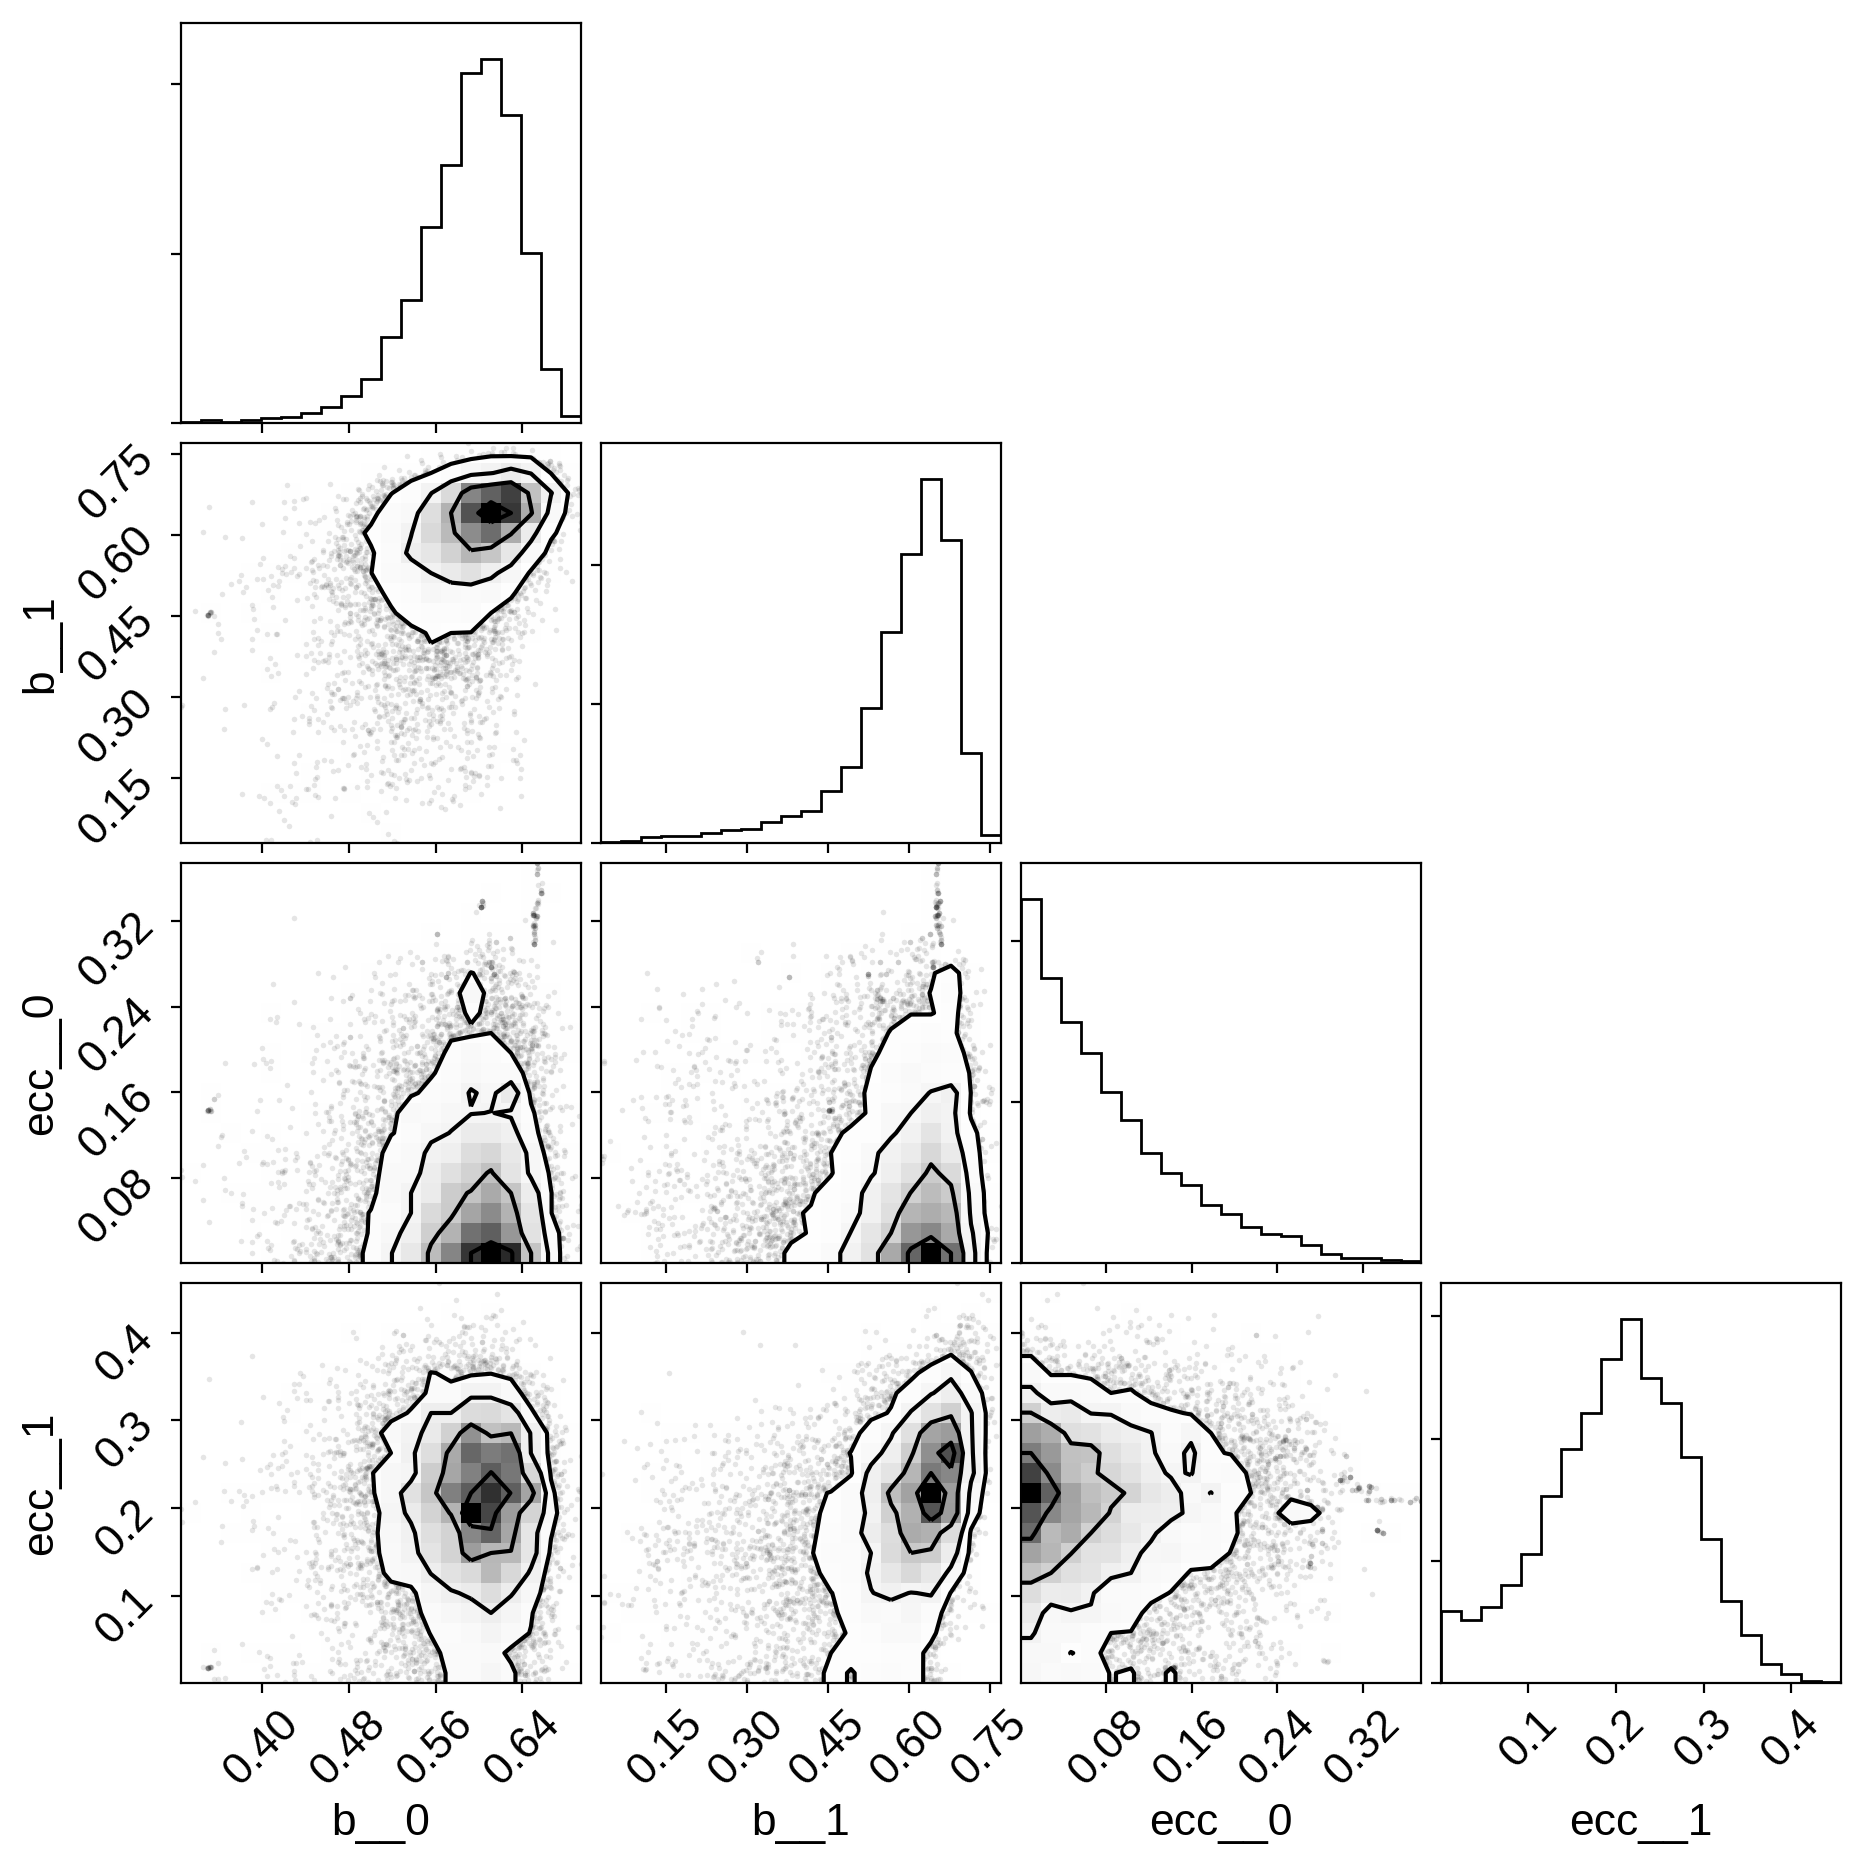

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

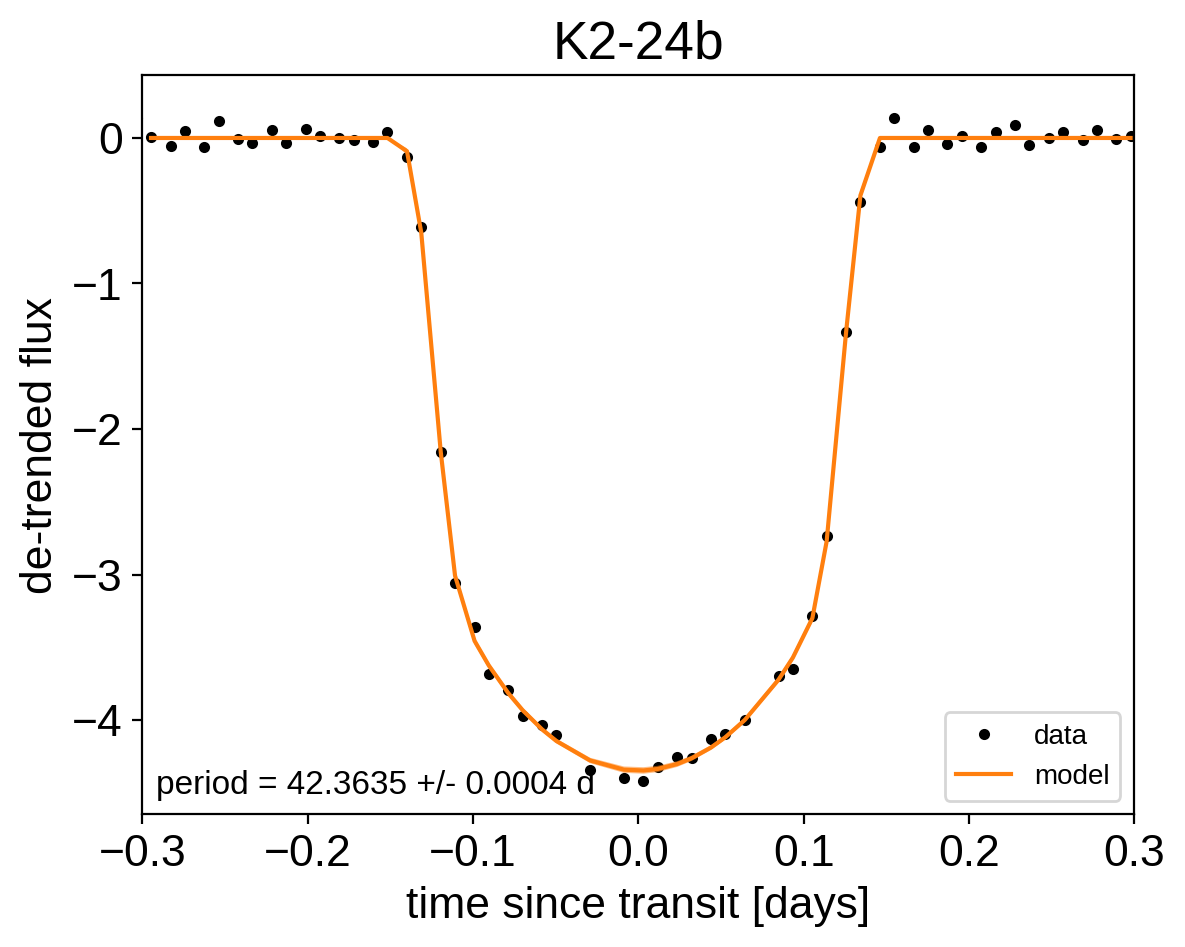

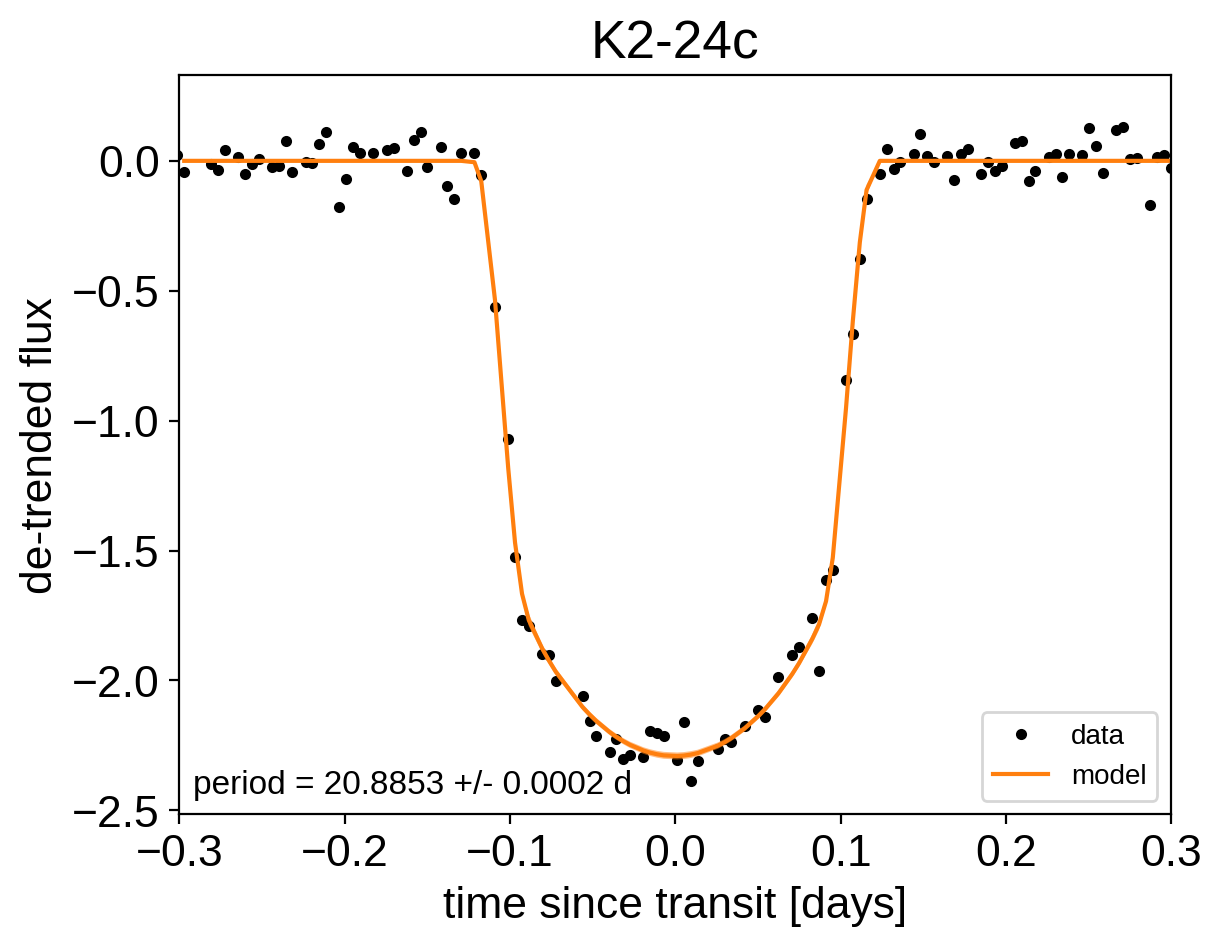

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

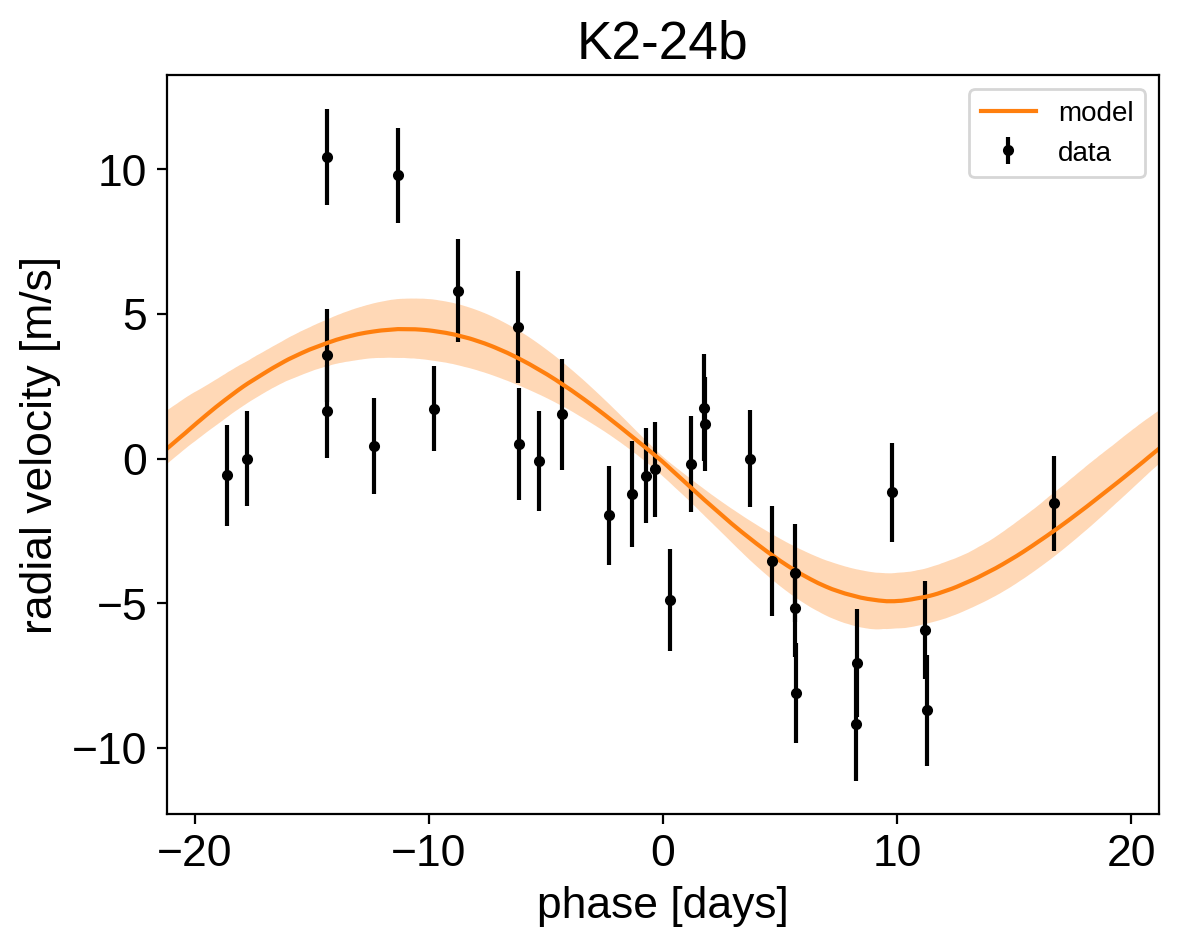

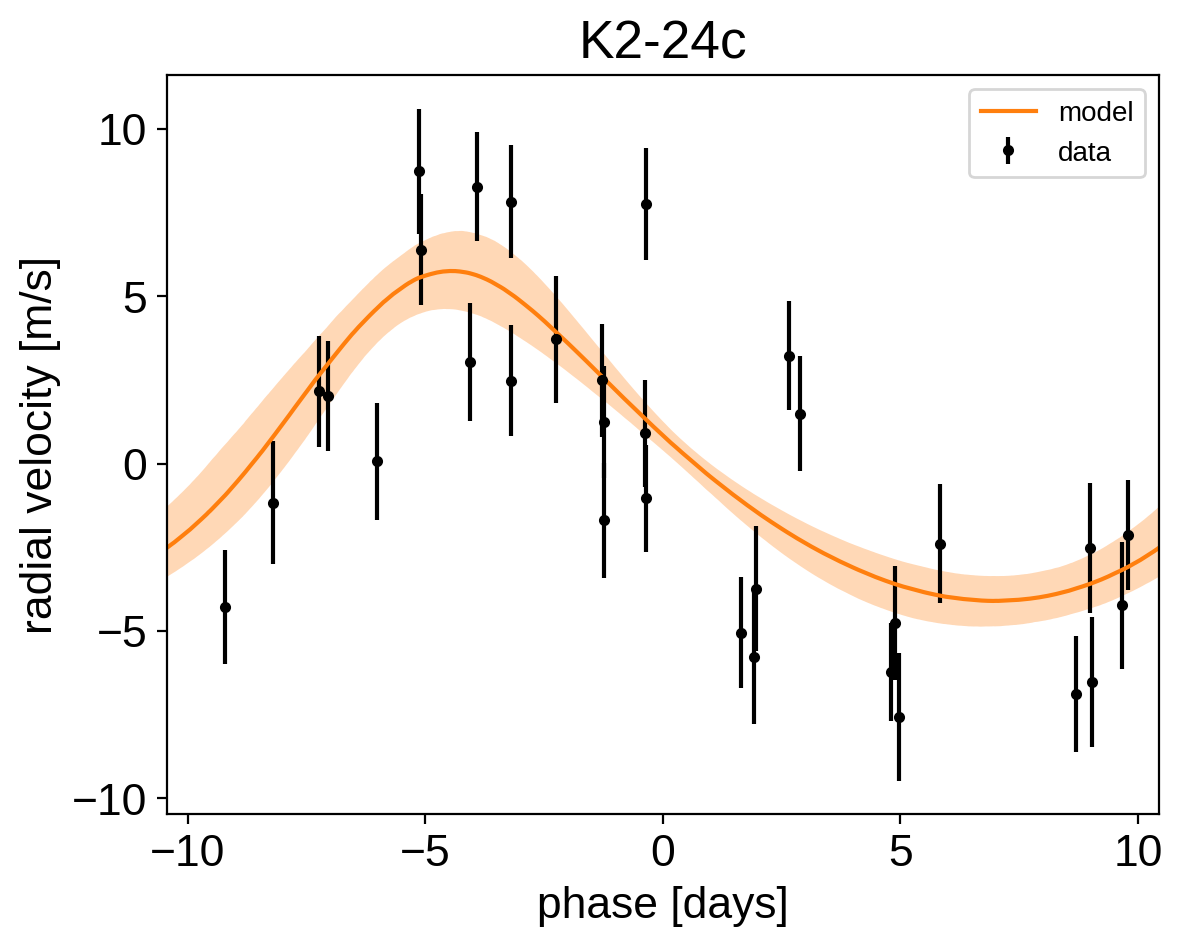

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

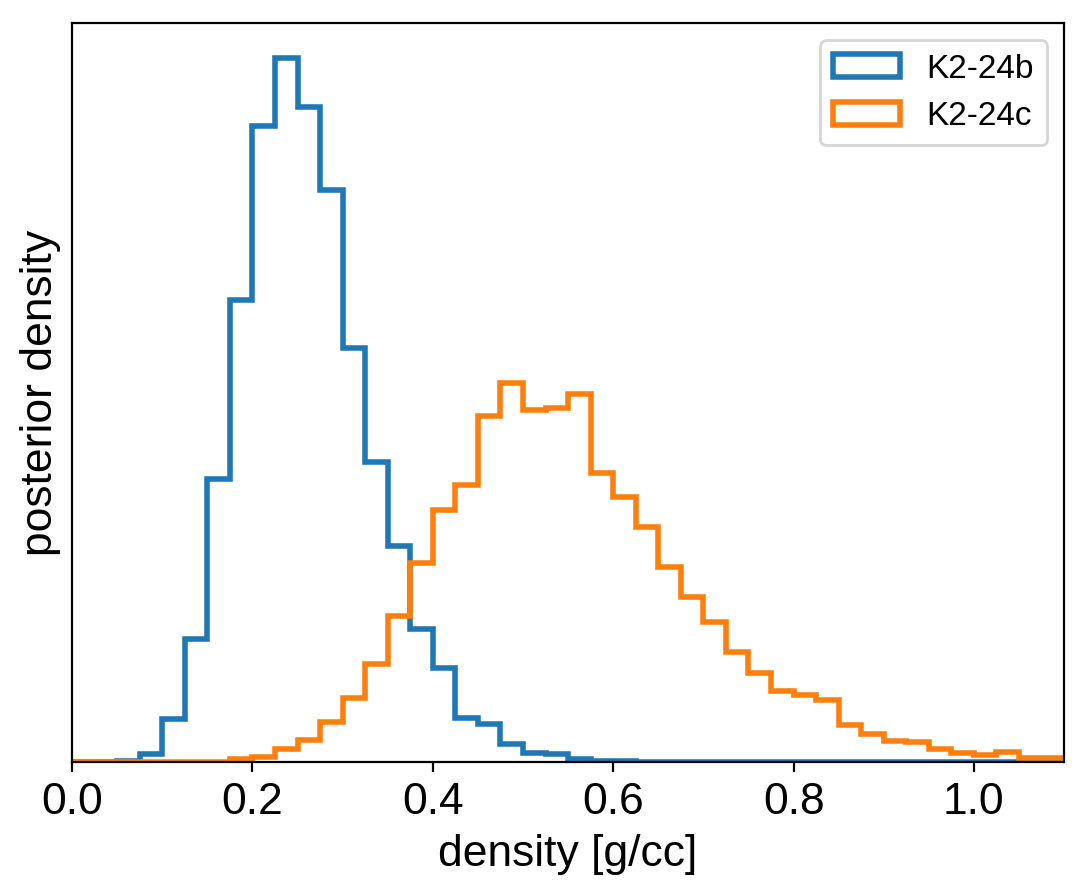

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
